In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#from google.colab import files
#files.upload()

# CLASE PARA PROYECTO CAJAMAR

In [6]:
!pip install skforecast

In [7]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal):
        self.datos_contador = datos_contador
        self.ID = ID
        self.lista_contadores_defectuosos = [111, 658, 2460, 2464, 2466, 2481, 2483, 2489]
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            #CALCULO DE LA LECTURA Y CONSUMO AGRUPANDO PARTE ENTERA Y DECIMAL
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            
            #NORMALIZACIÓN A DISTRIBUCIÓN NORMAL(0,1) DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_NORMA'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].mean())/self.datos_contador['LECTURA'].std()
            self.datos_contador['CONSUMO_NORMA'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].mean())/self.datos_contador['CONSUMO'].std()
            
            # ELIMINANDO LOS OUTLIERS "DESTACADOS" DE LOS CONTADORES MARCADOS (DEJO COMENTADA UNA OPCIÓN PARA HACERLO TAMBIÉN CON EL RESTO DE CONTADORES)
            if self.ID in self.lista_contadores_defectuosos:
              if self.ID in [111, 658, 2560]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>6)[0]], inplace=True)
              elif self.ID in [2466, 2483, 2489]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>5)[0]], inplace=True)
              elif self.ID in [2464, 2481]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>10)[0]], inplace=True)
#           else:
#             self.datos_contador['CONSUMO'].drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA']>8)[0]], inplace=True)
            
            #FIJACIÓN DEL ÍNDICE TEMPORAL DE LA SERIE
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')

            #NORMALIZACIÓN MIN MAX DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_MINMAX'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].min())/(self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min())
            self.datos_contador['CONSUMO_MINMAX'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].min())/(self.datos_contador['CONSUMO'].max()-self.datos_contador['CONSUMO'].min())
            
            #CÁLCULO DE LA DIFERENCIA DE LECTURAS EN CADA PASO DE TIEMPO PARA OBTENER EL CONSUMO A PARTIR DE LA LECTURA
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)
            
            #APLICACIÓN DE LA FUNCIÓN PARA VERIFICAR SI EL CONSUMO ES CORRECTO
            self.__Comprobar_Consumo()

            # CÁLCULO DE LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA DE VALOR MÁXIMO Y MÍNIMO DE LA LECTURA DEL CONTADOR
            self.suma_consumo = self.datos_contador['CONSUMO'].sum()
            self.diferencia_lectura = self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min()

            #BOOLEANO QUE DETERMINA SI LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA MIN MAX DEL CONTADOR SON IGUALES
            if self.suma_consumo == self.diferencia_lectura:
              self.buenas_lecturas = True
            else:
              self.buenas_lecturas = False

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())

            # NORMALIZACIÓN NORMAL STÁNDARD
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            self.datos_consumo['CONSUMO_NORM'].fillna(0, inplace=True)
            # NORMALIZACIÓN MIN MAX
            self.datos_consumo['CONSUMO_MIN_MAX'] = (self.datos_consumo['CONSUMO']-self.datos_consumo['CONSUMO'].min())/(self.datos_consumo['CONSUMO'].max()-self.datos_consumo['CONSUMO'].min())
            self.datos_consumo['CONSUMO_MIN_MAX'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=3
            self.datos_consumo['CONSUMO_MEDMOV3'] = self.datos_consumo['CONSUMO'].rolling(3).mean()
            self.datos_consumo['CONSUMO_MEDMOV3'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=4
            self.datos_consumo['CONSUMO_MEDMOV4'] = self.datos_consumo['CONSUMO'].rolling(4).mean()
            self.datos_consumo['CONSUMO_MEDMOV4'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=5
            self.datos_consumo['CONSUMO_MEDMOV5'] = self.datos_consumo['CONSUMO'].rolling(5).mean()
            self.datos_consumo['CONSUMO_MEDMOV5'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=6
            self.datos_consumo['CONSUMO_MEDMOV6'] = self.datos_consumo['CONSUMO'].rolling(6).mean()
            self.datos_consumo['CONSUMO_MEDMOV6'].fillna(0,inplace=True)


            # MEDIAS MÓVILES N=7
            self.datos_consumo['CONSUMO_MEDMOV7'] = self.datos_consumo['CONSUMO'].rolling(7).mean()
            self.datos_consumo['CONSUMO_MEDMOV7'].fillna(0,inplace=True)   

            self.media = self.datos_consumo['CONSUMO'][-21:-14]
            print(self.media)
            self.media = self.media.mean()
            print(self.media)
            self.datos_consumo['CONSUMO_MEAN'] = self.media
            print(self.datos_consumo['CONSUMO_MEAN'])

            #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
              #print(self.datos_consumo['CONSUMO_MEAN'])
            #self.datos_consumo['CONSUMO_MEAN'].fillna(0,inplace=True)  

            #COGER SÓLO SEMANAS COMPLETAS
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo
        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if row['CONSUMO_CAL'] != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)


    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100, Modelo_Semanal=False):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.RMSE_Todos = []
        self.RMSE_Todos_IDs = []
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100],
              'max_depth': [5]}

        # Lags utilizados como predictores
        lags_grid = [14]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #if contador.ID not in Lista_Normal_better:
                #print(contador.ID)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV6'])
                #else:

                contador.model.fit(y=contador.datos_consumo['CONSUMO_MEAN'])
                predict = contador.model.predict(steps=self.dias_test)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MIN_MAX'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV3'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV4'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV5'])

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test)*(contador.datos_consumo['CONSUMO'].max()-contador.datos_consumo['CONSUMO'].min())+contador.datos_consumo['CONSUMO'].min()
                #predict = contador.model.predict(steps=self.dias_test)
                index = 1
                for predict_dia in predict[0:14]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,15):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                self.RMSE_Todos.append(contador.RMSE_Test)
                self.RMSE_Todos_IDs.append(contador.ID)

        self.RMSE_Test_Suma = sum(self.RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(self.RMSE_Todos)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:15],index=self.contadores[contador].datos_test['CONSUMO'].index[0:14],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [8]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
path="/content/drive/MyDrive/Cajamar/"
#Proyecto = CajaMar_Water(path+'Modelar_UH2022_10_Contadores.txt')
Proyecto = CajaMar_Water(path+'Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt', Modelo_Semanal=False)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')

CARGANDO DATOS.....
GENERANDO CONTADORES.....


  0%|          | 1/2747 [00:00<23:40,  1.93it/s]

SAMPLETIME
2020-01-11    157.0
2020-01-12    282.0
2020-01-13    115.0
2020-01-14    452.0
2020-01-15    210.0
2020-01-16    303.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
256.7142857142857
SAMPLETIME
2019-02-01    256.714286
2019-02-02    256.714286
2019-02-03    256.714286
2019-02-04    256.714286
2019-02-05    256.714286
                 ...    
2020-01-27    256.714286
2020-01-28    256.714286
2020-01-29    256.714286
2020-01-30    256.714286
2020-01-31    256.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 2/2747 [00:01<23:47,  1.92it/s]

SAMPLETIME
2020-01-11    3.00
2020-01-12    3.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.30
2020-01-16    4.05
2020-01-17    1.00
Freq: D, Name: CONSUMO, dtype: float64
1.6214285714285714
SAMPLETIME
2019-02-01    1.621429
2019-02-02    1.621429
2019-02-03    1.621429
2019-02-04    1.621429
2019-02-05    1.621429
                ...   
2020-01-27    1.621429
2020-01-28    1.621429
2020-01-29    1.621429
2020-01-30    1.621429
2020-01-31    1.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 3/2747 [00:01<23:18,  1.96it/s]

SAMPLETIME
2020-01-11    41.0
2020-01-12    35.0
2020-01-13    30.0
2020-01-14    52.0
2020-01-15    40.0
2020-01-16    34.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
38.285714285714285
SAMPLETIME
2019-02-01    38.285714
2019-02-02    38.285714
2019-02-03    38.285714
2019-02-04    38.285714
2019-02-05    38.285714
                ...    
2020-01-27    38.285714
2020-01-28    38.285714
2020-01-29    38.285714
2020-01-30    38.285714
2020-01-31    38.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 4/2747 [00:02<22:51,  2.00it/s]

SAMPLETIME
2020-01-11    563.0
2020-01-12    405.0
2020-01-13    303.4
2020-01-14    310.0
2020-01-15    386.0
2020-01-16    368.0
2020-01-17    409.0
Freq: D, Name: CONSUMO, dtype: float64
392.0571428571429
SAMPLETIME
2019-02-01    392.057143
2019-02-02    392.057143
2019-02-03    392.057143
2019-02-04    392.057143
2019-02-05    392.057143
                 ...    
2020-01-27    392.057143
2020-01-28    392.057143
2020-01-29    392.057143
2020-01-30    392.057143
2020-01-31    392.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 5/2747 [00:02<24:05,  1.90it/s]

SAMPLETIME
2020-01-11    325.10
2020-01-12    191.52
2020-01-13    227.16
2020-01-14    272.04
2020-01-15    221.04
2020-01-16    203.14
2020-01-17    295.00
Freq: D, Name: CONSUMO, dtype: float64
247.85714285714286
SAMPLETIME
2019-02-01    247.857143
2019-02-02    247.857143
2019-02-03    247.857143
2019-02-04    247.857143
2019-02-05    247.857143
                 ...    
2020-01-27    247.857143
2020-01-28    247.857143
2020-01-29    247.857143
2020-01-30    247.857143
2020-01-31    247.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 6/2747 [00:03<23:52,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 7/2747 [00:03<23:37,  1.93it/s]

SAMPLETIME
2020-01-11    165.88
2020-01-12    236.00
2020-01-13    196.00
2020-01-14    114.20
2020-01-15    248.00
2020-01-16    103.01
2020-01-17    306.10
Freq: D, Name: CONSUMO, dtype: float64
195.59857142857143
SAMPLETIME
2019-02-01    195.598571
2019-02-02    195.598571
2019-02-03    195.598571
2019-02-04    195.598571
2019-02-05    195.598571
                 ...    
2020-01-27    195.598571
2020-01-28    195.598571
2020-01-29    195.598571
2020-01-30    195.598571
2020-01-31    195.598571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 8/2747 [00:04<24:16,  1.88it/s]

SAMPLETIME
2020-01-11     26.0
2020-01-12    230.3
2020-01-13     20.2
2020-01-14     44.0
2020-01-15     98.0
2020-01-16     57.0
2020-01-17     29.0
Freq: D, Name: CONSUMO, dtype: float64
72.07142857142857
SAMPLETIME
2019-02-01    72.071429
2019-02-02    72.071429
2019-02-03    72.071429
2019-02-04    72.071429
2019-02-05    72.071429
                ...    
2020-01-27    72.071429
2020-01-28    72.071429
2020-01-29    72.071429
2020-01-30    72.071429
2020-01-31    72.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 9/2747 [00:04<23:39,  1.93it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    16.0
2020-01-15     0.4
2020-01-16     0.0
2020-01-17    90.0
Freq: D, Name: CONSUMO, dtype: float64
15.200000000000001
SAMPLETIME
2019-02-01    15.2
2019-02-02    15.2
2019-02-03    15.2
2019-02-04    15.2
2019-02-05    15.2
              ... 
2020-01-27    15.2
2020-01-28    15.2
2020-01-29    15.2
2020-01-30    15.2
2020-01-31    15.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 10/2747 [00:05<23:02,  1.98it/s]

SAMPLETIME
2020-01-11     58.0
2020-01-12    258.0
2020-01-13     27.3
2020-01-14     18.0
2020-01-15     99.0
2020-01-16     18.0
2020-01-17     34.0
Freq: D, Name: CONSUMO, dtype: float64
73.18571428571428
SAMPLETIME
2019-02-01    73.185714
2019-02-02    73.185714
2019-02-03    73.185714
2019-02-04    73.185714
2019-02-05    73.185714
                ...    
2020-01-27    73.185714
2020-01-28    73.185714
2020-01-29    73.185714
2020-01-30    73.185714
2020-01-31    73.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 11/2747 [00:05<23:06,  1.97it/s]

SAMPLETIME
2020-01-11      2.08
2020-01-12      0.00
2020-01-13      9.20
2020-01-14     10.03
2020-01-15    728.24
2020-01-16    155.18
2020-01-17     27.12
Freq: D, Name: CONSUMO, dtype: float64
133.12142857142857
SAMPLETIME
2019-02-01    133.121429
2019-02-02    133.121429
2019-02-03    133.121429
2019-02-04    133.121429
2019-02-05    133.121429
                 ...    
2020-01-27    133.121429
2020-01-28    133.121429
2020-01-29    133.121429
2020-01-30    133.121429
2020-01-31    133.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 13/2747 [00:06<18:15,  2.50it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14     2.0
2020-01-15     7.0
2020-01-16    18.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.0
SAMPLETIME
2019-02-01    4.0
2019-02-02    4.0
2019-02-03    4.0
2019-02-04    4.0
2019-02-05    4.0
             ... 
2020-01-27    4.0
2020-01-28    4.0
2020-01-29    4.0
2020-01-30    4.0
2020-01-31    4.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 14/2747 [00:06<19:24,  2.35it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12    11.00
2020-01-13    27.00
2020-01-14     7.02
2020-01-15    19.20
2020-01-16    12.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
10.888571428571428
SAMPLETIME
2019-02-01    10.888571
2019-02-02    10.888571
2019-02-03    10.888571
2019-02-04    10.888571
2019-02-05    10.888571
                ...    
2020-01-27    10.888571
2020-01-28    10.888571
2020-01-29    10.888571
2020-01-30    10.888571
2020-01-31    10.888571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 15/2747 [00:07<20:19,  2.24it/s]

SAMPLETIME
2020-01-11    195.20
2020-01-12    116.40
2020-01-13    118.40
2020-01-14    110.03
2020-01-15    210.99
2020-01-16     96.00
2020-01-17     40.00
Freq: D, Name: CONSUMO, dtype: float64
126.71714285714286
SAMPLETIME
2019-02-01    126.717143
2019-02-02    126.717143
2019-02-03    126.717143
2019-02-04    126.717143
2019-02-05    126.717143
                 ...    
2020-01-27    126.717143
2020-01-28    126.717143
2020-01-29    126.717143
2020-01-30    126.717143
2020-01-31    126.717143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 16/2747 [00:07<20:52,  2.18it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    242.30
2020-01-13    206.30
2020-01-14    335.80
2020-01-15    181.00
2020-01-16    389.00
2020-01-17    234.39
Freq: D, Name: CONSUMO, dtype: float64
226.97000000000003
SAMPLETIME
2019-02-01    226.97
2019-02-02    226.97
2019-02-03    226.97
2019-02-04    226.97
2019-02-05    226.97
               ...  
2020-01-27    226.97
2020-01-28    226.97
2020-01-29    226.97
2020-01-30    226.97
2020-01-31    226.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 17/2747 [00:08<21:59,  2.07it/s]

SAMPLETIME
2020-01-11    367.10
2020-01-12    320.02
2020-01-13    226.98
2020-01-14    247.01
2020-01-15    320.80
2020-01-16    260.11
2020-01-17    238.70
Freq: D, Name: CONSUMO, dtype: float64
282.96
SAMPLETIME
2019-02-01    282.96
2019-02-02    282.96
2019-02-03    282.96
2019-02-04    282.96
2019-02-05    282.96
               ...  
2020-01-27    282.96
2020-01-28    282.96
2020-01-29    282.96
2020-01-30    282.96
2020-01-31    282.96
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 18/2747 [00:08<22:21,  2.03it/s]

SAMPLETIME
2020-01-11    308.2
2020-01-12    279.0
2020-01-13    272.1
2020-01-14    240.3
2020-01-15    226.0
2020-01-16    261.0
2020-01-17    288.1
Freq: D, Name: CONSUMO, dtype: float64
267.81428571428575
SAMPLETIME
2019-02-01    267.814286
2019-02-02    267.814286
2019-02-03    267.814286
2019-02-04    267.814286
2019-02-05    267.814286
                 ...    
2020-01-27    267.814286
2020-01-28    267.814286
2020-01-29    267.814286
2020-01-30    267.814286
2020-01-31    267.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 19/2747 [00:09<23:29,  1.93it/s]

SAMPLETIME
2020-01-11    979.0
2020-01-12    458.0
2020-01-13    747.1
2020-01-14    695.0
2020-01-15    558.0
2020-01-16    853.0
2020-01-17    556.0
Freq: D, Name: CONSUMO, dtype: float64
692.3000000000001
SAMPLETIME
2019-02-01    692.3
2019-02-02    692.3
2019-02-03    692.3
2019-02-04    692.3
2019-02-05    692.3
              ...  
2020-01-27    692.3
2020-01-28    692.3
2020-01-29    692.3
2020-01-30    692.3
2020-01-31    692.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 20/2747 [00:09<22:58,  1.98it/s]

SAMPLETIME
2020-01-11    145.00
2020-01-12    214.00
2020-01-13    177.00
2020-01-14    238.08
2020-01-15    439.12
2020-01-16    277.00
2020-01-17    487.00
Freq: D, Name: CONSUMO, dtype: float64
282.45714285714286
SAMPLETIME
2019-02-01    282.457143
2019-02-02    282.457143
2019-02-03    282.457143
2019-02-04    282.457143
2019-02-05    282.457143
                 ...    
2020-01-27    282.457143
2020-01-28    282.457143
2020-01-29    282.457143
2020-01-30    282.457143
2020-01-31    282.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 21/2747 [00:10<22:40,  2.00it/s]

SAMPLETIME
2020-01-11    75.08
2020-01-12    25.12
2020-01-13     4.48
2020-01-14    32.54
2020-01-15     2.03
2020-01-16     2.02
2020-01-17    21.10
Freq: D, Name: CONSUMO, dtype: float64
23.195714285714285
SAMPLETIME
2019-02-01    23.195714
2019-02-02    23.195714
2019-02-03    23.195714
2019-02-04    23.195714
2019-02-05    23.195714
                ...    
2020-01-27    23.195714
2020-01-28    23.195714
2020-01-29    23.195714
2020-01-30    23.195714
2020-01-31    23.195714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 23/2747 [00:10<17:49,  2.55it/s]

SAMPLETIME
2020-01-11    326.0
2020-01-12    284.0
2020-01-13    131.0
2020-01-14     48.0
2020-01-15     55.0
2020-01-16     66.0
2020-01-17     21.1
Freq: D, Name: CONSUMO, dtype: float64
133.0142857142857
SAMPLETIME
2019-02-01    133.014286
2019-02-02    133.014286
2019-02-03    133.014286
2019-02-04    133.014286
2019-02-05    133.014286
                 ...    
2020-01-27    133.014286
2020-01-28    133.014286
2020-01-29    133.014286
2020-01-30    133.014286
2020-01-31    133.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 24/2747 [00:11<18:47,  2.42it/s]

SAMPLETIME
2020-01-11    139.00
2020-01-12    449.02
2020-01-13    102.00
2020-01-14    148.20
2020-01-15     45.20
2020-01-16    205.00
2020-01-17    106.08
Freq: D, Name: CONSUMO, dtype: float64
170.64285714285714
SAMPLETIME
2019-02-04    170.642857
2019-02-05    170.642857
2019-02-06    170.642857
2019-02-07    170.642857
2019-02-08    170.642857
                 ...    
2020-01-27    170.642857
2020-01-28    170.642857
2020-01-29    170.642857
2020-01-30    170.642857
2020-01-31    170.642857
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 25/2747 [00:11<19:35,  2.32it/s]

SAMPLETIME
2020-01-11    305.0
2020-01-12    261.0
2020-01-13    253.0
2020-01-14    214.0
2020-01-15    304.0
2020-01-16    318.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
271.42857142857144
SAMPLETIME
2019-02-01    271.428571
2019-02-02    271.428571
2019-02-03    271.428571
2019-02-04    271.428571
2019-02-05    271.428571
                 ...    
2020-01-27    271.428571
2020-01-28    271.428571
2020-01-29    271.428571
2020-01-30    271.428571
2020-01-31    271.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 26/2747 [00:12<20:09,  2.25it/s]

SAMPLETIME
2020-01-11    397.00
2020-01-12    408.00
2020-01-13    256.00
2020-01-14    347.24
2020-01-15    326.06
2020-01-16    307.20
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
339.07142857142856
SAMPLETIME
2019-02-01    339.071429
2019-02-02    339.071429
2019-02-03    339.071429
2019-02-04    339.071429
2019-02-05    339.071429
                 ...    
2020-01-27    339.071429
2020-01-28    339.071429
2020-01-29    339.071429
2020-01-30    339.071429
2020-01-31    339.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 27/2747 [00:12<19:11,  2.36it/s]

SAMPLETIME
2020-01-11    442.0
2020-01-12    468.0
2020-01-13    515.0
2020-01-14    420.0
2020-01-15    423.0
2020-01-16    572.3
2020-01-17    410.4
Freq: D, Name: CONSUMO, dtype: float64
464.3857142857143
SAMPLETIME
2019-05-08    464.385714
2019-05-09    464.385714
2019-05-10    464.385714
2019-05-11    464.385714
2019-05-12    464.385714
                 ...    
2020-01-27    464.385714
2020-01-28    464.385714
2020-01-29    464.385714
2020-01-30    464.385714
2020-01-31    464.385714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 28/2747 [00:13<19:59,  2.27it/s]

SAMPLETIME
2020-01-11    125.0
2020-01-12    251.0
2020-01-13    155.0
2020-01-14    239.0
2020-01-15    106.0
2020-01-16    187.0
2020-01-17    125.0
Freq: D, Name: CONSUMO, dtype: float64
169.71428571428572
SAMPLETIME
2019-02-01    169.714286
2019-02-02    169.714286
2019-02-03    169.714286
2019-02-04    169.714286
2019-02-05    169.714286
                 ...    
2020-01-27    169.714286
2020-01-28    169.714286
2020-01-29    169.714286
2020-01-30    169.714286
2020-01-31    169.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 29/2747 [00:13<20:46,  2.18it/s]

SAMPLETIME
2020-01-11     54.0
2020-01-12    133.0
2020-01-13    162.0
2020-01-14     64.0
2020-01-15     91.4
2020-01-16    123.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
107.91428571428571
SAMPLETIME
2019-02-01    107.914286
2019-02-02    107.914286
2019-02-03    107.914286
2019-02-04    107.914286
2019-02-05    107.914286
                 ...    
2020-01-27    107.914286
2020-01-28    107.914286
2020-01-29    107.914286
2020-01-30    107.914286
2020-01-31    107.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 30/2747 [00:14<21:14,  2.13it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    289.00
2020-01-14    415.00
2020-01-15    357.00
2020-01-16    342.03
2020-01-17    350.00
Freq: D, Name: CONSUMO, dtype: float64
250.43285714285713
SAMPLETIME
2019-02-01    250.432857
2019-02-02    250.432857
2019-02-03    250.432857
2019-02-04    250.432857
2019-02-05    250.432857
                 ...    
2020-01-27    250.432857
2020-01-28    250.432857
2020-01-29    250.432857
2020-01-30    250.432857
2020-01-31    250.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 31/2747 [00:14<21:48,  2.08it/s]

SAMPLETIME
2020-01-11    170.00
2020-01-12    487.00
2020-01-13    638.99
2020-01-14    628.00
2020-01-15    481.40
2020-01-16    423.00
2020-01-17    491.00
Freq: D, Name: CONSUMO, dtype: float64
474.1985714285714
SAMPLETIME
2019-02-01    474.198571
2019-02-02    474.198571
2019-02-03    474.198571
2019-02-04    474.198571
2019-02-05    474.198571
                 ...    
2020-01-27    474.198571
2020-01-28    474.198571
2020-01-29    474.198571
2020-01-30    474.198571
2020-01-31    474.198571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 32/2747 [00:15<22:24,  2.02it/s]

SAMPLETIME
2020-01-11    474.50
2020-01-12    392.54
2020-01-13    390.57
2020-01-14    413.01
2020-01-15    425.10
2020-01-16    399.03
2020-01-17    513.48
Freq: D, Name: CONSUMO, dtype: float64
429.7471428571429
SAMPLETIME
2019-02-01    429.747143
2019-02-02    429.747143
2019-02-03    429.747143
2019-02-04    429.747143
2019-02-05    429.747143
                 ...    
2020-01-27    429.747143
2020-01-28    429.747143
2020-01-29    429.747143
2020-01-30    429.747143
2020-01-31    429.747143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 33/2747 [00:15<21:17,  2.12it/s]

SAMPLETIME
2020-01-11    375.0
2020-01-12    232.0
2020-01-13    261.0
2020-01-14    247.0
2020-01-15    285.0
2020-01-16    231.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
262.85714285714283
SAMPLETIME
2019-04-06    262.857143
2019-04-07    262.857143
2019-04-08    262.857143
2019-04-09    262.857143
2019-04-10    262.857143
                 ...    
2020-01-27    262.857143
2020-01-28    262.857143
2020-01-29    262.857143
2020-01-30    262.857143
2020-01-31    262.857143
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 34/2747 [00:16<22:59,  1.97it/s]

SAMPLETIME
2020-01-11    2004.20
2020-01-12    1947.50
2020-01-13    2682.37
2020-01-14    1692.24
2020-01-15    2583.46
2020-01-16    3976.60
2020-01-17    3116.40
Freq: D, Name: CONSUMO, dtype: float64
2571.824285714286
SAMPLETIME
2019-02-01    2571.824286
2019-02-02    2571.824286
2019-02-03    2571.824286
2019-02-04    2571.824286
2019-02-05    2571.824286
                 ...     
2020-01-27    2571.824286
2020-01-28    2571.824286
2020-01-29    2571.824286
2020-01-30    2571.824286
2020-01-31    2571.824286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 35/2747 [00:16<20:57,  2.16it/s]

SAMPLETIME
2020-01-11    20.0
2020-01-12    52.0
2020-01-13    27.0
2020-01-14    36.0
2020-01-15    48.0
2020-01-16    58.0
2020-01-17    55.0
Freq: D, Name: CONSUMO, dtype: float64
42.285714285714285
SAMPLETIME
2019-05-08    42.285714
2019-05-09    42.285714
2019-05-10    42.285714
2019-05-11    42.285714
2019-05-12    42.285714
                ...    
2020-01-27    42.285714
2020-01-28    42.285714
2020-01-29    42.285714
2020-01-30    42.285714
2020-01-31    42.285714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 36/2747 [00:16<19:47,  2.28it/s]

SAMPLETIME
2020-01-11     71.0
2020-01-12     56.0
2020-01-13     68.3
2020-01-14     68.0
2020-01-15     37.0
2020-01-16    143.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
76.18571428571428
SAMPLETIME
2019-05-10    76.185714
2019-05-11    76.185714
2019-05-12    76.185714
2019-05-13    76.185714
2019-05-14    76.185714
                ...    
2020-01-27    76.185714
2020-01-28    76.185714
2020-01-29    76.185714
2020-01-30    76.185714
2020-01-31    76.185714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 37/2747 [00:17<20:33,  2.20it/s]

SAMPLETIME
2020-01-11     103.0
2020-01-12       6.0
2020-01-13    4513.0
2020-01-14    4329.1
2020-01-15    3628.0
2020-01-16    3986.0
2020-01-17    3663.0
Freq: D, Name: CONSUMO, dtype: float64
2889.7285714285713
SAMPLETIME
2019-02-01    2889.728571
2019-02-02    2889.728571
2019-02-03    2889.728571
2019-02-04    2889.728571
2019-02-05    2889.728571
                 ...     
2020-01-27    2889.728571
2020-01-28    2889.728571
2020-01-29    2889.728571
2020-01-30    2889.728571
2020-01-31    2889.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 38/2747 [00:17<19:47,  2.28it/s]

SAMPLETIME
2020-01-11    166.24
2020-01-12     97.20
2020-01-13    126.45
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      8.00
Freq: D, Name: CONSUMO, dtype: float64
56.84142857142857
SAMPLETIME
2019-02-01    56.841429
2019-02-02    56.841429
2019-02-03    56.841429
2019-02-04    56.841429
2019-02-05    56.841429
                ...    
2020-01-27    56.841429
2020-01-28    56.841429
2020-01-29    56.841429
2020-01-30    56.841429
2020-01-31    56.841429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 39/2747 [00:18<20:30,  2.20it/s]

SAMPLETIME
2020-01-11    339.0
2020-01-12    260.0
2020-01-13    210.0
2020-01-14    366.0
2020-01-15    396.0
2020-01-16    308.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
315.57142857142856
SAMPLETIME
2019-02-01    315.571429
2019-02-02    315.571429
2019-02-03    315.571429
2019-02-04    315.571429
2019-02-05    315.571429
                 ...    
2020-01-27    315.571429
2020-01-28    315.571429
2020-01-29    315.571429
2020-01-30    315.571429
2020-01-31    315.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 40/2747 [00:18<19:45,  2.28it/s]

SAMPLETIME
2020-01-11    464.20
2020-01-12    336.99
2020-01-13    435.00
2020-01-14    346.40
2020-01-15    379.30
2020-01-16    417.30
2020-01-17    272.95
Freq: D, Name: CONSUMO, dtype: float64
378.8771428571428
SAMPLETIME
2019-05-13    378.877143
2019-05-14    378.877143
2019-05-15    378.877143
2019-05-16    378.877143
2019-05-17    378.877143
                 ...    
2020-01-27    378.877143
2020-01-28    378.877143
2020-01-29    378.877143
2020-01-30    378.877143
2020-01-31    378.877143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 41/2747 [00:19<20:33,  2.19it/s]

SAMPLETIME
2020-01-11    84.0
2020-01-12    80.0
2020-01-13    32.0
2020-01-14    34.0
2020-01-15    92.0
2020-01-16    70.3
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
65.04285714285714
SAMPLETIME
2019-02-01    65.042857
2019-02-02    65.042857
2019-02-03    65.042857
2019-02-04    65.042857
2019-02-05    65.042857
                ...    
2020-01-27    65.042857
2020-01-28    65.042857
2020-01-29    65.042857
2020-01-30    65.042857
2020-01-31    65.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 42/2747 [00:19<20:51,  2.16it/s]

SAMPLETIME
2020-01-11     59.0
2020-01-12     80.0
2020-01-13    111.0
2020-01-14     48.0
2020-01-15    104.0
2020-01-16     54.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
73.85714285714286
SAMPLETIME
2019-02-01    73.857143
2019-02-02    73.857143
2019-02-03    73.857143
2019-02-04    73.857143
2019-02-05    73.857143
                ...    
2020-01-27    73.857143
2020-01-28    73.857143
2020-01-29    73.857143
2020-01-30    73.857143
2020-01-31    73.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 43/2747 [00:20<21:43,  2.08it/s]

SAMPLETIME
2020-01-11     3774.32
2020-01-12     1642.47
2020-01-13    16064.57
2020-01-14    18822.44
2020-01-15    18882.80
2020-01-16    15392.31
2020-01-17    19917.66
Freq: D, Name: CONSUMO, dtype: float64
13499.51
SAMPLETIME
2019-02-01    13499.51
2019-02-02    13499.51
2019-02-03    13499.51
2019-02-04    13499.51
2019-02-05    13499.51
                ...   
2020-01-27    13499.51
2020-01-28    13499.51
2020-01-29    13499.51
2020-01-30    13499.51
2020-01-31    13499.51
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 44/2747 [00:20<22:16,  2.02it/s]

SAMPLETIME
2020-01-11    198.60
2020-01-12    233.40
2020-01-13    351.00
2020-01-14    113.26
2020-01-15    527.34
2020-01-16    286.30
2020-01-17    179.96
Freq: D, Name: CONSUMO, dtype: float64
269.97999999999996
SAMPLETIME
2019-02-01    269.98
2019-02-02    269.98
2019-02-03    269.98
2019-02-04    269.98
2019-02-05    269.98
               ...  
2020-01-27    269.98
2020-01-28    269.98
2020-01-29    269.98
2020-01-30    269.98
2020-01-31    269.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 45/2747 [00:21<23:55,  1.88it/s]

SAMPLETIME
2020-01-11     82.88
2020-01-12    194.12
2020-01-13     93.35
2020-01-14     70.30
2020-01-15    143.41
2020-01-16     61.10
2020-01-17     83.36
Freq: D, Name: CONSUMO, dtype: float64
104.07428571428572
SAMPLETIME
2019-02-01    104.074286
2019-02-02    104.074286
2019-02-03    104.074286
2019-02-04    104.074286
2019-02-05    104.074286
                 ...    
2020-01-27    104.074286
2020-01-28    104.074286
2020-01-29    104.074286
2020-01-30    104.074286
2020-01-31    104.074286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 46/2747 [00:21<23:23,  1.92it/s]

SAMPLETIME
2020-01-11    138.0
2020-01-12    171.0
2020-01-13    199.0
2020-01-14    138.0
2020-01-15    172.0
2020-01-16    177.0
2020-01-17    207.0
Freq: D, Name: CONSUMO, dtype: float64
171.71428571428572
SAMPLETIME
2019-02-01    171.714286
2019-02-02    171.714286
2019-02-03    171.714286
2019-02-04    171.714286
2019-02-05    171.714286
                 ...    
2020-01-27    171.714286
2020-01-28    171.714286
2020-01-29    171.714286
2020-01-30    171.714286
2020-01-31    171.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 47/2747 [00:22<23:01,  1.96it/s]

SAMPLETIME
2020-01-11     93.0
2020-01-12    131.0
2020-01-13     45.0
2020-01-14      0.0
2020-01-15      6.4
2020-01-16    101.0
2020-01-17     28.0
Freq: D, Name: CONSUMO, dtype: float64
57.771428571428565
SAMPLETIME
2019-02-01    57.771429
2019-02-02    57.771429
2019-02-03    57.771429
2019-02-04    57.771429
2019-02-05    57.771429
                ...    
2020-01-27    57.771429
2020-01-28    57.771429
2020-01-29    57.771429
2020-01-30    57.771429
2020-01-31    57.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 48/2747 [00:22<22:41,  1.98it/s]

SAMPLETIME
2020-01-11    3973.0
2020-01-12    4634.0
2020-01-13    4562.0
2020-01-14    2419.0
2020-01-15    3379.0
2020-01-16    2837.4
2020-01-17    3961.4
Freq: D, Name: CONSUMO, dtype: float64
3680.8285714285716
SAMPLETIME
2019-02-01    3680.828571
2019-02-02    3680.828571
2019-02-03    3680.828571
2019-02-04    3680.828571
2019-02-05    3680.828571
                 ...     
2020-01-27    3680.828571
2020-01-28    3680.828571
2020-01-29    3680.828571
2020-01-30    3680.828571
2020-01-31    3680.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 49/2747 [00:23<22:50,  1.97it/s]

SAMPLETIME
2020-01-11    338.21
2020-01-12    669.16
2020-01-13    510.00
2020-01-14    352.98
2020-01-15    356.65
2020-01-16    288.00
2020-01-17    448.32
Freq: D, Name: CONSUMO, dtype: float64
423.3314285714286
SAMPLETIME
2019-02-01    423.331429
2019-02-02    423.331429
2019-02-03    423.331429
2019-02-04    423.331429
2019-02-05    423.331429
                 ...    
2020-01-27    423.331429
2020-01-28    423.331429
2020-01-29    423.331429
2020-01-30    423.331429
2020-01-31    423.331429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 50/2747 [00:23<22:23,  2.01it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    9.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    4.0
Freq: D, Name: CONSUMO, dtype: float64
1.8571428571428572
SAMPLETIME
2019-02-01    1.857143
2019-02-02    1.857143
2019-02-03    1.857143
2019-02-04    1.857143
2019-02-05    1.857143
                ...   
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11     94.0
2020-01-12     11.0
2020-01-13     26.0
2020-01-14      0.0
2020-01-15     14.0
2020-01-16      0.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
52.57142857142857
SAMPLETIME
2019-02-01    52.571429
2019-02-02    52.571429
2019-02-03    52.571429
2019-02-04    52.571429
2019-02-05    52.571429
                ...    
2020-01-27    52.571429
2020-01-28    52.571429
2020-01-29    52.571429
2020-01-30    52.571429
2020-01-31    52.571429
F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 52/2747 [00:24<21:06,  2.13it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     63.0
2020-01-15    201.0
2020-01-16      6.0
2020-01-17    185.2
Freq: D, Name: CONSUMO, dtype: float64
65.02857142857142
SAMPLETIME
2019-02-01    65.028571
2019-02-02    65.028571
2019-02-03    65.028571
2019-02-04    65.028571
2019-02-05    65.028571
                ...    
2020-01-27    65.028571
2020-01-28    65.028571
2020-01-29    65.028571
2020-01-30    65.028571
2020-01-31    65.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 53/2747 [00:25<21:28,  2.09it/s]

SAMPLETIME
2020-01-11    150.00
2020-01-12    130.00
2020-01-13    276.00
2020-01-14    196.16
2020-01-15    252.04
2020-01-16    144.00
2020-01-17    203.00
Freq: D, Name: CONSUMO, dtype: float64
193.0285714285714
SAMPLETIME
2019-02-01    193.028571
2019-02-02    193.028571
2019-02-03    193.028571
2019-02-04    193.028571
2019-02-05    193.028571
                 ...    
2020-01-27    193.028571
2020-01-28    193.028571
2020-01-29    193.028571
2020-01-30    193.028571
2020-01-31    193.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 54/2747 [00:25<25:08,  1.78it/s]

SAMPLETIME
2020-01-11     1.00
2020-01-12     0.20
2020-01-13    21.01
2020-01-14    20.66
2020-01-15    28.33
2020-01-16    19.00
2020-01-17    16.10
Freq: D, Name: CONSUMO, dtype: float64
15.185714285714287
SAMPLETIME
2019-02-01    15.185714
2019-02-02    15.185714
2019-02-03    15.185714
2019-02-04    15.185714
2019-02-05    15.185714
                ...    
2020-01-27    15.185714
2020-01-28    15.185714
2020-01-29    15.185714
2020-01-30    15.185714
2020-01-31    15.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 55/2747 [00:26<26:26,  1.70it/s]

SAMPLETIME
2020-01-11    143.0
2020-01-12     38.0
2020-01-13    224.0
2020-01-14    200.0
2020-01-15    198.0
2020-01-16    150.4
2020-01-17    175.2
Freq: D, Name: CONSUMO, dtype: float64
161.22857142857143
SAMPLETIME
2019-05-07    161.228571
2019-05-08    161.228571
2019-05-09    161.228571
2019-05-10    161.228571
2019-05-11    161.228571
                 ...    
2020-01-27    161.228571
2020-01-28    161.228571
2020-01-29    161.228571
2020-01-30    161.228571
2020-01-31    161.228571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 56/2747 [00:27<25:18,  1.77it/s]

SAMPLETIME
2020-01-11    215.06
2020-01-12    252.00
2020-01-13    197.00
2020-01-14    129.00
2020-01-15    105.84
2020-01-16    210.15
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
182.15
SAMPLETIME
2019-02-01    182.15
2019-02-02    182.15
2019-02-03    182.15
2019-02-04    182.15
2019-02-05    182.15
               ...  
2020-01-27    182.15
2020-01-28    182.15
2020-01-29    182.15
2020-01-30    182.15
2020-01-31    182.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 57/2747 [00:27<24:14,  1.85it/s]

SAMPLETIME
2020-01-11    394.0
2020-01-12    189.0
2020-01-13    358.0
2020-01-14    238.0
2020-01-15    257.0
2020-01-16    207.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
271.7142857142857
SAMPLETIME
2019-02-01    271.714286
2019-02-02    271.714286
2019-02-03    271.714286
2019-02-04    271.714286
2019-02-05    271.714286
                 ...    
2020-01-27    271.714286
2020-01-28    271.714286
2020-01-29    271.714286
2020-01-30    271.714286
2020-01-31    271.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 58/2747 [00:28<23:51,  1.88it/s]

SAMPLETIME
2020-01-11    331.00
2020-01-12    371.00
2020-01-13    373.40
2020-01-14    361.95
2020-01-15    382.00
2020-01-16    327.20
2020-01-17    339.16
Freq: D, Name: CONSUMO, dtype: float64
355.1014285714286
SAMPLETIME
2019-02-01    355.101429
2019-02-02    355.101429
2019-02-03    355.101429
2019-02-04    355.101429
2019-02-05    355.101429
                 ...    
2020-01-27    355.101429
2020-01-28    355.101429
2020-01-29    355.101429
2020-01-30    355.101429
2020-01-31    355.101429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 59/2747 [00:28<23:58,  1.87it/s]

SAMPLETIME
2020-01-11    228.00
2020-01-12    160.94
2020-01-13    187.55
2020-01-14    215.92
2020-01-15    173.26
2020-01-16    343.72
2020-01-17    135.99
Freq: D, Name: CONSUMO, dtype: float64
206.48285714285717
SAMPLETIME
2019-02-01    206.482857
2019-02-02    206.482857
2019-02-03    206.482857
2019-02-04    206.482857
2019-02-05    206.482857
                 ...    
2020-01-27    206.482857
2020-01-28    206.482857
2020-01-29    206.482857
2020-01-30    206.482857
2020-01-31    206.482857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 60/2747 [00:29<25:04,  1.79it/s]

SAMPLETIME
2020-01-11    137.33
2020-01-12     73.16
2020-01-13     38.44
2020-01-14     58.86
2020-01-15     54.00
2020-01-16     65.00
2020-01-17     85.02
Freq: D, Name: CONSUMO, dtype: float64
73.11571428571428
SAMPLETIME
2019-02-01    73.115714
2019-02-02    73.115714
2019-02-03    73.115714
2019-02-04    73.115714
2019-02-05    73.115714
                ...    
2020-01-27    73.115714
2020-01-28    73.115714
2020-01-29    73.115714
2020-01-30    73.115714
2020-01-31    73.115714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 61/2747 [00:29<23:58,  1.87it/s]

SAMPLETIME
2020-01-11    520.0
2020-01-12    440.0
2020-01-13    632.0
2020-01-14     69.0
2020-01-15    304.0
2020-01-16    357.0
2020-01-17    485.0
Freq: D, Name: CONSUMO, dtype: float64
401.0
SAMPLETIME
2019-02-01    401.0
2019-02-02    401.0
2019-02-03    401.0
2019-02-04    401.0
2019-02-05    401.0
              ...  
2020-01-27    401.0
2020-01-28    401.0
2020-01-29    401.0
2020-01-30    401.0
2020-01-31    401.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 62/2747 [00:30<23:50,  1.88it/s]

SAMPLETIME
2020-01-11    633.13
2020-01-12    523.40
2020-01-13    468.70
2020-01-14    297.04
2020-01-15    123.16
2020-01-16    440.21
2020-01-17    148.98
Freq: D, Name: CONSUMO, dtype: float64
376.3742857142857
SAMPLETIME
2019-02-01    376.374286
2019-02-02    376.374286
2019-02-03    376.374286
2019-02-04    376.374286
2019-02-05    376.374286
                 ...    
2020-01-27    376.374286
2020-01-28    376.374286
2020-01-29    376.374286
2020-01-30    376.374286
2020-01-31    376.374286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 63/2747 [00:30<22:57,  1.95it/s]

SAMPLETIME
2020-01-11    314.00
2020-01-12    231.00
2020-01-13    189.02
2020-01-14    322.28
2020-01-15    260.96
2020-01-16    202.00
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
246.8942857142857
SAMPLETIME
2019-02-15    246.894286
2019-02-16    246.894286
2019-02-17    246.894286
2019-02-18    246.894286
2019-02-19    246.894286
                 ...    
2020-01-27    246.894286
2020-01-28    246.894286
2020-01-29    246.894286
2020-01-30    246.894286
2020-01-31    246.894286
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 64/2747 [00:31<22:33,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 65/2747 [00:31<22:25,  1.99it/s]

SAMPLETIME
2020-01-11    71.51
2020-01-12    29.76
2020-01-13     6.20
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
15.352857142857145
SAMPLETIME
2019-02-01    15.352857
2019-02-02    15.352857
2019-02-03    15.352857
2019-02-04    15.352857
2019-02-05    15.352857
                ...    
2020-01-27    15.352857
2020-01-28    15.352857
2020-01-29    15.352857
2020-01-30    15.352857
2020-01-31    15.352857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 66/2747 [00:32<22:27,  1.99it/s]

SAMPLETIME
2020-01-11    26.0
2020-01-12     0.0
2020-01-13    43.0
2020-01-14    44.0
2020-01-15    45.0
2020-01-16    33.0
2020-01-17    16.0
Freq: D, Name: CONSUMO, dtype: float64
29.571428571428573
SAMPLETIME
2019-02-01    29.571429
2019-02-02    29.571429
2019-02-03    29.571429
2019-02-04    29.571429
2019-02-05    29.571429
                ...    
2020-01-27    29.571429
2020-01-28    29.571429
2020-01-29    29.571429
2020-01-30    29.571429
2020-01-31    29.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 67/2747 [00:32<23:04,  1.94it/s]

SAMPLETIME
2020-01-11    24.71
2020-01-12     0.26
2020-01-13    11.28
2020-01-14    18.48
2020-01-15     8.48
2020-01-16     6.76
2020-01-17    15.18
Freq: D, Name: CONSUMO, dtype: float64
12.164285714285715
SAMPLETIME
2019-02-01    12.164286
2019-02-02    12.164286
2019-02-03    12.164286
2019-02-04    12.164286
2019-02-05    12.164286
                ...    
2020-01-27    12.164286
2020-01-28    12.164286
2020-01-29    12.164286
2020-01-30    12.164286
2020-01-31    12.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 69/2747 [00:33<18:07,  2.46it/s]

SAMPLETIME
2020-01-11    709.0
2020-01-12    802.0
2020-01-13    535.0
2020-01-14    650.0
2020-01-15    682.0
2020-01-16    599.0
2020-01-17    522.6
Freq: D, Name: CONSUMO, dtype: float64
642.8000000000001
SAMPLETIME
2019-02-01    642.8
2019-02-02    642.8
2019-02-03    642.8
2019-02-04    642.8
2019-02-05    642.8
              ...  
2020-01-27    642.8
2020-01-28    642.8
2020-01-29    642.8
2020-01-30    642.8
2020-01-31    642.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 70/2747 [00:33<19:04,  2.34it/s]

SAMPLETIME
2020-01-11      2.0
2020-01-12     36.0
2020-01-13    159.4
2020-01-14     68.3
2020-01-15    179.0
2020-01-16     69.0
2020-01-17    107.0
Freq: D, Name: CONSUMO, dtype: float64
88.67142857142858
SAMPLETIME
2019-02-01    88.671429
2019-02-02    88.671429
2019-02-03    88.671429
2019-02-04    88.671429
2019-02-05    88.671429
                ...    
2020-01-27    88.671429
2020-01-28    88.671429
2020-01-29    88.671429
2020-01-30    88.671429
2020-01-31    88.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 71/2747 [00:34<20:49,  2.14it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      6.0
2020-01-14     77.0
2020-01-15    351.0
2020-01-16    447.0
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
170.85714285714286
SAMPLETIME
2019-02-01    170.857143
2019-02-02    170.857143
2019-02-03    170.857143
2019-02-04    170.857143
2019-02-05    170.857143
                 ...    
2020-01-27    170.857143
2020-01-28    170.857143
2020-01-29    170.857143
2020-01-30    170.857143
2020-01-31    170.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 72/2747 [00:34<21:24,  2.08it/s]

SAMPLETIME
2020-01-11      13.0
2020-01-12    5957.0
2020-01-13     148.2
2020-01-14      98.0
2020-01-15      85.0
2020-01-16      56.0
2020-01-17      80.0
Freq: D, Name: CONSUMO, dtype: float64
919.6
SAMPLETIME
2019-02-01    919.6
2019-02-02    919.6
2019-02-03    919.6
2019-02-04    919.6
2019-02-05    919.6
              ...  
2020-01-27    919.6
2020-01-28    919.6
2020-01-29    919.6
2020-01-30    919.6
2020-01-31    919.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 73/2747 [00:35<20:11,  2.21it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 74/2747 [00:35<20:46,  2.15it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    138.10
2020-01-15     58.14
2020-01-16     32.96
2020-01-17    124.02
Freq: D, Name: CONSUMO, dtype: float64
50.46
SAMPLETIME
2019-02-01    50.46
2019-02-02    50.46
2019-02-03    50.46
2019-02-04    50.46
2019-02-05    50.46
              ...  
2020-01-27    50.46
2020-01-28    50.46
2020-01-29    50.46
2020-01-30    50.46
2020-01-31    50.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 75/2747 [00:36<19:56,  2.23it/s]

SAMPLETIME
2020-01-11    257.07
2020-01-12    202.04
2020-01-13    277.66
2020-01-14    234.18
2020-01-15    319.09
2020-01-16    189.45
2020-01-17    248.06
Freq: D, Name: CONSUMO, dtype: float64
246.79285714285714
SAMPLETIME
2019-05-13    246.792857
2019-05-14    246.792857
2019-05-15    246.792857
2019-05-16    246.792857
2019-05-17    246.792857
                 ...    
2020-01-27    246.792857
2020-01-28    246.792857
2020-01-29    246.792857
2020-01-30    246.792857
2020-01-31    246.792857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 76/2747 [00:36<20:27,  2.18it/s]

SAMPLETIME
2020-01-11    463.0
2020-01-12    205.0
2020-01-13    207.0
2020-01-14    308.0
2020-01-15    197.0
2020-01-16    100.0
2020-01-17     41.2
Freq: D, Name: CONSUMO, dtype: float64
217.31428571428572
SAMPLETIME
2019-02-01    217.314286
2019-02-02    217.314286
2019-02-03    217.314286
2019-02-04    217.314286
2019-02-05    217.314286
                 ...    
2020-01-27    217.314286
2020-01-28    217.314286
2020-01-29    217.314286
2020-01-30    217.314286
2020-01-31    217.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 77/2747 [00:37<19:29,  2.28it/s]

SAMPLETIME
2020-01-11    196.0
2020-01-12    506.0
2020-01-13    216.0
2020-01-14    227.0
2020-01-15    323.0
2020-01-16    583.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
315.7142857142857
SAMPLETIME
2019-05-07    315.714286
2019-05-08    315.714286
2019-05-09    315.714286
2019-05-10    315.714286
2019-05-11    315.714286
                 ...    
2020-01-27    315.714286
2020-01-28    315.714286
2020-01-29    315.714286
2020-01-30    315.714286
2020-01-31    315.714286
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 78/2747 [00:37<20:15,  2.20it/s]

SAMPLETIME
2020-01-11    324.0
2020-01-12    300.0
2020-01-13     85.4
2020-01-14    281.0
2020-01-15    138.0
2020-01-16    185.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
205.91428571428574
SAMPLETIME
2019-02-01    205.914286
2019-02-02    205.914286
2019-02-03    205.914286
2019-02-04    205.914286
2019-02-05    205.914286
                 ...    
2020-01-27    205.914286
2020-01-28    205.914286
2020-01-29    205.914286
2020-01-30    205.914286
2020-01-31    205.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 79/2747 [00:38<21:30,  2.07it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    221.94
2020-01-14    133.30
2020-01-15    310.04
2020-01-16    251.60
2020-01-17    156.10
Freq: D, Name: CONSUMO, dtype: float64
153.28285714285715
SAMPLETIME
2019-02-02    153.282857
2019-02-03    153.282857
2019-02-04    153.282857
2019-02-05    153.282857
2019-02-06    153.282857
                 ...    
2020-01-27    153.282857
2020-01-28    153.282857
2020-01-29    153.282857
2020-01-30    153.282857
2020-01-31    153.282857
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 80/2747 [00:38<20:48,  2.14it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    8.0
2020-01-14    0.0
2020-01-15    4.0
2020-01-16    5.0
2020-01-17    4.0
Freq: D, Name: CONSUMO, dtype: float64
3.0
SAMPLETIME
2019-04-06    3.0
2019-04-07    3.0
2019-04-08    3.0
2019-04-09    3.0
2019-04-10    3.0
             ... 
2020-01-27    3.0
2020-01-28    3.0
2020-01-29    3.0
2020-01-30    3.0
2020-01-31    3.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 81/2747 [00:39<21:09,  2.10it/s]

SAMPLETIME
2020-01-11    150.06
2020-01-12    116.00
2020-01-13     77.00
2020-01-14     86.00
2020-01-15    113.40
2020-01-16     75.00
2020-01-17     83.00
Freq: D, Name: CONSUMO, dtype: float64
100.0657142857143
SAMPLETIME
2019-02-01    100.065714
2019-02-02    100.065714
2019-02-03    100.065714
2019-02-04    100.065714
2019-02-05    100.065714
                 ...    
2020-01-27    100.065714
2020-01-28    100.065714
2020-01-29    100.065714
2020-01-30    100.065714
2020-01-31    100.065714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 82/2747 [00:39<22:55,  1.94it/s]

SAMPLETIME
2020-01-11    402.44
2020-01-12    506.01
2020-01-13    420.29
2020-01-14    398.85
2020-01-15    423.06
2020-01-16    381.70
2020-01-17    384.03
Freq: D, Name: CONSUMO, dtype: float64
416.6257142857143
SAMPLETIME
2019-02-01    416.625714
2019-02-02    416.625714
2019-02-03    416.625714
2019-02-04    416.625714
2019-02-05    416.625714
                 ...    
2020-01-27    416.625714
2020-01-28    416.625714
2020-01-29    416.625714
2020-01-30    416.625714
2020-01-31    416.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 83/2747 [00:40<22:40,  1.96it/s]

SAMPLETIME
2020-01-11    223.0
2020-01-12    106.4
2020-01-13    150.4
2020-01-14    141.4
2020-01-15    262.1
2020-01-16     96.0
2020-01-17    113.1
Freq: D, Name: CONSUMO, dtype: float64
156.05714285714285
SAMPLETIME
2019-02-01    156.057143
2019-02-02    156.057143
2019-02-03    156.057143
2019-02-04    156.057143
2019-02-05    156.057143
                 ...    
2020-01-27    156.057143
2020-01-28    156.057143
2020-01-29    156.057143
2020-01-30    156.057143
2020-01-31    156.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 84/2747 [00:40<22:26,  1.98it/s]

SAMPLETIME
2020-01-11     79.30
2020-01-12    122.03
2020-01-13     47.00
2020-01-14     18.00
2020-01-15     15.00
2020-01-16     36.00
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
53.332857142857144
SAMPLETIME
2019-02-01    53.332857
2019-02-02    53.332857
2019-02-03    53.332857
2019-02-04    53.332857
2019-02-05    53.332857
                ...    
2020-01-27    53.332857
2020-01-28    53.332857
2020-01-29    53.332857
2020-01-30    53.332857
2020-01-31    53.332857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 85/2747 [00:41<22:28,  1.97it/s]

SAMPLETIME
2020-01-11    229.00
2020-01-12    209.00
2020-01-13    223.02
2020-01-14    198.12
2020-01-15    215.18
2020-01-16    295.10
2020-01-17    350.00
Freq: D, Name: CONSUMO, dtype: float64
245.6314285714286
SAMPLETIME
2019-02-01    245.631429
2019-02-02    245.631429
2019-02-03    245.631429
2019-02-04    245.631429
2019-02-05    245.631429
                 ...    
2020-01-27    245.631429
2020-01-28    245.631429
2020-01-29    245.631429
2020-01-30    245.631429
2020-01-31    245.631429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 86/2747 [00:41<21:21,  2.08it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 87/2747 [00:42<21:45,  2.04it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14    26.74
2020-01-15    39.56
2020-01-16    36.80
2020-01-17    44.00
Freq: D, Name: CONSUMO, dtype: float64
21.014285714285716
SAMPLETIME
2019-02-01    21.014286
2019-02-02    21.014286
2019-02-03    21.014286
2019-02-04    21.014286
2019-02-05    21.014286
                ...    
2020-01-27    21.014286
2020-01-28    21.014286
2020-01-29    21.014286
2020-01-30    21.014286
2020-01-31    21.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 88/2747 [00:42<21:55,  2.02it/s]

SAMPLETIME
2020-01-11    271.0
2020-01-12    309.4
2020-01-13    147.4
2020-01-14    224.0
2020-01-15    158.0
2020-01-16    359.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
234.97142857142856
SAMPLETIME
2019-02-01    234.971429
2019-02-02    234.971429
2019-02-03    234.971429
2019-02-04    234.971429
2019-02-05    234.971429
                 ...    
2020-01-27    234.971429
2020-01-28    234.971429
2020-01-29    234.971429
2020-01-30    234.971429
2020-01-31    234.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 89/2747 [00:43<21:52,  2.02it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    4.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 90/2747 [00:43<21:58,  2.02it/s]

SAMPLETIME
2020-01-11     88.0
2020-01-12     81.0
2020-01-13    291.2
2020-01-14    158.0
2020-01-15     65.1
2020-01-16    201.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
156.04285714285717
SAMPLETIME
2019-02-01    156.042857
2019-02-02    156.042857
2019-02-03    156.042857
2019-02-04    156.042857
2019-02-05    156.042857
                 ...    
2020-01-27    156.042857
2020-01-28    156.042857
2020-01-29    156.042857
2020-01-30    156.042857
2020-01-31    156.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 92/2747 [00:44<17:26,  2.54it/s]

SAMPLETIME
2020-01-11    300.0
2020-01-12    243.0
2020-01-13    280.0
2020-01-14    233.0
2020-01-15    221.4
2020-01-16    192.2
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
248.51428571428573
SAMPLETIME
2019-02-01    248.514286
2019-02-02    248.514286
2019-02-03    248.514286
2019-02-04    248.514286
2019-02-05    248.514286
                 ...    
2020-01-27    248.514286
2020-01-28    248.514286
2020-01-29    248.514286
2020-01-30    248.514286
2020-01-31    248.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 93/2747 [00:44<18:36,  2.38it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 94/2747 [00:45<24:56,  1.77it/s]

SAMPLETIME
2020-01-11    361.03
2020-01-12    313.80
2020-01-13    516.97
2020-01-14    286.57
2020-01-15    216.73
2020-01-16    286.86
2020-01-17    313.68
Freq: D, Name: CONSUMO, dtype: float64
327.9485714285714
SAMPLETIME
2019-02-01    327.948571
2019-02-02    327.948571
2019-02-03    327.948571
2019-02-04    327.948571
2019-02-05    327.948571
                 ...    
2020-01-27    327.948571
2020-01-28    327.948571
2020-01-29    327.948571
2020-01-30    327.948571
2020-01-31    327.948571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 95/2747 [00:46<24:37,  1.80it/s]

SAMPLETIME
2020-01-11    150.0
2020-01-12    106.3
2020-01-13    196.4
2020-01-14    125.0
2020-01-15     94.0
2020-01-16    377.2
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
179.70000000000002
SAMPLETIME
2019-02-01    179.7
2019-02-02    179.7
2019-02-03    179.7
2019-02-04    179.7
2019-02-05    179.7
              ...  
2020-01-27    179.7
2020-01-28    179.7
2020-01-29    179.7
2020-01-30    179.7
2020-01-31    179.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 96/2747 [00:46<23:52,  1.85it/s]

SAMPLETIME
2020-01-11    113.0
2020-01-12    100.3
2020-01-13    186.0
2020-01-14    103.0
2020-01-15     99.0
2020-01-16    126.0
2020-01-17    157.0
Freq: D, Name: CONSUMO, dtype: float64
126.32857142857142
SAMPLETIME
2019-02-01    126.328571
2019-02-02    126.328571
2019-02-03    126.328571
2019-02-04    126.328571
2019-02-05    126.328571
                 ...    
2020-01-27    126.328571
2020-01-28    126.328571
2020-01-29    126.328571
2020-01-30    126.328571
2020-01-31    126.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 97/2747 [00:47<23:27,  1.88it/s]

SAMPLETIME
2020-01-11      54.20
2020-01-12      50.40
2020-01-13     673.30
2020-01-14     697.00
2020-01-15     659.58
2020-01-16    1039.80
2020-01-17     698.12
Freq: D, Name: CONSUMO, dtype: float64
553.1999999999999
SAMPLETIME
2019-02-01    553.2
2019-02-02    553.2
2019-02-03    553.2
2019-02-04    553.2
2019-02-05    553.2
              ...  
2020-01-27    553.2
2020-01-28    553.2
2020-01-29    553.2
2020-01-30    553.2
2020-01-31    553.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 98/2747 [00:47<22:56,  1.92it/s]

SAMPLETIME
2020-01-11    327.0
2020-01-12    220.0
2020-01-13    209.0
2020-01-14    174.1
2020-01-15    112.0
2020-01-16    112.0
2020-01-17    243.1
Freq: D, Name: CONSUMO, dtype: float64
199.59999999999997
SAMPLETIME
2019-02-01    199.6
2019-02-02    199.6
2019-02-03    199.6
2019-02-04    199.6
2019-02-05    199.6
              ...  
2020-01-27    199.6
2020-01-28    199.6
2020-01-29    199.6
2020-01-30    199.6
2020-01-31    199.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 99/2747 [00:48<22:49,  1.93it/s]

SAMPLETIME
2020-01-11    353.0
2020-01-12    429.3
2020-01-13    308.0
2020-01-14    228.0
2020-01-15    240.0
2020-01-16    130.0
2020-01-17    291.1
Freq: D, Name: CONSUMO, dtype: float64
282.7714285714286
SAMPLETIME
2019-02-01    282.771429
2019-02-02    282.771429
2019-02-03    282.771429
2019-02-04    282.771429
2019-02-05    282.771429
                 ...    
2020-01-27    282.771429
2020-01-28    282.771429
2020-01-29    282.771429
2020-01-30    282.771429
2020-01-31    282.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 100/2747 [00:48<23:07,  1.91it/s]

SAMPLETIME
2020-01-11    163.0
2020-01-12     75.0
2020-01-13    135.0
2020-01-14    102.0
2020-01-15    159.0
2020-01-16    147.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
147.85714285714286
SAMPLETIME
2019-02-01    147.857143
2019-02-02    147.857143
2019-02-03    147.857143
2019-02-04    147.857143
2019-02-05    147.857143
                 ...    
2020-01-27    147.857143
2020-01-28    147.857143
2020-01-29    147.857143
2020-01-30    147.857143
2020-01-31    147.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 101/2747 [00:49<24:20,  1.81it/s]

SAMPLETIME
2020-01-11    463.72
2020-01-12    552.00
2020-01-13    365.34
2020-01-14    243.28
2020-01-15    465.32
2020-01-16    394.20
2020-01-17    511.00
Freq: D, Name: CONSUMO, dtype: float64
427.8371428571428
SAMPLETIME
2019-02-01    427.837143
2019-02-02    427.837143
2019-02-03    427.837143
2019-02-04    427.837143
2019-02-05    427.837143
                 ...    
2020-01-27    427.837143
2020-01-28    427.837143
2020-01-29    427.837143
2020-01-30    427.837143
2020-01-31    427.837143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 102/2747 [00:49<23:47,  1.85it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 103/2747 [00:50<23:35,  1.87it/s]

SAMPLETIME
2020-01-11    452.3
2020-01-12    388.0
2020-01-13    303.3
2020-01-14    314.0
2020-01-15    427.0
2020-01-16    258.2
2020-01-17    347.4
Freq: D, Name: CONSUMO, dtype: float64
355.74285714285713
SAMPLETIME
2019-02-01    355.742857
2019-02-02    355.742857
2019-02-03    355.742857
2019-02-04    355.742857
2019-02-05    355.742857
                 ...    
2020-01-27    355.742857
2020-01-28    355.742857
2020-01-29    355.742857
2020-01-30    355.742857
2020-01-31    355.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 104/2747 [00:50<24:14,  1.82it/s]

SAMPLETIME
2020-01-11    537.0
2020-01-12    406.0
2020-01-13    165.0
2020-01-14    256.0
2020-01-15    233.0
2020-01-16    264.1
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
297.4428571428571
SAMPLETIME
2019-02-01    297.442857
2019-02-02    297.442857
2019-02-03    297.442857
2019-02-04    297.442857
2019-02-05    297.442857
                 ...    
2020-01-27    297.442857
2020-01-28    297.442857
2020-01-29    297.442857
2020-01-30    297.442857
2020-01-31    297.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 105/2747 [00:51<24:00,  1.83it/s]

SAMPLETIME
2020-01-11    1262.0
2020-01-12     303.0
2020-01-13     321.0
2020-01-14     477.0
2020-01-15     524.0
2020-01-16     251.0
2020-01-17     346.0
Freq: D, Name: CONSUMO, dtype: float64
497.7142857142857
SAMPLETIME
2019-02-01    497.714286
2019-02-02    497.714286
2019-02-03    497.714286
2019-02-04    497.714286
2019-02-05    497.714286
                 ...    
2020-01-27    497.714286
2020-01-28    497.714286
2020-01-29    497.714286
2020-01-30    497.714286
2020-01-31    497.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 106/2747 [00:52<23:25,  1.88it/s]

SAMPLETIME
2020-01-11    559.00
2020-01-12    140.00
2020-01-13    388.00
2020-01-14    220.32
2020-01-15    223.18
2020-01-16    166.00
2020-01-17    407.00
Freq: D, Name: CONSUMO, dtype: float64
300.5
SAMPLETIME
2019-02-01    300.5
2019-02-02    300.5
2019-02-03    300.5
2019-02-04    300.5
2019-02-05    300.5
              ...  
2020-01-27    300.5
2020-01-28    300.5
2020-01-29    300.5
2020-01-30    300.5
2020-01-31    300.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 107/2747 [00:52<23:08,  1.90it/s]

SAMPLETIME
2020-01-11    307.32
2020-01-12    142.00
2020-01-13     75.30
2020-01-14    425.03
2020-01-15     67.00
2020-01-16     88.24
2020-01-17    107.56
Freq: D, Name: CONSUMO, dtype: float64
173.20714285714286
SAMPLETIME
2019-02-01    173.207143
2019-02-02    173.207143
2019-02-03    173.207143
2019-02-04    173.207143
2019-02-05    173.207143
                 ...    
2020-01-27    173.207143
2020-01-28    173.207143
2020-01-29    173.207143
2020-01-30    173.207143
2020-01-31    173.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 108/2747 [00:53<22:51,  1.92it/s]

SAMPLETIME
2020-01-11    162.0
2020-01-12    302.1
2020-01-13    159.0
2020-01-14    237.0
2020-01-15    237.0
2020-01-16    190.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
216.44285714285712
SAMPLETIME
2019-02-01    216.442857
2019-02-02    216.442857
2019-02-03    216.442857
2019-02-04    216.442857
2019-02-05    216.442857
                 ...    
2020-01-27    216.442857
2020-01-28    216.442857
2020-01-29    216.442857
2020-01-30    216.442857
2020-01-31    216.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 109/2747 [00:53<22:43,  1.93it/s]

SAMPLETIME
2020-01-11    714.0
2020-01-12    488.3
2020-01-13    635.0
2020-01-14    508.0
2020-01-15    487.0
2020-01-16    369.0
2020-01-17    677.1
Freq: D, Name: CONSUMO, dtype: float64
554.0571428571428
SAMPLETIME
2019-02-01    554.057143
2019-02-02    554.057143
2019-02-03    554.057143
2019-02-04    554.057143
2019-02-05    554.057143
                 ...    
2020-01-27    554.057143
2020-01-28    554.057143
2020-01-29    554.057143
2020-01-30    554.057143
2020-01-31    554.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 110/2747 [00:54<22:27,  1.96it/s]

SAMPLETIME
2020-01-11    172.19
2020-01-12    170.18
2020-01-13    195.12
2020-01-14    152.98
2020-01-15    193.94
2020-01-16     96.69
2020-01-17    156.34
Freq: D, Name: CONSUMO, dtype: float64
162.49142857142857
SAMPLETIME
2019-02-01    162.491429
2019-02-02    162.491429
2019-02-03    162.491429
2019-02-04    162.491429
2019-02-05    162.491429
                 ...    
2020-01-27    162.491429
2020-01-28    162.491429
2020-01-29    162.491429
2020-01-30    162.491429
2020-01-31    162.491429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 111/2747 [00:54<22:11,  1.98it/s]

SAMPLETIME
2020-01-11    181.00
2020-01-12    202.00
2020-01-13    446.00
2020-01-14    370.00
2020-01-15    217.18
2020-01-16    297.12
2020-01-17    201.00
Freq: D, Name: CONSUMO, dtype: float64
273.4714285714286
SAMPLETIME
2019-02-01    273.471429
2019-02-02    273.471429
2019-02-03    273.471429
2019-02-04    273.471429
2019-02-05    273.471429
                 ...    
2020-01-27    273.471429
2020-01-28    273.471429
2020-01-29    273.471429
2020-01-30    273.471429
2020-01-31    273.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 112/2747 [00:55<21:50,  2.01it/s]

SAMPLETIME
2020-01-11     4950.0
2020-01-12     5190.0
2020-01-13     5160.0
2020-01-14    10510.0
2020-01-15     9200.0
2020-01-16     9840.0
2020-01-17     6810.0
Freq: D, Name: CONSUMO, dtype: float64
7380.0
SAMPLETIME
2019-02-01    7380.0
2019-02-02    7380.0
2019-02-03    7380.0
2019-02-04    7380.0
2019-02-05    7380.0
               ...  
2020-01-27    7380.0
2020-01-28    7380.0
2020-01-29    7380.0
2020-01-30    7380.0
2020-01-31    7380.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 113/2747 [00:55<22:20,  1.96it/s]

SAMPLETIME
2020-01-11    311.27
2020-01-12    951.18
2020-01-13    352.04
2020-01-14    466.16
2020-01-15    371.34
2020-01-16    216.02
2020-01-17    176.50
Freq: D, Name: CONSUMO, dtype: float64
406.3585714285714
SAMPLETIME
2019-02-01    406.358571
2019-02-02    406.358571
2019-02-03    406.358571
2019-02-04    406.358571
2019-02-05    406.358571
                 ...    
2020-01-27    406.358571
2020-01-28    406.358571
2020-01-29    406.358571
2020-01-30    406.358571
2020-01-31    406.358571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 114/2747 [00:55<21:22,  2.05it/s]

SAMPLETIME
2020-01-11    427.0
2020-01-12    443.0
2020-01-13    196.0
2020-01-14    428.4
2020-01-15    209.0
2020-01-16    245.0
2020-01-17    377.0
Freq: D, Name: CONSUMO, dtype: float64
332.2
SAMPLETIME
2019-03-13    332.2
2019-03-14    332.2
2019-03-15    332.2
2019-03-16    332.2
2019-03-17    332.2
              ...  
2020-01-27    332.2
2020-01-28    332.2
2020-01-29    332.2
2020-01-30    332.2
2020-01-31    332.2
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 115/2747 [00:56<22:32,  1.95it/s]

SAMPLETIME
2020-01-11    339.00
2020-01-12    218.00
2020-01-13    345.00
2020-01-14    163.00
2020-01-15    246.00
2020-01-16    292.00
2020-01-17    209.96
Freq: D, Name: CONSUMO, dtype: float64
258.9942857142857
SAMPLETIME
2019-02-01    258.994286
2019-02-02    258.994286
2019-02-03    258.994286
2019-02-04    258.994286
2019-02-05    258.994286
                 ...    
2020-01-27    258.994286
2020-01-28    258.994286
2020-01-29    258.994286
2020-01-30    258.994286
2020-01-31    258.994286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 117/2747 [00:57<18:05,  2.42it/s]

SAMPLETIME
2020-01-11    350.0
2020-01-12    273.0
2020-01-13    295.0
2020-01-14    369.1
2020-01-15    217.0
2020-01-16    274.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
297.15714285714284
SAMPLETIME
2019-02-01    297.157143
2019-02-02    297.157143
2019-02-03    297.157143
2019-02-04    297.157143
2019-02-05    297.157143
                 ...    
2020-01-27    297.157143
2020-01-28    297.157143
2020-01-29    297.157143
2020-01-30    297.157143
2020-01-31    297.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    88.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
12.571428571428571
SAMPLETIME
2019-02-05    12.571429
2019-02-06    12.571429
2019-02-07    12.571429
2019-02-08    12.571429
2019-02-09    12.571429
                ...    
2020-01-22    12.571429
2020-01-23    12.571429
2020-01-24    12.571429
2020-01-25    12.57

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 118/2747 [00:57<19:17,  2.27it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    110.0
2020-01-14    110.0
2020-01-15    109.0
2020-01-16    109.0
2020-01-17    110.0
Freq: D, Name: CONSUMO, dtype: float64
78.42857142857143
SAMPLETIME
2019-02-01    78.428571
2019-02-02    78.428571
2019-02-03    78.428571
2019-02-04    78.428571
2019-02-05    78.428571
                ...    
2020-01-27    78.428571
2020-01-28    78.428571
2020-01-29    78.428571
2020-01-30    78.428571
2020-01-31    78.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 119/2747 [00:58<20:03,  2.18it/s]

SAMPLETIME
2020-01-11    201.0
2020-01-12    316.3
2020-01-13    284.1
2020-01-14    513.2
2020-01-15    274.2
2020-01-16    545.2
2020-01-17    354.0
Freq: D, Name: CONSUMO, dtype: float64
355.42857142857144
SAMPLETIME
2019-02-01    355.428571
2019-02-02    355.428571
2019-02-03    355.428571
2019-02-04    355.428571
2019-02-05    355.428571
                 ...    
2020-01-27    355.428571
2020-01-28    355.428571
2020-01-29    355.428571
2020-01-30    355.428571
2020-01-31    355.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 120/2747 [00:58<20:49,  2.10it/s]

SAMPLETIME
2020-01-11    190.20
2020-01-12    402.20
2020-01-13    223.12
2020-01-14    317.58
2020-01-15    324.40
2020-01-16    307.30
2020-01-17    107.04
Freq: D, Name: CONSUMO, dtype: float64
267.4057142857143
SAMPLETIME
2019-02-01    267.405714
2019-02-02    267.405714
2019-02-03    267.405714
2019-02-04    267.405714
2019-02-05    267.405714
                 ...    
2020-01-27    267.405714
2020-01-28    267.405714
2020-01-29    267.405714
2020-01-30    267.405714
2020-01-31    267.405714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 121/2747 [00:59<21:37,  2.02it/s]

SAMPLETIME
2020-01-11      1.00
2020-01-12      0.00
2020-01-13    898.96
2020-01-14    581.65
2020-01-15    734.28
2020-01-16    861.00
2020-01-17    623.10
Freq: D, Name: CONSUMO, dtype: float64
528.57
SAMPLETIME
2019-02-01    528.57
2019-02-02    528.57
2019-02-03    528.57
2019-02-04    528.57
2019-02-05    528.57
               ...  
2020-01-27    528.57
2020-01-28    528.57
2020-01-29    528.57
2020-01-30    528.57
2020-01-31    528.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 122/2747 [00:59<21:29,  2.04it/s]

SAMPLETIME
2020-01-11    316.0
2020-01-12    386.0
2020-01-13    456.0
2020-01-14    413.0
2020-01-15    992.0
2020-01-16    531.0
2020-01-17    545.0
Freq: D, Name: CONSUMO, dtype: float64
519.8571428571429
SAMPLETIME
2019-02-01    519.857143
2019-02-02    519.857143
2019-02-03    519.857143
2019-02-04    519.857143
2019-02-05    519.857143
                 ...    
2020-01-27    519.857143
2020-01-28    519.857143
2020-01-29    519.857143
2020-01-30    519.857143
2020-01-31    519.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 123/2747 [01:00<21:25,  2.04it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    30.0
2020-01-14    15.0
2020-01-15    19.0
2020-01-16    13.0
2020-01-17    31.0
Freq: D, Name: CONSUMO, dtype: float64
15.428571428571429
SAMPLETIME
2019-02-01    15.428571
2019-02-02    15.428571
2019-02-03    15.428571
2019-02-04    15.428571
2019-02-05    15.428571
                ...    
2020-01-27    15.428571
2020-01-28    15.428571
2020-01-29    15.428571
2020-01-30    15.428571
2020-01-31    15.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 124/2747 [01:00<21:31,  2.03it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 125/2747 [01:01<21:25,  2.04it/s]

SAMPLETIME
2020-01-11    149.0
2020-01-12    127.2
2020-01-13    817.0
2020-01-14    812.0
2020-01-15    692.0
2020-01-16    592.0
2020-01-17    566.0
Freq: D, Name: CONSUMO, dtype: float64
536.4571428571428
SAMPLETIME
2019-02-01    536.457143
2019-02-02    536.457143
2019-02-03    536.457143
2019-02-04    536.457143
2019-02-05    536.457143
                 ...    
2020-01-27    536.457143
2020-01-28    536.457143
2020-01-29    536.457143
2020-01-30    536.457143
2020-01-31    536.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 126/2747 [01:01<22:59,  1.90it/s]

SAMPLETIME
2020-01-11    742.1
2020-01-12    551.0
2020-01-13    622.0
2020-01-14    540.0
2020-01-15    770.4
2020-01-16    525.0
2020-01-17    662.3
Freq: D, Name: CONSUMO, dtype: float64
630.4
SAMPLETIME
2019-02-01    630.4
2019-02-02    630.4
2019-02-03    630.4
2019-02-04    630.4
2019-02-05    630.4
              ...  
2020-01-27    630.4
2020-01-28    630.4
2020-01-29    630.4
2020-01-30    630.4
2020-01-31    630.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 127/2747 [01:02<22:36,  1.93it/s]

SAMPLETIME
2020-01-11    159.0
2020-01-12    360.0
2020-01-13    138.0
2020-01-14    331.0
2020-01-15    308.0
2020-01-16    254.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
269.7142857142857
SAMPLETIME
2019-02-01    269.714286
2019-02-02    269.714286
2019-02-03    269.714286
2019-02-04    269.714286
2019-02-05    269.714286
                 ...    
2020-01-27    269.714286
2020-01-28    269.714286
2020-01-29    269.714286
2020-01-30    269.714286
2020-01-31    269.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 128/2747 [01:02<22:21,  1.95it/s]

SAMPLETIME
2020-01-11    701.0
2020-01-12    465.0
2020-01-13    564.0
2020-01-14    470.0
2020-01-15    718.4
2020-01-16    411.2
2020-01-17    551.0
Freq: D, Name: CONSUMO, dtype: float64
554.3714285714285
SAMPLETIME
2019-02-01    554.371429
2019-02-02    554.371429
2019-02-03    554.371429
2019-02-04    554.371429
2019-02-05    554.371429
                 ...    
2020-01-27    554.371429
2020-01-28    554.371429
2020-01-29    554.371429
2020-01-30    554.371429
2020-01-31    554.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 129/2747 [01:03<22:16,  1.96it/s]

SAMPLETIME
2020-01-11    231.0
2020-01-12    230.0
2020-01-13    363.0
2020-01-14    141.0
2020-01-15    178.0
2020-01-16    217.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
215.28571428571428
SAMPLETIME
2019-02-01    215.285714
2019-02-02    215.285714
2019-02-03    215.285714
2019-02-04    215.285714
2019-02-05    215.285714
                 ...    
2020-01-27    215.285714
2020-01-28    215.285714
2020-01-29    215.285714
2020-01-30    215.285714
2020-01-31    215.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 130/2747 [01:03<22:17,  1.96it/s]

SAMPLETIME
2020-01-11    166.0
2020-01-12    425.0
2020-01-13    453.0
2020-01-14    274.0
2020-01-15    494.0
2020-01-16    343.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
350.2857142857143
SAMPLETIME
2019-02-01    350.285714
2019-02-02    350.285714
2019-02-03    350.285714
2019-02-04    350.285714
2019-02-05    350.285714
                 ...    
2020-01-27    350.285714
2020-01-28    350.285714
2020-01-29    350.285714
2020-01-30    350.285714
2020-01-31    350.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 131/2747 [01:04<22:32,  1.93it/s]

SAMPLETIME
2020-01-11    364.00
2020-01-12    181.10
2020-01-13    257.89
2020-01-14    346.50
2020-01-15    281.68
2020-01-16    302.35
2020-01-17    225.81
Freq: D, Name: CONSUMO, dtype: float64
279.9042857142857
SAMPLETIME
2019-02-01    279.904286
2019-02-02    279.904286
2019-02-03    279.904286
2019-02-04    279.904286
2019-02-05    279.904286
                 ...    
2020-01-27    279.904286
2020-01-28    279.904286
2020-01-29    279.904286
2020-01-30    279.904286
2020-01-31    279.904286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 132/2747 [01:04<22:31,  1.93it/s]

SAMPLETIME
2020-01-11    308.00
2020-01-12     89.00
2020-01-13    106.10
2020-01-14     47.62
2020-01-15    184.74
2020-01-16     83.00
2020-01-17     75.30
Freq: D, Name: CONSUMO, dtype: float64
127.67999999999999
SAMPLETIME
2019-02-01    127.68
2019-02-02    127.68
2019-02-03    127.68
2019-02-04    127.68
2019-02-05    127.68
               ...  
2020-01-27    127.68
2020-01-28    127.68
2020-01-29    127.68
2020-01-30    127.68
2020-01-31    127.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 133/2747 [01:05<22:14,  1.96it/s]

SAMPLETIME
2020-01-11    430.00
2020-01-12    445.40
2020-01-13    325.00
2020-01-14    298.00
2020-01-15    356.00
2020-01-16    396.00
2020-01-17    257.02
Freq: D, Name: CONSUMO, dtype: float64
358.20285714285717
SAMPLETIME
2019-02-01    358.202857
2019-02-02    358.202857
2019-02-03    358.202857
2019-02-04    358.202857
2019-02-05    358.202857
                 ...    
2020-01-27    358.202857
2020-01-28    358.202857
2020-01-29    358.202857
2020-01-30    358.202857
2020-01-31    358.202857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 134/2747 [01:05<21:51,  1.99it/s]

SAMPLETIME
2020-01-11    2863.0
2020-01-12    2865.0
2020-01-13     963.0
2020-01-14     379.0
2020-01-15     579.0
2020-01-16     647.0
2020-01-17     531.0
Freq: D, Name: CONSUMO, dtype: float64
1261.0
SAMPLETIME
2019-02-01    1261.0
2019-02-02    1261.0
2019-02-03    1261.0
2019-02-04    1261.0
2019-02-05    1261.0
               ...  
2020-01-27    1261.0
2020-01-28    1261.0
2020-01-29    1261.0
2020-01-30    1261.0
2020-01-31    1261.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 135/2747 [01:06<22:10,  1.96it/s]

SAMPLETIME
2020-01-11    601.09
2020-01-12    564.54
2020-01-13    916.50
2020-01-14    640.42
2020-01-15    821.20
2020-01-16    802.97
2020-01-17    574.60
Freq: D, Name: CONSUMO, dtype: float64
703.0457142857143
SAMPLETIME
2019-02-01    703.045714
2019-02-02    703.045714
2019-02-03    703.045714
2019-02-04    703.045714
2019-02-05    703.045714
                 ...    
2020-01-27    703.045714
2020-01-28    703.045714
2020-01-29    703.045714
2020-01-30    703.045714
2020-01-31    703.045714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 136/2747 [01:06<21:32,  2.02it/s]

SAMPLETIME
2020-01-11    411.0
2020-01-12    370.0
2020-01-13    223.0
2020-01-14    423.0
2020-01-15    404.0
2020-01-16    413.0
2020-01-17    346.0
Freq: D, Name: CONSUMO, dtype: float64
370.0
SAMPLETIME
2019-05-10    370.0
2019-05-11    370.0
2019-05-12    370.0
2019-05-13    370.0
2019-05-14    370.0
              ...  
2020-01-27    370.0
2020-01-28    370.0
2020-01-29    370.0
2020-01-30    370.0
2020-01-31    370.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 137/2747 [01:07<19:51,  2.19it/s]

SAMPLETIME
2020-01-11    142.00
2020-01-12    277.00
2020-01-13    128.68
2020-01-14    166.34
2020-01-15    108.00
2020-01-16    200.00
2020-01-17     65.00
Freq: D, Name: CONSUMO, dtype: float64
155.28857142857143
SAMPLETIME
2019-05-20    155.288571
2019-05-21    155.288571
2019-05-22    155.288571
2019-05-23    155.288571
2019-05-24    155.288571
                 ...    
2020-01-27    155.288571
2020-01-28    155.288571
2020-01-29    155.288571
2020-01-30    155.288571
2020-01-31    155.288571
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 138/2747 [01:07<20:30,  2.12it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    159.00
2020-01-14    240.34
2020-01-15    326.77
2020-01-16    205.30
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
157.48714285714286
SAMPLETIME
2019-02-01    157.487143
2019-02-02    157.487143
2019-02-03    157.487143
2019-02-04    157.487143
2019-02-05    157.487143
                 ...    
2020-01-27    157.487143
2020-01-28    157.487143
2020-01-29    157.487143
2020-01-30    157.487143
2020-01-31    157.487143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 139/2747 [01:08<24:02,  1.81it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 140/2747 [01:09<31:34,  1.38it/s]

SAMPLETIME
2020-01-11    269.0
2020-01-12    448.3
2020-01-13    212.0
2020-01-14    370.1
2020-01-15    246.0
2020-01-16    385.2
2020-01-17    242.0
Freq: D, Name: CONSUMO, dtype: float64
310.3714285714286
SAMPLETIME
2019-02-01    310.371429
2019-02-02    310.371429
2019-02-03    310.371429
2019-02-04    310.371429
2019-02-05    310.371429
                 ...    
2020-01-27    310.371429
2020-01-28    310.371429
2020-01-29    310.371429
2020-01-30    310.371429
2020-01-31    310.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 141/2747 [01:10<33:52,  1.28it/s]

SAMPLETIME
2020-01-11    293.0
2020-01-12    382.0
2020-01-13    302.1
2020-01-14    220.0
2020-01-15    207.2
2020-01-16    240.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
263.75714285714287
SAMPLETIME
2019-02-01    263.757143
2019-02-02    263.757143
2019-02-03    263.757143
2019-02-04    263.757143
2019-02-05    263.757143
                 ...    
2020-01-27    263.757143
2020-01-28    263.757143
2020-01-29    263.757143
2020-01-30    263.757143
2020-01-31    263.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 142/2747 [01:11<31:55,  1.36it/s]

SAMPLETIME
2020-01-11    634.0
2020-01-12    666.0
2020-01-13    569.0
2020-01-14    441.0
2020-01-15    484.0
2020-01-16    501.0
2020-01-17    339.0
Freq: D, Name: CONSUMO, dtype: float64
519.1428571428571
SAMPLETIME
2019-02-01    519.142857
2019-02-02    519.142857
2019-02-03    519.142857
2019-02-04    519.142857
2019-02-05    519.142857
                 ...    
2020-01-27    519.142857
2020-01-28    519.142857
2020-01-29    519.142857
2020-01-30    519.142857
2020-01-31    519.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 143/2747 [01:11<28:58,  1.50it/s]

SAMPLETIME
2020-01-11    112.1
2020-01-12    116.0
2020-01-13     79.3
2020-01-14    115.0
2020-01-15     87.0
2020-01-16    175.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
116.05714285714285
SAMPLETIME
2019-02-01    116.057143
2019-02-02    116.057143
2019-02-03    116.057143
2019-02-04    116.057143
2019-02-05    116.057143
                 ...    
2020-01-27    116.057143
2020-01-28    116.057143
2020-01-29    116.057143
2020-01-30    116.057143
2020-01-31    116.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 144/2747 [01:12<26:52,  1.61it/s]

SAMPLETIME
2020-01-11    266.0
2020-01-12     32.0
2020-01-13     81.0
2020-01-14    311.0
2020-01-15     95.0
2020-01-16    115.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
157.42857142857142
SAMPLETIME
2019-02-01    157.428571
2019-02-02    157.428571
2019-02-03    157.428571
2019-02-04    157.428571
2019-02-05    157.428571
                 ...    
2020-01-27    157.428571
2020-01-28    157.428571
2020-01-29    157.428571
2020-01-30    157.428571
2020-01-31    157.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 145/2747 [01:12<25:08,  1.72it/s]

SAMPLETIME
2020-01-11    433.0
2020-01-12    269.0
2020-01-13    417.0
2020-01-14     80.0
2020-01-15    144.0
2020-01-16    130.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
245.71428571428572
SAMPLETIME
2019-02-01    245.714286
2019-02-02    245.714286
2019-02-03    245.714286
2019-02-04    245.714286
2019-02-05    245.714286
                 ...    
2020-01-27    245.714286
2020-01-28    245.714286
2020-01-29    245.714286
2020-01-30    245.714286
2020-01-31    245.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 146/2747 [01:13<22:32,  1.92it/s]

SAMPLETIME
2020-01-11     31.0
2020-01-12     37.0
2020-01-13     25.0
2020-01-14    255.0
2020-01-15    147.0
2020-01-16     43.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
84.42857142857143
SAMPLETIME
2019-05-06    84.428571
2019-05-07    84.428571
2019-05-08    84.428571
2019-05-09    84.428571
2019-05-10    84.428571
                ...    
2020-01-27    84.428571
2020-01-28    84.428571
2020-01-29    84.428571
2020-01-30    84.428571
2020-01-31    84.428571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 147/2747 [01:13<23:52,  1.81it/s]

SAMPLETIME
2020-01-11    375.10
2020-01-12    224.00
2020-01-13    282.20
2020-01-14    188.00
2020-01-15    245.08
2020-01-16    310.87
2020-01-17    309.44
Freq: D, Name: CONSUMO, dtype: float64
276.38428571428574
SAMPLETIME
2019-02-01    276.384286
2019-02-02    276.384286
2019-02-03    276.384286
2019-02-04    276.384286
2019-02-05    276.384286
                 ...    
2020-01-27    276.384286
2020-01-28    276.384286
2020-01-29    276.384286
2020-01-30    276.384286
2020-01-31    276.384286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 148/2747 [01:14<23:14,  1.86it/s]

SAMPLETIME
2020-01-11     65.00
2020-01-12     72.32
2020-01-13    217.08
2020-01-14    184.10
2020-01-15    113.00
2020-01-16    177.00
2020-01-17    136.30
Freq: D, Name: CONSUMO, dtype: float64
137.82857142857142
SAMPLETIME
2019-02-01    137.828571
2019-02-02    137.828571
2019-02-03    137.828571
2019-02-04    137.828571
2019-02-05    137.828571
                 ...    
2020-01-27    137.828571
2020-01-28    137.828571
2020-01-29    137.828571
2020-01-30    137.828571
2020-01-31    137.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 149/2747 [01:14<22:35,  1.92it/s]

SAMPLETIME
2020-01-11     203.3
2020-01-12     191.0
2020-01-13     201.1
2020-01-14     207.0
2020-01-15    1234.3
2020-01-16    1085.0
2020-01-17    1043.0
Freq: D, Name: CONSUMO, dtype: float64
594.9571428571428
SAMPLETIME
2019-02-01    594.957143
2019-02-02    594.957143
2019-02-03    594.957143
2019-02-04    594.957143
2019-02-05    594.957143
                 ...    
2020-01-27    594.957143
2020-01-28    594.957143
2020-01-29    594.957143
2020-01-30    594.957143
2020-01-31    594.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 150/2747 [01:15<22:15,  1.94it/s]

SAMPLETIME
2020-01-11    7.0
2020-01-12    6.0
2020-01-13    7.0
2020-01-14    5.0
2020-01-15    5.0
2020-01-16    6.1
2020-01-17    6.0
Freq: D, Name: CONSUMO, dtype: float64
6.014285714285714
SAMPLETIME
2019-02-01    6.014286
2019-02-02    6.014286
2019-02-03    6.014286
2019-02-04    6.014286
2019-02-05    6.014286
                ...   
2020-01-27    6.014286
2020-01-28    6.014286
2020-01-29    6.014286
2020-01-30    6.014286
2020-01-31    6.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 151/2747 [01:15<22:08,  1.95it/s]

SAMPLETIME
2020-01-11    205.16
2020-01-12     17.40
2020-01-13    100.04
2020-01-14     87.00
2020-01-15    308.00
2020-01-16    298.00
2020-01-17    165.30
Freq: D, Name: CONSUMO, dtype: float64
168.70000000000002
SAMPLETIME
2019-02-01    168.7
2019-02-02    168.7
2019-02-03    168.7
2019-02-04    168.7
2019-02-05    168.7
              ...  
2020-01-27    168.7
2020-01-28    168.7
2020-01-29    168.7
2020-01-30    168.7
2020-01-31    168.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 152/2747 [01:16<21:51,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 153/2747 [01:16<21:34,  2.00it/s]

SAMPLETIME
2020-01-11    311.0
2020-01-12    401.4
2020-01-13    230.0
2020-01-14    112.3
2020-01-15    123.0
2020-01-16    407.0
2020-01-17    288.0
Freq: D, Name: CONSUMO, dtype: float64
267.5285714285714
SAMPLETIME
2019-02-01    267.528571
2019-02-02    267.528571
2019-02-03    267.528571
2019-02-04    267.528571
2019-02-05    267.528571
                 ...    
2020-01-27    267.528571
2020-01-28    267.528571
2020-01-29    267.528571
2020-01-30    267.528571
2020-01-31    267.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 154/2747 [01:17<21:46,  1.99it/s]

SAMPLETIME
2020-01-11    399.77
2020-01-12    311.22
2020-01-13    266.07
2020-01-14    288.90
2020-01-15    194.30
2020-01-16    146.24
2020-01-17    416.80
Freq: D, Name: CONSUMO, dtype: float64
289.04285714285714
SAMPLETIME
2019-02-01    289.042857
2019-02-02    289.042857
2019-02-03    289.042857
2019-02-04    289.042857
2019-02-05    289.042857
                 ...    
2020-01-27    289.042857
2020-01-28    289.042857
2020-01-29    289.042857
2020-01-30    289.042857
2020-01-31    289.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 155/2747 [01:17<21:31,  2.01it/s]

SAMPLETIME
2020-01-11    250.0
2020-01-12    303.0
2020-01-13    241.0
2020-01-14    323.0
2020-01-15    179.0
2020-01-16    253.0
2020-01-17    178.0
Freq: D, Name: CONSUMO, dtype: float64
246.71428571428572
SAMPLETIME
2019-02-01    246.714286
2019-02-02    246.714286
2019-02-03    246.714286
2019-02-04    246.714286
2019-02-05    246.714286
                 ...    
2020-01-27    246.714286
2020-01-28    246.714286
2020-01-29    246.714286
2020-01-30    246.714286
2020-01-31    246.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 156/2747 [01:18<20:07,  2.15it/s]

SAMPLETIME
2020-01-11     90.0
2020-01-12     79.2
2020-01-13    180.0
2020-01-14     88.0
2020-01-15    198.0
2020-01-16    101.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
127.02857142857144
SAMPLETIME
2019-05-06    127.028571
2019-05-07    127.028571
2019-05-08    127.028571
2019-05-09    127.028571
2019-05-10    127.028571
                 ...    
2020-01-27    127.028571
2020-01-28    127.028571
2020-01-29    127.028571
2020-01-30    127.028571
2020-01-31    127.028571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 157/2747 [01:18<20:37,  2.09it/s]

SAMPLETIME
2020-01-11      9.0
2020-01-12     57.4
2020-01-13    320.0
2020-01-14    280.0
2020-01-15    132.3
2020-01-16    156.0
2020-01-17    273.2
Freq: D, Name: CONSUMO, dtype: float64
175.41428571428574
SAMPLETIME
2019-02-01    175.414286
2019-02-02    175.414286
2019-02-03    175.414286
2019-02-04    175.414286
2019-02-05    175.414286
                 ...    
2020-01-27    175.414286
2020-01-28    175.414286
2020-01-29    175.414286
2020-01-30    175.414286
2020-01-31    175.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 158/2747 [01:19<20:56,  2.06it/s]

SAMPLETIME
2020-01-11    158.0
2020-01-12    306.0
2020-01-13    176.3
2020-01-14    113.0
2020-01-15    236.0
2020-01-16    154.0
2020-01-17    252.0
Freq: D, Name: CONSUMO, dtype: float64
199.32857142857142
SAMPLETIME
2019-02-01    199.328571
2019-02-02    199.328571
2019-02-03    199.328571
2019-02-04    199.328571
2019-02-05    199.328571
                 ...    
2020-01-27    199.328571
2020-01-28    199.328571
2020-01-29    199.328571
2020-01-30    199.328571
2020-01-31    199.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 159/2747 [01:19<21:47,  1.98it/s]

SAMPLETIME
2020-01-11     92.40
2020-01-12    180.48
2020-01-13    250.41
2020-01-14    114.10
2020-01-15    110.97
2020-01-16    109.25
2020-01-17    389.48
Freq: D, Name: CONSUMO, dtype: float64
178.1557142857143
SAMPLETIME
2019-02-01    178.155714
2019-02-02    178.155714
2019-02-03    178.155714
2019-02-04    178.155714
2019-02-05    178.155714
                 ...    
2020-01-27    178.155714
2020-01-28    178.155714
2020-01-29    178.155714
2020-01-30    178.155714
2020-01-31    178.155714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 160/2747 [01:20<21:06,  2.04it/s]

SAMPLETIME
2020-01-11    664.0
2020-01-12    783.0
2020-01-13    429.0
2020-01-14    586.0
2020-01-15    320.0
2020-01-16    419.0
2020-01-17    884.3
Freq: D, Name: CONSUMO, dtype: float64
583.6142857142858
SAMPLETIME
2019-03-13    583.614286
2019-03-14    583.614286
2019-03-15    583.614286
2019-03-16    583.614286
2019-03-17    583.614286
                 ...    
2020-01-27    583.614286
2020-01-28    583.614286
2020-01-29    583.614286
2020-01-30    583.614286
2020-01-31    583.614286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 161/2747 [01:20<20:54,  2.06it/s]

SAMPLETIME
2020-01-11    202.0
2020-01-12    184.0
2020-01-13    102.0
2020-01-14    215.0
2020-01-15    307.0
2020-01-16     99.2
2020-01-17    264.0
Freq: D, Name: CONSUMO, dtype: float64
196.17142857142858
SAMPLETIME
2019-02-01    196.171429
2019-02-02    196.171429
2019-02-03    196.171429
2019-02-04    196.171429
2019-02-05    196.171429
                 ...    
2020-01-27    196.171429
2020-01-28    196.171429
2020-01-29    196.171429
2020-01-30    196.171429
2020-01-31    196.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 162/2747 [01:21<21:06,  2.04it/s]

SAMPLETIME
2020-01-11    140.0
2020-01-12    250.0
2020-01-13    150.0
2020-01-14    114.0
2020-01-15     93.0
2020-01-16    190.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
147.85714285714286
SAMPLETIME
2019-02-01    147.857143
2019-02-02    147.857143
2019-02-03    147.857143
2019-02-04    147.857143
2019-02-05    147.857143
                 ...    
2020-01-27    147.857143
2020-01-28    147.857143
2020-01-29    147.857143
2020-01-30    147.857143
2020-01-31    147.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 163/2747 [01:21<22:49,  1.89it/s]

SAMPLETIME
2020-01-11    273.40
2020-01-12    185.80
2020-01-13    224.97
2020-01-14    220.58
2020-01-15    240.30
2020-01-16    178.42
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
218.92428571428573
SAMPLETIME
2019-02-01    218.924286
2019-02-02    218.924286
2019-02-03    218.924286
2019-02-04    218.924286
2019-02-05    218.924286
                 ...    
2020-01-27    218.924286
2020-01-28    218.924286
2020-01-29    218.924286
2020-01-30    218.924286
2020-01-31    218.924286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 164/2747 [01:22<22:24,  1.92it/s]

SAMPLETIME
2020-01-11     37.56
2020-01-12     60.12
2020-01-13     82.20
2020-01-14     63.52
2020-01-15     92.44
2020-01-16     39.00
2020-01-17    111.00
Freq: D, Name: CONSUMO, dtype: float64
69.40571428571428
SAMPLETIME
2019-02-01    69.405714
2019-02-02    69.405714
2019-02-03    69.405714
2019-02-04    69.405714
2019-02-05    69.405714
                ...    
2020-01-27    69.405714
2020-01-28    69.405714
2020-01-29    69.405714
2020-01-30    69.405714
2020-01-31    69.405714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 165/2747 [01:22<21:50,  1.97it/s]

SAMPLETIME
2020-01-11    365.0
2020-01-12    237.0
2020-01-13    380.0
2020-01-14    251.0
2020-01-15    261.0
2020-01-16    198.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
279.57142857142856
SAMPLETIME
2019-02-01    279.571429
2019-02-02    279.571429
2019-02-03    279.571429
2019-02-04    279.571429
2019-02-05    279.571429
                 ...    
2020-01-27    279.571429
2020-01-28    279.571429
2020-01-29    279.571429
2020-01-30    279.571429
2020-01-31    279.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 166/2747 [01:23<21:40,  1.98it/s]

SAMPLETIME
2020-01-11     48.0
2020-01-12     65.0
2020-01-13     13.0
2020-01-14    162.0
2020-01-15    296.0
2020-01-16    223.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
142.71428571428572
SAMPLETIME
2019-02-01    142.714286
2019-02-02    142.714286
2019-02-03    142.714286
2019-02-04    142.714286
2019-02-05    142.714286
                 ...    
2020-01-27    142.714286
2020-01-28    142.714286
2020-01-29    142.714286
2020-01-30    142.714286
2020-01-31    142.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 167/2747 [01:23<21:43,  1.98it/s]

SAMPLETIME
2020-01-11    337.24
2020-01-12    188.50
2020-01-13    284.20
2020-01-14    200.06
2020-01-15    241.04
2020-01-16    165.00
2020-01-17    217.99
Freq: D, Name: CONSUMO, dtype: float64
233.43285714285713
SAMPLETIME
2019-02-01    233.432857
2019-02-02    233.432857
2019-02-03    233.432857
2019-02-04    233.432857
2019-02-05    233.432857
                 ...    
2020-01-27    233.432857
2020-01-28    233.432857
2020-01-29    233.432857
2020-01-30    233.432857
2020-01-31    233.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 168/2747 [01:23<19:12,  2.24it/s]

SAMPLETIME
2020-01-04    221.54
2020-01-05    241.68
2020-01-06    241.68
2020-01-07     30.21
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
Freq: D, Name: CONSUMO, dtype: float64
105.01571428571431
SAMPLETIME
2019-02-03    105.015714
2019-02-04    105.015714
2019-02-05    105.015714
2019-02-06    105.015714
2019-02-07    105.015714
                 ...    
2020-01-20    105.015714
2020-01-21    105.015714
2020-01-22    105.015714
2020-01-23    105.015714
2020-01-24    105.015714
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 169/2747 [01:24<19:29,  2.21it/s]

SAMPLETIME
2020-01-11    347.0
2020-01-12    271.0
2020-01-13    241.0
2020-01-14    260.0
2020-01-15    244.0
2020-01-16    246.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
283.0
SAMPLETIME
2019-02-01    283.0
2019-02-02    283.0
2019-02-03    283.0
2019-02-04    283.0
2019-02-05    283.0
              ...  
2020-01-27    283.0
2020-01-28    283.0
2020-01-29    283.0
2020-01-30    283.0
2020-01-31    283.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 170/2747 [01:24<19:52,  2.16it/s]

SAMPLETIME
2020-01-11    384.0
2020-01-12    259.0
2020-01-13    344.0
2020-01-14    330.0
2020-01-15    257.0
2020-01-16    411.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
321.0
SAMPLETIME
2019-02-01    321.0
2019-02-02    321.0
2019-02-03    321.0
2019-02-04    321.0
2019-02-05    321.0
              ...  
2020-01-27    321.0
2020-01-28    321.0
2020-01-29    321.0
2020-01-30    321.0
2020-01-31    321.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 171/2747 [01:25<20:03,  2.14it/s]

SAMPLETIME
2020-01-11    132.0
2020-01-12    331.0
2020-01-13    216.0
2020-01-14    121.0
2020-01-15    146.0
2020-01-16    116.0
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
179.0
SAMPLETIME
2019-02-01    179.0
2019-02-02    179.0
2019-02-03    179.0
2019-02-04    179.0
2019-02-05    179.0
              ...  
2020-01-27    179.0
2020-01-28    179.0
2020-01-29    179.0
2020-01-30    179.0
2020-01-31    179.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 172/2747 [01:25<20:45,  2.07it/s]

SAMPLETIME
2020-01-11    213.00
2020-01-12    155.08
2020-01-13    343.88
2020-01-14    189.30
2020-01-15    241.00
2020-01-16    342.00
2020-01-17    406.30
Freq: D, Name: CONSUMO, dtype: float64
270.08
SAMPLETIME
2019-02-01    270.08
2019-02-02    270.08
2019-02-03    270.08
2019-02-04    270.08
2019-02-05    270.08
               ...  
2020-01-27    270.08
2020-01-28    270.08
2020-01-29    270.08
2020-01-30    270.08
2020-01-31    270.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 173/2747 [01:26<21:22,  2.01it/s]

SAMPLETIME
2020-01-11      2.04
2020-01-12    314.34
2020-01-13    215.96
2020-01-14    159.28
2020-01-15    269.58
2020-01-16    114.27
2020-01-17    206.54
Freq: D, Name: CONSUMO, dtype: float64
183.1442857142857
SAMPLETIME
2019-02-01    183.144286
2019-02-02    183.144286
2019-02-03    183.144286
2019-02-04    183.144286
2019-02-05    183.144286
                 ...    
2020-01-27    183.144286
2020-01-28    183.144286
2020-01-29    183.144286
2020-01-30    183.144286
2020-01-31    183.144286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 175/2747 [01:27<17:54,  2.39it/s]

SAMPLETIME
2020-01-11    307.0
2020-01-12    297.0
2020-01-13    126.3
2020-01-14    131.1
2020-01-15    327.0
2020-01-16    114.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
207.4857142857143
SAMPLETIME
2019-02-01    207.485714
2019-02-02    207.485714
2019-02-03    207.485714
2019-02-04    207.485714
2019-02-05    207.485714
                 ...    
2020-01-27    207.485714
2020-01-28    207.485714
2020-01-29    207.485714
2020-01-30    207.485714
2020-01-31    207.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 176/2747 [01:27<19:13,  2.23it/s]

SAMPLETIME
2020-01-11    505.00
2020-01-12    597.24
2020-01-13    479.72
2020-01-14    538.70
2020-01-15    345.45
2020-01-16    434.81
2020-01-17    376.18
Freq: D, Name: CONSUMO, dtype: float64
468.1571428571428
SAMPLETIME
2019-02-01    468.157143
2019-02-02    468.157143
2019-02-03    468.157143
2019-02-04    468.157143
2019-02-05    468.157143
                 ...    
2020-01-27    468.157143
2020-01-28    468.157143
2020-01-29    468.157143
2020-01-30    468.157143
2020-01-31    468.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 178/2747 [01:28<16:10,  2.65it/s]

SAMPLETIME
2020-01-11     73.1
2020-01-12    171.0
2020-01-13    213.0
2020-01-14    305.0
2020-01-15    263.0
2020-01-16    165.1
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
205.0285714285714
SAMPLETIME
2019-02-01    205.028571
2019-02-02    205.028571
2019-02-03    205.028571
2019-02-04    205.028571
2019-02-05    205.028571
                 ...    
2020-01-27    205.028571
2020-01-28    205.028571
2020-01-29    205.028571
2020-01-30    205.028571
2020-01-31    205.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 179/2747 [01:28<17:30,  2.44it/s]

SAMPLETIME
2020-01-11     20.00
2020-01-12     12.00
2020-01-13      8.04
2020-01-14    210.00
2020-01-15    193.00
2020-01-16    234.00
2020-01-17    229.00
Freq: D, Name: CONSUMO, dtype: float64
129.43428571428572
SAMPLETIME
2019-02-01    129.434286
2019-02-02    129.434286
2019-02-03    129.434286
2019-02-04    129.434286
2019-02-05    129.434286
                 ...    
2020-01-27    129.434286
2020-01-28    129.434286
2020-01-29    129.434286
2020-01-30    129.434286
2020-01-31    129.434286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 180/2747 [01:29<18:19,  2.33it/s]

SAMPLETIME
2020-01-11    243.0
2020-01-12      0.0
2020-01-13    146.0
2020-01-14    565.0
2020-01-15    507.0
2020-01-16    313.0
2020-01-17    345.2
Freq: D, Name: CONSUMO, dtype: float64
302.74285714285713
SAMPLETIME
2019-02-01    302.742857
2019-02-02    302.742857
2019-02-03    302.742857
2019-02-04    302.742857
2019-02-05    302.742857
                 ...    
2020-01-27    302.742857
2020-01-28    302.742857
2020-01-29    302.742857
2020-01-30    302.742857
2020-01-31    302.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 181/2747 [01:29<19:00,  2.25it/s]

SAMPLETIME
2020-01-11     60.10
2020-01-12    194.74
2020-01-13    215.54
2020-01-14    117.60
2020-01-15    123.96
2020-01-16    107.10
2020-01-17    328.43
Freq: D, Name: CONSUMO, dtype: float64
163.92428571428573
SAMPLETIME
2019-02-01    163.924286
2019-02-02    163.924286
2019-02-03    163.924286
2019-02-04    163.924286
2019-02-05    163.924286
                 ...    
2020-01-27    163.924286
2020-01-28    163.924286
2020-01-29    163.924286
2020-01-30    163.924286
2020-01-31    163.924286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 182/2747 [01:30<19:52,  2.15it/s]

SAMPLETIME
2020-01-11    178.00
2020-01-12    149.00
2020-01-13    183.00
2020-01-14    206.12
2020-01-15    213.48
2020-01-16    201.00
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
196.65714285714284
SAMPLETIME
2019-02-01    196.657143
2019-02-02    196.657143
2019-02-03    196.657143
2019-02-04    196.657143
2019-02-05    196.657143
                 ...    
2020-01-27    196.657143
2020-01-28    196.657143
2020-01-29    196.657143
2020-01-30    196.657143
2020-01-31    196.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 183/2747 [01:30<20:14,  2.11it/s]

SAMPLETIME
2020-01-11     96.00
2020-01-12    287.00
2020-01-13    144.20
2020-01-14    186.04
2020-01-15    183.00
2020-01-16    197.00
2020-01-17    208.00
Freq: D, Name: CONSUMO, dtype: float64
185.89142857142858
SAMPLETIME
2019-02-01    185.891429
2019-02-02    185.891429
2019-02-03    185.891429
2019-02-04    185.891429
2019-02-05    185.891429
                 ...    
2020-01-27    185.891429
2020-01-28    185.891429
2020-01-29    185.891429
2020-01-30    185.891429
2020-01-31    185.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 184/2747 [01:31<20:35,  2.08it/s]

SAMPLETIME
2020-01-11    795.0
2020-01-12    666.0
2020-01-13    452.0
2020-01-14    466.0
2020-01-15    329.0
2020-01-16    355.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
500.0
SAMPLETIME
2019-02-01    500.0
2019-02-02    500.0
2019-02-03    500.0
2019-02-04    500.0
2019-02-05    500.0
              ...  
2020-01-27    500.0
2020-01-28    500.0
2020-01-29    500.0
2020-01-30    500.0
2020-01-31    500.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 185/2747 [01:31<20:46,  2.06it/s]

SAMPLETIME
2020-01-11     49.08
2020-01-12    192.30
2020-01-13    207.50
2020-01-14     98.00
2020-01-15    106.26
2020-01-16    188.44
2020-01-17    179.00
Freq: D, Name: CONSUMO, dtype: float64
145.79714285714286
SAMPLETIME
2019-02-01    145.797143
2019-02-02    145.797143
2019-02-03    145.797143
2019-02-04    145.797143
2019-02-05    145.797143
                 ...    
2020-01-27    145.797143
2020-01-28    145.797143
2020-01-29    145.797143
2020-01-30    145.797143
2020-01-31    145.797143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 186/2747 [01:32<20:07,  2.12it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-03-26    0.142857
2019-03-27    0.142857
2019-03-28    0.142857
2019-03-29    0.142857
2019-03-30    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 187/2747 [01:32<20:21,  2.10it/s]

SAMPLETIME
2020-01-11    314.0
2020-01-12    255.0
2020-01-13    190.0
2020-01-14    266.0
2020-01-15    313.0
2020-01-16    228.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
250.28571428571428
SAMPLETIME
2019-02-01    250.285714
2019-02-02    250.285714
2019-02-03    250.285714
2019-02-04    250.285714
2019-02-05    250.285714
                 ...    
2020-01-27    250.285714
2020-01-28    250.285714
2020-01-29    250.285714
2020-01-30    250.285714
2020-01-31    250.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 188/2747 [01:33<22:42,  1.88it/s]

SAMPLETIME
2020-01-11    336.90
2020-01-12    337.91
2020-01-13    264.74
2020-01-14    182.96
2020-01-15    306.00
2020-01-16    311.48
2020-01-17    290.60
Freq: D, Name: CONSUMO, dtype: float64
290.0842857142857
SAMPLETIME
2019-02-01    290.084286
2019-02-02    290.084286
2019-02-03    290.084286
2019-02-04    290.084286
2019-02-05    290.084286
                 ...    
2020-01-27    290.084286
2020-01-28    290.084286
2020-01-29    290.084286
2020-01-30    290.084286
2020-01-31    290.084286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 189/2747 [01:33<22:25,  1.90it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    55.0
2020-01-15     0.4
2020-01-16     5.3
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
9.385714285714286
SAMPLETIME
2019-02-01    9.385714
2019-02-02    9.385714
2019-02-03    9.385714
2019-02-04    9.385714
2019-02-05    9.385714
                ...   
2020-01-27    9.385714
2020-01-28    9.385714
2020-01-29    9.385714
2020-01-30    9.385714
2020-01-31    9.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 190/2747 [01:34<22:36,  1.88it/s]

SAMPLETIME
2020-01-11    410.40
2020-01-12    346.25
2020-01-13    397.22
2020-01-14    311.00
2020-01-15    414.00
2020-01-16    274.12
2020-01-17    296.58
Freq: D, Name: CONSUMO, dtype: float64
349.9385714285714
SAMPLETIME
2019-02-01    349.938571
2019-02-02    349.938571
2019-02-03    349.938571
2019-02-04    349.938571
2019-02-05    349.938571
                 ...    
2020-01-27    349.938571
2020-01-28    349.938571
2020-01-29    349.938571
2020-01-30    349.938571
2020-01-31    349.938571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 191/2747 [01:34<22:57,  1.86it/s]

SAMPLETIME
2020-01-11    270.00
2020-01-12    460.30
2020-01-13    355.86
2020-01-14    348.04
2020-01-15    541.00
2020-01-16    565.30
2020-01-17    318.10
Freq: D, Name: CONSUMO, dtype: float64
408.37142857142857
SAMPLETIME
2019-02-01    408.371429
2019-02-02    408.371429
2019-02-03    408.371429
2019-02-04    408.371429
2019-02-05    408.371429
                 ...    
2020-01-27    408.371429
2020-01-28    408.371429
2020-01-29    408.371429
2020-01-30    408.371429
2020-01-31    408.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 192/2747 [01:35<22:32,  1.89it/s]

SAMPLETIME
2020-01-11    15.0
2020-01-12    40.0
2020-01-13    41.0
2020-01-14    42.0
2020-01-15    73.0
2020-01-16    98.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
49.285714285714285
SAMPLETIME
2019-02-01    49.285714
2019-02-02    49.285714
2019-02-03    49.285714
2019-02-04    49.285714
2019-02-05    49.285714
                ...    
2020-01-27    49.285714
2020-01-28    49.285714
2020-01-29    49.285714
2020-01-30    49.285714
2020-01-31    49.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 193/2747 [01:35<20:29,  2.08it/s]

SAMPLETIME
2020-01-11    47.0
2020-01-12    48.0
2020-01-13    14.0
2020-01-14    12.0
2020-01-15     8.0
2020-01-16     6.0
2020-01-17    22.0
Freq: D, Name: CONSUMO, dtype: float64
22.428571428571427
SAMPLETIME
2019-05-10    22.428571
2019-05-11    22.428571
2019-05-12    22.428571
2019-05-13    22.428571
2019-05-14    22.428571
                ...    
2020-01-27    22.428571
2020-01-28    22.428571
2020-01-29    22.428571
2020-01-30    22.428571
2020-01-31    22.428571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 194/2747 [01:36<19:08,  2.22it/s]

SAMPLETIME
2020-01-11    156.0
2020-01-12    191.0
2020-01-13    245.0
2020-01-14    212.0
2020-01-15    159.0
2020-01-16    177.0
2020-01-17    235.0
Freq: D, Name: CONSUMO, dtype: float64
196.42857142857142
SAMPLETIME
2019-05-13    196.428571
2019-05-14    196.428571
2019-05-15    196.428571
2019-05-16    196.428571
2019-05-17    196.428571
                 ...    
2020-01-27    196.428571
2020-01-28    196.428571
2020-01-29    196.428571
2020-01-30    196.428571
2020-01-31    196.428571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 195/2747 [01:36<20:20,  2.09it/s]

SAMPLETIME
2020-01-11    275.90
2020-01-12    283.20
2020-01-13    497.80
2020-01-14    441.15
2020-01-15    440.16
2020-01-16    446.05
2020-01-17    281.30
Freq: D, Name: CONSUMO, dtype: float64
380.7942857142857
SAMPLETIME
2019-02-01    380.794286
2019-02-02    380.794286
2019-02-03    380.794286
2019-02-04    380.794286
2019-02-05    380.794286
                 ...    
2020-01-27    380.794286
2020-01-28    380.794286
2020-01-29    380.794286
2020-01-30    380.794286
2020-01-31    380.794286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 196/2747 [01:37<20:56,  2.03it/s]

SAMPLETIME
2020-01-11    432.00
2020-01-12      4.00
2020-01-13      3.00
2020-01-14    538.10
2020-01-15    540.64
2020-01-16    573.00
2020-01-17    663.40
Freq: D, Name: CONSUMO, dtype: float64
393.4485714285714
SAMPLETIME
2019-02-01    393.448571
2019-02-02    393.448571
2019-02-03    393.448571
2019-02-04    393.448571
2019-02-05    393.448571
                 ...    
2020-01-27    393.448571
2020-01-28    393.448571
2020-01-29    393.448571
2020-01-30    393.448571
2020-01-31    393.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 197/2747 [01:37<20:42,  2.05it/s]

SAMPLETIME
2020-01-11    199.0
2020-01-12    350.0
2020-01-13    142.0
2020-01-14    127.0
2020-01-15    199.0
2020-01-16    167.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
193.14285714285714
SAMPLETIME
2019-02-01    193.142857
2019-02-02    193.142857
2019-02-03    193.142857
2019-02-04    193.142857
2019-02-05    193.142857
                 ...    
2020-01-27    193.142857
2020-01-28    193.142857
2020-01-29    193.142857
2020-01-30    193.142857
2020-01-31    193.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 198/2747 [01:38<21:27,  1.98it/s]

SAMPLETIME
2020-01-11    504.78
2020-01-12    330.40
2020-01-13    240.40
2020-01-14    273.09
2020-01-15    386.30
2020-01-16    514.60
2020-01-17    398.41
Freq: D, Name: CONSUMO, dtype: float64
378.2828571428571
SAMPLETIME
2019-02-01    378.282857
2019-02-02    378.282857
2019-02-03    378.282857
2019-02-04    378.282857
2019-02-05    378.282857
                 ...    
2020-01-27    378.282857
2020-01-28    378.282857
2020-01-29    378.282857
2020-01-30    378.282857
2020-01-31    378.282857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 199/2747 [01:38<23:22,  1.82it/s]

SAMPLETIME
2020-01-11    188.00
2020-01-12     41.94
2020-01-13     74.30
2020-01-14     54.33
2020-01-15     42.92
2020-01-16     44.46
2020-01-17     48.06
Freq: D, Name: CONSUMO, dtype: float64
70.57285714285715
SAMPLETIME
2019-02-01    70.572857
2019-02-02    70.572857
2019-02-03    70.572857
2019-02-04    70.572857
2019-02-05    70.572857
                ...    
2020-01-27    70.572857
2020-01-28    70.572857
2020-01-29    70.572857
2020-01-30    70.572857
2020-01-31    70.572857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 200/2747 [01:39<21:08,  2.01it/s]

SAMPLETIME
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    1.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-05-10    0.571429
2019-05-11    0.571429
2019-05-12    0.571429
2019-05-13    0.571429
2019-05-14    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 201/2747 [01:39<20:57,  2.02it/s]

SAMPLETIME
2020-01-11    193.3
2020-01-12    244.0
2020-01-13    242.0
2020-01-14    206.3
2020-01-15    279.0
2020-01-16    200.0
2020-01-17    181.0
Freq: D, Name: CONSUMO, dtype: float64
220.79999999999998
SAMPLETIME
2019-02-01    220.8
2019-02-02    220.8
2019-02-03    220.8
2019-02-04    220.8
2019-02-05    220.8
              ...  
2020-01-27    220.8
2020-01-28    220.8
2020-01-29    220.8
2020-01-30    220.8
2020-01-31    220.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 202/2747 [01:40<21:14,  2.00it/s]

SAMPLETIME
2020-01-11    261.24
2020-01-12    482.00
2020-01-13    456.00
2020-01-14    388.20
2020-01-15    376.30
2020-01-16    309.00
2020-01-17    430.30
Freq: D, Name: CONSUMO, dtype: float64
386.1485714285714
SAMPLETIME
2019-02-01    386.148571
2019-02-02    386.148571
2019-02-03    386.148571
2019-02-04    386.148571
2019-02-05    386.148571
                 ...    
2020-01-27    386.148571
2020-01-28    386.148571
2020-01-29    386.148571
2020-01-30    386.148571
2020-01-31    386.148571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 203/2747 [01:40<21:10,  2.00it/s]

SAMPLETIME
2020-01-11    325.30
2020-01-12     31.00
2020-01-13      0.99
2020-01-14      2.10
2020-01-15      2.00
2020-01-16     65.00
2020-01-17    349.40
Freq: D, Name: CONSUMO, dtype: float64
110.82714285714285
SAMPLETIME
2019-02-01    110.827143
2019-02-02    110.827143
2019-02-03    110.827143
2019-02-04    110.827143
2019-02-05    110.827143
                 ...    
2020-01-27    110.827143
2020-01-28    110.827143
2020-01-29    110.827143
2020-01-30    110.827143
2020-01-31    110.827143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 204/2747 [01:41<19:48,  2.14it/s]

SAMPLETIME
2020-01-11    109.19
2020-01-12    122.40
2020-01-13     63.50
2020-01-14    129.00
2020-01-15     69.08
2020-01-16    103.52
2020-01-17    126.22
Freq: D, Name: CONSUMO, dtype: float64
103.27285714285713
SAMPLETIME
2019-05-13    103.272857
2019-05-14    103.272857
2019-05-15    103.272857
2019-05-16    103.272857
2019-05-17    103.272857
                 ...    
2020-01-27    103.272857
2020-01-28    103.272857
2020-01-29    103.272857
2020-01-30    103.272857
2020-01-31    103.272857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 205/2747 [01:41<20:48,  2.04it/s]

SAMPLETIME
2020-01-11    18.95
2020-01-12    88.00
2020-01-13    18.99
2020-01-14    45.94
2020-01-15    29.00
2020-01-16    87.20
2020-01-17    32.07
Freq: D, Name: CONSUMO, dtype: float64
45.73571428571428
SAMPLETIME
2019-02-01    45.735714
2019-02-02    45.735714
2019-02-03    45.735714
2019-02-04    45.735714
2019-02-05    45.735714
                ...    
2020-01-27    45.735714
2020-01-28    45.735714
2020-01-29    45.735714
2020-01-30    45.735714
2020-01-31    45.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 206/2747 [01:42<20:51,  2.03it/s]

SAMPLETIME
2020-01-11    395.00
2020-01-12    384.00
2020-01-13    382.00
2020-01-14    488.10
2020-01-15    385.08
2020-01-16    308.02
2020-01-17    417.50
Freq: D, Name: CONSUMO, dtype: float64
394.24285714285713
SAMPLETIME
2019-02-01    394.242857
2019-02-02    394.242857
2019-02-03    394.242857
2019-02-04    394.242857
2019-02-05    394.242857
                 ...    
2020-01-27    394.242857
2020-01-28    394.242857
2020-01-29    394.242857
2020-01-30    394.242857
2020-01-31    394.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 207/2747 [01:42<19:13,  2.20it/s]

SAMPLETIME
2020-01-11    158.0
2020-01-12    397.0
2020-01-13    143.0
2020-01-14     19.0
2020-01-15    129.0
2020-01-16    106.0
2020-01-17     77.0
Freq: D, Name: CONSUMO, dtype: float64
147.0
SAMPLETIME
2019-05-15    147.0
2019-05-16    147.0
2019-05-17    147.0
2019-05-18    147.0
2019-05-19    147.0
              ...  
2020-01-27    147.0
2020-01-28    147.0
2020-01-29    147.0
2020-01-30    147.0
2020-01-31    147.0
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 208/2747 [01:43<20:08,  2.10it/s]

SAMPLETIME
2020-01-11    147.00
2020-01-12    283.80
2020-01-13     86.09
2020-01-14    118.50
2020-01-15    119.30
2020-01-16     76.00
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
138.52714285714285
SAMPLETIME
2019-02-01    138.527143
2019-02-02    138.527143
2019-02-03    138.527143
2019-02-04    138.527143
2019-02-05    138.527143
                 ...    
2020-01-27    138.527143
2020-01-28    138.527143
2020-01-29    138.527143
2020-01-30    138.527143
2020-01-31    138.527143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 209/2747 [01:43<20:56,  2.02it/s]

SAMPLETIME
2020-01-11     85.0
2020-01-12    276.0
2020-01-13    101.0
2020-01-14    150.0
2020-01-15    195.0
2020-01-16    226.0
2020-01-17    367.0
Freq: D, Name: CONSUMO, dtype: float64
200.0
SAMPLETIME
2019-02-01    200.0
2019-02-02    200.0
2019-02-03    200.0
2019-02-04    200.0
2019-02-05    200.0
              ...  
2020-01-27    200.0
2020-01-28    200.0
2020-01-29    200.0
2020-01-30    200.0
2020-01-31    200.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
2019-09-11    0.0
2019-09-12    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 221, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 211/2747 [01:44<18:14,  2.32it/s]

SAMPLETIME
2020-01-11    322.25
2020-01-12    336.10
2020-01-13    335.97
2020-01-14    387.99
2020-01-15    412.40
2020-01-16    290.00
2020-01-17    427.16
Freq: D, Name: CONSUMO, dtype: float64
358.8385714285714
SAMPLETIME
2019-02-01    358.838571
2019-02-02    358.838571
2019-02-03    358.838571
2019-02-04    358.838571
2019-02-05    358.838571
                 ...    
2020-01-27    358.838571
2020-01-28    358.838571
2020-01-29    358.838571
2020-01-30    358.838571
2020-01-31    358.838571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 212/2747 [01:44<19:19,  2.19it/s]

SAMPLETIME
2020-01-11     36.20
2020-01-12      0.00
2020-01-13    201.96
2020-01-14    257.20
2020-01-15    171.24
2020-01-16    227.10
2020-01-17    232.22
Freq: D, Name: CONSUMO, dtype: float64
160.8457142857143
SAMPLETIME
2019-02-01    160.845714
2019-02-02    160.845714
2019-02-03    160.845714
2019-02-04    160.845714
2019-02-05    160.845714
                 ...    
2020-01-27    160.845714
2020-01-28    160.845714
2020-01-29    160.845714
2020-01-30    160.845714
2020-01-31    160.845714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 213/2747 [01:45<19:46,  2.14it/s]

SAMPLETIME
2020-01-11     4.0
2020-01-12     0.0
2020-01-13    34.0
2020-01-14    18.0
2020-01-15    76.0
2020-01-16    44.0
2020-01-17    99.0
Freq: D, Name: CONSUMO, dtype: float64
39.285714285714285
SAMPLETIME
2019-02-01    39.285714
2019-02-02    39.285714
2019-02-03    39.285714
2019-02-04    39.285714
2019-02-05    39.285714
                ...    
2020-01-27    39.285714
2020-01-28    39.285714
2020-01-29    39.285714
2020-01-30    39.285714
2020-01-31    39.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 214/2747 [01:45<20:10,  2.09it/s]

SAMPLETIME
2020-01-11    226.00
2020-01-12    283.00
2020-01-13    193.00
2020-01-14    217.97
2020-01-15    191.30
2020-01-16    215.10
2020-01-17    194.10
Freq: D, Name: CONSUMO, dtype: float64
217.20999999999998
SAMPLETIME
2019-02-01    217.21
2019-02-02    217.21
2019-02-03    217.21
2019-02-04    217.21
2019-02-05    217.21
               ...  
2020-01-27    217.21
2020-01-28    217.21
2020-01-29    217.21
2020-01-30    217.21
2020-01-31    217.21
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 215/2747 [01:46<20:17,  2.08it/s]

SAMPLETIME
2020-01-11    244.0
2020-01-12    456.0
2020-01-13    292.1
2020-01-14    426.0
2020-01-15    305.0
2020-01-16    139.0
2020-01-17    383.0
Freq: D, Name: CONSUMO, dtype: float64
320.7285714285714
SAMPLETIME
2019-02-01    320.728571
2019-02-02    320.728571
2019-02-03    320.728571
2019-02-04    320.728571
2019-02-05    320.728571
                 ...    
2020-01-27    320.728571
2020-01-28    320.728571
2020-01-29    320.728571
2020-01-30    320.728571
2020-01-31    320.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 216/2747 [01:46<20:49,  2.03it/s]

SAMPLETIME
2020-01-11    129.03
2020-01-12    111.98
2020-01-13     56.00
2020-01-14     62.04
2020-01-15     63.26
2020-01-16     51.90
2020-01-17    132.33
Freq: D, Name: CONSUMO, dtype: float64
86.64857142857143
SAMPLETIME
2019-02-01    86.648571
2019-02-02    86.648571
2019-02-03    86.648571
2019-02-04    86.648571
2019-02-05    86.648571
                ...    
2020-01-27    86.648571
2020-01-28    86.648571
2020-01-29    86.648571
2020-01-30    86.648571
2020-01-31    86.648571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 217/2747 [01:47<21:17,  1.98it/s]

SAMPLETIME
2020-01-11    298.32
2020-01-12    236.00
2020-01-13     90.61
2020-01-14     48.40
2020-01-15    103.91
2020-01-16    157.95
2020-01-17    184.00
Freq: D, Name: CONSUMO, dtype: float64
159.88428571428568
SAMPLETIME
2019-02-01    159.884286
2019-02-02    159.884286
2019-02-03    159.884286
2019-02-04    159.884286
2019-02-05    159.884286
                 ...    
2020-01-27    159.884286
2020-01-28    159.884286
2020-01-29    159.884286
2020-01-30    159.884286
2020-01-31    159.884286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 218/2747 [01:47<21:03,  2.00it/s]

SAMPLETIME
2020-01-11    134.0
2020-01-12    180.0
2020-01-13    212.0
2020-01-14    251.0
2020-01-15    386.0
2020-01-16    315.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
242.71428571428572
SAMPLETIME
2019-02-01    242.714286
2019-02-02    242.714286
2019-02-03    242.714286
2019-02-04    242.714286
2019-02-05    242.714286
                 ...    
2020-01-27    242.714286
2020-01-28    242.714286
2020-01-29    242.714286
2020-01-30    242.714286
2020-01-31    242.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 219/2747 [01:48<21:27,  1.96it/s]

SAMPLETIME
2020-01-11    21430.00
2020-01-12    24356.65
2020-01-13    54561.32
2020-01-14    31181.99
2020-01-15    14750.00
2020-01-16    19049.99
2020-01-17    12094.00
Freq: D, Name: CONSUMO, dtype: float64
25346.278571428567
SAMPLETIME
2019-02-01    25346.278571
2019-02-02    25346.278571
2019-02-03    25346.278571
2019-02-04    25346.278571
2019-02-05    25346.278571
                  ...     
2020-01-27    25346.278571
2020-01-28    25346.278571
2020-01-29    25346.278571
2020-01-30    25346.278571
2020-01-31    25346.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 220/2747 [01:48<21:35,  1.95it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    11.05
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.5785714285714285
SAMPLETIME
2019-02-01    1.578571
2019-02-02    1.578571
2019-02-03    1.578571
2019-02-04    1.578571
2019-02-05    1.578571
                ...   
2020-01-27    1.578571
2020-01-28    1.578571
2020-01-29    1.578571
2020-01-30    1.578571
2020-01-31    1.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 221/2747 [01:49<21:41,  1.94it/s]

SAMPLETIME
2020-01-11    475.56
2020-01-12    475.24
2020-01-13    480.12
2020-01-14    437.22
2020-01-15    438.48
2020-01-16    437.40
2020-01-17    483.33
Freq: D, Name: CONSUMO, dtype: float64
461.05
SAMPLETIME
2019-02-01    461.05
2019-02-02    461.05
2019-02-03    461.05
2019-02-04    461.05
2019-02-05    461.05
               ...  
2020-01-27    461.05
2020-01-28    461.05
2020-01-29    461.05
2020-01-30    461.05
2020-01-31    461.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 222/2747 [01:50<22:58,  1.83it/s]

SAMPLETIME
2020-01-11    129.0
2020-01-12    333.0
2020-01-13    244.0
2020-01-14    194.0
2020-01-15    133.0
2020-01-16    417.0
2020-01-17    153.1
Freq: D, Name: CONSUMO, dtype: float64
229.0142857142857
SAMPLETIME
2019-02-01    229.014286
2019-02-02    229.014286
2019-02-03    229.014286
2019-02-04    229.014286
2019-02-05    229.014286
                 ...    
2020-01-27    229.014286
2020-01-28    229.014286
2020-01-29    229.014286
2020-01-30    229.014286
2020-01-31    229.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 223/2747 [01:50<22:19,  1.88it/s]

SAMPLETIME
2020-01-11    490.0
2020-01-12    276.0
2020-01-13    253.0
2020-01-14    198.0
2020-01-15    272.0
2020-01-16    146.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
264.2857142857143
SAMPLETIME
2019-02-01    264.285714
2019-02-02    264.285714
2019-02-03    264.285714
2019-02-04    264.285714
2019-02-05    264.285714
                 ...    
2020-01-27    264.285714
2020-01-28    264.285714
2020-01-29    264.285714
2020-01-30    264.285714
2020-01-31    264.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 224/2747 [01:51<22:27,  1.87it/s]

SAMPLETIME
2020-01-11    150.33
2020-01-12    183.94
2020-01-13    102.34
2020-01-14    169.92
2020-01-15    201.60
2020-01-16    263.05
2020-01-17    117.98
Freq: D, Name: CONSUMO, dtype: float64
169.88000000000002
SAMPLETIME
2019-02-01    169.88
2019-02-02    169.88
2019-02-03    169.88
2019-02-04    169.88
2019-02-05    169.88
               ...  
2020-01-27    169.88
2020-01-28    169.88
2020-01-29    169.88
2020-01-30    169.88
2020-01-31    169.88
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 225/2747 [01:51<23:09,  1.82it/s]

SAMPLETIME
2020-01-11    155.34
2020-01-12    213.65
2020-01-13    301.26
2020-01-14    239.34
2020-01-15    215.00
2020-01-16    265.10
2020-01-17    318.40
Freq: D, Name: CONSUMO, dtype: float64
244.01285714285717
SAMPLETIME
2019-02-01    244.012857
2019-02-02    244.012857
2019-02-03    244.012857
2019-02-04    244.012857
2019-02-05    244.012857
                 ...    
2020-01-27    244.012857
2020-01-28    244.012857
2020-01-29    244.012857
2020-01-30    244.012857
2020-01-31    244.012857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 226/2747 [01:52<22:26,  1.87it/s]

SAMPLETIME
2020-01-11    131.0
2020-01-12    254.0
2020-01-13    128.0
2020-01-14    202.0
2020-01-15    242.0
2020-01-16    193.0
2020-01-17    204.0
Freq: D, Name: CONSUMO, dtype: float64
193.42857142857142
SAMPLETIME
2019-02-01    193.428571
2019-02-02    193.428571
2019-02-03    193.428571
2019-02-04    193.428571
2019-02-05    193.428571
                 ...    
2020-01-27    193.428571
2020-01-28    193.428571
2020-01-29    193.428571
2020-01-30    193.428571
2020-01-31    193.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 227/2747 [01:52<21:54,  1.92it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    128.02
2020-01-14    121.12
2020-01-15     89.10
2020-01-16     96.20
2020-01-17     90.30
Freq: D, Name: CONSUMO, dtype: float64
74.96285714285715
SAMPLETIME
2019-02-05    74.962857
2019-02-06    74.962857
2019-02-07    74.962857
2019-02-08    74.962857
2019-02-09    74.962857
                ...    
2020-01-27    74.962857
2020-01-28    74.962857
2020-01-29    74.962857
2020-01-30    74.962857
2020-01-31    74.962857
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 228/2747 [01:53<21:37,  1.94it/s]

SAMPLETIME
2020-01-11    226.0
2020-01-12    325.0
2020-01-13    182.0
2020-01-14    282.0
2020-01-15    149.0
2020-01-16    377.0
2020-01-17    383.0
Freq: D, Name: CONSUMO, dtype: float64
274.85714285714283
SAMPLETIME
2019-02-01    274.857143
2019-02-02    274.857143
2019-02-03    274.857143
2019-02-04    274.857143
2019-02-05    274.857143
                 ...    
2020-01-27    274.857143
2020-01-28    274.857143
2020-01-29    274.857143
2020-01-30    274.857143
2020-01-31    274.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 229/2747 [01:53<21:31,  1.95it/s]

SAMPLETIME
2020-01-11    275.34
2020-01-12    308.37
2020-01-13    261.28
2020-01-14    285.00
2020-01-15    268.32
2020-01-16    186.48
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
250.25571428571428
SAMPLETIME
2019-02-01    250.255714
2019-02-02    250.255714
2019-02-03    250.255714
2019-02-04    250.255714
2019-02-05    250.255714
                 ...    
2020-01-27    250.255714
2020-01-28    250.255714
2020-01-29    250.255714
2020-01-30    250.255714
2020-01-31    250.255714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 230/2747 [01:54<21:08,  1.98it/s]

SAMPLETIME
2020-01-11     76.2
2020-01-12    104.0
2020-01-13    226.0
2020-01-14     69.1
2020-01-15     87.0
2020-01-16    232.0
2020-01-17    133.0
Freq: D, Name: CONSUMO, dtype: float64
132.47142857142856
SAMPLETIME
2019-02-01    132.471429
2019-02-02    132.471429
2019-02-03    132.471429
2019-02-04    132.471429
2019-02-05    132.471429
                 ...    
2020-01-27    132.471429
2020-01-28    132.471429
2020-01-29    132.471429
2020-01-30    132.471429
2020-01-31    132.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 231/2747 [01:54<20:58,  2.00it/s]

SAMPLETIME
2020-01-11    274.0
2020-01-12     78.0
2020-01-13     82.0
2020-01-14    125.0
2020-01-15     32.0
2020-01-16     53.0
2020-01-17     35.0
Freq: D, Name: CONSUMO, dtype: float64
97.0
SAMPLETIME
2019-02-01    97.0
2019-02-02    97.0
2019-02-03    97.0
2019-02-04    97.0
2019-02-05    97.0
              ... 
2020-01-27    97.0
2020-01-28    97.0
2020-01-29    97.0
2020-01-30    97.0
2020-01-31    97.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 232/2747 [01:55<19:05,  2.20it/s]

SAMPLETIME
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-18    0.0
2019-02-19    0.0
2019-02-20    0.0
2019-02-21    0.0
2019-02-22    0.0
             ... 
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 233/2747 [01:55<19:34,  2.14it/s]

SAMPLETIME
2020-01-11    498.0
2020-01-12    609.0
2020-01-13    286.0
2020-01-14    572.0
2020-01-15    377.0
2020-01-16    369.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
423.42857142857144
SAMPLETIME
2019-02-01    423.428571
2019-02-02    423.428571
2019-02-03    423.428571
2019-02-04    423.428571
2019-02-05    423.428571
                 ...    
2020-01-27    423.428571
2020-01-28    423.428571
2020-01-29    423.428571
2020-01-30    423.428571
2020-01-31    423.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 234/2747 [01:56<19:29,  2.15it/s]

SAMPLETIME
2020-01-11    78.0
2020-01-12    28.0
2020-01-13    33.0
2020-01-14    50.0
2020-01-15    30.0
2020-01-16    60.0
2020-01-17    87.0
Freq: D, Name: CONSUMO, dtype: float64
52.285714285714285
SAMPLETIME
2019-05-13    52.285714
2019-05-14    52.285714
2019-05-15    52.285714
2019-05-16    52.285714
2019-05-17    52.285714
                ...    
2020-01-27    52.285714
2020-01-28    52.285714
2020-01-29    52.285714
2020-01-30    52.285714
2020-01-31    52.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 235/2747 [01:56<18:21,  2.28it/s]

SAMPLETIME
2020-01-11     82.0
2020-01-12    162.0
2020-01-13    211.0
2020-01-14    162.0
2020-01-15    113.0
2020-01-16     92.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
134.28571428571428
SAMPLETIME
2019-05-07    134.285714
2019-05-08    134.285714
2019-05-09    134.285714
2019-05-10    134.285714
2019-05-11    134.285714
                 ...    
2020-01-27    134.285714
2020-01-28    134.285714
2020-01-29    134.285714
2020-01-30    134.285714
2020-01-31    134.285714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 236/2747 [01:56<19:10,  2.18it/s]

SAMPLETIME
2020-01-11    163.0
2020-01-12    232.0
2020-01-13     46.0
2020-01-14    162.0
2020-01-15    304.0
2020-01-16    119.4
2020-01-17     51.8
Freq: D, Name: CONSUMO, dtype: float64
154.02857142857144
SAMPLETIME
2019-02-01    154.028571
2019-02-02    154.028571
2019-02-03    154.028571
2019-02-04    154.028571
2019-02-05    154.028571
                 ...    
2020-01-27    154.028571
2020-01-28    154.028571
2020-01-29    154.028571
2020-01-30    154.028571
2020-01-31    154.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 237/2747 [01:57<19:37,  2.13it/s]

SAMPLETIME
2020-01-11    275.0
2020-01-12    298.0
2020-01-13    228.0
2020-01-14    228.0
2020-01-15    236.0
2020-01-16    179.0
2020-01-17    417.0
Freq: D, Name: CONSUMO, dtype: float64
265.85714285714283
SAMPLETIME
2019-02-01    265.857143
2019-02-02    265.857143
2019-02-03    265.857143
2019-02-04    265.857143
2019-02-05    265.857143
                 ...    
2020-01-27    265.857143
2020-01-28    265.857143
2020-01-29    265.857143
2020-01-30    265.857143
2020-01-31    265.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 238/2747 [01:57<18:30,  2.26it/s]

SAMPLETIME
2020-01-11    84.0
2020-01-12    52.0
2020-01-13    89.0
2020-01-14    22.0
2020-01-15    90.0
2020-01-16    61.0
2020-01-17    77.0
Freq: D, Name: CONSUMO, dtype: float64
67.85714285714286
SAMPLETIME
2019-05-10    67.857143
2019-05-11    67.857143
2019-05-12    67.857143
2019-05-13    67.857143
2019-05-14    67.857143
                ...    
2020-01-27    67.857143
2020-01-28    67.857143
2020-01-29    67.857143
2020-01-30    67.857143
2020-01-31    67.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 239/2747 [01:58<19:14,  2.17it/s]

SAMPLETIME
2020-01-11    29.00
2020-01-12    21.00
2020-01-13     3.00
2020-01-14     1.30
2020-01-15     0.99
2020-01-16     7.00
2020-01-17    10.00
Freq: D, Name: CONSUMO, dtype: float64
10.327142857142857
SAMPLETIME
2019-02-01    10.327143
2019-02-02    10.327143
2019-02-03    10.327143
2019-02-04    10.327143
2019-02-05    10.327143
                ...    
2020-01-27    10.327143
2020-01-28    10.327143
2020-01-29    10.327143
2020-01-30    10.327143
2020-01-31    10.327143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 240/2747 [01:58<19:43,  2.12it/s]

SAMPLETIME
2020-01-11    137.0
2020-01-12    413.0
2020-01-13     85.0
2020-01-14      1.0
2020-01-15    133.0
2020-01-16     18.0
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
126.85714285714286
SAMPLETIME
2019-02-01    126.857143
2019-02-02    126.857143
2019-02-03    126.857143
2019-02-04    126.857143
2019-02-05    126.857143
                 ...    
2020-01-27    126.857143
2020-01-28    126.857143
2020-01-29    126.857143
2020-01-30    126.857143
2020-01-31    126.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 241/2747 [01:59<20:21,  2.05it/s]

SAMPLETIME
2020-01-11    347.77
2020-01-12     85.00
2020-01-13    215.40
2020-01-14    286.00
2020-01-15    213.22
2020-01-16    169.17
2020-01-17    367.00
Freq: D, Name: CONSUMO, dtype: float64
240.50857142857143
SAMPLETIME
2019-02-01    240.508571
2019-02-02    240.508571
2019-02-03    240.508571
2019-02-04    240.508571
2019-02-05    240.508571
                 ...    
2020-01-27    240.508571
2020-01-28    240.508571
2020-01-29    240.508571
2020-01-30    240.508571
2020-01-31    240.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 242/2747 [01:59<21:04,  1.98it/s]

SAMPLETIME
2020-01-11    215.28
2020-01-12    215.28
2020-01-13    254.27
2020-01-14    271.68
2020-01-15    191.86
2020-01-16    248.40
2020-01-17    248.40
Freq: D, Name: CONSUMO, dtype: float64
235.02428571428572
SAMPLETIME
2019-02-01    235.024286
2019-02-02    235.024286
2019-02-03    235.024286
2019-02-04    235.024286
2019-02-05    235.024286
                 ...    
2020-01-27    235.024286
2020-01-28    235.024286
2020-01-29    235.024286
2020-01-30    235.024286
2020-01-31    235.024286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 243/2747 [02:00<21:30,  1.94it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14    12.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.8571428571428572
SAMPLETIME
2019-02-15    1.857143
2019-02-16    1.857143
2019-02-17    1.857143
2019-02-18    1.857143
2019-02-19    1.857143
                ...   
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 244/2747 [02:00<19:53,  2.10it/s]

SAMPLETIME
2020-01-11    167.0
2020-01-12    291.0
2020-01-13    176.0
2020-01-14    129.0
2020-01-15    249.0
2020-01-16    201.0
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
201.42857142857142
SAMPLETIME
2019-05-06    201.428571
2019-05-07    201.428571
2019-05-08    201.428571
2019-05-09    201.428571
2019-05-10    201.428571
                 ...    
2020-01-27    201.428571
2020-01-28    201.428571
2020-01-29    201.428571
2020-01-30    201.428571
2020-01-31    201.428571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 245/2747 [02:01<20:49,  2.00it/s]

SAMPLETIME
2020-01-11    108.0
2020-01-12     83.0
2020-01-13     58.0
2020-01-14     75.0
2020-01-15     53.0
2020-01-16     61.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
72.0
SAMPLETIME
2019-02-01    72.0
2019-02-02    72.0
2019-02-03    72.0
2019-02-04    72.0
2019-02-05    72.0
              ... 
2020-01-27    72.0
2020-01-28    72.0
2020-01-29    72.0
2020-01-30    72.0
2020-01-31    72.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 246/2747 [02:01<21:08,  1.97it/s]

SAMPLETIME
2020-01-11     33.00
2020-01-12     20.00
2020-01-13     20.16
2020-01-14     70.24
2020-01-15     28.00
2020-01-16     74.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
68.62857142857142
SAMPLETIME
2019-02-01    68.628571
2019-02-02    68.628571
2019-02-03    68.628571
2019-02-04    68.628571
2019-02-05    68.628571
                ...    
2020-01-27    68.628571
2020-01-28    68.628571
2020-01-29    68.628571
2020-01-30    68.628571
2020-01-31    68.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 247/2747 [02:02<21:04,  1.98it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    112.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
16.0
SAMPLETIME
2019-02-01    16.0
2019-02-02    16.0
2019-02-03    16.0
2019-02-04    16.0
2019-02-05    16.0
              ... 
2020-01-27    16.0
2020-01-28    16.0
2020-01-29    16.0
2020-01-30    16.0
2020-01-31    16.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 248/2747 [02:02<22:37,  1.84it/s]

SAMPLETIME
2020-01-11    393.0
2020-01-12    223.1
2020-01-13    246.0
2020-01-14    285.0
2020-01-15    179.0
2020-01-16     98.4
2020-01-17    365.0
Freq: D, Name: CONSUMO, dtype: float64
255.64285714285714
SAMPLETIME
2019-02-01    255.642857
2019-02-02    255.642857
2019-02-03    255.642857
2019-02-04    255.642857
2019-02-05    255.642857
                 ...    
2020-01-27    255.642857
2020-01-28    255.642857
2020-01-29    255.642857
2020-01-30    255.642857
2020-01-31    255.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    10.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4285714285714286
SAMPLETIME
2019-02-01    1.428571
2019-02-02    1.428571
2019-02-03    1.428571
2019-02-04    1.428571
2019-02-05    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 250/2747 [02:03<17:31,  2.37it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    134.00
2020-01-14    275.00
2020-01-15    187.04
2020-01-16    258.00
2020-01-17    105.00
Freq: D, Name: CONSUMO, dtype: float64
137.00571428571428
SAMPLETIME
2019-02-01    137.005714
2019-02-02    137.005714
2019-02-03    137.005714
2019-02-04    137.005714
2019-02-05    137.005714
                 ...    
2020-01-27    137.005714
2020-01-28    137.005714
2020-01-29    137.005714
2020-01-30    137.005714
2020-01-31    137.005714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 251/2747 [02:04<18:41,  2.23it/s]

SAMPLETIME
2020-01-11    114.00
2020-01-12    183.72
2020-01-13    270.30
2020-01-14    127.00
2020-01-15    171.50
2020-01-16    267.01
2020-01-17    130.48
Freq: D, Name: CONSUMO, dtype: float64
180.57285714285715
SAMPLETIME
2019-02-01    180.572857
2019-02-02    180.572857
2019-02-03    180.572857
2019-02-04    180.572857
2019-02-05    180.572857
                 ...    
2020-01-27    180.572857
2020-01-28    180.572857
2020-01-29    180.572857
2020-01-30    180.572857
2020-01-31    180.572857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 252/2747 [02:04<19:44,  2.11it/s]

SAMPLETIME
2020-01-11    234.96
2020-01-12    278.94
2020-01-13    280.00
2020-01-14    254.80
2020-01-15    211.66
2020-01-16    227.13
2020-01-17    405.70
Freq: D, Name: CONSUMO, dtype: float64
270.45571428571435
SAMPLETIME
2019-02-01    270.455714
2019-02-02    270.455714
2019-02-03    270.455714
2019-02-04    270.455714
2019-02-05    270.455714
                 ...    
2020-01-27    270.455714
2020-01-28    270.455714
2020-01-29    270.455714
2020-01-30    270.455714
2020-01-31    270.455714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 253/2747 [02:05<20:06,  2.07it/s]

SAMPLETIME
2020-01-11    426.0
2020-01-12    146.0
2020-01-13    104.0
2020-01-14    156.0
2020-01-15    334.0
2020-01-16     72.2
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
195.6
SAMPLETIME
2019-02-01    195.6
2019-02-02    195.6
2019-02-03    195.6
2019-02-04    195.6
2019-02-05    195.6
              ...  
2020-01-27    195.6
2020-01-28    195.6
2020-01-29    195.6
2020-01-30    195.6
2020-01-31    195.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 254/2747 [02:05<20:36,  2.02it/s]

SAMPLETIME
2020-01-11    67.64
2020-01-12    45.74
2020-01-13    13.30
2020-01-14    42.30
2020-01-15    58.40
2020-01-16    36.00
2020-01-17    60.20
Freq: D, Name: CONSUMO, dtype: float64
46.22571428571428
SAMPLETIME
2019-02-01    46.225714
2019-02-02    46.225714
2019-02-03    46.225714
2019-02-04    46.225714
2019-02-05    46.225714
                ...    
2020-01-27    46.225714
2020-01-28    46.225714
2020-01-29    46.225714
2020-01-30    46.225714
2020-01-31    46.225714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 255/2747 [02:06<20:55,  1.98it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    371.00
2020-01-13    592.24
2020-01-14    591.36
2020-01-15    591.36
2020-01-16    591.36
2020-01-17    604.44
Freq: D, Name: CONSUMO, dtype: float64
477.39428571428573
SAMPLETIME
2019-02-01    477.394286
2019-02-02    477.394286
2019-02-03    477.394286
2019-02-04    477.394286
2019-02-05    477.394286
                 ...    
2020-01-27    477.394286
2020-01-28    477.394286
2020-01-29    477.394286
2020-01-30    477.394286
2020-01-31    477.394286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 256/2747 [02:06<21:29,  1.93it/s]

SAMPLETIME
2020-01-11     83.38
2020-01-12    322.54
2020-01-13    233.30
2020-01-14    203.87
2020-01-15    244.52
2020-01-16    196.30
2020-01-17    111.30
Freq: D, Name: CONSUMO, dtype: float64
199.31571428571428
SAMPLETIME
2019-02-01    199.315714
2019-02-02    199.315714
2019-02-03    199.315714
2019-02-04    199.315714
2019-02-05    199.315714
                 ...    
2020-01-27    199.315714
2020-01-28    199.315714
2020-01-29    199.315714
2020-01-30    199.315714
2020-01-31    199.315714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 257/2747 [02:07<21:12,  1.96it/s]

SAMPLETIME
2020-01-11    270.0
2020-01-12    136.0
2020-01-13     25.0
2020-01-14     92.0
2020-01-15     91.0
2020-01-16     60.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
103.42857142857143
SAMPLETIME
2019-02-01    103.428571
2019-02-02    103.428571
2019-02-03    103.428571
2019-02-04    103.428571
2019-02-05    103.428571
                 ...    
2020-01-27    103.428571
2020-01-28    103.428571
2020-01-29    103.428571
2020-01-30    103.428571
2020-01-31    103.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 258/2747 [02:07<21:10,  1.96it/s]

SAMPLETIME
2020-01-11    205.20
2020-01-12      2.08
2020-01-13    199.12
2020-01-14    248.00
2020-01-15    355.00
2020-01-16    139.00
2020-01-17    218.20
Freq: D, Name: CONSUMO, dtype: float64
195.22857142857146
SAMPLETIME
2019-02-01    195.228571
2019-02-02    195.228571
2019-02-03    195.228571
2019-02-04    195.228571
2019-02-05    195.228571
                 ...    
2020-01-27    195.228571
2020-01-28    195.228571
2020-01-29    195.228571
2020-01-30    195.228571
2020-01-31    195.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 259/2747 [02:08<21:29,  1.93it/s]

SAMPLETIME
2020-01-11    202.0
2020-01-12     36.0
2020-01-13    285.0
2020-01-14    383.0
2020-01-15    456.0
2020-01-16    507.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
324.85714285714283
SAMPLETIME
2019-02-01    324.857143
2019-02-02    324.857143
2019-02-03    324.857143
2019-02-04    324.857143
2019-02-05    324.857143
                 ...    
2020-01-27    324.857143
2020-01-28    324.857143
2020-01-29    324.857143
2020-01-30    324.857143
2020-01-31    324.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 260/2747 [02:08<22:51,  1.81it/s]

SAMPLETIME
2020-01-11    258.77
2020-01-12     84.00
2020-01-13    102.92
2020-01-14    153.08
2020-01-15     82.00
2020-01-16     25.56
2020-01-17     52.46
Freq: D, Name: CONSUMO, dtype: float64
108.39857142857143
SAMPLETIME
2019-02-01    108.398571
2019-02-02    108.398571
2019-02-03    108.398571
2019-02-04    108.398571
2019-02-05    108.398571
                 ...    
2020-01-27    108.398571
2020-01-28    108.398571
2020-01-29    108.398571
2020-01-30    108.398571
2020-01-31    108.398571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 261/2747 [02:09<22:20,  1.86it/s]

SAMPLETIME
2020-01-08     53.02
2020-01-09     88.70
2020-01-10    219.99
2020-01-11    111.30
2020-01-12     65.00
2020-01-13     67.30
2020-01-14      2.88
Freq: D, Name: CONSUMO, dtype: float64
86.88428571428571
SAMPLETIME
2019-02-01    86.884286
2019-02-02    86.884286
2019-02-03    86.884286
2019-02-04    86.884286
2019-02-05    86.884286
                ...    
2020-01-24    86.884286
2020-01-25    86.884286
2020-01-26    86.884286
2020-01-27    86.884286
2020-01-28    86.884286
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 262/2747 [02:09<21:36,  1.92it/s]

SAMPLETIME
2020-01-11    182.05
2020-01-12    149.90
2020-01-13    256.66
2020-01-14    109.98
2020-01-15    126.20
2020-01-16    189.96
2020-01-17    137.14
Freq: D, Name: CONSUMO, dtype: float64
164.5557142857143
SAMPLETIME
2019-02-01    164.555714
2019-02-02    164.555714
2019-02-03    164.555714
2019-02-04    164.555714
2019-02-05    164.555714
                 ...    
2020-01-27    164.555714
2020-01-28    164.555714
2020-01-29    164.555714
2020-01-30    164.555714
2020-01-31    164.555714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 263/2747 [02:10<21:22,  1.94it/s]

SAMPLETIME
2020-01-11    150.00
2020-01-12     96.00
2020-01-13    130.00
2020-01-14    139.16
2020-01-15    172.24
2020-01-16    158.00
2020-01-17    330.00
Freq: D, Name: CONSUMO, dtype: float64
167.91428571428574
SAMPLETIME
2019-02-01    167.914286
2019-02-02    167.914286
2019-02-03    167.914286
2019-02-04    167.914286
2019-02-05    167.914286
                 ...    
2020-01-27    167.914286
2020-01-28    167.914286
2020-01-29    167.914286
2020-01-30    167.914286
2020-01-31    167.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 264/2747 [02:10<21:26,  1.93it/s]

SAMPLETIME
2020-01-11    438.00
2020-01-12    712.20
2020-01-13    625.03
2020-01-14    671.00
2020-01-15    454.40
2020-01-16    542.00
2020-01-17    554.00
Freq: D, Name: CONSUMO, dtype: float64
570.9471428571429
SAMPLETIME
2019-02-01    570.947143
2019-02-02    570.947143
2019-02-03    570.947143
2019-02-04    570.947143
2019-02-05    570.947143
                 ...    
2020-01-27    570.947143
2020-01-28    570.947143
2020-01-29    570.947143
2020-01-30    570.947143
2020-01-31    570.947143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 265/2747 [02:11<21:36,  1.91it/s]

SAMPLETIME
2020-01-11    144.16
2020-01-12    247.96
2020-01-13    134.03
2020-01-14    244.40
2020-01-15    169.00
2020-01-16    171.01
2020-01-17    129.42
Freq: D, Name: CONSUMO, dtype: float64
177.14000000000001
SAMPLETIME
2019-02-01    177.14
2019-02-02    177.14
2019-02-03    177.14
2019-02-04    177.14
2019-02-05    177.14
               ...  
2020-01-27    177.14
2020-01-28    177.14
2020-01-29    177.14
2020-01-30    177.14
2020-01-31    177.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 266/2747 [02:11<21:14,  1.95it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 267/2747 [02:12<20:56,  1.97it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.3
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
2.6142857142857143
SAMPLETIME
2019-02-01    2.614286
2019-02-02    2.614286
2019-02-03    2.614286
2019-02-04    2.614286
2019-02-05    2.614286
                ...   
2020-01-27    2.614286
2020-01-28    2.614286
2020-01-29    2.614286
2020-01-30    2.614286
2020-01-31    2.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 269/2747 [02:12<16:45,  2.46it/s]

SAMPLETIME
2020-01-11    343.2
2020-01-12    506.0
2020-01-13    457.0
2020-01-14    545.0
2020-01-15    476.0
2020-01-16    442.0
2020-01-17    643.1
Freq: D, Name: CONSUMO, dtype: float64
487.47142857142853
SAMPLETIME
2019-02-01    487.471429
2019-02-02    487.471429
2019-02-03    487.471429
2019-02-04    487.471429
2019-02-05    487.471429
                 ...    
2020-01-27    487.471429
2020-01-28    487.471429
2020-01-29    487.471429
2020-01-30    487.471429
2020-01-31    487.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 270/2747 [02:13<18:03,  2.29it/s]

SAMPLETIME
2020-01-11    266.10
2020-01-12    384.97
2020-01-13    152.30
2020-01-14    128.20
2020-01-15    126.00
2020-01-16    396.30
2020-01-17    210.38
Freq: D, Name: CONSUMO, dtype: float64
237.75
SAMPLETIME
2019-02-01    237.75
2019-02-02    237.75
2019-02-03    237.75
2019-02-04    237.75
2019-02-05    237.75
               ...  
2020-01-27    237.75
2020-01-28    237.75
2020-01-29    237.75
2020-01-30    237.75
2020-01-31    237.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 271/2747 [02:14<18:42,  2.21it/s]

SAMPLETIME
2020-01-11    200.1
2020-01-12    291.0
2020-01-13    256.0
2020-01-14    231.0
2020-01-15    154.0
2020-01-16    309.0
2020-01-17    149.2
Freq: D, Name: CONSUMO, dtype: float64
227.18571428571428
SAMPLETIME
2019-02-01    227.185714
2019-02-02    227.185714
2019-02-03    227.185714
2019-02-04    227.185714
2019-02-05    227.185714
                 ...    
2020-01-27    227.185714
2020-01-28    227.185714
2020-01-29    227.185714
2020-01-30    227.185714
2020-01-31    227.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 272/2747 [02:14<19:34,  2.11it/s]

SAMPLETIME
2020-01-11    260.60
2020-01-12    125.25
2020-01-13    124.85
2020-01-14    253.33
2020-01-15    185.37
2020-01-16    213.28
2020-01-17    118.01
Freq: D, Name: CONSUMO, dtype: float64
182.9557142857143
SAMPLETIME
2019-02-01    182.955714
2019-02-02    182.955714
2019-02-03    182.955714
2019-02-04    182.955714
2019-02-05    182.955714
                 ...    
2020-01-27    182.955714
2020-01-28    182.955714
2020-01-29    182.955714
2020-01-30    182.955714
2020-01-31    182.955714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 274/2747 [02:15<16:06,  2.56it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    122.0
2020-01-14    320.0
2020-01-15    265.1
2020-01-16    234.4
2020-01-17    210.3
Freq: D, Name: CONSUMO, dtype: float64
164.54285714285714
SAMPLETIME
2019-02-01    164.542857
2019-02-02    164.542857
2019-02-03    164.542857
2019-02-04    164.542857
2019-02-05    164.542857
                 ...    
2020-01-27    164.542857
2020-01-28    164.542857
2020-01-29    164.542857
2020-01-30    164.542857
2020-01-31    164.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 275/2747 [02:15<17:27,  2.36it/s]

SAMPLETIME
2020-01-11    695.46
2020-01-12    667.99
2020-01-13    702.82
2020-01-14    740.16
2020-01-15    675.18
2020-01-16    723.01
2020-01-17    633.04
Freq: D, Name: CONSUMO, dtype: float64
691.0942857142857
SAMPLETIME
2019-02-01    691.094286
2019-02-02    691.094286
2019-02-03    691.094286
2019-02-04    691.094286
2019-02-05    691.094286
                 ...    
2020-01-27    691.094286
2020-01-28    691.094286
2020-01-29    691.094286
2020-01-30    691.094286
2020-01-31    691.094286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 276/2747 [02:16<19:47,  2.08it/s]

SAMPLETIME
2020-01-11      6.03
2020-01-12      0.00
2020-01-13    196.04
2020-01-14    236.04
2020-01-15    240.38
2020-01-16    330.05
2020-01-17    367.00
Freq: D, Name: CONSUMO, dtype: float64
196.50571428571428
SAMPLETIME
2019-02-01    196.505714
2019-02-02    196.505714
2019-02-03    196.505714
2019-02-04    196.505714
2019-02-05    196.505714
                 ...    
2020-01-27    196.505714
2020-01-28    196.505714
2020-01-29    196.505714
2020-01-30    196.505714
2020-01-31    196.505714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 277/2747 [02:16<20:07,  2.05it/s]

SAMPLETIME
2020-01-11    258.70
2020-01-12    312.20
2020-01-13    276.95
2020-01-14    189.96
2020-01-15    149.80
2020-01-16    176.64
2020-01-17    177.04
Freq: D, Name: CONSUMO, dtype: float64
220.18428571428572
SAMPLETIME
2019-02-01    220.184286
2019-02-02    220.184286
2019-02-03    220.184286
2019-02-04    220.184286
2019-02-05    220.184286
                 ...    
2020-01-27    220.184286
2020-01-28    220.184286
2020-01-29    220.184286
2020-01-30    220.184286
2020-01-31    220.184286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 278/2747 [02:17<20:22,  2.02it/s]

SAMPLETIME
2020-01-11     26.40
2020-01-12     93.40
2020-01-13     53.00
2020-01-14     86.10
2020-01-15    122.00
2020-01-16     42.18
2020-01-17     40.42
Freq: D, Name: CONSUMO, dtype: float64
66.21428571428571
SAMPLETIME
2019-02-01    66.214286
2019-02-02    66.214286
2019-02-03    66.214286
2019-02-04    66.214286
2019-02-05    66.214286
                ...    
2020-01-27    66.214286
2020-01-28    66.214286
2020-01-29    66.214286
2020-01-30    66.214286
2020-01-31    66.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 279/2747 [02:17<20:28,  2.01it/s]

SAMPLETIME
2020-01-11    641.20
2020-01-12    554.02
2020-01-13    558.10
2020-01-14    557.01
2020-01-15    550.97
2020-01-16    666.00
2020-01-17    599.02
Freq: D, Name: CONSUMO, dtype: float64
589.4742857142857
SAMPLETIME
2019-02-01    589.474286
2019-02-02    589.474286
2019-02-03    589.474286
2019-02-04    589.474286
2019-02-05    589.474286
                 ...    
2020-01-27    589.474286
2020-01-28    589.474286
2020-01-29    589.474286
2020-01-30    589.474286
2020-01-31    589.474286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-13    0.0
2019-05-14    0.0
2019-05-15    0.0
2019-05-16    0.0
2019-05-17    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 281/2747 [02:18<16:22,  2.51it/s]

SAMPLETIME
2020-01-11    168.0
2020-01-12     53.0
2020-01-13    294.4
2020-01-14    220.0
2020-01-15    295.0
2020-01-16    215.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
214.91428571428574
SAMPLETIME
2019-02-01    214.914286
2019-02-02    214.914286
2019-02-03    214.914286
2019-02-04    214.914286
2019-02-05    214.914286
                 ...    
2020-01-27    214.914286
2020-01-28    214.914286
2020-01-29    214.914286
2020-01-30    214.914286
2020-01-31    214.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 282/2747 [02:18<17:41,  2.32it/s]

SAMPLETIME
2020-01-11     79.00
2020-01-12     69.00
2020-01-13     59.98
2020-01-14     65.40
2020-01-15    102.20
2020-01-16     76.00
2020-01-17     45.20
Freq: D, Name: CONSUMO, dtype: float64
70.96857142857142
SAMPLETIME
2019-02-01    70.968571
2019-02-02    70.968571
2019-02-03    70.968571
2019-02-04    70.968571
2019-02-05    70.968571
                ...    
2020-01-27    70.968571
2020-01-28    70.968571
2020-01-29    70.968571
2020-01-30    70.968571
2020-01-31    70.968571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 283/2747 [02:19<18:20,  2.24it/s]

SAMPLETIME
2020-01-11    284.0
2020-01-12    157.0
2020-01-13    511.0
2020-01-14    499.0
2020-01-15    297.0
2020-01-16    247.3
2020-01-17    445.4
Freq: D, Name: CONSUMO, dtype: float64
348.6714285714285
SAMPLETIME
2019-02-01    348.671429
2019-02-02    348.671429
2019-02-03    348.671429
2019-02-04    348.671429
2019-02-05    348.671429
                 ...    
2020-01-27    348.671429
2020-01-28    348.671429
2020-01-29    348.671429
2020-01-30    348.671429
2020-01-31    348.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 284/2747 [02:19<18:48,  2.18it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 285/2747 [02:20<19:19,  2.12it/s]

SAMPLETIME
2020-01-11    3.23
2020-01-12    4.56
2020-01-13    3.42
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    3.23
2020-01-17    3.74
Freq: D, Name: CONSUMO, dtype: float64
2.597142857142857
SAMPLETIME
2019-02-01    2.597143
2019-02-02    2.597143
2019-02-03    2.597143
2019-02-04    2.597143
2019-02-05    2.597143
                ...   
2020-01-27    2.597143
2020-01-28    2.597143
2020-01-29    2.597143
2020-01-30    2.597143
2020-01-31    2.597143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 286/2747 [02:20<19:46,  2.07it/s]

SAMPLETIME
2020-01-11     94.10
2020-01-12     16.99
2020-01-13     98.08
2020-01-14     64.41
2020-01-15    404.30
2020-01-16    113.22
2020-01-17     82.08
Freq: D, Name: CONSUMO, dtype: float64
124.74000000000002
SAMPLETIME
2019-02-01    124.74
2019-02-02    124.74
2019-02-03    124.74
2019-02-04    124.74
2019-02-05    124.74
               ...  
2020-01-27    124.74
2020-01-28    124.74
2020-01-29    124.74
2020-01-30    124.74
2020-01-31    124.74
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 287/2747 [02:21<21:58,  1.87it/s]

SAMPLETIME
2020-01-11    25.0
2020-01-12    28.0
2020-01-13    22.1
2020-01-14    47.5
2020-01-15    32.1
2020-01-16    24.0
2020-01-17    24.0
Freq: D, Name: CONSUMO, dtype: float64
28.957142857142856
SAMPLETIME
2019-02-01    28.957143
2019-02-02    28.957143
2019-02-03    28.957143
2019-02-04    28.957143
2019-02-05    28.957143
                ...    
2020-01-27    28.957143
2020-01-28    28.957143
2020-01-29    28.957143
2020-01-30    28.957143
2020-01-31    28.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 288/2747 [02:22<21:25,  1.91it/s]

SAMPLETIME
2020-01-11    293.00
2020-01-12    254.00
2020-01-13    365.00
2020-01-14    235.16
2020-01-15    370.04
2020-01-16    213.00
2020-01-17    296.00
Freq: D, Name: CONSUMO, dtype: float64
289.45714285714286
SAMPLETIME
2019-02-01    289.457143
2019-02-02    289.457143
2019-02-03    289.457143
2019-02-04    289.457143
2019-02-05    289.457143
                 ...    
2020-01-27    289.457143
2020-01-28    289.457143
2020-01-29    289.457143
2020-01-30    289.457143
2020-01-31    289.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 289/2747 [02:22<20:55,  1.96it/s]

SAMPLETIME
2020-01-11     20.0
2020-01-12    126.0
2020-01-13    102.0
2020-01-14    217.0
2020-01-15    197.0
2020-01-16    155.1
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
132.72857142857143
SAMPLETIME
2019-02-01    132.728571
2019-02-02    132.728571
2019-02-03    132.728571
2019-02-04    132.728571
2019-02-05    132.728571
                 ...    
2020-01-27    132.728571
2020-01-28    132.728571
2020-01-29    132.728571
2020-01-30    132.728571
2020-01-31    132.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 290/2747 [02:23<20:46,  1.97it/s]

SAMPLETIME
2020-01-11    196.0
2020-01-12    363.0
2020-01-13    164.0
2020-01-14    208.0
2020-01-15    203.0
2020-01-16    231.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
207.57142857142858
SAMPLETIME
2019-02-01    207.571429
2019-02-02    207.571429
2019-02-03    207.571429
2019-02-04    207.571429
2019-02-05    207.571429
                 ...    
2020-01-27    207.571429
2020-01-28    207.571429
2020-01-29    207.571429
2020-01-30    207.571429
2020-01-31    207.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 291/2747 [02:23<20:37,  1.99it/s]

SAMPLETIME
2020-01-11     19.0
2020-01-12    213.0
2020-01-13    101.0
2020-01-14     18.0
2020-01-15      5.0
2020-01-16    242.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
93.57142857142857
SAMPLETIME
2019-02-01    93.571429
2019-02-02    93.571429
2019-02-03    93.571429
2019-02-04    93.571429
2019-02-05    93.571429
                ...    
2020-01-27    93.571429
2020-01-28    93.571429
2020-01-29    93.571429
2020-01-30    93.571429
2020-01-31    93.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 292/2747 [02:24<20:23,  2.01it/s]

SAMPLETIME
2020-01-11    270.0
2020-01-12    917.0
2020-01-13    311.0
2020-01-14    253.4
2020-01-15    413.0
2020-01-16    281.0
2020-01-17    479.0
Freq: D, Name: CONSUMO, dtype: float64
417.7714285714286
SAMPLETIME
2019-02-01    417.771429
2019-02-02    417.771429
2019-02-03    417.771429
2019-02-04    417.771429
2019-02-05    417.771429
                 ...    
2020-01-27    417.771429
2020-01-28    417.771429
2020-01-29    417.771429
2020-01-30    417.771429
2020-01-31    417.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 293/2747 [02:25<35:18,  1.16it/s]

SAMPLETIME
2020-01-11    37690.0
2020-01-12    38720.0
2020-01-13    39220.0
2020-01-14    44920.0
2020-01-15    42140.0
2020-01-16    65570.0
2020-01-17    62300.0
Freq: D, Name: CONSUMO, dtype: float64
47222.857142857145
SAMPLETIME
2019-02-01    47222.857143
2019-02-02    47222.857143
2019-02-03    47222.857143
2019-02-04    47222.857143
2019-02-05    47222.857143
                  ...     
2020-01-27    47222.857143
2020-01-28    47222.857143
2020-01-29    47222.857143
2020-01-30    47222.857143
2020-01-31    47222.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 294/2747 [02:26<29:12,  1.40it/s]

SAMPLETIME
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    17.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.4285714285714284
SAMPLETIME
2019-02-01    2.428571
2019-02-02    2.428571
2019-02-03    2.428571
2019-02-04    2.428571
2019-02-05    2.428571
                ...   
2020-01-22    2.428571
2020-01-23    2.428571
2020-01-24    2.428571
2020-01-25    2.428571
2020-01-26    2.428571
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 295/2747 [02:26<26:30,  1.54it/s]

SAMPLETIME
2020-01-11    0.96
2020-01-12    0.00
2020-01-13    4.86
2020-01-14    3.16
2020-01-15    5.00
2020-01-16    0.00
2020-01-17    0.20
Freq: D, Name: CONSUMO, dtype: float64
2.025714285714286
SAMPLETIME
2019-02-01    2.025714
2019-02-02    2.025714
2019-02-03    2.025714
2019-02-04    2.025714
2019-02-05    2.025714
                ...   
2020-01-27    2.025714
2020-01-28    2.025714
2020-01-29    2.025714
2020-01-30    2.025714
2020-01-31    2.025714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 296/2747 [02:27<26:10,  1.56it/s]

SAMPLETIME
2020-01-11    126.0
2020-01-12    166.0
2020-01-13    247.0
2020-01-14    258.0
2020-01-15    197.0
2020-01-16    223.0
2020-01-17    175.4
Freq: D, Name: CONSUMO, dtype: float64
198.91428571428574
SAMPLETIME
2019-02-01    198.914286
2019-02-02    198.914286
2019-02-03    198.914286
2019-02-04    198.914286
2019-02-05    198.914286
                 ...    
2020-01-27    198.914286
2020-01-28    198.914286
2020-01-29    198.914286
2020-01-30    198.914286
2020-01-31    198.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 297/2747 [02:27<24:12,  1.69it/s]

SAMPLETIME
2020-01-11     37.0
2020-01-12      0.0
2020-01-13     77.0
2020-01-14     81.0
2020-01-15    163.0
2020-01-16    147.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
83.71428571428571
SAMPLETIME
2019-02-01    83.714286
2019-02-02    83.714286
2019-02-03    83.714286
2019-02-04    83.714286
2019-02-05    83.714286
                ...    
2020-01-27    83.714286
2020-01-28    83.714286
2020-01-29    83.714286
2020-01-30    83.714286
2020-01-31    83.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 298/2747 [02:28<22:53,  1.78it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     8.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
2.7142857142857144
SAMPLETIME
2019-02-01    2.714286
2019-02-02    2.714286
2019-02-03    2.714286
2019-02-04    2.714286
2019-02-05    2.714286
                ...   
2020-01-27    2.714286
2020-01-28    2.714286
2020-01-29    2.714286
2020-01-30    2.714286
2020-01-31    2.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 299/2747 [02:28<22:03,  1.85it/s]

SAMPLETIME
2020-01-11    380.00
2020-01-12    403.00
2020-01-13    287.00
2020-01-14    183.00
2020-01-15    250.00
2020-01-16    274.20
2020-01-17    202.08
Freq: D, Name: CONSUMO, dtype: float64
282.7542857142857
SAMPLETIME
2019-02-01    282.754286
2019-02-02    282.754286
2019-02-03    282.754286
2019-02-04    282.754286
2019-02-05    282.754286
                 ...    
2020-01-27    282.754286
2020-01-28    282.754286
2020-01-29    282.754286
2020-01-30    282.754286
2020-01-31    282.754286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 300/2747 [02:29<20:47,  1.96it/s]

SAMPLETIME
2020-01-11     16.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     24.0
2020-01-15    142.0
2020-01-16     78.0
2020-01-17    245.3
Freq: D, Name: CONSUMO, dtype: float64
72.18571428571428
SAMPLETIME
2019-03-13    72.185714
2019-03-14    72.185714
2019-03-15    72.185714
2019-03-16    72.185714
2019-03-17    72.185714
                ...    
2020-01-27    72.185714
2020-01-28    72.185714
2020-01-29    72.185714
2020-01-30    72.185714
2020-01-31    72.185714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 301/2747 [02:29<20:38,  1.98it/s]

SAMPLETIME
2020-01-11    232.0
2020-01-12    191.0
2020-01-13    261.0
2020-01-14    257.2
2020-01-15    204.0
2020-01-16    209.3
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
230.5
SAMPLETIME
2019-02-01    230.5
2019-02-02    230.5
2019-02-03    230.5
2019-02-04    230.5
2019-02-05    230.5
              ...  
2020-01-27    230.5
2020-01-28    230.5
2020-01-29    230.5
2020-01-30    230.5
2020-01-31    230.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 302/2747 [02:30<20:24,  2.00it/s]

SAMPLETIME
2020-01-11    148.0
2020-01-12    107.0
2020-01-13    161.0
2020-01-14    108.1
2020-01-15    172.0
2020-01-16    107.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
142.15714285714287
SAMPLETIME
2019-02-01    142.157143
2019-02-02    142.157143
2019-02-03    142.157143
2019-02-04    142.157143
2019-02-05    142.157143
                 ...    
2020-01-27    142.157143
2020-01-28    142.157143
2020-01-29    142.157143
2020-01-30    142.157143
2020-01-31    142.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 303/2747 [02:30<20:10,  2.02it/s]

SAMPLETIME
2020-01-11    232.1
2020-01-12    263.0
2020-01-13    227.0
2020-01-14    215.4
2020-01-15    186.0
2020-01-16    215.0
2020-01-17    264.0
Freq: D, Name: CONSUMO, dtype: float64
228.92857142857142
SAMPLETIME
2019-02-01    228.928571
2019-02-02    228.928571
2019-02-03    228.928571
2019-02-04    228.928571
2019-02-05    228.928571
                 ...    
2020-01-27    228.928571
2020-01-28    228.928571
2020-01-29    228.928571
2020-01-30    228.928571
2020-01-31    228.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 304/2747 [02:31<20:11,  2.02it/s]

SAMPLETIME
2020-01-11    243.0
2020-01-12    145.0
2020-01-13    436.0
2020-01-14    407.0
2020-01-15    310.0
2020-01-16    458.0
2020-01-17    305.0
Freq: D, Name: CONSUMO, dtype: float64
329.14285714285717
SAMPLETIME
2019-02-01    329.142857
2019-02-02    329.142857
2019-02-03    329.142857
2019-02-04    329.142857
2019-02-05    329.142857
                 ...    
2020-01-27    329.142857
2020-01-28    329.142857
2020-01-29    329.142857
2020-01-30    329.142857
2020-01-31    329.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 305/2747 [02:31<20:11,  2.02it/s]

SAMPLETIME
2020-01-11    177.4
2020-01-12    258.0
2020-01-13    201.0
2020-01-14    182.4
2020-01-15    172.0
2020-01-16    222.0
2020-01-17    285.0
Freq: D, Name: CONSUMO, dtype: float64
213.97142857142856
SAMPLETIME
2019-02-01    213.971429
2019-02-02    213.971429
2019-02-03    213.971429
2019-02-04    213.971429
2019-02-05    213.971429
                 ...    
2020-01-27    213.971429
2020-01-28    213.971429
2020-01-29    213.971429
2020-01-30    213.971429
2020-01-31    213.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 306/2747 [02:32<21:50,  1.86it/s]

SAMPLETIME
2020-01-11    150.00
2020-01-12    146.00
2020-01-13    176.40
2020-01-14    224.00
2020-01-15     99.00
2020-01-16    138.01
2020-01-17    310.00
Freq: D, Name: CONSUMO, dtype: float64
177.62999999999997
SAMPLETIME
2019-02-01    177.63
2019-02-02    177.63
2019-02-03    177.63
2019-02-04    177.63
2019-02-05    177.63
               ...  
2020-01-27    177.63
2020-01-28    177.63
2020-01-29    177.63
2020-01-30    177.63
2020-01-31    177.63
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 307/2747 [02:32<21:24,  1.90it/s]

SAMPLETIME
2020-01-11     35.64
2020-01-12     35.30
2020-01-13     53.08
2020-01-14     70.14
2020-01-15     26.30
2020-01-16     23.97
2020-01-17    107.96
Freq: D, Name: CONSUMO, dtype: float64
50.34142857142857
SAMPLETIME
2019-02-01    50.341429
2019-02-02    50.341429
2019-02-03    50.341429
2019-02-04    50.341429
2019-02-05    50.341429
                ...    
2020-01-27    50.341429
2020-01-28    50.341429
2020-01-29    50.341429
2020-01-30    50.341429
2020-01-31    50.341429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 308/2747 [02:33<21:10,  1.92it/s]

SAMPLETIME
2020-01-11    279.00
2020-01-12    379.40
2020-01-13    170.00
2020-01-14    175.01
2020-01-15    183.40
2020-01-16    242.00
2020-01-17    223.10
Freq: D, Name: CONSUMO, dtype: float64
235.98714285714283
SAMPLETIME
2019-02-01    235.987143
2019-02-02    235.987143
2019-02-03    235.987143
2019-02-04    235.987143
2019-02-05    235.987143
                 ...    
2020-01-27    235.987143
2020-01-28    235.987143
2020-01-29    235.987143
2020-01-30    235.987143
2020-01-31    235.987143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 309/2747 [02:33<20:42,  1.96it/s]

SAMPLETIME
2020-01-11    105.0
2020-01-12     57.0
2020-01-13     61.3
2020-01-14     61.0
2020-01-15    149.0
2020-01-16     98.0
2020-01-17     56.0
Freq: D, Name: CONSUMO, dtype: float64
83.89999999999999
SAMPLETIME
2019-02-01    83.9
2019-02-02    83.9
2019-02-03    83.9
2019-02-04    83.9
2019-02-05    83.9
              ... 
2020-01-27    83.9
2020-01-28    83.9
2020-01-29    83.9
2020-01-30    83.9
2020-01-31    83.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 310/2747 [02:34<20:37,  1.97it/s]

SAMPLETIME
2020-01-11    145.0
2020-01-12    220.0
2020-01-13    115.0
2020-01-14    139.0
2020-01-15    246.1
2020-01-16    123.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
165.72857142857143
SAMPLETIME
2019-02-01    165.728571
2019-02-02    165.728571
2019-02-03    165.728571
2019-02-04    165.728571
2019-02-05    165.728571
                 ...    
2020-01-27    165.728571
2020-01-28    165.728571
2020-01-29    165.728571
2020-01-30    165.728571
2020-01-31    165.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 311/2747 [02:34<20:42,  1.96it/s]

SAMPLETIME
2020-01-11    164.62
2020-01-12    236.44
2020-01-13    198.04
2020-01-14    179.55
2020-01-15    256.48
2020-01-16    254.08
2020-01-17    264.24
Freq: D, Name: CONSUMO, dtype: float64
221.92142857142858
SAMPLETIME
2019-02-01    221.921429
2019-02-02    221.921429
2019-02-03    221.921429
2019-02-04    221.921429
2019-02-05    221.921429
                 ...    
2020-01-27    221.921429
2020-01-28    221.921429
2020-01-29    221.921429
2020-01-30    221.921429
2020-01-31    221.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 312/2747 [02:35<19:09,  2.12it/s]

SAMPLETIME
2020-01-11     83.0
2020-01-12    118.0
2020-01-13    358.4
2020-01-14    165.0
2020-01-15     82.2
2020-01-16     50.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
144.65714285714287
SAMPLETIME
2019-05-08    144.657143
2019-05-09    144.657143
2019-05-10    144.657143
2019-05-11    144.657143
2019-05-12    144.657143
                 ...    
2020-01-27    144.657143
2020-01-28    144.657143
2020-01-29    144.657143
2020-01-30    144.657143
2020-01-31    144.657143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 313/2747 [02:35<18:14,  2.22it/s]

SAMPLETIME
2020-01-11    314.79
2020-01-12    585.38
2020-01-13    277.11
2020-01-14    482.40
2020-01-15    321.31
2020-01-16    262.67
2020-01-17    143.69
Freq: D, Name: CONSUMO, dtype: float64
341.05
SAMPLETIME
2019-02-12    341.05
2019-02-13    341.05
2019-02-14    341.05
2019-02-15    341.05
2019-02-16    341.05
               ...  
2020-01-27    341.05
2020-01-28    341.05
2020-01-29    341.05
2020-01-30    341.05
2020-01-31    341.05
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 314/2747 [02:36<19:12,  2.11it/s]

SAMPLETIME
2020-01-11    34.01
2020-01-12    72.30
2020-01-13    27.99
2020-01-14    28.02
2020-01-15    20.40
2020-01-16    33.01
2020-01-17    49.36
Freq: D, Name: CONSUMO, dtype: float64
37.870000000000005
SAMPLETIME
2019-02-01    37.87
2019-02-02    37.87
2019-02-03    37.87
2019-02-04    37.87
2019-02-05    37.87
              ...  
2020-01-27    37.87
2020-01-28    37.87
2020-01-29    37.87
2020-01-30    37.87
2020-01-31    37.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 315/2747 [02:36<19:23,  2.09it/s]

SAMPLETIME
2020-01-11    292.0
2020-01-12     51.0
2020-01-13     77.0
2020-01-14    124.0
2020-01-15    124.0
2020-01-16    110.0
2020-01-17     95.2
Freq: D, Name: CONSUMO, dtype: float64
124.74285714285715
SAMPLETIME
2019-02-01    124.742857
2019-02-02    124.742857
2019-02-03    124.742857
2019-02-04    124.742857
2019-02-05    124.742857
                 ...    
2020-01-27    124.742857
2020-01-28    124.742857
2020-01-29    124.742857
2020-01-30    124.742857
2020-01-31    124.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 316/2747 [02:37<19:55,  2.03it/s]

SAMPLETIME
2020-01-11    178.00
2020-01-12     99.00
2020-01-13    165.00
2020-01-14    439.00
2020-01-15    271.01
2020-01-16    166.00
2020-01-17    155.00
Freq: D, Name: CONSUMO, dtype: float64
210.43
SAMPLETIME
2019-02-01    210.43
2019-02-02    210.43
2019-02-03    210.43
2019-02-04    210.43
2019-02-05    210.43
               ...  
2020-01-27    210.43
2020-01-28    210.43
2020-01-29    210.43
2020-01-30    210.43
2020-01-31    210.43
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 317/2747 [02:37<18:37,  2.17it/s]

SAMPLETIME
2020-01-11    152.0
2020-01-12     69.0
2020-01-13     29.0
2020-01-14     45.0
2020-01-15     57.0
2020-01-16     31.0
2020-01-17     45.0
Freq: D, Name: CONSUMO, dtype: float64
61.142857142857146
SAMPLETIME
2019-05-08    61.142857
2019-05-09    61.142857
2019-05-10    61.142857
2019-05-11    61.142857
2019-05-12    61.142857
                ...    
2020-01-27    61.142857
2020-01-28    61.142857
2020-01-29    61.142857
2020-01-30    61.142857
2020-01-31    61.142857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 318/2747 [02:37<19:13,  2.11it/s]

SAMPLETIME
2020-01-11    292.66
2020-01-12     74.87
2020-01-13    135.00
2020-01-14     39.20
2020-01-15     78.64
2020-01-16     54.10
2020-01-17    130.30
Freq: D, Name: CONSUMO, dtype: float64
114.96714285714286
SAMPLETIME
2019-02-01    114.967143
2019-02-02    114.967143
2019-02-03    114.967143
2019-02-04    114.967143
2019-02-05    114.967143
                 ...    
2020-01-27    114.967143
2020-01-28    114.967143
2020-01-29    114.967143
2020-01-30    114.967143
2020-01-31    114.967143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 319/2747 [02:38<19:40,  2.06it/s]

SAMPLETIME
2020-01-11    274.00
2020-01-12    139.04
2020-01-13    133.16
2020-01-14    337.10
2020-01-15    180.00
2020-01-16    437.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
251.9
SAMPLETIME
2019-02-01    251.9
2019-02-02    251.9
2019-02-03    251.9
2019-02-04    251.9
2019-02-05    251.9
              ...  
2020-01-27    251.9
2020-01-28    251.9
2020-01-29    251.9
2020-01-30    251.9
2020-01-31    251.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 320/2747 [02:38<19:58,  2.02it/s]

SAMPLETIME
2020-01-11    372.0
2020-01-12    529.0
2020-01-13    410.0
2020-01-14    191.4
2020-01-15    434.0
2020-01-16    378.0
2020-01-17    139.0
Freq: D, Name: CONSUMO, dtype: float64
350.4857142857143
SAMPLETIME
2019-02-01    350.485714
2019-02-02    350.485714
2019-02-03    350.485714
2019-02-04    350.485714
2019-02-05    350.485714
                 ...    
2020-01-27    350.485714
2020-01-28    350.485714
2020-01-29    350.485714
2020-01-30    350.485714
2020-01-31    350.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 321/2747 [02:39<19:56,  2.03it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12    21.0
2020-01-13     0.0
2020-01-14    54.1
2020-01-15    45.0
2020-01-16     3.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
17.87142857142857
SAMPLETIME
2019-02-01    17.871429
2019-02-02    17.871429
2019-02-03    17.871429
2019-02-04    17.871429
2019-02-05    17.871429
                ...    
2020-01-27    17.871429
2020-01-28    17.871429
2020-01-29    17.871429
2020-01-30    17.871429
2020-01-31    17.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 322/2747 [02:39<19:59,  2.02it/s]

SAMPLETIME
2020-01-11    419.00
2020-01-12    604.00
2020-01-13    440.28
2020-01-14    401.30
2020-01-15    392.98
2020-01-16    301.00
2020-01-17    134.72
Freq: D, Name: CONSUMO, dtype: float64
384.7542857142857
SAMPLETIME
2019-02-01    384.754286
2019-02-02    384.754286
2019-02-03    384.754286
2019-02-04    384.754286
2019-02-05    384.754286
                 ...    
2020-01-27    384.754286
2020-01-28    384.754286
2020-01-29    384.754286
2020-01-30    384.754286
2020-01-31    384.754286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 323/2747 [02:40<18:41,  2.16it/s]

SAMPLETIME
2020-01-11    189.0
2020-01-12    202.0
2020-01-13    153.0
2020-01-14    160.0
2020-01-15     92.0
2020-01-16    173.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
169.14285714285714
SAMPLETIME
2019-05-06    169.142857
2019-05-07    169.142857
2019-05-08    169.142857
2019-05-09    169.142857
2019-05-10    169.142857
                 ...    
2020-01-27    169.142857
2020-01-28    169.142857
2020-01-29    169.142857
2020-01-30    169.142857
2020-01-31    169.142857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 324/2747 [02:40<19:07,  2.11it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    3.0
Freq: D, Name: CONSUMO, dtype: float64
0.42857142857142855
SAMPLETIME
2019-05-10    0.428571
2019-05-11    0.428571
2019-05-12    0.428571
2019-05-13    0.428571
2019-05-14    0.428571
                ...   
2020-01-27    0.428571
2020-01-28    0.428571
2020-01-29    0.428571
2020-01-30    0.428571
2020-01-31    0.428571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 325/2747 [02:41<19:37,  2.06it/s]

SAMPLETIME
2020-01-11    400.0
2020-01-12    251.2
2020-01-13     50.0
2020-01-14      3.0
2020-01-15      3.0
2020-01-16      3.0
2020-01-17      3.0
Freq: D, Name: CONSUMO, dtype: float64
101.88571428571429
SAMPLETIME
2019-02-01    101.885714
2019-02-02    101.885714
2019-02-03    101.885714
2019-02-04    101.885714
2019-02-05    101.885714
                 ...    
2020-01-27    101.885714
2020-01-28    101.885714
2020-01-29    101.885714
2020-01-30    101.885714
2020-01-31    101.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 326/2747 [02:41<20:03,  2.01it/s]

SAMPLETIME
2020-01-11    291.03
2020-01-12    459.78
2020-01-13    241.58
2020-01-14    223.18
2020-01-15    393.40
2020-01-16    293.90
2020-01-17    258.90
Freq: D, Name: CONSUMO, dtype: float64
308.82428571428574
SAMPLETIME
2019-02-01    308.824286
2019-02-02    308.824286
2019-02-03    308.824286
2019-02-04    308.824286
2019-02-05    308.824286
                 ...    
2020-01-27    308.824286
2020-01-28    308.824286
2020-01-29    308.824286
2020-01-30    308.824286
2020-01-31    308.824286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 327/2747 [02:42<20:12,  2.00it/s]

SAMPLETIME
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.42857142857142855
SAMPLETIME
2019-02-01    0.428571
2019-02-02    0.428571
2019-02-03    0.428571
2019-02-04    0.428571
2019-02-05    0.428571
                ...   
2020-01-27    0.428571
2020-01-28    0.428571
2020-01-29    0.428571
2020-01-30    0.428571
2020-01-31    0.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 328/2747 [02:42<20:15,  1.99it/s]

SAMPLETIME
2020-01-11    218.0
2020-01-12    181.2
2020-01-13    158.0
2020-01-14    224.0
2020-01-15    295.0
2020-01-16    221.0
2020-01-17    194.0
Freq: D, Name: CONSUMO, dtype: float64
213.02857142857144
SAMPLETIME
2019-02-01    213.028571
2019-02-02    213.028571
2019-02-03    213.028571
2019-02-04    213.028571
2019-02-05    213.028571
                 ...    
2020-01-27    213.028571
2020-01-28    213.028571
2020-01-29    213.028571
2020-01-30    213.028571
2020-01-31    213.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 329/2747 [02:43<20:34,  1.96it/s]

SAMPLETIME
2020-01-11     74.0
2020-01-12    278.0
2020-01-13    185.0
2020-01-14    313.0
2020-01-15    207.0
2020-01-16    204.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
204.85714285714286
SAMPLETIME
2019-02-01    204.857143
2019-02-02    204.857143
2019-02-03    204.857143
2019-02-04    204.857143
2019-02-05    204.857143
                 ...    
2020-01-27    204.857143
2020-01-28    204.857143
2020-01-29    204.857143
2020-01-30    204.857143
2020-01-31    204.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 330/2747 [02:43<20:40,  1.95it/s]

SAMPLETIME
2020-01-11    266.2
2020-01-12    775.0
2020-01-13    198.0
2020-01-14    346.0
2020-01-15    267.0
2020-01-16    434.2
2020-01-17    164.0
Freq: D, Name: CONSUMO, dtype: float64
350.0571428571429
SAMPLETIME
2019-02-01    350.057143
2019-02-02    350.057143
2019-02-03    350.057143
2019-02-04    350.057143
2019-02-05    350.057143
                 ...    
2020-01-27    350.057143
2020-01-28    350.057143
2020-01-29    350.057143
2020-01-30    350.057143
2020-01-31    350.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 331/2747 [02:44<20:22,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 332/2747 [02:44<20:43,  1.94it/s]

SAMPLETIME
2020-01-11      12.05
2020-01-12       0.00
2020-01-13     268.46
2020-01-14    1152.66
2020-01-15     455.92
2020-01-16     307.38
2020-01-17     152.14
Freq: D, Name: CONSUMO, dtype: float64
335.5157142857143
SAMPLETIME
2019-02-01    335.515714
2019-02-02    335.515714
2019-02-03    335.515714
2019-02-04    335.515714
2019-02-05    335.515714
                 ...    
2020-01-27    335.515714
2020-01-28    335.515714
2020-01-29    335.515714
2020-01-30    335.515714
2020-01-31    335.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 333/2747 [02:45<21:00,  1.91it/s]

SAMPLETIME
2020-01-11    181.98
2020-01-12    315.97
2020-01-13    213.30
2020-01-14    178.00
2020-01-15    310.01
2020-01-16    147.10
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
228.05142857142852
SAMPLETIME
2019-02-01    228.051429
2019-02-02    228.051429
2019-02-03    228.051429
2019-02-04    228.051429
2019-02-05    228.051429
                 ...    
2020-01-27    228.051429
2020-01-28    228.051429
2020-01-29    228.051429
2020-01-30    228.051429
2020-01-31    228.051429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 334/2747 [02:46<20:43,  1.94it/s]

SAMPLETIME
2020-01-11     77.0
2020-01-12    178.0
2020-01-13     43.0
2020-01-14     85.0
2020-01-15     85.0
2020-01-16     88.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
91.0
SAMPLETIME
2019-02-01    91.0
2019-02-02    91.0
2019-02-03    91.0
2019-02-04    91.0
2019-02-05    91.0
              ... 
2020-01-27    91.0
2020-01-28    91.0
2020-01-29    91.0
2020-01-30    91.0
2020-01-31    91.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 335/2747 [02:46<20:39,  1.95it/s]

SAMPLETIME
2020-01-11     125.4
2020-01-12     126.4
2020-01-13    1465.0
2020-01-14    1339.0
2020-01-15    1352.0
2020-01-16    1371.0
2020-01-17    1281.0
Freq: D, Name: CONSUMO, dtype: float64
1008.5428571428572
SAMPLETIME
2019-02-01    1008.542857
2019-02-02    1008.542857
2019-02-03    1008.542857
2019-02-04    1008.542857
2019-02-05    1008.542857
                 ...     
2020-01-27    1008.542857
2020-01-28    1008.542857
2020-01-29    1008.542857
2020-01-30    1008.542857
2020-01-31    1008.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 336/2747 [02:47<20:36,  1.95it/s]

SAMPLETIME
2020-01-11     347.00
2020-01-12     198.32
2020-01-13    4232.08
2020-01-14    4025.08
2020-01-15    4172.02
2020-01-16    4834.00
2020-01-17    4539.00
Freq: D, Name: CONSUMO, dtype: float64
3192.5
SAMPLETIME
2019-02-01    3192.5
2019-02-02    3192.5
2019-02-03    3192.5
2019-02-04    3192.5
2019-02-05    3192.5
               ...  
2020-01-27    3192.5
2020-01-28    3192.5
2020-01-29    3192.5
2020-01-30    3192.5
2020-01-31    3192.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 337/2747 [02:47<22:13,  1.81it/s]

SAMPLETIME
2020-01-11    152.0
2020-01-12     81.0
2020-01-13    214.0
2020-01-14    157.0
2020-01-15     94.0
2020-01-16    143.0
2020-01-17    373.0
Freq: D, Name: CONSUMO, dtype: float64
173.42857142857142
SAMPLETIME
2019-02-01    173.428571
2019-02-02    173.428571
2019-02-03    173.428571
2019-02-04    173.428571
2019-02-05    173.428571
                 ...    
2020-01-27    173.428571
2020-01-28    173.428571
2020-01-29    173.428571
2020-01-30    173.428571
2020-01-31    173.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 338/2747 [02:48<21:33,  1.86it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 339/2747 [02:48<21:17,  1.89it/s]

SAMPLETIME
2020-01-11    110.00
2020-01-12    106.00
2020-01-13    165.14
2020-01-14     72.56
2020-01-15    106.40
2020-01-16    202.00
2020-01-17     29.00
Freq: D, Name: CONSUMO, dtype: float64
113.01428571428572
SAMPLETIME
2019-02-01    113.014286
2019-02-02    113.014286
2019-02-03    113.014286
2019-02-04    113.014286
2019-02-05    113.014286
                 ...    
2020-01-27    113.014286
2020-01-28    113.014286
2020-01-29    113.014286
2020-01-30    113.014286
2020-01-31    113.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 340/2747 [02:49<20:53,  1.92it/s]

SAMPLETIME
2020-01-11    515.0
2020-01-12    251.0
2020-01-13    521.1
2020-01-14    519.0
2020-01-15    301.0
2020-01-16    398.0
2020-01-17    398.0
Freq: D, Name: CONSUMO, dtype: float64
414.7285714285714
SAMPLETIME
2019-02-01    414.728571
2019-02-02    414.728571
2019-02-03    414.728571
2019-02-04    414.728571
2019-02-05    414.728571
                 ...    
2020-01-27    414.728571
2020-01-28    414.728571
2020-01-29    414.728571
2020-01-30    414.728571
2020-01-31    414.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 341/2747 [02:49<20:43,  1.94it/s]

SAMPLETIME
2020-01-11      4.20
2020-01-12     33.20
2020-01-13    127.00
2020-01-14    139.00
2020-01-15    122.00
2020-01-16    196.10
2020-01-17    105.48
Freq: D, Name: CONSUMO, dtype: float64
103.85428571428572
SAMPLETIME
2019-02-01    103.854286
2019-02-02    103.854286
2019-02-03    103.854286
2019-02-04    103.854286
2019-02-05    103.854286
                 ...    
2020-01-27    103.854286
2020-01-28    103.854286
2020-01-29    103.854286
2020-01-30    103.854286
2020-01-31    103.854286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 342/2747 [02:50<20:21,  1.97it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     50.0
2020-01-14     54.3
2020-01-15    140.3
2020-01-16     69.0
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
85.79999999999998
SAMPLETIME
2019-02-01    85.8
2019-02-02    85.8
2019-02-03    85.8
2019-02-04    85.8
2019-02-05    85.8
              ... 
2020-01-27    85.8
2020-01-28    85.8
2020-01-29    85.8
2020-01-30    85.8
2020-01-31    85.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 343/2747 [02:50<20:26,  1.96it/s]

SAMPLETIME
2020-01-11    647.00
2020-01-12    426.30
2020-01-13    308.66
2020-01-14    275.33
2020-01-15    405.40
2020-01-16    259.30
2020-01-17    477.98
Freq: D, Name: CONSUMO, dtype: float64
399.9957142857143
SAMPLETIME
2019-02-01    399.995714
2019-02-02    399.995714
2019-02-03    399.995714
2019-02-04    399.995714
2019-02-05    399.995714
                 ...    
2020-01-27    399.995714
2020-01-28    399.995714
2020-01-29    399.995714
2020-01-30    399.995714
2020-01-31    399.995714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 344/2747 [02:51<20:41,  1.94it/s]

SAMPLETIME
2020-01-11    323.02
2020-01-12    583.72
2020-01-13    305.09
2020-01-14    443.86
2020-01-15    385.52
2020-01-16    212.85
2020-01-17    335.51
Freq: D, Name: CONSUMO, dtype: float64
369.9385714285714
SAMPLETIME
2019-02-01    369.938571
2019-02-02    369.938571
2019-02-03    369.938571
2019-02-04    369.938571
2019-02-05    369.938571
                 ...    
2020-01-27    369.938571
2020-01-28    369.938571
2020-01-29    369.938571
2020-01-30    369.938571
2020-01-31    369.938571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 345/2747 [02:51<20:26,  1.96it/s]

SAMPLETIME
2020-01-11     66.0
2020-01-12    155.0
2020-01-13    104.0
2020-01-14     77.0
2020-01-15    165.0
2020-01-16    101.1
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
104.15714285714286
SAMPLETIME
2019-02-01    104.157143
2019-02-02    104.157143
2019-02-03    104.157143
2019-02-04    104.157143
2019-02-05    104.157143
                 ...    
2020-01-27    104.157143
2020-01-28    104.157143
2020-01-29    104.157143
2020-01-30    104.157143
2020-01-31    104.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 346/2747 [02:52<19:07,  2.09it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.1
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    1.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.3
SAMPLETIME
2019-04-05    0.3
2019-04-06    0.3
2019-04-07    0.3
2019-04-08    0.3
2019-04-09    0.3
             ... 
2020-01-27    0.3
2020-01-28    0.3
2020-01-29    0.3
2020-01-30    0.3
2020-01-31    0.3
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 347/2747 [02:52<19:27,  2.06it/s]

SAMPLETIME
2020-01-11     38.00
2020-01-12     26.00
2020-01-13      0.00
2020-01-14     88.00
2020-01-15     52.00
2020-01-16     37.00
2020-01-17    252.14
Freq: D, Name: CONSUMO, dtype: float64
70.44857142857143
SAMPLETIME
2019-02-01    70.448571
2019-02-02    70.448571
2019-02-03    70.448571
2019-02-04    70.448571
2019-02-05    70.448571
                ...    
2020-01-27    70.448571
2020-01-28    70.448571
2020-01-29    70.448571
2020-01-30    70.448571
2020-01-31    70.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 348/2747 [02:53<18:20,  2.18it/s]

SAMPLETIME
2020-01-11    187.0
2020-01-12    174.0
2020-01-13    175.0
2020-01-14    207.0
2020-01-15    159.0
2020-01-16    134.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
172.57142857142858
SAMPLETIME
2019-05-06    172.571429
2019-05-07    172.571429
2019-05-08    172.571429
2019-05-09    172.571429
2019-05-10    172.571429
                 ...    
2020-01-27    172.571429
2020-01-28    172.571429
2020-01-29    172.571429
2020-01-30    172.571429
2020-01-31    172.571429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 349/2747 [02:53<18:50,  2.12it/s]

SAMPLETIME
2020-01-11    127.0
2020-01-12    105.0
2020-01-13    385.4
2020-01-14      3.0
2020-01-15      1.0
2020-01-16      1.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
89.05714285714285
SAMPLETIME
2019-02-01    89.057143
2019-02-02    89.057143
2019-02-03    89.057143
2019-02-04    89.057143
2019-02-05    89.057143
                ...    
2020-01-27    89.057143
2020-01-28    89.057143
2020-01-29    89.057143
2020-01-30    89.057143
2020-01-31    89.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 350/2747 [02:54<19:09,  2.09it/s]

SAMPLETIME
2020-01-11    433.0
2020-01-12    352.0
2020-01-13    237.0
2020-01-14    320.0
2020-01-15    303.0
2020-01-16    394.0
2020-01-17    288.0
Freq: D, Name: CONSUMO, dtype: float64
332.42857142857144
SAMPLETIME
2019-02-01    332.428571
2019-02-02    332.428571
2019-02-03    332.428571
2019-02-04    332.428571
2019-02-05    332.428571
                 ...    
2020-01-27    332.428571
2020-01-28    332.428571
2020-01-29    332.428571
2020-01-30    332.428571
2020-01-31    332.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 351/2747 [02:54<19:23,  2.06it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    45.99
2020-01-14    21.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     3.00
Freq: D, Name: CONSUMO, dtype: float64
9.998571428571429
SAMPLETIME
2019-02-01    9.998571
2019-02-02    9.998571
2019-02-03    9.998571
2019-02-04    9.998571
2019-02-05    9.998571
                ...   
2020-01-27    9.998571
2020-01-28    9.998571
2020-01-29    9.998571
2020-01-30    9.998571
2020-01-31    9.998571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 352/2747 [02:55<20:33,  1.94it/s]

SAMPLETIME
2020-01-11    763.24
2020-01-12    316.26
2020-01-13    185.00
2020-01-14    272.80
2020-01-15    304.85
2020-01-16    285.52
2020-01-17    175.66
Freq: D, Name: CONSUMO, dtype: float64
329.04714285714283
SAMPLETIME
2019-02-01    329.047143
2019-02-02    329.047143
2019-02-03    329.047143
2019-02-04    329.047143
2019-02-05    329.047143
                 ...    
2020-01-27    329.047143
2020-01-28    329.047143
2020-01-29    329.047143
2020-01-30    329.047143
2020-01-31    329.047143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 353/2747 [02:55<20:26,  1.95it/s]

SAMPLETIME
2020-01-11    472.44
2020-01-12    467.48
2020-01-13    275.00
2020-01-14    406.40
2020-01-15    318.10
2020-01-16    440.30
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
382.3885714285715
SAMPLETIME
2019-02-01    382.388571
2019-02-02    382.388571
2019-02-03    382.388571
2019-02-04    382.388571
2019-02-05    382.388571
                 ...    
2020-01-27    382.388571
2020-01-28    382.388571
2020-01-29    382.388571
2020-01-30    382.388571
2020-01-31    382.388571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 354/2747 [02:56<20:31,  1.94it/s]

SAMPLETIME
2020-01-11    334.32
2020-01-12    564.21
2020-01-13    607.24
2020-01-14    706.02
2020-01-15    422.10
2020-01-16    331.36
2020-01-17    488.01
Freq: D, Name: CONSUMO, dtype: float64
493.3228571428572
SAMPLETIME
2019-02-01    493.322857
2019-02-02    493.322857
2019-02-03    493.322857
2019-02-04    493.322857
2019-02-05    493.322857
                 ...    
2020-01-27    493.322857
2020-01-28    493.322857
2020-01-29    493.322857
2020-01-30    493.322857
2020-01-31    493.322857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 355/2747 [02:56<20:09,  1.98it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     6.0
2020-01-15     0.0
2020-01-16    24.2
2020-01-17    37.0
Freq: D, Name: CONSUMO, dtype: float64
9.6
SAMPLETIME
2019-02-01    9.6
2019-02-02    9.6
2019-02-03    9.6
2019-02-04    9.6
2019-02-05    9.6
             ... 
2020-01-27    9.6
2020-01-28    9.6
2020-01-29    9.6
2020-01-30    9.6
2020-01-31    9.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 356/2747 [02:57<19:55,  2.00it/s]

SAMPLETIME
2020-01-11     9566.0
2020-01-12     6020.0
2020-01-13    13057.0
2020-01-14    10239.2
2020-01-15    12108.0
2020-01-16    10783.2
2020-01-17    10560.0
Freq: D, Name: CONSUMO, dtype: float64
10333.342857142856
SAMPLETIME
2019-02-01    10333.342857
2019-02-02    10333.342857
2019-02-03    10333.342857
2019-02-04    10333.342857
2019-02-05    10333.342857
                  ...     
2020-01-27    10333.342857
2020-01-28    10333.342857
2020-01-29    10333.342857
2020-01-30    10333.342857
2020-01-31    10333.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 357/2747 [02:57<19:44,  2.02it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 358/2747 [02:58<19:39,  2.03it/s]

SAMPLETIME
2020-01-11    322.0
2020-01-12    214.0
2020-01-13     85.3
2020-01-14    259.0
2020-01-15    159.2
2020-01-16    321.0
2020-01-17     54.1
Freq: D, Name: CONSUMO, dtype: float64
202.08571428571426
SAMPLETIME
2019-02-01    202.085714
2019-02-02    202.085714
2019-02-03    202.085714
2019-02-04    202.085714
2019-02-05    202.085714
                 ...    
2020-01-27    202.085714
2020-01-28    202.085714
2020-01-29    202.085714
2020-01-30    202.085714
2020-01-31    202.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 359/2747 [02:58<19:32,  2.04it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    7.0
2020-01-14    9.0
2020-01-15    8.0
2020-01-16    3.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
3.857142857142857
SAMPLETIME
2019-02-01    3.857143
2019-02-02    3.857143
2019-02-03    3.857143
2019-02-04    3.857143
2019-02-05    3.857143
                ...   
2020-01-27    3.857143
2020-01-28    3.857143
2020-01-29    3.857143
2020-01-30    3.857143
2020-01-31    3.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 360/2747 [02:59<19:43,  2.02it/s]

SAMPLETIME
2020-01-11    298.40
2020-01-12    146.00
2020-01-13    128.00
2020-01-14    124.00
2020-01-15    151.16
2020-01-16    147.04
2020-01-17    143.00
Freq: D, Name: CONSUMO, dtype: float64
162.5142857142857
SAMPLETIME
2019-02-01    162.514286
2019-02-02    162.514286
2019-02-03    162.514286
2019-02-04    162.514286
2019-02-05    162.514286
                 ...    
2020-01-27    162.514286
2020-01-28    162.514286
2020-01-29    162.514286
2020-01-30    162.514286
2020-01-31    162.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 361/2747 [02:59<19:28,  2.04it/s]

SAMPLETIME
2020-01-11     911.1
2020-01-12     907.0
2020-01-13    1889.0
2020-01-14    2106.0
2020-01-15    2187.0
2020-01-16    2104.0
2020-01-17    2109.0
Freq: D, Name: CONSUMO, dtype: float64
1744.7285714285715
SAMPLETIME
2019-02-19    1744.728571
2019-02-20    1744.728571
2019-02-21    1744.728571
2019-02-22    1744.728571
2019-02-23    1744.728571
                 ...     
2020-01-27    1744.728571
2020-01-28    1744.728571
2020-01-29    1744.728571
2020-01-30    1744.728571
2020-01-31    1744.728571
Freq: D, Name: CONSUMO_MEAN, Length: 347, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 362/2747 [03:00<19:26,  2.04it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    3.42
2020-01-16    4.56
2020-01-17    4.56
Freq: D, Name: CONSUMO, dtype: float64
1.7914285714285716
SAMPLETIME
2019-02-01    1.791429
2019-02-02    1.791429
2019-02-03    1.791429
2019-02-04    1.791429
2019-02-05    1.791429
                ...   
2020-01-27    1.791429
2020-01-28    1.791429
2020-01-29    1.791429
2020-01-30    1.791429
2020-01-31    1.791429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 363/2747 [03:00<19:53,  2.00it/s]

SAMPLETIME
2020-01-11     34.10
2020-01-12      0.00
2020-01-13     33.28
2020-01-14     34.68
2020-01-15     66.25
2020-01-16     57.24
2020-01-17    117.02
Freq: D, Name: CONSUMO, dtype: float64
48.93857142857143
SAMPLETIME
2019-02-01    48.938571
2019-02-02    48.938571
2019-02-03    48.938571
2019-02-04    48.938571
2019-02-05    48.938571
                ...    
2020-01-27    48.938571
2020-01-28    48.938571
2020-01-29    48.938571
2020-01-30    48.938571
2020-01-31    48.938571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 364/2747 [03:01<21:35,  1.84it/s]

SAMPLETIME
2020-01-11    175.00
2020-01-12    469.00
2020-01-13    584.00
2020-01-14    142.12
2020-01-15    318.18
2020-01-16     98.40
2020-01-17    256.00
Freq: D, Name: CONSUMO, dtype: float64
291.81428571428575
SAMPLETIME
2019-02-01    291.814286
2019-02-02    291.814286
2019-02-03    291.814286
2019-02-04    291.814286
2019-02-05    291.814286
                 ...    
2020-01-27    291.814286
2020-01-28    291.814286
2020-01-29    291.814286
2020-01-30    291.814286
2020-01-31    291.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 365/2747 [03:01<21:10,  1.88it/s]

SAMPLETIME
2020-01-11     34.0
2020-01-12    107.0
2020-01-13     99.0
2020-01-14    106.0
2020-01-15     86.0
2020-01-16     58.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
74.71428571428571
SAMPLETIME
2019-02-01    74.714286
2019-02-02    74.714286
2019-02-03    74.714286
2019-02-04    74.714286
2019-02-05    74.714286
                ...    
2020-01-27    74.714286
2020-01-28    74.714286
2020-01-29    74.714286
2020-01-30    74.714286
2020-01-31    74.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 366/2747 [03:02<20:43,  1.92it/s]

SAMPLETIME
2020-01-11    479.0
2020-01-12    671.2
2020-01-13    432.0
2020-01-14    154.0
2020-01-15    110.0
2020-01-16    134.0
2020-01-17    309.4
Freq: D, Name: CONSUMO, dtype: float64
327.0857142857143
SAMPLETIME
2019-02-01    327.085714
2019-02-02    327.085714
2019-02-03    327.085714
2019-02-04    327.085714
2019-02-05    327.085714
                 ...    
2020-01-27    327.085714
2020-01-28    327.085714
2020-01-29    327.085714
2020-01-30    327.085714
2020-01-31    327.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 367/2747 [03:02<20:45,  1.91it/s]

SAMPLETIME
2020-01-11    80.04
2020-01-12    24.99
2020-01-13     1.94
2020-01-14     1.20
2020-01-15     4.55
2020-01-16     8.66
2020-01-17    14.71
Freq: D, Name: CONSUMO, dtype: float64
19.44142857142857
SAMPLETIME
2019-02-01    19.441429
2019-02-02    19.441429
2019-02-03    19.441429
2019-02-04    19.441429
2019-02-05    19.441429
                ...    
2020-01-27    19.441429
2020-01-28    19.441429
2020-01-29    19.441429
2020-01-30    19.441429
2020-01-31    19.441429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 368/2747 [03:03<21:02,  1.88it/s]

SAMPLETIME
2020-01-11     50.52
2020-01-12     44.26
2020-01-13    124.19
2020-01-14     52.53
2020-01-15     46.21
2020-01-16     69.42
2020-01-17    118.78
Freq: D, Name: CONSUMO, dtype: float64
72.27285714285713
SAMPLETIME
2019-02-01    72.272857
2019-02-02    72.272857
2019-02-03    72.272857
2019-02-04    72.272857
2019-02-05    72.272857
                ...    
2020-01-27    72.272857
2020-01-28    72.272857
2020-01-29    72.272857
2020-01-30    72.272857
2020-01-31    72.272857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 369/2747 [03:03<20:54,  1.90it/s]

SAMPLETIME
2020-01-11      9.1
2020-01-12     62.3
2020-01-13    304.1
2020-01-14    191.7
2020-01-15    115.0
2020-01-16    131.0
2020-01-17     73.0
Freq: D, Name: CONSUMO, dtype: float64
126.60000000000001
SAMPLETIME
2019-02-01    126.6
2019-02-02    126.6
2019-02-03    126.6
2019-02-04    126.6
2019-02-05    126.6
              ...  
2020-01-27    126.6
2020-01-28    126.6
2020-01-29    126.6
2020-01-30    126.6
2020-01-31    126.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 370/2747 [03:04<20:25,  1.94it/s]

SAMPLETIME
2020-01-11    491.0
2020-01-12    390.0
2020-01-13    170.0
2020-01-14    320.0
2020-01-15    479.0
2020-01-16    234.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
311.7142857142857
SAMPLETIME
2019-02-01    311.714286
2019-02-02    311.714286
2019-02-03    311.714286
2019-02-04    311.714286
2019-02-05    311.714286
                 ...    
2020-01-27    311.714286
2020-01-28    311.714286
2020-01-29    311.714286
2020-01-30    311.714286
2020-01-31    311.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 371/2747 [03:04<20:22,  1.94it/s]

SAMPLETIME
2020-01-11    348.71
2020-01-12    465.89
2020-01-13    465.13
2020-01-14    277.70
2020-01-15    339.10
2020-01-16    476.00
2020-01-17    512.10
Freq: D, Name: CONSUMO, dtype: float64
412.09000000000003
SAMPLETIME
2019-02-01    412.09
2019-02-02    412.09
2019-02-03    412.09
2019-02-04    412.09
2019-02-05    412.09
               ...  
2020-01-27    412.09
2020-01-28    412.09
2020-01-29    412.09
2020-01-30    412.09
2020-01-31    412.09
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 372/2747 [03:05<20:01,  1.98it/s]

SAMPLETIME
2020-01-05     0.99
2020-01-06     2.00
2020-01-07    26.00
2020-01-08     4.06
2020-01-09     1.10
2020-01-10     0.00
2020-01-11     0.00
Freq: D, Name: CONSUMO, dtype: float64
4.878571428571429
SAMPLETIME
2019-02-01    4.878571
2019-02-02    4.878571
2019-02-03    4.878571
2019-02-04    4.878571
2019-02-05    4.878571
                ...   
2020-01-21    4.878571
2020-01-22    4.878571
2020-01-23    4.878571
2020-01-24    4.878571
2020-01-25    4.878571
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 373/2747 [03:05<19:57,  1.98it/s]

SAMPLETIME
2020-01-11    341.22
2020-01-12     93.10
2020-01-13     91.20
2020-01-14    111.00
2020-01-15    393.50
2020-01-16    191.03
2020-01-17     85.22
Freq: D, Name: CONSUMO, dtype: float64
186.60999999999999
SAMPLETIME
2019-02-01    186.61
2019-02-02    186.61
2019-02-03    186.61
2019-02-04    186.61
2019-02-05    186.61
               ...  
2020-01-27    186.61
2020-01-28    186.61
2020-01-29    186.61
2020-01-30    186.61
2020-01-31    186.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 374/2747 [03:06<19:52,  1.99it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    9.0
2020-01-13    0.0
2020-01-14    3.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.7142857142857142
SAMPLETIME
2019-02-01    1.714286
2019-02-02    1.714286
2019-02-03    1.714286
2019-02-04    1.714286
2019-02-05    1.714286
                ...   
2020-01-27    1.714286
2020-01-28    1.714286
2020-01-29    1.714286
2020-01-30    1.714286
2020-01-31    1.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 375/2747 [03:06<19:39,  2.01it/s]

SAMPLETIME
2020-01-11    19120.0
2020-01-12    13080.0
2020-01-13    19320.0
2020-01-14    18070.0
2020-01-15    17230.0
2020-01-16    19310.0
2020-01-17    15350.0
Freq: D, Name: CONSUMO, dtype: float64
17354.285714285714
SAMPLETIME
2019-02-01    17354.285714
2019-02-02    17354.285714
2019-02-03    17354.285714
2019-02-04    17354.285714
2019-02-05    17354.285714
                  ...     
2020-01-27    17354.285714
2020-01-28    17354.285714
2020-01-29    17354.285714
2020-01-30    17354.285714
2020-01-31    17354.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 376/2747 [03:07<19:43,  2.00it/s]

SAMPLETIME
2020-01-11    1740.0
2020-01-12     160.0
2020-01-13    3000.0
2020-01-14    5610.0
2020-01-15    2920.0
2020-01-16    4410.0
2020-01-17    3440.0
Freq: D, Name: CONSUMO, dtype: float64
3040.0
SAMPLETIME
2019-02-01    3040.0
2019-02-02    3040.0
2019-02-03    3040.0
2019-02-04    3040.0
2019-02-05    3040.0
               ...  
2020-01-27    3040.0
2020-01-28    3040.0
2020-01-29    3040.0
2020-01-30    3040.0
2020-01-31    3040.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 378/2747 [03:07<15:55,  2.48it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12    13.0
2020-01-13    78.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16    32.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
18.714285714285715
SAMPLETIME
2019-02-01    18.714286
2019-02-02    18.714286
2019-02-03    18.714286
2019-02-04    18.714286
2019-02-05    18.714286
                ...    
2020-01-27    18.714286
2020-01-28    18.714286
2020-01-29    18.714286
2020-01-30    18.714286
2020-01-31    18.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 379/2747 [03:08<18:52,  2.09it/s]

SAMPLETIME
2020-01-11     93.2
2020-01-12    210.0
2020-01-13     85.0
2020-01-14    198.0
2020-01-15    304.0
2020-01-16    141.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
160.8857142857143
SAMPLETIME
2019-02-01    160.885714
2019-02-02    160.885714
2019-02-03    160.885714
2019-02-04    160.885714
2019-02-05    160.885714
                 ...    
2020-01-27    160.885714
2020-01-28    160.885714
2020-01-29    160.885714
2020-01-30    160.885714
2020-01-31    160.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 380/2747 [03:09<18:59,  2.08it/s]

SAMPLETIME
2020-01-11     6.0
2020-01-12    25.0
2020-01-13    14.1
2020-01-14    20.0
2020-01-15    19.0
2020-01-16    14.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
20.442857142857143
SAMPLETIME
2019-02-01    20.442857
2019-02-02    20.442857
2019-02-03    20.442857
2019-02-04    20.442857
2019-02-05    20.442857
                ...    
2020-01-27    20.442857
2020-01-28    20.442857
2020-01-29    20.442857
2020-01-30    20.442857
2020-01-31    20.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 381/2747 [03:09<19:11,  2.06it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    45.00
2020-01-14    22.00
2020-01-15    27.00
2020-01-16    15.03
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
15.575714285714286
SAMPLETIME
2019-02-01    15.575714
2019-02-02    15.575714
2019-02-03    15.575714
2019-02-04    15.575714
2019-02-05    15.575714
                ...    
2020-01-27    15.575714
2020-01-28    15.575714
2020-01-29    15.575714
2020-01-30    15.575714
2020-01-31    15.575714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 382/2747 [03:10<19:16,  2.05it/s]

SAMPLETIME
2020-01-11    327.0
2020-01-12    310.0
2020-01-13    177.0
2020-01-14    141.0
2020-01-15    142.0
2020-01-16    214.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
252.71428571428572
SAMPLETIME
2019-02-01    252.714286
2019-02-02    252.714286
2019-02-03    252.714286
2019-02-04    252.714286
2019-02-05    252.714286
                 ...    
2020-01-27    252.714286
2020-01-28    252.714286
2020-01-29    252.714286
2020-01-30    252.714286
2020-01-31    252.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 383/2747 [03:10<19:17,  2.04it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 384/2747 [03:11<19:21,  2.03it/s]

SAMPLETIME
2020-01-11    346.40
2020-01-12    138.00
2020-01-13    430.20
2020-01-14    267.32
2020-01-15    191.08
2020-01-16    210.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
244.7142857142857
SAMPLETIME
2019-02-01    244.714286
2019-02-02    244.714286
2019-02-03    244.714286
2019-02-04    244.714286
2019-02-05    244.714286
                 ...    
2020-01-27    244.714286
2020-01-28    244.714286
2020-01-29    244.714286
2020-01-30    244.714286
2020-01-31    244.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 385/2747 [03:11<19:21,  2.03it/s]

SAMPLETIME
2020-01-11    527.0
2020-01-12    369.0
2020-01-13    354.0
2020-01-14    285.0
2020-01-15    374.0
2020-01-16    535.0
2020-01-17    271.4
Freq: D, Name: CONSUMO, dtype: float64
387.9142857142857
SAMPLETIME
2019-02-01    387.914286
2019-02-02    387.914286
2019-02-03    387.914286
2019-02-04    387.914286
2019-02-05    387.914286
                 ...    
2020-01-27    387.914286
2020-01-28    387.914286
2020-01-29    387.914286
2020-01-30    387.914286
2020-01-31    387.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 386/2747 [03:12<19:34,  2.01it/s]

SAMPLETIME
2020-01-11    294.97
2020-01-12    402.00
2020-01-13    163.40
2020-01-14    187.00
2020-01-15    185.00
2020-01-16    125.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
211.19571428571427
SAMPLETIME
2019-02-01    211.195714
2019-02-02    211.195714
2019-02-03    211.195714
2019-02-04    211.195714
2019-02-05    211.195714
                 ...    
2020-01-27    211.195714
2020-01-28    211.195714
2020-01-29    211.195714
2020-01-30    211.195714
2020-01-31    211.195714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 387/2747 [03:12<20:02,  1.96it/s]

SAMPLETIME
2020-01-09     98.34
2020-01-10     58.92
2020-01-11    295.07
2020-01-12    184.29
2020-01-13    108.39
2020-01-14    163.04
2020-01-15    117.93
Freq: D, Name: CONSUMO, dtype: float64
146.56857142857143
SAMPLETIME
2019-02-01    146.568571
2019-02-02    146.568571
2019-02-03    146.568571
2019-02-04    146.568571
2019-02-05    146.568571
                 ...    
2020-01-25    146.568571
2020-01-26    146.568571
2020-01-27    146.568571
2020-01-28    146.568571
2020-01-29    146.568571
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 388/2747 [03:13<20:13,  1.94it/s]

SAMPLETIME
2020-01-11    222.00
2020-01-12     87.52
2020-01-13     69.64
2020-01-14     42.99
2020-01-15     16.00
2020-01-16     57.30
2020-01-17     81.30
Freq: D, Name: CONSUMO, dtype: float64
82.39285714285714
SAMPLETIME
2019-02-01    82.392857
2019-02-02    82.392857
2019-02-03    82.392857
2019-02-04    82.392857
2019-02-05    82.392857
                ...    
2020-01-27    82.392857
2020-01-28    82.392857
2020-01-29    82.392857
2020-01-30    82.392857
2020-01-31    82.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 389/2747 [03:13<20:31,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 390/2747 [03:14<20:26,  1.92it/s]

SAMPLETIME
2020-01-11    263.00
2020-01-12    503.00
2020-01-13    341.10
2020-01-14    402.24
2020-01-15    419.06
2020-01-16    373.00
2020-01-17    225.10
Freq: D, Name: CONSUMO, dtype: float64
360.9285714285714
SAMPLETIME
2019-02-01    360.928571
2019-02-02    360.928571
2019-02-03    360.928571
2019-02-04    360.928571
2019-02-05    360.928571
                 ...    
2020-01-27    360.928571
2020-01-28    360.928571
2020-01-29    360.928571
2020-01-30    360.928571
2020-01-31    360.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 391/2747 [03:14<20:02,  1.96it/s]

SAMPLETIME
2020-01-11    358.0
2020-01-12    455.4
2020-01-13    471.0
2020-01-14    372.0
2020-01-15    423.0
2020-01-16    512.0
2020-01-17    478.0
Freq: D, Name: CONSUMO, dtype: float64
438.4857142857143
SAMPLETIME
2019-02-01    438.485714
2019-02-02    438.485714
2019-02-03    438.485714
2019-02-04    438.485714
2019-02-05    438.485714
                 ...    
2020-01-27    438.485714
2020-01-28    438.485714
2020-01-29    438.485714
2020-01-30    438.485714
2020-01-31    438.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 392/2747 [03:15<20:01,  1.96it/s]

SAMPLETIME
2020-01-11    288.0
2020-01-12    403.0
2020-01-13    112.0
2020-01-14     72.0
2020-01-15    259.0
2020-01-16    120.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
208.57142857142858
SAMPLETIME
2019-02-01    208.571429
2019-02-02    208.571429
2019-02-03    208.571429
2019-02-04    208.571429
2019-02-05    208.571429
                 ...    
2020-01-27    208.571429
2020-01-28    208.571429
2020-01-29    208.571429
2020-01-30    208.571429
2020-01-31    208.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 393/2747 [03:15<21:42,  1.81it/s]

SAMPLETIME
2020-01-11    553.0
2020-01-12    607.2
2020-01-13    401.0
2020-01-14    310.0
2020-01-15    497.0
2020-01-16    308.3
2020-01-17    398.4
Freq: D, Name: CONSUMO, dtype: float64
439.2714285714286
SAMPLETIME
2019-02-01    439.271429
2019-02-02    439.271429
2019-02-03    439.271429
2019-02-04    439.271429
2019-02-05    439.271429
                 ...    
2020-01-27    439.271429
2020-01-28    439.271429
2020-01-29    439.271429
2020-01-30    439.271429
2020-01-31    439.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 394/2747 [03:16<21:27,  1.83it/s]

SAMPLETIME
2020-01-11     71.40
2020-01-12    122.94
2020-01-13    188.06
2020-01-14    236.20
2020-01-15    188.56
2020-01-16    248.38
2020-01-17    130.24
Freq: D, Name: CONSUMO, dtype: float64
169.39714285714285
SAMPLETIME
2019-02-01    169.397143
2019-02-02    169.397143
2019-02-03    169.397143
2019-02-04    169.397143
2019-02-05    169.397143
                 ...    
2020-01-27    169.397143
2020-01-28    169.397143
2020-01-29    169.397143
2020-01-30    169.397143
2020-01-31    169.397143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 395/2747 [03:16<20:51,  1.88it/s]

SAMPLETIME
2020-01-11    139.0
2020-01-12    537.0
2020-01-13    181.0
2020-01-14    284.0
2020-01-15     81.0
2020-01-16    461.0
2020-01-17     75.0
Freq: D, Name: CONSUMO, dtype: float64
251.14285714285714
SAMPLETIME
2019-02-01    251.142857
2019-02-02    251.142857
2019-02-03    251.142857
2019-02-04    251.142857
2019-02-05    251.142857
                 ...    
2020-01-27    251.142857
2020-01-28    251.142857
2020-01-29    251.142857
2020-01-30    251.142857
2020-01-31    251.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 396/2747 [03:17<20:36,  1.90it/s]

SAMPLETIME
2020-01-11    446.0
2020-01-12    425.0
2020-01-13    302.0
2020-01-14    309.0
2020-01-15    434.0
2020-01-16    435.0
2020-01-17    585.0
Freq: D, Name: CONSUMO, dtype: float64
419.42857142857144
SAMPLETIME
2019-02-01    419.428571
2019-02-02    419.428571
2019-02-03    419.428571
2019-02-04    419.428571
2019-02-05    419.428571
                 ...    
2020-01-27    419.428571
2020-01-28    419.428571
2020-01-29    419.428571
2020-01-30    419.428571
2020-01-31    419.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 397/2747 [03:17<20:11,  1.94it/s]

SAMPLETIME
2020-01-11    117.0
2020-01-12    101.0
2020-01-13     76.0
2020-01-14    115.0
2020-01-15    110.0
2020-01-16    188.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
125.0
SAMPLETIME
2019-02-01    125.0
2019-02-02    125.0
2019-02-03    125.0
2019-02-04    125.0
2019-02-05    125.0
              ...  
2020-01-27    125.0
2020-01-28    125.0
2020-01-29    125.0
2020-01-30    125.0
2020-01-31    125.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 398/2747 [03:18<20:03,  1.95it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 399/2747 [03:18<19:55,  1.96it/s]

SAMPLETIME
2020-01-11    172.0
2020-01-12    361.0
2020-01-13    102.0
2020-01-14    222.0
2020-01-15    139.0
2020-01-16    175.0
2020-01-17    325.0
Freq: D, Name: CONSUMO, dtype: float64
213.71428571428572
SAMPLETIME
2019-02-01    213.714286
2019-02-02    213.714286
2019-02-03    213.714286
2019-02-04    213.714286
2019-02-05    213.714286
                 ...    
2020-01-27    213.714286
2020-01-28    213.714286
2020-01-29    213.714286
2020-01-30    213.714286
2020-01-31    213.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 400/2747 [03:19<19:46,  1.98it/s]

SAMPLETIME
2020-01-11    313.0
2020-01-12    289.0
2020-01-13    213.0
2020-01-14    164.1
2020-01-15    186.0
2020-01-16    246.0
2020-01-17    420.0
Freq: D, Name: CONSUMO, dtype: float64
261.5857142857143
SAMPLETIME
2019-02-01    261.585714
2019-02-02    261.585714
2019-02-03    261.585714
2019-02-04    261.585714
2019-02-05    261.585714
                 ...    
2020-01-27    261.585714
2020-01-28    261.585714
2020-01-29    261.585714
2020-01-30    261.585714
2020-01-31    261.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 401/2747 [03:19<19:49,  1.97it/s]

SAMPLETIME
2020-01-11    319.0
2020-01-12      0.0
2020-01-13     45.0
2020-01-14    194.0
2020-01-15    451.0
2020-01-16    428.0
2020-01-17    548.0
Freq: D, Name: CONSUMO, dtype: float64
283.57142857142856
SAMPLETIME
2019-02-01    283.571429
2019-02-02    283.571429
2019-02-03    283.571429
2019-02-04    283.571429
2019-02-05    283.571429
                 ...    
2020-01-27    283.571429
2020-01-28    283.571429
2020-01-29    283.571429
2020-01-30    283.571429
2020-01-31    283.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 402/2747 [03:20<19:52,  1.97it/s]

SAMPLETIME
2020-01-11    239.3
2020-01-12    312.0
2020-01-13    224.0
2020-01-14    316.0
2020-01-15    212.0
2020-01-16    348.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
265.3285714285714
SAMPLETIME
2019-02-01    265.328571
2019-02-02    265.328571
2019-02-03    265.328571
2019-02-04    265.328571
2019-02-05    265.328571
                 ...    
2020-01-27    265.328571
2020-01-28    265.328571
2020-01-29    265.328571
2020-01-30    265.328571
2020-01-31    265.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 403/2747 [03:20<19:30,  2.00it/s]

SAMPLETIME
2020-01-11     46.0
2020-01-12     95.0
2020-01-13    118.0
2020-01-14    172.0
2020-01-15    146.0
2020-01-16    352.0
2020-01-17    219.0
Freq: D, Name: CONSUMO, dtype: float64
164.0
SAMPLETIME
2019-02-01    164.0
2019-02-02    164.0
2019-02-03    164.0
2019-02-04    164.0
2019-02-05    164.0
              ...  
2020-01-27    164.0
2020-01-28    164.0
2020-01-29    164.0
2020-01-30    164.0
2020-01-31    164.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 404/2747 [03:21<19:55,  1.96it/s]

SAMPLETIME
2020-01-11    286.0
2020-01-12     69.0
2020-01-13    225.0
2020-01-14    422.0
2020-01-15     30.0
2020-01-16    114.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
204.57142857142858
SAMPLETIME
2019-02-01    204.571429
2019-02-02    204.571429
2019-02-03    204.571429
2019-02-04    204.571429
2019-02-05    204.571429
                 ...    
2020-01-27    204.571429
2020-01-28    204.571429
2020-01-29    204.571429
2020-01-30    204.571429
2020-01-31    204.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 405/2747 [03:21<18:20,  2.13it/s]

SAMPLETIME
2020-01-11    125.0
2020-01-12    142.0
2020-01-13    258.0
2020-01-14    201.0
2020-01-15     83.0
2020-01-16     90.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
135.57142857142858
SAMPLETIME
2019-05-13    135.571429
2019-05-14    135.571429
2019-05-15    135.571429
2019-05-16    135.571429
2019-05-17    135.571429
                 ...    
2020-01-27    135.571429
2020-01-28    135.571429
2020-01-29    135.571429
2020-01-30    135.571429
2020-01-31    135.571429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 406/2747 [03:22<18:28,  2.11it/s]

SAMPLETIME
2020-01-11    3427.0
2020-01-12    3459.0
2020-01-13    3457.3
2020-01-14    3362.0
2020-01-15    3541.0
2020-01-16    3559.0
2020-01-17    2629.0
Freq: D, Name: CONSUMO, dtype: float64
3347.7571428571428
SAMPLETIME
2019-02-01    3347.757143
2019-02-02    3347.757143
2019-02-03    3347.757143
2019-02-04    3347.757143
2019-02-05    3347.757143
                 ...     
2020-01-27    3347.757143
2020-01-28    3347.757143
2020-01-29    3347.757143
2020-01-30    3347.757143
2020-01-31    3347.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 407/2747 [03:22<19:00,  2.05it/s]

SAMPLETIME
2020-01-11     14.17
2020-01-12    196.80
2020-01-13    180.00
2020-01-14    180.00
2020-01-15    266.35
2020-01-16    192.80
2020-01-17    172.80
Freq: D, Name: CONSUMO, dtype: float64
171.8457142857143
SAMPLETIME
2019-02-01    171.845714
2019-02-02    171.845714
2019-02-03    171.845714
2019-02-04    171.845714
2019-02-05    171.845714
                 ...    
2020-01-27    171.845714
2020-01-28    171.845714
2020-01-29    171.845714
2020-01-30    171.845714
2020-01-31    171.845714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 408/2747 [03:23<19:34,  1.99it/s]

SAMPLETIME
2020-01-11    209.00
2020-01-12    186.30
2020-01-13    158.04
2020-01-14    115.02
2020-01-15    220.02
2020-01-16    241.00
2020-01-17    142.00
Freq: D, Name: CONSUMO, dtype: float64
181.6257142857143
SAMPLETIME
2019-02-01    181.625714
2019-02-02    181.625714
2019-02-03    181.625714
2019-02-04    181.625714
2019-02-05    181.625714
                 ...    
2020-01-27    181.625714
2020-01-28    181.625714
2020-01-29    181.625714
2020-01-30    181.625714
2020-01-31    181.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 409/2747 [03:23<21:15,  1.83it/s]

SAMPLETIME
2020-01-11    167.0
2020-01-12    210.0
2020-01-13    183.0
2020-01-14    195.0
2020-01-15    190.0
2020-01-16    136.0
2020-01-17    149.1
Freq: D, Name: CONSUMO, dtype: float64
175.72857142857143
SAMPLETIME
2019-02-01    175.728571
2019-02-02    175.728571
2019-02-03    175.728571
2019-02-04    175.728571
2019-02-05    175.728571
                 ...    
2020-01-27    175.728571
2020-01-28    175.728571
2020-01-29    175.728571
2020-01-30    175.728571
2020-01-31    175.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 410/2747 [03:24<20:38,  1.89it/s]

SAMPLETIME
2020-01-11    241.2
2020-01-12     20.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15     16.0
2020-01-16      0.0
2020-01-17     79.0
Freq: D, Name: CONSUMO, dtype: float64
50.885714285714286
SAMPLETIME
2019-02-01    50.885714
2019-02-02    50.885714
2019-02-03    50.885714
2019-02-04    50.885714
2019-02-05    50.885714
                ...    
2020-01-27    50.885714
2020-01-28    50.885714
2020-01-29    50.885714
2020-01-30    50.885714
2020-01-31    50.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 411/2747 [03:24<20:40,  1.88it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    124.14
2020-01-14    142.38
2020-01-15    148.40
2020-01-16    101.30
2020-01-17    147.30
Freq: D, Name: CONSUMO, dtype: float64
94.78857142857143
SAMPLETIME
2019-02-01    94.788571
2019-02-02    94.788571
2019-02-03    94.788571
2019-02-04    94.788571
2019-02-05    94.788571
                ...    
2020-01-27    94.788571
2020-01-28    94.788571
2020-01-29    94.788571
2020-01-30    94.788571
2020-01-31    94.788571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 412/2747 [03:25<20:27,  1.90it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    7.02
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
1.002857142857143
SAMPLETIME
2019-02-01    1.002857
2019-02-02    1.002857
2019-02-03    1.002857
2019-02-04    1.002857
2019-02-05    1.002857
                ...   
2020-01-27    1.002857
2020-01-28    1.002857
2020-01-29    1.002857
2020-01-30    1.002857
2020-01-31    1.002857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 413/2747 [03:26<20:04,  1.94it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     55.0
2020-01-13    199.0
2020-01-14    274.0
2020-01-15    115.0
2020-01-16    203.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
157.0
SAMPLETIME
2019-02-01    157.0
2019-02-02    157.0
2019-02-03    157.0
2019-02-04    157.0
2019-02-05    157.0
              ...  
2020-01-27    157.0
2020-01-28    157.0
2020-01-29    157.0
2020-01-30    157.0
2020-01-31    157.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 414/2747 [03:26<19:51,  1.96it/s]

SAMPLETIME
2020-01-11    555.00
2020-01-12    556.00
2020-01-13    575.98
2020-01-14    329.00
2020-01-15    552.00
2020-01-16    544.00
2020-01-17    381.00
Freq: D, Name: CONSUMO, dtype: float64
498.9971428571429
SAMPLETIME
2019-02-01    498.997143
2019-02-02    498.997143
2019-02-03    498.997143
2019-02-04    498.997143
2019-02-05    498.997143
                 ...    
2020-01-27    498.997143
2020-01-28    498.997143
2020-01-29    498.997143
2020-01-30    498.997143
2020-01-31    498.997143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 415/2747 [03:26<19:21,  2.01it/s]

SAMPLETIME
2020-01-11    1.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.99
2020-01-16    1.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.42714285714285716
SAMPLETIME
2019-02-20    0.427143
2019-02-21    0.427143
2019-02-22    0.427143
2019-02-23    0.427143
2019-02-24    0.427143
                ...   
2020-01-27    0.427143
2020-01-28    0.427143
2020-01-29    0.427143
2020-01-30    0.427143
2020-01-31    0.427143
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 416/2747 [03:27<19:57,  1.95it/s]

SAMPLETIME
2020-01-11    291.60
2020-01-12    189.45
2020-01-13    237.06
2020-01-14    241.20
2020-01-15    210.88
2020-01-16    288.53
2020-01-17    133.68
Freq: D, Name: CONSUMO, dtype: float64
227.4857142857143
SAMPLETIME
2019-02-01    227.485714
2019-02-02    227.485714
2019-02-03    227.485714
2019-02-04    227.485714
2019-02-05    227.485714
                 ...    
2020-01-27    227.485714
2020-01-28    227.485714
2020-01-29    227.485714
2020-01-30    227.485714
2020-01-31    227.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 417/2747 [03:28<19:39,  1.98it/s]

SAMPLETIME
2020-01-11    127.0
2020-01-12    192.0
2020-01-13    197.0
2020-01-14    182.0
2020-01-15    197.3
2020-01-16    181.0
2020-01-17    359.3
Freq: D, Name: CONSUMO, dtype: float64
205.08571428571426
SAMPLETIME
2019-02-01    205.085714
2019-02-02    205.085714
2019-02-03    205.085714
2019-02-04    205.085714
2019-02-05    205.085714
                 ...    
2020-01-27    205.085714
2020-01-28    205.085714
2020-01-29    205.085714
2020-01-30    205.085714
2020-01-31    205.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 418/2747 [03:28<19:43,  1.97it/s]

SAMPLETIME
2020-01-11    403.02
2020-01-12    297.00
2020-01-13    539.00
2020-01-14    429.20
2020-01-15    510.00
2020-01-16    553.00
2020-01-17    377.00
Freq: D, Name: CONSUMO, dtype: float64
444.0314285714286
SAMPLETIME
2019-02-01    444.031429
2019-02-02    444.031429
2019-02-03    444.031429
2019-02-04    444.031429
2019-02-05    444.031429
                 ...    
2020-01-27    444.031429
2020-01-28    444.031429
2020-01-29    444.031429
2020-01-30    444.031429
2020-01-31    444.031429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 419/2747 [03:28<18:30,  2.10it/s]

SAMPLETIME
2020-01-11     104.00
2020-01-12     137.00
2020-01-13    5628.30
2020-01-14      98.12
2020-01-15     108.18
2020-01-16     101.00
2020-01-17    5589.01
Freq: D, Name: CONSUMO, dtype: float64
1680.8014285714287
SAMPLETIME
2019-05-17    1680.801429
2019-05-18    1680.801429
2019-05-19    1680.801429
2019-05-20    1680.801429
2019-05-21    1680.801429
                 ...     
2020-01-27    1680.801429
2020-01-28    1680.801429
2020-01-29    1680.801429
2020-01-30    1680.801429
2020-01-31    1680.801429
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 420/2747 [03:29<18:49,  2.06it/s]

SAMPLETIME
2020-01-11    402.0
2020-01-12    244.0
2020-01-13    215.0
2020-01-14    213.4
2020-01-15    234.0
2020-01-16    243.0
2020-01-17    219.0
Freq: D, Name: CONSUMO, dtype: float64
252.91428571428574
SAMPLETIME
2019-02-01    252.914286
2019-02-02    252.914286
2019-02-03    252.914286
2019-02-04    252.914286
2019-02-05    252.914286
                 ...    
2020-01-27    252.914286
2020-01-28    252.914286
2020-01-29    252.914286
2020-01-30    252.914286
2020-01-31    252.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 421/2747 [03:29<17:43,  2.19it/s]

SAMPLETIME
2020-01-11    111.0
2020-01-12     56.4
2020-01-13     39.0
2020-01-14    120.0
2020-01-15    120.0
2020-01-16     79.0
2020-01-17    114.3
Freq: D, Name: CONSUMO, dtype: float64
91.38571428571427
SAMPLETIME
2019-05-08    91.385714
2019-05-09    91.385714
2019-05-10    91.385714
2019-05-11    91.385714
2019-05-12    91.385714
                ...    
2020-01-27    91.385714
2020-01-28    91.385714
2020-01-29    91.385714
2020-01-30    91.385714
2020-01-31    91.385714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 422/2747 [03:30<18:12,  2.13it/s]

SAMPLETIME
2020-01-11    402.0
2020-01-12    272.0
2020-01-13    300.0
2020-01-14    277.0
2020-01-15    380.0
2020-01-16    370.0
2020-01-17    325.4
Freq: D, Name: CONSUMO, dtype: float64
332.34285714285716
SAMPLETIME
2019-02-01    332.342857
2019-02-02    332.342857
2019-02-03    332.342857
2019-02-04    332.342857
2019-02-05    332.342857
                 ...    
2020-01-27    332.342857
2020-01-28    332.342857
2020-01-29    332.342857
2020-01-30    332.342857
2020-01-31    332.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 423/2747 [03:30<20:02,  1.93it/s]

SAMPLETIME
2020-01-11    142.0
2020-01-12    229.0
2020-01-13    123.0
2020-01-14    206.0
2020-01-15    141.0
2020-01-16    213.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
170.0
SAMPLETIME
2019-02-01    170.0
2019-02-02    170.0
2019-02-03    170.0
2019-02-04    170.0
2019-02-05    170.0
              ...  
2020-01-27    170.0
2020-01-28    170.0
2020-01-29    170.0
2020-01-30    170.0
2020-01-31    170.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 424/2747 [03:31<19:46,  1.96it/s]

SAMPLETIME
2020-01-11    370.0
2020-01-12    202.0
2020-01-13    206.0
2020-01-14    110.0
2020-01-15    132.0
2020-01-16    241.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
215.85714285714286
SAMPLETIME
2019-02-01    215.857143
2019-02-02    215.857143
2019-02-03    215.857143
2019-02-04    215.857143
2019-02-05    215.857143
                 ...    
2020-01-27    215.857143
2020-01-28    215.857143
2020-01-29    215.857143
2020-01-30    215.857143
2020-01-31    215.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 425/2747 [03:31<19:48,  1.95it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    150.0
2020-01-14    160.0
2020-01-15    134.0
2020-01-16    136.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
90.42857142857143
SAMPLETIME
2019-02-01    90.428571
2019-02-02    90.428571
2019-02-03    90.428571
2019-02-04    90.428571
2019-02-05    90.428571
                ...    
2020-01-27    90.428571
2020-01-28    90.428571
2020-01-29    90.428571
2020-01-30    90.428571
2020-01-31    90.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 426/2747 [03:32<19:39,  1.97it/s]

SAMPLETIME
2020-01-11    254.0
2020-01-12    398.0
2020-01-13    136.0
2020-01-14    197.0
2020-01-15    148.0
2020-01-16    219.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
213.71428571428572
SAMPLETIME
2019-02-01    213.714286
2019-02-02    213.714286
2019-02-03    213.714286
2019-02-04    213.714286
2019-02-05    213.714286
                 ...    
2020-01-27    213.714286
2020-01-28    213.714286
2020-01-29    213.714286
2020-01-30    213.714286
2020-01-31    213.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 427/2747 [03:32<18:22,  2.10it/s]

SAMPLETIME
2020-01-11    306.0
2020-01-12    154.0
2020-01-13     98.0
2020-01-14     97.0
2020-01-15     93.0
2020-01-16    139.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
149.28571428571428
SAMPLETIME
2019-05-15    149.285714
2019-05-16    149.285714
2019-05-17    149.285714
2019-05-18    149.285714
2019-05-19    149.285714
                 ...    
2020-01-27    149.285714
2020-01-28    149.285714
2020-01-29    149.285714
2020-01-30    149.285714
2020-01-31    149.285714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 429/2747 [03:33<16:41,  2.31it/s]

SAMPLETIME
2020-01-11    174.00
2020-01-12    247.00
2020-01-13    216.38
2020-01-14    231.32
2020-01-15    305.00
2020-01-16    172.00
2020-01-17    233.10
Freq: D, Name: CONSUMO, dtype: float64
225.54285714285714
SAMPLETIME
2019-02-01    225.542857
2019-02-02    225.542857
2019-02-03    225.542857
2019-02-04    225.542857
2019-02-05    225.542857
                 ...    
2020-01-27    225.542857
2020-01-28    225.542857
2020-01-29    225.542857
2020-01-30    225.542857
2020-01-31    225.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 431/2747 [03:34<14:41,  2.63it/s]

SAMPLETIME
2020-01-11     15.0
2020-01-12      0.0
2020-01-13    203.0
2020-01-14    562.0
2020-01-15    204.0
2020-01-16    344.0
2020-01-17    312.0
Freq: D, Name: CONSUMO, dtype: float64
234.28571428571428
SAMPLETIME
2019-02-01    234.285714
2019-02-02    234.285714
2019-02-03    234.285714
2019-02-04    234.285714
2019-02-05    234.285714
                 ...    
2020-01-27    234.285714
2020-01-28    234.285714
2020-01-29    234.285714
2020-01-30    234.285714
2020-01-31    234.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 432/2747 [03:34<15:52,  2.43it/s]

SAMPLETIME
2020-01-11    127.0
2020-01-12    277.0
2020-01-13    299.0
2020-01-14    237.0
2020-01-15    153.0
2020-01-16    263.0
2020-01-17     84.0
Freq: D, Name: CONSUMO, dtype: float64
205.71428571428572
SAMPLETIME
2019-02-01    205.714286
2019-02-02    205.714286
2019-02-03    205.714286
2019-02-04    205.714286
2019-02-05    205.714286
                 ...    
2020-01-27    205.714286
2020-01-28    205.714286
2020-01-29    205.714286
2020-01-30    205.714286
2020-01-31    205.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 433/2747 [03:35<17:04,  2.26it/s]

SAMPLETIME
2020-01-11    61.10
2020-01-12    67.50
2020-01-13    74.01
2020-01-14    89.53
2020-01-15    78.74
2020-01-16    74.00
2020-01-17    90.00
Freq: D, Name: CONSUMO, dtype: float64
76.41142857142857
SAMPLETIME
2019-02-01    76.411429
2019-02-02    76.411429
2019-02-03    76.411429
2019-02-04    76.411429
2019-02-05    76.411429
                ...    
2020-01-27    76.411429
2020-01-28    76.411429
2020-01-29    76.411429
2020-01-30    76.411429
2020-01-31    76.411429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 434/2747 [03:35<17:27,  2.21it/s]

SAMPLETIME
2020-01-11    180.0
2020-01-12    271.0
2020-01-13    332.0
2020-01-14    138.0
2020-01-15    230.0
2020-01-16    123.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
200.71428571428572
SAMPLETIME
2019-02-01    200.714286
2019-02-02    200.714286
2019-02-03    200.714286
2019-02-04    200.714286
2019-02-05    200.714286
                 ...    
2020-01-27    200.714286
2020-01-28    200.714286
2020-01-29    200.714286
2020-01-30    200.714286
2020-01-31    200.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 435/2747 [03:36<18:01,  2.14it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    38.0
2020-01-14    16.0
2020-01-15    84.0
2020-01-16    30.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
30.428571428571427
SAMPLETIME
2019-02-01    30.428571
2019-02-02    30.428571
2019-02-03    30.428571
2019-02-04    30.428571
2019-02-05    30.428571
                ...    
2020-01-27    30.428571
2020-01-28    30.428571
2020-01-29    30.428571
2020-01-30    30.428571
2020-01-31    30.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 436/2747 [03:36<18:28,  2.09it/s]

SAMPLETIME
2020-01-11    0.1
2020-01-12    1.0
2020-01-13    1.0
2020-01-14    2.0
2020-01-15    1.0
2020-01-16    2.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
1.157142857142857
SAMPLETIME
2019-02-01    1.157143
2019-02-02    1.157143
2019-02-03    1.157143
2019-02-04    1.157143
2019-02-05    1.157143
                ...   
2020-01-27    1.157143
2020-01-28    1.157143
2020-01-29    1.157143
2020-01-30    1.157143
2020-01-31    1.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 437/2747 [03:37<18:55,  2.03it/s]

SAMPLETIME
2020-01-11     262.10
2020-01-12     253.20
2020-01-13     846.00
2020-01-14     777.30
2020-01-15    1371.30
2020-01-16     979.02
2020-01-17    1012.98
Freq: D, Name: CONSUMO, dtype: float64
785.9857142857143
SAMPLETIME
2019-02-01    785.985714
2019-02-02    785.985714
2019-02-03    785.985714
2019-02-04    785.985714
2019-02-05    785.985714
                 ...    
2020-01-27    785.985714
2020-01-28    785.985714
2020-01-29    785.985714
2020-01-30    785.985714
2020-01-31    785.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 438/2747 [03:37<19:09,  2.01it/s]

SAMPLETIME
2020-01-11    557.0
2020-01-12    695.0
2020-01-13    631.0
2020-01-14    718.0
2020-01-15    649.0
2020-01-16    699.0
2020-01-17    608.2
Freq: D, Name: CONSUMO, dtype: float64
651.0285714285714
SAMPLETIME
2019-02-01    651.028571
2019-02-02    651.028571
2019-02-03    651.028571
2019-02-04    651.028571
2019-02-05    651.028571
                 ...    
2020-01-27    651.028571
2020-01-28    651.028571
2020-01-29    651.028571
2020-01-30    651.028571
2020-01-31    651.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
             ... 
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 440/2747 [03:38<15:45,  2.44it/s]

SAMPLETIME
2020-01-11    209.0
2020-01-12    196.0
2020-01-13    242.4
2020-01-14    347.0
2020-01-15    473.0
2020-01-16    314.0
2020-01-17    451.0
Freq: D, Name: CONSUMO, dtype: float64
318.9142857142857
SAMPLETIME
2019-02-01    318.914286
2019-02-02    318.914286
2019-02-03    318.914286
2019-02-04    318.914286
2019-02-05    318.914286
                 ...    
2020-01-27    318.914286
2020-01-28    318.914286
2020-01-29    318.914286
2020-01-30    318.914286
2020-01-31    318.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 441/2747 [03:39<18:09,  2.12it/s]

SAMPLETIME
2020-01-11    626.0
2020-01-12    675.0
2020-01-13    556.0
2020-01-14    446.0
2020-01-15    447.0
2020-01-16    634.0
2020-01-17    678.0
Freq: D, Name: CONSUMO, dtype: float64
580.2857142857143
SAMPLETIME
2019-02-01    580.285714
2019-02-02    580.285714
2019-02-03    580.285714
2019-02-04    580.285714
2019-02-05    580.285714
                 ...    
2020-01-27    580.285714
2020-01-28    580.285714
2020-01-29    580.285714
2020-01-30    580.285714
2020-01-31    580.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 442/2747 [03:39<15:56,  2.41it/s]

SAMPLETIME
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     9.0
2020-01-07    22.0
2020-01-08     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.428571428571429
SAMPLETIME
2019-02-01    4.428571
2019-02-02    4.428571
2019-02-03    4.428571
2019-02-04    4.428571
2019-02-05    4.428571
                ...   
2020-01-18    4.428571
2020-01-19    4.428571
2020-01-20    4.428571
2020-01-21    4.428571
2020-01-22    4.428571
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 443/2747 [03:39<17:05,  2.25it/s]

SAMPLETIME
2020-01-11    608.59
2020-01-12    673.46
2020-01-13    552.40
2020-01-14    494.20
2020-01-15    505.20
2020-01-16    469.16
2020-01-17    724.24
Freq: D, Name: CONSUMO, dtype: float64
575.3214285714286
SAMPLETIME
2019-02-01    575.321429
2019-02-02    575.321429
2019-02-03    575.321429
2019-02-04    575.321429
2019-02-05    575.321429
                 ...    
2020-01-27    575.321429
2020-01-28    575.321429
2020-01-29    575.321429
2020-01-30    575.321429
2020-01-31    575.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 444/2747 [03:40<18:06,  2.12it/s]

SAMPLETIME
2020-01-11    107.0
2020-01-12    103.0
2020-01-13     81.0
2020-01-14    223.0
2020-01-15     75.0
2020-01-16    135.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
115.0
SAMPLETIME
2019-02-01    115.0
2019-02-02    115.0
2019-02-03    115.0
2019-02-04    115.0
2019-02-05    115.0
              ...  
2020-01-27    115.0
2020-01-28    115.0
2020-01-29    115.0
2020-01-30    115.0
2020-01-31    115.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 445/2747 [03:40<19:02,  2.02it/s]

SAMPLETIME
2020-01-11    291.97
2020-01-12    739.24
2020-01-13    237.07
2020-01-14    341.00
2020-01-15    229.30
2020-01-16    267.30
2020-01-17    416.10
Freq: D, Name: CONSUMO, dtype: float64
360.28285714285715
SAMPLETIME
2019-02-01    360.282857
2019-02-02    360.282857
2019-02-03    360.282857
2019-02-04    360.282857
2019-02-05    360.282857
                 ...    
2020-01-27    360.282857
2020-01-28    360.282857
2020-01-29    360.282857
2020-01-30    360.282857
2020-01-31    360.282857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 446/2747 [03:41<19:24,  1.98it/s]

SAMPLETIME
2020-01-11    258.0
2020-01-12    121.0
2020-01-13    240.0
2020-01-14    260.0
2020-01-15    314.0
2020-01-16    297.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
247.85714285714286
SAMPLETIME
2019-02-01    247.857143
2019-02-02    247.857143
2019-02-03    247.857143
2019-02-04    247.857143
2019-02-05    247.857143
                 ...    
2020-01-27    247.857143
2020-01-28    247.857143
2020-01-29    247.857143
2020-01-30    247.857143
2020-01-31    247.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 447/2747 [03:41<19:17,  1.99it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    65.0
2020-01-14    55.0
2020-01-15    54.0
2020-01-16    58.3
2020-01-17    36.2
Freq: D, Name: CONSUMO, dtype: float64
38.357142857142854
SAMPLETIME
2019-02-01    38.357143
2019-02-02    38.357143
2019-02-03    38.357143
2019-02-04    38.357143
2019-02-05    38.357143
                ...    
2020-01-27    38.357143
2020-01-28    38.357143
2020-01-29    38.357143
2020-01-30    38.357143
2020-01-31    38.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 448/2747 [03:42<19:20,  1.98it/s]

SAMPLETIME
2020-01-11    101.1
2020-01-12     51.0
2020-01-13    164.0
2020-01-14    133.0
2020-01-15    160.0
2020-01-16     76.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
112.58571428571429
SAMPLETIME
2019-02-01    112.585714
2019-02-02    112.585714
2019-02-03    112.585714
2019-02-04    112.585714
2019-02-05    112.585714
                 ...    
2020-01-27    112.585714
2020-01-28    112.585714
2020-01-29    112.585714
2020-01-30    112.585714
2020-01-31    112.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 449/2747 [03:43<19:22,  1.98it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    19.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.7142857142857144
SAMPLETIME
2019-02-01    2.714286
2019-02-02    2.714286
2019-02-03    2.714286
2019-02-04    2.714286
2019-02-05    2.714286
                ...   
2020-01-27    2.714286
2020-01-28    2.714286
2020-01-29    2.714286
2020-01-30    2.714286
2020-01-31    2.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 450/2747 [03:43<18:00,  2.13it/s]

SAMPLETIME
2020-01-11    238.0
2020-01-12    242.0
2020-01-13    202.0
2020-01-14    235.0
2020-01-15    170.0
2020-01-16    279.0
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
224.14285714285714
SAMPLETIME
2019-05-15    224.142857
2019-05-16    224.142857
2019-05-17    224.142857
2019-05-18    224.142857
2019-05-19    224.142857
                 ...    
2020-01-27    224.142857
2020-01-28    224.142857
2020-01-29    224.142857
2020-01-30    224.142857
2020-01-31    224.142857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 451/2747 [03:43<16:59,  2.25it/s]

SAMPLETIME
2020-01-11    713.0
2020-01-12    384.0
2020-01-13    455.0
2020-01-14    231.0
2020-01-15    201.0
2020-01-16    108.0
2020-01-17    179.0
Freq: D, Name: CONSUMO, dtype: float64
324.42857142857144
SAMPLETIME
2019-05-15    324.428571
2019-05-16    324.428571
2019-05-17    324.428571
2019-05-18    324.428571
2019-05-19    324.428571
                 ...    
2020-01-27    324.428571
2020-01-28    324.428571
2020-01-29    324.428571
2020-01-30    324.428571
2020-01-31    324.428571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 452/2747 [03:44<18:03,  2.12it/s]

SAMPLETIME
2020-01-11    223.04
2020-01-12    178.12
2020-01-13    192.62
2020-01-14     83.48
2020-01-15    142.97
2020-01-16     14.36
2020-01-17    121.24
Freq: D, Name: CONSUMO, dtype: float64
136.54714285714286
SAMPLETIME
2019-02-01    136.547143
2019-02-02    136.547143
2019-02-03    136.547143
2019-02-04    136.547143
2019-02-05    136.547143
                 ...    
2020-01-27    136.547143
2020-01-28    136.547143
2020-01-29    136.547143
2020-01-30    136.547143
2020-01-31    136.547143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 453/2747 [03:44<18:30,  2.07it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12    399.0
2020-01-13    359.0
2020-01-14    306.0
2020-01-15    346.0
2020-01-16    338.0
2020-01-17    459.0
Freq: D, Name: CONSUMO, dtype: float64
362.42857142857144
SAMPLETIME
2019-02-01    362.428571
2019-02-02    362.428571
2019-02-03    362.428571
2019-02-04    362.428571
2019-02-05    362.428571
                 ...    
2020-01-27    362.428571
2020-01-28    362.428571
2020-01-29    362.428571
2020-01-30    362.428571
2020-01-31    362.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 454/2747 [03:45<19:23,  1.97it/s]

SAMPLETIME
2020-01-11    292.50
2020-01-12    371.09
2020-01-13    159.08
2020-01-14    166.04
2020-01-15    164.96
2020-01-16    128.51
2020-01-17    119.30
Freq: D, Name: CONSUMO, dtype: float64
200.21142857142854
SAMPLETIME
2019-02-01    200.211429
2019-02-02    200.211429
2019-02-03    200.211429
2019-02-04    200.211429
2019-02-05    200.211429
                 ...    
2020-01-27    200.211429
2020-01-28    200.211429
2020-01-29    200.211429
2020-01-30    200.211429
2020-01-31    200.211429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 455/2747 [03:45<19:13,  1.99it/s]

SAMPLETIME
2020-01-11    654.00
2020-01-12    680.40
2020-01-13    537.40
2020-01-14    434.99
2020-01-15    527.40
2020-01-16    523.04
2020-01-17    582.00
Freq: D, Name: CONSUMO, dtype: float64
562.7471428571429
SAMPLETIME
2019-02-01    562.747143
2019-02-02    562.747143
2019-02-03    562.747143
2019-02-04    562.747143
2019-02-05    562.747143
                 ...    
2020-01-27    562.747143
2020-01-28    562.747143
2020-01-29    562.747143
2020-01-30    562.747143
2020-01-31    562.747143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 456/2747 [03:46<17:48,  2.14it/s]

SAMPLETIME
2020-01-11    336.0
2020-01-12    498.0
2020-01-13    177.0
2020-01-14    258.0
2020-01-15    211.0
2020-01-16    226.0
2020-01-17    308.4
Freq: D, Name: CONSUMO, dtype: float64
287.7714285714286
SAMPLETIME
2019-05-08    287.771429
2019-05-09    287.771429
2019-05-10    287.771429
2019-05-11    287.771429
2019-05-12    287.771429
                 ...    
2020-01-27    287.771429
2020-01-28    287.771429
2020-01-29    287.771429
2020-01-30    287.771429
2020-01-31    287.771429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 457/2747 [03:46<18:33,  2.06it/s]

SAMPLETIME
2020-01-11     64.00
2020-01-12    151.00
2020-01-13    209.40
2020-01-14    140.00
2020-01-15    151.00
2020-01-16    162.98
2020-01-17    162.80
Freq: D, Name: CONSUMO, dtype: float64
148.74
SAMPLETIME
2019-02-01    148.74
2019-02-02    148.74
2019-02-03    148.74
2019-02-04    148.74
2019-02-05    148.74
               ...  
2020-01-27    148.74
2020-01-28    148.74
2020-01-29    148.74
2020-01-30    148.74
2020-01-31    148.74
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 458/2747 [03:47<18:36,  2.05it/s]

SAMPLETIME
2020-01-11     33.0
2020-01-12     33.0
2020-01-13     32.0
2020-01-14     34.0
2020-01-15     80.0
2020-01-16     91.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
65.57142857142857
SAMPLETIME
2019-02-08    65.571429
2019-02-09    65.571429
2019-02-10    65.571429
2019-02-11    65.571429
2019-02-12    65.571429
                ...    
2020-01-27    65.571429
2020-01-28    65.571429
2020-01-29    65.571429
2020-01-30    65.571429
2020-01-31    65.571429
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 459/2747 [03:47<19:09,  1.99it/s]

SAMPLETIME
2020-01-11    341.0
2020-01-12    145.2
2020-01-13    301.5
2020-01-14    223.0
2020-01-15    163.2
2020-01-16    289.2
2020-01-17    159.1
Freq: D, Name: CONSUMO, dtype: float64
231.74285714285716
SAMPLETIME
2019-02-01    231.742857
2019-02-02    231.742857
2019-02-03    231.742857
2019-02-04    231.742857
2019-02-05    231.742857
                 ...    
2020-01-27    231.742857
2020-01-28    231.742857
2020-01-29    231.742857
2020-01-30    231.742857
2020-01-31    231.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 460/2747 [03:48<19:28,  1.96it/s]

SAMPLETIME
2020-01-11     91.00
2020-01-12    175.00
2020-01-13    212.10
2020-01-14    181.00
2020-01-15    111.04
2020-01-16     80.06
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
156.6
SAMPLETIME
2019-02-01    156.6
2019-02-02    156.6
2019-02-03    156.6
2019-02-04    156.6
2019-02-05    156.6
              ...  
2020-01-27    156.6
2020-01-28    156.6
2020-01-29    156.6
2020-01-30    156.6
2020-01-31    156.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 463/2747 [03:49<11:51,  3.21it/s]

SAMPLETIME
2020-01-11    270.78
2020-01-12    362.07
2020-01-13    236.30
2020-01-14    338.00
2020-01-15    259.00
2020-01-16    175.69
2020-01-17     89.74
Freq: D, Name: CONSUMO, dtype: float64
247.3685714285714
SAMPLETIME
2019-02-01    247.368571
2019-02-02    247.368571
2019-02-03    247.368571
2019-02-04    247.368571
2019-02-05    247.368571
                 ...    
2020-01-27    247.368571
2020-01-28    247.368571
2020-01-29    247.368571
2020-01-30    247.368571
2020-01-31    247.368571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    54.0
2020-01-12     0.0
2020-01-13    25.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
11.285714285714286
SAMPLETIME
2019-05-08    11.285714
2019-05-09    11.285714
2019-05-10    11.285714
2019-05-11    11.285714
2019-05-12    11.285714
                ...    
2020-01-27    11.285714
2020-01-28    11.285714
2020-01-29    11.285714
2020-01-30   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 464/2747 [03:49<13:51,  2.75it/s]

SAMPLETIME
2020-01-11    294.46
2020-01-12    254.44
2020-01-13    477.30
2020-01-14    118.00
2020-01-15    483.00
2020-01-16    185.97
2020-01-17    357.00
Freq: D, Name: CONSUMO, dtype: float64
310.0242857142857
SAMPLETIME
2019-02-01    310.024286
2019-02-02    310.024286
2019-02-03    310.024286
2019-02-04    310.024286
2019-02-05    310.024286
                 ...    
2020-01-27    310.024286
2020-01-28    310.024286
2020-01-29    310.024286
2020-01-30    310.024286
2020-01-31    310.024286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 465/2747 [03:50<16:45,  2.27it/s]

SAMPLETIME
2020-01-11    253.0
2020-01-12    213.0
2020-01-13    313.0
2020-01-14    248.0
2020-01-15    292.0
2020-01-16    330.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
278.7142857142857
SAMPLETIME
2019-02-01    278.714286
2019-02-02    278.714286
2019-02-03    278.714286
2019-02-04    278.714286
2019-02-05    278.714286
                 ...    
2020-01-27    278.714286
2020-01-28    278.714286
2020-01-29    278.714286
2020-01-30    278.714286
2020-01-31    278.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 466/2747 [03:50<17:20,  2.19it/s]

SAMPLETIME
2020-01-11    317.0
2020-01-12    283.0
2020-01-13    223.0
2020-01-14    331.0
2020-01-15    326.0
2020-01-16    418.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
324.7142857142857
SAMPLETIME
2019-02-01    324.714286
2019-02-02    324.714286
2019-02-03    324.714286
2019-02-04    324.714286
2019-02-05    324.714286
                 ...    
2020-01-27    324.714286
2020-01-28    324.714286
2020-01-29    324.714286
2020-01-30    324.714286
2020-01-31    324.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 467/2747 [03:51<18:01,  2.11it/s]

SAMPLETIME
2020-01-11    3.50
2020-01-12    0.40
2020-01-13    1.00
2020-01-14    1.00
2020-01-15    0.30
2020-01-16    5.97
2020-01-17    1.00
Freq: D, Name: CONSUMO, dtype: float64
1.8814285714285717
SAMPLETIME
2019-02-01    1.881429
2019-02-02    1.881429
2019-02-03    1.881429
2019-02-04    1.881429
2019-02-05    1.881429
                ...   
2020-01-27    1.881429
2020-01-28    1.881429
2020-01-29    1.881429
2020-01-30    1.881429
2020-01-31    1.881429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 468/2747 [03:51<18:26,  2.06it/s]

SAMPLETIME
2020-01-11      85.0
2020-01-12      67.0
2020-01-13     942.4
2020-01-14    1025.0
2020-01-15    1678.0
2020-01-16    1058.0
2020-01-17    4943.0
Freq: D, Name: CONSUMO, dtype: float64
1399.7714285714285
SAMPLETIME
2019-02-01    1399.771429
2019-02-02    1399.771429
2019-02-03    1399.771429
2019-02-04    1399.771429
2019-02-05    1399.771429
                 ...     
2020-01-27    1399.771429
2020-01-28    1399.771429
2020-01-29    1399.771429
2020-01-30    1399.771429
2020-01-31    1399.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 469/2747 [03:52<18:45,  2.02it/s]

SAMPLETIME
2020-01-11    538.0
2020-01-12    218.6
2020-01-13    500.4
2020-01-14    235.0
2020-01-15    477.0
2020-01-16    461.0
2020-01-17    221.4
Freq: D, Name: CONSUMO, dtype: float64
378.7714285714286
SAMPLETIME
2019-02-01    378.771429
2019-02-02    378.771429
2019-02-03    378.771429
2019-02-04    378.771429
2019-02-05    378.771429
                 ...    
2020-01-27    378.771429
2020-01-28    378.771429
2020-01-29    378.771429
2020-01-30    378.771429
2020-01-31    378.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 470/2747 [03:52<18:50,  2.01it/s]

SAMPLETIME
2020-01-11    111.0
2020-01-12     47.0
2020-01-13    131.0
2020-01-14    168.0
2020-01-15     97.0
2020-01-16    125.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
103.14285714285714
SAMPLETIME
2019-02-01    103.142857
2019-02-02    103.142857
2019-02-03    103.142857
2019-02-04    103.142857
2019-02-05    103.142857
                 ...    
2020-01-27    103.142857
2020-01-28    103.142857
2020-01-29    103.142857
2020-01-30    103.142857
2020-01-31    103.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 471/2747 [03:53<19:43,  1.92it/s]

SAMPLETIME
2020-01-11     20.72
2020-01-12    121.46
2020-01-13     12.84
2020-01-14     15.39
2020-01-15     23.06
2020-01-16     30.48
2020-01-17     35.35
Freq: D, Name: CONSUMO, dtype: float64
37.042857142857144
SAMPLETIME
2019-02-01    37.042857
2019-02-02    37.042857
2019-02-03    37.042857
2019-02-04    37.042857
2019-02-05    37.042857
                ...    
2020-01-27    37.042857
2020-01-28    37.042857
2020-01-29    37.042857
2020-01-30    37.042857
2020-01-31    37.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 472/2747 [03:53<20:01,  1.89it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 473/2747 [03:54<19:27,  1.95it/s]

SAMPLETIME
2020-01-11    213.61
2020-01-12    329.00
2020-01-13    325.22
2020-01-14    172.32
2020-01-15    277.72
2020-01-16    176.94
2020-01-17    353.04
Freq: D, Name: CONSUMO, dtype: float64
263.9785714285714
SAMPLETIME
2019-02-04    263.978571
2019-02-05    263.978571
2019-02-06    263.978571
2019-02-07    263.978571
2019-02-08    263.978571
                 ...    
2020-01-27    263.978571
2020-01-28    263.978571
2020-01-29    263.978571
2020-01-30    263.978571
2020-01-31    263.978571
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 474/2747 [03:54<19:24,  1.95it/s]

SAMPLETIME
2020-01-11    110.1
2020-01-12    154.0
2020-01-13    125.0
2020-01-14    179.0
2020-01-15    333.0
2020-01-16    201.0
2020-01-17    379.0
Freq: D, Name: CONSUMO, dtype: float64
211.58571428571426
SAMPLETIME
2019-02-01    211.585714
2019-02-02    211.585714
2019-02-03    211.585714
2019-02-04    211.585714
2019-02-05    211.585714
                 ...    
2020-01-27    211.585714
2020-01-28    211.585714
2020-01-29    211.585714
2020-01-30    211.585714
2020-01-31    211.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 475/2747 [03:55<19:15,  1.97it/s]

SAMPLETIME
2020-01-11    4380.00
2020-01-12    2150.02
2020-01-13    2300.03
2020-01-14    2220.00
2020-01-15    2230.00
2020-01-16    2050.04
2020-01-17    1890.00
Freq: D, Name: CONSUMO, dtype: float64
2460.0128571428572
SAMPLETIME
2019-02-01    2460.012857
2019-02-02    2460.012857
2019-02-03    2460.012857
2019-02-04    2460.012857
2019-02-05    2460.012857
                 ...     
2020-01-27    2460.012857
2020-01-28    2460.012857
2020-01-29    2460.012857
2020-01-30    2460.012857
2020-01-31    2460.012857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 476/2747 [03:55<19:10,  1.97it/s]

SAMPLETIME
2020-01-11    150.1
2020-01-12      0.0
2020-01-13    180.0
2020-01-14      0.0
2020-01-15    145.0
2020-01-16    146.2
2020-01-17    318.0
Freq: D, Name: CONSUMO, dtype: float64
134.18571428571428
SAMPLETIME
2019-02-01    134.185714
2019-02-02    134.185714
2019-02-03    134.185714
2019-02-04    134.185714
2019-02-05    134.185714
                 ...    
2020-01-27    134.185714
2020-01-28    134.185714
2020-01-29    134.185714
2020-01-30    134.185714
2020-01-31    134.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 477/2747 [03:56<18:30,  2.04it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      2.99
2020-01-14    152.00
2020-01-15     31.96
2020-01-16    234.04
2020-01-17      4.00
Freq: D, Name: CONSUMO, dtype: float64
60.712857142857146
SAMPLETIME
2019-02-27    60.712857
2019-02-28    60.712857
2019-03-01    60.712857
2019-03-02    60.712857
2019-03-03    60.712857
                ...    
2020-01-27    60.712857
2020-01-28    60.712857
2020-01-29    60.712857
2020-01-30    60.712857
2020-01-31    60.712857
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 478/2747 [03:56<18:51,  2.01it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     38.0
2020-01-13    197.0
2020-01-14     39.0
2020-01-15     68.0
2020-01-16     54.0
2020-01-17    182.0
Freq: D, Name: CONSUMO, dtype: float64
82.57142857142857
SAMPLETIME
2019-02-01    82.571429
2019-02-02    82.571429
2019-02-03    82.571429
2019-02-04    82.571429
2019-02-05    82.571429
                ...    
2020-01-27    82.571429
2020-01-28    82.571429
2020-01-29    82.571429
2020-01-30    82.571429
2020-01-31    82.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 479/2747 [03:57<19:14,  1.96it/s]

SAMPLETIME
2020-01-11      8.0
2020-01-12    114.0
2020-01-13    127.0
2020-01-14    132.0
2020-01-15    169.0
2020-01-16     72.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
102.85714285714286
SAMPLETIME
2019-05-08    102.857143
2019-05-09    102.857143
2019-05-10    102.857143
2019-05-11    102.857143
2019-05-12    102.857143
                 ...    
2020-01-27    102.857143
2020-01-28    102.857143
2020-01-29    102.857143
2020-01-30    102.857143
2020-01-31    102.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 480/2747 [03:57<19:18,  1.96it/s]

SAMPLETIME
2020-01-11    244.1
2020-01-12    176.0
2020-01-13    155.0
2020-01-14     82.0
2020-01-15    155.0
2020-01-16     65.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
130.0142857142857
SAMPLETIME
2019-02-01    130.014286
2019-02-02    130.014286
2019-02-03    130.014286
2019-02-04    130.014286
2019-02-05    130.014286
                 ...    
2020-01-27    130.014286
2020-01-28    130.014286
2020-01-29    130.014286
2020-01-30    130.014286
2020-01-31    130.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 481/2747 [03:58<19:22,  1.95it/s]

SAMPLETIME
2020-01-11    24.10
2020-01-12    22.40
2020-01-13    24.00
2020-01-14    25.00
2020-01-15    24.02
2020-01-16    25.99
2020-01-17    26.04
Freq: D, Name: CONSUMO, dtype: float64
24.507142857142856
SAMPLETIME
2019-02-01    24.507143
2019-02-02    24.507143
2019-02-03    24.507143
2019-02-04    24.507143
2019-02-05    24.507143
                ...    
2020-01-27    24.507143
2020-01-28    24.507143
2020-01-29    24.507143
2020-01-30    24.507143
2020-01-31    24.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 482/2747 [03:58<19:11,  1.97it/s]

SAMPLETIME
2020-01-11    72.0
2020-01-12    16.0
2020-01-13    64.1
2020-01-14    33.0
2020-01-15    52.0
2020-01-16    16.2
2020-01-17    44.0
Freq: D, Name: CONSUMO, dtype: float64
42.47142857142857
SAMPLETIME
2019-02-01    42.471429
2019-02-02    42.471429
2019-02-03    42.471429
2019-02-04    42.471429
2019-02-05    42.471429
                ...    
2020-01-27    42.471429
2020-01-28    42.471429
2020-01-29    42.471429
2020-01-30    42.471429
2020-01-31    42.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 483/2747 [03:59<19:04,  1.98it/s]

SAMPLETIME
2020-01-11    13.10
2020-01-12    16.00
2020-01-13     9.98
2020-01-14     8.00
2020-01-15     9.00
2020-01-16    10.00
2020-01-17    24.40
Freq: D, Name: CONSUMO, dtype: float64
12.925714285714283
SAMPLETIME
2019-02-01    12.925714
2019-02-02    12.925714
2019-02-03    12.925714
2019-02-04    12.925714
2019-02-05    12.925714
                ...    
2020-01-27    12.925714
2020-01-28    12.925714
2020-01-29    12.925714
2020-01-30    12.925714
2020-01-31    12.925714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 484/2747 [03:59<18:58,  1.99it/s]

SAMPLETIME
2020-01-11    211.0
2020-01-12    233.0
2020-01-13    254.0
2020-01-14    219.0
2020-01-15    206.0
2020-01-16    309.0
2020-01-17    193.0
Freq: D, Name: CONSUMO, dtype: float64
232.14285714285714
SAMPLETIME
2019-02-01    232.142857
2019-02-02    232.142857
2019-02-03    232.142857
2019-02-04    232.142857
2019-02-05    232.142857
                 ...    
2020-01-27    232.142857
2020-01-28    232.142857
2020-01-29    232.142857
2020-01-30    232.142857
2020-01-31    232.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 485/2747 [04:00<18:54,  1.99it/s]

SAMPLETIME
2020-01-11     79.0
2020-01-12    144.0
2020-01-13     87.0
2020-01-14    134.0
2020-01-15     50.2
2020-01-16     59.0
2020-01-17     57.2
Freq: D, Name: CONSUMO, dtype: float64
87.20000000000002
SAMPLETIME
2019-02-01    87.2
2019-02-02    87.2
2019-02-03    87.2
2019-02-04    87.2
2019-02-05    87.2
              ... 
2020-01-27    87.2
2020-01-28    87.2
2020-01-29    87.2
2020-01-30    87.2
2020-01-31    87.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 486/2747 [04:00<19:04,  1.98it/s]

SAMPLETIME
2020-01-11       0.00
2020-01-12       0.00
2020-01-13    2673.00
2020-01-14    3230.00
2020-01-15     188.40
2020-01-16     449.50
2020-01-17    1059.04
Freq: D, Name: CONSUMO, dtype: float64
1085.7057142857143
SAMPLETIME
2019-02-01    1085.705714
2019-02-02    1085.705714
2019-02-03    1085.705714
2019-02-04    1085.705714
2019-02-05    1085.705714
                 ...     
2020-01-27    1085.705714
2020-01-28    1085.705714
2020-01-29    1085.705714
2020-01-30    1085.705714
2020-01-31    1085.705714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 487/2747 [04:01<19:08,  1.97it/s]

SAMPLETIME
2020-01-11    17.00
2020-01-12    92.00
2020-01-13    25.00
2020-01-14    24.08
2020-01-15    20.02
2020-01-16    24.00
2020-01-17    17.10
Freq: D, Name: CONSUMO, dtype: float64
31.314285714285713
SAMPLETIME
2019-02-01    31.314286
2019-02-02    31.314286
2019-02-03    31.314286
2019-02-04    31.314286
2019-02-05    31.314286
                ...    
2020-01-27    31.314286
2020-01-28    31.314286
2020-01-29    31.314286
2020-01-30    31.314286
2020-01-31    31.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 488/2747 [04:01<19:04,  1.97it/s]

SAMPLETIME
2020-01-11    458.0
2020-01-12    197.4
2020-01-13    160.0
2020-01-14    218.0
2020-01-15    102.2
2020-01-16    137.0
2020-01-17    298.3
Freq: D, Name: CONSUMO, dtype: float64
224.41428571428574
SAMPLETIME
2019-02-01    224.414286
2019-02-02    224.414286
2019-02-03    224.414286
2019-02-04    224.414286
2019-02-05    224.414286
                 ...    
2020-01-27    224.414286
2020-01-28    224.414286
2020-01-29    224.414286
2020-01-30    224.414286
2020-01-31    224.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 489/2747 [04:02<19:00,  1.98it/s]

SAMPLETIME
2020-01-11    131.00
2020-01-12    652.00
2020-01-13    424.00
2020-01-14     36.00
2020-01-15    112.00
2020-01-16     97.08
2020-01-17    110.32
Freq: D, Name: CONSUMO, dtype: float64
223.2
SAMPLETIME
2019-02-01    223.2
2019-02-02    223.2
2019-02-03    223.2
2019-02-04    223.2
2019-02-05    223.2
              ...  
2020-01-27    223.2
2020-01-28    223.2
2020-01-29    223.2
2020-01-30    223.2
2020-01-31    223.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 490/2747 [04:02<17:49,  2.11it/s]

SAMPLETIME
2020-01-11    184.0
2020-01-12    117.0
2020-01-13     48.0
2020-01-14     51.0
2020-01-15    258.0
2020-01-16     82.0
2020-01-17     35.0
Freq: D, Name: CONSUMO, dtype: float64
110.71428571428571
SAMPLETIME
2019-05-10    110.714286
2019-05-11    110.714286
2019-05-12    110.714286
2019-05-13    110.714286
2019-05-14    110.714286
                 ...    
2020-01-27    110.714286
2020-01-28    110.714286
2020-01-29    110.714286
2020-01-30    110.714286
2020-01-31    110.714286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 491/2747 [04:03<18:11,  2.07it/s]

SAMPLETIME
2020-01-11    106.00
2020-01-12    163.00
2020-01-13     67.00
2020-01-14    114.00
2020-01-15    140.03
2020-01-16    100.00
2020-01-17     93.30
Freq: D, Name: CONSUMO, dtype: float64
111.9042857142857
SAMPLETIME
2019-02-01    111.904286
2019-02-02    111.904286
2019-02-03    111.904286
2019-02-04    111.904286
2019-02-05    111.904286
                 ...    
2020-01-27    111.904286
2020-01-28    111.904286
2020-01-29    111.904286
2020-01-30    111.904286
2020-01-31    111.904286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 492/2747 [04:03<18:32,  2.03it/s]

SAMPLETIME
2020-01-11    344.0
2020-01-12    204.0
2020-01-13    176.0
2020-01-14     37.0
2020-01-15     31.0
2020-01-16    105.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
139.71428571428572
SAMPLETIME
2019-02-01    139.714286
2019-02-02    139.714286
2019-02-03    139.714286
2019-02-04    139.714286
2019-02-05    139.714286
                 ...    
2020-01-27    139.714286
2020-01-28    139.714286
2020-01-29    139.714286
2020-01-30    139.714286
2020-01-31    139.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 493/2747 [04:04<18:35,  2.02it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12    239.0
2020-01-13    325.0
2020-01-14    335.0
2020-01-15    236.0
2020-01-16    303.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
277.0
SAMPLETIME
2019-02-01    277.0
2019-02-02    277.0
2019-02-03    277.0
2019-02-04    277.0
2019-02-05    277.0
              ...  
2020-01-27    277.0
2020-01-28    277.0
2020-01-29    277.0
2020-01-30    277.0
2020-01-31    277.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 494/2747 [04:04<18:44,  2.00it/s]

SAMPLETIME
2020-01-11    583.27
2020-01-12    732.24
2020-01-13    537.11
2020-01-14    605.52
2020-01-15    575.35
2020-01-16    568.56
2020-01-17    568.56
Freq: D, Name: CONSUMO, dtype: float64
595.8014285714286
SAMPLETIME
2019-02-09    595.801429
2019-02-10    595.801429
2019-02-11    595.801429
2019-02-12    595.801429
2019-02-13    595.801429
                 ...    
2020-01-27    595.801429
2020-01-28    595.801429
2020-01-29    595.801429
2020-01-30    595.801429
2020-01-31    595.801429
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 495/2747 [04:05<18:53,  1.99it/s]

SAMPLETIME
2020-01-11     341.16
2020-01-12     237.08
2020-01-13     165.52
2020-01-14    1071.58
2020-01-15      62.64
2020-01-16     311.00
2020-01-17      38.02
Freq: D, Name: CONSUMO, dtype: float64
318.14285714285717
SAMPLETIME
2019-02-01    318.142857
2019-02-02    318.142857
2019-02-03    318.142857
2019-02-04    318.142857
2019-02-05    318.142857
                 ...    
2020-01-27    318.142857
2020-01-28    318.142857
2020-01-29    318.142857
2020-01-30    318.142857
2020-01-31    318.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 496/2747 [04:05<18:53,  1.99it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12     59.00
2020-01-13    105.20
2020-01-14     99.00
2020-01-15    183.48
2020-01-16    137.52
2020-01-17    119.96
Freq: D, Name: CONSUMO, dtype: float64
100.59428571428573
SAMPLETIME
2019-02-01    100.594286
2019-02-02    100.594286
2019-02-03    100.594286
2019-02-04    100.594286
2019-02-05    100.594286
                 ...    
2020-01-27    100.594286
2020-01-28    100.594286
2020-01-29    100.594286
2020-01-30    100.594286
2020-01-31    100.594286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 497/2747 [04:06<20:58,  1.79it/s]

SAMPLETIME
2020-01-11    230.98
2020-01-12    372.24
2020-01-13    169.20
2020-01-14    251.75
2020-01-15    434.82
2020-01-16    402.33
2020-01-17    153.69
Freq: D, Name: CONSUMO, dtype: float64
287.85857142857145
SAMPLETIME
2019-02-01    287.858571
2019-02-02    287.858571
2019-02-03    287.858571
2019-02-04    287.858571
2019-02-05    287.858571
                 ...    
2020-01-27    287.858571
2020-01-28    287.858571
2020-01-29    287.858571
2020-01-30    287.858571
2020-01-31    287.858571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 498/2747 [04:07<20:20,  1.84it/s]

SAMPLETIME
2020-01-11    165.0
2020-01-12    230.0
2020-01-13    190.0
2020-01-14    151.0
2020-01-15    227.0
2020-01-16    147.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
190.14285714285714
SAMPLETIME
2019-02-01    190.142857
2019-02-02    190.142857
2019-02-03    190.142857
2019-02-04    190.142857
2019-02-05    190.142857
                 ...    
2020-01-27    190.142857
2020-01-28    190.142857
2020-01-29    190.142857
2020-01-30    190.142857
2020-01-31    190.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 499/2747 [04:07<20:31,  1.83it/s]

SAMPLETIME
2020-01-11    500.22
2020-01-12     84.04
2020-01-13    937.97
2020-01-14    740.45
2020-01-15    771.60
2020-01-16    828.71
2020-01-17    851.26
Freq: D, Name: CONSUMO, dtype: float64
673.4642857142857
SAMPLETIME
2019-02-01    673.464286
2019-02-02    673.464286
2019-02-03    673.464286
2019-02-04    673.464286
2019-02-05    673.464286
                 ...    
2020-01-27    673.464286
2020-01-28    673.464286
2020-01-29    673.464286
2020-01-30    673.464286
2020-01-31    673.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 500/2747 [04:08<20:21,  1.84it/s]

SAMPLETIME
2020-01-11    366.52
2020-01-12    279.40
2020-01-13    137.10
2020-01-14    151.30
2020-01-15    191.00
2020-01-16    291.44
2020-01-17    202.54
Freq: D, Name: CONSUMO, dtype: float64
231.32857142857142
SAMPLETIME
2019-02-01    231.328571
2019-02-02    231.328571
2019-02-03    231.328571
2019-02-04    231.328571
2019-02-05    231.328571
                 ...    
2020-01-27    231.328571
2020-01-28    231.328571
2020-01-29    231.328571
2020-01-30    231.328571
2020-01-31    231.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 501/2747 [04:08<20:01,  1.87it/s]

SAMPLETIME
2020-01-11    356.00
2020-01-12    463.00
2020-01-13    166.00
2020-01-14    159.98
2020-01-15    235.00
2020-01-16    222.00
2020-01-17    214.10
Freq: D, Name: CONSUMO, dtype: float64
259.44
SAMPLETIME
2019-02-01    259.44
2019-02-02    259.44
2019-02-03    259.44
2019-02-04    259.44
2019-02-05    259.44
               ...  
2020-01-27    259.44
2020-01-28    259.44
2020-01-29    259.44
2020-01-30    259.44
2020-01-31    259.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 502/2747 [04:09<19:50,  1.89it/s]

SAMPLETIME
2020-01-11    132.30
2020-01-12    162.54
2020-01-13    231.84
2020-01-14    231.84
2020-01-15    118.60
2020-01-16    112.64
2020-01-17     93.01
Freq: D, Name: CONSUMO, dtype: float64
154.6814285714286
SAMPLETIME
2019-02-01    154.681429
2019-02-02    154.681429
2019-02-03    154.681429
2019-02-04    154.681429
2019-02-05    154.681429
                 ...    
2020-01-27    154.681429
2020-01-28    154.681429
2020-01-29    154.681429
2020-01-30    154.681429
2020-01-31    154.681429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 503/2747 [04:09<19:12,  1.95it/s]

SAMPLETIME
2020-01-11    134.0
2020-01-12    172.0
2020-01-13    173.0
2020-01-14    128.0
2020-01-15    272.0
2020-01-16     86.0
2020-01-17    417.0
Freq: D, Name: CONSUMO, dtype: float64
197.42857142857142
SAMPLETIME
2019-02-01    197.428571
2019-02-02    197.428571
2019-02-03    197.428571
2019-02-04    197.428571
2019-02-05    197.428571
                 ...    
2020-01-27    197.428571
2020-01-28    197.428571
2020-01-29    197.428571
2020-01-30    197.428571
2020-01-31    197.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 504/2747 [04:10<19:17,  1.94it/s]

SAMPLETIME
2020-01-11    224.20
2020-01-12    179.30
2020-01-13    138.88
2020-01-14    123.57
2020-01-15    147.67
2020-01-16    125.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
149.80285714285716
SAMPLETIME
2019-02-01    149.802857
2019-02-02    149.802857
2019-02-03    149.802857
2019-02-04    149.802857
2019-02-05    149.802857
                 ...    
2020-01-27    149.802857
2020-01-28    149.802857
2020-01-29    149.802857
2020-01-30    149.802857
2020-01-31    149.802857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 505/2747 [04:10<19:14,  1.94it/s]

SAMPLETIME
2020-01-11     83.04
2020-01-12     95.36
2020-01-13    107.00
2020-01-14    106.00
2020-01-15    110.40
2020-01-16    132.00
2020-01-17     69.00
Freq: D, Name: CONSUMO, dtype: float64
100.39999999999999
SAMPLETIME
2019-02-01    100.4
2019-02-02    100.4
2019-02-03    100.4
2019-02-04    100.4
2019-02-05    100.4
              ...  
2020-01-27    100.4
2020-01-28    100.4
2020-01-29    100.4
2020-01-30    100.4
2020-01-31    100.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 506/2747 [04:11<19:05,  1.96it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12    69.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15    20.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
12.714285714285714
SAMPLETIME
2019-02-01    12.714286
2019-02-02    12.714286
2019-02-03    12.714286
2019-02-04    12.714286
2019-02-05    12.714286
                ...    
2020-01-27    12.714286
2020-01-28    12.714286
2020-01-29    12.714286
2020-01-30    12.714286
2020-01-31    12.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 507/2747 [04:11<18:57,  1.97it/s]

SAMPLETIME
2020-01-11    340.68
2020-01-12    256.24
2020-01-13    192.10
2020-01-14     93.40
2020-01-15    198.00
2020-01-16    119.32
2020-01-17    108.00
Freq: D, Name: CONSUMO, dtype: float64
186.82
SAMPLETIME
2019-02-01    186.82
2019-02-02    186.82
2019-02-03    186.82
2019-02-04    186.82
2019-02-05    186.82
               ...  
2020-01-27    186.82
2020-01-28    186.82
2020-01-29    186.82
2020-01-30    186.82
2020-01-31    186.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 508/2747 [04:12<18:50,  1.98it/s]

SAMPLETIME
2020-01-11    306.04
2020-01-12    265.00
2020-01-13    278.00
2020-01-14    298.00
2020-01-15    241.00
2020-01-16    263.00
2020-01-17    335.00
Freq: D, Name: CONSUMO, dtype: float64
283.71999999999997
SAMPLETIME
2019-02-01    283.72
2019-02-02    283.72
2019-02-03    283.72
2019-02-04    283.72
2019-02-05    283.72
               ...  
2020-01-27    283.72
2020-01-28    283.72
2020-01-29    283.72
2020-01-30    283.72
2020-01-31    283.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 509/2747 [04:12<19:12,  1.94it/s]

SAMPLETIME
2020-01-11    298.31
2020-01-12    333.24
2020-01-13    238.87
2020-01-14    221.64
2020-01-15    231.45
2020-01-16    252.24
2020-01-17    252.24
Freq: D, Name: CONSUMO, dtype: float64
261.14142857142855
SAMPLETIME
2019-02-01    261.141429
2019-02-02    261.141429
2019-02-03    261.141429
2019-02-04    261.141429
2019-02-05    261.141429
                 ...    
2020-01-27    261.141429
2020-01-28    261.141429
2020-01-29    261.141429
2020-01-30    261.141429
2020-01-31    261.141429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 510/2747 [04:13<19:11,  1.94it/s]

SAMPLETIME
2020-01-11    310.0
2020-01-12    289.0
2020-01-13    322.0
2020-01-14    276.0
2020-01-15    229.0
2020-01-16    346.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
299.14285714285717
SAMPLETIME
2019-02-01    299.142857
2019-02-02    299.142857
2019-02-03    299.142857
2019-02-04    299.142857
2019-02-05    299.142857
                 ...    
2020-01-27    299.142857
2020-01-28    299.142857
2020-01-29    299.142857
2020-01-30    299.142857
2020-01-31    299.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 511/2747 [04:13<19:28,  1.91it/s]

SAMPLETIME
2020-01-11     61.40
2020-01-12     66.52
2020-01-13    327.46
2020-01-14    361.06
2020-01-15    349.01
2020-01-16    224.00
2020-01-17    164.62
Freq: D, Name: CONSUMO, dtype: float64
222.01000000000002
SAMPLETIME
2019-02-01    222.01
2019-02-02    222.01
2019-02-03    222.01
2019-02-04    222.01
2019-02-05    222.01
               ...  
2020-01-27    222.01
2020-01-28    222.01
2020-01-29    222.01
2020-01-30    222.01
2020-01-31    222.01
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 512/2747 [04:14<21:11,  1.76it/s]

SAMPLETIME
2020-01-11    317.0
2020-01-12    243.0
2020-01-13    316.0
2020-01-14    303.3
2020-01-15    224.0
2020-01-16    324.0
2020-01-17    377.1
Freq: D, Name: CONSUMO, dtype: float64
300.62857142857143
SAMPLETIME
2019-02-01    300.628571
2019-02-02    300.628571
2019-02-03    300.628571
2019-02-04    300.628571
2019-02-05    300.628571
                 ...    
2020-01-27    300.628571
2020-01-28    300.628571
2020-01-29    300.628571
2020-01-30    300.628571
2020-01-31    300.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 513/2747 [04:15<20:53,  1.78it/s]

SAMPLETIME
2020-01-11    369.0
2020-01-12    582.0
2020-01-13    378.0
2020-01-14    422.3
2020-01-15    463.1
2020-01-16    304.4
2020-01-17    213.0
Freq: D, Name: CONSUMO, dtype: float64
390.25714285714287
SAMPLETIME
2019-02-01    390.257143
2019-02-02    390.257143
2019-02-03    390.257143
2019-02-04    390.257143
2019-02-05    390.257143
                 ...    
2020-01-27    390.257143
2020-01-28    390.257143
2020-01-29    390.257143
2020-01-30    390.257143
2020-01-31    390.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 514/2747 [04:15<20:13,  1.84it/s]

SAMPLETIME
2020-01-11     91.0
2020-01-12    210.0
2020-01-13    228.0
2020-01-14    308.4
2020-01-15    266.0
2020-01-16    140.1
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
201.21428571428572
SAMPLETIME
2019-02-01    201.214286
2019-02-02    201.214286
2019-02-03    201.214286
2019-02-04    201.214286
2019-02-05    201.214286
                 ...    
2020-01-27    201.214286
2020-01-28    201.214286
2020-01-29    201.214286
2020-01-30    201.214286
2020-01-31    201.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 515/2747 [04:15<18:23,  2.02it/s]

SAMPLETIME
2020-01-11    183.0
2020-01-12    129.0
2020-01-13    131.0
2020-01-14    221.0
2020-01-15    138.0
2020-01-16    132.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
147.42857142857142
SAMPLETIME
2019-05-08    147.428571
2019-05-09    147.428571
2019-05-10    147.428571
2019-05-11    147.428571
2019-05-12    147.428571
                 ...    
2020-01-27    147.428571
2020-01-28    147.428571
2020-01-29    147.428571
2020-01-30    147.428571
2020-01-31    147.428571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 516/2747 [04:16<18:49,  1.97it/s]

SAMPLETIME
2020-01-11    216.4
2020-01-12    160.4
2020-01-13    247.0
2020-01-14    126.0
2020-01-15    209.4
2020-01-16    172.0
2020-01-17    184.0
Freq: D, Name: CONSUMO, dtype: float64
187.88571428571427
SAMPLETIME
2019-02-01    187.885714
2019-02-02    187.885714
2019-02-03    187.885714
2019-02-04    187.885714
2019-02-05    187.885714
                 ...    
2020-01-27    187.885714
2020-01-28    187.885714
2020-01-29    187.885714
2020-01-30    187.885714
2020-01-31    187.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 517/2747 [04:16<18:32,  2.01it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 518/2747 [04:17<18:30,  2.01it/s]

SAMPLETIME
2020-01-11    963.0
2020-01-12    718.0
2020-01-13    680.0
2020-01-14    531.0
2020-01-15    800.0
2020-01-16    668.0
2020-01-17    549.0
Freq: D, Name: CONSUMO, dtype: float64
701.2857142857143
SAMPLETIME
2019-02-01    701.285714
2019-02-02    701.285714
2019-02-03    701.285714
2019-02-04    701.285714
2019-02-05    701.285714
                 ...    
2020-01-27    701.285714
2020-01-28    701.285714
2020-01-29    701.285714
2020-01-30    701.285714
2020-01-31    701.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 519/2747 [04:17<18:26,  2.01it/s]

SAMPLETIME
2020-01-11    158.0
2020-01-12    378.0
2020-01-13    165.0
2020-01-14    112.0
2020-01-15    106.0
2020-01-16    325.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
189.57142857142858
SAMPLETIME
2019-02-01    189.571429
2019-02-02    189.571429
2019-02-03    189.571429
2019-02-04    189.571429
2019-02-05    189.571429
                 ...    
2020-01-27    189.571429
2020-01-28    189.571429
2020-01-29    189.571429
2020-01-30    189.571429
2020-01-31    189.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 521/2747 [04:18<14:53,  2.49it/s]

SAMPLETIME
2020-01-11    310.16
2020-01-12    142.00
2020-01-13     99.44
2020-01-14    189.54
2020-01-15    230.98
2020-01-16    144.99
2020-01-17    147.40
Freq: D, Name: CONSUMO, dtype: float64
180.64428571428576
SAMPLETIME
2019-02-01    180.644286
2019-02-02    180.644286
2019-02-03    180.644286
2019-02-04    180.644286
2019-02-05    180.644286
                 ...    
2020-01-27    180.644286
2020-01-28    180.644286
2020-01-29    180.644286
2020-01-30    180.644286
2020-01-31    180.644286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 522/2747 [04:19<15:59,  2.32it/s]

SAMPLETIME
2020-01-11    179.00
2020-01-12    291.10
2020-01-13    327.20
2020-01-14    487.52
2020-01-15    165.28
2020-01-16    573.30
2020-01-17    148.34
Freq: D, Name: CONSUMO, dtype: float64
310.2485714285714
SAMPLETIME
2019-02-01    310.248571
2019-02-02    310.248571
2019-02-03    310.248571
2019-02-04    310.248571
2019-02-05    310.248571
                 ...    
2020-01-27    310.248571
2020-01-28    310.248571
2020-01-29    310.248571
2020-01-30    310.248571
2020-01-31    310.248571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 523/2747 [04:19<16:58,  2.18it/s]

SAMPLETIME
2020-01-11    187.00
2020-01-12     87.30
2020-01-13    118.96
2020-01-14    249.04
2020-01-15    144.00
2020-01-16    324.50
2020-01-17    136.30
Freq: D, Name: CONSUMO, dtype: float64
178.15714285714284
SAMPLETIME
2019-02-01    178.157143
2019-02-02    178.157143
2019-02-03    178.157143
2019-02-04    178.157143
2019-02-05    178.157143
                 ...    
2020-01-27    178.157143
2020-01-28    178.157143
2020-01-29    178.157143
2020-01-30    178.157143
2020-01-31    178.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 524/2747 [04:20<17:41,  2.09it/s]

SAMPLETIME
2020-01-11    180.02
2020-01-12    200.55
2020-01-13    151.52
2020-01-14     41.40
2020-01-15    127.00
2020-01-16    271.06
2020-01-17     97.24
Freq: D, Name: CONSUMO, dtype: float64
152.68428571428572
SAMPLETIME
2019-02-01    152.684286
2019-02-02    152.684286
2019-02-03    152.684286
2019-02-04    152.684286
2019-02-05    152.684286
                 ...    
2020-01-27    152.684286
2020-01-28    152.684286
2020-01-29    152.684286
2020-01-30    152.684286
2020-01-31    152.684286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 525/2747 [04:20<18:13,  2.03it/s]

SAMPLETIME
2020-01-11    173.72
2020-01-12    312.44
2020-01-13    117.10
2020-01-14    352.00
2020-01-15     44.98
2020-01-16    151.60
2020-01-17    383.00
Freq: D, Name: CONSUMO, dtype: float64
219.26285714285714
SAMPLETIME
2019-02-01    219.262857
2019-02-02    219.262857
2019-02-03    219.262857
2019-02-04    219.262857
2019-02-05    219.262857
                 ...    
2020-01-27    219.262857
2020-01-28    219.262857
2020-01-29    219.262857
2020-01-30    219.262857
2020-01-31    219.262857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 526/2747 [04:21<17:32,  2.11it/s]

SAMPLETIME
2020-01-03    103.43
2020-01-04    101.04
2020-01-05     90.26
2020-01-06     77.28
2020-01-07     97.68
2020-01-08     43.24
2020-01-09     52.32
Freq: D, Name: CONSUMO, dtype: float64
80.75
SAMPLETIME
2019-02-01    80.75
2019-02-02    80.75
2019-02-03    80.75
2019-02-04    80.75
2019-02-05    80.75
              ...  
2020-01-19    80.75
2020-01-20    80.75
2020-01-21    80.75
2020-01-22    80.75
2020-01-23    80.75
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 527/2747 [04:21<16:42,  2.21it/s]

SAMPLETIME
2020-01-11     20.0
2020-01-12     22.0
2020-01-13     54.0
2020-01-14     31.0
2020-01-15     29.0
2020-01-16    107.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
57.0
SAMPLETIME
2019-05-06    57.0
2019-05-07    57.0
2019-05-08    57.0
2019-05-09    57.0
2019-05-10    57.0
              ... 
2020-01-27    57.0
2020-01-28    57.0
2020-01-29    57.0
2020-01-30    57.0
2020-01-31    57.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 528/2747 [04:21<17:03,  2.17it/s]

SAMPLETIME
2020-01-11    194.0
2020-01-12    177.0
2020-01-13    193.0
2020-01-14    270.0
2020-01-15    335.0
2020-01-16    301.0
2020-01-17    362.0
Freq: D, Name: CONSUMO, dtype: float64
261.7142857142857
SAMPLETIME
2019-02-01    261.714286
2019-02-02    261.714286
2019-02-03    261.714286
2019-02-04    261.714286
2019-02-05    261.714286
                 ...    
2020-01-27    261.714286
2020-01-28    261.714286
2020-01-29    261.714286
2020-01-30    261.714286
2020-01-31    261.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 529/2747 [04:22<19:03,  1.94it/s]

SAMPLETIME
2020-01-11    416.0
2020-01-12    237.0
2020-01-13    308.0
2020-01-14    241.0
2020-01-15    243.0
2020-01-16    296.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
281.7142857142857
SAMPLETIME
2019-02-01    281.714286
2019-02-02    281.714286
2019-02-03    281.714286
2019-02-04    281.714286
2019-02-05    281.714286
                 ...    
2020-01-27    281.714286
2020-01-28    281.714286
2020-01-29    281.714286
2020-01-30    281.714286
2020-01-31    281.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 530/2747 [04:23<18:46,  1.97it/s]

SAMPLETIME
2020-01-11    696.0
2020-01-12    822.0
2020-01-13    410.0
2020-01-14    609.0
2020-01-15    323.0
2020-01-16    317.0
2020-01-17    462.0
Freq: D, Name: CONSUMO, dtype: float64
519.8571428571429
SAMPLETIME
2019-02-01    519.857143
2019-02-02    519.857143
2019-02-03    519.857143
2019-02-04    519.857143
2019-02-05    519.857143
                 ...    
2020-01-27    519.857143
2020-01-28    519.857143
2020-01-29    519.857143
2020-01-30    519.857143
2020-01-31    519.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 531/2747 [04:23<18:44,  1.97it/s]

SAMPLETIME
2020-01-11    232.0
2020-01-12    365.0
2020-01-13    146.0
2020-01-14    281.0
2020-01-15    293.0
2020-01-16    372.0
2020-01-17    219.2
Freq: D, Name: CONSUMO, dtype: float64
272.6
SAMPLETIME
2019-02-01    272.6
2019-02-02    272.6
2019-02-03    272.6
2019-02-04    272.6
2019-02-05    272.6
              ...  
2020-01-27    272.6
2020-01-28    272.6
2020-01-29    272.6
2020-01-30    272.6
2020-01-31    272.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 532/2747 [04:24<18:41,  1.97it/s]

SAMPLETIME
2020-01-11    406.0
2020-01-12    534.0
2020-01-13    511.0
2020-01-14    419.0
2020-01-15    595.0
2020-01-16    366.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
463.57142857142856
SAMPLETIME
2019-02-01    463.571429
2019-02-02    463.571429
2019-02-03    463.571429
2019-02-04    463.571429
2019-02-05    463.571429
                 ...    
2020-01-27    463.571429
2020-01-28    463.571429
2020-01-29    463.571429
2020-01-30    463.571429
2020-01-31    463.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 533/2747 [04:24<19:00,  1.94it/s]

SAMPLETIME
2020-01-11    537.44
2020-01-12     93.24
2020-01-13    163.07
2020-01-14    134.00
2020-01-15    119.00
2020-01-16     84.95
2020-01-17     69.24
Freq: D, Name: CONSUMO, dtype: float64
171.56285714285715
SAMPLETIME
2019-02-01    171.562857
2019-02-02    171.562857
2019-02-03    171.562857
2019-02-04    171.562857
2019-02-05    171.562857
                 ...    
2020-01-27    171.562857
2020-01-28    171.562857
2020-01-29    171.562857
2020-01-30    171.562857
2020-01-31    171.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 534/2747 [04:25<18:39,  1.98it/s]

SAMPLETIME
2020-01-11    503.0
2020-01-12    353.0
2020-01-13    458.0
2020-01-14    398.0
2020-01-15    426.0
2020-01-16    464.0
2020-01-17    381.4
Freq: D, Name: CONSUMO, dtype: float64
426.2
SAMPLETIME
2019-02-01    426.2
2019-02-02    426.2
2019-02-03    426.2
2019-02-04    426.2
2019-02-05    426.2
              ...  
2020-01-27    426.2
2020-01-28    426.2
2020-01-29    426.2
2020-01-30    426.2
2020-01-31    426.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 535/2747 [04:25<18:46,  1.96it/s]

SAMPLETIME
2020-01-11    10.0
2020-01-12     1.0
2020-01-13    67.0
2020-01-14    60.0
2020-01-15    73.0
2020-01-16    24.4
2020-01-17    53.0
Freq: D, Name: CONSUMO, dtype: float64
41.199999999999996
SAMPLETIME
2019-02-01    41.2
2019-02-02    41.2
2019-02-03    41.2
2019-02-04    41.2
2019-02-05    41.2
              ... 
2020-01-27    41.2
2020-01-28    41.2
2020-01-29    41.2
2020-01-30    41.2
2020-01-31    41.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 536/2747 [04:26<18:35,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 537/2747 [04:26<18:29,  1.99it/s]

SAMPLETIME
2020-01-11     62.0
2020-01-12    100.0
2020-01-13     67.0
2020-01-14    207.0
2020-01-15    128.0
2020-01-16    172.0
2020-01-17     92.0
Freq: D, Name: CONSUMO, dtype: float64
118.28571428571429
SAMPLETIME
2019-02-01    118.285714
2019-02-02    118.285714
2019-02-03    118.285714
2019-02-04    118.285714
2019-02-05    118.285714
                 ...    
2020-01-27    118.285714
2020-01-28    118.285714
2020-01-29    118.285714
2020-01-30    118.285714
2020-01-31    118.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 538/2747 [04:27<18:22,  2.00it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 539/2747 [04:27<18:26,  1.99it/s]

SAMPLETIME
2020-01-11    220.4
2020-01-12    429.3
2020-01-13    164.0
2020-01-14    297.0
2020-01-15    193.0
2020-01-16    298.4
2020-01-17    234.1
Freq: D, Name: CONSUMO, dtype: float64
262.3142857142857
SAMPLETIME
2019-02-01    262.314286
2019-02-02    262.314286
2019-02-03    262.314286
2019-02-04    262.314286
2019-02-05    262.314286
                 ...    
2020-01-27    262.314286
2020-01-28    262.314286
2020-01-29    262.314286
2020-01-30    262.314286
2020-01-31    262.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 540/2747 [04:28<18:21,  2.00it/s]

SAMPLETIME
2020-01-11    264.0
2020-01-12    208.0
2020-01-13    216.0
2020-01-14    292.0
2020-01-15    191.4
2020-01-16    223.0
2020-01-17    205.4
Freq: D, Name: CONSUMO, dtype: float64
228.54285714285717
SAMPLETIME
2019-02-01    228.542857
2019-02-02    228.542857
2019-02-03    228.542857
2019-02-04    228.542857
2019-02-05    228.542857
                 ...    
2020-01-27    228.542857
2020-01-28    228.542857
2020-01-29    228.542857
2020-01-30    228.542857
2020-01-31    228.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 541/2747 [04:28<18:50,  1.95it/s]

SAMPLETIME
2020-01-11    585.75
2020-01-12    460.04
2020-01-13    484.04
2020-01-14    415.62
2020-01-15    529.30
2020-01-16    483.03
2020-01-17    418.40
Freq: D, Name: CONSUMO, dtype: float64
482.31142857142856
SAMPLETIME
2019-02-01    482.311429
2019-02-02    482.311429
2019-02-03    482.311429
2019-02-04    482.311429
2019-02-05    482.311429
                 ...    
2020-01-27    482.311429
2020-01-28    482.311429
2020-01-29    482.311429
2020-01-30    482.311429
2020-01-31    482.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 542/2747 [04:29<18:38,  1.97it/s]

SAMPLETIME
2020-01-11    283.00
2020-01-12    284.00
2020-01-13    326.00
2020-01-14    121.03
2020-01-15    205.20
2020-01-16    319.00
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
239.1757142857143
SAMPLETIME
2019-02-01    239.175714
2019-02-02    239.175714
2019-02-03    239.175714
2019-02-04    239.175714
2019-02-05    239.175714
                 ...    
2020-01-27    239.175714
2020-01-28    239.175714
2020-01-29    239.175714
2020-01-30    239.175714
2020-01-31    239.175714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 543/2747 [04:29<18:51,  1.95it/s]

SAMPLETIME
2020-01-11    86.20
2020-01-12    99.20
2020-01-13    38.00
2020-01-14    36.08
2020-01-15    36.02
2020-01-16    79.34
2020-01-17    44.06
Freq: D, Name: CONSUMO, dtype: float64
59.842857142857135
SAMPLETIME
2019-02-01    59.842857
2019-02-02    59.842857
2019-02-03    59.842857
2019-02-04    59.842857
2019-02-05    59.842857
                ...    
2020-01-27    59.842857
2020-01-28    59.842857
2020-01-29    59.842857
2020-01-30    59.842857
2020-01-31    59.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 544/2747 [04:30<18:45,  1.96it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    20.00
2020-01-14    47.00
2020-01-15    26.99
2020-01-16    13.94
2020-01-17    10.00
Freq: D, Name: CONSUMO, dtype: float64
16.847142857142856
SAMPLETIME
2019-02-01    16.847143
2019-02-02    16.847143
2019-02-03    16.847143
2019-02-04    16.847143
2019-02-05    16.847143
                ...    
2020-01-27    16.847143
2020-01-28    16.847143
2020-01-29    16.847143
2020-01-30    16.847143
2020-01-31    16.847143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 545/2747 [04:30<20:33,  1.79it/s]

SAMPLETIME
2020-01-11    153.32
2020-01-12    159.18
2020-01-13    254.00
2020-01-14    111.00
2020-01-15    164.40
2020-01-16    169.30
2020-01-17    186.10
Freq: D, Name: CONSUMO, dtype: float64
171.04285714285714
SAMPLETIME
2019-02-01    171.042857
2019-02-02    171.042857
2019-02-03    171.042857
2019-02-04    171.042857
2019-02-05    171.042857
                 ...    
2020-01-27    171.042857
2020-01-28    171.042857
2020-01-29    171.042857
2020-01-30    171.042857
2020-01-31    171.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 547/2747 [04:31<15:49,  2.32it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 549/2747 [04:31<13:25,  2.73it/s]

SAMPLETIME
2020-01-11     95.00
2020-01-12    118.32
2020-01-13    181.08
2020-01-14    164.40
2020-01-15    218.00
2020-01-16    184.00
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
157.4
SAMPLETIME
2019-02-01    157.4
2019-02-02    157.4
2019-02-03    157.4
2019-02-04    157.4
2019-02-05    157.4
              ...  
2020-01-27    157.4
2020-01-28    157.4
2020-01-29    157.4
2020-01-30    157.4
2020-01-31    157.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 550/2747 [04:32<13:31,  2.71it/s]

SAMPLETIME
2020-01-11    588.0
2020-01-12    450.0
2020-01-13    526.2
2020-01-14    501.0
2020-01-15    675.0
2020-01-16    446.0
2020-01-17    514.0
Freq: D, Name: CONSUMO, dtype: float64
528.6
SAMPLETIME
2019-05-08    528.6
2019-05-09    528.6
2019-05-10    528.6
2019-05-11    528.6
2019-05-12    528.6
              ...  
2020-01-27    528.6
2020-01-28    528.6
2020-01-29    528.6
2020-01-30    528.6
2020-01-31    528.6
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 551/2747 [04:32<14:41,  2.49it/s]

SAMPLETIME
2020-01-11    255.30
2020-01-12    365.00
2020-01-13    155.00
2020-01-14    109.10
2020-01-15    159.00
2020-01-16    168.00
2020-01-17    112.08
Freq: D, Name: CONSUMO, dtype: float64
189.06857142857143
SAMPLETIME
2019-02-01    189.068571
2019-02-02    189.068571
2019-02-03    189.068571
2019-02-04    189.068571
2019-02-05    189.068571
                 ...    
2020-01-27    189.068571
2020-01-28    189.068571
2020-01-29    189.068571
2020-01-30    189.068571
2020-01-31    189.068571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 552/2747 [04:33<15:36,  2.34it/s]

SAMPLETIME
2020-01-11     49.0
2020-01-12      0.0
2020-01-13     21.0
2020-01-14    121.0
2020-01-15     63.0
2020-01-16     55.0
2020-01-17     60.3
Freq: D, Name: CONSUMO, dtype: float64
52.75714285714286
SAMPLETIME
2019-02-01    52.757143
2019-02-02    52.757143
2019-02-03    52.757143
2019-02-04    52.757143
2019-02-05    52.757143
                ...    
2020-01-27    52.757143
2020-01-28    52.757143
2020-01-29    52.757143
2020-01-30    52.757143
2020-01-31    52.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 553/2747 [04:33<16:20,  2.24it/s]

SAMPLETIME
2020-01-11    110.0
2020-01-12    326.0
2020-01-13    462.0
2020-01-14    183.0
2020-01-15    283.0
2020-01-16    209.0
2020-01-17    300.0
Freq: D, Name: CONSUMO, dtype: float64
267.57142857142856
SAMPLETIME
2019-02-01    267.571429
2019-02-02    267.571429
2019-02-03    267.571429
2019-02-04    267.571429
2019-02-05    267.571429
                 ...    
2020-01-27    267.571429
2020-01-28    267.571429
2020-01-29    267.571429
2020-01-30    267.571429
2020-01-31    267.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 555/2747 [04:34<13:44,  2.66it/s]

SAMPLETIME
2020-01-11     64.0
2020-01-12    364.0
2020-01-13    129.4
2020-01-14    149.0
2020-01-15     96.0
2020-01-16    163.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
166.77142857142857
SAMPLETIME
2019-02-01    166.771429
2019-02-02    166.771429
2019-02-03    166.771429
2019-02-04    166.771429
2019-02-05    166.771429
                 ...    
2020-01-27    166.771429
2020-01-28    166.771429
2020-01-29    166.771429
2020-01-30    166.771429
2020-01-31    166.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 556/2747 [04:34<14:43,  2.48it/s]

SAMPLETIME
2020-01-11    205.0
2020-01-12    128.0
2020-01-13     17.0
2020-01-14     44.0
2020-01-15     13.0
2020-01-16    127.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
77.14285714285714
SAMPLETIME
2019-02-01    77.142857
2019-02-02    77.142857
2019-02-03    77.142857
2019-02-04    77.142857
2019-02-05    77.142857
                ...    
2020-01-27    77.142857
2020-01-28    77.142857
2020-01-29    77.142857
2020-01-30    77.142857
2020-01-31    77.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 557/2747 [04:35<15:42,  2.32it/s]

SAMPLETIME
2020-01-11    376.30
2020-01-12    266.04
2020-01-13    237.00
2020-01-14    157.88
2020-01-15    414.16
2020-01-16    171.20
2020-01-17    177.00
Freq: D, Name: CONSUMO, dtype: float64
257.0828571428571
SAMPLETIME
2019-02-01    257.082857
2019-02-02    257.082857
2019-02-03    257.082857
2019-02-04    257.082857
2019-02-05    257.082857
                 ...    
2020-01-27    257.082857
2020-01-28    257.082857
2020-01-29    257.082857
2020-01-30    257.082857
2020-01-31    257.082857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 558/2747 [04:35<15:52,  2.30it/s]

SAMPLETIME
2020-01-11    187.0
2020-01-12    161.0
2020-01-13    370.0
2020-01-14    184.0
2020-01-15    126.0
2020-01-16    164.0
2020-01-17    236.0
Freq: D, Name: CONSUMO, dtype: float64
204.0
SAMPLETIME
2019-03-13    204.0
2019-03-14    204.0
2019-03-15    204.0
2019-03-16    204.0
2019-03-17    204.0
              ...  
2020-01-27    204.0
2020-01-28    204.0
2020-01-29    204.0
2020-01-30    204.0
2020-01-31    204.0
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 559/2747 [04:36<16:54,  2.16it/s]

SAMPLETIME
2020-01-11    181.00
2020-01-12    130.20
2020-01-13    115.80
2020-01-14     74.00
2020-01-15    114.40
2020-01-16    100.00
2020-01-17    149.95
Freq: D, Name: CONSUMO, dtype: float64
123.62142857142855
SAMPLETIME
2019-02-01    123.621429
2019-02-02    123.621429
2019-02-03    123.621429
2019-02-04    123.621429
2019-02-05    123.621429
                 ...    
2020-01-27    123.621429
2020-01-28    123.621429
2020-01-29    123.621429
2020-01-30    123.621429
2020-01-31    123.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 560/2747 [04:36<17:18,  2.11it/s]

SAMPLETIME
2020-01-11    332.0
2020-01-12    253.0
2020-01-13    416.0
2020-01-14    277.0
2020-01-15    330.0
2020-01-16    252.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
303.2857142857143
SAMPLETIME
2019-02-01    303.285714
2019-02-02    303.285714
2019-02-03    303.285714
2019-02-04    303.285714
2019-02-05    303.285714
                 ...    
2020-01-27    303.285714
2020-01-28    303.285714
2020-01-29    303.285714
2020-01-30    303.285714
2020-01-31    303.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 561/2747 [04:37<17:46,  2.05it/s]

SAMPLETIME
2020-01-11    226.20
2020-01-12    195.00
2020-01-13     85.40
2020-01-14     84.14
2020-01-15    163.84
2020-01-16    113.16
2020-01-17    247.27
Freq: D, Name: CONSUMO, dtype: float64
159.28714285714287
SAMPLETIME
2019-02-01    159.287143
2019-02-02    159.287143
2019-02-03    159.287143
2019-02-04    159.287143
2019-02-05    159.287143
                 ...    
2020-01-27    159.287143
2020-01-28    159.287143
2020-01-29    159.287143
2020-01-30    159.287143
2020-01-31    159.287143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 562/2747 [04:37<18:08,  2.01it/s]

SAMPLETIME
2020-01-11    107.0
2020-01-12    201.0
2020-01-13    128.0
2020-01-14    119.0
2020-01-15     84.0
2020-01-16    162.0
2020-01-17    161.0
Freq: D, Name: CONSUMO, dtype: float64
137.42857142857142
SAMPLETIME
2019-02-01    137.428571
2019-02-02    137.428571
2019-02-03    137.428571
2019-02-04    137.428571
2019-02-05    137.428571
                 ...    
2020-01-27    137.428571
2020-01-28    137.428571
2020-01-29    137.428571
2020-01-30    137.428571
2020-01-31    137.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 563/2747 [04:38<18:24,  1.98it/s]

SAMPLETIME
2020-01-11    234.20
2020-01-12    326.40
2020-01-13    202.04
2020-01-14    200.00
2020-01-15    305.20
2020-01-16    182.96
2020-01-17    142.70
Freq: D, Name: CONSUMO, dtype: float64
227.64285714285714
SAMPLETIME
2019-02-01    227.642857
2019-02-02    227.642857
2019-02-03    227.642857
2019-02-04    227.642857
2019-02-05    227.642857
                 ...    
2020-01-27    227.642857
2020-01-28    227.642857
2020-01-29    227.642857
2020-01-30    227.642857
2020-01-31    227.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 564/2747 [04:38<18:27,  1.97it/s]

SAMPLETIME
2020-01-11    172.0
2020-01-12    260.0
2020-01-13    317.0
2020-01-14    456.0
2020-01-15    397.0
2020-01-16    277.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
321.57142857142856
SAMPLETIME
2019-02-01    321.571429
2019-02-02    321.571429
2019-02-03    321.571429
2019-02-04    321.571429
2019-02-05    321.571429
                 ...    
2020-01-27    321.571429
2020-01-28    321.571429
2020-01-29    321.571429
2020-01-30    321.571429
2020-01-31    321.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 565/2747 [04:39<18:15,  1.99it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 566/2747 [04:39<18:09,  2.00it/s]

SAMPLETIME
2020-01-11     54.0
2020-01-12    143.0
2020-01-13    203.0
2020-01-14    102.0
2020-01-15     32.0
2020-01-16     81.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
95.42857142857143
SAMPLETIME
2019-02-08    95.428571
2019-02-09    95.428571
2019-02-10    95.428571
2019-02-11    95.428571
2019-02-12    95.428571
                ...    
2020-01-27    95.428571
2020-01-28    95.428571
2020-01-29    95.428571
2020-01-30    95.428571
2020-01-31    95.428571
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 567/2747 [04:40<18:09,  2.00it/s]

SAMPLETIME
2020-01-11    185.0
2020-01-12    180.3
2020-01-13    400.0
2020-01-14    300.0
2020-01-15    364.2
2020-01-16    320.0
2020-01-17    335.3
Freq: D, Name: CONSUMO, dtype: float64
297.8285714285715
SAMPLETIME
2019-02-01    297.828571
2019-02-02    297.828571
2019-02-03    297.828571
2019-02-04    297.828571
2019-02-05    297.828571
                 ...    
2020-01-27    297.828571
2020-01-28    297.828571
2020-01-29    297.828571
2020-01-30    297.828571
2020-01-31    297.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 568/2747 [04:41<20:11,  1.80it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     41.00
2020-01-14     37.00
2020-01-15     47.02
2020-01-16    119.00
2020-01-17     18.00
Freq: D, Name: CONSUMO, dtype: float64
37.43142857142857
SAMPLETIME
2019-02-01    37.431429
2019-02-02    37.431429
2019-02-03    37.431429
2019-02-04    37.431429
2019-02-05    37.431429
                ...    
2020-01-27    37.431429
2020-01-28    37.431429
2020-01-29    37.431429
2020-01-30    37.431429
2020-01-31    37.431429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 569/2747 [04:41<19:40,  1.85it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12    293.0
2020-01-13    371.0
2020-01-14    288.0
2020-01-15    271.0
2020-01-16    288.0
2020-01-17    367.0
Freq: D, Name: CONSUMO, dtype: float64
315.42857142857144
SAMPLETIME
2019-02-01    315.428571
2019-02-02    315.428571
2019-02-03    315.428571
2019-02-04    315.428571
2019-02-05    315.428571
                 ...    
2020-01-27    315.428571
2020-01-28    315.428571
2020-01-29    315.428571
2020-01-30    315.428571
2020-01-31    315.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 570/2747 [04:42<19:20,  1.88it/s]

SAMPLETIME
2020-01-11    175.0
2020-01-12    416.1
2020-01-13     80.4
2020-01-14    129.0
2020-01-15    112.0
2020-01-16     72.0
2020-01-17     71.0
Freq: D, Name: CONSUMO, dtype: float64
150.78571428571428
SAMPLETIME
2019-02-01    150.785714
2019-02-02    150.785714
2019-02-03    150.785714
2019-02-04    150.785714
2019-02-05    150.785714
                 ...    
2020-01-27    150.785714
2020-01-28    150.785714
2020-01-29    150.785714
2020-01-30    150.785714
2020-01-31    150.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 571/2747 [04:42<19:00,  1.91it/s]

SAMPLETIME
2020-01-11    148.00
2020-01-12     71.30
2020-01-13     27.00
2020-01-14     40.00
2020-01-15    102.96
2020-01-16     55.00
2020-01-17    165.20
Freq: D, Name: CONSUMO, dtype: float64
87.0657142857143
SAMPLETIME
2019-02-01    87.065714
2019-02-02    87.065714
2019-02-03    87.065714
2019-02-04    87.065714
2019-02-05    87.065714
                ...    
2020-01-27    87.065714
2020-01-28    87.065714
2020-01-29    87.065714
2020-01-30    87.065714
2020-01-31    87.065714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 572/2747 [04:43<17:09,  2.11it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    14.0
2020-01-14    13.0
2020-01-15    16.0
2020-01-16     8.0
2020-01-17    35.0
Freq: D, Name: CONSUMO, dtype: float64
12.285714285714286
SAMPLETIME
2019-05-30    12.285714
2019-05-31    12.285714
2019-06-01    12.285714
2019-06-02    12.285714
2019-06-03    12.285714
                ...    
2020-01-27    12.285714
2020-01-28    12.285714
2020-01-29    12.285714
2020-01-30    12.285714
2020-01-31    12.285714
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 573/2747 [04:43<17:40,  2.05it/s]

SAMPLETIME
2020-01-11     41.10
2020-01-12     74.00
2020-01-13     25.44
2020-01-14    105.55
2020-01-15     64.18
2020-01-16     27.98
2020-01-17     52.96
Freq: D, Name: CONSUMO, dtype: float64
55.887142857142855
SAMPLETIME
2019-02-01    55.887143
2019-02-02    55.887143
2019-02-03    55.887143
2019-02-04    55.887143
2019-02-05    55.887143
                ...    
2020-01-27    55.887143
2020-01-28    55.887143
2020-01-29    55.887143
2020-01-30    55.887143
2020-01-31    55.887143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 574/2747 [04:44<17:54,  2.02it/s]

SAMPLETIME
2020-01-11    228.0
2020-01-12    187.0
2020-01-13    133.0
2020-01-14     84.0
2020-01-15     84.3
2020-01-16    315.0
2020-01-17     70.0
Freq: D, Name: CONSUMO, dtype: float64
157.32857142857142
SAMPLETIME
2019-02-01    157.328571
2019-02-02    157.328571
2019-02-03    157.328571
2019-02-04    157.328571
2019-02-05    157.328571
                 ...    
2020-01-27    157.328571
2020-01-28    157.328571
2020-01-29    157.328571
2020-01-30    157.328571
2020-01-31    157.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 575/2747 [04:44<18:02,  2.01it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     26.00
2020-01-14     20.63
2020-01-15     10.40
2020-01-16    376.99
2020-01-17     12.96
Freq: D, Name: CONSUMO, dtype: float64
63.85428571428571
SAMPLETIME
2019-02-01    63.854286
2019-02-02    63.854286
2019-02-03    63.854286
2019-02-04    63.854286
2019-02-05    63.854286
                ...    
2020-01-27    63.854286
2020-01-28    63.854286
2020-01-29    63.854286
2020-01-30    63.854286
2020-01-31    63.854286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 576/2747 [04:45<18:06,  2.00it/s]

SAMPLETIME
2020-01-11    249.2
2020-01-12     51.0
2020-01-13    248.0
2020-01-14    158.0
2020-01-15    324.0
2020-01-16    213.0
2020-01-17    347.0
Freq: D, Name: CONSUMO, dtype: float64
227.17142857142858
SAMPLETIME
2019-02-01    227.171429
2019-02-02    227.171429
2019-02-03    227.171429
2019-02-04    227.171429
2019-02-05    227.171429
                 ...    
2020-01-27    227.171429
2020-01-28    227.171429
2020-01-29    227.171429
2020-01-30    227.171429
2020-01-31    227.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 577/2747 [04:45<18:08,  1.99it/s]

SAMPLETIME
2020-01-11    743.0
2020-01-12    381.0
2020-01-13    422.0
2020-01-14    664.0
2020-01-15    452.0
2020-01-16    506.0
2020-01-17    429.0
Freq: D, Name: CONSUMO, dtype: float64
513.8571428571429
SAMPLETIME
2019-02-01    513.857143
2019-02-02    513.857143
2019-02-03    513.857143
2019-02-04    513.857143
2019-02-05    513.857143
                 ...    
2020-01-27    513.857143
2020-01-28    513.857143
2020-01-29    513.857143
2020-01-30    513.857143
2020-01-31    513.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 578/2747 [04:46<17:19,  2.09it/s]

SAMPLETIME
2020-01-11     75.0
2020-01-12    181.0
2020-01-13    104.3
2020-01-14     39.0
2020-01-15    102.0
2020-01-16     70.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
95.18571428571428
SAMPLETIME
2019-04-06    95.185714
2019-04-07    95.185714
2019-04-08    95.185714
2019-04-09    95.185714
2019-04-10    95.185714
                ...    
2020-01-27    95.185714
2020-01-28    95.185714
2020-01-29    95.185714
2020-01-30    95.185714
2020-01-31    95.185714
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 579/2747 [04:46<17:47,  2.03it/s]

SAMPLETIME
2020-01-11     10.08
2020-01-12    219.97
2020-01-13     18.00
2020-01-14     16.00
2020-01-15     27.16
2020-01-16     19.08
2020-01-17     50.39
Freq: D, Name: CONSUMO, dtype: float64
51.52571428571429
SAMPLETIME
2019-02-01    51.525714
2019-02-02    51.525714
2019-02-03    51.525714
2019-02-04    51.525714
2019-02-05    51.525714
                ...    
2020-01-27    51.525714
2020-01-28    51.525714
2020-01-29    51.525714
2020-01-30    51.525714
2020-01-31    51.525714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 580/2747 [04:47<17:50,  2.02it/s]

SAMPLETIME
2020-01-11    277.0
2020-01-12    183.0
2020-01-13     68.0
2020-01-14    134.0
2020-01-15     97.0
2020-01-16     94.0
2020-01-17    145.0
Freq: D, Name: CONSUMO, dtype: float64
142.57142857142858
SAMPLETIME
2019-02-01    142.571429
2019-02-02    142.571429
2019-02-03    142.571429
2019-02-04    142.571429
2019-02-05    142.571429
                 ...    
2020-01-27    142.571429
2020-01-28    142.571429
2020-01-29    142.571429
2020-01-30    142.571429
2020-01-31    142.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 581/2747 [04:47<17:57,  2.01it/s]

SAMPLETIME
2020-01-11    296.00
2020-01-12    312.06
2020-01-13    150.10
2020-01-14    321.00
2020-01-15    200.40
2020-01-16    208.50
2020-01-17    126.46
Freq: D, Name: CONSUMO, dtype: float64
230.6457142857143
SAMPLETIME
2019-02-01    230.645714
2019-02-02    230.645714
2019-02-03    230.645714
2019-02-04    230.645714
2019-02-05    230.645714
                 ...    
2020-01-27    230.645714
2020-01-28    230.645714
2020-01-29    230.645714
2020-01-30    230.645714
2020-01-31    230.645714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 582/2747 [04:47<16:40,  2.16it/s]

SAMPLETIME
2020-01-11    5783.0
2020-01-12    5701.0
2020-01-13    5742.0
2020-01-14    5786.0
2020-01-15    5862.0
2020-01-16    5837.0
2020-01-17    5803.0
Freq: D, Name: CONSUMO, dtype: float64
5787.714285714285
SAMPLETIME
2019-05-10    5787.714286
2019-05-11    5787.714286
2019-05-12    5787.714286
2019-05-13    5787.714286
2019-05-14    5787.714286
                 ...     
2020-01-27    5787.714286
2020-01-28    5787.714286
2020-01-29    5787.714286
2020-01-30    5787.714286
2020-01-31    5787.714286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 583/2747 [04:48<17:18,  2.08it/s]

SAMPLETIME
2020-01-11    1928.50
2020-01-12    2035.16
2020-01-13    1286.84
2020-01-14    1088.40
2020-01-15     865.00
2020-01-16    1233.99
2020-01-17    1213.20
Freq: D, Name: CONSUMO, dtype: float64
1378.7271428571428
SAMPLETIME
2019-02-01    1378.727143
2019-02-02    1378.727143
2019-02-03    1378.727143
2019-02-04    1378.727143
2019-02-05    1378.727143
                 ...     
2020-01-27    1378.727143
2020-01-28    1378.727143
2020-01-29    1378.727143
2020-01-30    1378.727143
2020-01-31    1378.727143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 584/2747 [04:48<18:04,  1.99it/s]

SAMPLETIME
2020-01-11     29.08
2020-01-12     29.32
2020-01-13    180.98
2020-01-14    235.00
2020-01-15    154.00
2020-01-16    176.00
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
134.62571428571428
SAMPLETIME
2019-02-01    134.625714
2019-02-02    134.625714
2019-02-03    134.625714
2019-02-04    134.625714
2019-02-05    134.625714
                 ...    
2020-01-27    134.625714
2020-01-28    134.625714
2020-01-29    134.625714
2020-01-30    134.625714
2020-01-31    134.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 585/2747 [04:49<18:22,  1.96it/s]

SAMPLETIME
2020-01-11     438.00
2020-01-12     675.40
2020-01-13     806.40
2020-01-14    1007.00
2020-01-15     724.40
2020-01-16     735.21
2020-01-17     811.98
Freq: D, Name: CONSUMO, dtype: float64
742.6271428571428
SAMPLETIME
2019-02-01    742.627143
2019-02-02    742.627143
2019-02-03    742.627143
2019-02-04    742.627143
2019-02-05    742.627143
                 ...    
2020-01-27    742.627143
2020-01-28    742.627143
2020-01-29    742.627143
2020-01-30    742.627143
2020-01-31    742.627143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 586/2747 [04:50<18:17,  1.97it/s]

SAMPLETIME
2020-01-11    276.1
2020-01-12    320.0
2020-01-13    388.1
2020-01-14    413.0
2020-01-15    370.0
2020-01-16    390.0
2020-01-17    415.0
Freq: D, Name: CONSUMO, dtype: float64
367.45714285714286
SAMPLETIME
2019-02-01    367.457143
2019-02-02    367.457143
2019-02-03    367.457143
2019-02-04    367.457143
2019-02-05    367.457143
                 ...    
2020-01-27    367.457143
2020-01-28    367.457143
2020-01-29    367.457143
2020-01-30    367.457143
2020-01-31    367.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 587/2747 [04:50<18:15,  1.97it/s]

SAMPLETIME
2020-01-11    429.50
2020-01-12    255.01
2020-01-13    207.00
2020-01-14    412.00
2020-01-15    339.00
2020-01-16    409.18
2020-01-17    190.30
Freq: D, Name: CONSUMO, dtype: float64
320.2842857142858
SAMPLETIME
2019-02-01    320.284286
2019-02-02    320.284286
2019-02-03    320.284286
2019-02-04    320.284286
2019-02-05    320.284286
                 ...    
2020-01-27    320.284286
2020-01-28    320.284286
2020-01-29    320.284286
2020-01-30    320.284286
2020-01-31    320.284286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 588/2747 [04:51<18:15,  1.97it/s]

SAMPLETIME
2020-01-11    171.0
2020-01-12    307.0
2020-01-13     59.0
2020-01-14    135.0
2020-01-15     83.0
2020-01-16    165.0
2020-01-17    521.0
Freq: D, Name: CONSUMO, dtype: float64
205.85714285714286
SAMPLETIME
2019-02-01    205.857143
2019-02-02    205.857143
2019-02-03    205.857143
2019-02-04    205.857143
2019-02-05    205.857143
                 ...    
2020-01-27    205.857143
2020-01-28    205.857143
2020-01-29    205.857143
2020-01-30    205.857143
2020-01-31    205.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 589/2747 [04:51<18:45,  1.92it/s]

SAMPLETIME
2020-01-11    499.44
2020-01-12    438.36
2020-01-13    631.00
2020-01-14    560.20
2020-01-15    492.00
2020-01-16    639.00
2020-01-17    501.96
Freq: D, Name: CONSUMO, dtype: float64
537.4228571428572
SAMPLETIME
2019-02-01    537.422857
2019-02-02    537.422857
2019-02-03    537.422857
2019-02-04    537.422857
2019-02-05    537.422857
                 ...    
2020-01-27    537.422857
2020-01-28    537.422857
2020-01-29    537.422857
2020-01-30    537.422857
2020-01-31    537.422857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 590/2747 [04:52<18:26,  1.95it/s]

SAMPLETIME
2020-01-11     4.0
2020-01-12     3.0
2020-01-13     2.0
2020-01-14     4.0
2020-01-15    10.0
2020-01-16     2.1
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
4.1571428571428575
SAMPLETIME
2019-02-01    4.157143
2019-02-02    4.157143
2019-02-03    4.157143
2019-02-04    4.157143
2019-02-05    4.157143
                ...   
2020-01-27    4.157143
2020-01-28    4.157143
2020-01-29    4.157143
2020-01-30    4.157143
2020-01-31    4.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 591/2747 [04:52<20:22,  1.76it/s]

SAMPLETIME
2020-01-11    56.51
2020-01-12    57.98
2020-01-13    45.10
2020-01-14    87.50
2020-01-15    81.18
2020-01-16    60.52
2020-01-17    38.30
Freq: D, Name: CONSUMO, dtype: float64
61.012857142857136
SAMPLETIME
2019-02-01    61.012857
2019-02-02    61.012857
2019-02-03    61.012857
2019-02-04    61.012857
2019-02-05    61.012857
                ...    
2020-01-27    61.012857
2020-01-28    61.012857
2020-01-29    61.012857
2020-01-30    61.012857
2020-01-31    61.012857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 592/2747 [04:53<19:48,  1.81it/s]

SAMPLETIME
2020-01-11    501.0
2020-01-12    488.0
2020-01-13    686.0
2020-01-14    620.0
2020-01-15    603.0
2020-01-16    471.0
2020-01-17    559.0
Freq: D, Name: CONSUMO, dtype: float64
561.1428571428571
SAMPLETIME
2019-02-01    561.142857
2019-02-02    561.142857
2019-02-03    561.142857
2019-02-04    561.142857
2019-02-05    561.142857
                 ...    
2020-01-27    561.142857
2020-01-28    561.142857
2020-01-29    561.142857
2020-01-30    561.142857
2020-01-31    561.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 593/2747 [04:53<19:21,  1.85it/s]

SAMPLETIME
2020-01-11     89.00
2020-01-12    110.40
2020-01-13     11.24
2020-01-14      8.17
2020-01-15      8.96
2020-01-16      5.00
2020-01-17     15.00
Freq: D, Name: CONSUMO, dtype: float64
35.395714285714284
SAMPLETIME
2019-02-01    35.395714
2019-02-02    35.395714
2019-02-03    35.395714
2019-02-04    35.395714
2019-02-05    35.395714
                ...    
2020-01-27    35.395714
2020-01-28    35.395714
2020-01-29    35.395714
2020-01-30    35.395714
2020-01-31    35.395714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 594/2747 [04:54<18:48,  1.91it/s]

SAMPLETIME
2020-01-11    686.0
2020-01-12    196.0
2020-01-13    173.0
2020-01-14    348.0
2020-01-15    313.0
2020-01-16    464.0
2020-01-17    261.0
Freq: D, Name: CONSUMO, dtype: float64
348.7142857142857
SAMPLETIME
2019-02-01    348.714286
2019-02-02    348.714286
2019-02-03    348.714286
2019-02-04    348.714286
2019-02-05    348.714286
                 ...    
2020-01-27    348.714286
2020-01-28    348.714286
2020-01-29    348.714286
2020-01-30    348.714286
2020-01-31    348.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 595/2747 [04:54<18:47,  1.91it/s]

SAMPLETIME
2020-01-11    137.00
2020-01-12    240.35
2020-01-13    162.08
2020-01-14    146.40
2020-01-15    190.20
2020-01-16    127.97
2020-01-17    137.64
Freq: D, Name: CONSUMO, dtype: float64
163.09142857142857
SAMPLETIME
2019-02-01    163.091429
2019-02-02    163.091429
2019-02-03    163.091429
2019-02-04    163.091429
2019-02-05    163.091429
                 ...    
2020-01-27    163.091429
2020-01-28    163.091429
2020-01-29    163.091429
2020-01-30    163.091429
2020-01-31    163.091429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 596/2747 [04:55<18:00,  1.99it/s]

SAMPLETIME
2020-01-11    242.00
2020-01-12    132.36
2020-01-13    179.04
2020-01-14    142.10
2020-01-15    244.00
2020-01-16    138.36
2020-01-17    178.04
Freq: D, Name: CONSUMO, dtype: float64
179.41428571428574
SAMPLETIME
2019-03-13    179.414286
2019-03-14    179.414286
2019-03-15    179.414286
2019-03-16    179.414286
2019-03-17    179.414286
                 ...    
2020-01-27    179.414286
2020-01-28    179.414286
2020-01-29    179.414286
2020-01-30    179.414286
2020-01-31    179.414286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 597/2747 [04:55<17:55,  2.00it/s]

SAMPLETIME
2020-01-11     90.0
2020-01-12    133.0
2020-01-13    283.0
2020-01-14    236.0
2020-01-15    132.2
2020-01-16    249.4
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
195.51428571428573
SAMPLETIME
2019-02-01    195.514286
2019-02-02    195.514286
2019-02-03    195.514286
2019-02-04    195.514286
2019-02-05    195.514286
                 ...    
2020-01-27    195.514286
2020-01-28    195.514286
2020-01-29    195.514286
2020-01-30    195.514286
2020-01-31    195.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 598/2747 [04:56<18:02,  1.99it/s]

SAMPLETIME
2020-01-11     89.33
2020-01-12    288.66
2020-01-13    115.00
2020-01-14     69.00
2020-01-15    186.40
2020-01-16    170.00
2020-01-17    182.00
Freq: D, Name: CONSUMO, dtype: float64
157.1985714285714
SAMPLETIME
2019-02-01    157.198571
2019-02-02    157.198571
2019-02-03    157.198571
2019-02-04    157.198571
2019-02-05    157.198571
                 ...    
2020-01-27    157.198571
2020-01-28    157.198571
2020-01-29    157.198571
2020-01-30    157.198571
2020-01-31    157.198571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 599/2747 [04:56<18:02,  1.98it/s]

SAMPLETIME
2020-01-11    30.30
2020-01-12     4.00
2020-01-13    45.03
2020-01-14    35.48
2020-01-15    62.00
2020-01-16    59.00
2020-01-17    51.00
Freq: D, Name: CONSUMO, dtype: float64
40.972857142857144
SAMPLETIME
2019-02-01    40.972857
2019-02-02    40.972857
2019-02-03    40.972857
2019-02-04    40.972857
2019-02-05    40.972857
                ...    
2020-01-27    40.972857
2020-01-28    40.972857
2020-01-29    40.972857
2020-01-30    40.972857
2020-01-31    40.972857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 600/2747 [04:57<17:57,  1.99it/s]

SAMPLETIME
2020-01-11    344.0
2020-01-12    122.3
2020-01-13    266.5
2020-01-14    279.3
2020-01-15    253.0
2020-01-16    385.0
2020-01-17    332.0
Freq: D, Name: CONSUMO, dtype: float64
283.15714285714284
SAMPLETIME
2019-02-01    283.157143
2019-02-02    283.157143
2019-02-03    283.157143
2019-02-04    283.157143
2019-02-05    283.157143
                 ...    
2020-01-27    283.157143
2020-01-28    283.157143
2020-01-29    283.157143
2020-01-30    283.157143
2020-01-31    283.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 601/2747 [04:57<17:46,  2.01it/s]

SAMPLETIME
2020-01-11    148.0
2020-01-12    248.0
2020-01-13    267.0
2020-01-14     37.3
2020-01-15     74.0
2020-01-16     80.0
2020-01-17     44.0
Freq: D, Name: CONSUMO, dtype: float64
128.32857142857142
SAMPLETIME
2019-02-01    128.328571
2019-02-02    128.328571
2019-02-03    128.328571
2019-02-04    128.328571
2019-02-05    128.328571
                 ...    
2020-01-27    128.328571
2020-01-28    128.328571
2020-01-29    128.328571
2020-01-30    128.328571
2020-01-31    128.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 602/2747 [04:58<17:52,  2.00it/s]

SAMPLETIME
2020-01-11    335.12
2020-01-12    137.08
2020-01-13    122.40
2020-01-14    168.00
2020-01-15    171.10
2020-01-16    180.30
2020-01-17    152.00
Freq: D, Name: CONSUMO, dtype: float64
180.85714285714286
SAMPLETIME
2019-02-01    180.857143
2019-02-02    180.857143
2019-02-03    180.857143
2019-02-04    180.857143
2019-02-05    180.857143
                 ...    
2020-01-27    180.857143
2020-01-28    180.857143
2020-01-29    180.857143
2020-01-30    180.857143
2020-01-31    180.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 603/2747 [04:58<17:56,  1.99it/s]

SAMPLETIME
2020-01-11    236.00
2020-01-12     74.40
2020-01-13    218.98
2020-01-14    135.30
2020-01-15    336.00
2020-01-16    457.10
2020-01-17    169.10
Freq: D, Name: CONSUMO, dtype: float64
232.4114285714286
SAMPLETIME
2019-02-01    232.411429
2019-02-02    232.411429
2019-02-03    232.411429
2019-02-04    232.411429
2019-02-05    232.411429
                 ...    
2020-01-27    232.411429
2020-01-28    232.411429
2020-01-29    232.411429
2020-01-30    232.411429
2020-01-31    232.411429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 604/2747 [04:59<18:03,  1.98it/s]

SAMPLETIME
2020-01-11    115.0
2020-01-12    280.0
2020-01-13    108.0
2020-01-14     48.4
2020-01-15    119.0
2020-01-16    259.0
2020-01-17     75.0
Freq: D, Name: CONSUMO, dtype: float64
143.4857142857143
SAMPLETIME
2019-02-01    143.485714
2019-02-02    143.485714
2019-02-03    143.485714
2019-02-04    143.485714
2019-02-05    143.485714
                 ...    
2020-01-27    143.485714
2020-01-28    143.485714
2020-01-29    143.485714
2020-01-30    143.485714
2020-01-31    143.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 605/2747 [04:59<18:05,  1.97it/s]

SAMPLETIME
2020-01-11    426.0
2020-01-12    222.0
2020-01-13    143.0
2020-01-14    331.0
2020-01-15    167.4
2020-01-16    257.0
2020-01-17    304.0
Freq: D, Name: CONSUMO, dtype: float64
264.34285714285716
SAMPLETIME
2019-02-01    264.342857
2019-02-02    264.342857
2019-02-03    264.342857
2019-02-04    264.342857
2019-02-05    264.342857
                 ...    
2020-01-27    264.342857
2020-01-28    264.342857
2020-01-29    264.342857
2020-01-30    264.342857
2020-01-31    264.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 606/2747 [05:00<15:30,  2.30it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    9.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.2857142857142858
SAMPLETIME
2019-02-05    1.285714
2019-02-06    1.285714
2019-02-07    1.285714
2019-02-08    1.285714
2019-02-09    1.285714
                ...   
2020-01-27    1.285714
2020-01-28    1.285714
2020-01-29    1.285714
2020-01-30    1.285714
2020-01-31    1.285714
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 607/2747 [05:00<16:32,  2.16it/s]

SAMPLETIME
2020-01-11    214.10
2020-01-12    455.96
2020-01-13    420.00
2020-01-14    311.04
2020-01-15    264.60
2020-01-16    242.58
2020-01-17    219.16
Freq: D, Name: CONSUMO, dtype: float64
303.91999999999996
SAMPLETIME
2019-02-01    303.92
2019-02-02    303.92
2019-02-03    303.92
2019-02-04    303.92
2019-02-05    303.92
               ...  
2020-01-27    303.92
2020-01-28    303.92
2020-01-29    303.92
2020-01-30    303.92
2020-01-31    303.92
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 608/2747 [05:01<17:11,  2.07it/s]

SAMPLETIME
2020-01-11    374.4
2020-01-12    444.0
2020-01-13    393.5
2020-01-14    298.0
2020-01-15    280.0
2020-01-16    266.4
2020-01-17    309.4
Freq: D, Name: CONSUMO, dtype: float64
337.9571428571429
SAMPLETIME
2019-02-01    337.957143
2019-02-02    337.957143
2019-02-03    337.957143
2019-02-04    337.957143
2019-02-05    337.957143
                 ...    
2020-01-27    337.957143
2020-01-28    337.957143
2020-01-29    337.957143
2020-01-30    337.957143
2020-01-31    337.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 609/2747 [05:01<17:29,  2.04it/s]

SAMPLETIME
2020-01-11    507.00
2020-01-12    258.10
2020-01-13    434.30
2020-01-14    505.00
2020-01-15    395.00
2020-01-16    448.00
2020-01-17    437.96
Freq: D, Name: CONSUMO, dtype: float64
426.48
SAMPLETIME
2019-02-01    426.48
2019-02-02    426.48
2019-02-03    426.48
2019-02-04    426.48
2019-02-05    426.48
               ...  
2020-01-27    426.48
2020-01-28    426.48
2020-01-29    426.48
2020-01-30    426.48
2020-01-31    426.48
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 610/2747 [05:02<18:15,  1.95it/s]

SAMPLETIME
2020-01-11    189.35
2020-01-12    305.76
2020-01-13    222.19
2020-01-14    189.84
2020-01-15     83.93
2020-01-16    150.76
2020-01-17     61.32
Freq: D, Name: CONSUMO, dtype: float64
171.8785714285714
SAMPLETIME
2019-02-01    171.878571
2019-02-02    171.878571
2019-02-03    171.878571
2019-02-04    171.878571
2019-02-05    171.878571
                 ...    
2020-01-27    171.878571
2020-01-28    171.878571
2020-01-29    171.878571
2020-01-30    171.878571
2020-01-31    171.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 611/2747 [05:02<18:21,  1.94it/s]

SAMPLETIME
2020-01-11    197.00
2020-01-12     79.58
2020-01-13    170.48
2020-01-14    116.10
2020-01-15    127.98
2020-01-16    206.00
2020-01-17    129.00
Freq: D, Name: CONSUMO, dtype: float64
146.59142857142857
SAMPLETIME
2019-02-01    146.591429
2019-02-02    146.591429
2019-02-03    146.591429
2019-02-04    146.591429
2019-02-05    146.591429
                 ...    
2020-01-27    146.591429
2020-01-28    146.591429
2020-01-29    146.591429
2020-01-30    146.591429
2020-01-31    146.591429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 612/2747 [05:03<18:30,  1.92it/s]

SAMPLETIME
2020-01-11    183.0
2020-01-12    134.0
2020-01-13    168.0
2020-01-14    142.0
2020-01-15    185.0
2020-01-16    289.2
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
179.45714285714286
SAMPLETIME
2019-02-01    179.457143
2019-02-02    179.457143
2019-02-03    179.457143
2019-02-04    179.457143
2019-02-05    179.457143
                 ...    
2020-01-27    179.457143
2020-01-28    179.457143
2020-01-29    179.457143
2020-01-30    179.457143
2020-01-31    179.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 613/2747 [05:03<20:08,  1.77it/s]

SAMPLETIME
2020-01-11    26.0
2020-01-12     1.0
2020-01-13    58.0
2020-01-14    71.1
2020-01-15    41.0
2020-01-16    27.0
2020-01-17    46.0
Freq: D, Name: CONSUMO, dtype: float64
38.58571428571429
SAMPLETIME
2019-02-01    38.585714
2019-02-02    38.585714
2019-02-03    38.585714
2019-02-04    38.585714
2019-02-05    38.585714
                ...    
2020-01-27    38.585714
2020-01-28    38.585714
2020-01-29    38.585714
2020-01-30    38.585714
2020-01-31    38.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 614/2747 [05:04<20:03,  1.77it/s]

SAMPLETIME
2020-01-11    229.97
2020-01-12    187.40
2020-01-13    276.30
2020-01-14    187.40
2020-01-15    295.30
2020-01-16    257.20
2020-01-17    242.16
Freq: D, Name: CONSUMO, dtype: float64
239.39000000000004
SAMPLETIME
2019-02-01    239.39
2019-02-02    239.39
2019-02-03    239.39
2019-02-04    239.39
2019-02-05    239.39
               ...  
2020-01-27    239.39
2020-01-28    239.39
2020-01-29    239.39
2020-01-30    239.39
2020-01-31    239.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 615/2747 [05:05<19:47,  1.80it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    105.42
2020-01-14    364.60
2020-01-15    203.94
2020-01-16    254.98
2020-01-17    184.20
Freq: D, Name: CONSUMO, dtype: float64
159.02
SAMPLETIME
2019-02-01    159.02
2019-02-02    159.02
2019-02-03    159.02
2019-02-04    159.02
2019-02-05    159.02
               ...  
2020-01-27    159.02
2020-01-28    159.02
2020-01-29    159.02
2020-01-30    159.02
2020-01-31    159.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 616/2747 [05:05<19:12,  1.85it/s]

SAMPLETIME
2020-01-11    202.24
2020-01-12    380.16
2020-01-13    147.20
2020-01-14    182.80
2020-01-15    161.00
2020-01-16    119.99
2020-01-17     93.52
Freq: D, Name: CONSUMO, dtype: float64
183.8442857142857
SAMPLETIME
2019-02-01    183.844286
2019-02-02    183.844286
2019-02-03    183.844286
2019-02-04    183.844286
2019-02-05    183.844286
                 ...    
2020-01-27    183.844286
2020-01-28    183.844286
2020-01-29    183.844286
2020-01-30    183.844286
2020-01-31    183.844286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 617/2747 [05:05<18:34,  1.91it/s]

SAMPLETIME
2020-01-11    435.0
2020-01-12    632.0
2020-01-13    405.0
2020-01-14    413.0
2020-01-15    452.0
2020-01-16    493.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
459.85714285714283
SAMPLETIME
2019-02-01    459.857143
2019-02-02    459.857143
2019-02-03    459.857143
2019-02-04    459.857143
2019-02-05    459.857143
                 ...    
2020-01-27    459.857143
2020-01-28    459.857143
2020-01-29    459.857143
2020-01-30    459.857143
2020-01-31    459.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 618/2747 [05:06<18:24,  1.93it/s]

SAMPLETIME
2020-01-11    111.51
2020-01-12    283.66
2020-01-13    108.00
2020-01-14     38.00
2020-01-15    103.10
2020-01-16     75.00
2020-01-17    160.00
Freq: D, Name: CONSUMO, dtype: float64
125.61
SAMPLETIME
2019-02-01    125.61
2019-02-02    125.61
2019-02-03    125.61
2019-02-04    125.61
2019-02-05    125.61
               ...  
2020-01-27    125.61
2020-01-28    125.61
2020-01-29    125.61
2020-01-30    125.61
2020-01-31    125.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 619/2747 [05:07<19:00,  1.87it/s]

SAMPLETIME
2020-01-11    537.46
2020-01-12    440.41
2020-01-13    462.95
2020-01-14    367.16
2020-01-15    396.34
2020-01-16    395.99
2020-01-17    467.03
Freq: D, Name: CONSUMO, dtype: float64
438.1914285714287
SAMPLETIME
2019-02-01    438.191429
2019-02-02    438.191429
2019-02-03    438.191429
2019-02-04    438.191429
2019-02-05    438.191429
                 ...    
2020-01-27    438.191429
2020-01-28    438.191429
2020-01-29    438.191429
2020-01-30    438.191429
2020-01-31    438.191429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 620/2747 [05:07<18:33,  1.91it/s]

SAMPLETIME
2020-01-11    208.0
2020-01-12    697.0
2020-01-13    327.0
2020-01-14    195.0
2020-01-15    218.0
2020-01-16    433.0
2020-01-17    356.0
Freq: D, Name: CONSUMO, dtype: float64
347.7142857142857
SAMPLETIME
2019-02-01    347.714286
2019-02-02    347.714286
2019-02-03    347.714286
2019-02-04    347.714286
2019-02-05    347.714286
                 ...    
2020-01-27    347.714286
2020-01-28    347.714286
2020-01-29    347.714286
2020-01-30    347.714286
2020-01-31    347.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 621/2747 [05:08<18:43,  1.89it/s]

SAMPLETIME
2020-01-11    251.90
2020-01-12    251.38
2020-01-13    273.00
2020-01-14    339.40
2020-01-15    410.00
2020-01-16    259.40
2020-01-17    151.32
Freq: D, Name: CONSUMO, dtype: float64
276.62857142857143
SAMPLETIME
2019-02-01    276.628571
2019-02-02    276.628571
2019-02-03    276.628571
2019-02-04    276.628571
2019-02-05    276.628571
                 ...    
2020-01-27    276.628571
2020-01-28    276.628571
2020-01-29    276.628571
2020-01-30    276.628571
2020-01-31    276.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 622/2747 [05:08<18:23,  1.92it/s]

SAMPLETIME
2020-01-11    115.56
2020-01-12    217.80
2020-01-13    113.44
2020-01-14     92.10
2020-01-15    183.04
2020-01-16    154.34
2020-01-17    165.16
Freq: D, Name: CONSUMO, dtype: float64
148.77714285714288
SAMPLETIME
2019-02-01    148.777143
2019-02-02    148.777143
2019-02-03    148.777143
2019-02-04    148.777143
2019-02-05    148.777143
                 ...    
2020-01-27    148.777143
2020-01-28    148.777143
2020-01-29    148.777143
2020-01-30    148.777143
2020-01-31    148.777143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 623/2747 [05:09<16:57,  2.09it/s]

SAMPLETIME
2020-01-11    187.0
2020-01-12     31.0
2020-01-13     66.0
2020-01-14     65.0
2020-01-15     73.0
2020-01-16    147.0
2020-01-17     81.2
Freq: D, Name: CONSUMO, dtype: float64
92.88571428571429
SAMPLETIME
2019-05-06    92.885714
2019-05-07    92.885714
2019-05-08    92.885714
2019-05-09    92.885714
2019-05-10    92.885714
                ...    
2020-01-27    92.885714
2020-01-28    92.885714
2020-01-29    92.885714
2020-01-30    92.885714
2020-01-31    92.885714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 624/2747 [05:09<17:09,  2.06it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      1.0
2020-01-13     88.0
2020-01-14     72.0
2020-01-15    227.0
2020-01-16     48.0
2020-01-17     72.0
Freq: D, Name: CONSUMO, dtype: float64
72.57142857142857
SAMPLETIME
2019-02-01    72.571429
2019-02-02    72.571429
2019-02-03    72.571429
2019-02-04    72.571429
2019-02-05    72.571429
                ...    
2020-01-27    72.571429
2020-01-28    72.571429
2020-01-29    72.571429
2020-01-30    72.571429
2020-01-31    72.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 625/2747 [05:09<16:01,  2.21it/s]

SAMPLETIME
2020-01-11    72.0
2020-01-12    24.0
2020-01-13    53.3
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    47.0
2020-01-17    82.0
Freq: D, Name: CONSUMO, dtype: float64
39.75714285714286
SAMPLETIME
2019-05-14    39.757143
2019-05-15    39.757143
2019-05-16    39.757143
2019-05-17    39.757143
2019-05-18    39.757143
                ...    
2020-01-27    39.757143
2020-01-28    39.757143
2020-01-29    39.757143
2020-01-30    39.757143
2020-01-31    39.757143
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 626/2747 [05:10<18:15,  1.94it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 627/2747 [05:10<16:32,  2.14it/s]

SAMPLETIME
2020-01-11    299.0
2020-01-12    609.0
2020-01-13    387.0
2020-01-14    295.0
2020-01-15    395.0
2020-01-16    290.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
367.14285714285717
SAMPLETIME
2019-06-03    367.142857
2019-06-04    367.142857
2019-06-05    367.142857
2019-06-06    367.142857
2019-06-07    367.142857
                 ...    
2020-01-27    367.142857
2020-01-28    367.142857
2020-01-29    367.142857
2020-01-30    367.142857
2020-01-31    367.142857
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 628/2747 [05:11<16:55,  2.09it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    16.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.2857142857142856
SAMPLETIME
2019-02-01    2.285714
2019-02-02    2.285714
2019-02-03    2.285714
2019-02-04    2.285714
2019-02-05    2.285714
                ...   
2020-01-27    2.285714
2020-01-28    2.285714
2020-01-29    2.285714
2020-01-30    2.285714
2020-01-31    2.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 629/2747 [05:11<16:59,  2.08it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 630/2747 [05:12<17:07,  2.06it/s]

SAMPLETIME
2020-01-11     90.0
2020-01-12    259.0
2020-01-13     94.0
2020-01-14     84.0
2020-01-15     44.0
2020-01-16    280.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
127.14285714285714
SAMPLETIME
2019-02-01    127.142857
2019-02-02    127.142857
2019-02-03    127.142857
2019-02-04    127.142857
2019-02-05    127.142857
                 ...    
2020-01-27    127.142857
2020-01-28    127.142857
2020-01-29    127.142857
2020-01-30    127.142857
2020-01-31    127.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 631/2747 [05:12<16:04,  2.19it/s]

SAMPLETIME
2020-01-11    140.0
2020-01-12     87.0
2020-01-13     11.0
2020-01-14     36.0
2020-01-15     24.0
2020-01-16    198.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
79.0
SAMPLETIME
2019-05-06    79.0
2019-05-07    79.0
2019-05-08    79.0
2019-05-09    79.0
2019-05-10    79.0
              ... 
2020-01-27    79.0
2020-01-28    79.0
2020-01-29    79.0
2020-01-30    79.0
2020-01-31    79.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 632/2747 [05:13<16:39,  2.12it/s]

SAMPLETIME
2020-01-11    137.0
2020-01-12    234.0
2020-01-13     97.0
2020-01-14    126.0
2020-01-15    144.0
2020-01-16    117.0
2020-01-17     67.0
Freq: D, Name: CONSUMO, dtype: float64
131.71428571428572
SAMPLETIME
2019-02-01    131.714286
2019-02-02    131.714286
2019-02-03    131.714286
2019-02-04    131.714286
2019-02-05    131.714286
                 ...    
2020-01-27    131.714286
2020-01-28    131.714286
2020-01-29    131.714286
2020-01-30    131.714286
2020-01-31    131.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 633/2747 [05:13<16:59,  2.07it/s]

SAMPLETIME
2020-01-11     2.4
2020-01-12     1.0
2020-01-13    17.0
2020-01-14    11.2
2020-01-15     4.0
2020-01-16     5.3
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
6.985714285714285
SAMPLETIME
2019-02-01    6.985714
2019-02-02    6.985714
2019-02-03    6.985714
2019-02-04    6.985714
2019-02-05    6.985714
                ...   
2020-01-27    6.985714
2020-01-28    6.985714
2020-01-29    6.985714
2020-01-30    6.985714
2020-01-31    6.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 634/2747 [05:14<17:09,  2.05it/s]

SAMPLETIME
2020-01-11    116.0
2020-01-12    133.0
2020-01-13     70.2
2020-01-14    107.0
2020-01-15     63.0
2020-01-16     74.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
98.60000000000001
SAMPLETIME
2019-02-01    98.6
2019-02-02    98.6
2019-02-03    98.6
2019-02-04    98.6
2019-02-05    98.6
              ... 
2020-01-27    98.6
2020-01-28    98.6
2020-01-29    98.6
2020-01-30    98.6
2020-01-31    98.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 635/2747 [05:14<17:34,  2.00it/s]

SAMPLETIME
2020-01-11    522.95
2020-01-12    204.20
2020-01-13    346.00
2020-01-14    453.58
2020-01-15    576.54
2020-01-16    340.16
2020-01-17    290.01
Freq: D, Name: CONSUMO, dtype: float64
390.4914285714285
SAMPLETIME
2019-02-01    390.491429
2019-02-02    390.491429
2019-02-03    390.491429
2019-02-04    390.491429
2019-02-05    390.491429
                 ...    
2020-01-27    390.491429
2020-01-28    390.491429
2020-01-29    390.491429
2020-01-30    390.491429
2020-01-31    390.491429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 636/2747 [05:15<17:38,  1.99it/s]

SAMPLETIME
2020-01-11    417.0
2020-01-12    274.0
2020-01-13    205.0
2020-01-14    136.0
2020-01-15    208.0
2020-01-16    142.0
2020-01-17    170.0
Freq: D, Name: CONSUMO, dtype: float64
221.71428571428572
SAMPLETIME
2019-02-01    221.714286
2019-02-02    221.714286
2019-02-03    221.714286
2019-02-04    221.714286
2019-02-05    221.714286
                 ...    
2020-01-27    221.714286
2020-01-28    221.714286
2020-01-29    221.714286
2020-01-30    221.714286
2020-01-31    221.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 637/2747 [05:15<17:33,  2.00it/s]

SAMPLETIME
2020-01-11    43.0
2020-01-12    13.0
2020-01-13    57.0
2020-01-14    79.0
2020-01-15    43.0
2020-01-16    62.4
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
51.48571428571428
SAMPLETIME
2019-02-01    51.485714
2019-02-02    51.485714
2019-02-03    51.485714
2019-02-04    51.485714
2019-02-05    51.485714
                ...    
2020-01-27    51.485714
2020-01-28    51.485714
2020-01-29    51.485714
2020-01-30    51.485714
2020-01-31    51.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 638/2747 [05:16<17:52,  1.97it/s]

SAMPLETIME
2020-01-11     514.35
2020-01-12     753.68
2020-01-13     475.22
2020-01-14     875.10
2020-01-15     341.00
2020-01-16    1113.00
2020-01-17     529.10
Freq: D, Name: CONSUMO, dtype: float64
657.3500000000001
SAMPLETIME
2019-02-01    657.35
2019-02-02    657.35
2019-02-03    657.35
2019-02-04    657.35
2019-02-05    657.35
               ...  
2020-01-27    657.35
2020-01-28    657.35
2020-01-29    657.35
2020-01-30    657.35
2020-01-31    657.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 640/2747 [05:16<14:09,  2.48it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12     47.28
2020-01-13    406.68
2020-01-14    546.60
2020-01-15    603.01
2020-01-16    650.40
2020-01-17    569.00
Freq: D, Name: CONSUMO, dtype: float64
403.2814285714286
SAMPLETIME
2019-02-01    403.281429
2019-02-02    403.281429
2019-02-03    403.281429
2019-02-04    403.281429
2019-02-05    403.281429
                 ...    
2020-01-27    403.281429
2020-01-28    403.281429
2020-01-29    403.281429
2020-01-30    403.281429
2020-01-31    403.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 641/2747 [05:17<15:33,  2.26it/s]

SAMPLETIME
2020-01-11    179.01
2020-01-12    311.34
2020-01-13    187.66
2020-01-14    223.98
2020-01-15    331.46
2020-01-16    211.92
2020-01-17    267.76
Freq: D, Name: CONSUMO, dtype: float64
244.73285714285717
SAMPLETIME
2019-02-01    244.732857
2019-02-02    244.732857
2019-02-03    244.732857
2019-02-04    244.732857
2019-02-05    244.732857
                 ...    
2020-01-27    244.732857
2020-01-28    244.732857
2020-01-29    244.732857
2020-01-30    244.732857
2020-01-31    244.732857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 642/2747 [05:17<15:52,  2.21it/s]

SAMPLETIME
2020-01-11    383.0
2020-01-12    268.0
2020-01-13    367.0
2020-01-14    334.0
2020-01-15    421.0
2020-01-16    338.0
2020-01-17    258.0
Freq: D, Name: CONSUMO, dtype: float64
338.42857142857144
SAMPLETIME
2019-02-01    338.428571
2019-02-02    338.428571
2019-02-03    338.428571
2019-02-04    338.428571
2019-02-05    338.428571
                 ...    
2020-01-27    338.428571
2020-01-28    338.428571
2020-01-29    338.428571
2020-01-30    338.428571
2020-01-31    338.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 643/2747 [05:18<18:26,  1.90it/s]

SAMPLETIME
2020-01-11     88.04
2020-01-12    158.97
2020-01-13    170.08
2020-01-14     54.03
2020-01-15     93.45
2020-01-16    134.27
2020-01-17     80.28
Freq: D, Name: CONSUMO, dtype: float64
111.30285714285715
SAMPLETIME
2019-02-01    111.302857
2019-02-02    111.302857
2019-02-03    111.302857
2019-02-04    111.302857
2019-02-05    111.302857
                 ...    
2020-01-27    111.302857
2020-01-28    111.302857
2020-01-29    111.302857
2020-01-30    111.302857
2020-01-31    111.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 644/2747 [05:19<18:12,  1.93it/s]

SAMPLETIME
2020-01-11     96.0
2020-01-12     28.0
2020-01-13    103.0
2020-01-14    108.0
2020-01-15     85.0
2020-01-16     53.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
84.42857142857143
SAMPLETIME
2019-02-01    84.428571
2019-02-02    84.428571
2019-02-03    84.428571
2019-02-04    84.428571
2019-02-05    84.428571
                ...    
2020-01-27    84.428571
2020-01-28    84.428571
2020-01-29    84.428571
2020-01-30    84.428571
2020-01-31    84.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 645/2747 [05:19<18:00,  1.95it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    112.57
2020-01-14    132.24
2020-01-15    124.86
2020-01-16    145.15
2020-01-17    125.92
Freq: D, Name: CONSUMO, dtype: float64
91.53428571428572
SAMPLETIME
2019-02-01    91.534286
2019-02-02    91.534286
2019-02-03    91.534286
2019-02-04    91.534286
2019-02-05    91.534286
                ...    
2020-01-27    91.534286
2020-01-28    91.534286
2020-01-29    91.534286
2020-01-30    91.534286
2020-01-31    91.534286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 646/2747 [05:20<18:16,  1.92it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    1.12
2020-01-14    2.88
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 647/2747 [05:20<18:02,  1.94it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 648/2747 [05:21<18:08,  1.93it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12    101.0
2020-01-13    724.0
2020-01-14    436.0
2020-01-15    558.0
2020-01-16    734.2
2020-01-17    609.0
Freq: D, Name: CONSUMO, dtype: float64
451.74285714285713
SAMPLETIME
2019-02-01    451.742857
2019-02-02    451.742857
2019-02-03    451.742857
2019-02-04    451.742857
2019-02-05    451.742857
                 ...    
2020-01-27    451.742857
2020-01-28    451.742857
2020-01-29    451.742857
2020-01-30    451.742857
2020-01-31    451.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 649/2747 [05:21<18:03,  1.94it/s]

SAMPLETIME
2020-01-11     5.44
2020-01-12     0.00
2020-01-13    32.20
2020-01-14    17.30
2020-01-15    44.00
2020-01-16    14.00
2020-01-17    71.00
Freq: D, Name: CONSUMO, dtype: float64
26.277142857142856
SAMPLETIME
2019-02-01    26.277143
2019-02-02    26.277143
2019-02-03    26.277143
2019-02-04    26.277143
2019-02-05    26.277143
                ...    
2020-01-27    26.277143
2020-01-28    26.277143
2020-01-29    26.277143
2020-01-30    26.277143
2020-01-31    26.277143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 650/2747 [05:22<17:57,  1.95it/s]

SAMPLETIME
2020-01-11    262.0
2020-01-12    331.0
2020-01-13    476.0
2020-01-14    532.0
2020-01-15    340.0
2020-01-16    346.1
2020-01-17    339.2
Freq: D, Name: CONSUMO, dtype: float64
375.18571428571425
SAMPLETIME
2019-02-01    375.185714
2019-02-02    375.185714
2019-02-03    375.185714
2019-02-04    375.185714
2019-02-05    375.185714
                 ...    
2020-01-27    375.185714
2020-01-28    375.185714
2020-01-29    375.185714
2020-01-30    375.185714
2020-01-31    375.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 651/2747 [05:22<17:46,  1.97it/s]

SAMPLETIME
2020-01-11    278.0
2020-01-12    310.0
2020-01-13    352.0
2020-01-14    204.0
2020-01-15    195.0
2020-01-16    292.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
263.57142857142856
SAMPLETIME
2019-02-01    263.571429
2019-02-02    263.571429
2019-02-03    263.571429
2019-02-04    263.571429
2019-02-05    263.571429
                 ...    
2020-01-27    263.571429
2020-01-28    263.571429
2020-01-29    263.571429
2020-01-30    263.571429
2020-01-31    263.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 652/2747 [05:23<18:04,  1.93it/s]

SAMPLETIME
2020-01-11    1073.28
2020-01-12     538.56
2020-01-13     664.60
2020-01-14     179.20
2020-01-15     269.98
2020-01-16     459.30
2020-01-17     734.75
Freq: D, Name: CONSUMO, dtype: float64
559.9528571428572
SAMPLETIME
2019-02-01    559.952857
2019-02-02    559.952857
2019-02-03    559.952857
2019-02-04    559.952857
2019-02-05    559.952857
                 ...    
2020-01-27    559.952857
2020-01-28    559.952857
2020-01-29    559.952857
2020-01-30    559.952857
2020-01-31    559.952857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 653/2747 [05:23<18:25,  1.89it/s]

SAMPLETIME
2020-01-11    275.0
2020-01-12    241.0
2020-01-13    106.0
2020-01-14    197.0
2020-01-15    153.0
2020-01-16    439.0
2020-01-17    166.0
Freq: D, Name: CONSUMO, dtype: float64
225.28571428571428
SAMPLETIME
2019-02-01    225.285714
2019-02-02    225.285714
2019-02-03    225.285714
2019-02-04    225.285714
2019-02-05    225.285714
                 ...    
2020-01-27    225.285714
2020-01-28    225.285714
2020-01-29    225.285714
2020-01-30    225.285714
2020-01-31    225.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 654/2747 [05:24<18:37,  1.87it/s]

SAMPLETIME
2020-01-11    10.00
2020-01-12     5.40
2020-01-13     7.52
2020-01-14    10.76
2020-01-15    11.00
2020-01-16     8.00
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
7.811428571428571
SAMPLETIME
2019-02-01    7.811429
2019-02-02    7.811429
2019-02-03    7.811429
2019-02-04    7.811429
2019-02-05    7.811429
                ...   
2020-01-27    7.811429
2020-01-28    7.811429
2020-01-29    7.811429
2020-01-30    7.811429
2020-01-31    7.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 655/2747 [05:24<17:57,  1.94it/s]

SAMPLETIME
2020-01-09    479.04
2020-01-10    495.96
2020-01-11    496.63
2020-01-12    783.34
2020-01-13    444.04
2020-01-14    256.58
2020-01-15    251.61
Freq: D, Name: CONSUMO, dtype: float64
458.17142857142863
SAMPLETIME
2019-02-01    458.171429
2019-02-02    458.171429
2019-02-03    458.171429
2019-02-04    458.171429
2019-02-05    458.171429
                 ...    
2020-01-25    458.171429
2020-01-26    458.171429
2020-01-27    458.171429
2020-01-28    458.171429
2020-01-29    458.171429
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 656/2747 [05:25<16:57,  2.05it/s]

SAMPLETIME
2020-01-11    1024.22
2020-01-12    1053.10
2020-01-13    1336.12
2020-01-14    1135.18
2020-01-15    1195.04
2020-01-16     819.50
2020-01-17     835.20
Freq: D, Name: CONSUMO, dtype: float64
1056.9085714285713
SAMPLETIME
2019-05-30    1056.908571
2019-05-31    1056.908571
2019-06-01    1056.908571
2019-06-02    1056.908571
2019-06-03    1056.908571
                 ...     
2020-01-27    1056.908571
2020-01-28    1056.908571
2020-01-29    1056.908571
2020-01-30    1056.908571
2020-01-31    1056.908571
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 657/2747 [05:26<19:33,  1.78it/s]

SAMPLETIME
2020-01-11    198.0
2020-01-12     95.0
2020-01-13    143.0
2020-01-14     96.0
2020-01-15    162.0
2020-01-16    206.0
2020-01-17    204.0
Freq: D, Name: CONSUMO, dtype: float64
157.71428571428572
SAMPLETIME
2019-02-01    157.714286
2019-02-02    157.714286
2019-02-03    157.714286
2019-02-04    157.714286
2019-02-05    157.714286
                 ...    
2020-01-27    157.714286
2020-01-28    157.714286
2020-01-29    157.714286
2020-01-30    157.714286
2020-01-31    157.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 658/2747 [05:26<20:56,  1.66it/s]

SAMPLETIME
2020-01-11    355.0
2020-01-12    193.0
2020-01-13    149.0
2020-01-14    249.0
2020-01-15    298.0
2020-01-16    327.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
261.85714285714283
SAMPLETIME
2019-02-01    261.857143
2019-02-02    261.857143
2019-02-03    261.857143
2019-02-04    261.857143
2019-02-05    261.857143
                 ...    
2020-01-27    261.857143
2020-01-28    261.857143
2020-01-29    261.857143
2020-01-30    261.857143
2020-01-31    261.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 659/2747 [05:27<27:22,  1.27it/s]

SAMPLETIME
2020-01-11    5720.00
2020-01-12    5900.00
2020-01-13    6040.00
2020-01-14    6161.97
2020-01-15    6128.00
2020-01-16    6030.00
2020-01-17    6020.00
Freq: D, Name: CONSUMO, dtype: float64
5999.995714285715
SAMPLETIME
2019-02-01    5999.995714
2019-02-02    5999.995714
2019-02-03    5999.995714
2019-02-04    5999.995714
2019-02-05    5999.995714
                 ...     
2020-01-27    5999.995714
2020-01-28    5999.995714
2020-01-29    5999.995714
2020-01-30    5999.995714
2020-01-31    5999.995714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 660/2747 [05:28<25:28,  1.37it/s]

SAMPLETIME
2020-01-11    378.68
2020-01-12    429.52
2020-01-13    455.21
2020-01-14    475.22
2020-01-15    475.99
2020-01-16    323.56
2020-01-17    417.52
Freq: D, Name: CONSUMO, dtype: float64
422.24285714285713
SAMPLETIME
2019-03-27    422.242857
2019-03-28    422.242857
2019-03-29    422.242857
2019-03-30    422.242857
2019-03-31    422.242857
                 ...    
2020-01-27    422.242857
2020-01-28    422.242857
2020-01-29    422.242857
2020-01-30    422.242857
2020-01-31    422.242857
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 661/2747 [05:29<23:32,  1.48it/s]

SAMPLETIME
2020-01-11    332.00
2020-01-12    446.94
2020-01-13    390.32
2020-01-14    268.20
2020-01-15    504.80
2020-01-16    405.60
2020-01-17    314.38
Freq: D, Name: CONSUMO, dtype: float64
380.32000000000005
SAMPLETIME
2019-02-01    380.32
2019-02-02    380.32
2019-02-03    380.32
2019-02-04    380.32
2019-02-05    380.32
               ...  
2020-01-27    380.32
2020-01-28    380.32
2020-01-29    380.32
2020-01-30    380.32
2020-01-31    380.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 662/2747 [05:29<20:34,  1.69it/s]

SAMPLETIME
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    22.0
2020-01-15     2.0
2020-01-16    60.0
2020-01-17    97.2
Freq: D, Name: CONSUMO, dtype: float64
26.314285714285713
SAMPLETIME
2019-05-10    26.314286
2019-05-11    26.314286
2019-05-12    26.314286
2019-05-13    26.314286
2019-05-14    26.314286
                ...    
2020-01-27    26.314286
2020-01-28    26.314286
2020-01-29    26.314286
2020-01-30    26.314286
2020-01-31    26.314286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 663/2747 [05:29<19:41,  1.76it/s]

SAMPLETIME
2020-01-11    211.0
2020-01-12     51.0
2020-01-13    104.0
2020-01-14    100.0
2020-01-15     74.0
2020-01-16     87.0
2020-01-17     76.0
Freq: D, Name: CONSUMO, dtype: float64
100.42857142857143
SAMPLETIME
2019-02-01    100.428571
2019-02-02    100.428571
2019-02-03    100.428571
2019-02-04    100.428571
2019-02-05    100.428571
                 ...    
2020-01-27    100.428571
2020-01-28    100.428571
2020-01-29    100.428571
2020-01-30    100.428571
2020-01-31    100.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 664/2747 [05:30<19:00,  1.83it/s]

SAMPLETIME
2020-01-11    311.00
2020-01-12    253.00
2020-01-13    307.10
2020-01-14    311.20
2020-01-15    366.00
2020-01-16    329.02
2020-01-17    429.40
Freq: D, Name: CONSUMO, dtype: float64
329.53142857142853
SAMPLETIME
2019-02-01    329.531429
2019-02-02    329.531429
2019-02-03    329.531429
2019-02-04    329.531429
2019-02-05    329.531429
                 ...    
2020-01-27    329.531429
2020-01-28    329.531429
2020-01-29    329.531429
2020-01-30    329.531429
2020-01-31    329.531429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 665/2747 [05:30<17:38,  1.97it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    5.0
Freq: D, Name: CONSUMO, dtype: float64
0.7142857142857143
SAMPLETIME
2019-05-08    0.714286
2019-05-09    0.714286
2019-05-10    0.714286
2019-05-11    0.714286
2019-05-12    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 666/2747 [05:31<17:28,  1.98it/s]

SAMPLETIME
2020-01-11    166.0
2020-01-12    131.0
2020-01-13    175.0
2020-01-14    232.0
2020-01-15    221.0
2020-01-16    180.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
186.71428571428572
SAMPLETIME
2019-02-01    186.714286
2019-02-02    186.714286
2019-02-03    186.714286
2019-02-04    186.714286
2019-02-05    186.714286
                 ...    
2020-01-27    186.714286
2020-01-28    186.714286
2020-01-29    186.714286
2020-01-30    186.714286
2020-01-31    186.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 667/2747 [05:31<17:55,  1.93it/s]

SAMPLETIME
2020-01-11    11706.06
2020-01-12     1977.00
2020-01-13        0.00
2020-01-14        0.00
2020-01-15        0.00
2020-01-16        0.00
2020-01-17        0.00
Freq: D, Name: CONSUMO, dtype: float64
1954.722857142857
SAMPLETIME
2019-02-01    1954.722857
2019-02-02    1954.722857
2019-02-03    1954.722857
2019-02-04    1954.722857
2019-02-05    1954.722857
                 ...     
2020-01-27    1954.722857
2020-01-28    1954.722857
2020-01-29    1954.722857
2020-01-30    1954.722857
2020-01-31    1954.722857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 668/2747 [05:32<17:49,  1.94it/s]

SAMPLETIME
2020-01-11    159.00
2020-01-12    377.00
2020-01-13    190.03
2020-01-14    184.00
2020-01-15    143.00
2020-01-16     85.30
2020-01-17    219.00
Freq: D, Name: CONSUMO, dtype: float64
193.9042857142857
SAMPLETIME
2019-02-01    193.904286
2019-02-02    193.904286
2019-02-03    193.904286
2019-02-04    193.904286
2019-02-05    193.904286
                 ...    
2020-01-27    193.904286
2020-01-28    193.904286
2020-01-29    193.904286
2020-01-30    193.904286
2020-01-31    193.904286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 669/2747 [05:32<17:50,  1.94it/s]

SAMPLETIME
2020-01-11    146.0
2020-01-12    179.0
2020-01-13    247.0
2020-01-14    276.0
2020-01-15    261.0
2020-01-16    213.0
2020-01-17    188.0
Freq: D, Name: CONSUMO, dtype: float64
215.71428571428572
SAMPLETIME
2019-02-01    215.714286
2019-02-02    215.714286
2019-02-03    215.714286
2019-02-04    215.714286
2019-02-05    215.714286
                 ...    
2020-01-27    215.714286
2020-01-28    215.714286
2020-01-29    215.714286
2020-01-30    215.714286
2020-01-31    215.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 670/2747 [05:33<17:34,  1.97it/s]

SAMPLETIME
2020-01-11    182.0
2020-01-12    495.0
2020-01-13    221.3
2020-01-14    301.0
2020-01-15    182.0
2020-01-16    191.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
253.9
SAMPLETIME
2019-02-01    253.9
2019-02-02    253.9
2019-02-03    253.9
2019-02-04    253.9
2019-02-05    253.9
              ...  
2020-01-27    253.9
2020-01-28    253.9
2020-01-29    253.9
2020-01-30    253.9
2020-01-31    253.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 671/2747 [05:33<17:36,  1.97it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    42.03
2020-01-14    12.33
2020-01-15    18.00
2020-01-16    32.10
2020-01-17    13.00
Freq: D, Name: CONSUMO, dtype: float64
16.779999999999998
SAMPLETIME
2019-02-01    16.78
2019-02-02    16.78
2019-02-03    16.78
2019-02-04    16.78
2019-02-05    16.78
              ...  
2020-01-27    16.78
2020-01-28    16.78
2020-01-29    16.78
2020-01-30    16.78
2020-01-31    16.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 672/2747 [05:34<16:15,  2.13it/s]

SAMPLETIME
2020-01-11    104.0
2020-01-12     48.0
2020-01-13     62.0
2020-01-14     69.0
2020-01-15    125.0
2020-01-16     71.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
80.71428571428571
SAMPLETIME
2019-05-08    80.714286
2019-05-09    80.714286
2019-05-10    80.714286
2019-05-11    80.714286
2019-05-12    80.714286
                ...    
2020-01-27    80.714286
2020-01-28    80.714286
2020-01-29    80.714286
2020-01-30    80.714286
2020-01-31    80.714286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 673/2747 [05:34<17:01,  2.03it/s]

SAMPLETIME
2020-01-11     62.0
2020-01-12    340.0
2020-01-13     77.0
2020-01-14    259.0
2020-01-15    205.0
2020-01-16    239.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
174.57142857142858
SAMPLETIME
2019-02-01    174.571429
2019-02-02    174.571429
2019-02-03    174.571429
2019-02-04    174.571429
2019-02-05    174.571429
                 ...    
2020-01-27    174.571429
2020-01-28    174.571429
2020-01-29    174.571429
2020-01-30    174.571429
2020-01-31    174.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 674/2747 [05:35<18:56,  1.82it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    7.0
Freq: D, Name: CONSUMO, dtype: float64
1.0
SAMPLETIME
2019-02-01    1.0
2019-02-02    1.0
2019-02-03    1.0
2019-02-04    1.0
2019-02-05    1.0
             ... 
2020-01-27    1.0
2020-01-28    1.0
2020-01-29    1.0
2020-01-30    1.0
2020-01-31    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 675/2747 [05:36<18:26,  1.87it/s]

SAMPLETIME
2020-01-11    111.0
2020-01-12    165.0
2020-01-13    302.3
2020-01-14    145.0
2020-01-15    216.0
2020-01-16    226.0
2020-01-17    269.0
Freq: D, Name: CONSUMO, dtype: float64
204.9
SAMPLETIME
2019-02-01    204.9
2019-02-02    204.9
2019-02-03    204.9
2019-02-04    204.9
2019-02-05    204.9
              ...  
2020-01-27    204.9
2020-01-28    204.9
2020-01-29    204.9
2020-01-30    204.9
2020-01-31    204.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 676/2747 [05:36<18:17,  1.89it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      5.0
2020-01-14    162.0
2020-01-15    159.3
2020-01-16     33.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
66.04285714285714
SAMPLETIME
2019-02-01    66.042857
2019-02-02    66.042857
2019-02-03    66.042857
2019-02-04    66.042857
2019-02-05    66.042857
                ...    
2020-01-27    66.042857
2020-01-28    66.042857
2020-01-29    66.042857
2020-01-30    66.042857
2020-01-31    66.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15     38.0
2020-01-16      0.0
2020-01-17    149.0
Freq: D, Name: CONSUMO, dtype: float64
26.857142857142858
SAMPLETIME
2019-02-01    26.857143
2019-02-02    26.857143
2019-02-03    26.857143
2019-02-04    26.857143
2019-02-05    26.857143
                ...    
2020-01-27    26.857143
2020-01-28    26.857143
2020-01-29    26.857143
2020-01-30    26.857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 678/2747 [05:37<14:25,  2.39it/s]

SAMPLETIME
2020-01-11    404.0
2020-01-12    437.0
2020-01-13    495.0
2020-01-14    357.0
2020-01-15    421.0
2020-01-16    409.0
2020-01-17    332.0
Freq: D, Name: CONSUMO, dtype: float64
407.85714285714283
SAMPLETIME
2019-02-01    407.857143
2019-02-02    407.857143
2019-02-03    407.857143
2019-02-04    407.857143
2019-02-05    407.857143
                 ...    
2020-01-27    407.857143
2020-01-28    407.857143
2020-01-29    407.857143
2020-01-30    407.857143
2020-01-31    407.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 679/2747 [05:37<15:18,  2.25it/s]

SAMPLETIME
2020-01-11    232.16
2020-01-12    374.30
2020-01-13    160.00
2020-01-14    266.40
2020-01-15    221.50
2020-01-16    209.00
2020-01-17    174.30
Freq: D, Name: CONSUMO, dtype: float64
233.95142857142858
SAMPLETIME
2019-02-01    233.951429
2019-02-02    233.951429
2019-02-03    233.951429
2019-02-04    233.951429
2019-02-05    233.951429
                 ...    
2020-01-27    233.951429
2020-01-28    233.951429
2020-01-29    233.951429
2020-01-30    233.951429
2020-01-31    233.951429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 680/2747 [05:38<16:01,  2.15it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    22.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
5.428571428571429
SAMPLETIME
2019-02-01    5.428571
2019-02-02    5.428571
2019-02-03    5.428571
2019-02-04    5.428571
2019-02-05    5.428571
                ...   
2020-01-27    5.428571
2020-01-28    5.428571
2020-01-29    5.428571
2020-01-30    5.428571
2020-01-31    5.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 681/2747 [05:38<16:33,  2.08it/s]

SAMPLETIME
2020-01-11    220.0
2020-01-12    390.0
2020-01-13    131.0
2020-01-14     78.0
2020-01-15     91.0
2020-01-16     72.0
2020-01-17    218.4
Freq: D, Name: CONSUMO, dtype: float64
171.4857142857143
SAMPLETIME
2019-02-01    171.485714
2019-02-02    171.485714
2019-02-03    171.485714
2019-02-04    171.485714
2019-02-05    171.485714
                 ...    
2020-01-27    171.485714
2020-01-28    171.485714
2020-01-29    171.485714
2020-01-30    171.485714
2020-01-31    171.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 682/2747 [05:39<16:54,  2.04it/s]

SAMPLETIME
2020-01-11    14.0
2020-01-12     8.0
2020-01-13     4.0
2020-01-14     4.0
2020-01-15     5.0
2020-01-16    36.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
13.0
SAMPLETIME
2019-02-01    13.0
2019-02-02    13.0
2019-02-03    13.0
2019-02-04    13.0
2019-02-05    13.0
              ... 
2020-01-27    13.0
2020-01-28    13.0
2020-01-29    13.0
2020-01-30    13.0
2020-01-31    13.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 683/2747 [05:39<17:05,  2.01it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    27.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.857142857142857
SAMPLETIME
2019-02-01    3.857143
2019-02-02    3.857143
2019-02-03    3.857143
2019-02-04    3.857143
2019-02-05    3.857143
                ...   
2020-01-27    3.857143
2020-01-28    3.857143
2020-01-29    3.857143
2020-01-30    3.857143
2020-01-31    3.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 684/2747 [05:40<17:06,  2.01it/s]

SAMPLETIME
2020-01-11    396.0
2020-01-12    349.0
2020-01-13    358.0
2020-01-14    380.0
2020-01-15    431.3
2020-01-16    343.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
360.75714285714287
SAMPLETIME
2019-02-01    360.757143
2019-02-02    360.757143
2019-02-03    360.757143
2019-02-04    360.757143
2019-02-05    360.757143
                 ...    
2020-01-27    360.757143
2020-01-28    360.757143
2020-01-29    360.757143
2020-01-30    360.757143
2020-01-31    360.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 685/2747 [05:40<17:16,  1.99it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 686/2747 [05:41<17:32,  1.96it/s]

SAMPLETIME
2020-01-11    497.00
2020-01-12    202.00
2020-01-13    570.30
2020-01-14    564.00
2020-01-15    615.00
2020-01-16    427.96
2020-01-17    505.00
Freq: D, Name: CONSUMO, dtype: float64
483.0371428571429
SAMPLETIME
2019-02-01    483.037143
2019-02-02    483.037143
2019-02-03    483.037143
2019-02-04    483.037143
2019-02-05    483.037143
                 ...    
2020-01-27    483.037143
2020-01-28    483.037143
2020-01-29    483.037143
2020-01-30    483.037143
2020-01-31    483.037143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 687/2747 [05:41<17:37,  1.95it/s]

SAMPLETIME
2020-01-11    309.0
2020-01-12    214.0
2020-01-13     54.0
2020-01-14    221.1
2020-01-15    123.0
2020-01-16    152.3
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
169.4857142857143
SAMPLETIME
2019-02-01    169.485714
2019-02-02    169.485714
2019-02-03    169.485714
2019-02-04    169.485714
2019-02-05    169.485714
                 ...    
2020-01-27    169.485714
2020-01-28    169.485714
2020-01-29    169.485714
2020-01-30    169.485714
2020-01-31    169.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 688/2747 [05:42<17:40,  1.94it/s]

SAMPLETIME
2020-01-11    154.0
2020-01-12    325.0
2020-01-13    326.0
2020-01-14    349.0
2020-01-15    270.0
2020-01-16    535.0
2020-01-17    368.1
Freq: D, Name: CONSUMO, dtype: float64
332.4428571428571
SAMPLETIME
2019-02-01    332.442857
2019-02-02    332.442857
2019-02-03    332.442857
2019-02-04    332.442857
2019-02-05    332.442857
                 ...    
2020-01-27    332.442857
2020-01-28    332.442857
2020-01-29    332.442857
2020-01-30    332.442857
2020-01-31    332.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 689/2747 [05:42<17:37,  1.95it/s]

SAMPLETIME
2020-01-11    208.0
2020-01-12    315.0
2020-01-13    232.0
2020-01-14    261.0
2020-01-15    191.0
2020-01-16    264.3
2020-01-17    273.1
Freq: D, Name: CONSUMO, dtype: float64
249.20000000000002
SAMPLETIME
2019-02-01    249.2
2019-02-02    249.2
2019-02-03    249.2
2019-02-04    249.2
2019-02-05    249.2
              ...  
2020-01-27    249.2
2020-01-28    249.2
2020-01-29    249.2
2020-01-30    249.2
2020-01-31    249.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 690/2747 [05:43<17:34,  1.95it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     72.0
2020-01-13    178.0
2020-01-14    135.0
2020-01-15    154.0
2020-01-16     37.0
2020-01-17    121.1
Freq: D, Name: CONSUMO, dtype: float64
99.58571428571429
SAMPLETIME
2019-02-01    99.585714
2019-02-02    99.585714
2019-02-03    99.585714
2019-02-04    99.585714
2019-02-05    99.585714
                ...    
2020-01-27    99.585714
2020-01-28    99.585714
2020-01-29    99.585714
2020-01-30    99.585714
2020-01-31    99.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 691/2747 [05:43<17:33,  1.95it/s]

SAMPLETIME
2020-01-11    205.0
2020-01-12    150.0
2020-01-13    245.0
2020-01-14    157.0
2020-01-15    265.0
2020-01-16    116.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
193.14285714285714
SAMPLETIME
2019-02-01    193.142857
2019-02-02    193.142857
2019-02-03    193.142857
2019-02-04    193.142857
2019-02-05    193.142857
                 ...    
2020-01-27    193.142857
2020-01-28    193.142857
2020-01-29    193.142857
2020-01-30    193.142857
2020-01-31    193.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 692/2747 [05:44<19:35,  1.75it/s]

SAMPLETIME
2020-01-11    426.0
2020-01-12    554.0
2020-01-13    466.0
2020-01-14    526.0
2020-01-15    348.2
2020-01-16    406.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
431.88571428571424
SAMPLETIME
2019-02-01    431.885714
2019-02-02    431.885714
2019-02-03    431.885714
2019-02-04    431.885714
2019-02-05    431.885714
                 ...    
2020-01-27    431.885714
2020-01-28    431.885714
2020-01-29    431.885714
2020-01-30    431.885714
2020-01-31    431.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 693/2747 [05:45<19:24,  1.76it/s]

SAMPLETIME
2020-01-11    403.00
2020-01-12    509.00
2020-01-13    410.00
2020-01-14    261.00
2020-01-15    457.00
2020-01-16    351.10
2020-01-17    207.44
Freq: D, Name: CONSUMO, dtype: float64
371.21999999999997
SAMPLETIME
2019-02-01    371.22
2019-02-02    371.22
2019-02-03    371.22
2019-02-04    371.22
2019-02-05    371.22
               ...  
2020-01-27    371.22
2020-01-28    371.22
2020-01-29    371.22
2020-01-30    371.22
2020-01-31    371.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 694/2747 [05:45<18:46,  1.82it/s]

SAMPLETIME
2020-01-11    328.0
2020-01-12    611.0
2020-01-13    217.0
2020-01-14    245.0
2020-01-15    425.0
2020-01-16    307.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
334.57142857142856
SAMPLETIME
2019-02-01    334.571429
2019-02-02    334.571429
2019-02-03    334.571429
2019-02-04    334.571429
2019-02-05    334.571429
                 ...    
2020-01-27    334.571429
2020-01-28    334.571429
2020-01-29    334.571429
2020-01-30    334.571429
2020-01-31    334.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 695/2747 [05:46<18:23,  1.86it/s]

SAMPLETIME
2020-01-11    463.0
2020-01-12    317.0
2020-01-13    361.0
2020-01-14    159.0
2020-01-15    297.0
2020-01-16    248.0
2020-01-17    333.0
Freq: D, Name: CONSUMO, dtype: float64
311.14285714285717
SAMPLETIME
2019-02-01    311.142857
2019-02-02    311.142857
2019-02-03    311.142857
2019-02-04    311.142857
2019-02-05    311.142857
                 ...    
2020-01-27    311.142857
2020-01-28    311.142857
2020-01-29    311.142857
2020-01-30    311.142857
2020-01-31    311.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 696/2747 [05:46<18:07,  1.89it/s]

SAMPLETIME
2020-01-11    1424.0
2020-01-12    1548.0
2020-01-13     442.0
2020-01-14     784.0
2020-01-15     477.0
2020-01-16     540.0
2020-01-17    1156.0
Freq: D, Name: CONSUMO, dtype: float64
910.1428571428571
SAMPLETIME
2019-02-01    910.142857
2019-02-02    910.142857
2019-02-03    910.142857
2019-02-04    910.142857
2019-02-05    910.142857
                 ...    
2020-01-27    910.142857
2020-01-28    910.142857
2020-01-29    910.142857
2020-01-30    910.142857
2020-01-31    910.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 697/2747 [05:47<17:54,  1.91it/s]

SAMPLETIME
2020-01-11    398.0
2020-01-12    492.0
2020-01-13    421.0
2020-01-14    584.0
2020-01-15    386.0
2020-01-16    498.0
2020-01-17    374.0
Freq: D, Name: CONSUMO, dtype: float64
450.42857142857144
SAMPLETIME
2019-02-01    450.428571
2019-02-02    450.428571
2019-02-03    450.428571
2019-02-04    450.428571
2019-02-05    450.428571
                 ...    
2020-01-27    450.428571
2020-01-28    450.428571
2020-01-29    450.428571
2020-01-30    450.428571
2020-01-31    450.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 698/2747 [05:47<16:38,  2.05it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    2.88
2020-01-13    7.20
2020-01-14    0.00
2020-01-15    1.44
2020-01-16    1.92
2020-01-17    5.60
Freq: D, Name: CONSUMO, dtype: float64
2.7199999999999998
SAMPLETIME
2019-02-01    2.72
2019-02-02    2.72
2019-02-03    2.72
2019-02-04    2.72
2019-02-05    2.72
              ... 
2020-01-27    2.72
2020-01-28    2.72
2020-01-29    2.72
2020-01-30    2.72
2020-01-31    2.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 699/2747 [05:48<17:03,  2.00it/s]

SAMPLETIME
2020-01-11    575.00
2020-01-12    567.30
2020-01-13    557.29
2020-01-14    469.24
2020-01-15    462.36
2020-01-16    444.20
2020-01-17    526.97
Freq: D, Name: CONSUMO, dtype: float64
514.6228571428571
SAMPLETIME
2019-02-01    514.622857
2019-02-02    514.622857
2019-02-03    514.622857
2019-02-04    514.622857
2019-02-05    514.622857
                 ...    
2020-01-27    514.622857
2020-01-28    514.622857
2020-01-29    514.622857
2020-01-30    514.622857
2020-01-31    514.622857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 700/2747 [05:48<17:15,  1.98it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    597.0
Freq: D, Name: CONSUMO, dtype: float64
85.28571428571429
SAMPLETIME
2019-02-01    85.285714
2019-02-02    85.285714
2019-02-03    85.285714
2019-02-04    85.285714
2019-02-05    85.285714
                ...    
2020-01-27    85.285714
2020-01-28    85.285714
2020-01-29    85.285714
2020-01-30    85.285714
2020-01-31    85.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 701/2747 [05:49<17:27,  1.95it/s]

SAMPLETIME
2020-01-11      0.99
2020-01-12      2.04
2020-01-13    438.26
2020-01-14    330.00
2020-01-15    447.00
2020-01-16    371.00
2020-01-17    506.02
Freq: D, Name: CONSUMO, dtype: float64
299.33
SAMPLETIME
2019-02-03    299.33
2019-02-04    299.33
2019-02-05    299.33
2019-02-06    299.33
2019-02-07    299.33
               ...  
2020-01-27    299.33
2020-01-28    299.33
2020-01-29    299.33
2020-01-30    299.33
2020-01-31    299.33
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 702/2747 [05:49<17:34,  1.94it/s]

SAMPLETIME
2020-01-11    248.00
2020-01-12    207.00
2020-01-13     73.03
2020-01-14    156.30
2020-01-15     48.99
2020-01-16     54.10
2020-01-17     42.30
Freq: D, Name: CONSUMO, dtype: float64
118.53142857142856
SAMPLETIME
2019-02-01    118.531429
2019-02-02    118.531429
2019-02-03    118.531429
2019-02-04    118.531429
2019-02-05    118.531429
                 ...    
2020-01-27    118.531429
2020-01-28    118.531429
2020-01-29    118.531429
2020-01-30    118.531429
2020-01-31    118.531429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 703/2747 [05:50<17:32,  1.94it/s]

SAMPLETIME
2020-01-11     1.72
2020-01-12     0.32
2020-01-13    43.65
2020-01-14    87.56
2020-01-15    20.40
2020-01-16    31.30
2020-01-17    16.00
Freq: D, Name: CONSUMO, dtype: float64
28.70714285714286
SAMPLETIME
2019-02-01    28.707143
2019-02-02    28.707143
2019-02-03    28.707143
2019-02-04    28.707143
2019-02-05    28.707143
                ...    
2020-01-27    28.707143
2020-01-28    28.707143
2020-01-29    28.707143
2020-01-30    28.707143
2020-01-31    28.707143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 704/2747 [05:50<17:16,  1.97it/s]

SAMPLETIME
2020-01-11    245.0
2020-01-12    114.0
2020-01-13    161.0
2020-01-14    344.0
2020-01-15    146.0
2020-01-16    150.0
2020-01-17    316.0
Freq: D, Name: CONSUMO, dtype: float64
210.85714285714286
SAMPLETIME
2019-02-01    210.857143
2019-02-02    210.857143
2019-02-03    210.857143
2019-02-04    210.857143
2019-02-05    210.857143
                 ...    
2020-01-27    210.857143
2020-01-28    210.857143
2020-01-29    210.857143
2020-01-30    210.857143
2020-01-31    210.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 706/2747 [05:51<13:46,  2.47it/s]

SAMPLETIME
2020-01-11    306.30
2020-01-12    258.00
2020-01-13    163.06
2020-01-14    187.96
2020-01-15    201.03
2020-01-16    321.92
2020-01-17    188.60
Freq: D, Name: CONSUMO, dtype: float64
232.41
SAMPLETIME
2019-02-01    232.41
2019-02-02    232.41
2019-02-03    232.41
2019-02-04    232.41
2019-02-05    232.41
               ...  
2020-01-27    232.41
2020-01-28    232.41
2020-01-29    232.41
2020-01-30    232.41
2020-01-31    232.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 707/2747 [05:51<14:32,  2.34it/s]

SAMPLETIME
2020-01-11     33.0
2020-01-12    348.0
2020-01-13    109.0
2020-01-14    193.0
2020-01-15     98.4
2020-01-16     59.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
139.62857142857143
SAMPLETIME
2019-02-01    139.628571
2019-02-02    139.628571
2019-02-03    139.628571
2019-02-04    139.628571
2019-02-05    139.628571
                 ...    
2020-01-27    139.628571
2020-01-28    139.628571
2020-01-29    139.628571
2020-01-30    139.628571
2020-01-31    139.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 708/2747 [05:52<15:11,  2.24it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 709/2747 [05:52<15:32,  2.19it/s]

SAMPLETIME
2020-01-11    24.0
2020-01-12     0.0
2020-01-13    15.0
2020-01-14     6.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
9.285714285714286
SAMPLETIME
2019-02-01    9.285714
2019-02-02    9.285714
2019-02-03    9.285714
2019-02-04    9.285714
2019-02-05    9.285714
                ...   
2020-01-27    9.285714
2020-01-28    9.285714
2020-01-29    9.285714
2020-01-30    9.285714
2020-01-31    9.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 711/2747 [05:53<12:53,  2.63it/s]

SAMPLETIME
2020-01-11    500.00
2020-01-12    407.00
2020-01-13    351.16
2020-01-14    552.04
2020-01-15    414.00
2020-01-16    414.00
2020-01-17    277.00
Freq: D, Name: CONSUMO, dtype: float64
416.45714285714286
SAMPLETIME
2019-02-01    416.457143
2019-02-02    416.457143
2019-02-03    416.457143
2019-02-04    416.457143
2019-02-05    416.457143
                 ...    
2020-01-27    416.457143
2020-01-28    416.457143
2020-01-29    416.457143
2020-01-30    416.457143
2020-01-31    416.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 712/2747 [05:53<13:51,  2.45it/s]

SAMPLETIME
2020-01-11    156.0
2020-01-12    178.0
2020-01-13    300.4
2020-01-14    199.0
2020-01-15    198.0
2020-01-16    174.0
2020-01-17    647.0
Freq: D, Name: CONSUMO, dtype: float64
264.62857142857143
SAMPLETIME
2019-02-01    264.628571
2019-02-02    264.628571
2019-02-03    264.628571
2019-02-04    264.628571
2019-02-05    264.628571
                 ...    
2020-01-27    264.628571
2020-01-28    264.628571
2020-01-29    264.628571
2020-01-30    264.628571
2020-01-31    264.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 713/2747 [05:54<13:34,  2.50it/s]

SAMPLETIME
2020-01-11    106.0
2020-01-12     30.0
2020-01-13    116.0
2020-01-14    110.0
2020-01-15     42.0
2020-01-16    144.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
91.85714285714286
SAMPLETIME
2019-05-08    91.857143
2019-05-09    91.857143
2019-05-10    91.857143
2019-05-11    91.857143
2019-05-12    91.857143
                ...    
2020-01-27    91.857143
2020-01-28    91.857143
2020-01-29    91.857143
2020-01-30    91.857143
2020-01-31    91.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 714/2747 [05:54<14:29,  2.34it/s]

SAMPLETIME
2020-01-11    402.99
2020-01-12    485.00
2020-01-13    279.30
2020-01-14    277.00
2020-01-15    215.00
2020-01-16    259.00
2020-01-17    468.00
Freq: D, Name: CONSUMO, dtype: float64
340.8985714285714
SAMPLETIME
2019-02-01    340.898571
2019-02-02    340.898571
2019-02-03    340.898571
2019-02-04    340.898571
2019-02-05    340.898571
                 ...    
2020-01-27    340.898571
2020-01-28    340.898571
2020-01-29    340.898571
2020-01-30    340.898571
2020-01-31    340.898571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 715/2747 [05:55<16:57,  2.00it/s]

SAMPLETIME
2020-01-11    234.00
2020-01-12    428.10
2020-01-13     23.00
2020-01-14      8.98
2020-01-15     11.00
2020-01-16      4.00
2020-01-17      7.00
Freq: D, Name: CONSUMO, dtype: float64
102.29714285714286
SAMPLETIME
2019-02-01    102.297143
2019-02-02    102.297143
2019-02-03    102.297143
2019-02-04    102.297143
2019-02-05    102.297143
                 ...    
2020-01-27    102.297143
2020-01-28    102.297143
2020-01-29    102.297143
2020-01-30    102.297143
2020-01-31    102.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 716/2747 [05:55<16:55,  2.00it/s]

SAMPLETIME
2020-01-11     46.4
2020-01-12     10.0
2020-01-13    123.0
2020-01-14     29.0
2020-01-15     48.0
2020-01-16     63.0
2020-01-17     47.1
Freq: D, Name: CONSUMO, dtype: float64
52.357142857142854
SAMPLETIME
2019-02-01    52.357143
2019-02-02    52.357143
2019-02-03    52.357143
2019-02-04    52.357143
2019-02-05    52.357143
                ...    
2020-01-27    52.357143
2020-01-28    52.357143
2020-01-29    52.357143
2020-01-30    52.357143
2020-01-31    52.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 717/2747 [05:56<17:11,  1.97it/s]

SAMPLETIME
2020-01-11    277.07
2020-01-12    138.64
2020-01-13    377.40
2020-01-14    178.12
2020-01-15    237.85
2020-01-16    259.97
2020-01-17    112.36
Freq: D, Name: CONSUMO, dtype: float64
225.91571428571427
SAMPLETIME
2019-02-01    225.915714
2019-02-02    225.915714
2019-02-03    225.915714
2019-02-04    225.915714
2019-02-05    225.915714
                 ...    
2020-01-27    225.915714
2020-01-28    225.915714
2020-01-29    225.915714
2020-01-30    225.915714
2020-01-31    225.915714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 718/2747 [05:56<17:02,  1.98it/s]

SAMPLETIME
2020-01-11    214.00
2020-01-12    164.04
2020-01-13    330.16
2020-01-14    254.00
2020-01-15    360.00
2020-01-16    215.00
2020-01-17    292.00
Freq: D, Name: CONSUMO, dtype: float64
261.3142857142857
SAMPLETIME
2019-02-01    261.314286
2019-02-02    261.314286
2019-02-03    261.314286
2019-02-04    261.314286
2019-02-05    261.314286
                 ...    
2020-01-27    261.314286
2020-01-28    261.314286
2020-01-29    261.314286
2020-01-30    261.314286
2020-01-31    261.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 719/2747 [05:57<17:01,  1.98it/s]

SAMPLETIME
2020-01-11    151.0
2020-01-12    115.4
2020-01-13     69.4
2020-01-14     32.0
2020-01-15    136.0
2020-01-16     79.0
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
99.39999999999999
SAMPLETIME
2019-02-01    99.4
2019-02-02    99.4
2019-02-03    99.4
2019-02-04    99.4
2019-02-05    99.4
              ... 
2020-01-27    99.4
2020-01-28    99.4
2020-01-29    99.4
2020-01-30    99.4
2020-01-31    99.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 720/2747 [05:57<16:59,  1.99it/s]

SAMPLETIME
2020-01-11    119.0
2020-01-12    131.0
2020-01-13    244.0
2020-01-14    134.0
2020-01-15    143.0
2020-01-16    116.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
153.14285714285714
SAMPLETIME
2019-02-01    153.142857
2019-02-02    153.142857
2019-02-03    153.142857
2019-02-04    153.142857
2019-02-05    153.142857
                 ...    
2020-01-27    153.142857
2020-01-28    153.142857
2020-01-29    153.142857
2020-01-30    153.142857
2020-01-31    153.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 721/2747 [05:58<17:11,  1.96it/s]

SAMPLETIME
2020-01-11    313.00
2020-01-12    373.03
2020-01-13    396.00
2020-01-14    688.00
2020-01-15    402.40
2020-01-16    631.40
2020-01-17    144.20
Freq: D, Name: CONSUMO, dtype: float64
421.1471428571428
SAMPLETIME
2019-02-01    421.147143
2019-02-02    421.147143
2019-02-03    421.147143
2019-02-04    421.147143
2019-02-05    421.147143
                 ...    
2020-01-27    421.147143
2020-01-28    421.147143
2020-01-29    421.147143
2020-01-30    421.147143
2020-01-31    421.147143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 722/2747 [05:58<17:20,  1.95it/s]

SAMPLETIME
2020-01-11    4.00
2020-01-12    2.00
2020-01-13    2.10
2020-01-14    2.99
2020-01-15    3.10
2020-01-16    1.99
2020-01-17    1.40
Freq: D, Name: CONSUMO, dtype: float64
2.511428571428571
SAMPLETIME
2019-02-01    2.511429
2019-02-02    2.511429
2019-02-03    2.511429
2019-02-04    2.511429
2019-02-05    2.511429
                ...   
2020-01-27    2.511429
2020-01-28    2.511429
2020-01-29    2.511429
2020-01-30    2.511429
2020-01-31    2.511429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 723/2747 [05:59<17:09,  1.97it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     7.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    10.3
Freq: D, Name: CONSUMO, dtype: float64
2.4714285714285715
SAMPLETIME
2019-02-01    2.471429
2019-02-02    2.471429
2019-02-03    2.471429
2019-02-04    2.471429
2019-02-05    2.471429
                ...   
2020-01-27    2.471429
2020-01-28    2.471429
2020-01-29    2.471429
2020-01-30    2.471429
2020-01-31    2.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 724/2747 [06:00<17:31,  1.92it/s]

SAMPLETIME
2020-01-11    200.06
2020-01-12    240.00
2020-01-13     78.28
2020-01-14    114.82
2020-01-15     76.34
2020-01-16    110.93
2020-01-17     89.30
Freq: D, Name: CONSUMO, dtype: float64
129.96142857142857
SAMPLETIME
2019-02-01    129.961429
2019-02-02    129.961429
2019-02-03    129.961429
2019-02-04    129.961429
2019-02-05    129.961429
                 ...    
2020-01-27    129.961429
2020-01-28    129.961429
2020-01-29    129.961429
2020-01-30    129.961429
2020-01-31    129.961429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 725/2747 [06:00<17:28,  1.93it/s]

SAMPLETIME
2020-01-11    558.0
2020-01-12    607.0
2020-01-13    670.0
2020-01-14    833.0
2020-01-15    751.0
2020-01-16    720.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
591.2857142857143
SAMPLETIME
2019-02-01    591.285714
2019-02-02    591.285714
2019-02-03    591.285714
2019-02-04    591.285714
2019-02-05    591.285714
                 ...    
2020-01-27    591.285714
2020-01-28    591.285714
2020-01-29    591.285714
2020-01-30    591.285714
2020-01-31    591.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 726/2747 [06:00<16:25,  2.05it/s]

SAMPLETIME
2020-01-11    367.0
2020-01-12    159.0
2020-01-13    270.0
2020-01-14    107.0
2020-01-15    125.0
2020-01-16    294.0
2020-01-17    142.0
Freq: D, Name: CONSUMO, dtype: float64
209.14285714285714
SAMPLETIME
2019-05-07    209.142857
2019-05-08    209.142857
2019-05-09    209.142857
2019-05-10    209.142857
2019-05-11    209.142857
                 ...    
2020-01-27    209.142857
2020-01-28    209.142857
2020-01-29    209.142857
2020-01-30    209.142857
2020-01-31    209.142857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 727/2747 [06:01<16:39,  2.02it/s]

SAMPLETIME
2020-01-11    154.0
2020-01-12     85.4
2020-01-13     82.0
2020-01-14    118.0
2020-01-15    170.0
2020-01-16    118.0
2020-01-17    129.0
Freq: D, Name: CONSUMO, dtype: float64
122.34285714285714
SAMPLETIME
2019-02-01    122.342857
2019-02-02    122.342857
2019-02-03    122.342857
2019-02-04    122.342857
2019-02-05    122.342857
                 ...    
2020-01-27    122.342857
2020-01-28    122.342857
2020-01-29    122.342857
2020-01-30    122.342857
2020-01-31    122.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 728/2747 [06:01<16:44,  2.01it/s]

SAMPLETIME
2020-01-11    16.0
2020-01-12    10.0
2020-01-13     8.0
2020-01-14    10.0
2020-01-15     5.0
2020-01-16     4.0
2020-01-17     0.4
Freq: D, Name: CONSUMO, dtype: float64
7.628571428571428
SAMPLETIME
2019-02-01    7.628571
2019-02-02    7.628571
2019-02-03    7.628571
2019-02-04    7.628571
2019-02-05    7.628571
                ...   
2020-01-27    7.628571
2020-01-28    7.628571
2020-01-29    7.628571
2020-01-30    7.628571
2020-01-31    7.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 729/2747 [06:02<16:56,  1.98it/s]

SAMPLETIME
2020-01-11     9.00
2020-01-12     2.00
2020-01-13    43.00
2020-01-14    99.08
2020-01-15    68.02
2020-01-16    57.00
2020-01-17     9.00
Freq: D, Name: CONSUMO, dtype: float64
41.01428571428571
SAMPLETIME
2019-02-01    41.014286
2019-02-02    41.014286
2019-02-03    41.014286
2019-02-04    41.014286
2019-02-05    41.014286
                ...    
2020-01-27    41.014286
2020-01-28    41.014286
2020-01-29    41.014286
2020-01-30    41.014286
2020-01-31    41.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 731/2747 [06:03<13:51,  2.42it/s]

SAMPLETIME
2020-01-11     94.00
2020-01-12    292.00
2020-01-13     81.32
2020-01-14    100.70
2020-01-15    295.02
2020-01-16     92.92
2020-01-17    223.71
Freq: D, Name: CONSUMO, dtype: float64
168.5242857142857
SAMPLETIME
2019-02-01    168.524286
2019-02-02    168.524286
2019-02-03    168.524286
2019-02-04    168.524286
2019-02-05    168.524286
                 ...    
2020-01-27    168.524286
2020-01-28    168.524286
2020-01-29    168.524286
2020-01-30    168.524286
2020-01-31    168.524286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 732/2747 [06:03<14:41,  2.28it/s]

SAMPLETIME
2020-01-11    373.0
2020-01-12    313.0
2020-01-13    126.0
2020-01-14     80.0
2020-01-15    251.0
2020-01-16    272.0
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
217.0
SAMPLETIME
2019-02-01    217.0
2019-02-02    217.0
2019-02-03    217.0
2019-02-04    217.0
2019-02-05    217.0
              ...  
2020-01-27    217.0
2020-01-28    217.0
2020-01-29    217.0
2020-01-30    217.0
2020-01-31    217.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 733/2747 [06:04<16:58,  1.98it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.0
2020-01-14     0.0
2020-01-15     3.0
2020-01-16     0.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
5.142857142857143
SAMPLETIME
2019-02-01    5.142857
2019-02-02    5.142857
2019-02-03    5.142857
2019-02-04    5.142857
2019-02-05    5.142857
                ...   
2020-01-27    5.142857
2020-01-28    5.142857
2020-01-29    5.142857
2020-01-30    5.142857
2020-01-31    5.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 734/2747 [06:04<16:58,  1.98it/s]

SAMPLETIME
2020-01-11     79.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14    172.0
2020-01-15    148.0
2020-01-16    131.0
2020-01-17    307.0
Freq: D, Name: CONSUMO, dtype: float64
119.57142857142857
SAMPLETIME
2019-02-01    119.571429
2019-02-02    119.571429
2019-02-03    119.571429
2019-02-04    119.571429
2019-02-05    119.571429
                 ...    
2020-01-27    119.571429
2020-01-28    119.571429
2020-01-29    119.571429
2020-01-30    119.571429
2020-01-31    119.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 735/2747 [06:05<16:55,  1.98it/s]

SAMPLETIME
2020-01-11    253.0
2020-01-12    158.0
2020-01-13     85.0
2020-01-14     91.0
2020-01-15    218.0
2020-01-16     86.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
156.71428571428572
SAMPLETIME
2019-02-01    156.714286
2019-02-02    156.714286
2019-02-03    156.714286
2019-02-04    156.714286
2019-02-05    156.714286
                 ...    
2020-01-27    156.714286
2020-01-28    156.714286
2020-01-29    156.714286
2020-01-30    156.714286
2020-01-31    156.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 736/2747 [06:05<16:56,  1.98it/s]

SAMPLETIME
2020-01-11    229.00
2020-01-12    213.06
2020-01-13    364.04
2020-01-14    155.08
2020-01-15     84.08
2020-01-16    181.00
2020-01-17    296.30
Freq: D, Name: CONSUMO, dtype: float64
217.5085714285714
SAMPLETIME
2019-02-01    217.508571
2019-02-02    217.508571
2019-02-03    217.508571
2019-02-04    217.508571
2019-02-05    217.508571
                 ...    
2020-01-27    217.508571
2020-01-28    217.508571
2020-01-29    217.508571
2020-01-30    217.508571
2020-01-31    217.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 737/2747 [06:06<17:32,  1.91it/s]

SAMPLETIME
2020-01-11    100.40
2020-01-12     61.00
2020-01-13    251.40
2020-01-14     67.00
2020-01-15     59.32
2020-01-16    158.18
2020-01-17     48.40
Freq: D, Name: CONSUMO, dtype: float64
106.52857142857142
SAMPLETIME
2019-02-01    106.528571
2019-02-02    106.528571
2019-02-03    106.528571
2019-02-04    106.528571
2019-02-05    106.528571
                 ...    
2020-01-27    106.528571
2020-01-28    106.528571
2020-01-29    106.528571
2020-01-30    106.528571
2020-01-31    106.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 738/2747 [06:06<16:49,  1.99it/s]

SAMPLETIME
2020-01-11     91.02
2020-01-12     63.08
2020-01-13     57.00
2020-01-14    109.00
2020-01-15     62.00
2020-01-16     77.00
2020-01-17     85.40
Freq: D, Name: CONSUMO, dtype: float64
77.78571428571429
SAMPLETIME
2019-04-06    77.785714
2019-04-07    77.785714
2019-04-08    77.785714
2019-04-09    77.785714
2019-04-10    77.785714
                ...    
2020-01-27    77.785714
2020-01-28    77.785714
2020-01-29    77.785714
2020-01-30    77.785714
2020-01-31    77.785714
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 739/2747 [06:07<17:17,  1.93it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    220.4
2020-01-14    109.0
2020-01-15    145.0
2020-01-16    129.0
2020-01-17    122.2
Freq: D, Name: CONSUMO, dtype: float64
103.8
SAMPLETIME
2019-02-01    103.8
2019-02-02    103.8
2019-02-03    103.8
2019-02-04    103.8
2019-02-05    103.8
              ...  
2020-01-27    103.8
2020-01-28    103.8
2020-01-29    103.8
2020-01-30    103.8
2020-01-31    103.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 740/2747 [06:07<17:30,  1.91it/s]

SAMPLETIME
2020-01-11    562.0
2020-01-12    506.0
2020-01-13    479.0
2020-01-14    539.0
2020-01-15    414.0
2020-01-16    721.0
2020-01-17    434.0
Freq: D, Name: CONSUMO, dtype: float64
522.1428571428571
SAMPLETIME
2019-02-01    522.142857
2019-02-02    522.142857
2019-02-03    522.142857
2019-02-04    522.142857
2019-02-05    522.142857
                 ...    
2020-01-27    522.142857
2020-01-28    522.142857
2020-01-29    522.142857
2020-01-30    522.142857
2020-01-31    522.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 741/2747 [06:08<18:03,  1.85it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 742/2747 [06:09<18:02,  1.85it/s]

SAMPLETIME
2020-01-11      1.00
2020-01-12      4.00
2020-01-13    880.00
2020-01-14    974.00
2020-01-15    107.89
2020-01-16    863.12
2020-01-17    881.00
Freq: D, Name: CONSUMO, dtype: float64
530.1442857142857
SAMPLETIME
2019-02-01    530.144286
2019-02-02    530.144286
2019-02-03    530.144286
2019-02-04    530.144286
2019-02-05    530.144286
                 ...    
2020-01-27    530.144286
2020-01-28    530.144286
2020-01-29    530.144286
2020-01-30    530.144286
2020-01-31    530.144286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 743/2747 [06:09<17:58,  1.86it/s]

SAMPLETIME
2020-01-11    300.3
2020-01-12    286.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
83.75714285714285
SAMPLETIME
2019-02-01    83.757143
2019-02-02    83.757143
2019-02-03    83.757143
2019-02-04    83.757143
2019-02-05    83.757143
                ...    
2020-01-27    83.757143
2020-01-28    83.757143
2020-01-29    83.757143
2020-01-30    83.757143
2020-01-31    83.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 744/2747 [06:10<17:40,  1.89it/s]

SAMPLETIME
2020-01-11     484.0
2020-01-12     595.0
2020-01-13     513.0
2020-01-14     698.3
2020-01-15    1645.0
2020-01-16     817.0
2020-01-17     437.0
Freq: D, Name: CONSUMO, dtype: float64
741.3285714285714
SAMPLETIME
2019-02-01    741.328571
2019-02-02    741.328571
2019-02-03    741.328571
2019-02-04    741.328571
2019-02-05    741.328571
                 ...    
2020-01-27    741.328571
2020-01-28    741.328571
2020-01-29    741.328571
2020-01-30    741.328571
2020-01-31    741.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 745/2747 [06:10<17:41,  1.89it/s]

SAMPLETIME
2020-01-11     84.0
2020-01-12    192.0
2020-01-13    203.0
2020-01-14    198.1
2020-01-15    169.0
2020-01-16    128.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
159.72857142857143
SAMPLETIME
2019-02-01    159.728571
2019-02-02    159.728571
2019-02-03    159.728571
2019-02-04    159.728571
2019-02-05    159.728571
                 ...    
2020-01-27    159.728571
2020-01-28    159.728571
2020-01-29    159.728571
2020-01-30    159.728571
2020-01-31    159.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 746/2747 [06:11<17:38,  1.89it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 747/2747 [06:11<17:32,  1.90it/s]

SAMPLETIME
2020-01-11    362.0
2020-01-12    512.0
2020-01-13    355.0
2020-01-14    455.0
2020-01-15    380.0
2020-01-16    579.0
2020-01-17    442.0
Freq: D, Name: CONSUMO, dtype: float64
440.7142857142857
SAMPLETIME
2019-02-05    440.714286
2019-02-06    440.714286
2019-02-07    440.714286
2019-02-08    440.714286
2019-02-09    440.714286
                 ...    
2020-01-27    440.714286
2020-01-28    440.714286
2020-01-29    440.714286
2020-01-30    440.714286
2020-01-31    440.714286
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 748/2747 [06:12<17:32,  1.90it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    175.1
2020-01-14    231.0
2020-01-15     96.4
2020-01-16    157.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
113.35714285714286
SAMPLETIME
2019-02-01    113.357143
2019-02-02    113.357143
2019-02-03    113.357143
2019-02-04    113.357143
2019-02-05    113.357143
                 ...    
2020-01-27    113.357143
2020-01-28    113.357143
2020-01-29    113.357143
2020-01-30    113.357143
2020-01-31    113.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 749/2747 [06:12<17:48,  1.87it/s]

SAMPLETIME
2020-01-11    205.0
2020-01-12    296.4
2020-01-13    501.0
2020-01-14    193.0
2020-01-15    666.0
2020-01-16    460.0
2020-01-17    301.0
Freq: D, Name: CONSUMO, dtype: float64
374.62857142857143
SAMPLETIME
2019-02-01    374.628571
2019-02-02    374.628571
2019-02-03    374.628571
2019-02-04    374.628571
2019-02-05    374.628571
                 ...    
2020-01-27    374.628571
2020-01-28    374.628571
2020-01-29    374.628571
2020-01-30    374.628571
2020-01-31    374.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 750/2747 [06:13<18:07,  1.84it/s]

SAMPLETIME
2020-01-11    27.99
2020-01-12     0.00
2020-01-13    57.10
2020-01-14    32.06
2020-01-15    46.87
2020-01-16    43.40
2020-01-17    36.00
Freq: D, Name: CONSUMO, dtype: float64
34.77428571428571
SAMPLETIME
2019-02-01    34.774286
2019-02-02    34.774286
2019-02-03    34.774286
2019-02-04    34.774286
2019-02-05    34.774286
                ...    
2020-01-27    34.774286
2020-01-28    34.774286
2020-01-29    34.774286
2020-01-30    34.774286
2020-01-31    34.774286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 751/2747 [06:13<18:09,  1.83it/s]

SAMPLETIME
2020-01-11    400.00
2020-01-12    330.00
2020-01-13    450.01
2020-01-14    344.16
2020-01-15    392.00
2020-01-16    335.00
2020-01-17    306.00
Freq: D, Name: CONSUMO, dtype: float64
365.31
SAMPLETIME
2019-02-01    365.31
2019-02-02    365.31
2019-02-03    365.31
2019-02-04    365.31
2019-02-05    365.31
               ...  
2020-01-27    365.31
2020-01-28    365.31
2020-01-29    365.31
2020-01-30    365.31
2020-01-31    365.31
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 752/2747 [06:14<18:12,  1.83it/s]

SAMPLETIME
2020-01-11    324.00
2020-01-12    137.00
2020-01-13    289.00
2020-01-14    186.40
2020-01-15    261.00
2020-01-16    157.44
2020-01-17    375.16
Freq: D, Name: CONSUMO, dtype: float64
247.14285714285714
SAMPLETIME
2019-02-01    247.142857
2019-02-02    247.142857
2019-02-03    247.142857
2019-02-04    247.142857
2019-02-05    247.142857
                 ...    
2020-01-27    247.142857
2020-01-28    247.142857
2020-01-29    247.142857
2020-01-30    247.142857
2020-01-31    247.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 753/2747 [06:15<20:22,  1.63it/s]

SAMPLETIME
2020-01-11    121.24
2020-01-12    118.30
2020-01-13    162.08
2020-01-14    178.18
2020-01-15    196.02
2020-01-16    169.00
2020-01-17    147.30
Freq: D, Name: CONSUMO, dtype: float64
156.01714285714283
SAMPLETIME
2019-02-01    156.017143
2019-02-02    156.017143
2019-02-03    156.017143
2019-02-04    156.017143
2019-02-05    156.017143
                 ...    
2020-01-27    156.017143
2020-01-28    156.017143
2020-01-29    156.017143
2020-01-30    156.017143
2020-01-31    156.017143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 754/2747 [06:15<19:45,  1.68it/s]

SAMPLETIME
2020-01-11    344.00
2020-01-12    535.54
2020-01-13    477.04
2020-01-14    978.65
2020-01-15    546.99
2020-01-16    521.00
2020-01-17    483.70
Freq: D, Name: CONSUMO, dtype: float64
555.2742857142857
SAMPLETIME
2019-02-01    555.274286
2019-02-02    555.274286
2019-02-03    555.274286
2019-02-04    555.274286
2019-02-05    555.274286
                 ...    
2020-01-27    555.274286
2020-01-28    555.274286
2020-01-29    555.274286
2020-01-30    555.274286
2020-01-31    555.274286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 755/2747 [06:16<19:06,  1.74it/s]

SAMPLETIME
2020-01-11    225.0
2020-01-12    166.0
2020-01-13    180.0
2020-01-14     68.0
2020-01-15     46.0
2020-01-16    327.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
169.42857142857142
SAMPLETIME
2019-02-01    169.428571
2019-02-02    169.428571
2019-02-03    169.428571
2019-02-04    169.428571
2019-02-05    169.428571
                 ...    
2020-01-27    169.428571
2020-01-28    169.428571
2020-01-29    169.428571
2020-01-30    169.428571
2020-01-31    169.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 756/2747 [06:16<18:25,  1.80it/s]

SAMPLETIME
2020-01-11     87.0
2020-01-12    254.0
2020-01-13    167.0
2020-01-14     52.0
2020-01-15     85.0
2020-01-16     44.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
110.71428571428571
SAMPLETIME
2019-02-01    110.714286
2019-02-02    110.714286
2019-02-03    110.714286
2019-02-04    110.714286
2019-02-05    110.714286
                 ...    
2020-01-27    110.714286
2020-01-28    110.714286
2020-01-29    110.714286
2020-01-30    110.714286
2020-01-31    110.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 757/2747 [06:17<18:12,  1.82it/s]

SAMPLETIME
2020-01-11    585.00
2020-01-12    714.00
2020-01-13    793.30
2020-01-14    434.98
2020-01-15    323.00
2020-01-16    389.28
2020-01-17    320.88
Freq: D, Name: CONSUMO, dtype: float64
508.6342857142858
SAMPLETIME
2019-02-01    508.634286
2019-02-02    508.634286
2019-02-03    508.634286
2019-02-04    508.634286
2019-02-05    508.634286
                 ...    
2020-01-27    508.634286
2020-01-28    508.634286
2020-01-29    508.634286
2020-01-30    508.634286
2020-01-31    508.634286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 758/2747 [06:17<18:14,  1.82it/s]

SAMPLETIME
2020-01-11    467.0
2020-01-12    518.0
2020-01-13    266.0
2020-01-14    415.0
2020-01-15    445.0
2020-01-16    410.0
2020-01-17    550.0
Freq: D, Name: CONSUMO, dtype: float64
438.7142857142857
SAMPLETIME
2019-02-01    438.714286
2019-02-02    438.714286
2019-02-03    438.714286
2019-02-04    438.714286
2019-02-05    438.714286
                 ...    
2020-01-27    438.714286
2020-01-28    438.714286
2020-01-29    438.714286
2020-01-30    438.714286
2020-01-31    438.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 759/2747 [06:18<18:16,  1.81it/s]

SAMPLETIME
2020-01-11    460.40
2020-01-12    433.00
2020-01-13    196.98
2020-01-14    245.00
2020-01-15    347.00
2020-01-16    211.80
2020-01-17    245.26
Freq: D, Name: CONSUMO, dtype: float64
305.6342857142857
SAMPLETIME
2019-02-01    305.634286
2019-02-02    305.634286
2019-02-03    305.634286
2019-02-04    305.634286
2019-02-05    305.634286
                 ...    
2020-01-27    305.634286
2020-01-28    305.634286
2020-01-29    305.634286
2020-01-30    305.634286
2020-01-31    305.634286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 760/2747 [06:19<18:40,  1.77it/s]

SAMPLETIME
2020-01-11    369.04
2020-01-12    360.00
2020-01-13    323.30
2020-01-14    555.16
2020-01-15    326.86
2020-01-16    398.00
2020-01-17    356.20
Freq: D, Name: CONSUMO, dtype: float64
384.08
SAMPLETIME
2019-02-01    384.08
2019-02-02    384.08
2019-02-03    384.08
2019-02-04    384.08
2019-02-05    384.08
               ...  
2020-01-27    384.08
2020-01-28    384.08
2020-01-29    384.08
2020-01-30    384.08
2020-01-31    384.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 761/2747 [06:19<18:43,  1.77it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     5.0
2020-01-15    86.0
2020-01-16    21.1
2020-01-17    20.3
Freq: D, Name: CONSUMO, dtype: float64
18.91428571428571
SAMPLETIME
2019-02-01    18.914286
2019-02-02    18.914286
2019-02-03    18.914286
2019-02-04    18.914286
2019-02-05    18.914286
                ...    
2020-01-27    18.914286
2020-01-28    18.914286
2020-01-29    18.914286
2020-01-30    18.914286
2020-01-31    18.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 762/2747 [06:20<18:40,  1.77it/s]

SAMPLETIME
2020-01-11    171.0
2020-01-12    241.0
2020-01-13     94.0
2020-01-14     78.0
2020-01-15     40.0
2020-01-16     90.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
114.28571428571429
SAMPLETIME
2019-02-01    114.285714
2019-02-02    114.285714
2019-02-03    114.285714
2019-02-04    114.285714
2019-02-05    114.285714
                 ...    
2020-01-27    114.285714
2020-01-28    114.285714
2020-01-29    114.285714
2020-01-30    114.285714
2020-01-31    114.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 763/2747 [06:20<17:28,  1.89it/s]

SAMPLETIME
2020-01-11    474.0
2020-01-12    289.0
2020-01-13    299.0
2020-01-14    303.0
2020-01-15    465.0
2020-01-16    215.0
2020-01-17    314.0
Freq: D, Name: CONSUMO, dtype: float64
337.0
SAMPLETIME
2019-04-12    337.0
2019-04-13    337.0
2019-04-14    337.0
2019-04-15    337.0
2019-04-16    337.0
              ...  
2020-01-27    337.0
2020-01-28    337.0
2020-01-29    337.0
2020-01-30    337.0
2020-01-31    337.0
Freq: D, Name: CONSUMO_MEAN, Length: 295, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 764/2747 [06:21<17:39,  1.87it/s]

SAMPLETIME
2020-01-11    339.0
2020-01-12    331.0
2020-01-13    235.0
2020-01-14    259.0
2020-01-15    268.0
2020-01-16    302.0
2020-01-17    358.4
Freq: D, Name: CONSUMO, dtype: float64
298.9142857142857
SAMPLETIME
2019-02-01    298.914286
2019-02-02    298.914286
2019-02-03    298.914286
2019-02-04    298.914286
2019-02-05    298.914286
                 ...    
2020-01-27    298.914286
2020-01-28    298.914286
2020-01-29    298.914286
2020-01-30    298.914286
2020-01-31    298.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 765/2747 [06:21<17:43,  1.86it/s]

SAMPLETIME
2020-01-11    333.3
2020-01-12    151.3
2020-01-13    230.0
2020-01-14    245.0
2020-01-15    354.0
2020-01-16    218.0
2020-01-17    210.0
Freq: D, Name: CONSUMO, dtype: float64
248.79999999999998
SAMPLETIME
2019-02-01    248.8
2019-02-02    248.8
2019-02-03    248.8
2019-02-04    248.8
2019-02-05    248.8
              ...  
2020-01-27    248.8
2020-01-28    248.8
2020-01-29    248.8
2020-01-30    248.8
2020-01-31    248.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 767/2747 [06:22<14:08,  2.33it/s]

SAMPLETIME
2020-01-11     97.0
2020-01-12    121.0
2020-01-13    127.0
2020-01-14    148.0
2020-01-15    150.0
2020-01-16     84.0
2020-01-17    236.0
Freq: D, Name: CONSUMO, dtype: float64
137.57142857142858
SAMPLETIME
2019-02-01    137.571429
2019-02-02    137.571429
2019-02-03    137.571429
2019-02-04    137.571429
2019-02-05    137.571429
                 ...    
2020-01-27    137.571429
2020-01-28    137.571429
2020-01-29    137.571429
2020-01-30    137.571429
2020-01-31    137.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 768/2747 [06:22<15:27,  2.13it/s]

SAMPLETIME
2020-01-11    356.41
2020-01-12    429.04
2020-01-13     95.21
2020-01-14    103.48
2020-01-15    121.56
2020-01-16    194.44
2020-01-17    192.82
Freq: D, Name: CONSUMO, dtype: float64
213.28
SAMPLETIME
2019-02-01    213.28
2019-02-02    213.28
2019-02-03    213.28
2019-02-04    213.28
2019-02-05    213.28
               ...  
2020-01-27    213.28
2020-01-28    213.28
2020-01-29    213.28
2020-01-30    213.28
2020-01-31    213.28
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 769/2747 [06:23<16:06,  2.05it/s]

SAMPLETIME
2020-01-11    265.0
2020-01-12    222.0
2020-01-13    396.0
2020-01-14    195.0
2020-01-15    299.0
2020-01-16    349.0
2020-01-17    483.0
Freq: D, Name: CONSUMO, dtype: float64
315.57142857142856
SAMPLETIME
2019-02-01    315.571429
2019-02-02    315.571429
2019-02-03    315.571429
2019-02-04    315.571429
2019-02-05    315.571429
                 ...    
2020-01-27    315.571429
2020-01-28    315.571429
2020-01-29    315.571429
2020-01-30    315.571429
2020-01-31    315.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 770/2747 [06:23<16:30,  2.00it/s]

SAMPLETIME
2020-01-11    523.0
2020-01-12    604.0
2020-01-13    350.0
2020-01-14    369.0
2020-01-15    616.0
2020-01-16    345.0
2020-01-17    481.0
Freq: D, Name: CONSUMO, dtype: float64
469.7142857142857
SAMPLETIME
2019-02-01    469.714286
2019-02-02    469.714286
2019-02-03    469.714286
2019-02-04    469.714286
2019-02-05    469.714286
                 ...    
2020-01-27    469.714286
2020-01-28    469.714286
2020-01-29    469.714286
2020-01-30    469.714286
2020-01-31    469.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 771/2747 [06:24<16:43,  1.97it/s]

SAMPLETIME
2020-01-11     1688.52
2020-01-12     1699.32
2020-01-13    12459.18
2020-01-14    12020.40
2020-01-15    11471.00
2020-01-16    11102.40
2020-01-17     9903.00
Freq: D, Name: CONSUMO, dtype: float64
8620.545714285714
SAMPLETIME
2019-02-01    8620.545714
2019-02-02    8620.545714
2019-02-03    8620.545714
2019-02-04    8620.545714
2019-02-05    8620.545714
                 ...     
2020-01-27    8620.545714
2020-01-28    8620.545714
2020-01-29    8620.545714
2020-01-30    8620.545714
2020-01-31    8620.545714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 772/2747 [06:25<17:03,  1.93it/s]

SAMPLETIME
2020-01-11    245.0
2020-01-12    198.0
2020-01-13    350.0
2020-01-14    168.0
2020-01-15    248.0
2020-01-16    182.0
2020-01-17    211.0
Freq: D, Name: CONSUMO, dtype: float64
228.85714285714286
SAMPLETIME
2019-02-01    228.857143
2019-02-02    228.857143
2019-02-03    228.857143
2019-02-04    228.857143
2019-02-05    228.857143
                 ...    
2020-01-27    228.857143
2020-01-28    228.857143
2020-01-29    228.857143
2020-01-30    228.857143
2020-01-31    228.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 773/2747 [06:25<19:04,  1.72it/s]

SAMPLETIME
2020-01-11    349.0
2020-01-12    213.0
2020-01-13    365.0
2020-01-14    564.0
2020-01-15    411.0
2020-01-16    573.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
389.7142857142857
SAMPLETIME
2019-02-01    389.714286
2019-02-02    389.714286
2019-02-03    389.714286
2019-02-04    389.714286
2019-02-05    389.714286
                 ...    
2020-01-27    389.714286
2020-01-28    389.714286
2020-01-29    389.714286
2020-01-30    389.714286
2020-01-31    389.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 774/2747 [06:26<18:38,  1.76it/s]

SAMPLETIME
2020-01-11    288.00
2020-01-12    224.00
2020-01-13    136.00
2020-01-14    168.00
2020-01-15    152.98
2020-01-16    233.00
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
184.8542857142857
SAMPLETIME
2019-02-01    184.854286
2019-02-02    184.854286
2019-02-03    184.854286
2019-02-04    184.854286
2019-02-05    184.854286
                 ...    
2020-01-27    184.854286
2020-01-28    184.854286
2020-01-29    184.854286
2020-01-30    184.854286
2020-01-31    184.854286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 775/2747 [06:26<18:11,  1.81it/s]

SAMPLETIME
2020-01-11    523.99
2020-01-12    514.00
2020-01-13    451.00
2020-01-14    771.00
2020-01-15    543.00
2020-01-16    913.00
2020-01-17    487.00
Freq: D, Name: CONSUMO, dtype: float64
600.4271428571428
SAMPLETIME
2019-02-01    600.427143
2019-02-02    600.427143
2019-02-03    600.427143
2019-02-04    600.427143
2019-02-05    600.427143
                 ...    
2020-01-27    600.427143
2020-01-28    600.427143
2020-01-29    600.427143
2020-01-30    600.427143
2020-01-31    600.427143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 776/2747 [06:27<16:42,  1.97it/s]

SAMPLETIME
2020-01-11    225.0
2020-01-12    305.0
2020-01-13    379.0
2020-01-14    497.0
2020-01-15    453.0
2020-01-16    370.0
2020-01-17    327.0
Freq: D, Name: CONSUMO, dtype: float64
365.14285714285717
SAMPLETIME
2019-05-07    365.142857
2019-05-08    365.142857
2019-05-09    365.142857
2019-05-10    365.142857
2019-05-11    365.142857
                 ...    
2020-01-27    365.142857
2020-01-28    365.142857
2020-01-29    365.142857
2020-01-30    365.142857
2020-01-31    365.142857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 777/2747 [06:27<17:16,  1.90it/s]

SAMPLETIME
2020-01-11     67.03
2020-01-12     90.13
2020-01-13     69.19
2020-01-14    169.04
2020-01-15    147.06
2020-01-16    209.20
2020-01-17     35.38
Freq: D, Name: CONSUMO, dtype: float64
112.43285714285716
SAMPLETIME
2019-02-01    112.432857
2019-02-02    112.432857
2019-02-03    112.432857
2019-02-04    112.432857
2019-02-05    112.432857
                 ...    
2020-01-27    112.432857
2020-01-28    112.432857
2020-01-29    112.432857
2020-01-30    112.432857
2020-01-31    112.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 778/2747 [06:28<16:14,  2.02it/s]

SAMPLETIME
2020-01-11    367.0
2020-01-12    409.3
2020-01-13    533.0
2020-01-14    336.0
2020-01-15    211.0
2020-01-16    258.0
2020-01-17    405.2
Freq: D, Name: CONSUMO, dtype: float64
359.92857142857144
SAMPLETIME
2019-05-07    359.928571
2019-05-08    359.928571
2019-05-09    359.928571
2019-05-10    359.928571
2019-05-11    359.928571
                 ...    
2020-01-27    359.928571
2020-01-28    359.928571
2020-01-29    359.928571
2020-01-30    359.928571
2020-01-31    359.928571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 779/2747 [06:28<16:34,  1.98it/s]

SAMPLETIME
2020-01-11    107.0
2020-01-12     94.0
2020-01-13    192.0
2020-01-14    198.0
2020-01-15    281.0
2020-01-16    231.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
187.42857142857142
SAMPLETIME
2019-02-01    187.428571
2019-02-02    187.428571
2019-02-03    187.428571
2019-02-04    187.428571
2019-02-05    187.428571
                 ...    
2020-01-27    187.428571
2020-01-28    187.428571
2020-01-29    187.428571
2020-01-30    187.428571
2020-01-31    187.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 780/2747 [06:29<16:44,  1.96it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 781/2747 [06:29<16:48,  1.95it/s]

SAMPLETIME
2020-01-11     715.66
2020-01-12     280.33
2020-01-13    3065.00
2020-01-14    1795.00
2020-01-15     185.00
2020-01-16     226.00
2020-01-17     348.00
Freq: D, Name: CONSUMO, dtype: float64
944.9985714285714
SAMPLETIME
2019-02-01    944.998571
2019-02-02    944.998571
2019-02-03    944.998571
2019-02-04    944.998571
2019-02-05    944.998571
                 ...    
2020-01-27    944.998571
2020-01-28    944.998571
2020-01-29    944.998571
2020-01-30    944.998571
2020-01-31    944.998571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 782/2747 [06:30<17:00,  1.93it/s]

SAMPLETIME
2020-01-11    385.0
2020-01-12      0.0
2020-01-13      8.0
2020-01-14    289.0
2020-01-15    161.0
2020-01-16    141.0
2020-01-17    349.0
Freq: D, Name: CONSUMO, dtype: float64
190.42857142857142
SAMPLETIME
2019-02-01    190.428571
2019-02-02    190.428571
2019-02-03    190.428571
2019-02-04    190.428571
2019-02-05    190.428571
                 ...    
2020-01-27    190.428571
2020-01-28    190.428571
2020-01-29    190.428571
2020-01-30    190.428571
2020-01-31    190.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 783/2747 [06:30<16:41,  1.96it/s]

SAMPLETIME
2020-01-11     553.0
2020-01-12      13.0
2020-01-13    1383.1
2020-01-14    1071.0
2020-01-15    1188.0
2020-01-16    1256.4
2020-01-17    1164.4
Freq: D, Name: CONSUMO, dtype: float64
946.9857142857143
SAMPLETIME
2019-03-13    946.985714
2019-03-14    946.985714
2019-03-15    946.985714
2019-03-16    946.985714
2019-03-17    946.985714
                 ...    
2020-01-27    946.985714
2020-01-28    946.985714
2020-01-29    946.985714
2020-01-30    946.985714
2020-01-31    946.985714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 784/2747 [06:31<16:50,  1.94it/s]

SAMPLETIME
2020-01-11    112.0
2020-01-12    113.0
2020-01-13    118.0
2020-01-14    221.0
2020-01-15    214.0
2020-01-16     77.0
2020-01-17    152.0
Freq: D, Name: CONSUMO, dtype: float64
143.85714285714286
SAMPLETIME
2019-02-01    143.857143
2019-02-02    143.857143
2019-02-03    143.857143
2019-02-04    143.857143
2019-02-05    143.857143
                 ...    
2020-01-27    143.857143
2020-01-28    143.857143
2020-01-29    143.857143
2020-01-30    143.857143
2020-01-31    143.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 785/2747 [06:31<17:04,  1.92it/s]

SAMPLETIME
2020-01-11    1362.68
2020-01-12    1074.84
2020-01-13    4199.80
2020-01-14    3191.30
2020-01-15    4278.30
2020-01-16    4442.40
2020-01-17    2804.00
Freq: D, Name: CONSUMO, dtype: float64
3050.4742857142855
SAMPLETIME
2019-02-01    3050.474286
2019-02-02    3050.474286
2019-02-03    3050.474286
2019-02-04    3050.474286
2019-02-05    3050.474286
                 ...     
2020-01-27    3050.474286
2020-01-28    3050.474286
2020-01-29    3050.474286
2020-01-30    3050.474286
2020-01-31    3050.474286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 786/2747 [06:32<17:05,  1.91it/s]

SAMPLETIME
2020-01-11    2080.4
2020-01-12     626.0
2020-01-13     328.0
2020-01-14     415.0
2020-01-15     689.0
2020-01-16     673.0
2020-01-17     388.0
Freq: D, Name: CONSUMO, dtype: float64
742.7714285714285
SAMPLETIME
2019-02-01    742.771429
2019-02-02    742.771429
2019-02-03    742.771429
2019-02-04    742.771429
2019-02-05    742.771429
                 ...    
2020-01-27    742.771429
2020-01-28    742.771429
2020-01-29    742.771429
2020-01-30    742.771429
2020-01-31    742.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 787/2747 [06:32<17:12,  1.90it/s]

SAMPLETIME
2020-01-11     11.08
2020-01-12    191.12
2020-01-13    163.00
2020-01-14    223.00
2020-01-15    248.00
2020-01-16    229.00
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
197.17142857142858
SAMPLETIME
2019-02-01    197.171429
2019-02-02    197.171429
2019-02-03    197.171429
2019-02-04    197.171429
2019-02-05    197.171429
                 ...    
2020-01-27    197.171429
2020-01-28    197.171429
2020-01-29    197.171429
2020-01-30    197.171429
2020-01-31    197.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 788/2747 [06:33<17:16,  1.89it/s]

SAMPLETIME
2020-01-11    895.00
2020-01-12      2.00
2020-01-13    227.10
2020-01-14      3.00
2020-01-15    160.00
2020-01-16    908.60
2020-01-17    292.19
Freq: D, Name: CONSUMO, dtype: float64
355.41285714285715
SAMPLETIME
2019-02-01    355.412857
2019-02-02    355.412857
2019-02-03    355.412857
2019-02-04    355.412857
2019-02-05    355.412857
                 ...    
2020-01-27    355.412857
2020-01-28    355.412857
2020-01-29    355.412857
2020-01-30    355.412857
2020-01-31    355.412857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 789/2747 [06:33<17:21,  1.88it/s]

SAMPLETIME
2020-01-11     53.2
2020-01-12    186.4
2020-01-13     89.0
2020-01-14    131.0
2020-01-15    107.4
2020-01-16    111.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
117.42857142857143
SAMPLETIME
2019-02-01    117.428571
2019-02-02    117.428571
2019-02-03    117.428571
2019-02-04    117.428571
2019-02-05    117.428571
                 ...    
2020-01-27    117.428571
2020-01-28    117.428571
2020-01-29    117.428571
2020-01-30    117.428571
2020-01-31    117.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 790/2747 [06:34<17:29,  1.86it/s]

SAMPLETIME
2020-01-11    176.30
2020-01-12     88.52
2020-01-13    102.18
2020-01-14    111.00
2020-01-15     87.00
2020-01-16    100.30
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
103.32857142857142
SAMPLETIME
2019-02-01    103.328571
2019-02-02    103.328571
2019-02-03    103.328571
2019-02-04    103.328571
2019-02-05    103.328571
                 ...    
2020-01-27    103.328571
2020-01-28    103.328571
2020-01-29    103.328571
2020-01-30    103.328571
2020-01-31    103.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 791/2747 [06:35<17:31,  1.86it/s]

SAMPLETIME
2020-01-11    140.80
2020-01-12    119.30
2020-01-13    109.30
2020-01-14    112.92
2020-01-15    132.12
2020-01-16    185.00
2020-01-17    103.01
Freq: D, Name: CONSUMO, dtype: float64
128.92142857142858
SAMPLETIME
2019-02-01    128.921429
2019-02-02    128.921429
2019-02-03    128.921429
2019-02-04    128.921429
2019-02-05    128.921429
                 ...    
2020-01-27    128.921429
2020-01-28    128.921429
2020-01-29    128.921429
2020-01-30    128.921429
2020-01-31    128.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 792/2747 [06:35<17:19,  1.88it/s]

SAMPLETIME
2020-01-11    147.0
2020-01-12    151.0
2020-01-13    211.0
2020-01-14    158.0
2020-01-15    127.0
2020-01-16    179.0
2020-01-17    121.3
Freq: D, Name: CONSUMO, dtype: float64
156.32857142857142
SAMPLETIME
2019-02-01    156.328571
2019-02-02    156.328571
2019-02-03    156.328571
2019-02-04    156.328571
2019-02-05    156.328571
                 ...    
2020-01-27    156.328571
2020-01-28    156.328571
2020-01-29    156.328571
2020-01-30    156.328571
2020-01-31    156.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 793/2747 [06:36<17:15,  1.89it/s]

SAMPLETIME
2020-01-11     4.0
2020-01-12     3.0
2020-01-13     3.0
2020-01-14     2.0
2020-01-15    11.0
2020-01-16     2.0
2020-01-17     7.0
Freq: D, Name: CONSUMO, dtype: float64
4.571428571428571
SAMPLETIME
2019-02-01    4.571429
2019-02-02    4.571429
2019-02-03    4.571429
2019-02-04    4.571429
2019-02-05    4.571429
                ...   
2020-01-27    4.571429
2020-01-28    4.571429
2020-01-29    4.571429
2020-01-30    4.571429
2020-01-31    4.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 794/2747 [06:36<17:18,  1.88it/s]

SAMPLETIME
2020-01-11    406.40
2020-01-12     24.32
2020-01-13      7.08
2020-01-14    314.00
2020-01-15    349.30
2020-01-16    383.00
2020-01-17    404.00
Freq: D, Name: CONSUMO, dtype: float64
269.7285714285714
SAMPLETIME
2019-02-01    269.728571
2019-02-02    269.728571
2019-02-03    269.728571
2019-02-04    269.728571
2019-02-05    269.728571
                 ...    
2020-01-27    269.728571
2020-01-28    269.728571
2020-01-29    269.728571
2020-01-30    269.728571
2020-01-31    269.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 795/2747 [06:37<17:40,  1.84it/s]

SAMPLETIME
2020-01-11    0.88
2020-01-12    0.21
2020-01-13    0.99
2020-01-14    0.99
2020-01-15    1.34
2020-01-16    1.44
2020-01-17    1.44
Freq: D, Name: CONSUMO, dtype: float64
1.0414285714285714
SAMPLETIME
2019-02-01    1.041429
2019-02-02    1.041429
2019-02-03    1.041429
2019-02-04    1.041429
2019-02-05    1.041429
                ...   
2020-01-27    1.041429
2020-01-28    1.041429
2020-01-29    1.041429
2020-01-30    1.041429
2020-01-31    1.041429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 796/2747 [06:37<14:30,  2.24it/s]

SAMPLETIME
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 266, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 797/2747 [06:38<17:24,  1.87it/s]

SAMPLETIME
2020-01-11    1557.0
2020-01-12    1288.0
2020-01-13     507.3
2020-01-14     247.0
2020-01-15     479.0
2020-01-16     501.0
2020-01-17     879.0
Freq: D, Name: CONSUMO, dtype: float64
779.7571428571429
SAMPLETIME
2019-02-01    779.757143
2019-02-02    779.757143
2019-02-03    779.757143
2019-02-04    779.757143
2019-02-05    779.757143
                 ...    
2020-01-27    779.757143
2020-01-28    779.757143
2020-01-29    779.757143
2020-01-30    779.757143
2020-01-31    779.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 798/2747 [06:38<17:13,  1.89it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12    107.0
2020-01-13      0.0
2020-01-14     49.0
2020-01-15     46.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
28.857142857142858
SAMPLETIME
2019-02-01    28.857143
2019-02-02    28.857143
2019-02-03    28.857143
2019-02-04    28.857143
2019-02-05    28.857143
                ...    
2020-01-27    28.857143
2020-01-28    28.857143
2020-01-29    28.857143
2020-01-30    28.857143
2020-01-31    28.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 799/2747 [06:39<17:28,  1.86it/s]

SAMPLETIME
2020-01-11    180.46
2020-01-12    291.06
2020-01-13    166.54
2020-01-14    110.40
2020-01-15    232.14
2020-01-16    273.18
2020-01-17    135.04
Freq: D, Name: CONSUMO, dtype: float64
198.40285714285713
SAMPLETIME
2019-02-01    198.402857
2019-02-02    198.402857
2019-02-03    198.402857
2019-02-04    198.402857
2019-02-05    198.402857
                 ...    
2020-01-27    198.402857
2020-01-28    198.402857
2020-01-29    198.402857
2020-01-30    198.402857
2020-01-31    198.402857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 800/2747 [06:39<17:11,  1.89it/s]

SAMPLETIME
2020-01-11    226.0
2020-01-12    319.0
2020-01-13    129.0
2020-01-14    174.0
2020-01-15    147.0
2020-01-16    243.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
209.85714285714286
SAMPLETIME
2019-02-01    209.857143
2019-02-02    209.857143
2019-02-03    209.857143
2019-02-04    209.857143
2019-02-05    209.857143
                 ...    
2020-01-27    209.857143
2020-01-28    209.857143
2020-01-29    209.857143
2020-01-30    209.857143
2020-01-31    209.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 801/2747 [06:40<17:12,  1.88it/s]

SAMPLETIME
2020-01-11    399.00
2020-01-12    251.30
2020-01-13     29.00
2020-01-14    251.98
2020-01-15    182.00
2020-01-16    241.40
2020-01-17    120.00
Freq: D, Name: CONSUMO, dtype: float64
210.66857142857143
SAMPLETIME
2019-02-01    210.668571
2019-02-02    210.668571
2019-02-03    210.668571
2019-02-04    210.668571
2019-02-05    210.668571
                 ...    
2020-01-27    210.668571
2020-01-28    210.668571
2020-01-29    210.668571
2020-01-30    210.668571
2020-01-31    210.668571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 802/2747 [06:40<17:07,  1.89it/s]

SAMPLETIME
2020-01-11    10.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14    23.00
2020-01-15    39.04
2020-01-16    38.06
2020-01-17    39.00
Freq: D, Name: CONSUMO, dtype: float64
21.3
SAMPLETIME
2019-02-01    21.3
2019-02-02    21.3
2019-02-03    21.3
2019-02-04    21.3
2019-02-05    21.3
              ... 
2020-01-27    21.3
2020-01-28    21.3
2020-01-29    21.3
2020-01-30    21.3
2020-01-31    21.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 803/2747 [06:41<17:12,  1.88it/s]

SAMPLETIME
2020-01-11     489.0
2020-01-12     466.0
2020-01-13     903.0
2020-01-14     774.0
2020-01-15    1079.0
2020-01-16     650.0
2020-01-17     857.0
Freq: D, Name: CONSUMO, dtype: float64
745.4285714285714
SAMPLETIME
2019-02-01    745.428571
2019-02-02    745.428571
2019-02-03    745.428571
2019-02-04    745.428571
2019-02-05    745.428571
                 ...    
2020-01-27    745.428571
2020-01-28    745.428571
2020-01-29    745.428571
2020-01-30    745.428571
2020-01-31    745.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 804/2747 [06:41<17:13,  1.88it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 805/2747 [06:42<17:19,  1.87it/s]

SAMPLETIME
2020-01-11    224.0
2020-01-12    210.0
2020-01-13    140.0
2020-01-14     84.0
2020-01-15    185.0
2020-01-16    113.1
2020-01-17    202.2
Freq: D, Name: CONSUMO, dtype: float64
165.47142857142856
SAMPLETIME
2019-02-01    165.471429
2019-02-02    165.471429
2019-02-03    165.471429
2019-02-04    165.471429
2019-02-05    165.471429
                 ...    
2020-01-27    165.471429
2020-01-28    165.471429
2020-01-29    165.471429
2020-01-30    165.471429
2020-01-31    165.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 806/2747 [06:42<17:16,  1.87it/s]

SAMPLETIME
2020-01-11      50.0
2020-01-12      46.0
2020-01-13     239.0
2020-01-14    1236.0
2020-01-15     170.0
2020-01-16     408.0
2020-01-17      90.3
Freq: D, Name: CONSUMO, dtype: float64
319.90000000000003
SAMPLETIME
2019-02-01    319.9
2019-02-02    319.9
2019-02-03    319.9
2019-02-04    319.9
2019-02-05    319.9
              ...  
2020-01-27    319.9
2020-01-28    319.9
2020-01-29    319.9
2020-01-30    319.9
2020-01-31    319.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 807/2747 [06:43<17:25,  1.85it/s]

SAMPLETIME
2020-01-11    25.30
2020-01-12     0.00
2020-01-13     4.40
2020-01-14    39.20
2020-01-15     5.16
2020-01-16     8.00
2020-01-17    39.31
Freq: D, Name: CONSUMO, dtype: float64
17.33857142857143
SAMPLETIME
2019-02-01    17.338571
2019-02-02    17.338571
2019-02-03    17.338571
2019-02-04    17.338571
2019-02-05    17.338571
                ...    
2020-01-27    17.338571
2020-01-28    17.338571
2020-01-29    17.338571
2020-01-30    17.338571
2020-01-31    17.338571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 808/2747 [06:44<17:14,  1.87it/s]

SAMPLETIME
2020-01-11    363.00
2020-01-12    313.00
2020-01-13    213.32
2020-01-14    289.08
2020-01-15    194.01
2020-01-16    410.00
2020-01-17     51.40
Freq: D, Name: CONSUMO, dtype: float64
261.97285714285715
SAMPLETIME
2019-02-27    261.972857
2019-02-28    261.972857
2019-03-01    261.972857
2019-03-02    261.972857
2019-03-03    261.972857
                 ...    
2020-01-27    261.972857
2020-01-28    261.972857
2020-01-29    261.972857
2020-01-30    261.972857
2020-01-31    261.972857
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 809/2747 [06:44<17:17,  1.87it/s]

SAMPLETIME
2020-01-11    106.0
2020-01-12    193.0
2020-01-13     69.0
2020-01-14    215.0
2020-01-15    110.0
2020-01-16     54.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
125.0
SAMPLETIME
2019-02-01    125.0
2019-02-02    125.0
2019-02-03    125.0
2019-02-04    125.0
2019-02-05    125.0
              ...  
2020-01-27    125.0
2020-01-28    125.0
2020-01-29    125.0
2020-01-30    125.0
2020-01-31    125.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 810/2747 [06:45<17:27,  1.85it/s]

SAMPLETIME
2020-01-11    535.60
2020-01-12    423.00
2020-01-13    391.00
2020-01-14    405.06
2020-01-15    383.44
2020-01-16    433.10
2020-01-17    415.20
Freq: D, Name: CONSUMO, dtype: float64
426.6285714285714
SAMPLETIME
2019-02-01    426.628571
2019-02-02    426.628571
2019-02-03    426.628571
2019-02-04    426.628571
2019-02-05    426.628571
                 ...    
2020-01-27    426.628571
2020-01-28    426.628571
2020-01-29    426.628571
2020-01-30    426.628571
2020-01-31    426.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 811/2747 [06:45<17:29,  1.84it/s]

SAMPLETIME
2020-01-11    308.00
2020-01-12    197.20
2020-01-13    366.30
2020-01-14    184.40
2020-01-15    299.75
2020-01-16    140.10
2020-01-17    296.30
Freq: D, Name: CONSUMO, dtype: float64
256.00714285714287
SAMPLETIME
2019-02-01    256.007143
2019-02-02    256.007143
2019-02-03    256.007143
2019-02-04    256.007143
2019-02-05    256.007143
                 ...    
2020-01-27    256.007143
2020-01-28    256.007143
2020-01-29    256.007143
2020-01-30    256.007143
2020-01-31    256.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 812/2747 [06:46<17:36,  1.83it/s]

SAMPLETIME
2020-01-11    307.16
2020-01-12    235.94
2020-01-13    221.35
2020-01-14    145.20
2020-01-15    192.31
2020-01-16    189.00
2020-01-17    381.40
Freq: D, Name: CONSUMO, dtype: float64
238.90857142857138
SAMPLETIME
2019-02-01    238.908571
2019-02-02    238.908571
2019-02-03    238.908571
2019-02-04    238.908571
2019-02-05    238.908571
                 ...    
2020-01-27    238.908571
2020-01-28    238.908571
2020-01-29    238.908571
2020-01-30    238.908571
2020-01-31    238.908571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 813/2747 [06:46<17:33,  1.83it/s]

SAMPLETIME
2020-01-11         0.00
2020-01-12         0.00
2020-01-13         0.00
2020-01-14         0.00
2020-01-15         0.00
2020-01-16     41922.63
2020-01-17    111793.68
Freq: D, Name: CONSUMO, dtype: float64
21959.472857142857
SAMPLETIME
2019-02-01    21959.472857
2019-02-02    21959.472857
2019-02-03    21959.472857
2019-02-04    21959.472857
2019-02-05    21959.472857
                  ...     
2020-01-27    21959.472857
2020-01-28    21959.472857
2020-01-29    21959.472857
2020-01-30    21959.472857
2020-01-31    21959.472857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 814/2747 [06:47<17:05,  1.89it/s]

SAMPLETIME
2020-01-10        0.00
2020-01-11        0.00
2020-01-12        0.00
2020-01-13     7090.07
2020-01-14    11097.36
2020-01-15    11097.36
2020-01-16     5656.11
Freq: D, Name: CONSUMO, dtype: float64
4991.557142857143
SAMPLETIME
2019-03-15    4991.557143
2019-03-16    4991.557143
2019-03-17    4991.557143
2019-03-18    4991.557143
2019-03-19    4991.557143
                 ...     
2020-01-26    4991.557143
2020-01-27    4991.557143
2020-01-28    4991.557143
2020-01-29    4991.557143
2020-01-30    4991.557143
Freq: D, Name: CONSUMO_MEAN, Length: 322, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 815/2747 [06:48<19:29,  1.65it/s]

SAMPLETIME
2020-01-11    49.40
2020-01-12    12.00
2020-01-13    13.30
2020-01-14    55.30
2020-01-15    36.29
2020-01-16    32.36
2020-01-17    39.51
Freq: D, Name: CONSUMO, dtype: float64
34.02285714285714
SAMPLETIME
2019-02-01    34.022857
2019-02-02    34.022857
2019-02-03    34.022857
2019-02-04    34.022857
2019-02-05    34.022857
                ...    
2020-01-27    34.022857
2020-01-28    34.022857
2020-01-29    34.022857
2020-01-30    34.022857
2020-01-31    34.022857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 816/2747 [06:48<17:46,  1.81it/s]

SAMPLETIME
2020-01-11    122.2
2020-01-12    235.0
2020-01-13    221.0
2020-01-14    101.0
2020-01-15    208.0
2020-01-16    232.0
2020-01-17    148.0
Freq: D, Name: CONSUMO, dtype: float64
181.02857142857144
SAMPLETIME
2019-05-15    181.028571
2019-05-16    181.028571
2019-05-17    181.028571
2019-05-18    181.028571
2019-05-19    181.028571
                 ...    
2020-01-27    181.028571
2020-01-28    181.028571
2020-01-29    181.028571
2020-01-30    181.028571
2020-01-31    181.028571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 817/2747 [06:49<18:01,  1.78it/s]

SAMPLETIME
2020-01-11    182.58
2020-01-12    225.72
2020-01-13    369.35
2020-01-14    375.66
2020-01-15    438.12
2020-01-16    164.40
2020-01-17    261.00
Freq: D, Name: CONSUMO, dtype: float64
288.11857142857144
SAMPLETIME
2019-02-01    288.118571
2019-02-02    288.118571
2019-02-03    288.118571
2019-02-04    288.118571
2019-02-05    288.118571
                 ...    
2020-01-27    288.118571
2020-01-28    288.118571
2020-01-29    288.118571
2020-01-30    288.118571
2020-01-31    288.118571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 818/2747 [06:49<17:46,  1.81it/s]

SAMPLETIME
2020-01-11    410.0
2020-01-12    203.0
2020-01-13    155.0
2020-01-14    211.0
2020-01-15    207.0
2020-01-16    296.0
2020-01-17    249.0
Freq: D, Name: CONSUMO, dtype: float64
247.28571428571428
SAMPLETIME
2019-02-01    247.285714
2019-02-02    247.285714
2019-02-03    247.285714
2019-02-04    247.285714
2019-02-05    247.285714
                 ...    
2020-01-27    247.285714
2020-01-28    247.285714
2020-01-29    247.285714
2020-01-30    247.285714
2020-01-31    247.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 819/2747 [06:50<17:30,  1.84it/s]

SAMPLETIME
2020-01-11      3.0
2020-01-12     31.1
2020-01-13    172.0
2020-01-14     72.0
2020-01-15     97.0
2020-01-16     84.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
77.72857142857143
SAMPLETIME
2019-02-01    77.728571
2019-02-02    77.728571
2019-02-03    77.728571
2019-02-04    77.728571
2019-02-05    77.728571
                ...    
2020-01-27    77.728571
2020-01-28    77.728571
2020-01-29    77.728571
2020-01-30    77.728571
2020-01-31    77.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 820/2747 [06:50<17:49,  1.80it/s]

SAMPLETIME
2020-01-11     46.03
2020-01-12     66.20
2020-01-13    339.00
2020-01-14    133.60
2020-01-15    274.06
2020-01-16    237.88
2020-01-17    139.44
Freq: D, Name: CONSUMO, dtype: float64
176.60142857142858
SAMPLETIME
2019-02-01    176.601429
2019-02-02    176.601429
2019-02-03    176.601429
2019-02-04    176.601429
2019-02-05    176.601429
                 ...    
2020-01-27    176.601429
2020-01-28    176.601429
2020-01-29    176.601429
2020-01-30    176.601429
2020-01-31    176.601429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 821/2747 [06:51<17:39,  1.82it/s]

SAMPLETIME
2020-01-11    164.0
2020-01-12    439.0
2020-01-13    396.0
2020-01-14    190.0
2020-01-15    323.0
2020-01-16    671.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
365.0
SAMPLETIME
2019-02-01    365.0
2019-02-02    365.0
2019-02-03    365.0
2019-02-04    365.0
2019-02-05    365.0
              ...  
2020-01-27    365.0
2020-01-28    365.0
2020-01-29    365.0
2020-01-30    365.0
2020-01-31    365.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 822/2747 [06:51<17:26,  1.84it/s]

SAMPLETIME
2020-01-11     1.0
2020-01-12     0.0
2020-01-13     6.0
2020-01-14    19.0
2020-01-15     0.0
2020-01-16     4.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.285714285714286
SAMPLETIME
2019-02-01    4.285714
2019-02-02    4.285714
2019-02-03    4.285714
2019-02-04    4.285714
2019-02-05    4.285714
                ...   
2020-01-27    4.285714
2020-01-28    4.285714
2020-01-29    4.285714
2020-01-30    4.285714
2020-01-31    4.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 823/2747 [06:52<17:23,  1.84it/s]

SAMPLETIME
2020-01-11     23.00
2020-01-12     43.00
2020-01-13     39.40
2020-01-14    158.00
2020-01-15     33.00
2020-01-16     31.04
2020-01-17     27.00
Freq: D, Name: CONSUMO, dtype: float64
50.63428571428572
SAMPLETIME
2019-02-01    50.634286
2019-02-02    50.634286
2019-02-03    50.634286
2019-02-04    50.634286
2019-02-05    50.634286
                ...    
2020-01-27    50.634286
2020-01-28    50.634286
2020-01-29    50.634286
2020-01-30    50.634286
2020-01-31    50.634286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 824/2747 [06:52<17:06,  1.87it/s]

SAMPLETIME
2020-01-11    189.0
2020-01-12    204.0
2020-01-13    167.0
2020-01-14    272.0
2020-01-15    177.0
2020-01-16    175.0
2020-01-17    199.0
Freq: D, Name: CONSUMO, dtype: float64
197.57142857142858
SAMPLETIME
2019-02-01    197.571429
2019-02-02    197.571429
2019-02-03    197.571429
2019-02-04    197.571429
2019-02-05    197.571429
                 ...    
2020-01-27    197.571429
2020-01-28    197.571429
2020-01-29    197.571429
2020-01-30    197.571429
2020-01-31    197.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 825/2747 [06:53<16:35,  1.93it/s]

SAMPLETIME
2020-01-11    179.0
2020-01-12    148.0
2020-01-13    131.4
2020-01-14    122.1
2020-01-15    331.0
2020-01-16     86.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
166.07142857142858
SAMPLETIME
2019-03-26    166.071429
2019-03-27    166.071429
2019-03-28    166.071429
2019-03-29    166.071429
2019-03-30    166.071429
                 ...    
2020-01-27    166.071429
2020-01-28    166.071429
2020-01-29    166.071429
2020-01-30    166.071429
2020-01-31    166.071429
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 826/2747 [06:53<16:54,  1.89it/s]

SAMPLETIME
2020-01-11    505.36
2020-01-12    630.96
2020-01-13    649.67
2020-01-14    730.00
2020-01-15    629.00
2020-01-16    615.40
2020-01-17    639.00
Freq: D, Name: CONSUMO, dtype: float64
628.4842857142858
SAMPLETIME
2019-02-08    628.484286
2019-02-09    628.484286
2019-02-10    628.484286
2019-02-11    628.484286
2019-02-12    628.484286
                 ...    
2020-01-27    628.484286
2020-01-28    628.484286
2020-01-29    628.484286
2020-01-30    628.484286
2020-01-31    628.484286
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 827/2747 [06:54<16:55,  1.89it/s]

SAMPLETIME
2020-01-11    230.0
2020-01-12    358.0
2020-01-13    164.0
2020-01-14     82.0
2020-01-15    177.0
2020-01-16    213.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
192.57142857142858
SAMPLETIME
2019-02-01    192.571429
2019-02-02    192.571429
2019-02-03    192.571429
2019-02-04    192.571429
2019-02-05    192.571429
                 ...    
2020-01-27    192.571429
2020-01-28    192.571429
2020-01-29    192.571429
2020-01-30    192.571429
2020-01-31    192.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 828/2747 [06:54<16:49,  1.90it/s]

SAMPLETIME
2020-01-11    282.0
2020-01-12    228.0
2020-01-13    329.0
2020-01-14    351.0
2020-01-15    190.3
2020-01-16    264.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
271.18571428571425
SAMPLETIME
2019-02-01    271.185714
2019-02-02    271.185714
2019-02-03    271.185714
2019-02-04    271.185714
2019-02-05    271.185714
                 ...    
2020-01-27    271.185714
2020-01-28    271.185714
2020-01-29    271.185714
2020-01-30    271.185714
2020-01-31    271.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 829/2747 [06:55<17:02,  1.88it/s]

SAMPLETIME
2020-01-11    550.14
2020-01-12    171.02
2020-01-13    399.20
2020-01-14    339.00
2020-01-15    529.00
2020-01-16    344.84
2020-01-17    423.16
Freq: D, Name: CONSUMO, dtype: float64
393.76571428571424
SAMPLETIME
2019-02-01    393.765714
2019-02-02    393.765714
2019-02-03    393.765714
2019-02-04    393.765714
2019-02-05    393.765714
                 ...    
2020-01-27    393.765714
2020-01-28    393.765714
2020-01-29    393.765714
2020-01-30    393.765714
2020-01-31    393.765714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 830/2747 [06:55<16:46,  1.90it/s]

SAMPLETIME
2020-01-11     60.0
2020-01-12     51.0
2020-01-13      5.0
2020-01-14    106.0
2020-01-15     18.0
2020-01-16     24.0
2020-01-17    142.0
Freq: D, Name: CONSUMO, dtype: float64
58.0
SAMPLETIME
2019-02-01    58.0
2019-02-02    58.0
2019-02-03    58.0
2019-02-04    58.0
2019-02-05    58.0
              ... 
2020-01-27    58.0
2020-01-28    58.0
2020-01-29    58.0
2020-01-30    58.0
2020-01-31    58.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 831/2747 [06:56<16:45,  1.91it/s]

SAMPLETIME
2020-01-11    499.0
2020-01-12    494.2
2020-01-13    699.4
2020-01-14    671.0
2020-01-15    640.0
2020-01-16    647.0
2020-01-17    687.0
Freq: D, Name: CONSUMO, dtype: float64
619.657142857143
SAMPLETIME
2019-02-01    619.657143
2019-02-02    619.657143
2019-02-03    619.657143
2019-02-04    619.657143
2019-02-05    619.657143
                 ...    
2020-01-27    619.657143
2020-01-28    619.657143
2020-01-29    619.657143
2020-01-30    619.657143
2020-01-31    619.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 832/2747 [06:56<16:31,  1.93it/s]

SAMPLETIME
2020-01-11    137.25
2020-01-12     54.82
2020-01-13     28.15
2020-01-14    168.00
2020-01-15    127.00
2020-01-16    147.00
2020-01-17     92.02
Freq: D, Name: CONSUMO, dtype: float64
107.74857142857142
SAMPLETIME
2019-02-01    107.748571
2019-02-02    107.748571
2019-02-03    107.748571
2019-02-04    107.748571
2019-02-05    107.748571
                 ...    
2020-01-27    107.748571
2020-01-28    107.748571
2020-01-29    107.748571
2020-01-30    107.748571
2020-01-31    107.748571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 833/2747 [06:57<16:58,  1.88it/s]

SAMPLETIME
2020-01-11     1.40
2020-01-12    46.00
2020-01-13    53.05
2020-01-14    69.74
2020-01-15    92.46
2020-01-16    40.18
2020-01-17    33.98
Freq: D, Name: CONSUMO, dtype: float64
48.11571428571428
SAMPLETIME
2019-02-01    48.115714
2019-02-02    48.115714
2019-02-03    48.115714
2019-02-04    48.115714
2019-02-05    48.115714
                ...    
2020-01-27    48.115714
2020-01-28    48.115714
2020-01-29    48.115714
2020-01-30    48.115714
2020-01-31    48.115714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 834/2747 [06:57<15:45,  2.02it/s]

SAMPLETIME
2020-01-11    234.0
2020-01-12    213.0
2020-01-13    192.0
2020-01-14    124.0
2020-01-15    160.0
2020-01-16    245.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
186.28571428571428
SAMPLETIME
2019-05-06    186.285714
2019-05-07    186.285714
2019-05-08    186.285714
2019-05-09    186.285714
2019-05-10    186.285714
                 ...    
2020-01-27    186.285714
2020-01-28    186.285714
2020-01-29    186.285714
2020-01-30    186.285714
2020-01-31    186.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 835/2747 [06:58<16:03,  1.98it/s]

SAMPLETIME
2020-01-11    187.0
2020-01-12    199.4
2020-01-13    241.0
2020-01-14    156.0
2020-01-15    160.0
2020-01-16    177.0
2020-01-17    201.2
Freq: D, Name: CONSUMO, dtype: float64
188.8
SAMPLETIME
2019-02-01    188.8
2019-02-02    188.8
2019-02-03    188.8
2019-02-04    188.8
2019-02-05    188.8
              ...  
2020-01-27    188.8
2020-01-28    188.8
2020-01-29    188.8
2020-01-30    188.8
2020-01-31    188.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 836/2747 [06:59<16:16,  1.96it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      7.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    356.0
2020-01-17      2.0
Freq: D, Name: CONSUMO, dtype: float64
52.142857142857146
SAMPLETIME
2019-02-01    52.142857
2019-02-02    52.142857
2019-02-03    52.142857
2019-02-04    52.142857
2019-02-05    52.142857
                ...    
2020-01-27    52.142857
2020-01-28    52.142857
2020-01-29    52.142857
2020-01-30    52.142857
2020-01-31    52.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 837/2747 [06:59<16:27,  1.93it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.0
2020-01-14    69.0
2020-01-15    53.0
2020-01-16     0.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
26.714285714285715
SAMPLETIME
2019-02-01    26.714286
2019-02-02    26.714286
2019-02-03    26.714286
2019-02-04    26.714286
2019-02-05    26.714286
                ...    
2020-01-27    26.714286
2020-01-28    26.714286
2020-01-29    26.714286
2020-01-30    26.714286
2020-01-31    26.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 838/2747 [06:59<15:47,  2.02it/s]

SAMPLETIME
2020-01-11    179.74
2020-01-12    175.12
2020-01-13    189.45
2020-01-14    203.76
2020-01-15    172.90
2020-01-16    177.83
2020-01-17    168.20
Freq: D, Name: CONSUMO, dtype: float64
181.0
SAMPLETIME
2019-02-01    181.0
2019-02-02    181.0
2019-02-03    181.0
2019-02-04    181.0
2019-02-05    181.0
              ...  
2020-01-27    181.0
2020-01-28    181.0
2020-01-29    181.0
2020-01-30    181.0
2020-01-31    181.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 839/2747 [07:00<16:10,  1.97it/s]

SAMPLETIME
2020-01-11    103.0
2020-01-12    451.0
2020-01-13    431.0
2020-01-14    625.0
2020-01-15    288.0
2020-01-16    439.0
2020-01-17    324.0
Freq: D, Name: CONSUMO, dtype: float64
380.14285714285717
SAMPLETIME
2019-02-01    380.142857
2019-02-02    380.142857
2019-02-03    380.142857
2019-02-04    380.142857
2019-02-05    380.142857
                 ...    
2020-01-27    380.142857
2020-01-28    380.142857
2020-01-29    380.142857
2020-01-30    380.142857
2020-01-31    380.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 840/2747 [07:01<16:46,  1.89it/s]

SAMPLETIME
2020-01-11    290.20
2020-01-12    272.40
2020-01-13    238.00
2020-01-14    238.98
2020-01-15    312.80
2020-01-16    429.10
2020-01-17    422.02
Freq: D, Name: CONSUMO, dtype: float64
314.7857142857143
SAMPLETIME
2019-02-01    314.785714
2019-02-02    314.785714
2019-02-03    314.785714
2019-02-04    314.785714
2019-02-05    314.785714
                 ...    
2020-01-27    314.785714
2020-01-28    314.785714
2020-01-29    314.785714
2020-01-30    314.785714
2020-01-31    314.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 841/2747 [07:01<18:51,  1.68it/s]

SAMPLETIME
2020-01-11    193.0
2020-01-12    231.0
2020-01-13    163.0
2020-01-14    223.0
2020-01-15    131.0
2020-01-16    134.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
175.0
SAMPLETIME
2019-02-01    175.0
2019-02-02    175.0
2019-02-03    175.0
2019-02-04    175.0
2019-02-05    175.0
              ...  
2020-01-27    175.0
2020-01-28    175.0
2020-01-29    175.0
2020-01-30    175.0
2020-01-31    175.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 842/2747 [07:02<18:19,  1.73it/s]

SAMPLETIME
2020-01-11    593.00
2020-01-12    690.00
2020-01-13    465.12
2020-01-14    707.32
2020-01-15    453.16
2020-01-16    399.00
2020-01-17    543.00
Freq: D, Name: CONSUMO, dtype: float64
550.0857142857142
SAMPLETIME
2019-02-01    550.085714
2019-02-02    550.085714
2019-02-03    550.085714
2019-02-04    550.085714
2019-02-05    550.085714
                 ...    
2020-01-27    550.085714
2020-01-28    550.085714
2020-01-29    550.085714
2020-01-30    550.085714
2020-01-31    550.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 843/2747 [07:02<17:59,  1.76it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    168.0
2020-01-14    302.0
2020-01-15    192.0
2020-01-16    214.3
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
138.75714285714284
SAMPLETIME
2019-02-01    138.757143
2019-02-02    138.757143
2019-02-03    138.757143
2019-02-04    138.757143
2019-02-05    138.757143
                 ...    
2020-01-27    138.757143
2020-01-28    138.757143
2020-01-29    138.757143
2020-01-30    138.757143
2020-01-31    138.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 844/2747 [07:03<17:58,  1.77it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    238.13
2020-01-14    217.48
2020-01-15    256.20
2020-01-16    244.10
2020-01-17    174.92
Freq: D, Name: CONSUMO, dtype: float64
161.54714285714286
SAMPLETIME
2019-02-01    161.547143
2019-02-02    161.547143
2019-02-03    161.547143
2019-02-04    161.547143
2019-02-05    161.547143
                 ...    
2020-01-27    161.547143
2020-01-28    161.547143
2020-01-29    161.547143
2020-01-30    161.547143
2020-01-31    161.547143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 845/2747 [07:04<17:34,  1.80it/s]

SAMPLETIME
2020-01-11    209.0
2020-01-12    148.0
2020-01-13    244.0
2020-01-14    363.0
2020-01-15    314.0
2020-01-16    257.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
244.28571428571428
SAMPLETIME
2019-02-01    244.285714
2019-02-02    244.285714
2019-02-03    244.285714
2019-02-04    244.285714
2019-02-05    244.285714
                 ...    
2020-01-27    244.285714
2020-01-28    244.285714
2020-01-29    244.285714
2020-01-30    244.285714
2020-01-31    244.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 846/2747 [07:04<17:15,  1.84it/s]

SAMPLETIME
2020-01-11    484.0
2020-01-12    276.0
2020-01-13    373.0
2020-01-14    305.0
2020-01-15    494.0
2020-01-16    338.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
364.0
SAMPLETIME
2019-02-01    364.0
2019-02-02    364.0
2019-02-03    364.0
2019-02-04    364.0
2019-02-05    364.0
              ...  
2020-01-27    364.0
2020-01-28    364.0
2020-01-29    364.0
2020-01-30    364.0
2020-01-31    364.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 847/2747 [07:05<17:14,  1.84it/s]

SAMPLETIME
2020-01-11     1.02
2020-01-12     1.10
2020-01-13     1.00
2020-01-14    15.10
2020-01-15     0.99
2020-01-16     0.10
2020-01-17     2.04
Freq: D, Name: CONSUMO, dtype: float64
3.05
SAMPLETIME
2019-02-01    3.05
2019-02-02    3.05
2019-02-03    3.05
2019-02-04    3.05
2019-02-05    3.05
              ... 
2020-01-27    3.05
2020-01-28    3.05
2020-01-29    3.05
2020-01-30    3.05
2020-01-31    3.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 848/2747 [07:05<17:04,  1.85it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.4
2020-01-14     0.0
2020-01-15    10.0
2020-01-16     0.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
2.2
SAMPLETIME
2019-02-01    2.2
2019-02-02    2.2
2019-02-03    2.2
2019-02-04    2.2
2019-02-05    2.2
             ... 
2020-01-27    2.2
2020-01-28    2.2
2020-01-29    2.2
2020-01-30    2.2
2020-01-31    2.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 849/2747 [07:06<17:16,  1.83it/s]

SAMPLETIME
2020-01-11    145.35
2020-01-12    227.66
2020-01-13    259.74
2020-01-14    236.69
2020-01-15    142.00
2020-01-16    130.48
2020-01-17    183.62
Freq: D, Name: CONSUMO, dtype: float64
189.36285714285714
SAMPLETIME
2019-02-01    189.362857
2019-02-02    189.362857
2019-02-03    189.362857
2019-02-04    189.362857
2019-02-05    189.362857
                 ...    
2020-01-27    189.362857
2020-01-28    189.362857
2020-01-29    189.362857
2020-01-30    189.362857
2020-01-31    189.362857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 850/2747 [07:06<17:18,  1.83it/s]

SAMPLETIME
2020-01-11    155.30
2020-01-12    136.39
2020-01-13    106.90
2020-01-14     70.86
2020-01-15     67.95
2020-01-16     50.00
2020-01-17     44.08
Freq: D, Name: CONSUMO, dtype: float64
90.21142857142857
SAMPLETIME
2019-02-01    90.211429
2019-02-02    90.211429
2019-02-03    90.211429
2019-02-04    90.211429
2019-02-05    90.211429
                ...    
2020-01-27    90.211429
2020-01-28    90.211429
2020-01-29    90.211429
2020-01-30    90.211429
2020-01-31    90.211429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 851/2747 [07:07<17:13,  1.83it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 852/2747 [07:07<17:18,  1.82it/s]

SAMPLETIME
2020-01-11    101.0
2020-01-12     66.0
2020-01-13    102.0
2020-01-14    313.0
2020-01-15    233.0
2020-01-16    353.0
2020-01-17    316.0
Freq: D, Name: CONSUMO, dtype: float64
212.0
SAMPLETIME
2019-02-01    212.0
2019-02-02    212.0
2019-02-03    212.0
2019-02-04    212.0
2019-02-05    212.0
              ...  
2020-01-27    212.0
2020-01-28    212.0
2020-01-29    212.0
2020-01-30    212.0
2020-01-31    212.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 853/2747 [07:08<17:39,  1.79it/s]

SAMPLETIME
2020-01-11    244.0
2020-01-12    232.0
2020-01-13    216.0
2020-01-14    185.0
2020-01-15    137.0
2020-01-16    185.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
200.57142857142858
SAMPLETIME
2019-02-01    200.571429
2019-02-02    200.571429
2019-02-03    200.571429
2019-02-04    200.571429
2019-02-05    200.571429
                 ...    
2020-01-27    200.571429
2020-01-28    200.571429
2020-01-29    200.571429
2020-01-30    200.571429
2020-01-31    200.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 854/2747 [07:08<17:20,  1.82it/s]

SAMPLETIME
2020-01-11    144.0
2020-01-12    231.4
2020-01-13    212.0
2020-01-14    198.0
2020-01-15    160.0
2020-01-16    204.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
204.62857142857143
SAMPLETIME
2019-02-01    204.628571
2019-02-02    204.628571
2019-02-03    204.628571
2019-02-04    204.628571
2019-02-05    204.628571
                 ...    
2020-01-27    204.628571
2020-01-28    204.628571
2020-01-29    204.628571
2020-01-30    204.628571
2020-01-31    204.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 855/2747 [07:09<17:08,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 856/2747 [07:10<17:23,  1.81it/s]

SAMPLETIME
2020-01-11    112.24
2020-01-12     93.03
2020-01-13     40.01
2020-01-14     84.06
2020-01-15     78.40
2020-01-16    106.92
2020-01-17     35.40
Freq: D, Name: CONSUMO, dtype: float64
78.58
SAMPLETIME
2019-02-01    78.58
2019-02-02    78.58
2019-02-03    78.58
2019-02-04    78.58
2019-02-05    78.58
              ...  
2020-01-27    78.58
2020-01-28    78.58
2020-01-29    78.58
2020-01-30    78.58
2020-01-31    78.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 857/2747 [07:10<17:31,  1.80it/s]

SAMPLETIME
2020-01-11    393.67
2020-01-12      0.00
2020-01-13    434.00
2020-01-14    811.00
2020-01-15    793.97
2020-01-16    660.02
2020-01-17    597.04
Freq: D, Name: CONSUMO, dtype: float64
527.1
SAMPLETIME
2019-02-01    527.1
2019-02-02    527.1
2019-02-03    527.1
2019-02-04    527.1
2019-02-05    527.1
              ...  
2020-01-27    527.1
2020-01-28    527.1
2020-01-29    527.1
2020-01-30    527.1
2020-01-31    527.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 858/2747 [07:11<17:39,  1.78it/s]

SAMPLETIME
2020-01-11    459.07
2020-01-12    126.20
2020-01-13    246.00
2020-01-14    234.84
2020-01-15    294.08
2020-01-16    163.64
2020-01-17    312.06
Freq: D, Name: CONSUMO, dtype: float64
262.27
SAMPLETIME
2019-02-01    262.27
2019-02-02    262.27
2019-02-03    262.27
2019-02-04    262.27
2019-02-05    262.27
               ...  
2020-01-27    262.27
2020-01-28    262.27
2020-01-29    262.27
2020-01-30    262.27
2020-01-31    262.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 859/2747 [07:11<17:21,  1.81it/s]

SAMPLETIME
2020-01-11     9.0
2020-01-12    11.0
2020-01-13     9.0
2020-01-14     8.0
2020-01-15     9.0
2020-01-16     8.0
2020-01-17    12.0
Freq: D, Name: CONSUMO, dtype: float64
9.428571428571429
SAMPLETIME
2019-02-01    9.428571
2019-02-02    9.428571
2019-02-03    9.428571
2019-02-04    9.428571
2019-02-05    9.428571
                ...   
2020-01-27    9.428571
2020-01-28    9.428571
2020-01-29    9.428571
2020-01-30    9.428571
2020-01-31    9.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 860/2747 [07:12<17:08,  1.83it/s]

SAMPLETIME
2020-01-11    284.3
2020-01-12    268.0
2020-01-13    172.0
2020-01-14    156.0
2020-01-15    222.0
2020-01-16    162.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
204.47142857142856
SAMPLETIME
2019-02-01    204.471429
2019-02-02    204.471429
2019-02-03    204.471429
2019-02-04    204.471429
2019-02-05    204.471429
                 ...    
2020-01-27    204.471429
2020-01-28    204.471429
2020-01-29    204.471429
2020-01-30    204.471429
2020-01-31    204.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 861/2747 [07:13<19:49,  1.59it/s]

SAMPLETIME
2020-01-09     433.67
2020-01-10     316.34
2020-01-11    1422.92
2020-01-12     423.99
2020-01-13     649.64
2020-01-14     789.49
2020-01-15     337.68
Freq: D, Name: CONSUMO, dtype: float64
624.8185714285715
SAMPLETIME
2019-02-01    624.818571
2019-02-02    624.818571
2019-02-03    624.818571
2019-02-04    624.818571
2019-02-05    624.818571
                 ...    
2020-01-25    624.818571
2020-01-26    624.818571
2020-01-27    624.818571
2020-01-28    624.818571
2020-01-29    624.818571
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 862/2747 [07:13<18:56,  1.66it/s]

SAMPLETIME
2020-01-11     42.0
2020-01-12     41.0
2020-01-13     39.0
2020-01-14    102.0
2020-01-15     12.0
2020-01-16     83.0
2020-01-17     21.0
Freq: D, Name: CONSUMO, dtype: float64
48.57142857142857
SAMPLETIME
2019-02-01    48.571429
2019-02-02    48.571429
2019-02-03    48.571429
2019-02-04    48.571429
2019-02-05    48.571429
                ...    
2020-01-27    48.571429
2020-01-28    48.571429
2020-01-29    48.571429
2020-01-30    48.571429
2020-01-31    48.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 863/2747 [07:14<18:34,  1.69it/s]

SAMPLETIME
2020-01-11    276.0
2020-01-12    302.0
2020-01-13    300.0
2020-01-14    141.0
2020-01-15    299.0
2020-01-16    274.0
2020-01-17    162.0
Freq: D, Name: CONSUMO, dtype: float64
250.57142857142858
SAMPLETIME
2019-02-01    250.571429
2019-02-02    250.571429
2019-02-03    250.571429
2019-02-04    250.571429
2019-02-05    250.571429
                 ...    
2020-01-27    250.571429
2020-01-28    250.571429
2020-01-29    250.571429
2020-01-30    250.571429
2020-01-31    250.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 864/2747 [07:14<18:23,  1.71it/s]

SAMPLETIME
2020-01-11    243.70
2020-01-12    366.82
2020-01-13    164.71
2020-01-14    229.78
2020-01-15    176.70
2020-01-16     46.32
2020-01-17    198.40
Freq: D, Name: CONSUMO, dtype: float64
203.7757142857143
SAMPLETIME
2019-02-01    203.775714
2019-02-02    203.775714
2019-02-03    203.775714
2019-02-04    203.775714
2019-02-05    203.775714
                 ...    
2020-01-27    203.775714
2020-01-28    203.775714
2020-01-29    203.775714
2020-01-30    203.775714
2020-01-31    203.775714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 865/2747 [07:15<18:00,  1.74it/s]

SAMPLETIME
2020-01-11    190.0
2020-01-12    247.0
2020-01-13    370.0
2020-01-14    213.0
2020-01-15    114.0
2020-01-16    215.0
2020-01-17    328.7
Freq: D, Name: CONSUMO, dtype: float64
239.67142857142858
SAMPLETIME
2019-02-01    239.671429
2019-02-02    239.671429
2019-02-03    239.671429
2019-02-04    239.671429
2019-02-05    239.671429
                 ...    
2020-01-27    239.671429
2020-01-28    239.671429
2020-01-29    239.671429
2020-01-30    239.671429
2020-01-31    239.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 866/2747 [07:15<17:43,  1.77it/s]

SAMPLETIME
2020-01-11    169.0
2020-01-12    812.0
2020-01-13    345.0
2020-01-14    156.0
2020-01-15    273.0
2020-01-16    294.0
2020-01-17    308.0
Freq: D, Name: CONSUMO, dtype: float64
336.7142857142857
SAMPLETIME
2019-02-01    336.714286
2019-02-02    336.714286
2019-02-03    336.714286
2019-02-04    336.714286
2019-02-05    336.714286
                 ...    
2020-01-27    336.714286
2020-01-28    336.714286
2020-01-29    336.714286
2020-01-30    336.714286
2020-01-31    336.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 867/2747 [07:16<17:27,  1.79it/s]

SAMPLETIME
2020-01-11    200.00
2020-01-12    154.24
2020-01-13    275.24
2020-01-14    275.73
2020-01-15    120.26
2020-01-16    247.26
2020-01-17    199.30
Freq: D, Name: CONSUMO, dtype: float64
210.29
SAMPLETIME
2019-02-01    210.29
2019-02-02    210.29
2019-02-03    210.29
2019-02-04    210.29
2019-02-05    210.29
               ...  
2020-01-27    210.29
2020-01-28    210.29
2020-01-29    210.29
2020-01-30    210.29
2020-01-31    210.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 868/2747 [07:16<17:11,  1.82it/s]

SAMPLETIME
2020-01-11    299.00
2020-01-12    282.00
2020-01-13    291.02
2020-01-14    228.00
2020-01-15    236.00
2020-01-16    159.00
2020-01-17    329.20
Freq: D, Name: CONSUMO, dtype: float64
260.60285714285715
SAMPLETIME
2019-02-01    260.602857
2019-02-02    260.602857
2019-02-03    260.602857
2019-02-04    260.602857
2019-02-05    260.602857
                 ...    
2020-01-27    260.602857
2020-01-28    260.602857
2020-01-29    260.602857
2020-01-30    260.602857
2020-01-31    260.602857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 870/2747 [07:17<13:21,  2.34it/s]

SAMPLETIME
2020-01-11    243.0
2020-01-12    188.0
2020-01-13     59.0
2020-01-14     68.0
2020-01-15    119.0
2020-01-16    105.0
2020-01-17     29.0
Freq: D, Name: CONSUMO, dtype: float64
115.85714285714286
SAMPLETIME
2019-02-01    115.857143
2019-02-02    115.857143
2019-02-03    115.857143
2019-02-04    115.857143
2019-02-05    115.857143
                 ...    
2020-01-27    115.857143
2020-01-28    115.857143
2020-01-29    115.857143
2020-01-30    115.857143
2020-01-31    115.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 871/2747 [07:18<14:23,  2.17it/s]

SAMPLETIME
2020-01-11    362.20
2020-01-12    272.97
2020-01-13    639.13
2020-01-14    311.06
2020-01-15    212.24
2020-01-16    440.18
2020-01-17    434.67
Freq: D, Name: CONSUMO, dtype: float64
381.7785714285714
SAMPLETIME
2019-02-01    381.778571
2019-02-02    381.778571
2019-02-03    381.778571
2019-02-04    381.778571
2019-02-05    381.778571
                 ...    
2020-01-27    381.778571
2020-01-28    381.778571
2020-01-29    381.778571
2020-01-30    381.778571
2020-01-31    381.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 872/2747 [07:18<15:08,  2.06it/s]

SAMPLETIME
2020-01-11    127.00
2020-01-12    215.00
2020-01-13    278.20
2020-01-14    265.05
2020-01-15     72.20
2020-01-16     26.12
2020-01-17     85.30
Freq: D, Name: CONSUMO, dtype: float64
152.6957142857143
SAMPLETIME
2019-02-01    152.695714
2019-02-02    152.695714
2019-02-03    152.695714
2019-02-04    152.695714
2019-02-05    152.695714
                 ...    
2020-01-27    152.695714
2020-01-28    152.695714
2020-01-29    152.695714
2020-01-30    152.695714
2020-01-31    152.695714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 873/2747 [07:19<14:33,  2.15it/s]

SAMPLETIME
2020-01-11    101.0
2020-01-12     43.0
2020-01-13    243.0
2020-01-14     73.0
2020-01-15     64.0
2020-01-16     92.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
103.57142857142857
SAMPLETIME
2019-05-10    103.571429
2019-05-11    103.571429
2019-05-12    103.571429
2019-05-13    103.571429
2019-05-14    103.571429
                 ...    
2020-01-27    103.571429
2020-01-28    103.571429
2020-01-29    103.571429
2020-01-30    103.571429
2020-01-31    103.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 874/2747 [07:19<14:58,  2.08it/s]

SAMPLETIME
2020-01-11    511.0
2020-01-12    537.0
2020-01-13    272.0
2020-01-14     75.0
2020-01-15    222.0
2020-01-16    449.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
314.85714285714283
SAMPLETIME
2019-02-01    314.857143
2019-02-02    314.857143
2019-02-03    314.857143
2019-02-04    314.857143
2019-02-05    314.857143
                 ...    
2020-01-27    314.857143
2020-01-28    314.857143
2020-01-29    314.857143
2020-01-30    314.857143
2020-01-31    314.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 875/2747 [07:20<15:23,  2.03it/s]

SAMPLETIME
2020-01-11     18.0
2020-01-12     25.0
2020-01-13    250.0
2020-01-14    271.0
2020-01-15    217.0
2020-01-16    316.0
2020-01-17    174.4
Freq: D, Name: CONSUMO, dtype: float64
181.62857142857143
SAMPLETIME
2019-02-01    181.628571
2019-02-02    181.628571
2019-02-03    181.628571
2019-02-04    181.628571
2019-02-05    181.628571
                 ...    
2020-01-27    181.628571
2020-01-28    181.628571
2020-01-29    181.628571
2020-01-30    181.628571
2020-01-31    181.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 876/2747 [07:20<16:08,  1.93it/s]

SAMPLETIME
2020-01-11    226.36
2020-01-12    250.59
2020-01-13    250.98
2020-01-14    309.18
2020-01-15    153.72
2020-01-16    353.28
2020-01-17    312.80
Freq: D, Name: CONSUMO, dtype: float64
265.27285714285716
SAMPLETIME
2019-02-01    265.272857
2019-02-02    265.272857
2019-02-03    265.272857
2019-02-04    265.272857
2019-02-05    265.272857
                 ...    
2020-01-27    265.272857
2020-01-28    265.272857
2020-01-29    265.272857
2020-01-30    265.272857
2020-01-31    265.272857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 877/2747 [07:21<16:26,  1.90it/s]

SAMPLETIME
2020-01-11    579.0
2020-01-12    678.0
2020-01-13    241.0
2020-01-14    420.2
2020-01-15    333.0
2020-01-16    279.0
2020-01-17    312.0
Freq: D, Name: CONSUMO, dtype: float64
406.0285714285714
SAMPLETIME
2019-02-01    406.028571
2019-02-02    406.028571
2019-02-03    406.028571
2019-02-04    406.028571
2019-02-05    406.028571
                 ...    
2020-01-27    406.028571
2020-01-28    406.028571
2020-01-29    406.028571
2020-01-30    406.028571
2020-01-31    406.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 878/2747 [07:21<16:18,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 879/2747 [07:22<16:32,  1.88it/s]

SAMPLETIME
2020-01-11    326.86
2020-01-12    250.20
2020-01-13    322.80
2020-01-14    347.40
2020-01-15    340.34
2020-01-16    480.16
2020-01-17    251.30
Freq: D, Name: CONSUMO, dtype: float64
331.2942857142857
SAMPLETIME
2019-02-01    331.294286
2019-02-02    331.294286
2019-02-03    331.294286
2019-02-04    331.294286
2019-02-05    331.294286
                 ...    
2020-01-27    331.294286
2020-01-28    331.294286
2020-01-29    331.294286
2020-01-30    331.294286
2020-01-31    331.294286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 880/2747 [07:22<16:38,  1.87it/s]

SAMPLETIME
2020-01-11    377.33
2020-01-12    450.77
2020-01-13    167.40
2020-01-14    290.00
2020-01-15    319.00
2020-01-16    235.60
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
287.3
SAMPLETIME
2019-02-01    287.3
2019-02-02    287.3
2019-02-03    287.3
2019-02-04    287.3
2019-02-05    287.3
              ...  
2020-01-27    287.3
2020-01-28    287.3
2020-01-29    287.3
2020-01-30    287.3
2020-01-31    287.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 881/2747 [07:23<15:27,  2.01it/s]

SAMPLETIME
2020-01-11     69.0
2020-01-12    113.0
2020-01-13    137.0
2020-01-14     87.0
2020-01-15     41.0
2020-01-16     76.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
91.0
SAMPLETIME
2019-05-10    91.0
2019-05-11    91.0
2019-05-12    91.0
2019-05-13    91.0
2019-05-14    91.0
              ... 
2020-01-27    91.0
2020-01-28    91.0
2020-01-29    91.0
2020-01-30    91.0
2020-01-31    91.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 882/2747 [07:23<15:39,  1.99it/s]

SAMPLETIME
2020-01-11    171.5
2020-01-12    150.4
2020-01-13     73.1
2020-01-14     78.0
2020-01-15    260.0
2020-01-16    172.2
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
158.31428571428572
SAMPLETIME
2019-02-01    158.314286
2019-02-02    158.314286
2019-02-03    158.314286
2019-02-04    158.314286
2019-02-05    158.314286
                 ...    
2020-01-27    158.314286
2020-01-28    158.314286
2020-01-29    158.314286
2020-01-30    158.314286
2020-01-31    158.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 883/2747 [07:24<17:32,  1.77it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 884/2747 [07:24<17:27,  1.78it/s]

SAMPLETIME
2020-01-11    347.00
2020-01-12    456.30
2020-01-13    297.35
2020-01-14    201.18
2020-01-15    299.06
2020-01-16    287.64
2020-01-17    331.02
Freq: D, Name: CONSUMO, dtype: float64
317.0785714285715
SAMPLETIME
2019-02-01    317.078571
2019-02-02    317.078571
2019-02-03    317.078571
2019-02-04    317.078571
2019-02-05    317.078571
                 ...    
2020-01-27    317.078571
2020-01-28    317.078571
2020-01-29    317.078571
2020-01-30    317.078571
2020-01-31    317.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 885/2747 [07:25<16:38,  1.86it/s]

SAMPLETIME
2020-01-11      7.0
2020-01-12      2.0
2020-01-13     13.0
2020-01-14     10.0
2020-01-15      5.0
2020-01-16    190.0
2020-01-17     87.0
Freq: D, Name: CONSUMO, dtype: float64
44.857142857142854
SAMPLETIME
2019-03-13    44.857143
2019-03-14    44.857143
2019-03-15    44.857143
2019-03-16    44.857143
2019-03-17    44.857143
                ...    
2020-01-27    44.857143
2020-01-28    44.857143
2020-01-29    44.857143
2020-01-30    44.857143
2020-01-31    44.857143
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 886/2747 [07:26<16:51,  1.84it/s]

SAMPLETIME
2020-01-11    162.24
2020-01-12    154.05
2020-01-13    388.85
2020-01-14    248.40
2020-01-15    248.40
2020-01-16    178.60
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
197.21999999999997
SAMPLETIME
2019-02-03    197.22
2019-02-04    197.22
2019-02-05    197.22
2019-02-06    197.22
2019-02-07    197.22
               ...  
2020-01-27    197.22
2020-01-28    197.22
2020-01-29    197.22
2020-01-30    197.22
2020-01-31    197.22
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 887/2747 [07:26<16:34,  1.87it/s]

SAMPLETIME
2020-01-11    697.0
2020-01-12    342.0
2020-01-13     77.0
2020-01-14    101.0
2020-01-15    158.0
2020-01-16    100.0
2020-01-17     99.4
Freq: D, Name: CONSUMO, dtype: float64
224.91428571428574
SAMPLETIME
2019-02-01    224.914286
2019-02-02    224.914286
2019-02-03    224.914286
2019-02-04    224.914286
2019-02-05    224.914286
                 ...    
2020-01-27    224.914286
2020-01-28    224.914286
2020-01-29    224.914286
2020-01-30    224.914286
2020-01-31    224.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 888/2747 [07:27<16:46,  1.85it/s]

SAMPLETIME
2020-01-11    538.08
2020-01-12    268.52
2020-01-13    474.49
2020-01-14    476.30
2020-01-15    478.40
2020-01-16    663.70
2020-01-17    541.08
Freq: D, Name: CONSUMO, dtype: float64
491.50999999999993
SAMPLETIME
2019-02-01    491.51
2019-02-02    491.51
2019-02-03    491.51
2019-02-04    491.51
2019-02-05    491.51
               ...  
2020-01-27    491.51
2020-01-28    491.51
2020-01-29    491.51
2020-01-30    491.51
2020-01-31    491.51
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 889/2747 [07:27<16:32,  1.87it/s]

SAMPLETIME
2020-01-11    553.0
2020-01-12    417.0
2020-01-13    376.0
2020-01-14    373.0
2020-01-15    339.0
2020-01-16    343.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
371.85714285714283
SAMPLETIME
2019-02-01    371.857143
2019-02-02    371.857143
2019-02-03    371.857143
2019-02-04    371.857143
2019-02-05    371.857143
                 ...    
2020-01-27    371.857143
2020-01-28    371.857143
2020-01-29    371.857143
2020-01-30    371.857143
2020-01-31    371.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 890/2747 [07:28<16:30,  1.87it/s]

SAMPLETIME
2020-01-11       0.0
2020-01-12      10.3
2020-01-13     494.0
2020-01-14     797.0
2020-01-15    1197.1
2020-01-16     401.0
2020-01-17     251.0
Freq: D, Name: CONSUMO, dtype: float64
450.0571428571428
SAMPLETIME
2019-02-01    450.057143
2019-02-02    450.057143
2019-02-03    450.057143
2019-02-04    450.057143
2019-02-05    450.057143
                 ...    
2020-01-27    450.057143
2020-01-28    450.057143
2020-01-29    450.057143
2020-01-30    450.057143
2020-01-31    450.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 892/2747 [07:28<12:56,  2.39it/s]

SAMPLETIME
2020-01-11     47.0
2020-01-12     56.0
2020-01-13     77.0
2020-01-14     58.0
2020-01-15    114.0
2020-01-16    121.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
94.0
SAMPLETIME
2019-02-01    94.0
2019-02-02    94.0
2019-02-03    94.0
2019-02-04    94.0
2019-02-05    94.0
              ... 
2020-01-27    94.0
2020-01-28    94.0
2020-01-29    94.0
2020-01-30    94.0
2020-01-31    94.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 893/2747 [07:29<13:50,  2.23it/s]

SAMPLETIME
2020-01-11    140.97
2020-01-12    184.00
2020-01-13     75.30
2020-01-14      0.00
2020-01-15     91.00
2020-01-16    142.00
2020-01-17     71.00
Freq: D, Name: CONSUMO, dtype: float64
100.61
SAMPLETIME
2019-02-01    100.61
2019-02-02    100.61
2019-02-03    100.61
2019-02-04    100.61
2019-02-05    100.61
               ...  
2020-01-27    100.61
2020-01-28    100.61
2020-01-29    100.61
2020-01-30    100.61
2020-01-31    100.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 894/2747 [07:29<14:18,  2.16it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 895/2747 [07:30<14:46,  2.09it/s]

SAMPLETIME
2020-01-11    206.0
2020-01-12     65.0
2020-01-13    183.0
2020-01-14    118.0
2020-01-15    142.0
2020-01-16    254.1
2020-01-17    100.0
Freq: D, Name: CONSUMO, dtype: float64
152.58571428571426
SAMPLETIME
2019-02-01    152.585714
2019-02-02    152.585714
2019-02-03    152.585714
2019-02-04    152.585714
2019-02-05    152.585714
                 ...    
2020-01-27    152.585714
2020-01-28    152.585714
2020-01-29    152.585714
2020-01-30    152.585714
2020-01-31    152.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 896/2747 [07:30<15:11,  2.03it/s]

SAMPLETIME
2020-01-11    190.0
2020-01-12     91.0
2020-01-13    525.4
2020-01-14    360.2
2020-01-15    600.0
2020-01-16    251.0
2020-01-17    237.0
Freq: D, Name: CONSUMO, dtype: float64
322.0857142857143
SAMPLETIME
2019-02-01    322.085714
2019-02-02    322.085714
2019-02-03    322.085714
2019-02-04    322.085714
2019-02-05    322.085714
                 ...    
2020-01-27    322.085714
2020-01-28    322.085714
2020-01-29    322.085714
2020-01-30    322.085714
2020-01-31    322.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 897/2747 [07:31<15:34,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 898/2747 [07:31<15:49,  1.95it/s]

SAMPLETIME
2020-01-11    181.10
2020-01-12    249.31
2020-01-13    203.72
2020-01-14    143.10
2020-01-15    137.50
2020-01-16    159.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
170.6757142857143
SAMPLETIME
2019-02-01    170.675714
2019-02-02    170.675714
2019-02-03    170.675714
2019-02-04    170.675714
2019-02-05    170.675714
                 ...    
2020-01-27    170.675714
2020-01-28    170.675714
2020-01-29    170.675714
2020-01-30    170.675714
2020-01-31    170.675714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 899/2747 [07:32<16:16,  1.89it/s]

SAMPLETIME
2020-01-11    167.00
2020-01-12    271.10
2020-01-13    223.00
2020-01-14    100.70
2020-01-15    107.63
2020-01-16    192.42
2020-01-17    225.99
Freq: D, Name: CONSUMO, dtype: float64
183.97714285714287
SAMPLETIME
2019-02-01    183.977143
2019-02-02    183.977143
2019-02-03    183.977143
2019-02-04    183.977143
2019-02-05    183.977143
                 ...    
2020-01-27    183.977143
2020-01-28    183.977143
2020-01-29    183.977143
2020-01-30    183.977143
2020-01-31    183.977143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 900/2747 [07:32<15:11,  2.03it/s]

SAMPLETIME
2020-01-11    220.0
2020-01-12    364.0
2020-01-13    161.0
2020-01-14     61.0
2020-01-15     97.0
2020-01-16     45.1
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
154.72857142857143
SAMPLETIME
2019-05-06    154.728571
2019-05-07    154.728571
2019-05-08    154.728571
2019-05-09    154.728571
2019-05-10    154.728571
                 ...    
2020-01-27    154.728571
2020-01-28    154.728571
2020-01-29    154.728571
2020-01-30    154.728571
2020-01-31    154.728571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 901/2747 [07:33<15:47,  1.95it/s]

SAMPLETIME
2020-01-11    217.00
2020-01-12    507.20
2020-01-13    316.18
2020-01-14    317.32
2020-01-15    240.18
2020-01-16    324.45
2020-01-17    335.10
Freq: D, Name: CONSUMO, dtype: float64
322.49000000000007
SAMPLETIME
2019-02-01    322.49
2019-02-02    322.49
2019-02-03    322.49
2019-02-04    322.49
2019-02-05    322.49
               ...  
2020-01-27    322.49
2020-01-28    322.49
2020-01-29    322.49
2020-01-30    322.49
2020-01-31    322.49
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 902/2747 [07:33<15:49,  1.94it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    15.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
2.7142857142857144
SAMPLETIME
2019-02-01    2.714286
2019-02-02    2.714286
2019-02-03    2.714286
2019-02-04    2.714286
2019-02-05    2.714286
                ...   
2020-01-27    2.714286
2020-01-28    2.714286
2020-01-29    2.714286
2020-01-30    2.714286
2020-01-31    2.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 903/2747 [07:34<16:16,  1.89it/s]

SAMPLETIME
2020-01-11    205.00
2020-01-12    142.00
2020-01-13     62.00
2020-01-14     35.56
2020-01-15     85.68
2020-01-16     14.50
2020-01-17    116.97
Freq: D, Name: CONSUMO, dtype: float64
94.53
SAMPLETIME
2019-02-01    94.53
2019-02-02    94.53
2019-02-03    94.53
2019-02-04    94.53
2019-02-05    94.53
              ...  
2020-01-27    94.53
2020-01-28    94.53
2020-01-29    94.53
2020-01-30    94.53
2020-01-31    94.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 904/2747 [07:35<18:37,  1.65it/s]

SAMPLETIME
2020-01-11    228.38
2020-01-12    594.31
2020-01-13    334.28
2020-01-14    318.30
2020-01-15    246.02
2020-01-16    272.10
2020-01-17    168.01
Freq: D, Name: CONSUMO, dtype: float64
308.77142857142854
SAMPLETIME
2019-02-01    308.771429
2019-02-02    308.771429
2019-02-03    308.771429
2019-02-04    308.771429
2019-02-05    308.771429
                 ...    
2020-01-27    308.771429
2020-01-28    308.771429
2020-01-29    308.771429
2020-01-30    308.771429
2020-01-31    308.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 905/2747 [07:35<17:58,  1.71it/s]

SAMPLETIME
2020-01-11    320.56
2020-01-12    244.00
2020-01-13    259.00
2020-01-14    232.32
2020-01-15    260.08
2020-01-16    233.00
2020-01-17    241.00
Freq: D, Name: CONSUMO, dtype: float64
255.7085714285714
SAMPLETIME
2019-02-01    255.708571
2019-02-02    255.708571
2019-02-03    255.708571
2019-02-04    255.708571
2019-02-05    255.708571
                 ...    
2020-01-27    255.708571
2020-01-28    255.708571
2020-01-29    255.708571
2020-01-30    255.708571
2020-01-31    255.708571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 906/2747 [07:36<17:30,  1.75it/s]

SAMPLETIME
2020-01-11    224.0
2020-01-12    170.0
2020-01-13     56.0
2020-01-14     54.0
2020-01-15     73.0
2020-01-16     55.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
105.0
SAMPLETIME
2019-02-01    105.0
2019-02-02    105.0
2019-02-03    105.0
2019-02-04    105.0
2019-02-05    105.0
              ...  
2020-01-27    105.0
2020-01-28    105.0
2020-01-29    105.0
2020-01-30    105.0
2020-01-31    105.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 907/2747 [07:36<17:14,  1.78it/s]

SAMPLETIME
2020-01-11    312.34
2020-01-12    157.78
2020-01-13    227.60
2020-01-14    211.40
2020-01-15    474.05
2020-01-16    343.34
2020-01-17    361.00
Freq: D, Name: CONSUMO, dtype: float64
298.21571428571434
SAMPLETIME
2019-02-01    298.215714
2019-02-02    298.215714
2019-02-03    298.215714
2019-02-04    298.215714
2019-02-05    298.215714
                 ...    
2020-01-27    298.215714
2020-01-28    298.215714
2020-01-29    298.215714
2020-01-30    298.215714
2020-01-31    298.215714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 908/2747 [07:37<17:06,  1.79it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12    61.0
2020-01-13    58.0
2020-01-14     0.0
2020-01-15    13.0
2020-01-16     7.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
20.428571428571427
SAMPLETIME
2019-02-01    20.428571
2019-02-02    20.428571
2019-02-03    20.428571
2019-02-04    20.428571
2019-02-05    20.428571
                ...    
2020-01-27    20.428571
2020-01-28    20.428571
2020-01-29    20.428571
2020-01-30    20.428571
2020-01-31    20.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 909/2747 [07:37<16:55,  1.81it/s]

SAMPLETIME
2020-01-11     24.0
2020-01-12    100.0
2020-01-13    133.0
2020-01-14    115.0
2020-01-15    150.3
2020-01-16    122.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
105.04285714285713
SAMPLETIME
2019-02-01    105.042857
2019-02-02    105.042857
2019-02-03    105.042857
2019-02-04    105.042857
2019-02-05    105.042857
                 ...    
2020-01-27    105.042857
2020-01-28    105.042857
2020-01-29    105.042857
2020-01-30    105.042857
2020-01-31    105.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 910/2747 [07:38<16:42,  1.83it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    0.0
2020-01-16    2.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 911/2747 [07:38<15:40,  1.95it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    124.00
2020-01-13      2.04
2020-01-14      1.26
2020-01-15      2.00
2020-01-16     18.99
2020-01-17    691.40
Freq: D, Name: CONSUMO, dtype: float64
119.9557142857143
SAMPLETIME
2019-02-01    119.955714
2019-02-02    119.955714
2019-02-03    119.955714
2019-02-04    119.955714
2019-02-05    119.955714
                 ...    
2020-01-27    119.955714
2020-01-28    119.955714
2020-01-29    119.955714
2020-01-30    119.955714
2020-01-31    119.955714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 912/2747 [07:39<15:54,  1.92it/s]

SAMPLETIME
2020-01-11    465.0
2020-01-12    516.0
2020-01-13    488.0
2020-01-14    399.0
2020-01-15    469.0
2020-01-16    517.0
2020-01-17    576.0
Freq: D, Name: CONSUMO, dtype: float64
490.0
SAMPLETIME
2019-02-01    490.0
2019-02-02    490.0
2019-02-03    490.0
2019-02-04    490.0
2019-02-05    490.0
              ...  
2020-01-27    490.0
2020-01-28    490.0
2020-01-29    490.0
2020-01-30    490.0
2020-01-31    490.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 913/2747 [07:40<16:01,  1.91it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     1.78
2020-01-13    60.24
2020-01-14    59.20
2020-01-15    10.30
2020-01-16    46.40
2020-01-17    52.03
Freq: D, Name: CONSUMO, dtype: float64
32.85
SAMPLETIME
2019-02-01    32.85
2019-02-02    32.85
2019-02-03    32.85
2019-02-04    32.85
2019-02-05    32.85
              ...  
2020-01-27    32.85
2020-01-28    32.85
2020-01-29    32.85
2020-01-30    32.85
2020-01-31    32.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 914/2747 [07:40<16:00,  1.91it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    66.3
2020-01-15    14.0
2020-01-16    35.3
2020-01-17    61.2
Freq: D, Name: CONSUMO, dtype: float64
25.25714285714286
SAMPLETIME
2019-02-01    25.257143
2019-02-02    25.257143
2019-02-03    25.257143
2019-02-04    25.257143
2019-02-05    25.257143
                ...    
2020-01-27    25.257143
2020-01-28    25.257143
2020-01-29    25.257143
2020-01-30    25.257143
2020-01-31    25.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 915/2747 [07:40<15:00,  2.03it/s]

SAMPLETIME
2020-01-11    174.0
2020-01-12    173.0
2020-01-13     91.2
2020-01-14     86.0
2020-01-15    195.0
2020-01-16     99.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
132.45714285714286
SAMPLETIME
2019-05-06    132.457143
2019-05-07    132.457143
2019-05-08    132.457143
2019-05-09    132.457143
2019-05-10    132.457143
                 ...    
2020-01-27    132.457143
2020-01-28    132.457143
2020-01-29    132.457143
2020-01-30    132.457143
2020-01-31    132.457143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 916/2747 [07:41<15:17,  2.00it/s]

SAMPLETIME
2020-01-11    111.0
2020-01-12      0.0
2020-01-13    101.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
30.285714285714285
SAMPLETIME
2019-02-01    30.285714
2019-02-02    30.285714
2019-02-03    30.285714
2019-02-04    30.285714
2019-02-05    30.285714
                ...    
2020-01-27    30.285714
2020-01-28    30.285714
2020-01-29    30.285714
2020-01-30    30.285714
2020-01-31    30.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 917/2747 [07:41<15:03,  2.02it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      1.00
2020-01-14    340.27
2020-01-15    611.69
2020-01-16     19.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
138.85142857142858
SAMPLETIME
2019-02-01    138.851429
2019-02-02    138.851429
2019-02-03    138.851429
2019-02-04    138.851429
2019-02-05    138.851429
                 ...    
2020-01-27    138.851429
2020-01-28    138.851429
2020-01-29    138.851429
2020-01-30    138.851429
2020-01-31    138.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 919/2747 [07:42<11:53,  2.56it/s]

SAMPLETIME
2020-01-11    272.00
2020-01-12    377.00
2020-01-13    241.52
2020-01-14    185.18
2020-01-15    177.00
2020-01-16    251.00
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
250.52857142857144
SAMPLETIME
2019-03-26    250.528571
2019-03-27    250.528571
2019-03-28    250.528571
2019-03-29    250.528571
2019-03-30    250.528571
                 ...    
2020-01-27    250.528571
2020-01-28    250.528571
2020-01-29    250.528571
2020-01-30    250.528571
2020-01-31    250.528571
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 920/2747 [07:43<13:12,  2.30it/s]

SAMPLETIME
2020-01-11    126.40
2020-01-12     22.34
2020-01-13     40.78
2020-01-14    111.95
2020-01-15     25.50
2020-01-16     33.44
2020-01-17     83.11
Freq: D, Name: CONSUMO, dtype: float64
63.36
SAMPLETIME
2019-02-01    63.36
2019-02-02    63.36
2019-02-03    63.36
2019-02-04    63.36
2019-02-05    63.36
              ...  
2020-01-27    63.36
2020-01-28    63.36
2020-01-29    63.36
2020-01-30    63.36
2020-01-31    63.36
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 921/2747 [07:43<14:04,  2.16it/s]

SAMPLETIME
2020-01-11    19.5
2020-01-12    25.0
2020-01-13    16.5
2020-01-14    16.0
2020-01-15    16.2
2020-01-16    21.1
2020-01-17    16.2
Freq: D, Name: CONSUMO, dtype: float64
18.642857142857142
SAMPLETIME
2019-02-01    18.642857
2019-02-02    18.642857
2019-02-03    18.642857
2019-02-04    18.642857
2019-02-05    18.642857
                ...    
2020-01-27    18.642857
2020-01-28    18.642857
2020-01-29    18.642857
2020-01-30    18.642857
2020-01-31    18.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 922/2747 [07:44<14:37,  2.08it/s]

SAMPLETIME
2020-01-11    133.0
2020-01-12    180.3
2020-01-13    141.3
2020-01-14    240.0
2020-01-15    129.4
2020-01-16    166.0
2020-01-17    200.1
Freq: D, Name: CONSUMO, dtype: float64
170.0142857142857
SAMPLETIME
2019-02-01    170.014286
2019-02-02    170.014286
2019-02-03    170.014286
2019-02-04    170.014286
2019-02-05    170.014286
                 ...    
2020-01-27    170.014286
2020-01-28    170.014286
2020-01-29    170.014286
2020-01-30    170.014286
2020-01-31    170.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 923/2747 [07:44<15:02,  2.02it/s]

SAMPLETIME
2020-01-11    264.00
2020-01-12    365.00
2020-01-13    259.20
2020-01-14    178.00
2020-01-15     87.00
2020-01-16     75.00
2020-01-17     75.08
Freq: D, Name: CONSUMO, dtype: float64
186.18285714285713
SAMPLETIME
2019-02-01    186.182857
2019-02-02    186.182857
2019-02-03    186.182857
2019-02-04    186.182857
2019-02-05    186.182857
                 ...    
2020-01-27    186.182857
2020-01-28    186.182857
2020-01-29    186.182857
2020-01-30    186.182857
2020-01-31    186.182857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 924/2747 [07:45<15:20,  1.98it/s]

SAMPLETIME
2020-01-11    227.00
2020-01-12    380.00
2020-01-13    406.00
2020-01-14    333.06
2020-01-15    334.04
2020-01-16    332.00
2020-01-17    360.00
Freq: D, Name: CONSUMO, dtype: float64
338.87142857142857
SAMPLETIME
2019-02-01    338.871429
2019-02-02    338.871429
2019-02-03    338.871429
2019-02-04    338.871429
2019-02-05    338.871429
                 ...    
2020-01-27    338.871429
2020-01-28    338.871429
2020-01-29    338.871429
2020-01-30    338.871429
2020-01-31    338.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 925/2747 [07:45<17:44,  1.71it/s]

SAMPLETIME
2020-01-11    215.0
2020-01-12     65.0
2020-01-13     82.2
2020-01-14     85.0
2020-01-15    101.0
2020-01-16    127.0
2020-01-17    229.0
Freq: D, Name: CONSUMO, dtype: float64
129.17142857142858
SAMPLETIME
2019-02-01    129.171429
2019-02-02    129.171429
2019-02-03    129.171429
2019-02-04    129.171429
2019-02-05    129.171429
                 ...    
2020-01-27    129.171429
2020-01-28    129.171429
2020-01-29    129.171429
2020-01-30    129.171429
2020-01-31    129.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 926/2747 [07:46<17:27,  1.74it/s]

SAMPLETIME
2020-01-11    249.0
2020-01-12    228.0
2020-01-13    110.0
2020-01-14    251.0
2020-01-15    193.1
2020-01-16    155.0
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
177.87142857142857
SAMPLETIME
2019-02-01    177.871429
2019-02-02    177.871429
2019-02-03    177.871429
2019-02-04    177.871429
2019-02-05    177.871429
                 ...    
2020-01-27    177.871429
2020-01-28    177.871429
2020-01-29    177.871429
2020-01-30    177.871429
2020-01-31    177.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 927/2747 [07:47<17:09,  1.77it/s]

SAMPLETIME
2020-01-11     14.0
2020-01-12    202.3
2020-01-13    186.2
2020-01-14      7.0
2020-01-15     58.0
2020-01-16    193.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
99.07142857142857
SAMPLETIME
2019-02-01    99.071429
2019-02-02    99.071429
2019-02-03    99.071429
2019-02-04    99.071429
2019-02-05    99.071429
                ...    
2020-01-27    99.071429
2020-01-28    99.071429
2020-01-29    99.071429
2020-01-30    99.071429
2020-01-31    99.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 928/2747 [07:47<17:04,  1.78it/s]

SAMPLETIME
2020-01-11     0.1
2020-01-12     0.0
2020-01-13    61.0
2020-01-14    69.0
2020-01-15    73.0
2020-01-16    85.0
2020-01-17    83.0
Freq: D, Name: CONSUMO, dtype: float64
53.01428571428572
SAMPLETIME
2019-02-01    53.014286
2019-02-02    53.014286
2019-02-03    53.014286
2019-02-04    53.014286
2019-02-05    53.014286
                ...    
2020-01-27    53.014286
2020-01-28    53.014286
2020-01-29    53.014286
2020-01-30    53.014286
2020-01-31    53.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 929/2747 [07:48<16:53,  1.79it/s]

SAMPLETIME
2020-01-11    118.0
2020-01-12     51.0
2020-01-13     53.0
2020-01-14      5.0
2020-01-15     95.0
2020-01-16     41.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
71.85714285714286
SAMPLETIME
2019-02-01    71.857143
2019-02-02    71.857143
2019-02-03    71.857143
2019-02-04    71.857143
2019-02-05    71.857143
                ...    
2020-01-27    71.857143
2020-01-28    71.857143
2020-01-29    71.857143
2020-01-30    71.857143
2020-01-31    71.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 931/2747 [07:48<13:19,  2.27it/s]

SAMPLETIME
2020-01-11    413.02
2020-01-12    587.08
2020-01-13    478.00
2020-01-14    309.40
2020-01-15    565.00
2020-01-16    453.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
434.35714285714283
SAMPLETIME
2019-02-01    434.357143
2019-02-02    434.357143
2019-02-03    434.357143
2019-02-04    434.357143
2019-02-05    434.357143
                 ...    
2020-01-27    434.357143
2020-01-28    434.357143
2020-01-29    434.357143
2020-01-30    434.357143
2020-01-31    434.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 932/2747 [07:49<13:03,  2.32it/s]

SAMPLETIME
2020-01-11    304.0
2020-01-12    234.0
2020-01-13    128.0
2020-01-14    182.0
2020-01-15    118.0
2020-01-16    207.0
2020-01-17    274.0
Freq: D, Name: CONSUMO, dtype: float64
206.71428571428572
SAMPLETIME
2019-05-15    206.714286
2019-05-16    206.714286
2019-05-17    206.714286
2019-05-18    206.714286
2019-05-19    206.714286
                 ...    
2020-01-27    206.714286
2020-01-28    206.714286
2020-01-29    206.714286
2020-01-30    206.714286
2020-01-31    206.714286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 933/2747 [07:49<13:57,  2.17it/s]

SAMPLETIME
2020-01-11    174.00
2020-01-12    270.00
2020-01-13    266.40
2020-01-14    125.10
2020-01-15    155.00
2020-01-16    138.00
2020-01-17    176.04
Freq: D, Name: CONSUMO, dtype: float64
186.36285714285714
SAMPLETIME
2019-02-01    186.362857
2019-02-02    186.362857
2019-02-03    186.362857
2019-02-04    186.362857
2019-02-05    186.362857
                 ...    
2020-01-27    186.362857
2020-01-28    186.362857
2020-01-29    186.362857
2020-01-30    186.362857
2020-01-31    186.362857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 934/2747 [07:50<14:30,  2.08it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    8.0
2020-01-14    5.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.8571428571428572
SAMPLETIME
2019-02-01    1.857143
2019-02-02    1.857143
2019-02-03    1.857143
2019-02-04    1.857143
2019-02-05    1.857143
                ...   
2020-01-27    1.857143
2020-01-28    1.857143
2020-01-29    1.857143
2020-01-30    1.857143
2020-01-31    1.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 935/2747 [07:50<14:56,  2.02it/s]

SAMPLETIME
2020-01-11    179.0
2020-01-12    129.0
2020-01-13    133.0
2020-01-14     83.0
2020-01-15     79.0
2020-01-16     45.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
109.57142857142857
SAMPLETIME
2019-02-01    109.571429
2019-02-02    109.571429
2019-02-03    109.571429
2019-02-04    109.571429
2019-02-05    109.571429
                 ...    
2020-01-27    109.571429
2020-01-28    109.571429
2020-01-29    109.571429
2020-01-30    109.571429
2020-01-31    109.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 936/2747 [07:51<15:31,  1.94it/s]

SAMPLETIME
2020-01-11      8.00
2020-01-12    335.10
2020-01-13    447.30
2020-01-14    317.16
2020-01-15    314.24
2020-01-16    174.00
2020-01-17    137.03
Freq: D, Name: CONSUMO, dtype: float64
247.54714285714286
SAMPLETIME
2019-02-01    247.547143
2019-02-02    247.547143
2019-02-03    247.547143
2019-02-04    247.547143
2019-02-05    247.547143
                 ...    
2020-01-27    247.547143
2020-01-28    247.547143
2020-01-29    247.547143
2020-01-30    247.547143
2020-01-31    247.547143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 937/2747 [07:51<16:17,  1.85it/s]

SAMPLETIME
2020-01-11    268.84
2020-01-12    417.14
2020-01-13    339.27
2020-01-14    293.13
2020-01-15    291.95
2020-01-16    350.98
2020-01-17    300.97
Freq: D, Name: CONSUMO, dtype: float64
323.1828571428572
SAMPLETIME
2019-02-01    323.182857
2019-02-02    323.182857
2019-02-03    323.182857
2019-02-04    323.182857
2019-02-05    323.182857
                 ...    
2020-01-27    323.182857
2020-01-28    323.182857
2020-01-29    323.182857
2020-01-30    323.182857
2020-01-31    323.182857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 938/2747 [07:52<14:59,  2.01it/s]

SAMPLETIME
2020-01-11    129.0
2020-01-12    144.0
2020-01-13     23.0
2020-01-14     71.0
2020-01-15    191.0
2020-01-16     83.1
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
106.01428571428572
SAMPLETIME
2019-05-06    106.014286
2019-05-07    106.014286
2019-05-08    106.014286
2019-05-09    106.014286
2019-05-10    106.014286
                 ...    
2020-01-27    106.014286
2020-01-28    106.014286
2020-01-29    106.014286
2020-01-30    106.014286
2020-01-31    106.014286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 939/2747 [07:52<14:06,  2.14it/s]

SAMPLETIME
2020-01-11    165.0
2020-01-12    152.1
2020-01-13    134.0
2020-01-14     84.0
2020-01-15     97.0
2020-01-16    249.0
2020-01-17    157.2
Freq: D, Name: CONSUMO, dtype: float64
148.32857142857142
SAMPLETIME
2019-05-10    148.328571
2019-05-11    148.328571
2019-05-12    148.328571
2019-05-13    148.328571
2019-05-14    148.328571
                 ...    
2020-01-27    148.328571
2020-01-28    148.328571
2020-01-29    148.328571
2020-01-30    148.328571
2020-01-31    148.328571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 940/2747 [07:53<14:53,  2.02it/s]

SAMPLETIME
2020-01-11    133.0
2020-01-12    451.0
2020-01-13    144.1
2020-01-14    210.1
2020-01-15    187.0
2020-01-16    119.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
196.8857142857143
SAMPLETIME
2019-02-01    196.885714
2019-02-02    196.885714
2019-02-03    196.885714
2019-02-04    196.885714
2019-02-05    196.885714
                 ...    
2020-01-27    196.885714
2020-01-28    196.885714
2020-01-29    196.885714
2020-01-30    196.885714
2020-01-31    196.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 941/2747 [07:53<15:22,  1.96it/s]

SAMPLETIME
2020-01-11    170.26
2020-01-12    278.16
2020-01-13    264.13
2020-01-14    381.78
2020-01-15    140.25
2020-01-16    152.71
2020-01-17    316.58
Freq: D, Name: CONSUMO, dtype: float64
243.41
SAMPLETIME
2019-02-01    243.41
2019-02-02    243.41
2019-02-03    243.41
2019-02-04    243.41
2019-02-05    243.41
               ...  
2020-01-27    243.41
2020-01-28    243.41
2020-01-29    243.41
2020-01-30    243.41
2020-01-31    243.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 942/2747 [07:54<15:29,  1.94it/s]

SAMPLETIME
2020-01-11     92.30
2020-01-12    143.07
2020-01-13     76.34
2020-01-14     81.00
2020-01-15     38.00
2020-01-16     88.00
2020-01-17    147.00
Freq: D, Name: CONSUMO, dtype: float64
95.10142857142857
SAMPLETIME
2019-02-01    95.101429
2019-02-02    95.101429
2019-02-03    95.101429
2019-02-04    95.101429
2019-02-05    95.101429
                ...    
2020-01-27    95.101429
2020-01-28    95.101429
2020-01-29    95.101429
2020-01-30    95.101429
2020-01-31    95.101429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 943/2747 [07:54<15:35,  1.93it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 944/2747 [07:55<15:38,  1.92it/s]

SAMPLETIME
2020-01-11    85.0
2020-01-12    39.3
2020-01-13    30.0
2020-01-14    35.0
2020-01-15    43.0
2020-01-16    55.0
2020-01-17    53.4
Freq: D, Name: CONSUMO, dtype: float64
48.67142857142857
SAMPLETIME
2019-02-01    48.671429
2019-02-02    48.671429
2019-02-03    48.671429
2019-02-04    48.671429
2019-02-05    48.671429
                ...    
2020-01-27    48.671429
2020-01-28    48.671429
2020-01-29    48.671429
2020-01-30    48.671429
2020-01-31    48.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 945/2747 [07:55<15:35,  1.93it/s]

SAMPLETIME
2020-01-11      3.24
2020-01-12      0.00
2020-01-13    137.00
2020-01-14    170.52
2020-01-15    224.38
2020-01-16    112.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
92.44857142857143
SAMPLETIME
2019-02-01    92.448571
2019-02-02    92.448571
2019-02-03    92.448571
2019-02-04    92.448571
2019-02-05    92.448571
                ...    
2020-01-27    92.448571
2020-01-28    92.448571
2020-01-29    92.448571
2020-01-30    92.448571
2020-01-31    92.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 946/2747 [07:56<15:47,  1.90it/s]

SAMPLETIME
2020-01-11    300.44
2020-01-12    151.97
2020-01-13     91.99
2020-01-14     96.95
2020-01-15    112.07
2020-01-16    209.00
2020-01-17    131.38
Freq: D, Name: CONSUMO, dtype: float64
156.2571428571429
SAMPLETIME
2019-02-01    156.257143
2019-02-02    156.257143
2019-02-03    156.257143
2019-02-04    156.257143
2019-02-05    156.257143
                 ...    
2020-01-27    156.257143
2020-01-28    156.257143
2020-01-29    156.257143
2020-01-30    156.257143
2020-01-31    156.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 947/2747 [07:57<15:45,  1.90it/s]

SAMPLETIME
2020-01-11    387.99
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    547.96
2020-01-15    530.30
2020-01-16    406.20
2020-01-17    794.30
Freq: D, Name: CONSUMO, dtype: float64
380.9642857142857
SAMPLETIME
2019-02-01    380.964286
2019-02-02    380.964286
2019-02-03    380.964286
2019-02-04    380.964286
2019-02-05    380.964286
                 ...    
2020-01-27    380.964286
2020-01-28    380.964286
2020-01-29    380.964286
2020-01-30    380.964286
2020-01-31    380.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 948/2747 [07:57<15:41,  1.91it/s]

SAMPLETIME
2020-01-11     25.00
2020-01-12     97.00
2020-01-13     80.10
2020-01-14    111.04
2020-01-15     50.00
2020-01-16     98.00
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
79.02
SAMPLETIME
2019-02-01    79.02
2019-02-02    79.02
2019-02-03    79.02
2019-02-04    79.02
2019-02-05    79.02
              ...  
2020-01-27    79.02
2020-01-28    79.02
2020-01-29    79.02
2020-01-30    79.02
2020-01-31    79.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 949/2747 [07:58<15:47,  1.90it/s]

SAMPLETIME
2020-01-11    151.0
2020-01-12    223.2
2020-01-13    424.0
2020-01-14    171.0
2020-01-15    362.0
2020-01-16    242.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
273.0285714285714
SAMPLETIME
2019-02-01    273.028571
2019-02-02    273.028571
2019-02-03    273.028571
2019-02-04    273.028571
2019-02-05    273.028571
                 ...    
2020-01-27    273.028571
2020-01-28    273.028571
2020-01-29    273.028571
2020-01-30    273.028571
2020-01-31    273.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 950/2747 [07:58<16:13,  1.85it/s]

SAMPLETIME
2020-01-11    337.56
2020-01-12    539.45
2020-01-13    284.16
2020-01-14    488.14
2020-01-15    376.10
2020-01-16    219.10
2020-01-17    493.30
Freq: D, Name: CONSUMO, dtype: float64
391.11571428571426
SAMPLETIME
2019-02-01    391.115714
2019-02-02    391.115714
2019-02-03    391.115714
2019-02-04    391.115714
2019-02-05    391.115714
                 ...    
2020-01-27    391.115714
2020-01-28    391.115714
2020-01-29    391.115714
2020-01-30    391.115714
2020-01-31    391.115714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 951/2747 [07:59<14:59,  2.00it/s]

SAMPLETIME
2020-01-11     29.0
2020-01-12    250.0
2020-01-13     70.0
2020-01-14     61.0
2020-01-15     39.0
2020-01-16    155.0
2020-01-17     63.3
Freq: D, Name: CONSUMO, dtype: float64
95.32857142857142
SAMPLETIME
2019-05-07    95.328571
2019-05-08    95.328571
2019-05-09    95.328571
2019-05-10    95.328571
2019-05-11    95.328571
                ...    
2020-01-27    95.328571
2020-01-28    95.328571
2020-01-29    95.328571
2020-01-30    95.328571
2020-01-31    95.328571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 952/2747 [07:59<17:16,  1.73it/s]

SAMPLETIME
2020-01-11    297.00
2020-01-12    495.00
2020-01-13    364.30
2020-01-14    311.00
2020-01-15    218.00
2020-01-16    201.00
2020-01-17    187.12
Freq: D, Name: CONSUMO, dtype: float64
296.20285714285717
SAMPLETIME
2019-02-01    296.202857
2019-02-02    296.202857
2019-02-03    296.202857
2019-02-04    296.202857
2019-02-05    296.202857
                 ...    
2020-01-27    296.202857
2020-01-28    296.202857
2020-01-29    296.202857
2020-01-30    296.202857
2020-01-31    296.202857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 953/2747 [08:00<17:23,  1.72it/s]

SAMPLETIME
2020-01-11    164.06
2020-01-12    252.27
2020-01-13    199.86
2020-01-14     82.46
2020-01-15    170.46
2020-01-16     64.00
2020-01-17    106.40
Freq: D, Name: CONSUMO, dtype: float64
148.5014285714286
SAMPLETIME
2019-02-01    148.501429
2019-02-02    148.501429
2019-02-03    148.501429
2019-02-04    148.501429
2019-02-05    148.501429
                 ...    
2020-01-27    148.501429
2020-01-28    148.501429
2020-01-29    148.501429
2020-01-30    148.501429
2020-01-31    148.501429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 954/2747 [08:00<16:34,  1.80it/s]

SAMPLETIME
2020-01-11    212.47
2020-01-12    371.52
2020-01-13    231.04
2020-01-14    341.70
2020-01-15    258.22
2020-01-16    306.58
2020-01-17    307.12
Freq: D, Name: CONSUMO, dtype: float64
289.8071428571429
SAMPLETIME
2019-02-05    289.807143
2019-02-06    289.807143
2019-02-07    289.807143
2019-02-08    289.807143
2019-02-09    289.807143
                 ...    
2020-01-27    289.807143
2020-01-28    289.807143
2020-01-29    289.807143
2020-01-30    289.807143
2020-01-31    289.807143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 955/2747 [08:01<16:19,  1.83it/s]

SAMPLETIME
2020-01-11    436.0
2020-01-12    407.0
2020-01-13    565.0
2020-01-14    461.0
2020-01-15    323.0
2020-01-16    340.0
2020-01-17    225.0
Freq: D, Name: CONSUMO, dtype: float64
393.85714285714283
SAMPLETIME
2019-02-01    393.857143
2019-02-02    393.857143
2019-02-03    393.857143
2019-02-04    393.857143
2019-02-05    393.857143
                 ...    
2020-01-27    393.857143
2020-01-28    393.857143
2020-01-29    393.857143
2020-01-30    393.857143
2020-01-31    393.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 956/2747 [08:01<16:06,  1.85it/s]

SAMPLETIME
2020-01-11    364.0
2020-01-12    374.0
2020-01-13    395.0
2020-01-14    284.0
2020-01-15    363.0
2020-01-16    454.0
2020-01-17    537.0
Freq: D, Name: CONSUMO, dtype: float64
395.85714285714283
SAMPLETIME
2019-02-01    395.857143
2019-02-02    395.857143
2019-02-03    395.857143
2019-02-04    395.857143
2019-02-05    395.857143
                 ...    
2020-01-27    395.857143
2020-01-28    395.857143
2020-01-29    395.857143
2020-01-30    395.857143
2020-01-31    395.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 957/2747 [08:02<16:11,  1.84it/s]

SAMPLETIME
2020-01-11     76.40
2020-01-12     62.78
2020-01-13    517.24
2020-01-14    400.09
2020-01-15    482.42
2020-01-16    502.00
2020-01-17    483.83
Freq: D, Name: CONSUMO, dtype: float64
360.68
SAMPLETIME
2019-02-01    360.68
2019-02-02    360.68
2019-02-03    360.68
2019-02-04    360.68
2019-02-05    360.68
               ...  
2020-01-27    360.68
2020-01-28    360.68
2020-01-29    360.68
2020-01-30    360.68
2020-01-31    360.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 958/2747 [08:03<16:21,  1.82it/s]

SAMPLETIME
2020-01-11    257.29
2020-01-12    306.14
2020-01-13    325.20
2020-01-14    187.30
2020-01-15    240.24
2020-01-16    285.98
2020-01-17    177.34
Freq: D, Name: CONSUMO, dtype: float64
254.21285714285713
SAMPLETIME
2019-02-01    254.212857
2019-02-02    254.212857
2019-02-03    254.212857
2019-02-04    254.212857
2019-02-05    254.212857
                 ...    
2020-01-27    254.212857
2020-01-28    254.212857
2020-01-29    254.212857
2020-01-30    254.212857
2020-01-31    254.212857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 960/2747 [08:03<12:13,  2.43it/s]

SAMPLETIME
2020-01-11     2.53
2020-01-12     5.52
2020-01-13     5.52
2020-01-14     9.12
2020-01-15     6.20
2020-01-16     6.64
2020-01-17    18.58
Freq: D, Name: CONSUMO, dtype: float64
7.7299999999999995
SAMPLETIME
2019-02-01    7.73
2019-02-02    7.73
2019-02-03    7.73
2019-02-04    7.73
2019-02-05    7.73
              ... 
2020-01-27    7.73
2020-01-28    7.73
2020-01-29    7.73
2020-01-30    7.73
2020-01-31    7.73
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 961/2747 [08:04<13:02,  2.28it/s]

SAMPLETIME
2020-01-11     99.00
2020-01-12     78.18
2020-01-13    244.12
2020-01-14     70.00
2020-01-15    136.00
2020-01-16     77.98
2020-01-17    127.14
Freq: D, Name: CONSUMO, dtype: float64
118.91714285714285
SAMPLETIME
2019-02-01    118.917143
2019-02-02    118.917143
2019-02-03    118.917143
2019-02-04    118.917143
2019-02-05    118.917143
                 ...    
2020-01-27    118.917143
2020-01-28    118.917143
2020-01-29    118.917143
2020-01-30    118.917143
2020-01-31    118.917143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 962/2747 [08:04<13:33,  2.19it/s]

SAMPLETIME
2020-01-11    225.00
2020-01-12    355.00
2020-01-13    175.00
2020-01-14    191.00
2020-01-15    277.00
2020-01-16    226.24
2020-01-17    215.79
Freq: D, Name: CONSUMO, dtype: float64
237.86142857142858
SAMPLETIME
2019-02-01    237.861429
2019-02-02    237.861429
2019-02-03    237.861429
2019-02-04    237.861429
2019-02-05    237.861429
                 ...    
2020-01-27    237.861429
2020-01-28    237.861429
2020-01-29    237.861429
2020-01-30    237.861429
2020-01-31    237.861429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 963/2747 [08:05<14:05,  2.11it/s]

SAMPLETIME
2020-01-11    217.2
2020-01-12    426.0
2020-01-13    160.0
2020-01-14    351.0
2020-01-15    226.4
2020-01-16    207.0
2020-01-17    345.0
Freq: D, Name: CONSUMO, dtype: float64
276.0857142857143
SAMPLETIME
2019-02-01    276.085714
2019-02-02    276.085714
2019-02-03    276.085714
2019-02-04    276.085714
2019-02-05    276.085714
                 ...    
2020-01-27    276.085714
2020-01-28    276.085714
2020-01-29    276.085714
2020-01-30    276.085714
2020-01-31    276.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 964/2747 [08:05<14:25,  2.06it/s]

SAMPLETIME
2020-01-11    225.0
2020-01-12    609.0
2020-01-13    528.0
2020-01-14    292.0
2020-01-15    240.0
2020-01-16    484.0
2020-01-17    403.0
Freq: D, Name: CONSUMO, dtype: float64
397.2857142857143
SAMPLETIME
2019-02-01    397.285714
2019-02-02    397.285714
2019-02-03    397.285714
2019-02-04    397.285714
2019-02-05    397.285714
                 ...    
2020-01-27    397.285714
2020-01-28    397.285714
2020-01-29    397.285714
2020-01-30    397.285714
2020-01-31    397.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 965/2747 [08:06<15:01,  1.98it/s]

SAMPLETIME
2020-01-11    792.0
2020-01-12    641.4
2020-01-13    714.0
2020-01-14    673.7
2020-01-15    997.6
2020-01-16    779.4
2020-01-17    790.0
Freq: D, Name: CONSUMO, dtype: float64
769.7285714285715
SAMPLETIME
2019-02-01    769.728571
2019-02-02    769.728571
2019-02-03    769.728571
2019-02-04    769.728571
2019-02-05    769.728571
                 ...    
2020-01-27    769.728571
2020-01-28    769.728571
2020-01-29    769.728571
2020-01-30    769.728571
2020-01-31    769.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 966/2747 [08:06<15:28,  1.92it/s]

SAMPLETIME
2020-01-11    234.40
2020-01-12    312.00
2020-01-13    203.08
2020-01-14    343.32
2020-01-15    361.30
2020-01-16    275.10
2020-01-17    330.40
Freq: D, Name: CONSUMO, dtype: float64
294.2285714285714
SAMPLETIME
2019-02-01    294.228571
2019-02-02    294.228571
2019-02-03    294.228571
2019-02-04    294.228571
2019-02-05    294.228571
                 ...    
2020-01-27    294.228571
2020-01-28    294.228571
2020-01-29    294.228571
2020-01-30    294.228571
2020-01-31    294.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 968/2747 [08:07<11:25,  2.59it/s]

SAMPLETIME
2020-01-11      59.29
2020-01-12      30.78
2020-01-13     996.12
2020-01-14     859.96
2020-01-15     763.58
2020-01-16    1075.04
2020-01-17      57.08
Freq: D, Name: CONSUMO, dtype: float64
548.8357142857143
SAMPLETIME
2019-02-01    548.835714
2019-02-02    548.835714
2019-02-03    548.835714
2019-02-04    548.835714
2019-02-05    548.835714
                 ...    
2020-01-27    548.835714
2020-01-28    548.835714
2020-01-29    548.835714
2020-01-30    548.835714
2020-01-31    548.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 969/2747 [08:07<12:23,  2.39it/s]

SAMPLETIME
2020-01-11     247.0
2020-01-12     225.4
2020-01-13    1845.0
2020-01-14    2039.0
2020-01-15    1746.0
2020-01-16    1765.0
2020-01-17    1682.0
Freq: D, Name: CONSUMO, dtype: float64
1364.2
SAMPLETIME
2019-02-01    1364.2
2019-02-02    1364.2
2019-02-03    1364.2
2019-02-04    1364.2
2019-02-05    1364.2
               ...  
2020-01-27    1364.2
2020-01-28    1364.2
2020-01-29    1364.2
2020-01-30    1364.2
2020-01-31    1364.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 970/2747 [08:08<11:39,  2.54it/s]

SAMPLETIME
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    299.10
2020-01-15    348.48
2020-01-16    360.32
Freq: D, Name: CONSUMO, dtype: float64
143.9857142857143
SAMPLETIME
2019-02-01    143.985714
2019-02-02    143.985714
2019-02-03    143.985714
2019-02-04    143.985714
2019-02-05    143.985714
                 ...    
2020-01-26    143.985714
2020-01-27    143.985714
2020-01-28    143.985714
2020-01-29    143.985714
2020-01-30    143.985714
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 971/2747 [08:08<12:42,  2.33it/s]

SAMPLETIME
2020-01-11     85.0
2020-01-12     68.0
2020-01-13    102.0
2020-01-14    117.0
2020-01-15     97.0
2020-01-16    106.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
111.42857142857143
SAMPLETIME
2019-02-01    111.428571
2019-02-02    111.428571
2019-02-03    111.428571
2019-02-04    111.428571
2019-02-05    111.428571
                 ...    
2020-01-27    111.428571
2020-01-28    111.428571
2020-01-29    111.428571
2020-01-30    111.428571
2020-01-31    111.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 972/2747 [08:09<13:41,  2.16it/s]

SAMPLETIME
2020-01-11    404.0
2020-01-12    182.0
2020-01-13    207.0
2020-01-14    209.0
2020-01-15    386.0
2020-01-16    355.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
286.14285714285717
SAMPLETIME
2019-02-01    286.142857
2019-02-02    286.142857
2019-02-03    286.142857
2019-02-04    286.142857
2019-02-05    286.142857
                 ...    
2020-01-27    286.142857
2020-01-28    286.142857
2020-01-29    286.142857
2020-01-30    286.142857
2020-01-31    286.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 973/2747 [08:09<14:10,  2.09it/s]

SAMPLETIME
2020-01-11    677.0
2020-01-12    444.0
2020-01-13    484.0
2020-01-14    332.0
2020-01-15    544.0
2020-01-16    550.0
2020-01-17    562.0
Freq: D, Name: CONSUMO, dtype: float64
513.2857142857143
SAMPLETIME
2019-02-01    513.285714
2019-02-02    513.285714
2019-02-03    513.285714
2019-02-04    513.285714
2019-02-05    513.285714
                 ...    
2020-01-27    513.285714
2020-01-28    513.285714
2020-01-29    513.285714
2020-01-30    513.285714
2020-01-31    513.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 974/2747 [08:10<16:23,  1.80it/s]

SAMPLETIME
2020-01-11    132.06
2020-01-12    206.04
2020-01-13    456.00
2020-01-14    136.00
2020-01-15    307.00
2020-01-16    363.00
2020-01-17    202.20
Freq: D, Name: CONSUMO, dtype: float64
257.4714285714286
SAMPLETIME
2019-02-01    257.471429
2019-02-02    257.471429
2019-02-03    257.471429
2019-02-04    257.471429
2019-02-05    257.471429
                 ...    
2020-01-27    257.471429
2020-01-28    257.471429
2020-01-29    257.471429
2020-01-30    257.471429
2020-01-31    257.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 975/2747 [08:10<16:15,  1.82it/s]

SAMPLETIME
2020-01-11      83.0
2020-01-12      89.0
2020-01-13     173.0
2020-01-14    4606.0
2020-01-15    5718.0
2020-01-16     386.0
2020-01-17     230.0
Freq: D, Name: CONSUMO, dtype: float64
1612.142857142857
SAMPLETIME
2019-02-01    1612.142857
2019-02-02    1612.142857
2019-02-03    1612.142857
2019-02-04    1612.142857
2019-02-05    1612.142857
                 ...     
2020-01-27    1612.142857
2020-01-28    1612.142857
2020-01-29    1612.142857
2020-01-30    1612.142857
2020-01-31    1612.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 976/2747 [08:11<16:03,  1.84it/s]

SAMPLETIME
2020-01-11      3.00
2020-01-12      3.00
2020-01-13     94.21
2020-01-14    445.20
2020-01-15    326.00
2020-01-16    112.00
2020-01-17    304.18
Freq: D, Name: CONSUMO, dtype: float64
183.94142857142856
SAMPLETIME
2019-02-01    183.941429
2019-02-02    183.941429
2019-02-03    183.941429
2019-02-04    183.941429
2019-02-05    183.941429
                 ...    
2020-01-27    183.941429
2020-01-28    183.941429
2020-01-29    183.941429
2020-01-30    183.941429
2020-01-31    183.941429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 977/2747 [08:11<16:19,  1.81it/s]

SAMPLETIME
2020-01-11     494.20
2020-01-12     182.30
2020-01-13    3390.03
2020-01-14      53.62
2020-01-15     162.42
2020-01-16     105.06
2020-01-17     206.92
Freq: D, Name: CONSUMO, dtype: float64
656.3642857142858
SAMPLETIME
2019-02-01    656.364286
2019-02-02    656.364286
2019-02-03    656.364286
2019-02-04    656.364286
2019-02-05    656.364286
                 ...    
2020-01-27    656.364286
2020-01-28    656.364286
2020-01-29    656.364286
2020-01-30    656.364286
2020-01-31    656.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 978/2747 [08:12<16:01,  1.84it/s]

SAMPLETIME
2020-01-11    18.0
2020-01-12    11.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     6.0
2020-01-16     7.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
6.0
SAMPLETIME
2019-02-01    6.0
2019-02-02    6.0
2019-02-03    6.0
2019-02-04    6.0
2019-02-05    6.0
             ... 
2020-01-27    6.0
2020-01-28    6.0
2020-01-29    6.0
2020-01-30    6.0
2020-01-31    6.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 979/2747 [08:13<15:58,  1.84it/s]

SAMPLETIME
2020-01-11    256.99
2020-01-12    322.10
2020-01-13    196.00
2020-01-14    233.24
2020-01-15    305.16
2020-01-16    332.00
2020-01-17    329.00
Freq: D, Name: CONSUMO, dtype: float64
282.07
SAMPLETIME
2019-02-01    282.07
2019-02-02    282.07
2019-02-03    282.07
2019-02-04    282.07
2019-02-05    282.07
               ...  
2020-01-27    282.07
2020-01-28    282.07
2020-01-29    282.07
2020-01-30    282.07
2020-01-31    282.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 980/2747 [08:13<15:54,  1.85it/s]

SAMPLETIME
2020-01-11    111.0
2020-01-12    121.0
2020-01-13     62.0
2020-01-14    159.0
2020-01-15     87.0
2020-01-16    115.0
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
108.42857142857143
SAMPLETIME
2019-02-01    108.428571
2019-02-02    108.428571
2019-02-03    108.428571
2019-02-04    108.428571
2019-02-05    108.428571
                 ...    
2020-01-27    108.428571
2020-01-28    108.428571
2020-01-29    108.428571
2020-01-30    108.428571
2020-01-31    108.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 981/2747 [08:14<15:56,  1.85it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     5.0
2020-01-14     0.0
2020-01-15     7.0
2020-01-16     0.0
2020-01-17    18.0
Freq: D, Name: CONSUMO, dtype: float64
4.285714285714286
SAMPLETIME
2019-02-01    4.285714
2019-02-02    4.285714
2019-02-03    4.285714
2019-02-04    4.285714
2019-02-05    4.285714
                ...   
2020-01-27    4.285714
2020-01-28    4.285714
2020-01-29    4.285714
2020-01-30    4.285714
2020-01-31    4.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11     86.0
2020-01-12    239.0
2020-01-13    219.0
2020-01-14    226.0
2020-01-15    167.0
2020-01-16    108.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
187.28571428571428
SAMPLETIME
2019-05-06    187.285714
2019-05-07    187.285714
2019-05-08    187.285714
2019-05-09    187.285714
2019-05-10    187.285714
                 ...    
2020-01-27    187.285714
2020-01-28    187.285714
2020-01-29    187.285714
2020-01-30    187.285714
2020-01-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 983/2747 [08:14<12:37,  2.33it/s]

SAMPLETIME
2020-01-11    188.00
2020-01-12    193.00
2020-01-13    293.01
2020-01-14    264.00
2020-01-15    240.58
2020-01-16    410.48
2020-01-17    148.08
Freq: D, Name: CONSUMO, dtype: float64
248.16428571428568
SAMPLETIME
2019-02-01    248.164286
2019-02-02    248.164286
2019-02-03    248.164286
2019-02-04    248.164286
2019-02-05    248.164286
                 ...    
2020-01-27    248.164286
2020-01-28    248.164286
2020-01-29    248.164286
2020-01-30    248.164286
2020-01-31    248.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 984/2747 [08:15<13:38,  2.15it/s]

SAMPLETIME
2020-01-11    134.99
2020-01-12    144.80
2020-01-13    353.18
2020-01-14    264.98
2020-01-15    346.06
2020-01-16    207.25
2020-01-17    169.68
Freq: D, Name: CONSUMO, dtype: float64
231.56285714285715
SAMPLETIME
2019-02-01    231.562857
2019-02-02    231.562857
2019-02-03    231.562857
2019-02-04    231.562857
2019-02-05    231.562857
                 ...    
2020-01-27    231.562857
2020-01-28    231.562857
2020-01-29    231.562857
2020-01-30    231.562857
2020-01-31    231.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 985/2747 [08:15<14:21,  2.05it/s]

SAMPLETIME
2020-01-11    337.68
2020-01-12    397.12
2020-01-13    365.63
2020-01-14    439.93
2020-01-15    387.98
2020-01-16    324.40
2020-01-17    350.40
Freq: D, Name: CONSUMO, dtype: float64
371.8771428571428
SAMPLETIME
2019-02-01    371.877143
2019-02-02    371.877143
2019-02-03    371.877143
2019-02-04    371.877143
2019-02-05    371.877143
                 ...    
2020-01-27    371.877143
2020-01-28    371.877143
2020-01-29    371.877143
2020-01-30    371.877143
2020-01-31    371.877143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 986/2747 [08:16<14:00,  2.09it/s]

SAMPLETIME
2020-01-11    293.03
2020-01-12    310.11
2020-01-13    214.12
2020-01-14    331.00
2020-01-15    195.60
2020-01-16    195.60
2020-01-17    150.75
Freq: D, Name: CONSUMO, dtype: float64
241.45857142857145
SAMPLETIME
2019-02-01    241.458571
2019-02-02    241.458571
2019-02-03    241.458571
2019-02-04    241.458571
2019-02-05    241.458571
                 ...    
2020-01-27    241.458571
2020-01-28    241.458571
2020-01-29    241.458571
2020-01-30    241.458571
2020-01-31    241.458571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 987/2747 [08:16<14:22,  2.04it/s]

SAMPLETIME
2020-01-11    124.0
2020-01-12    202.3
2020-01-13     57.0
2020-01-14    185.4
2020-01-15     35.0
2020-01-16    159.0
2020-01-17     12.0
Freq: D, Name: CONSUMO, dtype: float64
110.67142857142858
SAMPLETIME
2019-02-01    110.671429
2019-02-02    110.671429
2019-02-03    110.671429
2019-02-04    110.671429
2019-02-05    110.671429
                 ...    
2020-01-27    110.671429
2020-01-28    110.671429
2020-01-29    110.671429
2020-01-30    110.671429
2020-01-31    110.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 988/2747 [08:17<14:41,  2.00it/s]

SAMPLETIME
2020-01-11    33.00
2020-01-12    96.00
2020-01-13    27.00
2020-01-14    61.16
2020-01-15    50.04
2020-01-16    87.00
2020-01-17    57.30
Freq: D, Name: CONSUMO, dtype: float64
58.785714285714285
SAMPLETIME
2019-02-01    58.785714
2019-02-02    58.785714
2019-02-03    58.785714
2019-02-04    58.785714
2019-02-05    58.785714
                ...    
2020-01-27    58.785714
2020-01-28    58.785714
2020-01-29    58.785714
2020-01-30    58.785714
2020-01-31    58.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 989/2747 [08:17<14:49,  1.98it/s]

SAMPLETIME
2020-01-11    103.0
2020-01-12    170.0
2020-01-13    105.0
2020-01-14    230.0
2020-01-15    148.0
2020-01-16    273.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
172.28571428571428
SAMPLETIME
2019-02-01    172.285714
2019-02-02    172.285714
2019-02-03    172.285714
2019-02-04    172.285714
2019-02-05    172.285714
                 ...    
2020-01-27    172.285714
2020-01-28    172.285714
2020-01-29    172.285714
2020-01-30    172.285714
2020-01-31    172.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 990/2747 [08:18<15:05,  1.94it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.4
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    3.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.4857142857142857
SAMPLETIME
2019-02-01    0.485714
2019-02-02    0.485714
2019-02-03    0.485714
2019-02-04    0.485714
2019-02-05    0.485714
                ...   
2020-01-27    0.485714
2020-01-28    0.485714
2020-01-29    0.485714
2020-01-30    0.485714
2020-01-31    0.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 991/2747 [08:18<15:18,  1.91it/s]

SAMPLETIME
2020-01-11    217.0
2020-01-12    374.2
2020-01-13    160.0
2020-01-14    374.0
2020-01-15    367.0
2020-01-16    288.0
2020-01-17    298.0
Freq: D, Name: CONSUMO, dtype: float64
296.88571428571424
SAMPLETIME
2019-02-01    296.885714
2019-02-02    296.885714
2019-02-03    296.885714
2019-02-04    296.885714
2019-02-05    296.885714
                 ...    
2020-01-27    296.885714
2020-01-28    296.885714
2020-01-29    296.885714
2020-01-30    296.885714
2020-01-31    296.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 992/2747 [08:19<15:10,  1.93it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    126.0
2020-01-14    110.0
2020-01-15    103.0
2020-01-16    173.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
86.14285714285714
SAMPLETIME
2019-02-01    86.142857
2019-02-02    86.142857
2019-02-03    86.142857
2019-02-04    86.142857
2019-02-05    86.142857
                ...    
2020-01-27    86.142857
2020-01-28    86.142857
2020-01-29    86.142857
2020-01-30    86.142857
2020-01-31    86.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 993/2747 [08:20<15:22,  1.90it/s]

SAMPLETIME
2020-01-11    418.0
2020-01-12    158.0
2020-01-13    282.0
2020-01-14    292.0
2020-01-15    216.4
2020-01-16    235.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
274.7714285714286
SAMPLETIME
2019-02-01    274.771429
2019-02-02    274.771429
2019-02-03    274.771429
2019-02-04    274.771429
2019-02-05    274.771429
                 ...    
2020-01-27    274.771429
2020-01-28    274.771429
2020-01-29    274.771429
2020-01-30    274.771429
2020-01-31    274.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 994/2747 [08:20<15:24,  1.90it/s]

SAMPLETIME
2020-01-11    265.0
2020-01-12    223.0
2020-01-13    284.0
2020-01-14    261.0
2020-01-15    234.0
2020-01-16    292.0
2020-01-17    226.3
Freq: D, Name: CONSUMO, dtype: float64
255.04285714285714
SAMPLETIME
2019-02-01    255.042857
2019-02-02    255.042857
2019-02-03    255.042857
2019-02-04    255.042857
2019-02-05    255.042857
                 ...    
2020-01-27    255.042857
2020-01-28    255.042857
2020-01-29    255.042857
2020-01-30    255.042857
2020-01-31    255.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 995/2747 [08:21<15:41,  1.86it/s]

SAMPLETIME
2020-01-11     40.20
2020-01-12     43.00
2020-01-13     63.03
2020-01-14     89.30
2020-01-15    210.40
2020-01-16     80.20
2020-01-17    161.00
Freq: D, Name: CONSUMO, dtype: float64
98.16142857142859
SAMPLETIME
2019-02-01    98.161429
2019-02-02    98.161429
2019-02-03    98.161429
2019-02-04    98.161429
2019-02-05    98.161429
                ...    
2020-01-27    98.161429
2020-01-28    98.161429
2020-01-29    98.161429
2020-01-30    98.161429
2020-01-31    98.161429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 996/2747 [08:21<15:34,  1.87it/s]

SAMPLETIME
2020-01-11       0.0
2020-01-12       0.0
2020-01-13     429.0
2020-01-14     579.0
2020-01-15    1037.0
2020-01-16     844.0
2020-01-17     714.0
Freq: D, Name: CONSUMO, dtype: float64
514.7142857142857
SAMPLETIME
2019-02-01    514.714286
2019-02-02    514.714286
2019-02-03    514.714286
2019-02-04    514.714286
2019-02-05    514.714286
                 ...    
2020-01-27    514.714286
2020-01-28    514.714286
2020-01-29    514.714286
2020-01-30    514.714286
2020-01-31    514.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 997/2747 [08:22<14:30,  2.01it/s]

SAMPLETIME
2020-01-11    335.4
2020-01-12    160.0
2020-01-13    189.0
2020-01-14    318.0
2020-01-15    270.0
2020-01-16    294.0
2020-01-17    199.0
Freq: D, Name: CONSUMO, dtype: float64
252.20000000000002
SAMPLETIME
2019-05-06    252.2
2019-05-07    252.2
2019-05-08    252.2
2019-05-09    252.2
2019-05-10    252.2
              ...  
2020-01-27    252.2
2020-01-28    252.2
2020-01-29    252.2
2020-01-30    252.2
2020-01-31    252.2
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2020-01-11    922.0
2020-01-12     63.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
140.71428571428572
SAMPLETIME
2019-05-06    140.714286
2019-05-07    140.714286
2019-05-08    140.714286
2019-05-09    140.714286
2019-05-10    140.714286
                 ...    
2020-01-27    140.714286
2020-01-28    140.714286
2020-01-29    140.714286
2020-01-30    140.714286
2020-01-31    140.714286
Freq: D,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 999/2747 [08:22<11:37,  2.51it/s]

SAMPLETIME
2020-01-11    168.0
2020-01-12    230.0
2020-01-13    217.0
2020-01-14    142.0
2020-01-15    182.0
2020-01-16    282.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
196.42857142857142
SAMPLETIME
2019-02-01    196.428571
2019-02-02    196.428571
2019-02-03    196.428571
2019-02-04    196.428571
2019-02-05    196.428571
                 ...    
2020-01-27    196.428571
2020-01-28    196.428571
2020-01-29    196.428571
2020-01-30    196.428571
2020-01-31    196.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1000/2747 [08:23<12:39,  2.30it/s]

SAMPLETIME
2020-01-11    181.94
2020-01-12    116.00
2020-01-13    215.40
2020-01-14    479.10
2020-01-15    228.00
2020-01-16    288.00
2020-01-17    362.94
Freq: D, Name: CONSUMO, dtype: float64
267.34000000000003
SAMPLETIME
2019-02-01    267.34
2019-02-02    267.34
2019-02-03    267.34
2019-02-04    267.34
2019-02-05    267.34
               ...  
2020-01-27    267.34
2020-01-28    267.34
2020-01-29    267.34
2020-01-30    267.34
2020-01-31    267.34
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1001/2747 [08:23<15:05,  1.93it/s]

SAMPLETIME
2020-01-11     65.00
2020-01-12    121.00
2020-01-13     68.00
2020-01-14    357.96
2020-01-15     90.00
2020-01-16     92.00
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
133.56571428571428
SAMPLETIME
2019-02-01    133.565714
2019-02-02    133.565714
2019-02-03    133.565714
2019-02-04    133.565714
2019-02-05    133.565714
                 ...    
2020-01-27    133.565714
2020-01-28    133.565714
2020-01-29    133.565714
2020-01-30    133.565714
2020-01-31    133.565714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1002/2747 [08:24<15:09,  1.92it/s]

SAMPLETIME
2020-01-11    256.0
2020-01-12    329.0
2020-01-13    239.0
2020-01-14    298.0
2020-01-15    389.0
2020-01-16    455.2
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
315.3142857142857
SAMPLETIME
2019-02-01    315.314286
2019-02-02    315.314286
2019-02-03    315.314286
2019-02-04    315.314286
2019-02-05    315.314286
                 ...    
2020-01-27    315.314286
2020-01-28    315.314286
2020-01-29    315.314286
2020-01-30    315.314286
2020-01-31    315.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1003/2747 [08:24<15:09,  1.92it/s]

SAMPLETIME
2020-01-11    206.4
2020-01-12    205.0
2020-01-13    132.0
2020-01-14    187.1
2020-01-15    124.0
2020-01-16    164.0
2020-01-17    239.4
Freq: D, Name: CONSUMO, dtype: float64
179.70000000000002
SAMPLETIME
2019-02-01    179.7
2019-02-02    179.7
2019-02-03    179.7
2019-02-04    179.7
2019-02-05    179.7
              ...  
2020-01-27    179.7
2020-01-28    179.7
2020-01-29    179.7
2020-01-30    179.7
2020-01-31    179.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1004/2747 [08:25<15:06,  1.92it/s]

SAMPLETIME
2020-01-11    568.0
2020-01-12    253.0
2020-01-13    327.0
2020-01-14    195.0
2020-01-15    453.0
2020-01-16    285.0
2020-01-17    440.0
Freq: D, Name: CONSUMO, dtype: float64
360.14285714285717
SAMPLETIME
2019-02-01    360.142857
2019-02-02    360.142857
2019-02-03    360.142857
2019-02-04    360.142857
2019-02-05    360.142857
                 ...    
2020-01-27    360.142857
2020-01-28    360.142857
2020-01-29    360.142857
2020-01-30    360.142857
2020-01-31    360.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1005/2747 [08:25<15:06,  1.92it/s]

SAMPLETIME
2020-01-11    188.0
2020-01-12    291.2
2020-01-13     70.4
2020-01-14     89.0
2020-01-15     44.2
2020-01-16     75.0
2020-01-17    148.4
Freq: D, Name: CONSUMO, dtype: float64
129.45714285714286
SAMPLETIME
2019-02-01    129.457143
2019-02-02    129.457143
2019-02-03    129.457143
2019-02-04    129.457143
2019-02-05    129.457143
                 ...    
2020-01-27    129.457143
2020-01-28    129.457143
2020-01-29    129.457143
2020-01-30    129.457143
2020-01-31    129.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1006/2747 [08:26<15:31,  1.87it/s]

SAMPLETIME
2020-01-11     694.20
2020-01-12     764.05
2020-01-13    1019.54
2020-01-14     927.08
2020-01-15    1196.38
2020-01-16     953.52
2020-01-17    1270.99
Freq: D, Name: CONSUMO, dtype: float64
975.1085714285715
SAMPLETIME
2019-02-01    975.108571
2019-02-02    975.108571
2019-02-03    975.108571
2019-02-04    975.108571
2019-02-05    975.108571
                 ...    
2020-01-27    975.108571
2020-01-28    975.108571
2020-01-29    975.108571
2020-01-30    975.108571
2020-01-31    975.108571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1008/2747 [08:27<12:15,  2.37it/s]

SAMPLETIME
2020-01-11    357.0
2020-01-12    640.0
2020-01-13    137.4
2020-01-14    135.0
2020-01-15    248.0
2020-01-16    203.3
2020-01-17    198.0
Freq: D, Name: CONSUMO, dtype: float64
274.1
SAMPLETIME
2019-02-01    274.1
2019-02-02    274.1
2019-02-03    274.1
2019-02-04    274.1
2019-02-05    274.1
              ...  
2020-01-27    274.1
2020-01-28    274.1
2020-01-29    274.1
2020-01-30    274.1
2020-01-31    274.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1009/2747 [08:27<12:58,  2.23it/s]

SAMPLETIME
2020-01-11      1.00
2020-01-12    276.00
2020-01-13    274.12
2020-01-14    261.38
2020-01-15    263.30
2020-01-16    217.22
2020-01-17    241.08
Freq: D, Name: CONSUMO, dtype: float64
219.15714285714284
SAMPLETIME
2019-02-01    219.157143
2019-02-02    219.157143
2019-02-03    219.157143
2019-02-04    219.157143
2019-02-05    219.157143
                 ...    
2020-01-27    219.157143
2020-01-28    219.157143
2020-01-29    219.157143
2020-01-30    219.157143
2020-01-31    219.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1010/2747 [08:28<13:31,  2.14it/s]

SAMPLETIME
2020-01-11    432.0
2020-01-12    329.0
2020-01-13    351.0
2020-01-14    325.0
2020-01-15    410.0
2020-01-16    431.0
2020-01-17    492.0
Freq: D, Name: CONSUMO, dtype: float64
395.7142857142857
SAMPLETIME
2019-02-01    395.714286
2019-02-02    395.714286
2019-02-03    395.714286
2019-02-04    395.714286
2019-02-05    395.714286
                 ...    
2020-01-27    395.714286
2020-01-28    395.714286
2020-01-29    395.714286
2020-01-30    395.714286
2020-01-31    395.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1011/2747 [08:28<13:53,  2.08it/s]

SAMPLETIME
2020-01-11    318.0
2020-01-12    269.0
2020-01-13     76.0
2020-01-14     53.0
2020-01-15    104.0
2020-01-16    191.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
156.0
SAMPLETIME
2019-02-01    156.0
2019-02-02    156.0
2019-02-03    156.0
2019-02-04    156.0
2019-02-05    156.0
              ...  
2020-01-27    156.0
2020-01-28    156.0
2020-01-29    156.0
2020-01-30    156.0
2020-01-31    156.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1012/2747 [08:29<14:19,  2.02it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    267.0
2020-01-14    307.1
2020-01-15    215.0
2020-01-16    242.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
171.15714285714284
SAMPLETIME
2019-02-01    171.157143
2019-02-02    171.157143
2019-02-03    171.157143
2019-02-04    171.157143
2019-02-05    171.157143
                 ...    
2020-01-27    171.157143
2020-01-28    171.157143
2020-01-29    171.157143
2020-01-30    171.157143
2020-01-31    171.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1015/2747 [08:29<08:51,  3.26it/s]

SAMPLETIME
2020-01-11    204.00
2020-01-12    155.00
2020-01-13    133.00
2020-01-14    199.00
2020-01-15    199.97
2020-01-16    111.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
160.42428571428573
SAMPLETIME
2019-02-01    160.424286
2019-02-02    160.424286
2019-02-03    160.424286
2019-02-04    160.424286
2019-02-05    160.424286
                 ...    
2020-01-27    160.424286
2020-01-28    160.424286
2020-01-29    160.424286
2020-01-30    160.424286
2020-01-31    160.424286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1016/2747 [08:30<10:23,  2.78it/s]

SAMPLETIME
2020-01-11    412.0
2020-01-12    550.0
2020-01-13    182.0
2020-01-14    123.0
2020-01-15    173.0
2020-01-16    228.4
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
270.9142857142857
SAMPLETIME
2019-02-01    270.914286
2019-02-02    270.914286
2019-02-03    270.914286
2019-02-04    270.914286
2019-02-05    270.914286
                 ...    
2020-01-27    270.914286
2020-01-28    270.914286
2020-01-29    270.914286
2020-01-30    270.914286
2020-01-31    270.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1017/2747 [08:30<11:43,  2.46it/s]

SAMPLETIME
2020-01-11    197.0
2020-01-12    294.6
2020-01-13     30.0
2020-01-14    132.3
2020-01-15    149.0
2020-01-16     36.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
144.41428571428574
SAMPLETIME
2019-02-01    144.414286
2019-02-02    144.414286
2019-02-03    144.414286
2019-02-04    144.414286
2019-02-05    144.414286
                 ...    
2020-01-27    144.414286
2020-01-28    144.414286
2020-01-29    144.414286
2020-01-30    144.414286
2020-01-31    144.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1018/2747 [08:31<12:36,  2.28it/s]

SAMPLETIME
2020-01-11    192.0
2020-01-12    580.0
2020-01-13    299.0
2020-01-14    236.0
2020-01-15    236.0
2020-01-16    326.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
297.7142857142857
SAMPLETIME
2019-02-01    297.714286
2019-02-02    297.714286
2019-02-03    297.714286
2019-02-04    297.714286
2019-02-05    297.714286
                 ...    
2020-01-27    297.714286
2020-01-28    297.714286
2020-01-29    297.714286
2020-01-30    297.714286
2020-01-31    297.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1019/2747 [08:31<12:13,  2.36it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     1.0
2020-01-13    36.0
2020-01-14    51.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
12.857142857142858
SAMPLETIME
2019-05-14    12.857143
2019-05-15    12.857143
2019-05-16    12.857143
2019-05-17    12.857143
2019-05-18    12.857143
                ...    
2020-01-27    12.857143
2020-01-28    12.857143
2020-01-29    12.857143
2020-01-30    12.857143
2020-01-31    12.857143
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1020/2747 [08:32<13:27,  2.14it/s]

SAMPLETIME
2020-01-11     254.04
2020-01-12     294.07
2020-01-13     424.00
2020-01-14     911.12
2020-01-15     629.26
2020-01-16    1850.63
2020-01-17     765.12
Freq: D, Name: CONSUMO, dtype: float64
732.6057142857143
SAMPLETIME
2019-02-01    732.605714
2019-02-02    732.605714
2019-02-03    732.605714
2019-02-04    732.605714
2019-02-05    732.605714
                 ...    
2020-01-27    732.605714
2020-01-28    732.605714
2020-01-29    732.605714
2020-01-30    732.605714
2020-01-31    732.605714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1022/2747 [08:33<11:14,  2.56it/s]

SAMPLETIME
2020-01-11    226.0
2020-01-12    159.0
2020-01-13    256.0
2020-01-14    175.0
2020-01-15    190.0
2020-01-16    206.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
204.0
SAMPLETIME
2019-02-01    204.0
2019-02-02    204.0
2019-02-03    204.0
2019-02-04    204.0
2019-02-05    204.0
              ...  
2020-01-27    204.0
2020-01-28    204.0
2020-01-29    204.0
2020-01-30    204.0
2020-01-31    204.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1023/2747 [08:33<12:30,  2.30it/s]

SAMPLETIME
2020-01-03    265.46
2020-01-04    278.50
2020-01-05    197.40
2020-01-06    386.86
2020-01-07    327.09
2020-01-08    186.42
2020-01-09    248.84
Freq: D, Name: CONSUMO, dtype: float64
270.08142857142855
SAMPLETIME
2019-02-01    270.081429
2019-02-02    270.081429
2019-02-03    270.081429
2019-02-04    270.081429
2019-02-05    270.081429
                 ...    
2020-01-19    270.081429
2020-01-20    270.081429
2020-01-21    270.081429
2020-01-22    270.081429
2020-01-23    270.081429
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1024/2747 [08:34<13:16,  2.16it/s]

SAMPLETIME
2020-01-11    226.00
2020-01-12    218.30
2020-01-13    118.00
2020-01-14     52.02
2020-01-15     53.38
2020-01-16     69.30
2020-01-17     17.10
Freq: D, Name: CONSUMO, dtype: float64
107.72857142857141
SAMPLETIME
2019-02-01    107.728571
2019-02-02    107.728571
2019-02-03    107.728571
2019-02-04    107.728571
2019-02-05    107.728571
                 ...    
2020-01-27    107.728571
2020-01-28    107.728571
2020-01-29    107.728571
2020-01-30    107.728571
2020-01-31    107.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1025/2747 [08:34<13:42,  2.09it/s]

SAMPLETIME
2020-01-11    138.0
2020-01-12    136.0
2020-01-13    156.0
2020-01-14    220.0
2020-01-15    200.0
2020-01-16     98.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
137.28571428571428
SAMPLETIME
2019-02-01    137.285714
2019-02-02    137.285714
2019-02-03    137.285714
2019-02-04    137.285714
2019-02-05    137.285714
                 ...    
2020-01-27    137.285714
2020-01-28    137.285714
2020-01-29    137.285714
2020-01-30    137.285714
2020-01-31    137.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1026/2747 [08:35<14:00,  2.05it/s]

SAMPLETIME
2020-01-11    254.0
2020-01-12    168.0
2020-01-13    192.0
2020-01-14    201.2
2020-01-15    163.0
2020-01-16    212.0
2020-01-17    232.0
Freq: D, Name: CONSUMO, dtype: float64
203.17142857142858
SAMPLETIME
2019-02-01    203.171429
2019-02-02    203.171429
2019-02-03    203.171429
2019-02-04    203.171429
2019-02-05    203.171429
                 ...    
2020-01-27    203.171429
2020-01-28    203.171429
2020-01-29    203.171429
2020-01-30    203.171429
2020-01-31    203.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1027/2747 [08:35<14:21,  2.00it/s]

SAMPLETIME
2020-01-11      3.10
2020-01-12     82.00
2020-01-13    332.05
2020-01-14    194.30
2020-01-15    176.01
2020-01-16    272.20
2020-01-17    498.96
Freq: D, Name: CONSUMO, dtype: float64
222.66000000000003
SAMPLETIME
2019-02-01    222.66
2019-02-02    222.66
2019-02-03    222.66
2019-02-04    222.66
2019-02-05    222.66
               ...  
2020-01-27    222.66
2020-01-28    222.66
2020-01-29    222.66
2020-01-30    222.66
2020-01-31    222.66
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1028/2747 [08:36<14:43,  1.95it/s]

SAMPLETIME
2020-01-11    407.00
2020-01-12    206.30
2020-01-13    122.02
2020-01-14    355.00
2020-01-15    292.30
2020-01-16    364.00
2020-01-17    269.10
Freq: D, Name: CONSUMO, dtype: float64
287.96
SAMPLETIME
2019-02-01    287.96
2019-02-02    287.96
2019-02-03    287.96
2019-02-04    287.96
2019-02-05    287.96
               ...  
2020-01-27    287.96
2020-01-28    287.96
2020-01-29    287.96
2020-01-30    287.96
2020-01-31    287.96
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1029/2747 [08:36<14:48,  1.93it/s]

SAMPLETIME
2020-01-11    13.0
2020-01-12    11.0
2020-01-13    33.0
2020-01-14    17.0
2020-01-15    24.0
2020-01-16     3.0
2020-01-17    23.0
Freq: D, Name: CONSUMO, dtype: float64
17.714285714285715
SAMPLETIME
2019-02-01    17.714286
2019-02-02    17.714286
2019-02-03    17.714286
2019-02-04    17.714286
2019-02-05    17.714286
                ...    
2020-01-27    17.714286
2020-01-28    17.714286
2020-01-29    17.714286
2020-01-30    17.714286
2020-01-31    17.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1030/2747 [08:37<15:11,  1.88it/s]

SAMPLETIME
2020-01-11    23.30
2020-01-12    55.02
2020-01-13    21.02
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     1.40
2020-01-17    87.00
Freq: D, Name: CONSUMO, dtype: float64
26.82
SAMPLETIME
2019-02-01    26.82
2019-02-02    26.82
2019-02-03    26.82
2019-02-04    26.82
2019-02-05    26.82
              ...  
2020-01-27    26.82
2020-01-28    26.82
2020-01-29    26.82
2020-01-30    26.82
2020-01-31    26.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1031/2747 [08:38<17:17,  1.65it/s]

SAMPLETIME
2020-01-11    40.4
2020-01-12    30.0
2020-01-13    46.0
2020-01-14    53.0
2020-01-15    34.0
2020-01-16    18.2
2020-01-17    62.0
Freq: D, Name: CONSUMO, dtype: float64
40.51428571428572
SAMPLETIME
2019-02-01    40.514286
2019-02-02    40.514286
2019-02-03    40.514286
2019-02-04    40.514286
2019-02-05    40.514286
                ...    
2020-01-27    40.514286
2020-01-28    40.514286
2020-01-29    40.514286
2020-01-30    40.514286
2020-01-31    40.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1032/2747 [08:38<17:03,  1.68it/s]

SAMPLETIME
2020-01-11    326.05
2020-01-12    523.32
2020-01-13    314.00
2020-01-14    102.00
2020-01-15    229.00
2020-01-16    263.08
2020-01-17    235.42
Freq: D, Name: CONSUMO, dtype: float64
284.69571428571425
SAMPLETIME
2019-02-01    284.695714
2019-02-02    284.695714
2019-02-03    284.695714
2019-02-04    284.695714
2019-02-05    284.695714
                 ...    
2020-01-27    284.695714
2020-01-28    284.695714
2020-01-29    284.695714
2020-01-30    284.695714
2020-01-31    284.695714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1033/2747 [08:39<16:33,  1.72it/s]

SAMPLETIME
2020-01-11      74.85
2020-01-12       3.00
2020-01-13     511.32
2020-01-14     771.77
2020-01-15    1151.52
2020-01-16     510.01
2020-01-17     366.86
Freq: D, Name: CONSUMO, dtype: float64
484.19000000000005
SAMPLETIME
2019-02-01    484.19
2019-02-02    484.19
2019-02-03    484.19
2019-02-04    484.19
2019-02-05    484.19
               ...  
2020-01-27    484.19
2020-01-28    484.19
2020-01-29    484.19
2020-01-30    484.19
2020-01-31    484.19
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1034/2747 [08:39<16:09,  1.77it/s]

SAMPLETIME
2020-01-11     9.0
2020-01-12    10.0
2020-01-13     9.0
2020-01-14     9.0
2020-01-15    10.0
2020-01-16    11.0
2020-01-17     9.0
Freq: D, Name: CONSUMO, dtype: float64
9.571428571428571
SAMPLETIME
2019-02-01    9.571429
2019-02-02    9.571429
2019-02-03    9.571429
2019-02-04    9.571429
2019-02-05    9.571429
                ...   
2020-01-27    9.571429
2020-01-28    9.571429
2020-01-29    9.571429
2020-01-30    9.571429
2020-01-31    9.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1035/2747 [08:40<15:48,  1.80it/s]

SAMPLETIME
2020-01-11    14710.0
2020-01-12     2390.0
2020-01-13    12520.0
2020-01-14    14730.0
2020-01-15    14760.0
2020-01-16    14770.0
2020-01-17    14730.0
Freq: D, Name: CONSUMO, dtype: float64
12658.57142857143
SAMPLETIME
2019-02-01    12658.571429
2019-02-02    12658.571429
2019-02-03    12658.571429
2019-02-04    12658.571429
2019-02-05    12658.571429
                  ...     
2020-01-27    12658.571429
2020-01-28    12658.571429
2020-01-29    12658.571429
2020-01-30    12658.571429
2020-01-31    12658.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1036/2747 [08:40<15:37,  1.82it/s]

SAMPLETIME
2020-01-11    261.0
2020-01-12    346.1
2020-01-13    192.0
2020-01-14    219.0
2020-01-15    166.0
2020-01-16    273.0
2020-01-17    157.2
Freq: D, Name: CONSUMO, dtype: float64
230.6142857142857
SAMPLETIME
2019-02-01    230.614286
2019-02-02    230.614286
2019-02-03    230.614286
2019-02-04    230.614286
2019-02-05    230.614286
                 ...    
2020-01-27    230.614286
2020-01-28    230.614286
2020-01-29    230.614286
2020-01-30    230.614286
2020-01-31    230.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1037/2747 [08:41<13:57,  2.04it/s]

SAMPLETIME
2020-01-11     63.10
2020-01-12    432.99
2020-01-13    806.20
2020-01-14    386.42
2020-01-15    641.51
2020-01-16    128.19
2020-01-17    168.70
Freq: D, Name: CONSUMO, dtype: float64
375.3014285714286
SAMPLETIME
2019-02-01    375.301429
2019-02-02    375.301429
2019-02-03    375.301429
2019-02-04    375.301429
2019-02-05    375.301429
                 ...    
2020-01-27    375.301429
2020-01-28    375.301429
2020-01-29    375.301429
2020-01-30    375.301429
2020-01-31    375.301429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1038/2747 [08:41<14:22,  1.98it/s]

SAMPLETIME
2020-01-11     49.0
2020-01-12     24.3
2020-01-13    437.0
2020-01-14    561.0
2020-01-15    976.0
2020-01-16    365.0
2020-01-17    438.0
Freq: D, Name: CONSUMO, dtype: float64
407.1857142857143
SAMPLETIME
2019-02-01    407.185714
2019-02-02    407.185714
2019-02-03    407.185714
2019-02-04    407.185714
2019-02-05    407.185714
                 ...    
2020-01-27    407.185714
2020-01-28    407.185714
2020-01-29    407.185714
2020-01-30    407.185714
2020-01-31    407.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1039/2747 [08:42<14:47,  1.92it/s]

SAMPLETIME
2020-01-11     1.99
2020-01-12     1.00
2020-01-13     6.10
2020-01-14     0.54
2020-01-15     7.60
2020-01-16    27.32
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
6.6499999999999995
SAMPLETIME
2019-02-01    6.65
2019-02-02    6.65
2019-02-03    6.65
2019-02-04    6.65
2019-02-05    6.65
              ... 
2020-01-27    6.65
2020-01-28    6.65
2020-01-29    6.65
2020-01-30    6.65
2020-01-31    6.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1040/2747 [08:42<14:55,  1.91it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    16.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.0
SAMPLETIME
2019-02-01    3.0
2019-02-02    3.0
2019-02-03    3.0
2019-02-04    3.0
2019-02-05    3.0
             ... 
2020-01-27    3.0
2020-01-28    3.0
2020-01-29    3.0
2020-01-30    3.0
2020-01-31    3.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1041/2747 [08:43<14:58,  1.90it/s]

SAMPLETIME
2020-01-11    101.00
2020-01-12    190.00
2020-01-13    213.00
2020-01-14    348.00
2020-01-15    166.00
2020-01-16    284.96
2020-01-17    177.00
Freq: D, Name: CONSUMO, dtype: float64
211.42285714285714
SAMPLETIME
2019-02-01    211.422857
2019-02-02    211.422857
2019-02-03    211.422857
2019-02-04    211.422857
2019-02-05    211.422857
                 ...    
2020-01-27    211.422857
2020-01-28    211.422857
2020-01-29    211.422857
2020-01-30    211.422857
2020-01-31    211.422857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1043/2747 [08:43<11:44,  2.42it/s]

SAMPLETIME
2020-01-11    689.0
2020-01-12    416.0
2020-01-13    290.0
2020-01-14    219.0
2020-01-15    168.0
2020-01-16    242.0
2020-01-17    271.0
Freq: D, Name: CONSUMO, dtype: float64
327.85714285714283
SAMPLETIME
2019-02-01    327.857143
2019-02-02    327.857143
2019-02-03    327.857143
2019-02-04    327.857143
2019-02-05    327.857143
                 ...    
2020-01-27    327.857143
2020-01-28    327.857143
2020-01-29    327.857143
2020-01-30    327.857143
2020-01-31    327.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1044/2747 [08:44<12:26,  2.28it/s]

SAMPLETIME
2020-01-11     71.0
2020-01-12      0.0
2020-01-13    172.0
2020-01-14    297.0
2020-01-15    184.0
2020-01-16     94.0
2020-01-17    473.2
Freq: D, Name: CONSUMO, dtype: float64
184.45714285714286
SAMPLETIME
2019-02-06    184.457143
2019-02-07    184.457143
2019-02-08    184.457143
2019-02-09    184.457143
2019-02-10    184.457143
                 ...    
2020-01-27    184.457143
2020-01-28    184.457143
2020-01-29    184.457143
2020-01-30    184.457143
2020-01-31    184.457143
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1045/2747 [08:44<13:06,  2.16it/s]

SAMPLETIME
2020-01-11     11.0
2020-01-12     12.0
2020-01-13    195.4
2020-01-14    110.3
2020-01-15    108.0
2020-01-16     94.0
2020-01-17    119.2
Freq: D, Name: CONSUMO, dtype: float64
92.84285714285716
SAMPLETIME
2019-02-01    92.842857
2019-02-02    92.842857
2019-02-03    92.842857
2019-02-04    92.842857
2019-02-05    92.842857
                ...    
2020-01-27    92.842857
2020-01-28    92.842857
2020-01-29    92.842857
2020-01-30    92.842857
2020-01-31    92.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1046/2747 [08:45<13:28,  2.10it/s]

SAMPLETIME
2020-01-11    279.0
2020-01-12    524.0
2020-01-13    339.0
2020-01-14    303.0
2020-01-15    352.0
2020-01-16    260.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
332.85714285714283
SAMPLETIME
2019-02-01    332.857143
2019-02-02    332.857143
2019-02-03    332.857143
2019-02-04    332.857143
2019-02-05    332.857143
                 ...    
2020-01-27    332.857143
2020-01-28    332.857143
2020-01-29    332.857143
2020-01-30    332.857143
2020-01-31    332.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1047/2747 [08:45<13:42,  2.07it/s]

SAMPLETIME
2020-01-11    130.0
2020-01-12    167.0
2020-01-13     77.0
2020-01-14    123.0
2020-01-15    109.0
2020-01-16    136.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
121.57142857142857
SAMPLETIME
2019-02-01    121.571429
2019-02-02    121.571429
2019-02-03    121.571429
2019-02-04    121.571429
2019-02-05    121.571429
                 ...    
2020-01-27    121.571429
2020-01-28    121.571429
2020-01-29    121.571429
2020-01-30    121.571429
2020-01-31    121.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1048/2747 [08:46<13:52,  2.04it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    7.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.0
SAMPLETIME
2019-02-01    1.0
2019-02-02    1.0
2019-02-03    1.0
2019-02-04    1.0
2019-02-05    1.0
             ... 
2020-01-27    1.0
2020-01-28    1.0
2020-01-29    1.0
2020-01-30    1.0
2020-01-31    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1049/2747 [08:47<14:08,  2.00it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1050/2747 [08:47<14:22,  1.97it/s]

SAMPLETIME
2020-01-11    147.0
2020-01-12    156.0
2020-01-13     45.0
2020-01-14    153.0
2020-01-15    206.0
2020-01-16    127.1
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
138.44285714285715
SAMPLETIME
2019-02-01    138.442857
2019-02-02    138.442857
2019-02-03    138.442857
2019-02-04    138.442857
2019-02-05    138.442857
                 ...    
2020-01-27    138.442857
2020-01-28    138.442857
2020-01-29    138.442857
2020-01-30    138.442857
2020-01-31    138.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1051/2747 [08:48<14:28,  1.95it/s]

SAMPLETIME
2020-01-11    133.0
2020-01-12    154.0
2020-01-13     80.0
2020-01-14    168.0
2020-01-15    115.0
2020-01-16     78.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
121.71428571428571
SAMPLETIME
2019-02-01    121.714286
2019-02-02    121.714286
2019-02-03    121.714286
2019-02-04    121.714286
2019-02-05    121.714286
                 ...    
2020-01-27    121.714286
2020-01-28    121.714286
2020-01-29    121.714286
2020-01-30    121.714286
2020-01-31    121.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1052/2747 [08:48<14:47,  1.91it/s]

SAMPLETIME
2020-01-11    218.00
2020-01-12    150.00
2020-01-13    107.01
2020-01-14    288.60
2020-01-15     74.00
2020-01-16     64.00
2020-01-17    132.46
Freq: D, Name: CONSUMO, dtype: float64
147.7242857142857
SAMPLETIME
2019-02-01    147.724286
2019-02-02    147.724286
2019-02-03    147.724286
2019-02-04    147.724286
2019-02-05    147.724286
                 ...    
2020-01-27    147.724286
2020-01-28    147.724286
2020-01-29    147.724286
2020-01-30    147.724286
2020-01-31    147.724286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1053/2747 [08:49<16:57,  1.67it/s]

SAMPLETIME
2020-01-11    203.09
2020-01-12     86.12
2020-01-13     79.14
2020-01-14    279.00
2020-01-15     82.00
2020-01-16     68.00
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
122.19285714285715
SAMPLETIME
2019-02-01    122.192857
2019-02-02    122.192857
2019-02-03    122.192857
2019-02-04    122.192857
2019-02-05    122.192857
                 ...    
2020-01-27    122.192857
2020-01-28    122.192857
2020-01-29    122.192857
2020-01-30    122.192857
2020-01-31    122.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1054/2747 [08:49<16:31,  1.71it/s]

SAMPLETIME
2020-01-11    152.0
2020-01-12    126.0
2020-01-13     82.0
2020-01-14     99.0
2020-01-15     79.0
2020-01-16     37.0
2020-01-17    115.0
Freq: D, Name: CONSUMO, dtype: float64
98.57142857142857
SAMPLETIME
2019-02-01    98.571429
2019-02-02    98.571429
2019-02-03    98.571429
2019-02-04    98.571429
2019-02-05    98.571429
                ...    
2020-01-27    98.571429
2020-01-28    98.571429
2020-01-29    98.571429
2020-01-30    98.571429
2020-01-31    98.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1055/2747 [08:50<16:06,  1.75it/s]

SAMPLETIME
2020-01-11    181.0
2020-01-12    106.0
2020-01-13    127.0
2020-01-14     90.0
2020-01-15    159.0
2020-01-16     59.0
2020-01-17    170.0
Freq: D, Name: CONSUMO, dtype: float64
127.42857142857143
SAMPLETIME
2019-02-01    127.428571
2019-02-02    127.428571
2019-02-03    127.428571
2019-02-04    127.428571
2019-02-05    127.428571
                 ...    
2020-01-27    127.428571
2020-01-28    127.428571
2020-01-29    127.428571
2020-01-30    127.428571
2020-01-31    127.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1056/2747 [08:51<15:44,  1.79it/s]

SAMPLETIME
2020-01-11    180.24
2020-01-12    237.10
2020-01-13    117.10
2020-01-14    112.40
2020-01-15    183.40
2020-01-16    105.10
2020-01-17    140.30
Freq: D, Name: CONSUMO, dtype: float64
153.66285714285715
SAMPLETIME
2019-02-01    153.662857
2019-02-02    153.662857
2019-02-03    153.662857
2019-02-04    153.662857
2019-02-05    153.662857
                 ...    
2020-01-27    153.662857
2020-01-28    153.662857
2020-01-29    153.662857
2020-01-30    153.662857
2020-01-31    153.662857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1057/2747 [08:51<15:44,  1.79it/s]

SAMPLETIME
2020-01-11    244.00
2020-01-12    328.02
2020-01-13    253.62
2020-01-14    311.82
2020-01-15    469.00
2020-01-16    264.40
2020-01-17    238.00
Freq: D, Name: CONSUMO, dtype: float64
301.2657142857143
SAMPLETIME
2019-02-01    301.265714
2019-02-02    301.265714
2019-02-03    301.265714
2019-02-04    301.265714
2019-02-05    301.265714
                 ...    
2020-01-27    301.265714
2020-01-28    301.265714
2020-01-29    301.265714
2020-01-30    301.265714
2020-01-31    301.265714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1058/2747 [08:52<15:26,  1.82it/s]

SAMPLETIME
2020-01-11    442.0
2020-01-12    514.0
2020-01-13    390.2
2020-01-14    370.0
2020-01-15    519.0
2020-01-16    438.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
435.45714285714286
SAMPLETIME
2019-02-01    435.457143
2019-02-02    435.457143
2019-02-03    435.457143
2019-02-04    435.457143
2019-02-05    435.457143
                 ...    
2020-01-27    435.457143
2020-01-28    435.457143
2020-01-29    435.457143
2020-01-30    435.457143
2020-01-31    435.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1059/2747 [08:52<15:26,  1.82it/s]

SAMPLETIME
2020-01-11    109.00
2020-01-12      2.00
2020-01-13      9.00
2020-01-14      1.99
2020-01-15      1.00
2020-01-16      2.00
2020-01-17     13.00
Freq: D, Name: CONSUMO, dtype: float64
19.712857142857143
SAMPLETIME
2019-02-01    19.712857
2019-02-02    19.712857
2019-02-03    19.712857
2019-02-04    19.712857
2019-02-05    19.712857
                ...    
2020-01-27    19.712857
2020-01-28    19.712857
2020-01-29    19.712857
2020-01-30    19.712857
2020-01-31    19.712857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1060/2747 [08:53<15:23,  1.83it/s]

SAMPLETIME
2020-01-11    226.0
2020-01-12    108.0
2020-01-13     87.0
2020-01-14     49.3
2020-01-15    114.2
2020-01-16    121.1
2020-01-17     63.1
Freq: D, Name: CONSUMO, dtype: float64
109.81428571428572
SAMPLETIME
2019-02-01    109.814286
2019-02-02    109.814286
2019-02-03    109.814286
2019-02-04    109.814286
2019-02-05    109.814286
                 ...    
2020-01-27    109.814286
2020-01-28    109.814286
2020-01-29    109.814286
2020-01-30    109.814286
2020-01-31    109.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1061/2747 [08:53<15:13,  1.85it/s]

SAMPLETIME
2020-01-11    290.0
2020-01-12    185.0
2020-01-13    198.0
2020-01-14    205.0
2020-01-15    304.0
2020-01-16    188.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
231.0
SAMPLETIME
2019-02-01    231.0
2019-02-02    231.0
2019-02-03    231.0
2019-02-04    231.0
2019-02-05    231.0
              ...  
2020-01-27    231.0
2020-01-28    231.0
2020-01-29    231.0
2020-01-30    231.0
2020-01-31    231.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1062/2747 [08:54<15:01,  1.87it/s]

SAMPLETIME
2020-01-11    263.0
2020-01-12    255.0
2020-01-13      0.0
2020-01-14      1.0
2020-01-15      0.0
2020-01-16      2.0
2020-01-17    213.0
Freq: D, Name: CONSUMO, dtype: float64
104.85714285714286
SAMPLETIME
2019-02-01    104.857143
2019-02-02    104.857143
2019-02-03    104.857143
2019-02-04    104.857143
2019-02-05    104.857143
                 ...    
2020-01-27    104.857143
2020-01-28    104.857143
2020-01-29    104.857143
2020-01-30    104.857143
2020-01-31    104.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1063/2747 [08:54<14:52,  1.89it/s]

SAMPLETIME
2020-01-11    136.0
2020-01-12     35.0
2020-01-13     64.0
2020-01-14     88.0
2020-01-15     85.0
2020-01-16    104.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
89.42857142857143
SAMPLETIME
2019-02-01    89.428571
2019-02-02    89.428571
2019-02-03    89.428571
2019-02-04    89.428571
2019-02-05    89.428571
                ...    
2020-01-27    89.428571
2020-01-28    89.428571
2020-01-29    89.428571
2020-01-30    89.428571
2020-01-31    89.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1064/2747 [08:55<14:41,  1.91it/s]

SAMPLETIME
2020-01-11     304.0
2020-01-12     338.0
2020-01-13     341.0
2020-01-14     134.1
2020-01-15    1028.0
2020-01-16     208.0
2020-01-17     314.0
Freq: D, Name: CONSUMO, dtype: float64
381.0142857142857
SAMPLETIME
2019-02-01    381.014286
2019-02-02    381.014286
2019-02-03    381.014286
2019-02-04    381.014286
2019-02-05    381.014286
                 ...    
2020-01-27    381.014286
2020-01-28    381.014286
2020-01-29    381.014286
2020-01-30    381.014286
2020-01-31    381.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1065/2747 [08:55<13:41,  2.05it/s]

SAMPLETIME
2020-01-11     18.0
2020-01-12    290.0
2020-01-13    141.0
2020-01-14     12.0
2020-01-15     76.0
2020-01-16    230.0
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
137.71428571428572
SAMPLETIME
2019-05-06    137.714286
2019-05-07    137.714286
2019-05-08    137.714286
2019-05-09    137.714286
2019-05-10    137.714286
                 ...    
2020-01-27    137.714286
2020-01-28    137.714286
2020-01-29    137.714286
2020-01-30    137.714286
2020-01-31    137.714286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1066/2747 [08:56<13:57,  2.01it/s]

SAMPLETIME
2020-01-11    717.00
2020-01-12    821.30
2020-01-13    397.66
2020-01-14    317.41
2020-01-15    440.56
2020-01-16    279.30
2020-01-17    446.00
Freq: D, Name: CONSUMO, dtype: float64
488.4614285714286
SAMPLETIME
2019-02-01    488.461429
2019-02-02    488.461429
2019-02-03    488.461429
2019-02-04    488.461429
2019-02-05    488.461429
                 ...    
2020-01-27    488.461429
2020-01-28    488.461429
2020-01-29    488.461429
2020-01-30    488.461429
2020-01-31    488.461429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1067/2747 [08:56<14:14,  1.97it/s]

SAMPLETIME
2020-01-11    237.20
2020-01-12    181.12
2020-01-13    166.24
2020-01-14    259.20
2020-01-15     80.00
2020-01-16    208.02
2020-01-17    261.20
Freq: D, Name: CONSUMO, dtype: float64
198.99714285714285
SAMPLETIME
2019-02-01    198.997143
2019-02-02    198.997143
2019-02-03    198.997143
2019-02-04    198.997143
2019-02-05    198.997143
                 ...    
2020-01-27    198.997143
2020-01-28    198.997143
2020-01-29    198.997143
2020-01-30    198.997143
2020-01-31    198.997143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1068/2747 [08:57<14:14,  1.97it/s]

SAMPLETIME
2020-01-11     75.36
2020-01-12    173.54
2020-01-13     36.20
2020-01-14     54.03
2020-01-15     36.06
2020-01-16     17.08
2020-01-17     69.90
Freq: D, Name: CONSUMO, dtype: float64
66.02428571428571
SAMPLETIME
2019-02-01    66.024286
2019-02-02    66.024286
2019-02-03    66.024286
2019-02-04    66.024286
2019-02-05    66.024286
                ...    
2020-01-27    66.024286
2020-01-28    66.024286
2020-01-29    66.024286
2020-01-30    66.024286
2020-01-31    66.024286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1069/2747 [08:57<14:51,  1.88it/s]

SAMPLETIME
2020-01-11     38.99
2020-01-12    108.66
2020-01-13     21.48
2020-01-14     38.11
2020-01-15     27.30
2020-01-16     21.40
2020-01-17     17.52
Freq: D, Name: CONSUMO, dtype: float64
39.06571428571429
SAMPLETIME
2019-02-01    39.065714
2019-02-02    39.065714
2019-02-03    39.065714
2019-02-04    39.065714
2019-02-05    39.065714
                ...    
2020-01-27    39.065714
2020-01-28    39.065714
2020-01-29    39.065714
2020-01-30    39.065714
2020-01-31    39.065714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1070/2747 [08:58<13:43,  2.04it/s]

SAMPLETIME
2020-01-11    226.2
2020-01-12    145.3
2020-01-13    181.1
2020-01-14    229.0
2020-01-15    166.4
2020-01-16    219.2
2020-01-17    151.0
Freq: D, Name: CONSUMO, dtype: float64
188.31428571428572
SAMPLETIME
2019-05-14    188.314286
2019-05-15    188.314286
2019-05-16    188.314286
2019-05-17    188.314286
2019-05-18    188.314286
                 ...    
2020-01-27    188.314286
2020-01-28    188.314286
2020-01-29    188.314286
2020-01-30    188.314286
2020-01-31    188.314286
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1071/2747 [08:58<13:58,  2.00it/s]

SAMPLETIME
2020-01-11    122.0
2020-01-12    249.0
2020-01-13    319.0
2020-01-14    270.0
2020-01-15    257.0
2020-01-16    500.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
270.2857142857143
SAMPLETIME
2019-02-01    270.285714
2019-02-02    270.285714
2019-02-03    270.285714
2019-02-04    270.285714
2019-02-05    270.285714
                 ...    
2020-01-27    270.285714
2020-01-28    270.285714
2020-01-29    270.285714
2020-01-30    270.285714
2020-01-31    270.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1072/2747 [08:59<14:09,  1.97it/s]

SAMPLETIME
2020-01-11    605.0
2020-01-12    763.0
2020-01-13    860.0
2020-01-14    637.0
2020-01-15    807.0
2020-01-16    710.4
2020-01-17    810.4
Freq: D, Name: CONSUMO, dtype: float64
741.8285714285713
SAMPLETIME
2019-02-01    741.828571
2019-02-02    741.828571
2019-02-03    741.828571
2019-02-04    741.828571
2019-02-05    741.828571
                 ...    
2020-01-27    741.828571
2020-01-28    741.828571
2020-01-29    741.828571
2020-01-30    741.828571
2020-01-31    741.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1073/2747 [08:59<13:10,  2.12it/s]

SAMPLETIME
2020-01-11     77.0
2020-01-12     42.0
2020-01-13     83.0
2020-01-14      0.0
2020-01-15     60.0
2020-01-16     19.0
2020-01-17    224.0
Freq: D, Name: CONSUMO, dtype: float64
72.14285714285714
SAMPLETIME
2019-05-13    72.142857
2019-05-14    72.142857
2019-05-15    72.142857
2019-05-16    72.142857
2019-05-17    72.142857
                ...    
2020-01-27    72.142857
2020-01-28    72.142857
2020-01-29    72.142857
2020-01-30    72.142857
2020-01-31    72.142857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1074/2747 [09:00<13:51,  2.01it/s]

SAMPLETIME
2020-01-11    227.30
2020-01-12    214.20
2020-01-13    252.15
2020-01-14    120.22
2020-01-15    337.16
2020-01-16    218.18
2020-01-17    176.22
Freq: D, Name: CONSUMO, dtype: float64
220.7757142857143
SAMPLETIME
2019-02-01    220.775714
2019-02-02    220.775714
2019-02-03    220.775714
2019-02-04    220.775714
2019-02-05    220.775714
                 ...    
2020-01-27    220.775714
2020-01-28    220.775714
2020-01-29    220.775714
2020-01-30    220.775714
2020-01-31    220.775714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1075/2747 [09:00<14:08,  1.97it/s]

SAMPLETIME
2020-01-11    210.00
2020-01-12    289.44
2020-01-13    240.06
2020-01-14    548.40
2020-01-15    375.00
2020-01-16    436.12
2020-01-17    525.18
Freq: D, Name: CONSUMO, dtype: float64
374.88571428571424
SAMPLETIME
2019-02-01    374.885714
2019-02-02    374.885714
2019-02-03    374.885714
2019-02-04    374.885714
2019-02-05    374.885714
                 ...    
2020-01-27    374.885714
2020-01-28    374.885714
2020-01-29    374.885714
2020-01-30    374.885714
2020-01-31    374.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1076/2747 [09:01<14:45,  1.89it/s]

SAMPLETIME
2020-01-11    354.00
2020-01-12    345.10
2020-01-13    214.00
2020-01-14    210.10
2020-01-15    437.10
2020-01-16    143.02
2020-01-17    338.98
Freq: D, Name: CONSUMO, dtype: float64
291.75714285714287
SAMPLETIME
2019-02-01    291.757143
2019-02-02    291.757143
2019-02-03    291.757143
2019-02-04    291.757143
2019-02-05    291.757143
                 ...    
2020-01-27    291.757143
2020-01-28    291.757143
2020-01-29    291.757143
2020-01-30    291.757143
2020-01-31    291.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1077/2747 [09:01<14:54,  1.87it/s]

SAMPLETIME
2020-01-11    240.0
2020-01-12    253.0
2020-01-13    152.0
2020-01-14    212.0
2020-01-15    195.0
2020-01-16    435.0
2020-01-17    166.0
Freq: D, Name: CONSUMO, dtype: float64
236.14285714285714
SAMPLETIME
2019-02-01    236.142857
2019-02-02    236.142857
2019-02-03    236.142857
2019-02-04    236.142857
2019-02-05    236.142857
                 ...    
2020-01-27    236.142857
2020-01-28    236.142857
2020-01-29    236.142857
2020-01-30    236.142857
2020-01-31    236.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1078/2747 [09:02<14:52,  1.87it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    204.00
2020-01-14     40.00
2020-01-15     67.20
2020-01-16    210.45
2020-01-17     46.86
Freq: D, Name: CONSUMO, dtype: float64
81.21571428571428
SAMPLETIME
2019-02-01    81.215714
2019-02-02    81.215714
2019-02-03    81.215714
2019-02-04    81.215714
2019-02-05    81.215714
                ...    
2020-01-27    81.215714
2020-01-28    81.215714
2020-01-29    81.215714
2020-01-30    81.215714
2020-01-31    81.215714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1079/2747 [09:02<15:01,  1.85it/s]

SAMPLETIME
2020-01-11    225.0
2020-01-12    212.0
2020-01-13    240.0
2020-01-14    246.0
2020-01-15    115.0
2020-01-16    223.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
197.14285714285714
SAMPLETIME
2019-02-01    197.142857
2019-02-02    197.142857
2019-02-03    197.142857
2019-02-04    197.142857
2019-02-05    197.142857
                 ...    
2020-01-27    197.142857
2020-01-28    197.142857
2020-01-29    197.142857
2020-01-30    197.142857
2020-01-31    197.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1080/2747 [09:03<14:46,  1.88it/s]

SAMPLETIME
2020-01-11     7.0
2020-01-12    13.0
2020-01-13     4.0
2020-01-14    10.0
2020-01-15    15.1
2020-01-16    11.0
2020-01-17    27.0
Freq: D, Name: CONSUMO, dtype: float64
12.442857142857141
SAMPLETIME
2019-02-01    12.442857
2019-02-02    12.442857
2019-02-03    12.442857
2019-02-04    12.442857
2019-02-05    12.442857
                ...    
2020-01-27    12.442857
2020-01-28    12.442857
2020-01-29    12.442857
2020-01-30    12.442857
2020-01-31    12.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1081/2747 [09:04<16:38,  1.67it/s]

SAMPLETIME
2020-01-11    356.0
2020-01-12    362.0
2020-01-13     77.0
2020-01-14    110.0
2020-01-15      0.0
2020-01-16     41.0
2020-01-17    211.0
Freq: D, Name: CONSUMO, dtype: float64
165.28571428571428
SAMPLETIME
2019-02-01    165.285714
2019-02-02    165.285714
2019-02-03    165.285714
2019-02-04    165.285714
2019-02-05    165.285714
                 ...    
2020-01-27    165.285714
2020-01-28    165.285714
2020-01-29    165.285714
2020-01-30    165.285714
2020-01-31    165.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1082/2747 [09:04<16:08,  1.72it/s]

SAMPLETIME
2020-01-11    372.0
2020-01-12    223.0
2020-01-13    397.0
2020-01-14    342.0
2020-01-15    332.0
2020-01-16    342.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
352.2857142857143
SAMPLETIME
2019-02-01    352.285714
2019-02-02    352.285714
2019-02-03    352.285714
2019-02-04    352.285714
2019-02-05    352.285714
                 ...    
2020-01-27    352.285714
2020-01-28    352.285714
2020-01-29    352.285714
2020-01-30    352.285714
2020-01-31    352.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1083/2747 [09:05<15:55,  1.74it/s]

SAMPLETIME
2020-01-11    354.00
2020-01-12    350.00
2020-01-13    353.04
2020-01-14    412.20
2020-01-15    372.20
2020-01-16    425.10
2020-01-17    466.30
Freq: D, Name: CONSUMO, dtype: float64
390.4057142857143
SAMPLETIME
2019-02-01    390.405714
2019-02-02    390.405714
2019-02-03    390.405714
2019-02-04    390.405714
2019-02-05    390.405714
                 ...    
2020-01-27    390.405714
2020-01-28    390.405714
2020-01-29    390.405714
2020-01-30    390.405714
2020-01-31    390.405714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1084/2747 [09:05<15:32,  1.78it/s]

SAMPLETIME
2020-01-11    147.0
2020-01-12    172.0
2020-01-13    459.0
2020-01-14    133.4
2020-01-15    231.0
2020-01-16    184.0
2020-01-17    311.0
Freq: D, Name: CONSUMO, dtype: float64
233.91428571428574
SAMPLETIME
2019-02-01    233.914286
2019-02-02    233.914286
2019-02-03    233.914286
2019-02-04    233.914286
2019-02-05    233.914286
                 ...    
2020-01-27    233.914286
2020-01-28    233.914286
2020-01-29    233.914286
2020-01-30    233.914286
2020-01-31    233.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1085/2747 [09:06<15:24,  1.80it/s]

SAMPLETIME
2020-01-11    444.22
2020-01-12    290.30
2020-01-13    239.00
2020-01-14     99.00
2020-01-15    142.30
2020-01-16    119.00
2020-01-17    187.21
Freq: D, Name: CONSUMO, dtype: float64
217.29
SAMPLETIME
2019-02-01    217.29
2019-02-02    217.29
2019-02-03    217.29
2019-02-04    217.29
2019-02-05    217.29
               ...  
2020-01-27    217.29
2020-01-28    217.29
2020-01-29    217.29
2020-01-30    217.29
2020-01-31    217.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1086/2747 [09:06<15:09,  1.83it/s]

SAMPLETIME
2020-01-11    203.0
2020-01-12    125.0
2020-01-13     67.0
2020-01-14     91.0
2020-01-15    102.3
2020-01-16     77.0
2020-01-17     75.0
Freq: D, Name: CONSUMO, dtype: float64
105.75714285714285
SAMPLETIME
2019-02-01    105.757143
2019-02-02    105.757143
2019-02-03    105.757143
2019-02-04    105.757143
2019-02-05    105.757143
                 ...    
2020-01-27    105.757143
2020-01-28    105.757143
2020-01-29    105.757143
2020-01-30    105.757143
2020-01-31    105.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1087/2747 [09:07<14:57,  1.85it/s]

SAMPLETIME
2020-01-11    245.0
2020-01-12    108.0
2020-01-13    132.1
2020-01-14    193.0
2020-01-15    110.0
2020-01-16    117.0
2020-01-17    228.1
Freq: D, Name: CONSUMO, dtype: float64
161.8857142857143
SAMPLETIME
2019-02-01    161.885714
2019-02-02    161.885714
2019-02-03    161.885714
2019-02-04    161.885714
2019-02-05    161.885714
                 ...    
2020-01-27    161.885714
2020-01-28    161.885714
2020-01-29    161.885714
2020-01-30    161.885714
2020-01-31    161.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1088/2747 [09:07<14:51,  1.86it/s]

SAMPLETIME
2020-01-11    1316.0
2020-01-12     991.0
2020-01-13    1239.0
2020-01-14    1003.0
2020-01-15    1146.0
2020-01-16     101.0
2020-01-17    1104.0
Freq: D, Name: CONSUMO, dtype: float64
985.7142857142857
SAMPLETIME
2019-02-01    985.714286
2019-02-02    985.714286
2019-02-03    985.714286
2019-02-04    985.714286
2019-02-05    985.714286
                 ...    
2020-01-27    985.714286
2020-01-28    985.714286
2020-01-29    985.714286
2020-01-30    985.714286
2020-01-31    985.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1089/2747 [09:08<14:54,  1.85it/s]

SAMPLETIME
2020-01-11    490.20
2020-01-12    394.80
2020-01-13    516.10
2020-01-14    354.02
2020-01-15    386.27
2020-01-16    367.60
2020-01-17    427.99
Freq: D, Name: CONSUMO, dtype: float64
419.5685714285714
SAMPLETIME
2019-02-01    419.568571
2019-02-02    419.568571
2019-02-03    419.568571
2019-02-04    419.568571
2019-02-05    419.568571
                 ...    
2020-01-27    419.568571
2020-01-28    419.568571
2020-01-29    419.568571
2020-01-30    419.568571
2020-01-31    419.568571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1090/2747 [09:09<14:56,  1.85it/s]

SAMPLETIME
2020-01-11    257.00
2020-01-12    344.20
2020-01-13    346.00
2020-01-14    132.00
2020-01-15    129.00
2020-01-16    206.77
2020-01-17    214.42
Freq: D, Name: CONSUMO, dtype: float64
232.77
SAMPLETIME
2019-02-01    232.77
2019-02-02    232.77
2019-02-03    232.77
2019-02-04    232.77
2019-02-05    232.77
               ...  
2020-01-27    232.77
2020-01-28    232.77
2020-01-29    232.77
2020-01-30    232.77
2020-01-31    232.77
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1091/2747 [09:09<15:06,  1.83it/s]

SAMPLETIME
2020-01-11    579.02
2020-01-12    457.60
2020-01-13    388.86
2020-01-14    495.08
2020-01-15    285.00
2020-01-16    278.04
2020-01-17    324.12
Freq: D, Name: CONSUMO, dtype: float64
401.1028571428571
SAMPLETIME
2019-02-01    401.102857
2019-02-02    401.102857
2019-02-03    401.102857
2019-02-04    401.102857
2019-02-05    401.102857
                 ...    
2020-01-27    401.102857
2020-01-28    401.102857
2020-01-29    401.102857
2020-01-30    401.102857
2020-01-31    401.102857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1092/2747 [09:10<14:54,  1.85it/s]

SAMPLETIME
2020-01-11    100.4
2020-01-12     92.0
2020-01-13     63.3
2020-01-14    117.0
2020-01-15    170.2
2020-01-16    217.0
2020-01-17    272.0
Freq: D, Name: CONSUMO, dtype: float64
147.41428571428574
SAMPLETIME
2019-02-01    147.414286
2019-02-02    147.414286
2019-02-03    147.414286
2019-02-04    147.414286
2019-02-05    147.414286
                 ...    
2020-01-27    147.414286
2020-01-28    147.414286
2020-01-29    147.414286
2020-01-30    147.414286
2020-01-31    147.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1093/2747 [09:10<14:38,  1.88it/s]

SAMPLETIME
2020-01-11    186.30
2020-01-12    244.96
2020-01-13     53.00
2020-01-14     27.20
2020-01-15      1.00
2020-01-16      1.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
96.49428571428572
SAMPLETIME
2019-02-01    96.494286
2019-02-02    96.494286
2019-02-03    96.494286
2019-02-04    96.494286
2019-02-05    96.494286
                ...    
2020-01-27    96.494286
2020-01-28    96.494286
2020-01-29    96.494286
2020-01-30    96.494286
2020-01-31    96.494286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1094/2747 [09:11<14:31,  1.90it/s]

SAMPLETIME
2020-01-11    328.0
2020-01-12    306.0
2020-01-13    284.0
2020-01-14    258.0
2020-01-15    418.0
2020-01-16    269.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
291.14285714285717
SAMPLETIME
2019-02-01    291.142857
2019-02-02    291.142857
2019-02-03    291.142857
2019-02-04    291.142857
2019-02-05    291.142857
                 ...    
2020-01-27    291.142857
2020-01-28    291.142857
2020-01-29    291.142857
2020-01-30    291.142857
2020-01-31    291.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1095/2747 [09:11<14:24,  1.91it/s]

SAMPLETIME
2020-01-11    891.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      1.0
2020-01-15      2.0
2020-01-16      0.0
2020-01-17      2.0
Freq: D, Name: CONSUMO, dtype: float64
128.0
SAMPLETIME
2019-02-01    128.0
2019-02-02    128.0
2019-02-03    128.0
2019-02-04    128.0
2019-02-05    128.0
              ...  
2020-01-27    128.0
2020-01-28    128.0
2020-01-29    128.0
2020-01-30    128.0
2020-01-31    128.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1096/2747 [09:12<14:28,  1.90it/s]

SAMPLETIME
2020-01-11    360.0
2020-01-12    388.0
2020-01-13    358.0
2020-01-14    266.0
2020-01-15    325.0
2020-01-16    293.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
306.42857142857144
SAMPLETIME
2019-02-01    306.428571
2019-02-02    306.428571
2019-02-03    306.428571
2019-02-04    306.428571
2019-02-05    306.428571
                 ...    
2020-01-27    306.428571
2020-01-28    306.428571
2020-01-29    306.428571
2020-01-30    306.428571
2020-01-31    306.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1097/2747 [09:12<14:31,  1.89it/s]

SAMPLETIME
2020-01-11    699.00
2020-01-12    476.00
2020-01-13    431.10
2020-01-14    504.10
2020-01-15    435.00
2020-01-16    324.04
2020-01-17    406.00
Freq: D, Name: CONSUMO, dtype: float64
467.89142857142855
SAMPLETIME
2019-02-01    467.891429
2019-02-02    467.891429
2019-02-03    467.891429
2019-02-04    467.891429
2019-02-05    467.891429
                 ...    
2020-01-27    467.891429
2020-01-28    467.891429
2020-01-29    467.891429
2020-01-30    467.891429
2020-01-31    467.891429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1099/2747 [09:13<11:30,  2.39it/s]

SAMPLETIME
2020-01-11    524.22
2020-01-12    277.30
2020-01-13    450.00
2020-01-14    367.00
2020-01-15    443.10
2020-01-16    329.00
2020-01-17    403.00
Freq: D, Name: CONSUMO, dtype: float64
399.0885714285714
SAMPLETIME
2019-02-01    399.088571
2019-02-02    399.088571
2019-02-03    399.088571
2019-02-04    399.088571
2019-02-05    399.088571
                 ...    
2020-01-27    399.088571
2020-01-28    399.088571
2020-01-29    399.088571
2020-01-30    399.088571
2020-01-31    399.088571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1100/2747 [09:13<12:09,  2.26it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1101/2747 [09:14<12:45,  2.15it/s]

SAMPLETIME
2020-01-11    115.30
2020-01-12    178.20
2020-01-13    266.20
2020-01-14    110.00
2020-01-15    118.00
2020-01-16    118.12
2020-01-17    447.18
Freq: D, Name: CONSUMO, dtype: float64
193.28571428571428
SAMPLETIME
2019-02-01    193.285714
2019-02-02    193.285714
2019-02-03    193.285714
2019-02-04    193.285714
2019-02-05    193.285714
                 ...    
2020-01-27    193.285714
2020-01-28    193.285714
2020-01-29    193.285714
2020-01-30    193.285714
2020-01-31    193.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1102/2747 [09:14<13:08,  2.09it/s]

SAMPLETIME
2020-01-11    440.00
2020-01-12    202.00
2020-01-13    310.00
2020-01-14    296.30
2020-01-15    208.26
2020-01-16    426.28
2020-01-17    143.16
Freq: D, Name: CONSUMO, dtype: float64
289.42857142857144
SAMPLETIME
2019-02-01    289.428571
2019-02-02    289.428571
2019-02-03    289.428571
2019-02-04    289.428571
2019-02-05    289.428571
                 ...    
2020-01-27    289.428571
2020-01-28    289.428571
2020-01-29    289.428571
2020-01-30    289.428571
2020-01-31    289.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1103/2747 [09:15<13:44,  1.99it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1104/2747 [09:15<13:55,  1.97it/s]

SAMPLETIME
2020-01-11    370.20
2020-01-12    124.00
2020-01-13    277.00
2020-01-14    328.00
2020-01-15    448.03
2020-01-16    164.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
275.17571428571426
SAMPLETIME
2019-02-01    275.175714
2019-02-02    275.175714
2019-02-03    275.175714
2019-02-04    275.175714
2019-02-05    275.175714
                 ...    
2020-01-27    275.175714
2020-01-28    275.175714
2020-01-29    275.175714
2020-01-30    275.175714
2020-01-31    275.175714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1105/2747 [09:16<14:00,  1.95it/s]

SAMPLETIME
2020-01-11     57.0
2020-01-12    161.0
2020-01-13    113.0
2020-01-14    220.0
2020-01-15    142.0
2020-01-16    163.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
141.42857142857142
SAMPLETIME
2019-02-01    141.428571
2019-02-02    141.428571
2019-02-03    141.428571
2019-02-04    141.428571
2019-02-05    141.428571
                 ...    
2020-01-27    141.428571
2020-01-28    141.428571
2020-01-29    141.428571
2020-01-30    141.428571
2020-01-31    141.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1106/2747 [09:17<16:19,  1.68it/s]

SAMPLETIME
2020-01-11     12.0
2020-01-12    316.0
2020-01-13    114.0
2020-01-14     97.0
2020-01-15     87.0
2020-01-16     36.0
2020-01-17    277.0
Freq: D, Name: CONSUMO, dtype: float64
134.14285714285714
SAMPLETIME
2019-02-01    134.142857
2019-02-02    134.142857
2019-02-03    134.142857
2019-02-04    134.142857
2019-02-05    134.142857
                 ...    
2020-01-27    134.142857
2020-01-28    134.142857
2020-01-29    134.142857
2020-01-30    134.142857
2020-01-31    134.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1107/2747 [09:17<15:45,  1.73it/s]

SAMPLETIME
2020-01-11     50.24
2020-01-12     48.06
2020-01-13    131.00
2020-01-14     28.20
2020-01-15     40.00
2020-01-16    179.10
2020-01-17    114.20
Freq: D, Name: CONSUMO, dtype: float64
84.4
SAMPLETIME
2019-02-01    84.4
2019-02-02    84.4
2019-02-03    84.4
2019-02-04    84.4
2019-02-05    84.4
              ... 
2020-01-27    84.4
2020-01-28    84.4
2020-01-29    84.4
2020-01-30    84.4
2020-01-31    84.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1108/2747 [09:18<15:43,  1.74it/s]

SAMPLETIME
2020-01-11    244.32
2020-01-12    170.00
2020-01-13    117.19
2020-01-14    102.42
2020-01-15    182.40
2020-01-16    163.95
2020-01-17     83.30
Freq: D, Name: CONSUMO, dtype: float64
151.94
SAMPLETIME
2019-02-01    151.94
2019-02-02    151.94
2019-02-03    151.94
2019-02-04    151.94
2019-02-05    151.94
               ...  
2020-01-27    151.94
2020-01-28    151.94
2020-01-29    151.94
2020-01-30    151.94
2020-01-31    151.94
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1109/2747 [09:18<15:28,  1.76it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1110/2747 [09:19<15:13,  1.79it/s]

SAMPLETIME
2020-01-11     17.0
2020-01-12      0.0
2020-01-13     86.0
2020-01-14    168.0
2020-01-15    190.0
2020-01-16    291.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
107.42857142857143
SAMPLETIME
2019-02-01    107.428571
2019-02-02    107.428571
2019-02-03    107.428571
2019-02-04    107.428571
2019-02-05    107.428571
                 ...    
2020-01-27    107.428571
2020-01-28    107.428571
2020-01-29    107.428571
2020-01-30    107.428571
2020-01-31    107.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1111/2747 [09:20<14:58,  1.82it/s]

SAMPLETIME
2020-01-11    207.00
2020-01-12    178.00
2020-01-13     81.00
2020-01-14    117.00
2020-01-15    134.32
2020-01-16    127.08
2020-01-17    189.20
Freq: D, Name: CONSUMO, dtype: float64
147.65714285714284
SAMPLETIME
2019-02-01    147.657143
2019-02-02    147.657143
2019-02-03    147.657143
2019-02-04    147.657143
2019-02-05    147.657143
                 ...    
2020-01-27    147.657143
2020-01-28    147.657143
2020-01-29    147.657143
2020-01-30    147.657143
2020-01-31    147.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1112/2747 [09:20<14:37,  1.86it/s]

SAMPLETIME
2020-01-11    290.22
2020-01-12    361.79
2020-01-13    311.00
2020-01-14    145.00
2020-01-15     73.12
2020-01-16    162.18
2020-01-17     22.00
Freq: D, Name: CONSUMO, dtype: float64
195.04428571428573
SAMPLETIME
2019-02-01    195.044286
2019-02-02    195.044286
2019-02-03    195.044286
2019-02-04    195.044286
2019-02-05    195.044286
                 ...    
2020-01-27    195.044286
2020-01-28    195.044286
2020-01-29    195.044286
2020-01-30    195.044286
2020-01-31    195.044286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1113/2747 [09:21<14:44,  1.85it/s]

SAMPLETIME
2020-01-11    131.00
2020-01-12    178.02
2020-01-13    467.08
2020-01-14     81.30
2020-01-15     79.05
2020-01-16     33.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
154.20714285714283
SAMPLETIME
2019-02-01    154.207143
2019-02-02    154.207143
2019-02-03    154.207143
2019-02-04    154.207143
2019-02-05    154.207143
                 ...    
2020-01-27    154.207143
2020-01-28    154.207143
2020-01-29    154.207143
2020-01-30    154.207143
2020-01-31    154.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1114/2747 [09:21<14:46,  1.84it/s]

SAMPLETIME
2020-01-11      7.92
2020-01-12      0.00
2020-01-13     21.00
2020-01-14     26.00
2020-01-15    193.40
2020-01-16     53.00
2020-01-17     71.10
Freq: D, Name: CONSUMO, dtype: float64
53.202857142857134
SAMPLETIME
2019-02-01    53.202857
2019-02-02    53.202857
2019-02-03    53.202857
2019-02-04    53.202857
2019-02-05    53.202857
                ...    
2020-01-27    53.202857
2020-01-28    53.202857
2020-01-29    53.202857
2020-01-30    53.202857
2020-01-31    53.202857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1115/2747 [09:22<14:37,  1.86it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    89.0
2020-01-14    24.0
2020-01-15    19.0
2020-01-16    36.0
2020-01-17    32.0
Freq: D, Name: CONSUMO, dtype: float64
28.571428571428573
SAMPLETIME
2019-02-01    28.571429
2019-02-02    28.571429
2019-02-03    28.571429
2019-02-04    28.571429
2019-02-05    28.571429
                ...    
2020-01-27    28.571429
2020-01-28    28.571429
2020-01-29    28.571429
2020-01-30    28.571429
2020-01-31    28.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1116/2747 [09:22<14:24,  1.89it/s]

SAMPLETIME
2020-01-11    134.0
2020-01-12      2.0
2020-01-13    399.0
2020-01-14    664.0
2020-01-15    430.0
2020-01-16    552.0
2020-01-17    625.0
Freq: D, Name: CONSUMO, dtype: float64
400.85714285714283
SAMPLETIME
2019-02-01    400.857143
2019-02-02    400.857143
2019-02-03    400.857143
2019-02-04    400.857143
2019-02-05    400.857143
                 ...    
2020-01-27    400.857143
2020-01-28    400.857143
2020-01-29    400.857143
2020-01-30    400.857143
2020-01-31    400.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1117/2747 [09:23<14:19,  1.90it/s]

SAMPLETIME
2020-01-11      9.04
2020-01-12      0.99
2020-01-13     76.00
2020-01-14    139.00
2020-01-15     87.02
2020-01-16     92.00
2020-01-17     77.60
Freq: D, Name: CONSUMO, dtype: float64
68.80714285714285
SAMPLETIME
2019-02-01    68.807143
2019-02-02    68.807143
2019-02-03    68.807143
2019-02-04    68.807143
2019-02-05    68.807143
                ...    
2020-01-27    68.807143
2020-01-28    68.807143
2020-01-29    68.807143
2020-01-30    68.807143
2020-01-31    68.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1118/2747 [09:23<14:18,  1.90it/s]

SAMPLETIME
2020-01-11    248.0
2020-01-12    557.0
2020-01-13    246.0
2020-01-14    325.0
2020-01-15    445.0
2020-01-16    238.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
326.0
SAMPLETIME
2019-02-01    326.0
2019-02-02    326.0
2019-02-03    326.0
2019-02-04    326.0
2019-02-05    326.0
              ...  
2020-01-27    326.0
2020-01-28    326.0
2020-01-29    326.0
2020-01-30    326.0
2020-01-31    326.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1119/2747 [09:24<14:19,  1.89it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     70.1
2020-01-13    113.2
2020-01-14    116.2
2020-01-15     79.0
2020-01-16     55.4
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
92.7
SAMPLETIME
2019-02-01    92.7
2019-02-02    92.7
2019-02-03    92.7
2019-02-04    92.7
2019-02-05    92.7
              ... 
2020-01-27    92.7
2020-01-28    92.7
2020-01-29    92.7
2020-01-30    92.7
2020-01-31    92.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1120/2747 [09:24<13:16,  2.04it/s]

SAMPLETIME
2020-01-11    128.0
2020-01-12     78.0
2020-01-13     62.0
2020-01-14     45.0
2020-01-15     90.0
2020-01-16     59.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
79.0
SAMPLETIME
2019-05-06    79.0
2019-05-07    79.0
2019-05-08    79.0
2019-05-09    79.0
2019-05-10    79.0
              ... 
2020-01-27    79.0
2020-01-28    79.0
2020-01-29    79.0
2020-01-30    79.0
2020-01-31    79.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1122/2747 [09:25<10:52,  2.49it/s]

SAMPLETIME
2020-01-11    412.09
2020-01-12    501.97
2020-01-13    185.10
2020-01-14    266.44
2020-01-15    273.53
2020-01-16    194.43
2020-01-17    233.72
Freq: D, Name: CONSUMO, dtype: float64
295.32571428571424
SAMPLETIME
2019-02-01    295.325714
2019-02-02    295.325714
2019-02-03    295.325714
2019-02-04    295.325714
2019-02-05    295.325714
                 ...    
2020-01-27    295.325714
2020-01-28    295.325714
2020-01-29    295.325714
2020-01-30    295.325714
2020-01-31    295.325714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1123/2747 [09:25<11:45,  2.30it/s]

SAMPLETIME
2020-01-11    155.50
2020-01-12    108.65
2020-01-13    146.37
2020-01-14    145.21
2020-01-15    161.20
2020-01-16    185.04
2020-01-17    116.11
Freq: D, Name: CONSUMO, dtype: float64
145.44
SAMPLETIME
2019-02-01    145.44
2019-02-02    145.44
2019-02-03    145.44
2019-02-04    145.44
2019-02-05    145.44
               ...  
2020-01-27    145.44
2020-01-28    145.44
2020-01-29    145.44
2020-01-30    145.44
2020-01-31    145.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1124/2747 [09:26<12:22,  2.19it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    294.0
2020-01-14    308.0
2020-01-15    230.0
2020-01-16    267.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
202.57142857142858
SAMPLETIME
2019-02-01    202.571429
2019-02-02    202.571429
2019-02-03    202.571429
2019-02-04    202.571429
2019-02-05    202.571429
                 ...    
2020-01-27    202.571429
2020-01-28    202.571429
2020-01-29    202.571429
2020-01-30    202.571429
2020-01-31    202.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1125/2747 [09:26<13:01,  2.07it/s]

SAMPLETIME
2020-01-11    197.30
2020-01-12     81.46
2020-01-13     90.57
2020-01-14     74.16
2020-01-15    129.00
2020-01-16    108.99
2020-01-17     84.11
Freq: D, Name: CONSUMO, dtype: float64
109.37
SAMPLETIME
2019-02-01    109.37
2019-02-02    109.37
2019-02-03    109.37
2019-02-04    109.37
2019-02-05    109.37
               ...  
2020-01-27    109.37
2020-01-28    109.37
2020-01-29    109.37
2020-01-30    109.37
2020-01-31    109.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1126/2747 [09:27<13:19,  2.03it/s]

SAMPLETIME
2020-01-11    3296.0
2020-01-12    4083.4
2020-01-13    2050.0
2020-01-14    2258.0
2020-01-15    2822.0
2020-01-16    2653.0
2020-01-17    2586.0
Freq: D, Name: CONSUMO, dtype: float64
2821.2000000000003
SAMPLETIME
2019-02-01    2821.2
2019-02-02    2821.2
2019-02-03    2821.2
2019-02-04    2821.2
2019-02-05    2821.2
               ...  
2020-01-27    2821.2
2020-01-28    2821.2
2020-01-29    2821.2
2020-01-30    2821.2
2020-01-31    2821.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1127/2747 [09:27<13:33,  1.99it/s]

SAMPLETIME
2020-01-11    269.3
2020-01-12    337.0
2020-01-13    233.0
2020-01-14    219.0
2020-01-15    169.2
2020-01-16    272.0
2020-01-17    307.1
Freq: D, Name: CONSUMO, dtype: float64
258.0857142857143
SAMPLETIME
2019-02-01    258.085714
2019-02-02    258.085714
2019-02-03    258.085714
2019-02-04    258.085714
2019-02-05    258.085714
                 ...    
2020-01-27    258.085714
2020-01-28    258.085714
2020-01-29    258.085714
2020-01-30    258.085714
2020-01-31    258.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1128/2747 [09:28<13:41,  1.97it/s]

SAMPLETIME
2020-01-11    337.0
2020-01-12    274.3
2020-01-13    105.0
2020-01-14    134.0
2020-01-15    217.0
2020-01-16    159.0
2020-01-17    141.0
Freq: D, Name: CONSUMO, dtype: float64
195.32857142857142
SAMPLETIME
2019-02-01    195.328571
2019-02-02    195.328571
2019-02-03    195.328571
2019-02-04    195.328571
2019-02-05    195.328571
                 ...    
2020-01-27    195.328571
2020-01-28    195.328571
2020-01-29    195.328571
2020-01-30    195.328571
2020-01-31    195.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1129/2747 [09:28<13:57,  1.93it/s]

SAMPLETIME
2020-01-11    179.52
2020-01-12    358.78
2020-01-13    215.92
2020-01-14     82.04
2020-01-15    327.60
2020-01-16     79.98
2020-01-17     71.01
Freq: D, Name: CONSUMO, dtype: float64
187.83571428571426
SAMPLETIME
2019-02-01    187.835714
2019-02-02    187.835714
2019-02-03    187.835714
2019-02-04    187.835714
2019-02-05    187.835714
                 ...    
2020-01-27    187.835714
2020-01-28    187.835714
2020-01-29    187.835714
2020-01-30    187.835714
2020-01-31    187.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1130/2747 [09:29<16:05,  1.67it/s]

SAMPLETIME
2020-01-11    196.97
2020-01-12    154.10
2020-01-13     63.14
2020-01-14     43.28
2020-01-15     63.84
2020-01-16     33.12
2020-01-17     19.34
Freq: D, Name: CONSUMO, dtype: float64
81.97000000000001
SAMPLETIME
2019-02-01    81.97
2019-02-02    81.97
2019-02-03    81.97
2019-02-04    81.97
2019-02-05    81.97
              ...  
2020-01-27    81.97
2020-01-28    81.97
2020-01-29    81.97
2020-01-30    81.97
2020-01-31    81.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1131/2747 [09:30<15:20,  1.76it/s]

SAMPLETIME
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.5714285714285714
SAMPLETIME
2019-02-01    0.571429
2019-02-02    0.571429
2019-02-03    0.571429
2019-02-04    0.571429
2019-02-05    0.571429
                ...   
2020-01-27    0.571429
2020-01-28    0.571429
2020-01-29    0.571429
2020-01-30    0.571429
2020-01-31    0.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1132/2747 [09:30<14:56,  1.80it/s]

SAMPLETIME
2020-01-11     96.0
2020-01-12    147.0
2020-01-13    212.0
2020-01-14    145.1
2020-01-15    214.0
2020-01-16    161.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
155.58571428571426
SAMPLETIME
2019-02-01    155.585714
2019-02-02    155.585714
2019-02-03    155.585714
2019-02-04    155.585714
2019-02-05    155.585714
                 ...    
2020-01-27    155.585714
2020-01-28    155.585714
2020-01-29    155.585714
2020-01-30    155.585714
2020-01-31    155.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1133/2747 [09:31<14:57,  1.80it/s]

SAMPLETIME
2020-01-11    225.00
2020-01-12    139.03
2020-01-13    105.10
2020-01-14     62.24
2020-01-15     62.00
2020-01-16     67.10
2020-01-17     73.00
Freq: D, Name: CONSUMO, dtype: float64
104.78142857142858
SAMPLETIME
2019-02-01    104.781429
2019-02-02    104.781429
2019-02-03    104.781429
2019-02-04    104.781429
2019-02-05    104.781429
                 ...    
2020-01-27    104.781429
2020-01-28    104.781429
2020-01-29    104.781429
2020-01-30    104.781429
2020-01-31    104.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1134/2747 [09:31<14:00,  1.92it/s]

SAMPLETIME
2020-01-06    134.01
2020-01-07     41.52
2020-01-08     36.78
2020-01-09     57.88
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
Freq: D, Name: CONSUMO, dtype: float64
38.598571428571425
SAMPLETIME
2019-02-05    38.598571
2019-02-06    38.598571
2019-02-07    38.598571
2019-02-08    38.598571
2019-02-09    38.598571
                ...    
2020-01-22    38.598571
2020-01-23    38.598571
2020-01-24    38.598571
2020-01-25    38.598571
2020-01-26    38.598571
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1135/2747 [09:32<14:04,  1.91it/s]

SAMPLETIME
2020-01-11     66.1
2020-01-12     74.0
2020-01-13     92.0
2020-01-14     95.0
2020-01-15    157.0
2020-01-16    117.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
128.0142857142857
SAMPLETIME
2019-02-01    128.014286
2019-02-02    128.014286
2019-02-03    128.014286
2019-02-04    128.014286
2019-02-05    128.014286
                 ...    
2020-01-27    128.014286
2020-01-28    128.014286
2020-01-29    128.014286
2020-01-30    128.014286
2020-01-31    128.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1137/2747 [09:32<11:21,  2.36it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1138/2747 [09:33<11:43,  2.29it/s]

SAMPLETIME
2020-01-11    122.64
2020-01-12     45.36
2020-01-13    119.62
2020-01-14    214.62
2020-01-15    245.28
2020-01-16    111.92
2020-01-17    108.97
Freq: D, Name: CONSUMO, dtype: float64
138.34428571428572
SAMPLETIME
2019-02-01    138.344286
2019-02-02    138.344286
2019-02-03    138.344286
2019-02-04    138.344286
2019-02-05    138.344286
                 ...    
2020-01-27    138.344286
2020-01-28    138.344286
2020-01-29    138.344286
2020-01-30    138.344286
2020-01-31    138.344286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1139/2747 [09:33<11:33,  2.32it/s]

SAMPLETIME
2020-01-11       1.00
2020-01-12       0.00
2020-01-13     256.00
2020-01-14    1389.00
2020-01-15     248.00
2020-01-16     196.10
2020-01-17     170.98
Freq: D, Name: CONSUMO, dtype: float64
323.01142857142855
SAMPLETIME
2019-05-06    323.011429
2019-05-07    323.011429
2019-05-08    323.011429
2019-05-09    323.011429
2019-05-10    323.011429
                 ...    
2020-01-27    323.011429
2020-01-28    323.011429
2020-01-29    323.011429
2020-01-30    323.011429
2020-01-31    323.011429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1140/2747 [09:34<12:09,  2.20it/s]

SAMPLETIME
2020-01-11    462.0
2020-01-12    322.0
2020-01-13    392.0
2020-01-14    432.0
2020-01-15    237.0
2020-01-16    399.0
2020-01-17    440.0
Freq: D, Name: CONSUMO, dtype: float64
383.42857142857144
SAMPLETIME
2019-02-01    383.428571
2019-02-02    383.428571
2019-02-03    383.428571
2019-02-04    383.428571
2019-02-05    383.428571
                 ...    
2020-01-27    383.428571
2020-01-28    383.428571
2020-01-29    383.428571
2020-01-30    383.428571
2020-01-31    383.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1141/2747 [09:34<12:42,  2.11it/s]

SAMPLETIME
2020-01-11        0.00
2020-01-12     7780.00
2020-01-13        0.00
2020-01-14    33140.00
2020-01-15    21010.00
2020-01-16    24359.99
2020-01-17    16480.00
Freq: D, Name: CONSUMO, dtype: float64
14681.427142857141
SAMPLETIME
2019-02-01    14681.427143
2019-02-02    14681.427143
2019-02-03    14681.427143
2019-02-04    14681.427143
2019-02-05    14681.427143
                  ...     
2020-01-27    14681.427143
2020-01-28    14681.427143
2020-01-29    14681.427143
2020-01-30    14681.427143
2020-01-31    14681.427143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1142/2747 [09:35<12:13,  2.19it/s]

SAMPLETIME
2020-01-11    144.10
2020-01-12    356.10
2020-01-13    335.00
2020-01-14    423.60
2020-01-15    335.00
2020-01-16    349.00
2020-01-17    394.56
Freq: D, Name: CONSUMO, dtype: float64
333.90857142857146
SAMPLETIME
2019-05-13    333.908571
2019-05-14    333.908571
2019-05-15    333.908571
2019-05-16    333.908571
2019-05-17    333.908571
                 ...    
2020-01-27    333.908571
2020-01-28    333.908571
2020-01-29    333.908571
2020-01-30    333.908571
2020-01-31    333.908571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1143/2747 [09:35<12:41,  2.11it/s]

SAMPLETIME
2020-01-11      3.00
2020-01-12      6.10
2020-01-13     52.00
2020-01-14     51.66
2020-01-15     84.32
2020-01-16     77.30
2020-01-17    125.99
Freq: D, Name: CONSUMO, dtype: float64
57.19571428571429
SAMPLETIME
2019-02-01    57.195714
2019-02-02    57.195714
2019-02-03    57.195714
2019-02-04    57.195714
2019-02-05    57.195714
                ...    
2020-01-27    57.195714
2020-01-28    57.195714
2020-01-29    57.195714
2020-01-30    57.195714
2020-01-31    57.195714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1144/2747 [09:36<13:19,  2.01it/s]

SAMPLETIME
2020-01-11    133.00
2020-01-12    210.10
2020-01-13    211.93
2020-01-14    121.72
2020-01-15    181.52
2020-01-16    200.08
2020-01-17    186.10
Freq: D, Name: CONSUMO, dtype: float64
177.7785714285714
SAMPLETIME
2019-02-01    177.778571
2019-02-02    177.778571
2019-02-03    177.778571
2019-02-04    177.778571
2019-02-05    177.778571
                 ...    
2020-01-27    177.778571
2020-01-28    177.778571
2020-01-29    177.778571
2020-01-30    177.778571
2020-01-31    177.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1145/2747 [09:36<13:28,  1.98it/s]

SAMPLETIME
2020-01-11    248.0
2020-01-12    360.0
2020-01-13    240.0
2020-01-14    286.0
2020-01-15    306.2
2020-01-16    270.0
2020-01-17    291.0
Freq: D, Name: CONSUMO, dtype: float64
285.8857142857143
SAMPLETIME
2019-02-01    285.885714
2019-02-02    285.885714
2019-02-03    285.885714
2019-02-04    285.885714
2019-02-05    285.885714
                 ...    
2020-01-27    285.885714
2020-01-28    285.885714
2020-01-29    285.885714
2020-01-30    285.885714
2020-01-31    285.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1146/2747 [09:37<13:44,  1.94it/s]

SAMPLETIME
2020-01-11    25.10
2020-01-12     0.10
2020-01-13    80.95
2020-01-14    92.58
2020-01-15    89.38
2020-01-16    56.00
2020-01-17    95.10
Freq: D, Name: CONSUMO, dtype: float64
62.744285714285716
SAMPLETIME
2019-02-01    62.744286
2019-02-02    62.744286
2019-02-03    62.744286
2019-02-04    62.744286
2019-02-05    62.744286
                ...    
2020-01-27    62.744286
2020-01-28    62.744286
2020-01-29    62.744286
2020-01-30    62.744286
2020-01-31    62.744286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1147/2747 [09:37<13:56,  1.91it/s]

SAMPLETIME
2020-01-11    351.0
2020-01-12    398.0
2020-01-13    431.0
2020-01-14    541.0
2020-01-15    315.3
2020-01-16    386.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
408.4714285714286
SAMPLETIME
2019-02-01    408.471429
2019-02-02    408.471429
2019-02-03    408.471429
2019-02-04    408.471429
2019-02-05    408.471429
                 ...    
2020-01-27    408.471429
2020-01-28    408.471429
2020-01-29    408.471429
2020-01-30    408.471429
2020-01-31    408.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1149/2747 [09:38<11:09,  2.39it/s]

SAMPLETIME
2020-01-11    543.00
2020-01-12    358.18
2020-01-13    419.12
2020-01-14    293.18
2020-01-15    488.52
2020-01-16    388.40
2020-01-17    488.00
Freq: D, Name: CONSUMO, dtype: float64
425.4857142857143
SAMPLETIME
2019-02-01    425.485714
2019-02-02    425.485714
2019-02-03    425.485714
2019-02-04    425.485714
2019-02-05    425.485714
                 ...    
2020-01-27    425.485714
2020-01-28    425.485714
2020-01-29    425.485714
2020-01-30    425.485714
2020-01-31    425.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1150/2747 [09:39<11:49,  2.25it/s]

SAMPLETIME
2020-01-11    114.0
2020-01-12     92.0
2020-01-13     87.0
2020-01-14    141.0
2020-01-15     41.0
2020-01-16     66.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
86.0
SAMPLETIME
2019-02-01    86.0
2019-02-02    86.0
2019-02-03    86.0
2019-02-04    86.0
2019-02-05    86.0
              ... 
2020-01-27    86.0
2020-01-28    86.0
2020-01-29    86.0
2020-01-30    86.0
2020-01-31    86.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1151/2747 [09:39<12:23,  2.15it/s]

SAMPLETIME
2020-01-11    206.0
2020-01-12    197.6
2020-01-13    192.0
2020-01-14     37.0
2020-01-15    136.0
2020-01-16     38.0
2020-01-17    145.0
Freq: D, Name: CONSUMO, dtype: float64
135.94285714285715
SAMPLETIME
2019-02-01    135.942857
2019-02-02    135.942857
2019-02-03    135.942857
2019-02-04    135.942857
2019-02-05    135.942857
                 ...    
2020-01-27    135.942857
2020-01-28    135.942857
2020-01-29    135.942857
2020-01-30    135.942857
2020-01-31    135.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1152/2747 [09:40<13:06,  2.03it/s]

SAMPLETIME
2020-01-11    289.52
2020-01-12    147.11
2020-01-13    335.30
2020-01-14    126.50
2020-01-15    287.02
2020-01-16    157.09
2020-01-17    308.42
Freq: D, Name: CONSUMO, dtype: float64
235.85142857142858
SAMPLETIME
2019-02-01    235.851429
2019-02-02    235.851429
2019-02-03    235.851429
2019-02-04    235.851429
2019-02-05    235.851429
                 ...    
2020-01-27    235.851429
2020-01-28    235.851429
2020-01-29    235.851429
2020-01-30    235.851429
2020-01-31    235.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1153/2747 [09:40<12:12,  2.18it/s]

SAMPLETIME
2020-01-11    648.18
2020-01-12    523.12
2020-01-13    297.00
2020-01-14    262.20
2020-01-15    338.00
2020-01-16    310.20
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
377.38571428571424
SAMPLETIME
2019-06-03    377.385714
2019-06-04    377.385714
2019-06-05    377.385714
2019-06-06    377.385714
2019-06-07    377.385714
                 ...    
2020-01-27    377.385714
2020-01-28    377.385714
2020-01-29    377.385714
2020-01-30    377.385714
2020-01-31    377.385714
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1154/2747 [09:41<12:52,  2.06it/s]

SAMPLETIME
2020-01-11      68.06
2020-01-12      19.40
2020-01-13    1852.62
2020-01-14    1871.50
2020-01-15    1823.40
2020-01-16    1712.14
2020-01-17    1237.54
Freq: D, Name: CONSUMO, dtype: float64
1226.3799999999999
SAMPLETIME
2019-02-01    1226.38
2019-02-02    1226.38
2019-02-03    1226.38
2019-02-04    1226.38
2019-02-05    1226.38
               ...   
2020-01-27    1226.38
2020-01-28    1226.38
2020-01-29    1226.38
2020-01-30    1226.38
2020-01-31    1226.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1155/2747 [09:41<13:15,  2.00it/s]

SAMPLETIME
2020-01-11    1281.0
2020-01-12    1452.2
2020-01-13    1474.2
2020-01-14    1624.0
2020-01-15    1509.0
2020-01-16    1508.0
2020-01-17    1402.0
Freq: D, Name: CONSUMO, dtype: float64
1464.3428571428572
SAMPLETIME
2019-02-01    1464.342857
2019-02-02    1464.342857
2019-02-03    1464.342857
2019-02-04    1464.342857
2019-02-05    1464.342857
                 ...     
2020-01-27    1464.342857
2020-01-28    1464.342857
2020-01-29    1464.342857
2020-01-30    1464.342857
2020-01-31    1464.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1156/2747 [09:42<13:25,  1.97it/s]

SAMPLETIME
2020-01-11    117.0
2020-01-12    133.0
2020-01-13     41.0
2020-01-14     25.0
2020-01-15     26.0
2020-01-16     19.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
57.142857142857146
SAMPLETIME
2019-02-01    57.142857
2019-02-02    57.142857
2019-02-03    57.142857
2019-02-04    57.142857
2019-02-05    57.142857
                ...    
2020-01-27    57.142857
2020-01-28    57.142857
2020-01-29    57.142857
2020-01-30    57.142857
2020-01-31    57.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1157/2747 [09:42<13:41,  1.93it/s]

SAMPLETIME
2020-01-11    194.0
2020-01-12    102.0
2020-01-13    277.0
2020-01-14    108.0
2020-01-15    143.0
2020-01-16     80.0
2020-01-17    277.0
Freq: D, Name: CONSUMO, dtype: float64
168.71428571428572
SAMPLETIME
2019-02-01    168.714286
2019-02-02    168.714286
2019-02-03    168.714286
2019-02-04    168.714286
2019-02-05    168.714286
                 ...    
2020-01-27    168.714286
2020-01-28    168.714286
2020-01-29    168.714286
2020-01-30    168.714286
2020-01-31    168.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1158/2747 [09:43<13:57,  1.90it/s]

SAMPLETIME
2020-01-11    169.97
2020-01-12    389.18
2020-01-13    315.20
2020-01-14    860.48
2020-01-15    432.01
2020-01-16    178.11
2020-01-17    293.71
Freq: D, Name: CONSUMO, dtype: float64
376.9514285714286
SAMPLETIME
2019-02-01    376.951429
2019-02-02    376.951429
2019-02-03    376.951429
2019-02-04    376.951429
2019-02-05    376.951429
                 ...    
2020-01-27    376.951429
2020-01-28    376.951429
2020-01-29    376.951429
2020-01-30    376.951429
2020-01-31    376.951429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1159/2747 [09:43<14:19,  1.85it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    273.90
2020-01-13    110.16
2020-01-14    185.88
2020-01-15    217.58
2020-01-16    237.36
2020-01-17    191.69
Freq: D, Name: CONSUMO, dtype: float64
173.7957142857143
SAMPLETIME
2019-02-01    173.795714
2019-02-02    173.795714
2019-02-03    173.795714
2019-02-04    173.795714
2019-02-05    173.795714
                 ...    
2020-01-27    173.795714
2020-01-28    173.795714
2020-01-29    173.795714
2020-01-30    173.795714
2020-01-31    173.795714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1160/2747 [09:44<14:25,  1.83it/s]

SAMPLETIME
2020-01-11    296.92
2020-01-12    530.04
2020-01-13    427.00
2020-01-14    321.84
2020-01-15    213.26
2020-01-16    279.34
2020-01-17    467.34
Freq: D, Name: CONSUMO, dtype: float64
362.24857142857144
SAMPLETIME
2019-02-01    362.248571
2019-02-02    362.248571
2019-02-03    362.248571
2019-02-04    362.248571
2019-02-05    362.248571
                 ...    
2020-01-27    362.248571
2020-01-28    362.248571
2020-01-29    362.248571
2020-01-30    362.248571
2020-01-31    362.248571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1161/2747 [09:44<14:16,  1.85it/s]

SAMPLETIME
2020-01-11    252.0
2020-01-12    310.0
2020-01-13    235.0
2020-01-14    270.1
2020-01-15    221.0
2020-01-16    205.2
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
228.18571428571428
SAMPLETIME
2019-02-01    228.185714
2019-02-02    228.185714
2019-02-03    228.185714
2019-02-04    228.185714
2019-02-05    228.185714
                 ...    
2020-01-27    228.185714
2020-01-28    228.185714
2020-01-29    228.185714
2020-01-30    228.185714
2020-01-31    228.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1162/2747 [09:45<12:47,  2.07it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1163/2747 [09:45<13:14,  1.99it/s]

SAMPLETIME
2020-01-11    448.04
2020-01-12    310.16
2020-01-13    207.40
2020-01-14    254.00
2020-01-15    413.00
2020-01-16    451.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
308.37142857142857
SAMPLETIME
2019-02-01    308.371429
2019-02-02    308.371429
2019-02-03    308.371429
2019-02-04    308.371429
2019-02-05    308.371429
                 ...    
2020-01-27    308.371429
2020-01-28    308.371429
2020-01-29    308.371429
2020-01-30    308.371429
2020-01-31    308.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1164/2747 [09:46<13:30,  1.95it/s]

SAMPLETIME
2020-01-11    321.0
2020-01-12    513.0
2020-01-13    189.4
2020-01-14    113.0
2020-01-15    106.2
2020-01-16    110.0
2020-01-17    102.0
Freq: D, Name: CONSUMO, dtype: float64
207.8
SAMPLETIME
2019-02-01    207.8
2019-02-02    207.8
2019-02-03    207.8
2019-02-04    207.8
2019-02-05    207.8
              ...  
2020-01-27    207.8
2020-01-28    207.8
2020-01-29    207.8
2020-01-30    207.8
2020-01-31    207.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1165/2747 [09:46<13:36,  1.94it/s]

SAMPLETIME
2020-01-11    128.0
2020-01-12    205.1
2020-01-13    187.4
2020-01-14    144.0
2020-01-15    107.0
2020-01-16    183.0
2020-01-17    229.0
Freq: D, Name: CONSUMO, dtype: float64
169.07142857142858
SAMPLETIME
2019-02-01    169.071429
2019-02-02    169.071429
2019-02-03    169.071429
2019-02-04    169.071429
2019-02-05    169.071429
                 ...    
2020-01-27    169.071429
2020-01-28    169.071429
2020-01-29    169.071429
2020-01-30    169.071429
2020-01-31    169.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1166/2747 [09:47<15:53,  1.66it/s]

SAMPLETIME
2020-01-11    148.0
2020-01-12     63.0
2020-01-13     58.0
2020-01-14    162.0
2020-01-15    128.0
2020-01-16     76.0
2020-01-17    120.1
Freq: D, Name: CONSUMO, dtype: float64
107.87142857142858
SAMPLETIME
2019-02-01    107.871429
2019-02-02    107.871429
2019-02-03    107.871429
2019-02-04    107.871429
2019-02-05    107.871429
                 ...    
2020-01-27    107.871429
2020-01-28    107.871429
2020-01-29    107.871429
2020-01-30    107.871429
2020-01-31    107.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1167/2747 [09:48<16:05,  1.64it/s]

SAMPLETIME
2020-01-11    167.50
2020-01-12    252.30
2020-01-13     61.00
2020-01-14     53.30
2020-01-15     80.73
2020-01-16     96.99
2020-01-17    132.80
Freq: D, Name: CONSUMO, dtype: float64
120.66
SAMPLETIME
2019-02-01    120.66
2019-02-02    120.66
2019-02-03    120.66
2019-02-04    120.66
2019-02-05    120.66
               ...  
2020-01-27    120.66
2020-01-28    120.66
2020-01-29    120.66
2020-01-30    120.66
2020-01-31    120.66
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1168/2747 [09:48<15:40,  1.68it/s]

SAMPLETIME
2020-01-11    319.0
2020-01-12    193.0
2020-01-13    277.0
2020-01-14    102.0
2020-01-15    106.0
2020-01-16    200.0
2020-01-17    141.2
Freq: D, Name: CONSUMO, dtype: float64
191.17142857142858
SAMPLETIME
2019-02-01    191.171429
2019-02-02    191.171429
2019-02-03    191.171429
2019-02-04    191.171429
2019-02-05    191.171429
                 ...    
2020-01-27    191.171429
2020-01-28    191.171429
2020-01-29    191.171429
2020-01-30    191.171429
2020-01-31    191.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1169/2747 [09:49<15:15,  1.72it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    31.0
2020-01-14    12.0
2020-01-15    53.0
2020-01-16    20.0
2020-01-17    18.0
Freq: D, Name: CONSUMO, dtype: float64
19.142857142857142
SAMPLETIME
2019-02-01    19.142857
2019-02-02    19.142857
2019-02-03    19.142857
2019-02-04    19.142857
2019-02-05    19.142857
                ...    
2020-01-27    19.142857
2020-01-28    19.142857
2020-01-29    19.142857
2020-01-30    19.142857
2020-01-31    19.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1170/2747 [09:49<14:57,  1.76it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    5.0
Freq: D, Name: CONSUMO, dtype: float64
0.7142857142857143
SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1171/2747 [09:50<14:12,  1.85it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 334, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1172/2747 [09:50<14:00,  1.87it/s]

SAMPLETIME
2020-01-11    16.00
2020-01-12    15.20
2020-01-13    12.00
2020-01-14     0.30
2020-01-15    83.32
2020-01-16    77.67
2020-01-17    10.10
Freq: D, Name: CONSUMO, dtype: float64
30.655714285714286
SAMPLETIME
2019-02-01    30.655714
2019-02-02    30.655714
2019-02-03    30.655714
2019-02-04    30.655714
2019-02-05    30.655714
                ...    
2020-01-27    30.655714
2020-01-28    30.655714
2020-01-29    30.655714
2020-01-30    30.655714
2020-01-31    30.655714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1173/2747 [09:51<14:14,  1.84it/s]

SAMPLETIME
2020-01-11     6.00
2020-01-12     0.00
2020-01-13    72.00
2020-01-14    31.00
2020-01-15    14.20
2020-01-16    32.98
2020-01-17    44.00
Freq: D, Name: CONSUMO, dtype: float64
28.59714285714286
SAMPLETIME
2019-02-01    28.597143
2019-02-02    28.597143
2019-02-03    28.597143
2019-02-04    28.597143
2019-02-05    28.597143
                ...    
2020-01-27    28.597143
2020-01-28    28.597143
2020-01-29    28.597143
2020-01-30    28.597143
2020-01-31    28.597143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1174/2747 [09:52<14:17,  1.83it/s]

SAMPLETIME
2020-01-11    557.0
2020-01-12    686.0
2020-01-13    575.0
2020-01-14    645.0
2020-01-15    439.0
2020-01-16    296.0
2020-01-17    662.0
Freq: D, Name: CONSUMO, dtype: float64
551.4285714285714
SAMPLETIME
2019-02-01    551.428571
2019-02-02    551.428571
2019-02-03    551.428571
2019-02-04    551.428571
2019-02-05    551.428571
                 ...    
2020-01-27    551.428571
2020-01-28    551.428571
2020-01-29    551.428571
2020-01-30    551.428571
2020-01-31    551.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1175/2747 [09:52<14:07,  1.85it/s]

SAMPLETIME
2020-01-07    413.22
2020-01-08    749.76
2020-01-09    470.20
2020-01-10    498.30
2020-01-11    610.40
2020-01-12    966.00
2020-01-13    482.00
Freq: D, Name: CONSUMO, dtype: float64
598.5542857142857
SAMPLETIME
2019-02-02    598.554286
2019-02-03    598.554286
2019-02-04    598.554286
2019-02-05    598.554286
2019-02-06    598.554286
                 ...    
2020-01-23    598.554286
2020-01-24    598.554286
2020-01-25    598.554286
2020-01-26    598.554286
2020-01-27    598.554286
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1176/2747 [09:53<14:27,  1.81it/s]

SAMPLETIME
2020-01-11    354.30
2020-01-12    157.31
2020-01-13    128.86
2020-01-14    197.02
2020-01-15    141.12
2020-01-16    181.00
2020-01-17    279.20
Freq: D, Name: CONSUMO, dtype: float64
205.54428571428573
SAMPLETIME
2019-02-01    205.544286
2019-02-02    205.544286
2019-02-03    205.544286
2019-02-04    205.544286
2019-02-05    205.544286
                 ...    
2020-01-27    205.544286
2020-01-28    205.544286
2020-01-29    205.544286
2020-01-30    205.544286
2020-01-31    205.544286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1177/2747 [09:53<14:12,  1.84it/s]

SAMPLETIME
2020-01-11    224.4
2020-01-12    331.0
2020-01-13    213.0
2020-01-14    189.0
2020-01-15    252.0
2020-01-16    395.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
252.4857142857143
SAMPLETIME
2019-02-01    252.485714
2019-02-02    252.485714
2019-02-03    252.485714
2019-02-04    252.485714
2019-02-05    252.485714
                 ...    
2020-01-27    252.485714
2020-01-28    252.485714
2020-01-29    252.485714
2020-01-30    252.485714
2020-01-31    252.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1178/2747 [09:54<14:03,  1.86it/s]

SAMPLETIME
2020-01-11    30.0
2020-01-12     0.0
2020-01-13    42.0
2020-01-14    38.0
2020-01-15    56.3
2020-01-16    20.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
33.042857142857144
SAMPLETIME
2019-02-01    33.042857
2019-02-02    33.042857
2019-02-03    33.042857
2019-02-04    33.042857
2019-02-05    33.042857
                ...    
2020-01-27    33.042857
2020-01-28    33.042857
2020-01-29    33.042857
2020-01-30    33.042857
2020-01-31    33.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1179/2747 [09:54<12:57,  2.02it/s]

SAMPLETIME
2020-01-11    153.0
2020-01-12     78.0
2020-01-13    227.0
2020-01-14    156.0
2020-01-15    122.0
2020-01-16    146.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
142.28571428571428
SAMPLETIME
2019-05-10    142.285714
2019-05-11    142.285714
2019-05-12    142.285714
2019-05-13    142.285714
2019-05-14    142.285714
                 ...    
2020-01-27    142.285714
2020-01-28    142.285714
2020-01-29    142.285714
2020-01-30    142.285714
2020-01-31    142.285714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1180/2747 [09:55<13:19,  1.96it/s]

SAMPLETIME
2020-01-11    227.20
2020-01-12    287.46
2020-01-13    155.26
2020-01-14    248.10
2020-01-15    123.65
2020-01-16    187.62
2020-01-17    143.04
Freq: D, Name: CONSUMO, dtype: float64
196.04714285714286
SAMPLETIME
2019-02-01    196.047143
2019-02-02    196.047143
2019-02-03    196.047143
2019-02-04    196.047143
2019-02-05    196.047143
                 ...    
2020-01-27    196.047143
2020-01-28    196.047143
2020-01-29    196.047143
2020-01-30    196.047143
2020-01-31    196.047143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1181/2747 [09:55<13:09,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1182/2747 [09:56<13:18,  1.96it/s]

SAMPLETIME
2020-01-11    105.00
2020-01-12    118.08
2020-01-13    236.02
2020-01-14    255.00
2020-01-15    136.00
2020-01-16    117.00
2020-01-17    137.00
Freq: D, Name: CONSUMO, dtype: float64
157.72857142857143
SAMPLETIME
2019-02-01    157.728571
2019-02-02    157.728571
2019-02-03    157.728571
2019-02-04    157.728571
2019-02-05    157.728571
                 ...    
2020-01-27    157.728571
2020-01-28    157.728571
2020-01-29    157.728571
2020-01-30    157.728571
2020-01-31    157.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1183/2747 [09:56<12:21,  2.11it/s]

SAMPLETIME
2020-01-11    87.0
2020-01-12    45.0
2020-01-13    78.0
2020-01-14    39.0
2020-01-15    15.0
2020-01-16    37.0
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
52.0
SAMPLETIME
2019-05-15    52.0
2019-05-16    52.0
2019-05-17    52.0
2019-05-18    52.0
2019-05-19    52.0
              ... 
2020-01-27    52.0
2020-01-28    52.0
2020-01-29    52.0
2020-01-30    52.0
2020-01-31    52.0
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1184/2747 [09:56<11:11,  2.33it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1185/2747 [09:57<12:03,  2.16it/s]

SAMPLETIME
2020-01-11    150.74
2020-01-12    235.34
2020-01-13    173.00
2020-01-14    275.02
2020-01-15    166.56
2020-01-16     69.36
2020-01-17    109.90
Freq: D, Name: CONSUMO, dtype: float64
168.56
SAMPLETIME
2019-02-01    168.56
2019-02-02    168.56
2019-02-03    168.56
2019-02-04    168.56
2019-02-05    168.56
               ...  
2020-01-27    168.56
2020-01-28    168.56
2020-01-29    168.56
2020-01-30    168.56
2020-01-31    168.56
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1186/2747 [09:57<12:38,  2.06it/s]

SAMPLETIME
2020-01-11    341.40
2020-01-12    269.18
2020-01-13    241.12
2020-01-14    181.00
2020-01-15    204.68
2020-01-16    314.42
2020-01-17    329.12
Freq: D, Name: CONSUMO, dtype: float64
268.70285714285717
SAMPLETIME
2019-02-01    268.702857
2019-02-02    268.702857
2019-02-03    268.702857
2019-02-04    268.702857
2019-02-05    268.702857
                 ...    
2020-01-27    268.702857
2020-01-28    268.702857
2020-01-29    268.702857
2020-01-30    268.702857
2020-01-31    268.702857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1187/2747 [09:58<13:14,  1.96it/s]

SAMPLETIME
2020-01-11    283.40
2020-01-12    350.10
2020-01-13    188.20
2020-01-14    337.99
2020-01-15    156.05
2020-01-16    262.00
2020-01-17    140.72
Freq: D, Name: CONSUMO, dtype: float64
245.49428571428572
SAMPLETIME
2019-02-01    245.494286
2019-02-02    245.494286
2019-02-03    245.494286
2019-02-04    245.494286
2019-02-05    245.494286
                 ...    
2020-01-27    245.494286
2020-01-28    245.494286
2020-01-29    245.494286
2020-01-30    245.494286
2020-01-31    245.494286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1188/2747 [09:58<12:31,  2.07it/s]

SAMPLETIME
2020-01-11    241.0
2020-01-12    206.1
2020-01-13    184.0
2020-01-14    288.0
2020-01-15    115.0
2020-01-16     97.0
2020-01-17    336.0
Freq: D, Name: CONSUMO, dtype: float64
209.58571428571426
SAMPLETIME
2019-05-08    209.585714
2019-05-09    209.585714
2019-05-10    209.585714
2019-05-11    209.585714
2019-05-12    209.585714
                 ...    
2020-01-27    209.585714
2020-01-28    209.585714
2020-01-29    209.585714
2020-01-30    209.585714
2020-01-31    209.585714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1189/2747 [09:59<13:04,  1.98it/s]

SAMPLETIME
2020-01-11    158.30
2020-01-12    196.94
2020-01-13    417.84
2020-01-14    350.57
2020-01-15    775.49
2020-01-16    887.26
2020-01-17    966.03
Freq: D, Name: CONSUMO, dtype: float64
536.0614285714286
SAMPLETIME
2019-02-01    536.061429
2019-02-02    536.061429
2019-02-03    536.061429
2019-02-04    536.061429
2019-02-05    536.061429
                 ...    
2020-01-27    536.061429
2020-01-28    536.061429
2020-01-29    536.061429
2020-01-30    536.061429
2020-01-31    536.061429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1190/2747 [10:00<13:25,  1.93it/s]

SAMPLETIME
2020-01-11    138.00
2020-01-12    409.00
2020-01-13    174.10
2020-01-14     74.27
2020-01-15    130.96
2020-01-16    138.02
2020-01-17     97.98
Freq: D, Name: CONSUMO, dtype: float64
166.04714285714286
SAMPLETIME
2019-02-01    166.047143
2019-02-02    166.047143
2019-02-03    166.047143
2019-02-04    166.047143
2019-02-05    166.047143
                 ...    
2020-01-27    166.047143
2020-01-28    166.047143
2020-01-29    166.047143
2020-01-30    166.047143
2020-01-31    166.047143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1191/2747 [10:00<13:40,  1.90it/s]

SAMPLETIME
2020-01-11    235.0
2020-01-12    175.2
2020-01-13    170.3
2020-01-14     97.0
2020-01-15    248.3
2020-01-16    149.0
2020-01-17    176.3
Freq: D, Name: CONSUMO, dtype: float64
178.72857142857143
SAMPLETIME
2019-02-01    178.728571
2019-02-02    178.728571
2019-02-03    178.728571
2019-02-04    178.728571
2019-02-05    178.728571
                 ...    
2020-01-27    178.728571
2020-01-28    178.728571
2020-01-29    178.728571
2020-01-30    178.728571
2020-01-31    178.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1192/2747 [10:01<13:43,  1.89it/s]

SAMPLETIME
2020-01-11     41.0
2020-01-12     95.0
2020-01-13     90.0
2020-01-14     70.0
2020-01-15    117.0
2020-01-16     52.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
73.71428571428571
SAMPLETIME
2019-02-01    73.714286
2019-02-02    73.714286
2019-02-03    73.714286
2019-02-04    73.714286
2019-02-05    73.714286
                ...    
2020-01-27    73.714286
2020-01-28    73.714286
2020-01-29    73.714286
2020-01-30    73.714286
2020-01-31    73.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1193/2747 [10:01<14:18,  1.81it/s]

SAMPLETIME
2020-01-11    305.04
2020-01-12     54.09
2020-01-13    114.24
2020-01-14    136.68
2020-01-15    169.69
2020-01-16    169.20
2020-01-17    169.20
Freq: D, Name: CONSUMO, dtype: float64
159.73428571428573
SAMPLETIME
2019-02-01    159.734286
2019-02-02    159.734286
2019-02-03    159.734286
2019-02-04    159.734286
2019-02-05    159.734286
                 ...    
2020-01-27    159.734286
2020-01-28    159.734286
2020-01-29    159.734286
2020-01-30    159.734286
2020-01-31    159.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1194/2747 [10:02<13:16,  1.95it/s]

SAMPLETIME
2020-01-11    336.0
2020-01-12    220.0
2020-01-13    299.0
2020-01-14    298.0
2020-01-15    303.0
2020-01-16    238.3
2020-01-17    468.0
Freq: D, Name: CONSUMO, dtype: float64
308.90000000000003
SAMPLETIME
2019-05-06    308.9
2019-05-07    308.9
2019-05-08    308.9
2019-05-09    308.9
2019-05-10    308.9
              ...  
2020-01-27    308.9
2020-01-28    308.9
2020-01-29    308.9
2020-01-30    308.9
2020-01-31    308.9
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1195/2747 [10:02<13:38,  1.90it/s]

SAMPLETIME
2020-01-11    237.09
2020-01-12    160.00
2020-01-13    212.37
2020-01-14    240.03
2020-01-15    254.01
2020-01-16    214.52
2020-01-17    207.78
Freq: D, Name: CONSUMO, dtype: float64
217.97142857142856
SAMPLETIME
2019-02-01    217.971429
2019-02-02    217.971429
2019-02-03    217.971429
2019-02-04    217.971429
2019-02-05    217.971429
                 ...    
2020-01-27    217.971429
2020-01-28    217.971429
2020-01-29    217.971429
2020-01-30    217.971429
2020-01-31    217.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1196/2747 [10:03<14:03,  1.84it/s]

SAMPLETIME
2020-01-11    143.00
2020-01-12      5.10
2020-01-13     19.10
2020-01-14     21.00
2020-01-15     66.00
2020-01-16     14.00
2020-01-17     68.76
Freq: D, Name: CONSUMO, dtype: float64
48.137142857142855
SAMPLETIME
2019-02-01    48.137143
2019-02-02    48.137143
2019-02-03    48.137143
2019-02-04    48.137143
2019-02-05    48.137143
                ...    
2020-01-27    48.137143
2020-01-28    48.137143
2020-01-29    48.137143
2020-01-30    48.137143
2020-01-31    48.137143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1197/2747 [10:03<14:02,  1.84it/s]

SAMPLETIME
2020-01-11    83.0
2020-01-12    71.0
2020-01-13     1.0
2020-01-14     1.0
2020-01-15     2.0
2020-01-16     1.0
2020-01-17    26.1
Freq: D, Name: CONSUMO, dtype: float64
26.442857142857143
SAMPLETIME
2019-02-01    26.442857
2019-02-02    26.442857
2019-02-03    26.442857
2019-02-04    26.442857
2019-02-05    26.442857
                ...    
2020-01-27    26.442857
2020-01-28    26.442857
2020-01-29    26.442857
2020-01-30    26.442857
2020-01-31    26.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1198/2747 [10:04<16:00,  1.61it/s]

SAMPLETIME
2020-01-11    406.08
2020-01-12    406.08
2020-01-13    387.42
2020-01-14    391.80
2020-01-15    409.20
2020-01-16    409.20
2020-01-17    305.69
Freq: D, Name: CONSUMO, dtype: float64
387.92428571428576
SAMPLETIME
2019-02-01    387.924286
2019-02-02    387.924286
2019-02-03    387.924286
2019-02-04    387.924286
2019-02-05    387.924286
                 ...    
2020-01-27    387.924286
2020-01-28    387.924286
2020-01-29    387.924286
2020-01-30    387.924286
2020-01-31    387.924286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1199/2747 [10:05<15:23,  1.68it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    86.01
2020-01-14    43.00
2020-01-15    51.00
2020-01-16    47.00
2020-01-17    33.20
Freq: D, Name: CONSUMO, dtype: float64
37.17285714285714
SAMPLETIME
2019-02-01    37.172857
2019-02-02    37.172857
2019-02-03    37.172857
2019-02-04    37.172857
2019-02-05    37.172857
                ...    
2020-01-27    37.172857
2020-01-28    37.172857
2020-01-29    37.172857
2020-01-30    37.172857
2020-01-31    37.172857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1200/2747 [10:05<14:43,  1.75it/s]

SAMPLETIME
2020-01-11    619.0
2020-01-12    246.0
2020-01-13    191.0
2020-01-14    330.0
2020-01-15    546.0
2020-01-16    436.0
2020-01-17    450.0
Freq: D, Name: CONSUMO, dtype: float64
402.57142857142856
SAMPLETIME
2019-02-01    402.571429
2019-02-02    402.571429
2019-02-03    402.571429
2019-02-04    402.571429
2019-02-05    402.571429
                 ...    
2020-01-27    402.571429
2020-01-28    402.571429
2020-01-29    402.571429
2020-01-30    402.571429
2020-01-31    402.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1201/2747 [10:06<14:22,  1.79it/s]

SAMPLETIME
2020-01-11     28.0
2020-01-12     27.0
2020-01-13     96.0
2020-01-14     48.0
2020-01-15    132.0
2020-01-16     29.0
2020-01-17     72.0
Freq: D, Name: CONSUMO, dtype: float64
61.714285714285715
SAMPLETIME
2019-02-01    61.714286
2019-02-02    61.714286
2019-02-03    61.714286
2019-02-04    61.714286
2019-02-05    61.714286
                ...    
2020-01-27    61.714286
2020-01-28    61.714286
2020-01-29    61.714286
2020-01-30    61.714286
2020-01-31    61.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1202/2747 [10:06<14:09,  1.82it/s]

SAMPLETIME
2020-01-11    307.0
2020-01-12    162.0
2020-01-13    216.0
2020-01-14    317.0
2020-01-15    273.0
2020-01-16    224.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
267.2857142857143
SAMPLETIME
2019-02-01    267.285714
2019-02-02    267.285714
2019-02-03    267.285714
2019-02-04    267.285714
2019-02-05    267.285714
                 ...    
2020-01-27    267.285714
2020-01-28    267.285714
2020-01-29    267.285714
2020-01-30    267.285714
2020-01-31    267.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1203/2747 [10:07<14:19,  1.80it/s]

SAMPLETIME
2020-01-11      943.20
2020-01-12      980.00
2020-01-13     9671.62
2020-01-14     9413.02
2020-01-15     8818.50
2020-01-16    10771.00
2020-01-17    12595.00
Freq: D, Name: CONSUMO, dtype: float64
7598.905714285715
SAMPLETIME
2019-02-01    7598.905714
2019-02-02    7598.905714
2019-02-03    7598.905714
2019-02-04    7598.905714
2019-02-05    7598.905714
                 ...     
2020-01-27    7598.905714
2020-01-28    7598.905714
2020-01-29    7598.905714
2020-01-30    7598.905714
2020-01-31    7598.905714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1204/2747 [10:07<14:17,  1.80it/s]

SAMPLETIME
2020-01-11    394.00
2020-01-12    245.02
2020-01-13    209.40
2020-01-14    406.20
2020-01-15    159.00
2020-01-16    353.70
2020-01-17    326.00
Freq: D, Name: CONSUMO, dtype: float64
299.04571428571427
SAMPLETIME
2019-02-01    299.045714
2019-02-02    299.045714
2019-02-03    299.045714
2019-02-04    299.045714
2019-02-05    299.045714
                 ...    
2020-01-27    299.045714
2020-01-28    299.045714
2020-01-29    299.045714
2020-01-30    299.045714
2020-01-31    299.045714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1205/2747 [10:08<14:04,  1.83it/s]

SAMPLETIME
2020-01-11    276.0
2020-01-12    239.0
2020-01-13    290.0
2020-01-14    163.0
2020-01-15    317.0
2020-01-16    258.0
2020-01-17    230.0
Freq: D, Name: CONSUMO, dtype: float64
253.28571428571428
SAMPLETIME
2019-02-01    253.285714
2019-02-02    253.285714
2019-02-03    253.285714
2019-02-04    253.285714
2019-02-05    253.285714
                 ...    
2020-01-27    253.285714
2020-01-28    253.285714
2020-01-29    253.285714
2020-01-30    253.285714
2020-01-31    253.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1206/2747 [10:08<13:54,  1.85it/s]

SAMPLETIME
2020-01-11    490.0
2020-01-12    521.2
2020-01-13    505.0
2020-01-14    538.0
2020-01-15    346.0
2020-01-16    542.0
2020-01-17    415.1
Freq: D, Name: CONSUMO, dtype: float64
479.6142857142857
SAMPLETIME
2019-02-01    479.614286
2019-02-02    479.614286
2019-02-03    479.614286
2019-02-04    479.614286
2019-02-05    479.614286
                 ...    
2020-01-27    479.614286
2020-01-28    479.614286
2020-01-29    479.614286
2020-01-30    479.614286
2020-01-31    479.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1207/2747 [10:09<13:45,  1.87it/s]

SAMPLETIME
2020-01-11    326.0
2020-01-12    388.0
2020-01-13    351.0
2020-01-14    276.0
2020-01-15    405.3
2020-01-16    253.3
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
330.65714285714284
SAMPLETIME
2019-02-01    330.657143
2019-02-02    330.657143
2019-02-03    330.657143
2019-02-04    330.657143
2019-02-05    330.657143
                 ...    
2020-01-27    330.657143
2020-01-28    330.657143
2020-01-29    330.657143
2020-01-30    330.657143
2020-01-31    330.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1208/2747 [10:09<13:32,  1.89it/s]

SAMPLETIME
2020-01-11    229.0
2020-01-12    251.0
2020-01-13    252.0
2020-01-14    142.0
2020-01-15    205.0
2020-01-16    221.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
220.14285714285714
SAMPLETIME
2019-02-01    220.142857
2019-02-02    220.142857
2019-02-03    220.142857
2019-02-04    220.142857
2019-02-05    220.142857
                 ...    
2020-01-27    220.142857
2020-01-28    220.142857
2020-01-29    220.142857
2020-01-30    220.142857
2020-01-31    220.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1209/2747 [10:10<13:29,  1.90it/s]

SAMPLETIME
2020-01-11    172.0
2020-01-12    181.0
2020-01-13     71.0
2020-01-14     92.0
2020-01-15    166.0
2020-01-16     87.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
119.28571428571429
SAMPLETIME
2019-02-01    119.285714
2019-02-02    119.285714
2019-02-03    119.285714
2019-02-04    119.285714
2019-02-05    119.285714
                 ...    
2020-01-27    119.285714
2020-01-28    119.285714
2020-01-29    119.285714
2020-01-30    119.285714
2020-01-31    119.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1210/2747 [10:10<13:34,  1.89it/s]

SAMPLETIME
2020-01-11    583.32
2020-01-12    517.00
2020-01-13    222.40
2020-01-14    300.96
2020-01-15    487.18
2020-01-16    240.22
2020-01-17    489.20
Freq: D, Name: CONSUMO, dtype: float64
405.7542857142857
SAMPLETIME
2019-02-01    405.754286
2019-02-02    405.754286
2019-02-03    405.754286
2019-02-04    405.754286
2019-02-05    405.754286
                 ...    
2020-01-27    405.754286
2020-01-28    405.754286
2020-01-29    405.754286
2020-01-30    405.754286
2020-01-31    405.754286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1211/2747 [10:11<12:44,  2.01it/s]

SAMPLETIME
2020-01-11    918.0
2020-01-12    877.0
2020-01-13      1.0
2020-01-14    556.0
2020-01-15    545.0
2020-01-16    588.0
2020-01-17    642.4
Freq: D, Name: CONSUMO, dtype: float64
589.6285714285714
SAMPLETIME
2019-05-06    589.628571
2019-05-07    589.628571
2019-05-08    589.628571
2019-05-09    589.628571
2019-05-10    589.628571
                 ...    
2020-01-27    589.628571
2020-01-28    589.628571
2020-01-29    589.628571
2020-01-30    589.628571
2020-01-31    589.628571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1212/2747 [10:11<13:06,  1.95it/s]

SAMPLETIME
2020-01-11    124.00
2020-01-12    186.00
2020-01-13    239.10
2020-01-14     32.20
2020-01-15    168.41
2020-01-16    405.02
2020-01-17    128.30
Freq: D, Name: CONSUMO, dtype: float64
183.29
SAMPLETIME
2019-02-01    183.29
2019-02-02    183.29
2019-02-03    183.29
2019-02-04    183.29
2019-02-05    183.29
               ...  
2020-01-27    183.29
2020-01-28    183.29
2020-01-29    183.29
2020-01-30    183.29
2020-01-31    183.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1213/2747 [10:12<13:15,  1.93it/s]

SAMPLETIME
2020-01-11    297.0
2020-01-12    193.0
2020-01-13    191.0
2020-01-14    104.0
2020-01-15    188.0
2020-01-16    203.0
2020-01-17    111.0
Freq: D, Name: CONSUMO, dtype: float64
183.85714285714286
SAMPLETIME
2019-02-01    183.857143
2019-02-02    183.857143
2019-02-03    183.857143
2019-02-04    183.857143
2019-02-05    183.857143
                 ...    
2020-01-27    183.857143
2020-01-28    183.857143
2020-01-29    183.857143
2020-01-30    183.857143
2020-01-31    183.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1214/2747 [10:13<13:30,  1.89it/s]

SAMPLETIME
2020-01-11    396.00
2020-01-12    451.00
2020-01-13    698.00
2020-01-14    468.00
2020-01-15    298.00
2020-01-16    336.04
2020-01-17    457.10
Freq: D, Name: CONSUMO, dtype: float64
443.4485714285714
SAMPLETIME
2019-02-01    443.448571
2019-02-02    443.448571
2019-02-03    443.448571
2019-02-04    443.448571
2019-02-05    443.448571
                 ...    
2020-01-27    443.448571
2020-01-28    443.448571
2020-01-29    443.448571
2020-01-30    443.448571
2020-01-31    443.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1215/2747 [10:13<13:44,  1.86it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1216/2747 [10:14<13:48,  1.85it/s]

SAMPLETIME
2020-01-11     88.06
2020-01-12    299.00
2020-01-13    157.00
2020-01-14    142.00
2020-01-15    144.00
2020-01-16    231.00
2020-01-17    187.00
Freq: D, Name: CONSUMO, dtype: float64
178.2942857142857
SAMPLETIME
2019-02-01    178.294286
2019-02-02    178.294286
2019-02-03    178.294286
2019-02-04    178.294286
2019-02-05    178.294286
                 ...    
2020-01-27    178.294286
2020-01-28    178.294286
2020-01-29    178.294286
2020-01-30    178.294286
2020-01-31    178.294286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1217/2747 [10:14<13:59,  1.82it/s]

SAMPLETIME
2020-01-11     54.50
2020-01-12     53.03
2020-01-13    100.10
2020-01-14    173.00
2020-01-15     49.30
2020-01-16     75.68
2020-01-17     61.38
Freq: D, Name: CONSUMO, dtype: float64
80.99857142857142
SAMPLETIME
2019-02-01    80.998571
2019-02-02    80.998571
2019-02-03    80.998571
2019-02-04    80.998571
2019-02-05    80.998571
                ...    
2020-01-27    80.998571
2020-01-28    80.998571
2020-01-29    80.998571
2020-01-30    80.998571
2020-01-31    80.998571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1218/2747 [10:15<14:03,  1.81it/s]

SAMPLETIME
2020-01-11    2374.44
2020-01-12    2625.53
2020-01-13    6123.33
2020-01-14    3006.68
2020-01-15    2239.23
2020-01-16    3356.76
2020-01-17    3453.94
Freq: D, Name: CONSUMO, dtype: float64
3311.4157142857143
SAMPLETIME
2019-02-01    3311.415714
2019-02-02    3311.415714
2019-02-03    3311.415714
2019-02-04    3311.415714
2019-02-05    3311.415714
                 ...     
2020-01-27    3311.415714
2020-01-28    3311.415714
2020-01-29    3311.415714
2020-01-30    3311.415714
2020-01-31    3311.415714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1219/2747 [10:15<14:01,  1.82it/s]

SAMPLETIME
2020-01-11    1010.00
2020-01-12     828.10
2020-01-13     474.42
2020-01-14    1006.68
2020-01-15     667.66
2020-01-16    1102.72
2020-01-17     478.26
Freq: D, Name: CONSUMO, dtype: float64
795.4057142857143
SAMPLETIME
2019-02-01    795.405714
2019-02-02    795.405714
2019-02-03    795.405714
2019-02-04    795.405714
2019-02-05    795.405714
                 ...    
2020-01-27    795.405714
2020-01-28    795.405714
2020-01-29    795.405714
2020-01-30    795.405714
2020-01-31    795.405714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1220/2747 [10:16<13:57,  1.82it/s]

SAMPLETIME
2020-01-11    291.0
2020-01-12    245.0
2020-01-13    172.0
2020-01-14    218.0
2020-01-15    248.0
2020-01-16    218.0
2020-01-17    248.0
Freq: D, Name: CONSUMO, dtype: float64
234.28571428571428
SAMPLETIME
2019-02-01    234.285714
2019-02-02    234.285714
2019-02-03    234.285714
2019-02-04    234.285714
2019-02-05    234.285714
                 ...    
2020-01-27    234.285714
2020-01-28    234.285714
2020-01-29    234.285714
2020-01-30    234.285714
2020-01-31    234.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1221/2747 [10:16<13:42,  1.86it/s]

SAMPLETIME
2020-01-11     6.00
2020-01-12     4.10
2020-01-13     6.20
2020-01-14    15.00
2020-01-15     9.40
2020-01-16     9.96
2020-01-17     7.20
Freq: D, Name: CONSUMO, dtype: float64
8.265714285714287
SAMPLETIME
2019-02-01    8.265714
2019-02-02    8.265714
2019-02-03    8.265714
2019-02-04    8.265714
2019-02-05    8.265714
                ...   
2020-01-27    8.265714
2020-01-28    8.265714
2020-01-29    8.265714
2020-01-30    8.265714
2020-01-31    8.265714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1222/2747 [10:17<13:43,  1.85it/s]

SAMPLETIME
2020-01-11     50.0
2020-01-12    168.3
2020-01-13    291.0
2020-01-14    215.0
2020-01-15    176.4
2020-01-16    290.2
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
215.7
SAMPLETIME
2019-02-01    215.7
2019-02-02    215.7
2019-02-03    215.7
2019-02-04    215.7
2019-02-05    215.7
              ...  
2020-01-27    215.7
2020-01-28    215.7
2020-01-29    215.7
2020-01-30    215.7
2020-01-31    215.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1223/2747 [10:18<14:42,  1.73it/s]

SAMPLETIME
2020-01-11     99.0
2020-01-12     85.2
2020-01-13    136.0
2020-01-14    105.0
2020-01-15    203.0
2020-01-16    233.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
150.17142857142858
SAMPLETIME
2019-05-06    150.171429
2019-05-07    150.171429
2019-05-08    150.171429
2019-05-09    150.171429
2019-05-10    150.171429
                 ...    
2020-01-27    150.171429
2020-01-28    150.171429
2020-01-29    150.171429
2020-01-30    150.171429
2020-01-31    150.171429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1224/2747 [10:18<14:58,  1.70it/s]

SAMPLETIME
2020-01-11    325.22
2020-01-12    207.03
2020-01-13    286.60
2020-01-14    162.90
2020-01-15    328.62
2020-01-16    289.00
2020-01-17    312.57
Freq: D, Name: CONSUMO, dtype: float64
273.1342857142857
SAMPLETIME
2019-02-01    273.134286
2019-02-02    273.134286
2019-02-03    273.134286
2019-02-04    273.134286
2019-02-05    273.134286
                 ...    
2020-01-27    273.134286
2020-01-28    273.134286
2020-01-29    273.134286
2020-01-30    273.134286
2020-01-31    273.134286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1225/2747 [10:19<14:43,  1.72it/s]

SAMPLETIME
2020-01-11    252.24
2020-01-12    163.54
2020-01-13    165.58
2020-01-14    339.00
2020-01-15    424.18
2020-01-16    100.78
2020-01-17     64.22
Freq: D, Name: CONSUMO, dtype: float64
215.64857142857142
SAMPLETIME
2019-02-01    215.648571
2019-02-02    215.648571
2019-02-03    215.648571
2019-02-04    215.648571
2019-02-05    215.648571
                 ...    
2020-01-27    215.648571
2020-01-28    215.648571
2020-01-29    215.648571
2020-01-30    215.648571
2020-01-31    215.648571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1227/2747 [10:19<11:22,  2.23it/s]

SAMPLETIME
2020-01-11    369.18
2020-01-12    835.12
2020-01-13    724.10
2020-01-14    633.30
2020-01-15    569.00
2020-01-16    705.00
2020-01-17    431.00
Freq: D, Name: CONSUMO, dtype: float64
609.5285714285714
SAMPLETIME
2019-02-01    609.528571
2019-02-02    609.528571
2019-02-03    609.528571
2019-02-04    609.528571
2019-02-05    609.528571
                 ...    
2020-01-27    609.528571
2020-01-28    609.528571
2020-01-29    609.528571
2020-01-30    609.528571
2020-01-31    609.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1228/2747 [10:20<12:04,  2.10it/s]

SAMPLETIME
2020-01-11    200.16
2020-01-12    277.37
2020-01-13    199.96
2020-01-14    318.40
2020-01-15    362.10
2020-01-16    310.30
2020-01-17    208.70
Freq: D, Name: CONSUMO, dtype: float64
268.14142857142855
SAMPLETIME
2019-02-01    268.141429
2019-02-02    268.141429
2019-02-03    268.141429
2019-02-04    268.141429
2019-02-05    268.141429
                 ...    
2020-01-27    268.141429
2020-01-28    268.141429
2020-01-29    268.141429
2020-01-30    268.141429
2020-01-31    268.141429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1229/2747 [10:20<12:42,  1.99it/s]

SAMPLETIME
2020-01-11    186.09
2020-01-12    278.01
2020-01-13    158.53
2020-01-14     97.18
2020-01-15    111.92
2020-01-16     70.76
2020-01-17    261.42
Freq: D, Name: CONSUMO, dtype: float64
166.27285714285713
SAMPLETIME
2019-02-01    166.272857
2019-02-02    166.272857
2019-02-03    166.272857
2019-02-04    166.272857
2019-02-05    166.272857
                 ...    
2020-01-27    166.272857
2020-01-28    166.272857
2020-01-29    166.272857
2020-01-30    166.272857
2020-01-31    166.272857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1230/2747 [10:21<13:06,  1.93it/s]

SAMPLETIME
2020-01-11    340.0
2020-01-12    369.7
2020-01-13    416.1
2020-01-14    376.0
2020-01-15    260.0
2020-01-16    347.0
2020-01-17    428.0
Freq: D, Name: CONSUMO, dtype: float64
362.40000000000003
SAMPLETIME
2019-02-01    362.4
2019-02-02    362.4
2019-02-03    362.4
2019-02-04    362.4
2019-02-05    362.4
              ...  
2020-01-27    362.4
2020-01-28    362.4
2020-01-29    362.4
2020-01-30    362.4
2020-01-31    362.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1231/2747 [10:22<13:04,  1.93it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      9.3
2020-01-16    223.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
33.18571428571429
SAMPLETIME
2019-02-01    33.185714
2019-02-02    33.185714
2019-02-03    33.185714
2019-02-04    33.185714
2019-02-05    33.185714
                ...    
2020-01-27    33.185714
2020-01-28    33.185714
2020-01-29    33.185714
2020-01-30    33.185714
2020-01-31    33.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1232/2747 [10:22<13:05,  1.93it/s]

SAMPLETIME
2020-01-11    638.0
2020-01-12    767.0
2020-01-13    334.0
2020-01-14    562.0
2020-01-15    565.0
2020-01-16    558.0
2020-01-17    761.0
Freq: D, Name: CONSUMO, dtype: float64
597.8571428571429
SAMPLETIME
2019-02-01    597.857143
2019-02-02    597.857143
2019-02-03    597.857143
2019-02-04    597.857143
2019-02-05    597.857143
                 ...    
2020-01-27    597.857143
2020-01-28    597.857143
2020-01-29    597.857143
2020-01-30    597.857143
2020-01-31    597.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1233/2747 [10:23<13:07,  1.92it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    1.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    1.04
Freq: D, Name: CONSUMO, dtype: float64
0.2914285714285714
SAMPLETIME
2019-02-01    0.291429
2019-02-02    0.291429
2019-02-03    0.291429
2019-02-04    0.291429
2019-02-05    0.291429
                ...   
2020-01-27    0.291429
2020-01-28    0.291429
2020-01-29    0.291429
2020-01-30    0.291429
2020-01-31    0.291429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1234/2747 [10:23<12:37,  2.00it/s]

SAMPLETIME
2020-01-11    223.00
2020-01-12    259.64
2020-01-13    242.32
2020-01-14    158.00
2020-01-15    195.16
2020-01-16    198.04
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
202.1657142857143
SAMPLETIME
2019-04-16    202.165714
2019-04-17    202.165714
2019-04-18    202.165714
2019-04-19    202.165714
2019-04-20    202.165714
                 ...    
2020-01-27    202.165714
2020-01-28    202.165714
2020-01-29    202.165714
2020-01-30    202.165714
2020-01-31    202.165714
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1235/2747 [10:24<12:44,  1.98it/s]

SAMPLETIME
2020-01-11    281.2
2020-01-12    123.0
2020-01-13    250.0
2020-01-14    297.0
2020-01-15    298.1
2020-01-16    394.0
2020-01-17    217.3
Freq: D, Name: CONSUMO, dtype: float64
265.8
SAMPLETIME
2019-02-01    265.8
2019-02-02    265.8
2019-02-03    265.8
2019-02-04    265.8
2019-02-05    265.8
              ...  
2020-01-27    265.8
2020-01-28    265.8
2020-01-29    265.8
2020-01-30    265.8
2020-01-31    265.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1236/2747 [10:24<12:51,  1.96it/s]

SAMPLETIME
2020-01-11    340.0
2020-01-12      0.0
2020-01-13     17.1
2020-01-14    438.0
2020-01-15    541.3
2020-01-16    289.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
265.2
SAMPLETIME
2019-02-01    265.2
2019-02-02    265.2
2019-02-03    265.2
2019-02-04    265.2
2019-02-05    265.2
              ...  
2020-01-27    265.2
2020-01-28    265.2
2020-01-29    265.2
2020-01-30    265.2
2020-01-31    265.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1237/2747 [10:25<11:55,  2.11it/s]

SAMPLETIME
2020-01-11     91.51
2020-01-12    195.10
2020-01-13     55.00
2020-01-14    168.00
2020-01-15    118.02
2020-01-16     88.80
2020-01-17    170.70
Freq: D, Name: CONSUMO, dtype: float64
126.73285714285716
SAMPLETIME
2019-06-07    126.732857
2019-06-08    126.732857
2019-06-09    126.732857
2019-06-10    126.732857
2019-06-11    126.732857
                 ...    
2020-01-27    126.732857
2020-01-28    126.732857
2020-01-29    126.732857
2020-01-30    126.732857
2020-01-31    126.732857
Freq: D, Name: CONSUMO_MEAN, Length: 239, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1238/2747 [10:25<12:34,  2.00it/s]

SAMPLETIME
2020-01-11    1488.60
2020-01-12     761.06
2020-01-13    2058.70
2020-01-14    1895.11
2020-01-15    1813.40
2020-01-16    1750.87
2020-01-17    2027.00
Freq: D, Name: CONSUMO, dtype: float64
1684.962857142857
SAMPLETIME
2019-02-01    1684.962857
2019-02-02    1684.962857
2019-02-03    1684.962857
2019-02-04    1684.962857
2019-02-05    1684.962857
                 ...     
2020-01-27    1684.962857
2020-01-28    1684.962857
2020-01-29    1684.962857
2020-01-30    1684.962857
2020-01-31    1684.962857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1239/2747 [10:26<12:33,  2.00it/s]

SAMPLETIME
2020-01-11    112.0
2020-01-12    303.0
2020-01-13    116.0
2020-01-14    263.0
2020-01-15     96.0
2020-01-16    323.0
2020-01-17    166.3
Freq: D, Name: CONSUMO, dtype: float64
197.04285714285714
SAMPLETIME
2019-02-01    197.042857
2019-02-02    197.042857
2019-02-03    197.042857
2019-02-04    197.042857
2019-02-05    197.042857
                 ...    
2020-01-27    197.042857
2020-01-28    197.042857
2020-01-29    197.042857
2020-01-30    197.042857
2020-01-31    197.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1240/2747 [10:26<12:48,  1.96it/s]

SAMPLETIME
2020-01-11    165.00
2020-01-12    160.00
2020-01-13    238.30
2020-01-14    132.00
2020-01-15    206.00
2020-01-16    187.30
2020-01-17    205.03
Freq: D, Name: CONSUMO, dtype: float64
184.8042857142857
SAMPLETIME
2019-02-01    184.804286
2019-02-02    184.804286
2019-02-03    184.804286
2019-02-04    184.804286
2019-02-05    184.804286
                 ...    
2020-01-27    184.804286
2020-01-28    184.804286
2020-01-29    184.804286
2020-01-30    184.804286
2020-01-31    184.804286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1241/2747 [10:27<12:54,  1.94it/s]

SAMPLETIME
2020-01-11    307.26
2020-01-12    312.76
2020-01-13    289.30
2020-01-14    387.88
2020-01-15    229.67
2020-01-16    211.14
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
296.5728571428571
SAMPLETIME
2019-02-01    296.572857
2019-02-02    296.572857
2019-02-03    296.572857
2019-02-04    296.572857
2019-02-05    296.572857
                 ...    
2020-01-27    296.572857
2020-01-28    296.572857
2020-01-29    296.572857
2020-01-30    296.572857
2020-01-31    296.572857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1242/2747 [10:27<13:04,  1.92it/s]

SAMPLETIME
2020-01-11    52.1
2020-01-12     0.0
2020-01-13    17.0
2020-01-14    92.2
2020-01-15     0.0
2020-01-16     7.0
2020-01-17    11.4
Freq: D, Name: CONSUMO, dtype: float64
25.67142857142857
SAMPLETIME
2019-02-01    25.671429
2019-02-02    25.671429
2019-02-03    25.671429
2019-02-04    25.671429
2019-02-05    25.671429
                ...    
2020-01-27    25.671429
2020-01-28    25.671429
2020-01-29    25.671429
2020-01-30    25.671429
2020-01-31    25.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1243/2747 [10:28<13:02,  1.92it/s]

SAMPLETIME
2020-01-11    28.0
2020-01-12     0.0
2020-01-13    99.0
2020-01-14    48.0
2020-01-15    32.0
2020-01-16    27.0
2020-01-17    56.0
Freq: D, Name: CONSUMO, dtype: float64
41.42857142857143
SAMPLETIME
2019-02-01    41.428571
2019-02-02    41.428571
2019-02-03    41.428571
2019-02-04    41.428571
2019-02-05    41.428571
                ...    
2020-01-27    41.428571
2020-01-28    41.428571
2020-01-29    41.428571
2020-01-30    41.428571
2020-01-31    41.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1244/2747 [10:28<12:48,  1.95it/s]

SAMPLETIME
2020-01-11    324.72
2020-01-12    367.05
2020-01-13    409.20
2020-01-14    409.20
2020-01-15     68.20
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
225.48142857142858
SAMPLETIME
2019-02-01    225.481429
2019-02-02    225.481429
2019-02-03    225.481429
2019-02-04    225.481429
2019-02-05    225.481429
                 ...    
2020-01-27    225.481429
2020-01-28    225.481429
2020-01-29    225.481429
2020-01-30    225.481429
2020-01-31    225.481429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1245/2747 [10:29<12:17,  2.04it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-06    0.0
2019-04-07    0.0
2019-04-08    0.0
2019-04-09    0.0
2019-04-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1246/2747 [10:29<12:36,  1.98it/s]

SAMPLETIME
2020-01-11    536.00
2020-01-12    228.00
2020-01-13    350.00
2020-01-14    234.00
2020-01-15    657.56
2020-01-16    707.48
2020-01-17    228.00
Freq: D, Name: CONSUMO, dtype: float64
420.1485714285714
SAMPLETIME
2019-02-01    420.148571
2019-02-02    420.148571
2019-02-03    420.148571
2019-02-04    420.148571
2019-02-05    420.148571
                 ...    
2020-01-27    420.148571
2020-01-28    420.148571
2020-01-29    420.148571
2020-01-30    420.148571
2020-01-31    420.148571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1247/2747 [10:30<12:43,  1.96it/s]

SAMPLETIME
2020-01-11    154.0
2020-01-12    153.0
2020-01-13    218.0
2020-01-14    184.0
2020-01-15    118.0
2020-01-16    118.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
159.0
SAMPLETIME
2019-02-01    159.0
2019-02-02    159.0
2019-02-03    159.0
2019-02-04    159.0
2019-02-05    159.0
              ...  
2020-01-27    159.0
2020-01-28    159.0
2020-01-29    159.0
2020-01-30    159.0
2020-01-31    159.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1248/2747 [10:30<11:59,  2.08it/s]

SAMPLETIME
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1249/2747 [10:31<12:16,  2.03it/s]

SAMPLETIME
2020-01-11    145.0
2020-01-12    386.0
2020-01-13    251.0
2020-01-14    180.0
2020-01-15    253.0
2020-01-16    228.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
241.85714285714286
SAMPLETIME
2019-02-01    241.857143
2019-02-02    241.857143
2019-02-03    241.857143
2019-02-04    241.857143
2019-02-05    241.857143
                 ...    
2020-01-27    241.857143
2020-01-28    241.857143
2020-01-29    241.857143
2020-01-30    241.857143
2020-01-31    241.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1250/2747 [10:31<12:47,  1.95it/s]

SAMPLETIME
2020-01-11    278.64
2020-01-12    371.36
2020-01-13    291.20
2020-01-14    185.12
2020-01-15    414.80
2020-01-16    252.04
2020-01-17    313.96
Freq: D, Name: CONSUMO, dtype: float64
301.01714285714286
SAMPLETIME
2019-02-01    301.017143
2019-02-02    301.017143
2019-02-03    301.017143
2019-02-04    301.017143
2019-02-05    301.017143
                 ...    
2020-01-27    301.017143
2020-01-28    301.017143
2020-01-29    301.017143
2020-01-30    301.017143
2020-01-31    301.017143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1251/2747 [10:32<12:52,  1.94it/s]

SAMPLETIME
2020-01-11    283.92
2020-01-12    192.45
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      6.00
Freq: D, Name: CONSUMO, dtype: float64
68.91
SAMPLETIME
2019-02-01    68.91
2019-02-02    68.91
2019-02-03    68.91
2019-02-04    68.91
2019-02-05    68.91
              ...  
2020-01-27    68.91
2020-01-28    68.91
2020-01-29    68.91
2020-01-30    68.91
2020-01-31    68.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1252/2747 [10:32<12:55,  1.93it/s]

SAMPLETIME
2020-01-11     50.0
2020-01-12    448.0
2020-01-13    154.0
2020-01-14    114.0
2020-01-15    208.0
2020-01-16    143.2
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
189.45714285714286
SAMPLETIME
2019-02-01    189.457143
2019-02-02    189.457143
2019-02-03    189.457143
2019-02-04    189.457143
2019-02-05    189.457143
                 ...    
2020-01-27    189.457143
2020-01-28    189.457143
2020-01-29    189.457143
2020-01-30    189.457143
2020-01-31    189.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1253/2747 [10:33<12:51,  1.94it/s]

SAMPLETIME
2020-01-11     91.0
2020-01-12    468.0
2020-01-13     80.0
2020-01-14    138.0
2020-01-15     73.0
2020-01-16     55.4
2020-01-17     99.0
Freq: D, Name: CONSUMO, dtype: float64
143.4857142857143
SAMPLETIME
2019-02-01    143.485714
2019-02-02    143.485714
2019-02-03    143.485714
2019-02-04    143.485714
2019-02-05    143.485714
                 ...    
2020-01-27    143.485714
2020-01-28    143.485714
2020-01-29    143.485714
2020-01-30    143.485714
2020-01-31    143.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1254/2747 [10:33<12:02,  2.07it/s]

SAMPLETIME
2020-01-11    361.96
2020-01-12    196.99
2020-01-13    507.00
2020-01-14    216.40
2020-01-15    326.00
2020-01-16    487.00
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
323.05000000000007
SAMPLETIME
2019-05-30    323.05
2019-05-31    323.05
2019-06-01    323.05
2019-06-02    323.05
2019-06-03    323.05
               ...  
2020-01-27    323.05
2020-01-28    323.05
2020-01-29    323.05
2020-01-30    323.05
2020-01-31    323.05
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1255/2747 [10:34<12:24,  2.00it/s]

SAMPLETIME
2020-01-11    155.01
2020-01-12    168.30
2020-01-13    252.10
2020-01-14    268.35
2020-01-15    271.89
2020-01-16    200.20
2020-01-17    177.20
Freq: D, Name: CONSUMO, dtype: float64
213.29285714285717
SAMPLETIME
2019-02-01    213.292857
2019-02-02    213.292857
2019-02-03    213.292857
2019-02-04    213.292857
2019-02-05    213.292857
                 ...    
2020-01-27    213.292857
2020-01-28    213.292857
2020-01-29    213.292857
2020-01-30    213.292857
2020-01-31    213.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1256/2747 [10:34<12:53,  1.93it/s]

SAMPLETIME
2020-01-11      1.00
2020-01-12    319.40
2020-01-13    265.02
2020-01-14    141.86
2020-01-15    210.88
2020-01-16    261.11
2020-01-17    119.30
Freq: D, Name: CONSUMO, dtype: float64
188.36714285714285
SAMPLETIME
2019-02-01    188.367143
2019-02-02    188.367143
2019-02-03    188.367143
2019-02-04    188.367143
2019-02-05    188.367143
                 ...    
2020-01-27    188.367143
2020-01-28    188.367143
2020-01-29    188.367143
2020-01-30    188.367143
2020-01-31    188.367143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1257/2747 [10:35<12:56,  1.92it/s]

SAMPLETIME
2020-01-11    429.0
2020-01-12    391.0
2020-01-13    363.0
2020-01-14    461.0
2020-01-15    416.0
2020-01-16    444.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
415.57142857142856
SAMPLETIME
2019-02-01    415.571429
2019-02-02    415.571429
2019-02-03    415.571429
2019-02-04    415.571429
2019-02-05    415.571429
                 ...    
2020-01-27    415.571429
2020-01-28    415.571429
2020-01-29    415.571429
2020-01-30    415.571429
2020-01-31    415.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1258/2747 [10:35<12:53,  1.93it/s]

SAMPLETIME
2020-01-11    146.3
2020-01-12    258.0
2020-01-13    129.0
2020-01-14    136.0
2020-01-15    137.0
2020-01-16    102.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
153.6142857142857
SAMPLETIME
2019-02-01    153.614286
2019-02-02    153.614286
2019-02-03    153.614286
2019-02-04    153.614286
2019-02-05    153.614286
                 ...    
2020-01-27    153.614286
2020-01-28    153.614286
2020-01-29    153.614286
2020-01-30    153.614286
2020-01-31    153.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1259/2747 [10:36<12:41,  1.95it/s]

SAMPLETIME
2020-01-11    361.48
2020-01-12    487.28
2020-01-13    453.34
2020-01-14    618.25
2020-01-15    332.40
2020-01-16    402.60
2020-01-17    411.05
Freq: D, Name: CONSUMO, dtype: float64
438.0571428571428
SAMPLETIME
2019-02-04    438.057143
2019-02-05    438.057143
2019-02-06    438.057143
2019-02-07    438.057143
2019-02-08    438.057143
                 ...    
2020-01-27    438.057143
2020-01-28    438.057143
2020-01-29    438.057143
2020-01-30    438.057143
2020-01-31    438.057143
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1260/2747 [10:36<12:48,  1.93it/s]

SAMPLETIME
2020-01-11    156.0
2020-01-12    263.0
2020-01-13    136.0
2020-01-14    177.2
2020-01-15    151.0
2020-01-16    120.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
170.02857142857144
SAMPLETIME
2019-02-01    170.028571
2019-02-02    170.028571
2019-02-03    170.028571
2019-02-04    170.028571
2019-02-05    170.028571
                 ...    
2020-01-27    170.028571
2020-01-28    170.028571
2020-01-29    170.028571
2020-01-30    170.028571
2020-01-31    170.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1261/2747 [10:37<13:05,  1.89it/s]

SAMPLETIME
2020-01-11     7.86
2020-01-12    10.15
2020-01-13    12.99
2020-01-14     3.00
2020-01-15     0.00
2020-01-16     1.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
5.0
SAMPLETIME
2019-02-01    5.0
2019-02-02    5.0
2019-02-03    5.0
2019-02-04    5.0
2019-02-05    5.0
             ... 
2020-01-27    5.0
2020-01-28    5.0
2020-01-29    5.0
2020-01-30    5.0
2020-01-31    5.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1262/2747 [10:37<12:09,  2.04it/s]

SAMPLETIME
2020-01-11     155.0
2020-01-12      12.0
2020-01-13      21.0
2020-01-14    1143.0
2020-01-15      23.0
2020-01-16      38.0
2020-01-17      17.0
Freq: D, Name: CONSUMO, dtype: float64
201.28571428571428
SAMPLETIME
2019-05-10    201.285714
2019-05-11    201.285714
2019-05-12    201.285714
2019-05-13    201.285714
2019-05-14    201.285714
                 ...    
2020-01-27    201.285714
2020-01-28    201.285714
2020-01-29    201.285714
2020-01-30    201.285714
2020-01-31    201.285714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1263/2747 [10:38<12:27,  1.98it/s]

SAMPLETIME
2020-01-11    165.3
2020-01-12    253.0
2020-01-13    205.0
2020-01-14    321.0
2020-01-15    182.0
2020-01-16    258.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
228.32857142857142
SAMPLETIME
2019-02-01    228.328571
2019-02-02    228.328571
2019-02-03    228.328571
2019-02-04    228.328571
2019-02-05    228.328571
                 ...    
2020-01-27    228.328571
2020-01-28    228.328571
2020-01-29    228.328571
2020-01-30    228.328571
2020-01-31    228.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1264/2747 [10:38<12:40,  1.95it/s]

SAMPLETIME
2020-01-11    273.0
2020-01-12    114.0
2020-01-13    580.0
2020-01-14    506.0
2020-01-15    456.0
2020-01-16    525.0
2020-01-17    396.0
Freq: D, Name: CONSUMO, dtype: float64
407.14285714285717
SAMPLETIME
2019-02-01    407.142857
2019-02-02    407.142857
2019-02-03    407.142857
2019-02-04    407.142857
2019-02-05    407.142857
                 ...    
2020-01-27    407.142857
2020-01-28    407.142857
2020-01-29    407.142857
2020-01-30    407.142857
2020-01-31    407.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1265/2747 [10:39<12:47,  1.93it/s]

SAMPLETIME
2020-01-11    132.00
2020-01-12    408.40
2020-01-13    288.40
2020-01-14    276.66
2020-01-15    302.43
2020-01-16    298.30
2020-01-17    207.60
Freq: D, Name: CONSUMO, dtype: float64
273.3985714285714
SAMPLETIME
2019-02-01    273.398571
2019-02-02    273.398571
2019-02-03    273.398571
2019-02-04    273.398571
2019-02-05    273.398571
                 ...    
2020-01-27    273.398571
2020-01-28    273.398571
2020-01-29    273.398571
2020-01-30    273.398571
2020-01-31    273.398571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1266/2747 [10:39<12:47,  1.93it/s]

SAMPLETIME
2020-01-11    131.0
2020-01-12    256.0
2020-01-13    134.0
2020-01-14    129.0
2020-01-15    125.0
2020-01-16    210.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
160.14285714285714
SAMPLETIME
2019-02-01    160.142857
2019-02-02    160.142857
2019-02-03    160.142857
2019-02-04    160.142857
2019-02-05    160.142857
                 ...    
2020-01-27    160.142857
2020-01-28    160.142857
2020-01-29    160.142857
2020-01-30    160.142857
2020-01-31    160.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1267/2747 [10:40<12:48,  1.93it/s]

SAMPLETIME
2020-01-11     64.0
2020-01-12     15.0
2020-01-13     96.0
2020-01-14    148.0
2020-01-15    173.0
2020-01-16    107.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
103.0
SAMPLETIME
2019-02-01    103.0
2019-02-02    103.0
2019-02-03    103.0
2019-02-04    103.0
2019-02-05    103.0
              ...  
2020-01-27    103.0
2020-01-28    103.0
2020-01-29    103.0
2020-01-30    103.0
2020-01-31    103.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1268/2747 [10:41<14:54,  1.65it/s]

SAMPLETIME
2020-01-11    310.34
2020-01-12    473.17
2020-01-13    366.08
2020-01-14    420.74
2020-01-15    451.00
2020-01-16    301.10
2020-01-17    590.40
Freq: D, Name: CONSUMO, dtype: float64
416.11857142857144
SAMPLETIME
2019-02-01    416.118571
2019-02-02    416.118571
2019-02-03    416.118571
2019-02-04    416.118571
2019-02-05    416.118571
                 ...    
2020-01-27    416.118571
2020-01-28    416.118571
2020-01-29    416.118571
2020-01-30    416.118571
2020-01-31    416.118571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1269/2747 [10:41<14:18,  1.72it/s]

SAMPLETIME
2020-01-11    452.0
2020-01-12    407.0
2020-01-13    366.0
2020-01-14    408.0
2020-01-15    333.0
2020-01-16    346.0
2020-01-17    404.0
Freq: D, Name: CONSUMO, dtype: float64
388.0
SAMPLETIME
2019-02-01    388.0
2019-02-02    388.0
2019-02-03    388.0
2019-02-04    388.0
2019-02-05    388.0
              ...  
2020-01-27    388.0
2020-01-28    388.0
2020-01-29    388.0
2020-01-30    388.0
2020-01-31    388.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1270/2747 [10:42<14:12,  1.73it/s]

SAMPLETIME
2020-01-11     97.11
2020-01-12    521.00
2020-01-13     56.07
2020-01-14     68.08
2020-01-15    171.30
2020-01-16     99.32
2020-01-17    177.98
Freq: D, Name: CONSUMO, dtype: float64
170.12285714285716
SAMPLETIME
2019-02-01    170.122857
2019-02-02    170.122857
2019-02-03    170.122857
2019-02-04    170.122857
2019-02-05    170.122857
                 ...    
2020-01-27    170.122857
2020-01-28    170.122857
2020-01-29    170.122857
2020-01-30    170.122857
2020-01-31    170.122857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1271/2747 [10:42<13:58,  1.76it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      8.00
2020-01-13    122.01
2020-01-14     60.00
2020-01-15     99.00
2020-01-16     84.00
2020-01-17     66.00
Freq: D, Name: CONSUMO, dtype: float64
62.715714285714284
SAMPLETIME
2019-02-01    62.715714
2019-02-02    62.715714
2019-02-03    62.715714
2019-02-04    62.715714
2019-02-05    62.715714
                ...    
2020-01-27    62.715714
2020-01-28    62.715714
2020-01-29    62.715714
2020-01-30    62.715714
2020-01-31    62.715714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1272/2747 [10:43<13:52,  1.77it/s]

SAMPLETIME
2020-01-11     84.0
2020-01-12    363.0
2020-01-13     96.0
2020-01-14    406.0
2020-01-15    282.0
2020-01-16    111.0
2020-01-17    133.0
Freq: D, Name: CONSUMO, dtype: float64
210.71428571428572
SAMPLETIME
2019-02-01    210.714286
2019-02-02    210.714286
2019-02-03    210.714286
2019-02-04    210.714286
2019-02-05    210.714286
                 ...    
2020-01-27    210.714286
2020-01-28    210.714286
2020-01-29    210.714286
2020-01-30    210.714286
2020-01-31    210.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1273/2747 [10:43<13:51,  1.77it/s]

SAMPLETIME
2020-01-11     11.00
2020-01-12      8.13
2020-01-13    133.11
2020-01-14    138.00
2020-01-15     48.54
2020-01-16    151.47
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
78.03571428571429
SAMPLETIME
2019-02-01    78.035714
2019-02-02    78.035714
2019-02-03    78.035714
2019-02-04    78.035714
2019-02-05    78.035714
                ...    
2020-01-27    78.035714
2020-01-28    78.035714
2020-01-29    78.035714
2020-01-30    78.035714
2020-01-31    78.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1274/2747 [10:44<13:46,  1.78it/s]

SAMPLETIME
2020-01-11    258.20
2020-01-12    248.01
2020-01-13    261.08
2020-01-14    165.64
2020-01-15    302.46
2020-01-16    193.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
246.4842857142857
SAMPLETIME
2019-02-01    246.484286
2019-02-02    246.484286
2019-02-03    246.484286
2019-02-04    246.484286
2019-02-05    246.484286
                 ...    
2020-01-27    246.484286
2020-01-28    246.484286
2020-01-29    246.484286
2020-01-30    246.484286
2020-01-31    246.484286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1275/2747 [10:45<13:44,  1.78it/s]

SAMPLETIME
2020-01-11    151.1
2020-01-12     90.6
2020-01-13     74.4
2020-01-14    115.0
2020-01-15    122.0
2020-01-16    117.0
2020-01-17    154.4
Freq: D, Name: CONSUMO, dtype: float64
117.78571428571429
SAMPLETIME
2019-02-01    117.785714
2019-02-02    117.785714
2019-02-03    117.785714
2019-02-04    117.785714
2019-02-05    117.785714
                 ...    
2020-01-27    117.785714
2020-01-28    117.785714
2020-01-29    117.785714
2020-01-30    117.785714
2020-01-31    117.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1276/2747 [10:45<13:33,  1.81it/s]

SAMPLETIME
2020-01-11    499.00
2020-01-12    351.00
2020-01-13    368.30
2020-01-14    421.03
2020-01-15    267.10
2020-01-16    355.00
2020-01-17    546.00
Freq: D, Name: CONSUMO, dtype: float64
401.06142857142856
SAMPLETIME
2019-02-01    401.061429
2019-02-02    401.061429
2019-02-03    401.061429
2019-02-04    401.061429
2019-02-05    401.061429
                 ...    
2020-01-27    401.061429
2020-01-28    401.061429
2020-01-29    401.061429
2020-01-30    401.061429
2020-01-31    401.061429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1277/2747 [10:46<13:20,  1.84it/s]

SAMPLETIME
2020-01-11    136.0
2020-01-12    191.0
2020-01-13    110.0
2020-01-14     36.0
2020-01-15    158.0
2020-01-16     66.0
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
115.0
SAMPLETIME
2019-02-01    115.0
2019-02-02    115.0
2019-02-03    115.0
2019-02-04    115.0
2019-02-05    115.0
              ...  
2020-01-27    115.0
2020-01-28    115.0
2020-01-29    115.0
2020-01-30    115.0
2020-01-31    115.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1278/2747 [10:46<13:07,  1.87it/s]

SAMPLETIME
2020-01-11    315.0
2020-01-12     12.0
2020-01-13     29.0
2020-01-14     78.0
2020-01-15    156.0
2020-01-16     63.0
2020-01-17     47.0
Freq: D, Name: CONSUMO, dtype: float64
100.0
SAMPLETIME
2019-02-01    100.0
2019-02-02    100.0
2019-02-03    100.0
2019-02-04    100.0
2019-02-05    100.0
              ...  
2020-01-27    100.0
2020-01-28    100.0
2020-01-29    100.0
2020-01-30    100.0
2020-01-31    100.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1279/2747 [10:47<12:13,  2.00it/s]

SAMPLETIME
2020-01-11    45.0
2020-01-12    66.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
15.857142857142858
SAMPLETIME
2019-05-08    15.857143
2019-05-09    15.857143
2019-05-10    15.857143
2019-05-11    15.857143
2019-05-12    15.857143
                ...    
2020-01-27    15.857143
2020-01-28    15.857143
2020-01-29    15.857143
2020-01-30    15.857143
2020-01-31    15.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1280/2747 [10:47<12:24,  1.97it/s]

SAMPLETIME
2020-01-11    195.0
2020-01-12    358.0
2020-01-13    213.0
2020-01-14    203.0
2020-01-15    155.0
2020-01-16    262.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
222.85714285714286
SAMPLETIME
2019-02-01    222.857143
2019-02-02    222.857143
2019-02-03    222.857143
2019-02-04    222.857143
2019-02-05    222.857143
                 ...    
2020-01-27    222.857143
2020-01-28    222.857143
2020-01-29    222.857143
2020-01-30    222.857143
2020-01-31    222.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1281/2747 [10:47<11:23,  2.14it/s]

SAMPLETIME
2020-01-11    300.0
2020-01-12    548.0
2020-01-13    645.0
2020-01-14    454.0
2020-01-15    612.0
2020-01-16    500.0
2020-01-17    654.0
Freq: D, Name: CONSUMO, dtype: float64
530.4285714285714
SAMPLETIME
2019-02-01    530.428571
2019-02-02    530.428571
2019-02-03    530.428571
2019-02-04    530.428571
2019-02-05    530.428571
                 ...    
2020-01-27    530.428571
2020-01-28    530.428571
2020-01-29    530.428571
2020-01-30    530.428571
2020-01-31    530.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1282/2747 [10:48<12:09,  2.01it/s]

SAMPLETIME
2020-01-11    182.00
2020-01-12    397.10
2020-01-13    200.38
2020-01-14    752.11
2020-01-15    234.10
2020-01-16    499.99
2020-01-17    162.94
Freq: D, Name: CONSUMO, dtype: float64
346.94571428571436
SAMPLETIME
2019-02-01    346.945714
2019-02-02    346.945714
2019-02-03    346.945714
2019-02-04    346.945714
2019-02-05    346.945714
                 ...    
2020-01-27    346.945714
2020-01-28    346.945714
2020-01-29    346.945714
2020-01-30    346.945714
2020-01-31    346.945714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1283/2747 [10:49<12:48,  1.90it/s]

SAMPLETIME
2020-01-11    179.10
2020-01-12    505.16
2020-01-13    399.03
2020-01-14    238.24
2020-01-15    603.80
2020-01-16    444.00
2020-01-17    335.00
Freq: D, Name: CONSUMO, dtype: float64
386.3328571428571
SAMPLETIME
2019-02-01    386.332857
2019-02-02    386.332857
2019-02-03    386.332857
2019-02-04    386.332857
2019-02-05    386.332857
                 ...    
2020-01-27    386.332857
2020-01-28    386.332857
2020-01-29    386.332857
2020-01-30    386.332857
2020-01-31    386.332857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1284/2747 [10:49<12:49,  1.90it/s]

SAMPLETIME
2020-01-11    173.0
2020-01-12     39.0
2020-01-13    119.0
2020-01-14    123.0
2020-01-15    118.2
2020-01-16    123.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
128.17142857142858
SAMPLETIME
2019-02-01    128.171429
2019-02-02    128.171429
2019-02-03    128.171429
2019-02-04    128.171429
2019-02-05    128.171429
                 ...    
2020-01-27    128.171429
2020-01-28    128.171429
2020-01-29    128.171429
2020-01-30    128.171429
2020-01-31    128.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1285/2747 [10:50<12:55,  1.89it/s]

SAMPLETIME
2020-01-11     39.0
2020-01-12    172.0
2020-01-13     61.2
2020-01-14     24.0
2020-01-15     77.0
2020-01-16     72.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
69.31428571428572
SAMPLETIME
2019-02-01    69.314286
2019-02-02    69.314286
2019-02-03    69.314286
2019-02-04    69.314286
2019-02-05    69.314286
                ...    
2020-01-27    69.314286
2020-01-28    69.314286
2020-01-29    69.314286
2020-01-30    69.314286
2020-01-31    69.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1286/2747 [10:50<13:09,  1.85it/s]

SAMPLETIME
2020-01-11    144.43
2020-01-12    137.46
2020-01-13    190.04
2020-01-14    278.04
2020-01-15    289.72
2020-01-16     69.12
2020-01-17     89.12
Freq: D, Name: CONSUMO, dtype: float64
171.13285714285712
SAMPLETIME
2019-02-01    171.132857
2019-02-02    171.132857
2019-02-03    171.132857
2019-02-04    171.132857
2019-02-05    171.132857
                 ...    
2020-01-27    171.132857
2020-01-28    171.132857
2020-01-29    171.132857
2020-01-30    171.132857
2020-01-31    171.132857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1287/2747 [10:51<13:07,  1.85it/s]

SAMPLETIME
2020-01-11     722.0
2020-01-12    3176.4
2020-01-13    1603.3
2020-01-14    1109.2
2020-01-15     924.0
2020-01-16     983.1
2020-01-17     772.2
Freq: D, Name: CONSUMO, dtype: float64
1327.1714285714286
SAMPLETIME
2019-02-01    1327.171429
2019-02-02    1327.171429
2019-02-03    1327.171429
2019-02-04    1327.171429
2019-02-05    1327.171429
                 ...     
2020-01-27    1327.171429
2020-01-28    1327.171429
2020-01-29    1327.171429
2020-01-30    1327.171429
2020-01-31    1327.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1288/2747 [10:51<13:22,  1.82it/s]

SAMPLETIME
2020-01-11      5.00
2020-01-12     56.00
2020-01-13    118.96
2020-01-14    248.44
2020-01-15    244.06
2020-01-16    104.15
2020-01-17    169.64
Freq: D, Name: CONSUMO, dtype: float64
135.17857142857142
SAMPLETIME
2019-02-01    135.178571
2019-02-02    135.178571
2019-02-03    135.178571
2019-02-04    135.178571
2019-02-05    135.178571
                 ...    
2020-01-27    135.178571
2020-01-28    135.178571
2020-01-29    135.178571
2020-01-30    135.178571
2020-01-31    135.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1289/2747 [10:52<13:09,  1.85it/s]

SAMPLETIME
2020-01-11     12.0
2020-01-12     15.0
2020-01-13    114.0
2020-01-14     54.0
2020-01-15     87.0
2020-01-16     60.0
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
54.142857142857146
SAMPLETIME
2019-02-01    54.142857
2019-02-02    54.142857
2019-02-03    54.142857
2019-02-04    54.142857
2019-02-05    54.142857
                ...    
2020-01-27    54.142857
2020-01-28    54.142857
2020-01-29    54.142857
2020-01-30    54.142857
2020-01-31    54.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1290/2747 [10:52<13:11,  1.84it/s]

SAMPLETIME
2020-01-11    90.00
2020-01-12     0.00
2020-01-13    14.00
2020-01-14    35.56
2020-01-15    27.67
2020-01-16     6.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
26.31857142857143
SAMPLETIME
2019-02-01    26.318571
2019-02-02    26.318571
2019-02-03    26.318571
2019-02-04    26.318571
2019-02-05    26.318571
                ...    
2020-01-27    26.318571
2020-01-28    26.318571
2020-01-29    26.318571
2020-01-30    26.318571
2020-01-31    26.318571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1291/2747 [10:53<13:43,  1.77it/s]

SAMPLETIME
2020-01-11    213.12
2020-01-12    312.91
2020-01-13    246.48
2020-01-14    220.79
2020-01-15    281.25
2020-01-16    437.36
2020-01-17    301.00
Freq: D, Name: CONSUMO, dtype: float64
287.5585714285714
SAMPLETIME
2019-02-01    287.558571
2019-02-02    287.558571
2019-02-03    287.558571
2019-02-04    287.558571
2019-02-05    287.558571
                 ...    
2020-01-27    287.558571
2020-01-28    287.558571
2020-01-29    287.558571
2020-01-30    287.558571
2020-01-31    287.558571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1292/2747 [10:54<13:35,  1.78it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    26.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
5.571428571428571
SAMPLETIME
2019-02-01    5.571429
2019-02-02    5.571429
2019-02-03    5.571429
2019-02-04    5.571429
2019-02-05    5.571429
                ...   
2020-01-27    5.571429
2020-01-28    5.571429
2020-01-29    5.571429
2020-01-30    5.571429
2020-01-31    5.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1293/2747 [10:54<13:13,  1.83it/s]

SAMPLETIME
2020-01-11     86.0
2020-01-12    365.0
2020-01-13    140.0
2020-01-14    201.0
2020-01-15    180.0
2020-01-16     96.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
190.85714285714286
SAMPLETIME
2019-02-01    190.857143
2019-02-02    190.857143
2019-02-03    190.857143
2019-02-04    190.857143
2019-02-05    190.857143
                 ...    
2020-01-27    190.857143
2020-01-28    190.857143
2020-01-29    190.857143
2020-01-30    190.857143
2020-01-31    190.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1294/2747 [10:55<13:16,  1.82it/s]

SAMPLETIME
2020-01-11    345.02
2020-01-12    185.08
2020-01-13    232.42
2020-01-14    136.98
2020-01-15    620.44
2020-01-16    299.00
2020-01-17    242.10
Freq: D, Name: CONSUMO, dtype: float64
294.4342857142857
SAMPLETIME
2019-02-01    294.434286
2019-02-02    294.434286
2019-02-03    294.434286
2019-02-04    294.434286
2019-02-05    294.434286
                 ...    
2020-01-27    294.434286
2020-01-28    294.434286
2020-01-29    294.434286
2020-01-30    294.434286
2020-01-31    294.434286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1295/2747 [10:55<13:13,  1.83it/s]

SAMPLETIME
2020-01-11    304.30
2020-01-12    291.96
2020-01-13    107.20
2020-01-14     81.20
2020-01-15     53.54
2020-01-16    149.58
2020-01-17    100.30
Freq: D, Name: CONSUMO, dtype: float64
155.44
SAMPLETIME
2019-02-01    155.44
2019-02-02    155.44
2019-02-03    155.44
2019-02-04    155.44
2019-02-05    155.44
               ...  
2020-01-27    155.44
2020-01-28    155.44
2020-01-29    155.44
2020-01-30    155.44
2020-01-31    155.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1296/2747 [10:56<15:00,  1.61it/s]

SAMPLETIME
2020-01-11    119.0
2020-01-12    252.0
2020-01-13    524.0
2020-01-14    411.0
2020-01-15    500.3
2020-01-16    646.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
415.75714285714287
SAMPLETIME
2019-02-01    415.757143
2019-02-02    415.757143
2019-02-03    415.757143
2019-02-04    415.757143
2019-02-05    415.757143
                 ...    
2020-01-27    415.757143
2020-01-28    415.757143
2020-01-29    415.757143
2020-01-30    415.757143
2020-01-31    415.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1297/2747 [10:57<14:18,  1.69it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1298/2747 [10:57<13:47,  1.75it/s]

SAMPLETIME
2020-01-11    178.99
2020-01-12     53.00
2020-01-13    138.40
2020-01-14    153.00
2020-01-15    207.00
2020-01-16    178.60
2020-01-17    124.00
Freq: D, Name: CONSUMO, dtype: float64
147.57
SAMPLETIME
2019-02-01    147.57
2019-02-02    147.57
2019-02-03    147.57
2019-02-04    147.57
2019-02-05    147.57
               ...  
2020-01-27    147.57
2020-01-28    147.57
2020-01-29    147.57
2020-01-30    147.57
2020-01-31    147.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1299/2747 [10:58<13:23,  1.80it/s]

SAMPLETIME
2020-01-11    150.0
2020-01-12     81.1
2020-01-13    190.0
2020-01-14     45.0
2020-01-15     38.0
2020-01-16     60.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
92.44285714285715
SAMPLETIME
2019-02-01    92.442857
2019-02-02    92.442857
2019-02-03    92.442857
2019-02-04    92.442857
2019-02-05    92.442857
                ...    
2020-01-27    92.442857
2020-01-28    92.442857
2020-01-29    92.442857
2020-01-30    92.442857
2020-01-31    92.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1300/2747 [10:58<13:14,  1.82it/s]

SAMPLETIME
2020-01-11    201.34
2020-01-12    326.00
2020-01-13    294.19
2020-01-14    272.21
2020-01-15    320.30
2020-01-16    282.20
2020-01-17    239.00
Freq: D, Name: CONSUMO, dtype: float64
276.46285714285716
SAMPLETIME
2019-02-01    276.462857
2019-02-02    276.462857
2019-02-03    276.462857
2019-02-04    276.462857
2019-02-05    276.462857
                 ...    
2020-01-27    276.462857
2020-01-28    276.462857
2020-01-29    276.462857
2020-01-30    276.462857
2020-01-31    276.462857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1301/2747 [10:59<13:00,  1.85it/s]

SAMPLETIME
2020-01-11    114.0
2020-01-12    262.0
2020-01-13    226.0
2020-01-14    287.0
2020-01-15     80.0
2020-01-16    177.0
2020-01-17    218.0
Freq: D, Name: CONSUMO, dtype: float64
194.85714285714286
SAMPLETIME
2019-02-01    194.857143
2019-02-02    194.857143
2019-02-03    194.857143
2019-02-04    194.857143
2019-02-05    194.857143
                 ...    
2020-01-27    194.857143
2020-01-28    194.857143
2020-01-29    194.857143
2020-01-30    194.857143
2020-01-31    194.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1302/2747 [10:59<12:55,  1.86it/s]

SAMPLETIME
2020-01-11    281.10
2020-01-12    407.96
2020-01-13    225.30
2020-01-14    181.10
2020-01-15    248.00
2020-01-16    433.08
2020-01-17    147.11
Freq: D, Name: CONSUMO, dtype: float64
274.8071428571428
SAMPLETIME
2019-02-01    274.807143
2019-02-02    274.807143
2019-02-03    274.807143
2019-02-04    274.807143
2019-02-05    274.807143
                 ...    
2020-01-27    274.807143
2020-01-28    274.807143
2020-01-29    274.807143
2020-01-30    274.807143
2020-01-31    274.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1303/2747 [11:00<13:02,  1.85it/s]

SAMPLETIME
2020-01-11    183.0
2020-01-12    172.0
2020-01-13     64.0
2020-01-14    212.1
2020-01-15     31.0
2020-01-16     47.0
2020-01-17     72.2
Freq: D, Name: CONSUMO, dtype: float64
111.61428571428573
SAMPLETIME
2019-02-01    111.614286
2019-02-02    111.614286
2019-02-03    111.614286
2019-02-04    111.614286
2019-02-05    111.614286
                 ...    
2020-01-27    111.614286
2020-01-28    111.614286
2020-01-29    111.614286
2020-01-30    111.614286
2020-01-31    111.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1304/2747 [11:00<12:51,  1.87it/s]

SAMPLETIME
2020-01-11    408.0
2020-01-12    484.0
2020-01-13    483.0
2020-01-14    294.0
2020-01-15    340.0
2020-01-16    241.0
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
360.0
SAMPLETIME
2019-02-01    360.0
2019-02-02    360.0
2019-02-03    360.0
2019-02-04    360.0
2019-02-05    360.0
              ...  
2020-01-27    360.0
2020-01-28    360.0
2020-01-29    360.0
2020-01-30    360.0
2020-01-31    360.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1305/2747 [11:01<13:14,  1.81it/s]

SAMPLETIME
2020-01-11     45.44
2020-01-12     76.16
2020-01-13    173.06
2020-01-14     40.00
2020-01-15    149.99
2020-01-16     48.36
2020-01-17     96.28
Freq: D, Name: CONSUMO, dtype: float64
89.89857142857143
SAMPLETIME
2019-02-01    89.898571
2019-02-02    89.898571
2019-02-03    89.898571
2019-02-04    89.898571
2019-02-05    89.898571
                ...    
2020-01-27    89.898571
2020-01-28    89.898571
2020-01-29    89.898571
2020-01-30    89.898571
2020-01-31    89.898571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1306/2747 [11:01<13:05,  1.83it/s]

SAMPLETIME
2020-01-11    157.0
2020-01-12    731.0
2020-01-13    149.0
2020-01-14    200.0
2020-01-15    132.3
2020-01-16    107.0
2020-01-17    160.0
Freq: D, Name: CONSUMO, dtype: float64
233.75714285714284
SAMPLETIME
2019-02-01    233.757143
2019-02-02    233.757143
2019-02-03    233.757143
2019-02-04    233.757143
2019-02-05    233.757143
                 ...    
2020-01-27    233.757143
2020-01-28    233.757143
2020-01-29    233.757143
2020-01-30    233.757143
2020-01-31    233.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1307/2747 [11:02<13:13,  1.81it/s]

SAMPLETIME
2020-01-11    110.00
2020-01-12    291.00
2020-01-13    107.08
2020-01-14    135.02
2020-01-15    182.00
2020-01-16    128.00
2020-01-17    242.00
Freq: D, Name: CONSUMO, dtype: float64
170.72857142857143
SAMPLETIME
2019-02-01    170.728571
2019-02-02    170.728571
2019-02-03    170.728571
2019-02-04    170.728571
2019-02-05    170.728571
                 ...    
2020-01-27    170.728571
2020-01-28    170.728571
2020-01-29    170.728571
2020-01-30    170.728571
2020-01-31    170.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1308/2747 [11:02<13:18,  1.80it/s]

SAMPLETIME
2020-01-11     24.48
2020-01-12     12.56
2020-01-13     53.72
2020-01-14    144.23
2020-01-15     63.07
2020-01-16    106.68
2020-01-17     20.32
Freq: D, Name: CONSUMO, dtype: float64
60.722857142857144
SAMPLETIME
2019-02-01    60.722857
2019-02-02    60.722857
2019-02-03    60.722857
2019-02-04    60.722857
2019-02-05    60.722857
                ...    
2020-01-27    60.722857
2020-01-28    60.722857
2020-01-29    60.722857
2020-01-30    60.722857
2020-01-31    60.722857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1309/2747 [11:03<13:09,  1.82it/s]

SAMPLETIME
2020-01-11    158.0
2020-01-12    100.0
2020-01-13    156.0
2020-01-14    157.0
2020-01-15    155.0
2020-01-16    113.0
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
136.0
SAMPLETIME
2019-02-01    136.0
2019-02-02    136.0
2019-02-03    136.0
2019-02-04    136.0
2019-02-05    136.0
              ...  
2020-01-27    136.0
2020-01-28    136.0
2020-01-29    136.0
2020-01-30    136.0
2020-01-31    136.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1310/2747 [11:04<12:59,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1311/2747 [11:04<12:52,  1.86it/s]

SAMPLETIME
2020-01-11    105.0
2020-01-12     85.0
2020-01-13    127.0
2020-01-14    134.0
2020-01-15    106.0
2020-01-16    105.0
2020-01-17    105.0
Freq: D, Name: CONSUMO, dtype: float64
109.57142857142857
SAMPLETIME
2019-02-01    109.571429
2019-02-02    109.571429
2019-02-03    109.571429
2019-02-04    109.571429
2019-02-05    109.571429
                 ...    
2020-01-27    109.571429
2020-01-28    109.571429
2020-01-29    109.571429
2020-01-30    109.571429
2020-01-31    109.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1312/2747 [11:05<12:41,  1.88it/s]

SAMPLETIME
2020-01-11    167.0
2020-01-12    231.0
2020-01-13    218.0
2020-01-14    189.0
2020-01-15    188.0
2020-01-16    278.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
205.14285714285714
SAMPLETIME
2019-02-01    205.142857
2019-02-02    205.142857
2019-02-03    205.142857
2019-02-04    205.142857
2019-02-05    205.142857
                 ...    
2020-01-27    205.142857
2020-01-28    205.142857
2020-01-29    205.142857
2020-01-30    205.142857
2020-01-31    205.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1313/2747 [11:05<12:41,  1.88it/s]

SAMPLETIME
2020-01-11    343.0
2020-01-12      0.0
2020-01-13     10.4
2020-01-14     34.0
2020-01-15     86.0
2020-01-16    288.0
2020-01-17    380.0
Freq: D, Name: CONSUMO, dtype: float64
163.05714285714288
SAMPLETIME
2019-02-01    163.057143
2019-02-02    163.057143
2019-02-03    163.057143
2019-02-04    163.057143
2019-02-05    163.057143
                 ...    
2020-01-27    163.057143
2020-01-28    163.057143
2020-01-29    163.057143
2020-01-30    163.057143
2020-01-31    163.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1314/2747 [11:06<12:39,  1.89it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12    68.0
2020-01-13    26.0
2020-01-14     6.0
2020-01-15     1.0
2020-01-16     0.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
14.571428571428571
SAMPLETIME
2019-02-01    14.571429
2019-02-02    14.571429
2019-02-03    14.571429
2019-02-04    14.571429
2019-02-05    14.571429
                ...    
2020-01-27    14.571429
2020-01-28    14.571429
2020-01-29    14.571429
2020-01-30    14.571429
2020-01-31    14.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1315/2747 [11:06<12:08,  1.97it/s]

SAMPLETIME
2020-01-11     28.52
2020-01-12     46.08
2020-01-13     33.32
2020-01-14     38.16
2020-01-15     28.48
2020-01-16    100.00
2020-01-17     84.01
Freq: D, Name: CONSUMO, dtype: float64
51.224285714285706
SAMPLETIME
2019-04-06    51.224286
2019-04-07    51.224286
2019-04-08    51.224286
2019-04-09    51.224286
2019-04-10    51.224286
                ...    
2020-01-27    51.224286
2020-01-28    51.224286
2020-01-29    51.224286
2020-01-30    51.224286
2020-01-31    51.224286
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1316/2747 [11:07<12:09,  1.96it/s]

SAMPLETIME
2020-01-11     39.0
2020-01-12      7.0
2020-01-13    485.0
2020-01-14    325.2
2020-01-15    408.0
2020-01-16    362.0
2020-01-17    349.0
Freq: D, Name: CONSUMO, dtype: float64
282.1714285714286
SAMPLETIME
2019-02-01    282.171429
2019-02-02    282.171429
2019-02-03    282.171429
2019-02-04    282.171429
2019-02-05    282.171429
                 ...    
2020-01-27    282.171429
2020-01-28    282.171429
2020-01-29    282.171429
2020-01-30    282.171429
2020-01-31    282.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1317/2747 [11:07<12:20,  1.93it/s]

SAMPLETIME
2020-01-11    436.00
2020-01-12    624.40
2020-01-13    400.00
2020-01-14    415.12
2020-01-15    382.08
2020-01-16    438.50
2020-01-17    196.24
Freq: D, Name: CONSUMO, dtype: float64
413.1914285714286
SAMPLETIME
2019-02-01    413.191429
2019-02-02    413.191429
2019-02-03    413.191429
2019-02-04    413.191429
2019-02-05    413.191429
                 ...    
2020-01-27    413.191429
2020-01-28    413.191429
2020-01-29    413.191429
2020-01-30    413.191429
2020-01-31    413.191429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1318/2747 [11:08<12:40,  1.88it/s]

SAMPLETIME
2020-01-11    322.0
2020-01-12     94.1
2020-01-13    118.0
2020-01-14     64.2
2020-01-15     34.0
2020-01-16     50.0
2020-01-17    125.6
Freq: D, Name: CONSUMO, dtype: float64
115.41428571428573
SAMPLETIME
2019-02-01    115.414286
2019-02-02    115.414286
2019-02-03    115.414286
2019-02-04    115.414286
2019-02-05    115.414286
                 ...    
2020-01-27    115.414286
2020-01-28    115.414286
2020-01-29    115.414286
2020-01-30    115.414286
2020-01-31    115.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1319/2747 [11:08<12:35,  1.89it/s]

SAMPLETIME
2020-01-11     58.0
2020-01-12    154.0
2020-01-13    249.4
2020-01-14    192.0
2020-01-15    271.4
2020-01-16    210.2
2020-01-17    210.0
Freq: D, Name: CONSUMO, dtype: float64
192.14285714285714
SAMPLETIME
2019-02-01    192.142857
2019-02-02    192.142857
2019-02-03    192.142857
2019-02-04    192.142857
2019-02-05    192.142857
                 ...    
2020-01-27    192.142857
2020-01-28    192.142857
2020-01-29    192.142857
2020-01-30    192.142857
2020-01-31    192.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1320/2747 [11:09<12:31,  1.90it/s]

SAMPLETIME
2020-01-11    10.0
2020-01-12     5.0
2020-01-13    22.0
2020-01-14     8.0
2020-01-15    43.0
2020-01-16    32.0
2020-01-17    16.0
Freq: D, Name: CONSUMO, dtype: float64
19.428571428571427
SAMPLETIME
2019-02-01    19.428571
2019-02-02    19.428571
2019-02-03    19.428571
2019-02-04    19.428571
2019-02-05    19.428571
                ...    
2020-01-27    19.428571
2020-01-28    19.428571
2020-01-29    19.428571
2020-01-30    19.428571
2020-01-31    19.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1321/2747 [11:09<12:25,  1.91it/s]

SAMPLETIME
2020-01-11    222.02
2020-01-12    264.08
2020-01-13    153.00
2020-01-14    242.00
2020-01-15    163.00
2020-01-16    166.00
2020-01-17    148.00
Freq: D, Name: CONSUMO, dtype: float64
194.0142857142857
SAMPLETIME
2019-02-01    194.014286
2019-02-02    194.014286
2019-02-03    194.014286
2019-02-04    194.014286
2019-02-05    194.014286
                 ...    
2020-01-27    194.014286
2020-01-28    194.014286
2020-01-29    194.014286
2020-01-30    194.014286
2020-01-31    194.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1322/2747 [11:10<12:54,  1.84it/s]

SAMPLETIME
2020-01-11    374.07
2020-01-12    210.07
2020-01-13    167.64
2020-01-14    241.40
2020-01-15    154.10
2020-01-16    258.85
2020-01-17    285.20
Freq: D, Name: CONSUMO, dtype: float64
241.6185714285714
SAMPLETIME
2019-02-01    241.618571
2019-02-02    241.618571
2019-02-03    241.618571
2019-02-04    241.618571
2019-02-05    241.618571
                 ...    
2020-01-27    241.618571
2020-01-28    241.618571
2020-01-29    241.618571
2020-01-30    241.618571
2020-01-31    241.618571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1323/2747 [11:10<13:07,  1.81it/s]

SAMPLETIME
2020-01-11    250.04
2020-01-12    151.49
2020-01-13    204.24
2020-01-14    249.10
2020-01-15    279.00
2020-01-16    168.00
2020-01-17    211.98
Freq: D, Name: CONSUMO, dtype: float64
216.2642857142857
SAMPLETIME
2019-02-01    216.264286
2019-02-02    216.264286
2019-02-03    216.264286
2019-02-04    216.264286
2019-02-05    216.264286
                 ...    
2020-01-27    216.264286
2020-01-28    216.264286
2020-01-29    216.264286
2020-01-30    216.264286
2020-01-31    216.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1324/2747 [11:11<14:43,  1.61it/s]

SAMPLETIME
2020-01-11    326.0
2020-01-12     87.0
2020-01-13    125.0
2020-01-14    149.0
2020-01-15     96.0
2020-01-16    119.0
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
144.85714285714286
SAMPLETIME
2019-02-01    144.857143
2019-02-02    144.857143
2019-02-03    144.857143
2019-02-04    144.857143
2019-02-05    144.857143
                 ...    
2020-01-27    144.857143
2020-01-28    144.857143
2020-01-29    144.857143
2020-01-30    144.857143
2020-01-31    144.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1325/2747 [11:12<13:19,  1.78it/s]

SAMPLETIME
2020-01-11    324.02
2020-01-12    229.28
2020-01-13    245.04
2020-01-14    197.06
2020-01-15    216.64
2020-01-16    170.01
2020-01-17    265.04
Freq: D, Name: CONSUMO, dtype: float64
235.29857142857142
SAMPLETIME
2019-05-13    235.298571
2019-05-14    235.298571
2019-05-15    235.298571
2019-05-16    235.298571
2019-05-17    235.298571
                 ...    
2020-01-27    235.298571
2020-01-28    235.298571
2020-01-29    235.298571
2020-01-30    235.298571
2020-01-31    235.298571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1326/2747 [11:12<12:57,  1.83it/s]

SAMPLETIME
2020-01-11    470.0
2020-01-12    542.0
2020-01-13    504.0
2020-01-14    236.1
2020-01-15    300.0
2020-01-16    258.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
392.4428571428571
SAMPLETIME
2019-02-01    392.442857
2019-02-02    392.442857
2019-02-03    392.442857
2019-02-04    392.442857
2019-02-05    392.442857
                 ...    
2020-01-27    392.442857
2020-01-28    392.442857
2020-01-29    392.442857
2020-01-30    392.442857
2020-01-31    392.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1327/2747 [11:13<12:50,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1328/2747 [11:13<12:39,  1.87it/s]

SAMPLETIME
2020-01-11    104.0
2020-01-12    101.0
2020-01-13    116.0
2020-01-14    106.0
2020-01-15     98.0
2020-01-16     99.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
106.0
SAMPLETIME
2019-02-01    106.0
2019-02-02    106.0
2019-02-03    106.0
2019-02-04    106.0
2019-02-05    106.0
              ...  
2020-01-27    106.0
2020-01-28    106.0
2020-01-29    106.0
2020-01-30    106.0
2020-01-31    106.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1329/2747 [11:14<12:29,  1.89it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    141.04
2020-01-13    257.16
2020-01-14    285.00
2020-01-15    206.00
2020-01-16    320.00
2020-01-17    218.00
Freq: D, Name: CONSUMO, dtype: float64
203.88571428571427
SAMPLETIME
2019-02-01    203.885714
2019-02-02    203.885714
2019-02-03    203.885714
2019-02-04    203.885714
2019-02-05    203.885714
                 ...    
2020-01-27    203.885714
2020-01-28    203.885714
2020-01-29    203.885714
2020-01-30    203.885714
2020-01-31    203.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1330/2747 [11:14<12:23,  1.91it/s]

SAMPLETIME
2020-01-11    149.0
2020-01-12      0.0
2020-01-13     74.0
2020-01-14    145.0
2020-01-15    135.0
2020-01-16     94.0
2020-01-17    135.3
Freq: D, Name: CONSUMO, dtype: float64
104.61428571428571
SAMPLETIME
2019-02-01    104.614286
2019-02-02    104.614286
2019-02-03    104.614286
2019-02-04    104.614286
2019-02-05    104.614286
                 ...    
2020-01-27    104.614286
2020-01-28    104.614286
2020-01-29    104.614286
2020-01-30    104.614286
2020-01-31    104.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1331/2747 [11:15<12:22,  1.91it/s]

SAMPLETIME
2020-01-11    298.0
2020-01-12    405.0
2020-01-13    249.4
2020-01-14    224.0
2020-01-15    278.0
2020-01-16    219.0
2020-01-17    317.0
Freq: D, Name: CONSUMO, dtype: float64
284.34285714285716
SAMPLETIME
2019-02-01    284.342857
2019-02-02    284.342857
2019-02-03    284.342857
2019-02-04    284.342857
2019-02-05    284.342857
                 ...    
2020-01-27    284.342857
2020-01-28    284.342857
2020-01-29    284.342857
2020-01-30    284.342857
2020-01-31    284.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1332/2747 [11:15<12:25,  1.90it/s]

SAMPLETIME
2020-01-11    194.05
2020-01-12    166.16
2020-01-13    234.20
2020-01-14    357.34
2020-01-15    205.00
2020-01-16    305.44
2020-01-17    117.20
Freq: D, Name: CONSUMO, dtype: float64
225.62714285714287
SAMPLETIME
2019-02-01    225.627143
2019-02-02    225.627143
2019-02-03    225.627143
2019-02-04    225.627143
2019-02-05    225.627143
                 ...    
2020-01-27    225.627143
2020-01-28    225.627143
2020-01-29    225.627143
2020-01-30    225.627143
2020-01-31    225.627143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1334/2747 [11:16<09:06,  2.59it/s]

SAMPLETIME
2020-01-11    15.0
2020-01-12    59.0
2020-01-13     9.0
2020-01-14    13.0
2020-01-15     1.0
2020-01-16     3.0
2020-01-17    21.0
Freq: D, Name: CONSUMO, dtype: float64
17.285714285714285
SAMPLETIME
2019-05-15    17.285714
2019-05-16    17.285714
2019-05-17    17.285714
2019-05-18    17.285714
2019-05-19    17.285714
                ...    
2020-01-27    17.285714
2020-01-28    17.285714
2020-01-29    17.285714
2020-01-30    17.285714
2020-01-31    17.285714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1335/2747 [11:16<10:00,  2.35it/s]

SAMPLETIME
2020-01-11      0.1
2020-01-12      0.0
2020-01-13    228.1
2020-01-14    130.0
2020-01-15    173.0
2020-01-16    389.2
2020-01-17    231.3
Freq: D, Name: CONSUMO, dtype: float64
164.52857142857144
SAMPLETIME
2019-02-01    164.528571
2019-02-02    164.528571
2019-02-03    164.528571
2019-02-04    164.528571
2019-02-05    164.528571
                 ...    
2020-01-27    164.528571
2020-01-28    164.528571
2020-01-29    164.528571
2020-01-30    164.528571
2020-01-31    164.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1336/2747 [11:17<10:31,  2.23it/s]

SAMPLETIME
2020-01-11      38.0
2020-01-12      51.0
2020-01-13    1744.0
2020-01-14     135.0
2020-01-15     219.0
2020-01-16      97.0
2020-01-17     193.0
Freq: D, Name: CONSUMO, dtype: float64
353.85714285714283
SAMPLETIME
2019-02-01    353.857143
2019-02-02    353.857143
2019-02-03    353.857143
2019-02-04    353.857143
2019-02-05    353.857143
                 ...    
2020-01-27    353.857143
2020-01-28    353.857143
2020-01-29    353.857143
2020-01-30    353.857143
2020-01-31    353.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1337/2747 [11:17<10:13,  2.30it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    591.0
2020-01-14    387.0
2020-01-15    608.0
2020-01-16    491.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
333.7142857142857
SAMPLETIME
2019-05-17    333.714286
2019-05-18    333.714286
2019-05-19    333.714286
2019-05-20    333.714286
2019-05-21    333.714286
                 ...    
2020-01-27    333.714286
2020-01-28    333.714286
2020-01-29    333.714286
2020-01-30    333.714286
2020-01-31    333.714286
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1338/2747 [11:18<11:01,  2.13it/s]

SAMPLETIME
2020-01-11     94.76
2020-01-12     96.33
2020-01-13     63.22
2020-01-14      7.99
2020-01-15     15.20
2020-01-16    122.29
2020-01-17    105.21
Freq: D, Name: CONSUMO, dtype: float64
72.14285714285714
SAMPLETIME
2019-02-01    72.142857
2019-02-02    72.142857
2019-02-03    72.142857
2019-02-04    72.142857
2019-02-05    72.142857
                ...    
2020-01-27    72.142857
2020-01-28    72.142857
2020-01-29    72.142857
2020-01-30    72.142857
2020-01-31    72.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1339/2747 [11:18<11:18,  2.08it/s]

SAMPLETIME
2019-12-30     942.48
2019-12-31    1051.35
2020-01-01    1125.36
2020-01-02    1118.47
2020-01-03    1032.74
2020-01-04    1077.41
2020-01-05    1010.08
Freq: D, Name: CONSUMO, dtype: float64
1051.1271428571429
SAMPLETIME
2019-02-01    1051.127143
2019-02-02    1051.127143
2019-02-03    1051.127143
2019-02-04    1051.127143
2019-02-05    1051.127143
                 ...     
2020-01-15    1051.127143
2020-01-16    1051.127143
2020-01-17    1051.127143
2020-01-18    1051.127143
2020-01-19    1051.127143
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1340/2747 [11:19<11:44,  2.00it/s]

SAMPLETIME
2020-01-11     5568.90
2020-01-12     4981.12
2020-01-13    24330.00
2020-01-14    25520.00
2020-01-15    19940.00
2020-01-16    21400.00
2020-01-17    24750.00
Freq: D, Name: CONSUMO, dtype: float64
18070.00285714286
SAMPLETIME
2019-02-01    18070.002857
2019-02-02    18070.002857
2019-02-03    18070.002857
2019-02-04    18070.002857
2019-02-05    18070.002857
                  ...     
2020-01-27    18070.002857
2020-01-28    18070.002857
2020-01-29    18070.002857
2020-01-30    18070.002857
2020-01-31    18070.002857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1341/2747 [11:19<11:59,  1.95it/s]

SAMPLETIME
2020-01-11    58.0
2020-01-12    76.0
2020-01-13    92.0
2020-01-14    57.0
2020-01-15    83.0
2020-01-16    45.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
58.714285714285715
SAMPLETIME
2019-02-01    58.714286
2019-02-02    58.714286
2019-02-03    58.714286
2019-02-04    58.714286
2019-02-05    58.714286
                ...    
2020-01-27    58.714286
2020-01-28    58.714286
2020-01-29    58.714286
2020-01-30    58.714286
2020-01-31    58.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1342/2747 [11:20<12:10,  1.92it/s]

SAMPLETIME
2020-01-11    400.0
2020-01-12    310.0
2020-01-13    449.4
2020-01-14    265.0
2020-01-15    370.0
2020-01-16    377.0
2020-01-17    314.0
Freq: D, Name: CONSUMO, dtype: float64
355.0571428571429
SAMPLETIME
2019-02-01    355.057143
2019-02-02    355.057143
2019-02-03    355.057143
2019-02-04    355.057143
2019-02-05    355.057143
                 ...    
2020-01-27    355.057143
2020-01-28    355.057143
2020-01-29    355.057143
2020-01-30    355.057143
2020-01-31    355.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1343/2747 [11:20<11:30,  2.03it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15    133.0
2020-01-16    115.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
64.85714285714286
SAMPLETIME
2019-05-13    64.857143
2019-05-14    64.857143
2019-05-15    64.857143
2019-05-16    64.857143
2019-05-17    64.857143
                ...    
2020-01-27    64.857143
2020-01-28    64.857143
2020-01-29    64.857143
2020-01-30    64.857143
2020-01-31    64.857143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1344/2747 [11:21<11:46,  1.98it/s]

SAMPLETIME
2020-01-11    190.0
2020-01-12    192.0
2020-01-13    112.0
2020-01-14     42.0
2020-01-15     18.0
2020-01-16     63.0
2020-01-17     28.0
Freq: D, Name: CONSUMO, dtype: float64
92.14285714285714
SAMPLETIME
2019-02-01    92.142857
2019-02-02    92.142857
2019-02-03    92.142857
2019-02-04    92.142857
2019-02-05    92.142857
                ...    
2020-01-27    92.142857
2020-01-28    92.142857
2020-01-29    92.142857
2020-01-30    92.142857
2020-01-31    92.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1345/2747 [11:21<12:10,  1.92it/s]

SAMPLETIME
2020-01-11    307.0
2020-01-12    112.0
2020-01-13    111.0
2020-01-14    126.0
2020-01-15    121.0
2020-01-16    152.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
151.42857142857142
SAMPLETIME
2019-02-01    151.428571
2019-02-02    151.428571
2019-02-03    151.428571
2019-02-04    151.428571
2019-02-05    151.428571
                 ...    
2020-01-27    151.428571
2020-01-28    151.428571
2020-01-29    151.428571
2020-01-30    151.428571
2020-01-31    151.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1346/2747 [11:22<12:12,  1.91it/s]

SAMPLETIME
2020-01-11    231.0
2020-01-12    205.0
2020-01-13    311.2
2020-01-14    340.0
2020-01-15    314.0
2020-01-16    305.4
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
268.65714285714284
SAMPLETIME
2019-02-01    268.657143
2019-02-02    268.657143
2019-02-03    268.657143
2019-02-04    268.657143
2019-02-05    268.657143
                 ...    
2020-01-27    268.657143
2020-01-28    268.657143
2020-01-29    268.657143
2020-01-30    268.657143
2020-01-31    268.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1347/2747 [11:22<12:17,  1.90it/s]

SAMPLETIME
2020-01-11    434.2
2020-01-12     90.0
2020-01-13    166.0
2020-01-14    131.0
2020-01-15     58.0
2020-01-16     94.2
2020-01-17    355.0
Freq: D, Name: CONSUMO, dtype: float64
189.77142857142857
SAMPLETIME
2019-02-01    189.771429
2019-02-02    189.771429
2019-02-03    189.771429
2019-02-04    189.771429
2019-02-05    189.771429
                 ...    
2020-01-27    189.771429
2020-01-28    189.771429
2020-01-29    189.771429
2020-01-30    189.771429
2020-01-31    189.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1348/2747 [11:23<12:28,  1.87it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1349/2747 [11:24<12:37,  1.84it/s]

SAMPLETIME
2020-01-11    181.96
2020-01-12    151.20
2020-01-13    152.96
2020-01-14    115.74
2020-01-15    136.00
2020-01-16    125.34
2020-01-17    281.00
Freq: D, Name: CONSUMO, dtype: float64
163.45714285714286
SAMPLETIME
2019-02-01    163.457143
2019-02-02    163.457143
2019-02-03    163.457143
2019-02-04    163.457143
2019-02-05    163.457143
                 ...    
2020-01-27    163.457143
2020-01-28    163.457143
2020-01-29    163.457143
2020-01-30    163.457143
2020-01-31    163.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1350/2747 [11:24<12:28,  1.87it/s]

SAMPLETIME
2020-01-11    830.3
2020-01-12    670.0
2020-01-13    506.0
2020-01-14    289.0
2020-01-15    187.0
2020-01-16    204.2
2020-01-17    423.0
Freq: D, Name: CONSUMO, dtype: float64
444.2142857142857
SAMPLETIME
2019-02-01    444.214286
2019-02-02    444.214286
2019-02-03    444.214286
2019-02-04    444.214286
2019-02-05    444.214286
                 ...    
2020-01-27    444.214286
2020-01-28    444.214286
2020-01-29    444.214286
2020-01-30    444.214286
2020-01-31    444.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1351/2747 [11:25<12:20,  1.88it/s]

SAMPLETIME
2020-01-11    151.00
2020-01-12    233.20
2020-01-13     26.10
2020-01-14    121.00
2020-01-15     48.00
2020-01-16    113.36
2020-01-17     59.00
Freq: D, Name: CONSUMO, dtype: float64
107.38
SAMPLETIME
2019-02-01    107.38
2019-02-02    107.38
2019-02-03    107.38
2019-02-04    107.38
2019-02-05    107.38
               ...  
2020-01-27    107.38
2020-01-28    107.38
2020-01-29    107.38
2020-01-30    107.38
2020-01-31    107.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1352/2747 [11:25<12:39,  1.84it/s]

SAMPLETIME
2020-01-11    34.20
2020-01-12    27.10
2020-01-13    66.49
2020-01-14    61.76
2020-01-15    46.17
2020-01-16    71.68
2020-01-17    70.49
Freq: D, Name: CONSUMO, dtype: float64
53.98428571428571
SAMPLETIME
2019-02-01    53.984286
2019-02-02    53.984286
2019-02-03    53.984286
2019-02-04    53.984286
2019-02-05    53.984286
                ...    
2020-01-27    53.984286
2020-01-28    53.984286
2020-01-29    53.984286
2020-01-30    53.984286
2020-01-31    53.984286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1353/2747 [11:26<12:34,  1.85it/s]

SAMPLETIME
2020-01-11    139.30
2020-01-12     87.54
2020-01-13     55.56
2020-01-14     69.20
2020-01-15     76.18
2020-01-16     36.00
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
86.82571428571428
SAMPLETIME
2019-02-01    86.825714
2019-02-02    86.825714
2019-02-03    86.825714
2019-02-04    86.825714
2019-02-05    86.825714
                ...    
2020-01-27    86.825714
2020-01-28    86.825714
2020-01-29    86.825714
2020-01-30    86.825714
2020-01-31    86.825714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1354/2747 [11:26<12:25,  1.87it/s]

SAMPLETIME
2020-01-11     56.0
2020-01-12    285.0
2020-01-13    272.0
2020-01-14    184.0
2020-01-15    272.0
2020-01-16    241.0
2020-01-17    140.2
Freq: D, Name: CONSUMO, dtype: float64
207.17142857142858
SAMPLETIME
2019-02-01    207.171429
2019-02-02    207.171429
2019-02-03    207.171429
2019-02-04    207.171429
2019-02-05    207.171429
                 ...    
2020-01-27    207.171429
2020-01-28    207.171429
2020-01-29    207.171429
2020-01-30    207.171429
2020-01-31    207.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1355/2747 [11:27<14:20,  1.62it/s]

SAMPLETIME
2020-01-11    401.00
2020-01-12    786.34
2020-01-13    732.16
2020-01-14    505.22
2020-01-15    756.00
2020-01-16    789.97
2020-01-17    588.50
Freq: D, Name: CONSUMO, dtype: float64
651.3128571428572
SAMPLETIME
2019-02-01    651.312857
2019-02-02    651.312857
2019-02-03    651.312857
2019-02-04    651.312857
2019-02-05    651.312857
                 ...    
2020-01-27    651.312857
2020-01-28    651.312857
2020-01-29    651.312857
2020-01-30    651.312857
2020-01-31    651.312857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1356/2747 [11:28<13:49,  1.68it/s]

SAMPLETIME
2020-01-11    280.88
2020-01-12     35.33
2020-01-13     19.01
2020-01-14     46.00
2020-01-15     34.15
2020-01-16     40.22
2020-01-17     96.07
Freq: D, Name: CONSUMO, dtype: float64
78.80857142857141
SAMPLETIME
2019-02-01    78.808571
2019-02-02    78.808571
2019-02-03    78.808571
2019-02-04    78.808571
2019-02-05    78.808571
                ...    
2020-01-27    78.808571
2020-01-28    78.808571
2020-01-29    78.808571
2020-01-30    78.808571
2020-01-31    78.808571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1357/2747 [11:28<13:20,  1.74it/s]

SAMPLETIME
2020-01-11    201.3
2020-01-12     80.0
2020-01-13    171.2
2020-01-14     92.0
2020-01-15    113.0
2020-01-16    178.3
2020-01-17    101.4
Freq: D, Name: CONSUMO, dtype: float64
133.88571428571427
SAMPLETIME
2019-02-01    133.885714
2019-02-02    133.885714
2019-02-03    133.885714
2019-02-04    133.885714
2019-02-05    133.885714
                 ...    
2020-01-27    133.885714
2020-01-28    133.885714
2020-01-29    133.885714
2020-01-30    133.885714
2020-01-31    133.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1358/2747 [11:29<12:56,  1.79it/s]

SAMPLETIME
2020-01-11    242.0
2020-01-12    458.3
2020-01-13    411.8
2020-01-14    199.0
2020-01-15    285.3
2020-01-16    274.0
2020-01-17    636.4
Freq: D, Name: CONSUMO, dtype: float64
358.1142857142857
SAMPLETIME
2019-02-01    358.114286
2019-02-02    358.114286
2019-02-03    358.114286
2019-02-04    358.114286
2019-02-05    358.114286
                 ...    
2020-01-27    358.114286
2020-01-28    358.114286
2020-01-29    358.114286
2020-01-30    358.114286
2020-01-31    358.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1359/2747 [11:29<12:40,  1.83it/s]

SAMPLETIME
2020-01-11    216.34
2020-01-12    249.08
2020-01-13    254.40
2020-01-14    120.04
2020-01-15    353.00
2020-01-16    247.01
2020-01-17    239.14
Freq: D, Name: CONSUMO, dtype: float64
239.8585714285714
SAMPLETIME
2019-02-01    239.858571
2019-02-02    239.858571
2019-02-03    239.858571
2019-02-04    239.858571
2019-02-05    239.858571
                 ...    
2020-01-27    239.858571
2020-01-28    239.858571
2020-01-29    239.858571
2020-01-30    239.858571
2020-01-31    239.858571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1360/2747 [11:30<12:31,  1.85it/s]

SAMPLETIME
2020-01-11    131.20
2020-01-12    480.00
2020-01-13    181.10
2020-01-14    278.10
2020-01-15    248.00
2020-01-16    218.00
2020-01-17    242.98
Freq: D, Name: CONSUMO, dtype: float64
254.19714285714286
SAMPLETIME
2019-02-01    254.197143
2019-02-02    254.197143
2019-02-03    254.197143
2019-02-04    254.197143
2019-02-05    254.197143
                 ...    
2020-01-27    254.197143
2020-01-28    254.197143
2020-01-29    254.197143
2020-01-30    254.197143
2020-01-31    254.197143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1362/2747 [11:30<09:45,  2.37it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1363/2747 [11:31<10:23,  2.22it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    193.0
2020-01-14     99.0
2020-01-15    197.0
2020-01-16     44.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
91.28571428571429
SAMPLETIME
2019-02-01    91.285714
2019-02-02    91.285714
2019-02-03    91.285714
2019-02-04    91.285714
2019-02-05    91.285714
                ...    
2020-01-27    91.285714
2020-01-28    91.285714
2020-01-29    91.285714
2020-01-30    91.285714
2020-01-31    91.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1364/2747 [11:31<10:49,  2.13it/s]

SAMPLETIME
2020-01-11    216.20
2020-01-12    134.02
2020-01-13    168.01
2020-01-14    184.60
2020-01-15    124.20
2020-01-16    110.80
2020-01-17    290.54
Freq: D, Name: CONSUMO, dtype: float64
175.48142857142855
SAMPLETIME
2019-02-01    175.481429
2019-02-02    175.481429
2019-02-03    175.481429
2019-02-04    175.481429
2019-02-05    175.481429
                 ...    
2020-01-27    175.481429
2020-01-28    175.481429
2020-01-29    175.481429
2020-01-30    175.481429
2020-01-31    175.481429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1365/2747 [11:32<11:26,  2.01it/s]

SAMPLETIME
2020-01-11      984.36
2020-01-12     7274.24
2020-01-13     2828.00
2020-01-14     8214.00
2020-01-15     8859.00
2020-01-16      224.00
2020-01-17    10869.40
Freq: D, Name: CONSUMO, dtype: float64
5607.571428571428
SAMPLETIME
2019-02-01    5607.571429
2019-02-02    5607.571429
2019-02-03    5607.571429
2019-02-04    5607.571429
2019-02-05    5607.571429
                 ...     
2020-01-27    5607.571429
2020-01-28    5607.571429
2020-01-29    5607.571429
2020-01-30    5607.571429
2020-01-31    5607.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1366/2747 [11:32<11:46,  1.95it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1367/2747 [11:33<11:03,  2.08it/s]

SAMPLETIME
2020-01-11    152.0
2020-01-12    280.0
2020-01-13     24.0
2020-01-14    188.0
2020-01-15    170.0
2020-01-16     48.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
136.0
SAMPLETIME
2019-05-15    136.0
2019-05-16    136.0
2019-05-17    136.0
2019-05-18    136.0
2019-05-19    136.0
              ...  
2020-01-27    136.0
2020-01-28    136.0
2020-01-29    136.0
2020-01-30    136.0
2020-01-31    136.0
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
2019-09-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
2019-09-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 237, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1369/2747 [11:33<09:08,  2.51it/s]

SAMPLETIME
2020-01-11    314.0
2020-01-12    206.0
2020-01-13    153.0
2020-01-14    124.0
2020-01-15     88.0
2020-01-16     71.3
2020-01-17     75.0
Freq: D, Name: CONSUMO, dtype: float64
147.32857142857142
SAMPLETIME
2019-02-01    147.328571
2019-02-02    147.328571
2019-02-03    147.328571
2019-02-04    147.328571
2019-02-05    147.328571
                 ...    
2020-01-27    147.328571
2020-01-28    147.328571
2020-01-29    147.328571
2020-01-30    147.328571
2020-01-31    147.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1370/2747 [11:34<09:53,  2.32it/s]

SAMPLETIME
2020-01-11    149.0
2020-01-12    225.0
2020-01-13    213.0
2020-01-14    115.0
2020-01-15    118.0
2020-01-16    196.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
164.28571428571428
SAMPLETIME
2019-02-01    164.285714
2019-02-02    164.285714
2019-02-03    164.285714
2019-02-04    164.285714
2019-02-05    164.285714
                 ...    
2020-01-27    164.285714
2020-01-28    164.285714
2020-01-29    164.285714
2020-01-30    164.285714
2020-01-31    164.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1371/2747 [11:34<10:13,  2.24it/s]

SAMPLETIME
2020-01-11     81.60
2020-01-12     43.54
2020-01-13     96.96
2020-01-14     35.60
2020-01-15     14.50
2020-01-16     72.75
2020-01-17    131.18
Freq: D, Name: CONSUMO, dtype: float64
68.01857142857143
SAMPLETIME
2019-02-01    68.018571
2019-02-02    68.018571
2019-02-03    68.018571
2019-02-04    68.018571
2019-02-05    68.018571
                ...    
2020-01-27    68.018571
2020-01-28    68.018571
2020-01-29    68.018571
2020-01-30    68.018571
2020-01-31    68.018571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1372/2747 [11:35<10:46,  2.13it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    104.0
2020-01-14    145.0
2020-01-15    118.0
2020-01-16     99.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
91.0
SAMPLETIME
2019-02-01    91.0
2019-02-02    91.0
2019-02-03    91.0
2019-02-04    91.0
2019-02-05    91.0
              ... 
2020-01-27    91.0
2020-01-28    91.0
2020-01-29    91.0
2020-01-30    91.0
2020-01-31    91.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1373/2747 [11:35<09:52,  2.32it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1374/2747 [11:36<10:32,  2.17it/s]

SAMPLETIME
2020-01-11    313.0
2020-01-12    324.0
2020-01-13    287.0
2020-01-14    322.0
2020-01-15    353.0
2020-01-16    230.0
2020-01-17    353.0
Freq: D, Name: CONSUMO, dtype: float64
311.7142857142857
SAMPLETIME
2019-02-01    311.714286
2019-02-02    311.714286
2019-02-03    311.714286
2019-02-04    311.714286
2019-02-05    311.714286
                 ...    
2020-01-27    311.714286
2020-01-28    311.714286
2020-01-29    311.714286
2020-01-30    311.714286
2020-01-31    311.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1375/2747 [11:36<11:04,  2.06it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    34.0
2020-01-14    73.0
2020-01-15    87.0
2020-01-16    35.0
2020-01-17    40.0
Freq: D, Name: CONSUMO, dtype: float64
38.42857142857143
SAMPLETIME
2019-02-01    38.428571
2019-02-02    38.428571
2019-02-03    38.428571
2019-02-04    38.428571
2019-02-05    38.428571
                ...    
2020-01-27    38.428571
2020-01-28    38.428571
2020-01-29    38.428571
2020-01-30    38.428571
2020-01-31    38.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1376/2747 [11:37<11:20,  2.02it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12     87.0
2020-01-13    117.0
2020-01-14    134.0
2020-01-15    151.0
2020-01-16     88.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
160.14285714285714
SAMPLETIME
2019-02-01    160.142857
2019-02-02    160.142857
2019-02-03    160.142857
2019-02-04    160.142857
2019-02-05    160.142857
                 ...    
2020-01-27    160.142857
2020-01-28    160.142857
2020-01-29    160.142857
2020-01-30    160.142857
2020-01-31    160.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1377/2747 [11:38<11:56,  1.91it/s]

SAMPLETIME
2020-01-11     49.98
2020-01-12      0.00
2020-01-13    326.77
2020-01-14    351.22
2020-01-15    257.00
2020-01-16    536.00
2020-01-17    636.12
Freq: D, Name: CONSUMO, dtype: float64
308.1557142857143
SAMPLETIME
2019-02-01    308.155714
2019-02-02    308.155714
2019-02-03    308.155714
2019-02-04    308.155714
2019-02-05    308.155714
                 ...    
2020-01-27    308.155714
2020-01-28    308.155714
2020-01-29    308.155714
2020-01-30    308.155714
2020-01-31    308.155714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1378/2747 [11:38<12:20,  1.85it/s]

SAMPLETIME
2020-01-11    362.10
2020-01-12    465.03
2020-01-13    293.00
2020-01-14    342.00
2020-01-15    589.40
2020-01-16    228.00
2020-01-17    392.40
Freq: D, Name: CONSUMO, dtype: float64
381.70428571428573
SAMPLETIME
2019-02-01    381.704286
2019-02-02    381.704286
2019-02-03    381.704286
2019-02-04    381.704286
2019-02-05    381.704286
                 ...    
2020-01-27    381.704286
2020-01-28    381.704286
2020-01-29    381.704286
2020-01-30    381.704286
2020-01-31    381.704286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1379/2747 [11:39<12:16,  1.86it/s]

SAMPLETIME
2020-01-11    50.0
2020-01-12    54.0
2020-01-13    29.0
2020-01-14    68.0
2020-01-15    57.0
2020-01-16    73.0
2020-01-17    51.0
Freq: D, Name: CONSUMO, dtype: float64
54.57142857142857
SAMPLETIME
2019-02-01    54.571429
2019-02-02    54.571429
2019-02-03    54.571429
2019-02-04    54.571429
2019-02-05    54.571429
                ...    
2020-01-27    54.571429
2020-01-28    54.571429
2020-01-29    54.571429
2020-01-30    54.571429
2020-01-31    54.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1380/2747 [11:39<12:15,  1.86it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.12
2020-01-13    128.78
2020-01-14    223.04
2020-01-15    270.42
2020-01-16    136.00
2020-01-17    188.40
Freq: D, Name: CONSUMO, dtype: float64
135.25142857142856
SAMPLETIME
2019-02-01    135.251429
2019-02-02    135.251429
2019-02-03    135.251429
2019-02-04    135.251429
2019-02-05    135.251429
                 ...    
2020-01-27    135.251429
2020-01-28    135.251429
2020-01-29    135.251429
2020-01-30    135.251429
2020-01-31    135.251429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1381/2747 [11:40<12:16,  1.85it/s]

SAMPLETIME
2020-01-11    352.16
2020-01-12    321.20
2020-01-13    275.97
2020-01-14    373.98
2020-01-15    216.10
2020-01-16    296.69
2020-01-17    331.28
Freq: D, Name: CONSUMO, dtype: float64
309.6257142857143
SAMPLETIME
2019-02-01    309.625714
2019-02-02    309.625714
2019-02-03    309.625714
2019-02-04    309.625714
2019-02-05    309.625714
                 ...    
2020-01-27    309.625714
2020-01-28    309.625714
2020-01-29    309.625714
2020-01-30    309.625714
2020-01-31    309.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1382/2747 [11:40<12:08,  1.87it/s]

SAMPLETIME
2020-01-11    316.0
2020-01-12    328.0
2020-01-13    315.0
2020-01-14    424.0
2020-01-15    291.1
2020-01-16    190.0
2020-01-17    333.2
Freq: D, Name: CONSUMO, dtype: float64
313.9
SAMPLETIME
2019-02-01    313.9
2019-02-02    313.9
2019-02-03    313.9
2019-02-04    313.9
2019-02-05    313.9
              ...  
2020-01-27    313.9
2020-01-28    313.9
2020-01-29    313.9
2020-01-30    313.9
2020-01-31    313.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1383/2747 [11:41<12:18,  1.85it/s]

SAMPLETIME
2020-01-11    836.30
2020-01-12    404.18
2020-01-13    503.52
2020-01-14    212.10
2020-01-15    458.20
2020-01-16    804.00
2020-01-17     80.00
Freq: D, Name: CONSUMO, dtype: float64
471.1857142857143
SAMPLETIME
2019-02-01    471.185714
2019-02-02    471.185714
2019-02-03    471.185714
2019-02-04    471.185714
2019-02-05    471.185714
                 ...    
2020-01-27    471.185714
2020-01-28    471.185714
2020-01-29    471.185714
2020-01-30    471.185714
2020-01-31    471.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1384/2747 [11:41<12:23,  1.83it/s]

SAMPLETIME
2020-01-11     81.18
2020-01-12    259.42
2020-01-13     70.00
2020-01-14    149.00
2020-01-15    199.98
2020-01-16     92.97
2020-01-17    167.08
Freq: D, Name: CONSUMO, dtype: float64
145.6614285714286
SAMPLETIME
2019-02-01    145.661429
2019-02-02    145.661429
2019-02-03    145.661429
2019-02-04    145.661429
2019-02-05    145.661429
                 ...    
2020-01-27    145.661429
2020-01-28    145.661429
2020-01-29    145.661429
2020-01-30    145.661429
2020-01-31    145.661429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1385/2747 [11:42<12:12,  1.86it/s]

SAMPLETIME
2020-01-11    15.00
2020-01-12     0.10
2020-01-13     5.14
2020-01-14    21.06
2020-01-15    83.00
2020-01-16    17.10
2020-01-17    25.00
Freq: D, Name: CONSUMO, dtype: float64
23.771428571428572
SAMPLETIME
2019-02-01    23.771429
2019-02-02    23.771429
2019-02-03    23.771429
2019-02-04    23.771429
2019-02-05    23.771429
                ...    
2020-01-27    23.771429
2020-01-28    23.771429
2020-01-29    23.771429
2020-01-30    23.771429
2020-01-31    23.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1386/2747 [11:42<12:07,  1.87it/s]

SAMPLETIME
2020-01-11    146.0
2020-01-12     53.0
2020-01-13     12.0
2020-01-14      0.0
2020-01-15     20.0
2020-01-16    104.0
2020-01-17     12.1
Freq: D, Name: CONSUMO, dtype: float64
49.58571428571429
SAMPLETIME
2019-02-01    49.585714
2019-02-02    49.585714
2019-02-03    49.585714
2019-02-04    49.585714
2019-02-05    49.585714
                ...    
2020-01-27    49.585714
2020-01-28    49.585714
2020-01-29    49.585714
2020-01-30    49.585714
2020-01-31    49.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1387/2747 [11:43<12:01,  1.89it/s]

SAMPLETIME
2020-01-11    48.0
2020-01-12    59.0
2020-01-13     1.0
2020-01-14     4.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
16.428571428571427
SAMPLETIME
2019-02-01    16.428571
2019-02-02    16.428571
2019-02-03    16.428571
2019-02-04    16.428571
2019-02-05    16.428571
                ...    
2020-01-27    16.428571
2020-01-28    16.428571
2020-01-29    16.428571
2020-01-30    16.428571
2020-01-31    16.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1388/2747 [11:43<11:52,  1.91it/s]

SAMPLETIME
2020-01-11     95.0
2020-01-12     73.0
2020-01-13     96.0
2020-01-14    112.0
2020-01-15    124.0
2020-01-16    195.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
131.14285714285714
SAMPLETIME
2019-02-01    131.142857
2019-02-02    131.142857
2019-02-03    131.142857
2019-02-04    131.142857
2019-02-05    131.142857
                 ...    
2020-01-27    131.142857
2020-01-28    131.142857
2020-01-29    131.142857
2020-01-30    131.142857
2020-01-31    131.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1389/2747 [11:44<11:53,  1.90it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    14.01
2020-01-14    16.00
2020-01-15     5.00
2020-01-16    14.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
8.572857142857142
SAMPLETIME
2019-02-01    8.572857
2019-02-02    8.572857
2019-02-03    8.572857
2019-02-04    8.572857
2019-02-05    8.572857
                ...   
2020-01-27    8.572857
2020-01-28    8.572857
2020-01-29    8.572857
2020-01-30    8.572857
2020-01-31    8.572857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1390/2747 [11:45<13:50,  1.63it/s]

SAMPLETIME
2020-01-11     64.94
2020-01-12    163.94
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
32.69714285714286
SAMPLETIME
2019-02-01    32.697143
2019-02-02    32.697143
2019-02-03    32.697143
2019-02-04    32.697143
2019-02-05    32.697143
                ...    
2020-01-27    32.697143
2020-01-28    32.697143
2020-01-29    32.697143
2020-01-30    32.697143
2020-01-31    32.697143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1391/2747 [11:45<13:20,  1.69it/s]

SAMPLETIME
2020-01-11    205.0
2020-01-12    295.0
2020-01-13    339.0
2020-01-14    241.3
2020-01-15    235.0
2020-01-16    226.0
2020-01-17    220.0
Freq: D, Name: CONSUMO, dtype: float64
251.6142857142857
SAMPLETIME
2019-02-01    251.614286
2019-02-02    251.614286
2019-02-03    251.614286
2019-02-04    251.614286
2019-02-05    251.614286
                 ...    
2020-01-27    251.614286
2020-01-28    251.614286
2020-01-29    251.614286
2020-01-30    251.614286
2020-01-31    251.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1392/2747 [11:46<13:07,  1.72it/s]

SAMPLETIME
2020-01-11    290.00
2020-01-12    292.00
2020-01-13    430.98
2020-01-14    364.00
2020-01-15    300.00
2020-01-16    346.00
2020-01-17    323.00
Freq: D, Name: CONSUMO, dtype: float64
335.14
SAMPLETIME
2019-02-01    335.14
2019-02-02    335.14
2019-02-03    335.14
2019-02-04    335.14
2019-02-05    335.14
               ...  
2020-01-27    335.14
2020-01-28    335.14
2020-01-29    335.14
2020-01-30    335.14
2020-01-31    335.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1393/2747 [11:46<12:45,  1.77it/s]

SAMPLETIME
2020-01-11    179.40
2020-01-12    166.00
2020-01-13    267.00
2020-01-14    166.00
2020-01-15    131.04
2020-01-16    250.16
2020-01-17    238.10
Freq: D, Name: CONSUMO, dtype: float64
199.67142857142855
SAMPLETIME
2019-02-01    199.671429
2019-02-02    199.671429
2019-02-03    199.671429
2019-02-04    199.671429
2019-02-05    199.671429
                 ...    
2020-01-27    199.671429
2020-01-28    199.671429
2020-01-29    199.671429
2020-01-30    199.671429
2020-01-31    199.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1394/2747 [11:47<12:36,  1.79it/s]

SAMPLETIME
2020-01-11    129.3
2020-01-12    260.4
2020-01-13    222.3
2020-01-14    170.0
2020-01-15    282.4
2020-01-16    143.1
2020-01-17    205.4
Freq: D, Name: CONSUMO, dtype: float64
201.84285714285716
SAMPLETIME
2019-02-01    201.842857
2019-02-02    201.842857
2019-02-03    201.842857
2019-02-04    201.842857
2019-02-05    201.842857
                 ...    
2020-01-27    201.842857
2020-01-28    201.842857
2020-01-29    201.842857
2020-01-30    201.842857
2020-01-31    201.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1395/2747 [11:47<12:27,  1.81it/s]

SAMPLETIME
2020-01-11     64.0
2020-01-12     12.0
2020-01-13    107.0
2020-01-14    186.0
2020-01-15    167.0
2020-01-16    124.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
117.57142857142857
SAMPLETIME
2019-02-01    117.571429
2019-02-02    117.571429
2019-02-03    117.571429
2019-02-04    117.571429
2019-02-05    117.571429
                 ...    
2020-01-27    117.571429
2020-01-28    117.571429
2020-01-29    117.571429
2020-01-30    117.571429
2020-01-31    117.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1396/2747 [11:48<12:20,  1.82it/s]

SAMPLETIME
2020-01-11    618.0
2020-01-12    509.0
2020-01-13    435.0
2020-01-14    349.0
2020-01-15    399.0
2020-01-16    349.0
2020-01-17    527.1
Freq: D, Name: CONSUMO, dtype: float64
455.15714285714284
SAMPLETIME
2019-02-01    455.157143
2019-02-02    455.157143
2019-02-03    455.157143
2019-02-04    455.157143
2019-02-05    455.157143
                 ...    
2020-01-27    455.157143
2020-01-28    455.157143
2020-01-29    455.157143
2020-01-30    455.157143
2020-01-31    455.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1397/2747 [11:49<12:24,  1.81it/s]

SAMPLETIME
2020-01-11    121.00
2020-01-12    208.00
2020-01-13    121.00
2020-01-14     50.00
2020-01-15     74.00
2020-01-16    291.00
2020-01-17     72.34
Freq: D, Name: CONSUMO, dtype: float64
133.90571428571428
SAMPLETIME
2019-02-01    133.905714
2019-02-02    133.905714
2019-02-03    133.905714
2019-02-04    133.905714
2019-02-05    133.905714
                 ...    
2020-01-27    133.905714
2020-01-28    133.905714
2020-01-29    133.905714
2020-01-30    133.905714
2020-01-31    133.905714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1398/2747 [11:49<12:20,  1.82it/s]

SAMPLETIME
2020-01-11    148.01
2020-01-12    183.00
2020-01-13    472.80
2020-01-14    939.10
2020-01-15    332.70
2020-01-16    184.08
2020-01-17    402.28
Freq: D, Name: CONSUMO, dtype: float64
380.28142857142853
SAMPLETIME
2019-02-01    380.281429
2019-02-02    380.281429
2019-02-03    380.281429
2019-02-04    380.281429
2019-02-05    380.281429
                 ...    
2020-01-27    380.281429
2020-01-28    380.281429
2020-01-29    380.281429
2020-01-30    380.281429
2020-01-31    380.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1399/2747 [11:50<12:13,  1.84it/s]

SAMPLETIME
2020-01-11    52.3
2020-01-12    48.0
2020-01-13    56.2
2020-01-14    38.0
2020-01-15    64.1
2020-01-16    55.0
2020-01-17    77.3
Freq: D, Name: CONSUMO, dtype: float64
55.84285714285715
SAMPLETIME
2019-02-01    55.842857
2019-02-02    55.842857
2019-02-03    55.842857
2019-02-04    55.842857
2019-02-05    55.842857
                ...    
2020-01-27    55.842857
2020-01-28    55.842857
2020-01-29    55.842857
2020-01-30    55.842857
2020-01-31    55.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1400/2747 [11:50<11:58,  1.88it/s]

SAMPLETIME
2020-01-11    272.0
2020-01-12     96.0
2020-01-13    130.3
2020-01-14    207.0
2020-01-15    133.0
2020-01-16     43.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
125.89999999999999
SAMPLETIME
2019-02-01    125.9
2019-02-02    125.9
2019-02-03    125.9
2019-02-04    125.9
2019-02-05    125.9
              ...  
2020-01-27    125.9
2020-01-28    125.9
2020-01-29    125.9
2020-01-30    125.9
2020-01-31    125.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1401/2747 [11:51<11:54,  1.88it/s]

SAMPLETIME
2020-01-11    169.00
2020-01-12    174.00
2020-01-13    173.16
2020-01-14    113.10
2020-01-15    102.10
2020-01-16    159.97
2020-01-17    168.20
Freq: D, Name: CONSUMO, dtype: float64
151.36142857142858
SAMPLETIME
2019-02-01    151.361429
2019-02-02    151.361429
2019-02-03    151.361429
2019-02-04    151.361429
2019-02-05    151.361429
                 ...    
2020-01-27    151.361429
2020-01-28    151.361429
2020-01-29    151.361429
2020-01-30    151.361429
2020-01-31    151.361429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1402/2747 [11:51<11:05,  2.02it/s]

SAMPLETIME
2020-01-11    17.0
2020-01-12    11.0
2020-01-13    13.0
2020-01-14    12.0
2020-01-15    11.0
2020-01-16    12.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
12.428571428571429
SAMPLETIME
2019-05-10    12.428571
2019-05-11    12.428571
2019-05-12    12.428571
2019-05-13    12.428571
2019-05-14    12.428571
                ...    
2020-01-27    12.428571
2020-01-28    12.428571
2020-01-29    12.428571
2020-01-30    12.428571
2020-01-31    12.428571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1403/2747 [11:52<11:20,  1.97it/s]

SAMPLETIME
2020-01-11    290.25
2020-01-12    207.64
2020-01-13    252.86
2020-01-14    412.42
2020-01-15    177.30
2020-01-16    176.00
2020-01-17    263.08
Freq: D, Name: CONSUMO, dtype: float64
254.22142857142856
SAMPLETIME
2019-02-01    254.221429
2019-02-02    254.221429
2019-02-03    254.221429
2019-02-04    254.221429
2019-02-05    254.221429
                 ...    
2020-01-27    254.221429
2020-01-28    254.221429
2020-01-29    254.221429
2020-01-30    254.221429
2020-01-31    254.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1404/2747 [11:52<11:37,  1.93it/s]

SAMPLETIME
2020-01-11    708.66
2020-01-12    152.21
2020-01-13    208.74
2020-01-14    231.09
2020-01-15    141.94
2020-01-16    156.70
2020-01-17    135.89
Freq: D, Name: CONSUMO, dtype: float64
247.89000000000001
SAMPLETIME
2019-02-01    247.89
2019-02-02    247.89
2019-02-03    247.89
2019-02-04    247.89
2019-02-05    247.89
               ...  
2020-01-27    247.89
2020-01-28    247.89
2020-01-29    247.89
2020-01-30    247.89
2020-01-31    247.89
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1405/2747 [11:53<11:56,  1.87it/s]

SAMPLETIME
2020-01-11    371.28
2020-01-12    371.28
2020-01-13    344.08
2020-01-14    351.36
2020-01-15    360.89
2020-01-16    310.16
2020-01-17    367.01
Freq: D, Name: CONSUMO, dtype: float64
353.7228571428571
SAMPLETIME
2019-02-01    353.722857
2019-02-02    353.722857
2019-02-03    353.722857
2019-02-04    353.722857
2019-02-05    353.722857
                 ...    
2020-01-27    353.722857
2020-01-28    353.722857
2020-01-29    353.722857
2020-01-30    353.722857
2020-01-31    353.722857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1406/2747 [11:53<11:49,  1.89it/s]

SAMPLETIME
2020-01-11     31.0
2020-01-12    171.0
2020-01-13    262.0
2020-01-14    225.2
2020-01-15    205.0
2020-01-16    218.2
2020-01-17    178.3
Freq: D, Name: CONSUMO, dtype: float64
184.3857142857143
SAMPLETIME
2019-02-01    184.385714
2019-02-02    184.385714
2019-02-03    184.385714
2019-02-04    184.385714
2019-02-05    184.385714
                 ...    
2020-01-27    184.385714
2020-01-28    184.385714
2020-01-29    184.385714
2020-01-30    184.385714
2020-01-31    184.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1407/2747 [11:54<11:43,  1.90it/s]

SAMPLETIME
2020-01-11    488.1
2020-01-12    443.0
2020-01-13    517.0
2020-01-14    364.0
2020-01-15    431.0
2020-01-16    420.0
2020-01-17    538.0
Freq: D, Name: CONSUMO, dtype: float64
457.3
SAMPLETIME
2019-02-01    457.3
2019-02-02    457.3
2019-02-03    457.3
2019-02-04    457.3
2019-02-05    457.3
              ...  
2020-01-27    457.3
2020-01-28    457.3
2020-01-29    457.3
2020-01-30    457.3
2020-01-31    457.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1408/2747 [11:54<11:34,  1.93it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    4.0
2020-01-13    1.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    2.0
Freq: D, Name: CONSUMO, dtype: float64
1.2857142857142858
SAMPLETIME
2019-02-01    1.285714
2019-02-02    1.285714
2019-02-03    1.285714
2019-02-04    1.285714
2019-02-05    1.285714
                ...   
2020-01-27    1.285714
2020-01-28    1.285714
2020-01-29    1.285714
2020-01-30    1.285714
2020-01-31    1.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1409/2747 [11:55<11:51,  1.88it/s]

SAMPLETIME
2020-01-11    154.56
2020-01-12    182.01
2020-01-13    101.09
2020-01-14    142.22
2020-01-15    107.15
2020-01-16    120.42
2020-01-17     52.37
Freq: D, Name: CONSUMO, dtype: float64
122.83142857142856
SAMPLETIME
2019-02-01    122.831429
2019-02-02    122.831429
2019-02-03    122.831429
2019-02-04    122.831429
2019-02-05    122.831429
                 ...    
2020-01-27    122.831429
2020-01-28    122.831429
2020-01-29    122.831429
2020-01-30    122.831429
2020-01-31    122.831429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1410/2747 [11:55<11:30,  1.94it/s]

SAMPLETIME
2020-01-11    313.0
2020-01-12    316.0
2020-01-13    231.1
2020-01-14    291.0
2020-01-15    340.0
2020-01-16    388.0
2020-01-17    258.0
Freq: D, Name: CONSUMO, dtype: float64
305.3
SAMPLETIME
2019-02-27    305.3
2019-02-28    305.3
2019-03-01    305.3
2019-03-02    305.3
2019-03-03    305.3
              ...  
2020-01-27    305.3
2020-01-28    305.3
2020-01-29    305.3
2020-01-30    305.3
2020-01-31    305.3
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1411/2747 [11:56<10:39,  2.09it/s]

SAMPLETIME
2020-01-11     89.1
2020-01-12    664.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17     79.3
Freq: D, Name: CONSUMO, dtype: float64
118.91428571428571
SAMPLETIME
2019-02-01    118.914286
2019-02-02    118.914286
2019-02-03    118.914286
2019-02-04    118.914286
2019-02-05    118.914286
                 ...    
2020-01-27    118.914286
2020-01-28    118.914286
2020-01-29    118.914286
2020-01-30    118.914286
2020-01-31    118.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1412/2747 [11:56<10:52,  2.05it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    529.0
2020-01-14    326.0
2020-01-15    346.0
2020-01-16    540.3
2020-01-17    496.3
Freq: D, Name: CONSUMO, dtype: float64
319.65714285714284
SAMPLETIME
2019-02-01    319.657143
2019-02-02    319.657143
2019-02-03    319.657143
2019-02-04    319.657143
2019-02-05    319.657143
                 ...    
2020-01-27    319.657143
2020-01-28    319.657143
2020-01-29    319.657143
2020-01-30    319.657143
2020-01-31    319.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1413/2747 [11:57<11:07,  2.00it/s]

SAMPLETIME
2020-01-11     211.0
2020-01-12     229.0
2020-01-13     380.0
2020-01-14    1001.0
2020-01-15     280.0
2020-01-16     882.0
2020-01-17     582.0
Freq: D, Name: CONSUMO, dtype: float64
509.2857142857143
SAMPLETIME
2019-02-01    509.285714
2019-02-02    509.285714
2019-02-03    509.285714
2019-02-04    509.285714
2019-02-05    509.285714
                 ...    
2020-01-27    509.285714
2020-01-28    509.285714
2020-01-29    509.285714
2020-01-30    509.285714
2020-01-31    509.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1414/2747 [11:57<11:14,  1.98it/s]

SAMPLETIME
2020-01-11    127.00
2020-01-12     95.30
2020-01-13    214.30
2020-01-14     94.98
2020-01-15     83.00
2020-01-16    118.66
2020-01-17     86.68
Freq: D, Name: CONSUMO, dtype: float64
117.13142857142859
SAMPLETIME
2019-02-01    117.131429
2019-02-02    117.131429
2019-02-03    117.131429
2019-02-04    117.131429
2019-02-05    117.131429
                 ...    
2020-01-27    117.131429
2020-01-28    117.131429
2020-01-29    117.131429
2020-01-30    117.131429
2020-01-31    117.131429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1415/2747 [11:58<13:31,  1.64it/s]

SAMPLETIME
2020-01-11    286.20
2020-01-12    447.36
2020-01-13    412.39
2020-01-14    257.72
2020-01-15    279.00
2020-01-16    501.06
2020-01-17    512.22
Freq: D, Name: CONSUMO, dtype: float64
385.13571428571424
SAMPLETIME
2019-02-01    385.135714
2019-02-02    385.135714
2019-02-03    385.135714
2019-02-04    385.135714
2019-02-05    385.135714
                 ...    
2020-01-27    385.135714
2020-01-28    385.135714
2020-01-29    385.135714
2020-01-30    385.135714
2020-01-31    385.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1416/2747 [11:59<13:04,  1.70it/s]

SAMPLETIME
2020-01-11     73.0
2020-01-12     66.0
2020-01-13    120.0
2020-01-14    110.0
2020-01-15     59.4
2020-01-16     70.3
2020-01-17     61.4
Freq: D, Name: CONSUMO, dtype: float64
80.01428571428572
SAMPLETIME
2019-02-01    80.014286
2019-02-02    80.014286
2019-02-03    80.014286
2019-02-04    80.014286
2019-02-05    80.014286
                ...    
2020-01-27    80.014286
2020-01-28    80.014286
2020-01-29    80.014286
2020-01-30    80.014286
2020-01-31    80.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1417/2747 [12:00<20:57,  1.06it/s]

SAMPLETIME
2020-01-11       0.0
2020-01-12    2630.0
2020-01-13    2410.0
2020-01-14     620.0
2020-01-15     340.0
2020-01-16     270.0
2020-01-17     280.0
Freq: D, Name: CONSUMO, dtype: float64
935.7142857142857
SAMPLETIME
2019-02-01    935.714286
2019-02-02    935.714286
2019-02-03    935.714286
2019-02-04    935.714286
2019-02-05    935.714286
                 ...    
2020-01-27    935.714286
2020-01-28    935.714286
2020-01-29    935.714286
2020-01-30    935.714286
2020-01-31    935.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1418/2747 [12:01<17:29,  1.27it/s]

SAMPLETIME
2020-01-11    200.0
2020-01-12     81.0
2020-01-13    236.0
2020-01-14    141.0
2020-01-15    182.0
2020-01-16    182.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
163.71428571428572
SAMPLETIME
2019-05-06    163.714286
2019-05-07    163.714286
2019-05-08    163.714286
2019-05-09    163.714286
2019-05-10    163.714286
                 ...    
2020-01-27    163.714286
2020-01-28    163.714286
2020-01-29    163.714286
2020-01-30    163.714286
2020-01-31    163.714286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1419/2747 [12:01<15:42,  1.41it/s]

SAMPLETIME
2020-01-11     789.00
2020-01-12     691.00
2020-01-13    1286.18
2020-01-14     876.12
2020-01-15     700.40
2020-01-16     687.00
2020-01-17     697.20
Freq: D, Name: CONSUMO, dtype: float64
818.1285714285714
SAMPLETIME
2019-02-01    818.128571
2019-02-02    818.128571
2019-02-03    818.128571
2019-02-04    818.128571
2019-02-05    818.128571
                 ...    
2020-01-27    818.128571
2020-01-28    818.128571
2020-01-29    818.128571
2020-01-30    818.128571
2020-01-31    818.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1420/2747 [12:02<14:30,  1.52it/s]

SAMPLETIME
2020-01-11     74.0
2020-01-12    202.0
2020-01-13     56.0
2020-01-14     78.0
2020-01-15     70.0
2020-01-16    148.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
91.57142857142857
SAMPLETIME
2019-02-01    91.571429
2019-02-02    91.571429
2019-02-03    91.571429
2019-02-04    91.571429
2019-02-05    91.571429
                ...    
2020-01-27    91.571429
2020-01-28    91.571429
2020-01-29    91.571429
2020-01-30    91.571429
2020-01-31    91.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1421/2747 [12:02<13:58,  1.58it/s]

SAMPLETIME
2020-01-11    159.34
2020-01-12    245.74
2020-01-13    133.72
2020-01-14    219.07
2020-01-15     57.42
2020-01-16    190.20
2020-01-17     44.40
Freq: D, Name: CONSUMO, dtype: float64
149.9842857142857
SAMPLETIME
2019-02-01    149.984286
2019-02-02    149.984286
2019-02-03    149.984286
2019-02-04    149.984286
2019-02-05    149.984286
                 ...    
2020-01-27    149.984286
2020-01-28    149.984286
2020-01-29    149.984286
2020-01-30    149.984286
2020-01-31    149.984286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1422/2747 [12:03<13:24,  1.65it/s]

SAMPLETIME
2020-01-11    520.00
2020-01-12    549.00
2020-01-13    574.00
2020-01-14    440.40
2020-01-15    545.00
2020-01-16    640.99
2020-01-17    161.40
Freq: D, Name: CONSUMO, dtype: float64
490.1128571428572
SAMPLETIME
2019-02-01    490.112857
2019-02-02    490.112857
2019-02-03    490.112857
2019-02-04    490.112857
2019-02-05    490.112857
                 ...    
2020-01-27    490.112857
2020-01-28    490.112857
2020-01-29    490.112857
2020-01-30    490.112857
2020-01-31    490.112857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1423/2747 [12:04<12:55,  1.71it/s]

SAMPLETIME
2020-01-11     728.99
2020-01-12    1376.40
2020-01-13     910.00
2020-01-14    1007.06
2020-01-15     421.04
2020-01-16     199.09
2020-01-17     335.28
Freq: D, Name: CONSUMO, dtype: float64
711.1228571428571
SAMPLETIME
2019-02-01    711.122857
2019-02-02    711.122857
2019-02-03    711.122857
2019-02-04    711.122857
2019-02-05    711.122857
                 ...    
2020-01-27    711.122857
2020-01-28    711.122857
2020-01-29    711.122857
2020-01-30    711.122857
2020-01-31    711.122857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1424/2747 [12:04<11:40,  1.89it/s]

SAMPLETIME
2020-01-11    243.0
2020-01-12    405.0
2020-01-13    303.0
2020-01-14    613.0
2020-01-15    201.0
2020-01-16    393.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
342.7142857142857
SAMPLETIME
2019-05-22    342.714286
2019-05-23    342.714286
2019-05-24    342.714286
2019-05-25    342.714286
2019-05-26    342.714286
                 ...    
2020-01-27    342.714286
2020-01-28    342.714286
2020-01-29    342.714286
2020-01-30    342.714286
2020-01-31    342.714286
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1425/2747 [12:04<11:18,  1.95it/s]

SAMPLETIME
2020-01-11    283.52
2020-01-12    197.88
2020-01-13    120.68
2020-01-14    135.36
2020-01-15    135.36
2020-01-16    114.77
2020-01-17    198.96
Freq: D, Name: CONSUMO, dtype: float64
169.50428571428571
SAMPLETIME
2019-02-01    169.504286
2019-02-02    169.504286
2019-02-03    169.504286
2019-02-04    169.504286
2019-02-05    169.504286
                 ...    
2020-01-27    169.504286
2020-01-28    169.504286
2020-01-29    169.504286
2020-01-30    169.504286
2020-01-31    169.504286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1426/2747 [12:05<10:38,  2.07it/s]

SAMPLETIME
2020-01-11    139.0
2020-01-12    165.0
2020-01-13    181.0
2020-01-14    154.0
2020-01-15    139.0
2020-01-16    148.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
153.71428571428572
SAMPLETIME
2019-05-10    153.714286
2019-05-11    153.714286
2019-05-12    153.714286
2019-05-13    153.714286
2019-05-14    153.714286
                 ...    
2020-01-27    153.714286
2020-01-28    153.714286
2020-01-29    153.714286
2020-01-30    153.714286
2020-01-31    153.714286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1427/2747 [12:05<10:50,  2.03it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      8.0
2020-01-13    224.0
2020-01-14     77.0
2020-01-15    155.0
2020-01-16      1.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
66.42857142857143
SAMPLETIME
2019-02-01    66.428571
2019-02-02    66.428571
2019-02-03    66.428571
2019-02-04    66.428571
2019-02-05    66.428571
                ...    
2020-01-27    66.428571
2020-01-28    66.428571
2020-01-29    66.428571
2020-01-30    66.428571
2020-01-31    66.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1428/2747 [12:06<10:15,  2.14it/s]

SAMPLETIME
2020-01-11    206.0
2020-01-12    415.0
2020-01-13    466.1
2020-01-14    344.0
2020-01-15    483.0
2020-01-16    311.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
373.4428571428571
SAMPLETIME
2019-05-07    373.442857
2019-05-08    373.442857
2019-05-09    373.442857
2019-05-10    373.442857
2019-05-11    373.442857
                 ...    
2020-01-27    373.442857
2020-01-28    373.442857
2020-01-29    373.442857
2020-01-30    373.442857
2020-01-31    373.442857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1429/2747 [12:06<10:35,  2.07it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.32
2020-01-14    0.72
2020-01-15    0.10
2020-01-16    0.00
2020-01-17    2.00
Freq: D, Name: CONSUMO, dtype: float64
0.44857142857142857
SAMPLETIME
2019-02-01    0.448571
2019-02-02    0.448571
2019-02-03    0.448571
2019-02-04    0.448571
2019-02-05    0.448571
                ...   
2020-01-27    0.448571
2020-01-28    0.448571
2020-01-29    0.448571
2020-01-30    0.448571
2020-01-31    0.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1430/2747 [12:07<09:59,  2.20it/s]

SAMPLETIME
2020-01-11    175.0
2020-01-12    134.0
2020-01-13    318.0
2020-01-14    215.0
2020-01-15    211.0
2020-01-16    106.0
2020-01-17    240.0
Freq: D, Name: CONSUMO, dtype: float64
199.85714285714286
SAMPLETIME
2019-05-13    199.857143
2019-05-14    199.857143
2019-05-15    199.857143
2019-05-16    199.857143
2019-05-17    199.857143
                 ...    
2020-01-27    199.857143
2020-01-28    199.857143
2020-01-29    199.857143
2020-01-30    199.857143
2020-01-31    199.857143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1431/2747 [12:07<10:20,  2.12it/s]

SAMPLETIME
2020-01-11     1.0
2020-01-12    25.2
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.742857142857143
SAMPLETIME
2019-02-01    3.742857
2019-02-02    3.742857
2019-02-03    3.742857
2019-02-04    3.742857
2019-02-05    3.742857
                ...   
2020-01-27    3.742857
2020-01-28    3.742857
2020-01-29    3.742857
2020-01-30    3.742857
2020-01-31    3.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1432/2747 [12:08<10:50,  2.02it/s]

SAMPLETIME
2020-01-11    6.28
2020-01-12    7.16
2020-01-13    7.98
2020-01-14    6.10
2020-01-15    4.30
2020-01-16    5.00
2020-01-17    6.00
Freq: D, Name: CONSUMO, dtype: float64
6.117142857142858
SAMPLETIME
2019-02-01    6.117143
2019-02-02    6.117143
2019-02-03    6.117143
2019-02-04    6.117143
2019-02-05    6.117143
                ...   
2020-01-27    6.117143
2020-01-28    6.117143
2020-01-29    6.117143
2020-01-30    6.117143
2020-01-31    6.117143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1433/2747 [12:08<11:00,  1.99it/s]

SAMPLETIME
2020-01-11     4.0
2020-01-12    11.0
2020-01-13     2.0
2020-01-14     7.0
2020-01-15     4.0
2020-01-16     6.0
2020-01-17     7.0
Freq: D, Name: CONSUMO, dtype: float64
5.857142857142857
SAMPLETIME
2019-02-01    5.857143
2019-02-02    5.857143
2019-02-03    5.857143
2019-02-04    5.857143
2019-02-05    5.857143
                ...   
2020-01-27    5.857143
2020-01-28    5.857143
2020-01-29    5.857143
2020-01-30    5.857143
2020-01-31    5.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1434/2747 [12:09<11:03,  1.98it/s]

SAMPLETIME
2020-01-11    183.30
2020-01-12    170.18
2020-01-13    126.12
2020-01-14     50.00
2020-01-15     46.00
2020-01-16     78.00
2020-01-17     68.40
Freq: D, Name: CONSUMO, dtype: float64
103.14285714285714
SAMPLETIME
2019-02-01    103.142857
2019-02-02    103.142857
2019-02-03    103.142857
2019-02-04    103.142857
2019-02-05    103.142857
                 ...    
2020-01-27    103.142857
2020-01-28    103.142857
2020-01-29    103.142857
2020-01-30    103.142857
2020-01-31    103.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1435/2747 [12:09<11:12,  1.95it/s]

SAMPLETIME
2020-01-11    2615.02
2020-01-12    2427.00
2020-01-13    1997.00
2020-01-14    1132.40
2020-01-15    1534.00
2020-01-16    4177.00
2020-01-17    2435.00
Freq: D, Name: CONSUMO, dtype: float64
2331.06
SAMPLETIME
2019-02-01    2331.06
2019-02-02    2331.06
2019-02-03    2331.06
2019-02-04    2331.06
2019-02-05    2331.06
               ...   
2020-01-27    2331.06
2020-01-28    2331.06
2020-01-29    2331.06
2020-01-30    2331.06
2020-01-31    2331.06
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1436/2747 [12:10<11:16,  1.94it/s]

SAMPLETIME
2020-01-11    255.0
2020-01-12    359.0
2020-01-13    412.0
2020-01-14    235.0
2020-01-15    510.0
2020-01-16    411.0
2020-01-17    289.0
Freq: D, Name: CONSUMO, dtype: float64
353.0
SAMPLETIME
2019-02-01    353.0
2019-02-02    353.0
2019-02-03    353.0
2019-02-04    353.0
2019-02-05    353.0
              ...  
2020-01-27    353.0
2020-01-28    353.0
2020-01-29    353.0
2020-01-30    353.0
2020-01-31    353.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1437/2747 [12:10<11:18,  1.93it/s]

SAMPLETIME
2020-01-11    180.0
2020-01-12    100.0
2020-01-13    283.0
2020-01-14    170.0
2020-01-15    247.0
2020-01-16    160.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
199.14285714285714
SAMPLETIME
2019-02-01    199.142857
2019-02-02    199.142857
2019-02-03    199.142857
2019-02-04    199.142857
2019-02-05    199.142857
                 ...    
2020-01-27    199.142857
2020-01-28    199.142857
2020-01-29    199.142857
2020-01-30    199.142857
2020-01-31    199.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1438/2747 [12:11<11:15,  1.94it/s]

SAMPLETIME
2020-01-11    279.0
2020-01-12    376.0
2020-01-13    178.0
2020-01-14    269.0
2020-01-15    220.0
2020-01-16    215.0
2020-01-17    117.0
Freq: D, Name: CONSUMO, dtype: float64
236.28571428571428
SAMPLETIME
2019-02-01    236.285714
2019-02-02    236.285714
2019-02-03    236.285714
2019-02-04    236.285714
2019-02-05    236.285714
                 ...    
2020-01-27    236.285714
2020-01-28    236.285714
2020-01-29    236.285714
2020-01-30    236.285714
2020-01-31    236.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1439/2747 [12:11<11:16,  1.93it/s]

SAMPLETIME
2020-01-11    120.0
2020-01-12    588.0
2020-01-13    242.0
2020-01-14    231.1
2020-01-15    257.0
2020-01-16    474.0
2020-01-17    212.0
Freq: D, Name: CONSUMO, dtype: float64
303.4428571428571
SAMPLETIME
2019-02-01    303.442857
2019-02-02    303.442857
2019-02-03    303.442857
2019-02-04    303.442857
2019-02-05    303.442857
                 ...    
2020-01-27    303.442857
2020-01-28    303.442857
2020-01-29    303.442857
2020-01-30    303.442857
2020-01-31    303.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1440/2747 [12:12<13:35,  1.60it/s]

SAMPLETIME
2020-01-11     784.64
2020-01-12     704.15
2020-01-13     973.04
2020-01-14     412.30
2020-01-15     742.54
2020-01-16     579.68
2020-01-17    1000.07
Freq: D, Name: CONSUMO, dtype: float64
742.3457142857143
SAMPLETIME
2019-02-01    742.345714
2019-02-02    742.345714
2019-02-03    742.345714
2019-02-04    742.345714
2019-02-05    742.345714
                 ...    
2020-01-27    742.345714
2020-01-28    742.345714
2020-01-29    742.345714
2020-01-30    742.345714
2020-01-31    742.345714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1441/2747 [12:13<12:54,  1.69it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1442/2747 [12:13<12:42,  1.71it/s]

SAMPLETIME
2020-01-11    268.64
2020-01-12    650.44
2020-01-13    569.62
2020-01-14    394.90
2020-01-15    650.12
2020-01-16    889.20
2020-01-17    683.30
Freq: D, Name: CONSUMO, dtype: float64
586.6028571428571
SAMPLETIME
2019-02-01    586.602857
2019-02-02    586.602857
2019-02-03    586.602857
2019-02-04    586.602857
2019-02-05    586.602857
                 ...    
2020-01-27    586.602857
2020-01-28    586.602857
2020-01-29    586.602857
2020-01-30    586.602857
2020-01-31    586.602857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1443/2747 [12:14<12:19,  1.76it/s]

SAMPLETIME
2020-01-11    419.0
2020-01-12    154.0
2020-01-13    508.0
2020-01-14    372.0
2020-01-15    633.0
2020-01-16    312.0
2020-01-17    701.0
Freq: D, Name: CONSUMO, dtype: float64
442.7142857142857
SAMPLETIME
2019-02-01    442.714286
2019-02-02    442.714286
2019-02-03    442.714286
2019-02-04    442.714286
2019-02-05    442.714286
                 ...    
2020-01-27    442.714286
2020-01-28    442.714286
2020-01-29    442.714286
2020-01-30    442.714286
2020-01-31    442.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1444/2747 [12:14<12:02,  1.80it/s]

SAMPLETIME
2020-01-11     6.0
2020-01-12     0.0
2020-01-13    17.0
2020-01-14     5.0
2020-01-15     5.0
2020-01-16     5.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
7.0
SAMPLETIME
2019-02-01    7.0
2019-02-02    7.0
2019-02-03    7.0
2019-02-04    7.0
2019-02-05    7.0
             ... 
2020-01-27    7.0
2020-01-28    7.0
2020-01-29    7.0
2020-01-30    7.0
2020-01-31    7.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1445/2747 [12:15<11:50,  1.83it/s]

SAMPLETIME
2020-01-11     6980.0
2020-01-12     6420.0
2020-01-13     9300.0
2020-01-14     9280.0
2020-01-15     8250.0
2020-01-16    11080.0
2020-01-17    13150.0
Freq: D, Name: CONSUMO, dtype: float64
9208.57142857143
SAMPLETIME
2019-02-01    9208.571429
2019-02-02    9208.571429
2019-02-03    9208.571429
2019-02-04    9208.571429
2019-02-05    9208.571429
                 ...     
2020-01-27    9208.571429
2020-01-28    9208.571429
2020-01-29    9208.571429
2020-01-30    9208.571429
2020-01-31    9208.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1446/2747 [12:15<11:13,  1.93it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-06    0.0
2019-04-07    0.0
2019-04-08    0.0
2019-04-09    0.0
2019-04-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1447/2747 [12:16<10:51,  1.99it/s]

SAMPLETIME
2020-01-11    356.60
2020-01-12    162.24
2020-01-13    240.35
2020-01-14    318.30
2020-01-15    231.30
2020-01-16    229.00
2020-01-17    313.10
Freq: D, Name: CONSUMO, dtype: float64
264.41285714285715
SAMPLETIME
2019-03-26    264.412857
2019-03-27    264.412857
2019-03-28    264.412857
2019-03-29    264.412857
2019-03-30    264.412857
                 ...    
2020-01-27    264.412857
2020-01-28    264.412857
2020-01-29    264.412857
2020-01-30    264.412857
2020-01-31    264.412857
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1448/2747 [12:16<10:14,  2.11it/s]

SAMPLETIME
2020-01-11    663.0
2020-01-12    131.0
2020-01-13    281.0
2020-01-14    168.0
2020-01-15    137.0
2020-01-16    175.0
2020-01-17    794.0
Freq: D, Name: CONSUMO, dtype: float64
335.57142857142856
SAMPLETIME
2019-05-10    335.571429
2019-05-11    335.571429
2019-05-12    335.571429
2019-05-13    335.571429
2019-05-14    335.571429
                 ...    
2020-01-27    335.571429
2020-01-28    335.571429
2020-01-29    335.571429
2020-01-30    335.571429
2020-01-31    335.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1449/2747 [12:17<10:29,  2.06it/s]

SAMPLETIME
2020-01-11     8.0
2020-01-12    15.2
2020-01-13     5.2
2020-01-14     7.0
2020-01-15    26.3
2020-01-16     0.4
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
8.871428571428572
SAMPLETIME
2019-02-01    8.871429
2019-02-02    8.871429
2019-02-03    8.871429
2019-02-04    8.871429
2019-02-05    8.871429
                ...   
2020-01-27    8.871429
2020-01-28    8.871429
2020-01-29    8.871429
2020-01-30    8.871429
2020-01-31    8.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1450/2747 [12:17<09:54,  2.18it/s]

SAMPLETIME
2020-01-11    247.0
2020-01-12    185.0
2020-01-13    231.0
2020-01-14    224.2
2020-01-15    239.0
2020-01-16    229.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
220.02857142857144
SAMPLETIME
2019-05-15    220.028571
2019-05-16    220.028571
2019-05-17    220.028571
2019-05-18    220.028571
2019-05-19    220.028571
                 ...    
2020-01-27    220.028571
2020-01-28    220.028571
2020-01-29    220.028571
2020-01-30    220.028571
2020-01-31    220.028571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1451/2747 [12:18<10:14,  2.11it/s]

SAMPLETIME
2020-01-11    395.0
2020-01-12    406.0
2020-01-13    500.3
2020-01-14    366.0
2020-01-15    409.0
2020-01-16    338.0
2020-01-17    545.0
Freq: D, Name: CONSUMO, dtype: float64
422.75714285714287
SAMPLETIME
2019-02-01    422.757143
2019-02-02    422.757143
2019-02-03    422.757143
2019-02-04    422.757143
2019-02-05    422.757143
                 ...    
2020-01-27    422.757143
2020-01-28    422.757143
2020-01-29    422.757143
2020-01-30    422.757143
2020-01-31    422.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1452/2747 [12:18<10:46,  2.00it/s]

SAMPLETIME
2020-01-11    267.21
2020-01-12    437.30
2020-01-13    247.47
2020-01-14    257.01
2020-01-15    332.01
2020-01-16    253.92
2020-01-17    341.08
Freq: D, Name: CONSUMO, dtype: float64
305.14285714285717
SAMPLETIME
2019-02-01    305.142857
2019-02-02    305.142857
2019-02-03    305.142857
2019-02-04    305.142857
2019-02-05    305.142857
                 ...    
2020-01-27    305.142857
2020-01-28    305.142857
2020-01-29    305.142857
2020-01-30    305.142857
2020-01-31    305.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1453/2747 [12:19<11:20,  1.90it/s]

SAMPLETIME
2020-01-11     96.24
2020-01-12     96.24
2020-01-13    112.29
2020-01-14    184.07
2020-01-15    118.61
2020-01-16    117.13
2020-01-17     56.90
Freq: D, Name: CONSUMO, dtype: float64
111.63999999999999
SAMPLETIME
2019-02-01    111.64
2019-02-02    111.64
2019-02-03    111.64
2019-02-04    111.64
2019-02-05    111.64
               ...  
2020-01-27    111.64
2020-01-28    111.64
2020-01-29    111.64
2020-01-30    111.64
2020-01-31    111.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1454/2747 [12:19<11:19,  1.90it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1455/2747 [12:20<11:16,  1.91it/s]

SAMPLETIME
2020-01-11    177.0
2020-01-12     90.0
2020-01-13    207.3
2020-01-14    169.0
2020-01-15     25.0
2020-01-16    229.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
135.47142857142856
SAMPLETIME
2019-02-01    135.471429
2019-02-02    135.471429
2019-02-03    135.471429
2019-02-04    135.471429
2019-02-05    135.471429
                 ...    
2020-01-27    135.471429
2020-01-28    135.471429
2020-01-29    135.471429
2020-01-30    135.471429
2020-01-31    135.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1456/2747 [12:20<11:14,  1.91it/s]

SAMPLETIME
2020-01-11    304.0
2020-01-12     72.0
2020-01-13    318.1
2020-01-14    312.0
2020-01-15    253.0
2020-01-16    469.0
2020-01-17    272.0
Freq: D, Name: CONSUMO, dtype: float64
285.7285714285714
SAMPLETIME
2019-02-01    285.728571
2019-02-02    285.728571
2019-02-03    285.728571
2019-02-04    285.728571
2019-02-05    285.728571
                 ...    
2020-01-27    285.728571
2020-01-28    285.728571
2020-01-29    285.728571
2020-01-30    285.728571
2020-01-31    285.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1457/2747 [12:21<11:25,  1.88it/s]

SAMPLETIME
2020-01-11     517.18
2020-01-12     280.74
2020-01-13     716.53
2020-01-14    1044.28
2020-01-15     933.20
2020-01-16     347.95
2020-01-17     574.08
Freq: D, Name: CONSUMO, dtype: float64
630.5657142857142
SAMPLETIME
2019-02-01    630.565714
2019-02-02    630.565714
2019-02-03    630.565714
2019-02-04    630.565714
2019-02-05    630.565714
                 ...    
2020-01-27    630.565714
2020-01-28    630.565714
2020-01-29    630.565714
2020-01-30    630.565714
2020-01-31    630.565714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1458/2747 [12:21<11:21,  1.89it/s]

SAMPLETIME
2020-01-11    487.0
2020-01-12    519.0
2020-01-13    485.0
2020-01-14    485.0
2020-01-15    581.0
2020-01-16    481.0
2020-01-17    508.0
Freq: D, Name: CONSUMO, dtype: float64
506.57142857142856
SAMPLETIME
2019-02-01    506.571429
2019-02-02    506.571429
2019-02-03    506.571429
2019-02-04    506.571429
2019-02-05    506.571429
                 ...    
2020-01-27    506.571429
2020-01-28    506.571429
2020-01-29    506.571429
2020-01-30    506.571429
2020-01-31    506.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1459/2747 [12:22<11:14,  1.91it/s]

SAMPLETIME
2020-01-11    318.1
2020-01-12     98.0
2020-01-13    154.4
2020-01-14    136.4
2020-01-15    205.0
2020-01-16    113.1
2020-01-17    111.6
Freq: D, Name: CONSUMO, dtype: float64
162.37142857142857
SAMPLETIME
2019-02-01    162.371429
2019-02-02    162.371429
2019-02-03    162.371429
2019-02-04    162.371429
2019-02-05    162.371429
                 ...    
2020-01-27    162.371429
2020-01-28    162.371429
2020-01-29    162.371429
2020-01-30    162.371429
2020-01-31    162.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1460/2747 [12:22<11:14,  1.91it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    11.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.5714285714285714
SAMPLETIME
2019-02-01    1.571429
2019-02-02    1.571429
2019-02-03    1.571429
2019-02-04    1.571429
2019-02-05    1.571429
                ...   
2020-01-27    1.571429
2020-01-28    1.571429
2020-01-29    1.571429
2020-01-30    1.571429
2020-01-31    1.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1461/2747 [12:23<11:21,  1.89it/s]

SAMPLETIME
2020-01-11    348.00
2020-01-12    473.12
2020-01-13    324.02
2020-01-14    359.00
2020-01-15    195.00
2020-01-16    321.40
2020-01-17    327.00
Freq: D, Name: CONSUMO, dtype: float64
335.36285714285714
SAMPLETIME
2019-02-01    335.362857
2019-02-02    335.362857
2019-02-03    335.362857
2019-02-04    335.362857
2019-02-05    335.362857
                 ...    
2020-01-27    335.362857
2020-01-28    335.362857
2020-01-29    335.362857
2020-01-30    335.362857
2020-01-31    335.362857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1462/2747 [12:24<11:22,  1.88it/s]

SAMPLETIME
2020-01-11    20.20
2020-01-12    55.00
2020-01-13    25.00
2020-01-14    70.00
2020-01-15    22.30
2020-01-16    19.48
2020-01-17    32.36
Freq: D, Name: CONSUMO, dtype: float64
34.90571428571428
SAMPLETIME
2019-02-01    34.905714
2019-02-02    34.905714
2019-02-03    34.905714
2019-02-04    34.905714
2019-02-05    34.905714
                ...    
2020-01-27    34.905714
2020-01-28    34.905714
2020-01-29    34.905714
2020-01-30    34.905714
2020-01-31    34.905714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1463/2747 [12:24<11:11,  1.91it/s]

SAMPLETIME
2020-01-11     39.0
2020-01-12    109.0
2020-01-13     37.0
2020-01-14    148.0
2020-01-15     27.0
2020-01-16     25.0
2020-01-17     41.0
Freq: D, Name: CONSUMO, dtype: float64
60.857142857142854
SAMPLETIME
2019-02-01    60.857143
2019-02-02    60.857143
2019-02-03    60.857143
2019-02-04    60.857143
2019-02-05    60.857143
                ...    
2020-01-27    60.857143
2020-01-28    60.857143
2020-01-29    60.857143
2020-01-30    60.857143
2020-01-31    60.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1464/2747 [12:25<11:11,  1.91it/s]

SAMPLETIME
2020-01-11    172.0
2020-01-12    492.0
2020-01-13    105.5
2020-01-14     90.0
2020-01-15    134.0
2020-01-16    113.0
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
169.78571428571428
SAMPLETIME
2019-02-01    169.785714
2019-02-02    169.785714
2019-02-03    169.785714
2019-02-04    169.785714
2019-02-05    169.785714
                 ...    
2020-01-27    169.785714
2020-01-28    169.785714
2020-01-29    169.785714
2020-01-30    169.785714
2020-01-31    169.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1465/2747 [12:25<11:13,  1.90it/s]

SAMPLETIME
2020-01-11    6108.0
2020-01-12    3430.0
2020-01-13    4795.0
2020-01-14    5644.0
2020-01-15    5533.0
2020-01-16    4323.0
2020-01-17    5930.4
Freq: D, Name: CONSUMO, dtype: float64
5109.057142857143
SAMPLETIME
2019-02-01    5109.057143
2019-02-02    5109.057143
2019-02-03    5109.057143
2019-02-04    5109.057143
2019-02-05    5109.057143
                 ...     
2020-01-27    5109.057143
2020-01-28    5109.057143
2020-01-29    5109.057143
2020-01-30    5109.057143
2020-01-31    5109.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1466/2747 [12:26<11:10,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1467/2747 [12:26<11:18,  1.89it/s]

SAMPLETIME
2020-01-11    479.20
2020-01-12    316.32
2020-01-13    363.08
2020-01-14    221.00
2020-01-15    393.16
2020-01-16    218.04
2020-01-17    267.10
Freq: D, Name: CONSUMO, dtype: float64
322.5571428571428
SAMPLETIME
2019-02-01    322.557143
2019-02-02    322.557143
2019-02-03    322.557143
2019-02-04    322.557143
2019-02-05    322.557143
                 ...    
2020-01-27    322.557143
2020-01-28    322.557143
2020-01-29    322.557143
2020-01-30    322.557143
2020-01-31    322.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1468/2747 [12:27<11:19,  1.88it/s]

SAMPLETIME
2020-01-11    110.00
2020-01-12      2.00
2020-01-13      2.00
2020-01-14      6.00
2020-01-15      0.98
2020-01-16      2.11
2020-01-17      1.99
Freq: D, Name: CONSUMO, dtype: float64
17.86857142857143
SAMPLETIME
2019-02-01    17.868571
2019-02-02    17.868571
2019-02-03    17.868571
2019-02-04    17.868571
2019-02-05    17.868571
                ...    
2020-01-27    17.868571
2020-01-28    17.868571
2020-01-29    17.868571
2020-01-30    17.868571
2020-01-31    17.868571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1469/2747 [12:27<11:22,  1.87it/s]

SAMPLETIME
2020-01-11     85.00
2020-01-12    268.00
2020-01-13    261.12
2020-01-14    386.18
2020-01-15    522.00
2020-01-16    227.00
2020-01-17    188.00
Freq: D, Name: CONSUMO, dtype: float64
276.75714285714287
SAMPLETIME
2019-02-01    276.757143
2019-02-02    276.757143
2019-02-03    276.757143
2019-02-04    276.757143
2019-02-05    276.757143
                 ...    
2020-01-27    276.757143
2020-01-28    276.757143
2020-01-29    276.757143
2020-01-30    276.757143
2020-01-31    276.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1470/2747 [12:28<11:24,  1.86it/s]

SAMPLETIME
2020-01-11    202.04
2020-01-12    192.16
2020-01-13    149.00
2020-01-14    568.50
2020-01-15    210.00
2020-01-16    498.00
2020-01-17    537.30
Freq: D, Name: CONSUMO, dtype: float64
336.7142857142857
SAMPLETIME
2019-02-01    336.714286
2019-02-02    336.714286
2019-02-03    336.714286
2019-02-04    336.714286
2019-02-05    336.714286
                 ...    
2020-01-27    336.714286
2020-01-28    336.714286
2020-01-29    336.714286
2020-01-30    336.714286
2020-01-31    336.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1471/2747 [12:28<11:19,  1.88it/s]

SAMPLETIME
2020-01-11    225.0
2020-01-12      0.0
2020-01-13    345.0
2020-01-14      3.0
2020-01-15    394.0
2020-01-16    401.0
2020-01-17    382.0
Freq: D, Name: CONSUMO, dtype: float64
250.0
SAMPLETIME
2019-02-01    250.0
2019-02-02    250.0
2019-02-03    250.0
2019-02-04    250.0
2019-02-05    250.0
              ...  
2020-01-27    250.0
2020-01-28    250.0
2020-01-29    250.0
2020-01-30    250.0
2020-01-31    250.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1472/2747 [12:29<11:14,  1.89it/s]

SAMPLETIME
2020-01-11    175.18
2020-01-12    289.12
2020-01-13    114.00
2020-01-14    152.00
2020-01-15    130.00
2020-01-16    168.00
2020-01-17     96.30
Freq: D, Name: CONSUMO, dtype: float64
160.65714285714284
SAMPLETIME
2019-02-01    160.657143
2019-02-02    160.657143
2019-02-03    160.657143
2019-02-04    160.657143
2019-02-05    160.657143
                 ...    
2020-01-27    160.657143
2020-01-28    160.657143
2020-01-29    160.657143
2020-01-30    160.657143
2020-01-31    160.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1473/2747 [12:29<11:08,  1.91it/s]

SAMPLETIME
2020-01-11     58.0
2020-01-12    198.0
2020-01-13    157.0
2020-01-14    114.0
2020-01-15    136.0
2020-01-16    275.0
2020-01-17    119.4
Freq: D, Name: CONSUMO, dtype: float64
151.05714285714288
SAMPLETIME
2019-02-01    151.057143
2019-02-02    151.057143
2019-02-03    151.057143
2019-02-04    151.057143
2019-02-05    151.057143
                 ...    
2020-01-27    151.057143
2020-01-28    151.057143
2020-01-29    151.057143
2020-01-30    151.057143
2020-01-31    151.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1474/2747 [12:30<11:03,  1.92it/s]

SAMPLETIME
2020-01-11    126.0
2020-01-12     71.0
2020-01-13    120.0
2020-01-14    144.0
2020-01-15    342.0
2020-01-16    256.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
169.85714285714286
SAMPLETIME
2019-02-01    169.857143
2019-02-02    169.857143
2019-02-03    169.857143
2019-02-04    169.857143
2019-02-05    169.857143
                 ...    
2020-01-27    169.857143
2020-01-28    169.857143
2020-01-29    169.857143
2020-01-30    169.857143
2020-01-31    169.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1475/2747 [12:31<12:52,  1.65it/s]

SAMPLETIME
2020-01-11    325.3
2020-01-12    214.0
2020-01-13    335.0
2020-01-14    251.0
2020-01-15    229.0
2020-01-16    392.3
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
286.65714285714284
SAMPLETIME
2019-02-01    286.657143
2019-02-02    286.657143
2019-02-03    286.657143
2019-02-04    286.657143
2019-02-05    286.657143
                 ...    
2020-01-27    286.657143
2020-01-28    286.657143
2020-01-29    286.657143
2020-01-30    286.657143
2020-01-31    286.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1476/2747 [12:31<12:19,  1.72it/s]

SAMPLETIME
2020-01-11    274.00
2020-01-12    181.40
2020-01-13    222.00
2020-01-14    162.00
2020-01-15    221.24
2020-01-16    169.16
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
198.4
SAMPLETIME
2019-02-01    198.4
2019-02-02    198.4
2019-02-03    198.4
2019-02-04    198.4
2019-02-05    198.4
              ...  
2020-01-27    198.4
2020-01-28    198.4
2020-01-29    198.4
2020-01-30    198.4
2020-01-31    198.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1477/2747 [12:32<12:15,  1.73it/s]

SAMPLETIME
2020-01-11    228.65
2020-01-12    340.68
2020-01-13    292.04
2020-01-14    198.34
2020-01-15    428.16
2020-01-16    233.06
2020-01-17    230.00
Freq: D, Name: CONSUMO, dtype: float64
278.7042857142857
SAMPLETIME
2019-02-01    278.704286
2019-02-02    278.704286
2019-02-03    278.704286
2019-02-04    278.704286
2019-02-05    278.704286
                 ...    
2020-01-27    278.704286
2020-01-28    278.704286
2020-01-29    278.704286
2020-01-30    278.704286
2020-01-31    278.704286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1478/2747 [12:32<11:57,  1.77it/s]

SAMPLETIME
2020-01-11    365.22
2020-01-12    357.96
2020-01-13    417.02
2020-01-14    264.18
2020-01-15    457.96
2020-01-16    348.32
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
363.2371428571429
SAMPLETIME
2019-02-01    363.237143
2019-02-02    363.237143
2019-02-03    363.237143
2019-02-04    363.237143
2019-02-05    363.237143
                 ...    
2020-01-27    363.237143
2020-01-28    363.237143
2020-01-29    363.237143
2020-01-30    363.237143
2020-01-31    363.237143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1479/2747 [12:33<11:52,  1.78it/s]

SAMPLETIME
2020-01-11    289.94
2020-01-12    248.42
2020-01-13    125.55
2020-01-14    166.64
2020-01-15    184.32
2020-01-16    208.00
2020-01-17    160.96
Freq: D, Name: CONSUMO, dtype: float64
197.69
SAMPLETIME
2019-02-01    197.69
2019-02-02    197.69
2019-02-03    197.69
2019-02-04    197.69
2019-02-05    197.69
               ...  
2020-01-27    197.69
2020-01-28    197.69
2020-01-29    197.69
2020-01-30    197.69
2020-01-31    197.69
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1480/2747 [12:33<11:48,  1.79it/s]

SAMPLETIME
2020-01-11    25.20
2020-01-12    19.00
2020-01-13    28.00
2020-01-14    23.20
2020-01-15    26.40
2020-01-16    22.04
2020-01-17    18.50
Freq: D, Name: CONSUMO, dtype: float64
23.19142857142857
SAMPLETIME
2019-02-01    23.191429
2019-02-02    23.191429
2019-02-03    23.191429
2019-02-04    23.191429
2019-02-05    23.191429
                ...    
2020-01-27    23.191429
2020-01-28    23.191429
2020-01-29    23.191429
2020-01-30    23.191429
2020-01-31    23.191429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1481/2747 [12:34<11:28,  1.84it/s]

SAMPLETIME
2020-01-11    183.0
2020-01-12    295.0
2020-01-13    179.0
2020-01-14    216.0
2020-01-15    199.1
2020-01-16    156.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
228.15714285714284
SAMPLETIME
2019-02-01    228.157143
2019-02-02    228.157143
2019-02-03    228.157143
2019-02-04    228.157143
2019-02-05    228.157143
                 ...    
2020-01-27    228.157143
2020-01-28    228.157143
2020-01-29    228.157143
2020-01-30    228.157143
2020-01-31    228.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1482/2747 [12:34<11:21,  1.86it/s]

SAMPLETIME
2020-01-11     17.0
2020-01-12      0.0
2020-01-13     33.0
2020-01-14    115.2
2020-01-15     47.0
2020-01-16     61.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
44.6
SAMPLETIME
2019-02-01    44.6
2019-02-02    44.6
2019-02-03    44.6
2019-02-04    44.6
2019-02-05    44.6
              ... 
2020-01-27    44.6
2020-01-28    44.6
2020-01-29    44.6
2020-01-30    44.6
2020-01-31    44.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1483/2747 [12:35<11:15,  1.87it/s]

SAMPLETIME
2020-01-11     52.0
2020-01-12     23.0
2020-01-13     63.1
2020-01-14     60.0
2020-01-15     64.0
2020-01-16    120.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
64.01428571428572
SAMPLETIME
2019-02-01    64.014286
2019-02-02    64.014286
2019-02-03    64.014286
2019-02-04    64.014286
2019-02-05    64.014286
                ...    
2020-01-27    64.014286
2020-01-28    64.014286
2020-01-29    64.014286
2020-01-30    64.014286
2020-01-31    64.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1484/2747 [12:36<11:10,  1.88it/s]

SAMPLETIME
2020-01-11    357.0
2020-01-12    347.0
2020-01-13    108.0
2020-01-14    131.0
2020-01-15    139.0
2020-01-16    139.0
2020-01-17    169.0
Freq: D, Name: CONSUMO, dtype: float64
198.57142857142858
SAMPLETIME
2019-02-01    198.571429
2019-02-02    198.571429
2019-02-03    198.571429
2019-02-04    198.571429
2019-02-05    198.571429
                 ...    
2020-01-27    198.571429
2020-01-28    198.571429
2020-01-29    198.571429
2020-01-30    198.571429
2020-01-31    198.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1485/2747 [12:36<11:08,  1.89it/s]

SAMPLETIME
2020-01-11    608.24
2020-01-12    845.16
2020-01-13    650.86
2020-01-14    479.52
2020-01-15    613.20
2020-01-16    311.60
2020-01-17    626.00
Freq: D, Name: CONSUMO, dtype: float64
590.6542857142857
SAMPLETIME
2019-02-01    590.654286
2019-02-02    590.654286
2019-02-03    590.654286
2019-02-04    590.654286
2019-02-05    590.654286
                 ...    
2020-01-27    590.654286
2020-01-28    590.654286
2020-01-29    590.654286
2020-01-30    590.654286
2020-01-31    590.654286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1486/2747 [12:37<11:04,  1.90it/s]

SAMPLETIME
2020-01-11    240.0
2020-01-12    325.0
2020-01-13    392.1
2020-01-14    395.0
2020-01-15    363.0
2020-01-16    151.0
2020-01-17    424.0
Freq: D, Name: CONSUMO, dtype: float64
327.15714285714284
SAMPLETIME
2019-02-01    327.157143
2019-02-02    327.157143
2019-02-03    327.157143
2019-02-04    327.157143
2019-02-05    327.157143
                 ...    
2020-01-27    327.157143
2020-01-28    327.157143
2020-01-29    327.157143
2020-01-30    327.157143
2020-01-31    327.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1487/2747 [12:37<11:12,  1.87it/s]

SAMPLETIME
2020-01-11    246.20
2020-01-12    275.17
2020-01-13    322.30
2020-01-14    311.85
2020-01-15    356.00
2020-01-16    311.20
2020-01-17    251.98
Freq: D, Name: CONSUMO, dtype: float64
296.38571428571424
SAMPLETIME
2019-02-01    296.385714
2019-02-02    296.385714
2019-02-03    296.385714
2019-02-04    296.385714
2019-02-05    296.385714
                 ...    
2020-01-27    296.385714
2020-01-28    296.385714
2020-01-29    296.385714
2020-01-30    296.385714
2020-01-31    296.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1488/2747 [12:38<11:25,  1.84it/s]

SAMPLETIME
2020-01-11    260.00
2020-01-12    117.40
2020-01-13    154.18
2020-01-14    224.12
2020-01-15    189.11
2020-01-16    312.01
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
218.40285714285713
SAMPLETIME
2019-02-01    218.402857
2019-02-02    218.402857
2019-02-03    218.402857
2019-02-04    218.402857
2019-02-05    218.402857
                 ...    
2020-01-27    218.402857
2020-01-28    218.402857
2020-01-29    218.402857
2020-01-30    218.402857
2020-01-31    218.402857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1489/2747 [12:38<11:17,  1.86it/s]

SAMPLETIME
2020-01-11      5.0
2020-01-12      3.0
2020-01-13    396.0
2020-01-14    341.0
2020-01-15    375.0
2020-01-16    283.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
223.0
SAMPLETIME
2019-02-01    223.0
2019-02-02    223.0
2019-02-03    223.0
2019-02-04    223.0
2019-02-05    223.0
              ...  
2020-01-27    223.0
2020-01-28    223.0
2020-01-29    223.0
2020-01-30    223.0
2020-01-31    223.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1490/2747 [12:39<11:18,  1.85it/s]

SAMPLETIME
2020-01-11    228.40
2020-01-12    215.50
2020-01-13    237.09
2020-01-14    182.96
2020-01-15    219.00
2020-01-16    184.00
2020-01-17    236.40
Freq: D, Name: CONSUMO, dtype: float64
214.7642857142857
SAMPLETIME
2019-02-01    214.764286
2019-02-02    214.764286
2019-02-03    214.764286
2019-02-04    214.764286
2019-02-05    214.764286
                 ...    
2020-01-27    214.764286
2020-01-28    214.764286
2020-01-29    214.764286
2020-01-30    214.764286
2020-01-31    214.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1491/2747 [12:39<11:09,  1.88it/s]

SAMPLETIME
2020-01-11    617.4
2020-01-12    670.0
2020-01-13    413.0
2020-01-14    643.0
2020-01-15    441.0
2020-01-16    465.0
2020-01-17    416.0
Freq: D, Name: CONSUMO, dtype: float64
523.6285714285715
SAMPLETIME
2019-02-01    523.628571
2019-02-02    523.628571
2019-02-03    523.628571
2019-02-04    523.628571
2019-02-05    523.628571
                 ...    
2020-01-27    523.628571
2020-01-28    523.628571
2020-01-29    523.628571
2020-01-30    523.628571
2020-01-31    523.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1492/2747 [12:40<11:03,  1.89it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    9.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    6.0
Freq: D, Name: CONSUMO, dtype: float64
2.142857142857143
SAMPLETIME
2019-02-01    2.142857
2019-02-02    2.142857
2019-02-03    2.142857
2019-02-04    2.142857
2019-02-05    2.142857
                ...   
2020-01-27    2.142857
2020-01-28    2.142857
2020-01-29    2.142857
2020-01-30    2.142857
2020-01-31    2.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1493/2747 [12:40<11:00,  1.90it/s]

SAMPLETIME
2020-01-11     15.30
2020-01-12      7.16
2020-01-13      1.04
2020-01-14     11.00
2020-01-15    111.00
2020-01-16      9.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
24.5
SAMPLETIME
2019-02-01    24.5
2019-02-02    24.5
2019-02-03    24.5
2019-02-04    24.5
2019-02-05    24.5
              ... 
2020-01-27    24.5
2020-01-28    24.5
2020-01-29    24.5
2020-01-30    24.5
2020-01-31    24.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1494/2747 [12:41<10:17,  2.03it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12    134.0
2020-01-13    194.0
2020-01-14    232.4
2020-01-15    287.0
2020-01-16    165.0
2020-01-17    275.0
Freq: D, Name: CONSUMO, dtype: float64
183.91428571428574
SAMPLETIME
2019-05-10    183.914286
2019-05-11    183.914286
2019-05-12    183.914286
2019-05-13    183.914286
2019-05-14    183.914286
                 ...    
2020-01-27    183.914286
2020-01-28    183.914286
2020-01-29    183.914286
2020-01-30    183.914286
2020-01-31    183.914286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1495/2747 [12:41<10:33,  1.98it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12     19.04
2020-01-13    171.10
2020-01-14    126.27
2020-01-15     68.34
2020-01-16    157.10
2020-01-17    113.00
Freq: D, Name: CONSUMO, dtype: float64
93.55
SAMPLETIME
2019-02-01    93.55
2019-02-02    93.55
2019-02-03    93.55
2019-02-04    93.55
2019-02-05    93.55
              ...  
2020-01-27    93.55
2020-01-28    93.55
2020-01-29    93.55
2020-01-30    93.55
2020-01-31    93.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1496/2747 [12:42<10:42,  1.95it/s]

SAMPLETIME
2020-01-11    375.3
2020-01-12    311.0
2020-01-13    155.0
2020-01-14    443.0
2020-01-15    248.0
2020-01-16    130.3
2020-01-17    226.0
Freq: D, Name: CONSUMO, dtype: float64
269.8
SAMPLETIME
2019-02-01    269.8
2019-02-02    269.8
2019-02-03    269.8
2019-02-04    269.8
2019-02-05    269.8
              ...  
2020-01-27    269.8
2020-01-28    269.8
2020-01-29    269.8
2020-01-30    269.8
2020-01-31    269.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1497/2747 [12:42<10:46,  1.93it/s]

SAMPLETIME
2020-01-11     63.00
2020-01-12     93.00
2020-01-13     69.10
2020-01-14    132.20
2020-01-15    101.44
2020-01-16     64.55
2020-01-17     93.40
Freq: D, Name: CONSUMO, dtype: float64
88.09857142857142
SAMPLETIME
2019-02-01    88.098571
2019-02-02    88.098571
2019-02-03    88.098571
2019-02-04    88.098571
2019-02-05    88.098571
                ...    
2020-01-27    88.098571
2020-01-28    88.098571
2020-01-29    88.098571
2020-01-30    88.098571
2020-01-31    88.098571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1498/2747 [12:43<11:02,  1.88it/s]

SAMPLETIME
2020-01-11    265.00
2020-01-12    269.00
2020-01-13    160.10
2020-01-14    222.56
2020-01-15    115.26
2020-01-16    237.20
2020-01-17    168.40
Freq: D, Name: CONSUMO, dtype: float64
205.36000000000004
SAMPLETIME
2019-02-01    205.36
2019-02-02    205.36
2019-02-03    205.36
2019-02-04    205.36
2019-02-05    205.36
               ...  
2020-01-27    205.36
2020-01-28    205.36
2020-01-29    205.36
2020-01-30    205.36
2020-01-31    205.36
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1499/2747 [12:43<10:57,  1.90it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    237.0
2020-01-14    219.0
2020-01-15    166.0
2020-01-16    245.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
143.42857142857142
SAMPLETIME
2019-02-01    143.428571
2019-02-02    143.428571
2019-02-03    143.428571
2019-02-04    143.428571
2019-02-05    143.428571
                 ...    
2020-01-27    143.428571
2020-01-28    143.428571
2020-01-29    143.428571
2020-01-30    143.428571
2020-01-31    143.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1500/2747 [12:44<12:32,  1.66it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    2.80
2020-01-13    0.14
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    5.64
Freq: D, Name: CONSUMO, dtype: float64
1.2257142857142858
SAMPLETIME
2019-02-01    1.225714
2019-02-02    1.225714
2019-02-03    1.225714
2019-02-04    1.225714
2019-02-05    1.225714
                ...   
2020-01-27    1.225714
2020-01-28    1.225714
2020-01-29    1.225714
2020-01-30    1.225714
2020-01-31    1.225714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1501/2747 [12:45<12:05,  1.72it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    391.0
2020-01-14    382.0
2020-01-15    473.0
2020-01-16    340.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
279.2857142857143
SAMPLETIME
2019-02-01    279.285714
2019-02-02    279.285714
2019-02-03    279.285714
2019-02-04    279.285714
2019-02-05    279.285714
                 ...    
2020-01-27    279.285714
2020-01-28    279.285714
2020-01-29    279.285714
2020-01-30    279.285714
2020-01-31    279.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1502/2747 [12:45<11:26,  1.81it/s]

SAMPLETIME
2020-01-09    663.85
2020-01-10    737.52
2020-01-11    395.43
2020-01-12    413.99
2020-01-13    508.32
2020-01-14    682.02
2020-01-15    556.92
Freq: D, Name: CONSUMO, dtype: float64
565.4357142857143
SAMPLETIME
2019-02-01    565.435714
2019-02-02    565.435714
2019-02-03    565.435714
2019-02-04    565.435714
2019-02-05    565.435714
                 ...    
2020-01-25    565.435714
2020-01-26    565.435714
2020-01-27    565.435714
2020-01-28    565.435714
2020-01-29    565.435714
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1503/2747 [12:46<11:24,  1.82it/s]

SAMPLETIME
2020-01-11     576.30
2020-01-12     897.97
2020-01-13     940.00
2020-01-14     471.20
2020-01-15    1070.20
2020-01-16     647.66
2020-01-17     451.53
Freq: D, Name: CONSUMO, dtype: float64
722.1228571428571
SAMPLETIME
2019-02-01    722.122857
2019-02-02    722.122857
2019-02-03    722.122857
2019-02-04    722.122857
2019-02-05    722.122857
                 ...    
2020-01-27    722.122857
2020-01-28    722.122857
2020-01-29    722.122857
2020-01-30    722.122857
2020-01-31    722.122857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-12    0.0
2019-06-13    0.0
2019-06-14    0.0
2019-06-15    0.0
2019-06-16    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 234, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1505/2747 [12:46<08:53,  2.33it/s]

SAMPLETIME
2020-01-11     76.0
2020-01-12      0.0
2020-01-13     15.0
2020-01-14    127.0
2020-01-15     95.0
2020-01-16    106.0
2020-01-17     93.2
Freq: D, Name: CONSUMO, dtype: float64
73.17142857142858
SAMPLETIME
2019-02-01    73.171429
2019-02-02    73.171429
2019-02-03    73.171429
2019-02-04    73.171429
2019-02-05    73.171429
                ...    
2020-01-27    73.171429
2020-01-28    73.171429
2020-01-29    73.171429
2020-01-30    73.171429
2020-01-31    73.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1506/2747 [12:47<09:34,  2.16it/s]

SAMPLETIME
2020-01-11    201.04
2020-01-12    293.76
2020-01-13    234.36
2020-01-14    185.03
2020-01-15    140.53
2020-01-16    254.38
2020-01-17    373.20
Freq: D, Name: CONSUMO, dtype: float64
240.32857142857142
SAMPLETIME
2019-02-01    240.328571
2019-02-02    240.328571
2019-02-03    240.328571
2019-02-04    240.328571
2019-02-05    240.328571
                 ...    
2020-01-27    240.328571
2020-01-28    240.328571
2020-01-29    240.328571
2020-01-30    240.328571
2020-01-31    240.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1507/2747 [12:47<09:56,  2.08it/s]

SAMPLETIME
2020-01-11    302.94
2020-01-12     39.50
2020-01-13    107.06
2020-01-14     40.26
2020-01-15    656.64
2020-01-16     49.74
2020-01-17    102.50
Freq: D, Name: CONSUMO, dtype: float64
185.52
SAMPLETIME
2019-02-01    185.52
2019-02-02    185.52
2019-02-03    185.52
2019-02-04    185.52
2019-02-05    185.52
               ...  
2020-01-27    185.52
2020-01-28    185.52
2020-01-29    185.52
2020-01-30    185.52
2020-01-31    185.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1508/2747 [12:48<10:13,  2.02it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     51.0
2020-01-14     58.0
2020-01-15    149.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
36.857142857142854
SAMPLETIME
2019-02-08    36.857143
2019-02-09    36.857143
2019-02-10    36.857143
2019-02-11    36.857143
2019-02-12    36.857143
                ...    
2020-01-27    36.857143
2020-01-28    36.857143
2020-01-29    36.857143
2020-01-30    36.857143
2020-01-31    36.857143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1509/2747 [12:49<10:44,  1.92it/s]

SAMPLETIME
2020-01-11    225.10
2020-01-12    293.60
2020-01-13    277.30
2020-01-14    401.98
2020-01-15    314.20
2020-01-16    463.00
2020-01-17    260.00
Freq: D, Name: CONSUMO, dtype: float64
319.3114285714286
SAMPLETIME
2019-02-01    319.311429
2019-02-02    319.311429
2019-02-03    319.311429
2019-02-04    319.311429
2019-02-05    319.311429
                 ...    
2020-01-27    319.311429
2020-01-28    319.311429
2020-01-29    319.311429
2020-01-30    319.311429
2020-01-31    319.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1510/2747 [12:49<10:46,  1.91it/s]

SAMPLETIME
2020-01-11    287.0
2020-01-12    546.0
2020-01-13    720.0
2020-01-14    593.0
2020-01-15    556.0
2020-01-16    800.0
2020-01-17    374.2
Freq: D, Name: CONSUMO, dtype: float64
553.7428571428571
SAMPLETIME
2019-02-01    553.742857
2019-02-02    553.742857
2019-02-03    553.742857
2019-02-04    553.742857
2019-02-05    553.742857
                 ...    
2020-01-27    553.742857
2020-01-28    553.742857
2020-01-29    553.742857
2020-01-30    553.742857
2020-01-31    553.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1511/2747 [12:50<10:52,  1.90it/s]

SAMPLETIME
2020-01-11    526.0
2020-01-12    622.0
2020-01-13    386.0
2020-01-14    496.0
2020-01-15    321.0
2020-01-16    427.0
2020-01-17    455.1
Freq: D, Name: CONSUMO, dtype: float64
461.87142857142857
SAMPLETIME
2019-02-01    461.871429
2019-02-02    461.871429
2019-02-03    461.871429
2019-02-04    461.871429
2019-02-05    461.871429
                 ...    
2020-01-27    461.871429
2020-01-28    461.871429
2020-01-29    461.871429
2020-01-30    461.871429
2020-01-31    461.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1512/2747 [12:50<10:49,  1.90it/s]

SAMPLETIME
2020-01-11     33.00
2020-01-12     21.00
2020-01-13    138.20
2020-01-14     80.00
2020-01-15    158.06
2020-01-16     69.64
2020-01-17    234.10
Freq: D, Name: CONSUMO, dtype: float64
104.85714285714286
SAMPLETIME
2019-02-01    104.857143
2019-02-02    104.857143
2019-02-03    104.857143
2019-02-04    104.857143
2019-02-05    104.857143
                 ...    
2020-01-27    104.857143
2020-01-28    104.857143
2020-01-29    104.857143
2020-01-30    104.857143
2020-01-31    104.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1513/2747 [12:51<10:59,  1.87it/s]

SAMPLETIME
2020-01-11    193.00
2020-01-12    170.24
2020-01-13     74.80
2020-01-14     59.00
2020-01-15     51.00
2020-01-16    224.16
2020-01-17    167.14
Freq: D, Name: CONSUMO, dtype: float64
134.19142857142856
SAMPLETIME
2019-02-01    134.191429
2019-02-02    134.191429
2019-02-03    134.191429
2019-02-04    134.191429
2019-02-05    134.191429
                 ...    
2020-01-27    134.191429
2020-01-28    134.191429
2020-01-29    134.191429
2020-01-30    134.191429
2020-01-31    134.191429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1514/2747 [12:51<11:00,  1.87it/s]

SAMPLETIME
2020-01-11    448.0
2020-01-12    288.1
2020-01-13    512.0
2020-01-14    313.2
2020-01-15    429.0
2020-01-16    354.0
2020-01-17    384.4
Freq: D, Name: CONSUMO, dtype: float64
389.81428571428575
SAMPLETIME
2019-02-01    389.814286
2019-02-02    389.814286
2019-02-03    389.814286
2019-02-04    389.814286
2019-02-05    389.814286
                 ...    
2020-01-27    389.814286
2020-01-28    389.814286
2020-01-29    389.814286
2020-01-30    389.814286
2020-01-31    389.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1515/2747 [12:52<10:39,  1.93it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    68.0
2020-01-14    45.0
2020-01-15    44.0
2020-01-16    50.0
2020-01-17    60.0
Freq: D, Name: CONSUMO, dtype: float64
38.142857142857146
SAMPLETIME
2019-02-27    38.142857
2019-02-28    38.142857
2019-03-01    38.142857
2019-03-02    38.142857
2019-03-03    38.142857
                ...    
2020-01-27    38.142857
2020-01-28    38.142857
2020-01-29    38.142857
2020-01-30    38.142857
2020-01-31    38.142857
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1516/2747 [12:52<10:43,  1.91it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12    232.0
2020-01-13    622.0
2020-01-14    714.0
2020-01-15    624.0
2020-01-16    598.0
2020-01-17    357.0
Freq: D, Name: CONSUMO, dtype: float64
449.57142857142856
SAMPLETIME
2019-02-01    449.571429
2019-02-02    449.571429
2019-02-03    449.571429
2019-02-04    449.571429
2019-02-05    449.571429
                 ...    
2020-01-27    449.571429
2020-01-28    449.571429
2020-01-29    449.571429
2020-01-30    449.571429
2020-01-31    449.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1517/2747 [12:53<10:50,  1.89it/s]

SAMPLETIME
2020-01-11    121.00
2020-01-12     99.00
2020-01-13     41.00
2020-01-14      8.16
2020-01-15     22.24
2020-01-16     35.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
49.057142857142864
SAMPLETIME
2019-02-01    49.057143
2019-02-02    49.057143
2019-02-03    49.057143
2019-02-04    49.057143
2019-02-05    49.057143
                ...    
2020-01-27    49.057143
2020-01-28    49.057143
2020-01-29    49.057143
2020-01-30    49.057143
2020-01-31    49.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1518/2747 [12:53<11:01,  1.86it/s]

SAMPLETIME
2020-01-11    133.40
2020-01-12    214.42
2020-01-13    199.00
2020-01-14    159.00
2020-01-15    276.00
2020-01-16    177.60
2020-01-17    287.00
Freq: D, Name: CONSUMO, dtype: float64
206.6314285714286
SAMPLETIME
2019-02-01    206.631429
2019-02-02    206.631429
2019-02-03    206.631429
2019-02-04    206.631429
2019-02-05    206.631429
                 ...    
2020-01-27    206.631429
2020-01-28    206.631429
2020-01-29    206.631429
2020-01-30    206.631429
2020-01-31    206.631429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1519/2747 [12:54<10:49,  1.89it/s]

SAMPLETIME
2020-01-11    132.00
2020-01-12    226.00
2020-01-13    138.20
2020-01-14    179.03
2020-01-15    126.20
2020-01-16    219.00
2020-01-17     95.12
Freq: D, Name: CONSUMO, dtype: float64
159.36428571428573
SAMPLETIME
2019-02-01    159.364286
2019-02-02    159.364286
2019-02-03    159.364286
2019-02-04    159.364286
2019-02-05    159.364286
                 ...    
2020-01-27    159.364286
2020-01-28    159.364286
2020-01-29    159.364286
2020-01-30    159.364286
2020-01-31    159.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1520/2747 [12:54<10:42,  1.91it/s]

SAMPLETIME
2020-01-11    156.00
2020-01-12     17.00
2020-01-13     67.00
2020-01-14     14.00
2020-01-15    112.00
2020-01-16     56.00
2020-01-17     69.32
Freq: D, Name: CONSUMO, dtype: float64
70.18857142857142
SAMPLETIME
2019-02-01    70.188571
2019-02-02    70.188571
2019-02-03    70.188571
2019-02-04    70.188571
2019-02-05    70.188571
                ...    
2020-01-27    70.188571
2020-01-28    70.188571
2020-01-29    70.188571
2020-01-30    70.188571
2020-01-31    70.188571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1521/2747 [12:55<10:45,  1.90it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     17.0
2020-01-13    158.0
2020-01-14    108.0
2020-01-15    100.0
2020-01-16    178.0
2020-01-17     73.0
Freq: D, Name: CONSUMO, dtype: float64
90.57142857142857
SAMPLETIME
2019-02-01    90.571429
2019-02-02    90.571429
2019-02-03    90.571429
2019-02-04    90.571429
2019-02-05    90.571429
                ...    
2020-01-27    90.571429
2020-01-28    90.571429
2020-01-29    90.571429
2020-01-30    90.571429
2020-01-31    90.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1522/2747 [12:55<10:50,  1.88it/s]

SAMPLETIME
2020-01-11    1718.00
2020-01-12    1144.38
2020-01-13     678.72
2020-01-14     751.77
2020-01-15     872.52
2020-01-16    1228.42
2020-01-17    1012.05
Freq: D, Name: CONSUMO, dtype: float64
1057.9800000000002
SAMPLETIME
2019-02-01    1057.98
2019-02-02    1057.98
2019-02-03    1057.98
2019-02-04    1057.98
2019-02-05    1057.98
               ...   
2020-01-27    1057.98
2020-01-28    1057.98
2020-01-29    1057.98
2020-01-30    1057.98
2020-01-31    1057.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1523/2747 [12:56<10:51,  1.88it/s]

SAMPLETIME
2020-01-11    113.86
2020-01-12     91.08
2020-01-13    222.10
2020-01-14    124.00
2020-01-15     90.00
2020-01-16    136.00
2020-01-17    182.00
Freq: D, Name: CONSUMO, dtype: float64
137.00571428571428
SAMPLETIME
2019-02-01    137.005714
2019-02-02    137.005714
2019-02-03    137.005714
2019-02-04    137.005714
2019-02-05    137.005714
                 ...    
2020-01-27    137.005714
2020-01-28    137.005714
2020-01-29    137.005714
2020-01-30    137.005714
2020-01-31    137.005714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1524/2747 [12:56<10:46,  1.89it/s]

SAMPLETIME
2020-01-11     99.06
2020-01-12    238.24
2020-01-13     69.00
2020-01-14     35.00
2020-01-15     45.00
2020-01-16     63.00
2020-01-17     52.00
Freq: D, Name: CONSUMO, dtype: float64
85.89999999999999
SAMPLETIME
2019-02-01    85.9
2019-02-02    85.9
2019-02-03    85.9
2019-02-04    85.9
2019-02-05    85.9
              ... 
2020-01-27    85.9
2020-01-28    85.9
2020-01-29    85.9
2020-01-30    85.9
2020-01-31    85.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1525/2747 [12:57<10:52,  1.87it/s]

SAMPLETIME
2020-01-11    475.0
2020-01-12    526.0
2020-01-13    344.0
2020-01-14    234.0
2020-01-15    295.1
2020-01-16    361.0
2020-01-17    359.2
Freq: D, Name: CONSUMO, dtype: float64
370.6142857142857
SAMPLETIME
2019-02-01    370.614286
2019-02-02    370.614286
2019-02-03    370.614286
2019-02-04    370.614286
2019-02-05    370.614286
                 ...    
2020-01-27    370.614286
2020-01-28    370.614286
2020-01-29    370.614286
2020-01-30    370.614286
2020-01-31    370.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1526/2747 [12:58<10:50,  1.88it/s]

SAMPLETIME
2020-01-11    187.0
2020-01-12    151.0
2020-01-13    182.0
2020-01-14    347.0
2020-01-15    268.0
2020-01-16    217.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
238.71428571428572
SAMPLETIME
2019-02-01    238.714286
2019-02-02    238.714286
2019-02-03    238.714286
2019-02-04    238.714286
2019-02-05    238.714286
                 ...    
2020-01-27    238.714286
2020-01-28    238.714286
2020-01-29    238.714286
2020-01-30    238.714286
2020-01-31    238.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1527/2747 [12:58<10:47,  1.88it/s]

SAMPLETIME
2020-01-11    604.0
2020-01-12    389.0
2020-01-13    279.0
2020-01-14    369.0
2020-01-15    339.0
2020-01-16    374.0
2020-01-17    418.0
Freq: D, Name: CONSUMO, dtype: float64
396.0
SAMPLETIME
2019-02-01    396.0
2019-02-02    396.0
2019-02-03    396.0
2019-02-04    396.0
2019-02-05    396.0
              ...  
2020-01-27    396.0
2020-01-28    396.0
2020-01-29    396.0
2020-01-30    396.0
2020-01-31    396.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1528/2747 [12:59<10:44,  1.89it/s]

SAMPLETIME
2020-01-11    31.0
2020-01-12    62.0
2020-01-13    78.0
2020-01-14    76.0
2020-01-15    68.0
2020-01-16    58.0
2020-01-17    60.0
Freq: D, Name: CONSUMO, dtype: float64
61.857142857142854
SAMPLETIME
2019-02-01    61.857143
2019-02-02    61.857143
2019-02-03    61.857143
2019-02-04    61.857143
2019-02-05    61.857143
                ...    
2020-01-27    61.857143
2020-01-28    61.857143
2020-01-29    61.857143
2020-01-30    61.857143
2020-01-31    61.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1529/2747 [12:59<10:48,  1.88it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    105.0
2020-01-14    131.2
2020-01-15    109.0
2020-01-16    111.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
84.31428571428572
SAMPLETIME
2019-02-01    84.314286
2019-02-02    84.314286
2019-02-03    84.314286
2019-02-04    84.314286
2019-02-05    84.314286
                ...    
2020-01-27    84.314286
2020-01-28    84.314286
2020-01-29    84.314286
2020-01-30    84.314286
2020-01-31    84.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1530/2747 [13:00<10:49,  1.87it/s]

SAMPLETIME
2020-01-11    466.0
2020-01-12    217.0
2020-01-13    126.0
2020-01-14    115.0
2020-01-15    127.0
2020-01-16    107.0
2020-01-17    222.0
Freq: D, Name: CONSUMO, dtype: float64
197.14285714285714
SAMPLETIME
2019-02-01    197.142857
2019-02-02    197.142857
2019-02-03    197.142857
2019-02-04    197.142857
2019-02-05    197.142857
                 ...    
2020-01-27    197.142857
2020-01-28    197.142857
2020-01-29    197.142857
2020-01-30    197.142857
2020-01-31    197.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1531/2747 [13:00<10:03,  2.01it/s]

SAMPLETIME
2020-01-11    226.0
2020-01-12    227.0
2020-01-13    187.0
2020-01-14    293.0
2020-01-15    232.0
2020-01-16    372.0
2020-01-17    355.0
Freq: D, Name: CONSUMO, dtype: float64
270.2857142857143
SAMPLETIME
2019-05-07    270.285714
2019-05-08    270.285714
2019-05-09    270.285714
2019-05-10    270.285714
2019-05-11    270.285714
                 ...    
2020-01-27    270.285714
2020-01-28    270.285714
2020-01-29    270.285714
2020-01-30    270.285714
2020-01-31    270.285714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1532/2747 [13:01<10:19,  1.96it/s]

SAMPLETIME
2020-01-11     52.24
2020-01-12    153.46
2020-01-13    107.20
2020-01-14    182.10
2020-01-15    127.24
2020-01-16    109.46
2020-01-17     93.10
Freq: D, Name: CONSUMO, dtype: float64
117.82857142857144
SAMPLETIME
2019-02-01    117.828571
2019-02-02    117.828571
2019-02-03    117.828571
2019-02-04    117.828571
2019-02-05    117.828571
                 ...    
2020-01-27    117.828571
2020-01-28    117.828571
2020-01-29    117.828571
2020-01-30    117.828571
2020-01-31    117.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1533/2747 [13:01<12:19,  1.64it/s]

SAMPLETIME
2020-01-11    267.00
2020-01-12    376.00
2020-01-13    278.99
2020-01-14    329.30
2020-01-15    244.00
2020-01-16    201.18
2020-01-17    262.12
Freq: D, Name: CONSUMO, dtype: float64
279.79857142857145
SAMPLETIME
2019-02-01    279.798571
2019-02-02    279.798571
2019-02-03    279.798571
2019-02-04    279.798571
2019-02-05    279.798571
                 ...    
2020-01-27    279.798571
2020-01-28    279.798571
2020-01-29    279.798571
2020-01-30    279.798571
2020-01-31    279.798571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1534/2747 [13:02<11:53,  1.70it/s]

SAMPLETIME
2020-01-11    237.03
2020-01-12    512.90
2020-01-13    428.50
2020-01-14    482.95
2020-01-15    369.55
2020-01-16    496.40
2020-01-17    486.00
Freq: D, Name: CONSUMO, dtype: float64
430.4757142857143
SAMPLETIME
2019-02-01    430.475714
2019-02-02    430.475714
2019-02-03    430.475714
2019-02-04    430.475714
2019-02-05    430.475714
                 ...    
2020-01-27    430.475714
2020-01-28    430.475714
2020-01-29    430.475714
2020-01-30    430.475714
2020-01-31    430.475714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1535/2747 [13:03<11:39,  1.73it/s]

SAMPLETIME
2020-01-11    511.10
2020-01-12    397.00
2020-01-13    199.00
2020-01-14    558.10
2020-01-15    123.00
2020-01-16    266.99
2020-01-17    364.40
Freq: D, Name: CONSUMO, dtype: float64
345.6557142857142
SAMPLETIME
2019-02-01    345.655714
2019-02-02    345.655714
2019-02-03    345.655714
2019-02-04    345.655714
2019-02-05    345.655714
                 ...    
2020-01-27    345.655714
2020-01-28    345.655714
2020-01-29    345.655714
2020-01-30    345.655714
2020-01-31    345.655714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1537/2747 [13:03<08:57,  2.25it/s]

SAMPLETIME
2020-01-11    175.02
2020-01-12    124.08
2020-01-13     75.00
2020-01-14    122.00
2020-01-15    230.00
2020-01-16    153.00
2020-01-17    104.00
Freq: D, Name: CONSUMO, dtype: float64
140.44285714285715
SAMPLETIME
2019-02-01    140.442857
2019-02-02    140.442857
2019-02-03    140.442857
2019-02-04    140.442857
2019-02-05    140.442857
                 ...    
2020-01-27    140.442857
2020-01-28    140.442857
2020-01-29    140.442857
2020-01-30    140.442857
2020-01-31    140.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1538/2747 [13:04<09:14,  2.18it/s]

SAMPLETIME
2020-01-11    316.01
2020-01-12    383.32
2020-01-13    170.07
2020-01-14    251.75
2020-01-15    328.51
2020-01-16    378.98
2020-01-17    318.14
Freq: D, Name: CONSUMO, dtype: float64
306.68285714285713
SAMPLETIME
2019-02-01    306.682857
2019-02-02    306.682857
2019-02-03    306.682857
2019-02-04    306.682857
2019-02-05    306.682857
                 ...    
2020-01-27    306.682857
2020-01-28    306.682857
2020-01-29    306.682857
2020-01-30    306.682857
2020-01-31    306.682857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1539/2747 [13:04<09:42,  2.07it/s]

SAMPLETIME
2020-01-11     92.00
2020-01-12    250.00
2020-01-13    124.96
2020-01-14    191.16
2020-01-15    214.24
2020-01-16    220.00
2020-01-17    281.40
Freq: D, Name: CONSUMO, dtype: float64
196.2514285714286
SAMPLETIME
2019-02-01    196.251429
2019-02-02    196.251429
2019-02-03    196.251429
2019-02-04    196.251429
2019-02-05    196.251429
                 ...    
2020-01-27    196.251429
2020-01-28    196.251429
2020-01-29    196.251429
2020-01-30    196.251429
2020-01-31    196.251429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1540/2747 [13:05<10:05,  1.99it/s]

SAMPLETIME
2020-01-11    237.10
2020-01-12    230.60
2020-01-13    178.20
2020-01-14    198.00
2020-01-15    173.50
2020-01-16    298.80
2020-01-17    303.95
Freq: D, Name: CONSUMO, dtype: float64
231.45000000000002
SAMPLETIME
2019-02-01    231.45
2019-02-02    231.45
2019-02-03    231.45
2019-02-04    231.45
2019-02-05    231.45
               ...  
2020-01-27    231.45
2020-01-28    231.45
2020-01-29    231.45
2020-01-30    231.45
2020-01-31    231.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1541/2747 [13:05<10:12,  1.97it/s]

SAMPLETIME
2020-01-11    202.0
2020-01-12     90.1
2020-01-13    167.4
2020-01-14     98.4
2020-01-15    242.3
2020-01-16    137.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
149.02857142857144
SAMPLETIME
2019-02-01    149.028571
2019-02-02    149.028571
2019-02-03    149.028571
2019-02-04    149.028571
2019-02-05    149.028571
                 ...    
2020-01-27    149.028571
2020-01-28    149.028571
2020-01-29    149.028571
2020-01-30    149.028571
2020-01-31    149.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1542/2747 [13:06<10:19,  1.95it/s]

SAMPLETIME
2020-01-11     97.36
2020-01-12    139.80
2020-01-13    160.02
2020-01-14     87.01
2020-01-15    131.78
2020-01-16     78.53
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
134.35714285714283
SAMPLETIME
2019-02-01    134.357143
2019-02-02    134.357143
2019-02-03    134.357143
2019-02-04    134.357143
2019-02-05    134.357143
                 ...    
2020-01-27    134.357143
2020-01-28    134.357143
2020-01-29    134.357143
2020-01-30    134.357143
2020-01-31    134.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1543/2747 [13:06<10:20,  1.94it/s]

SAMPLETIME
2020-01-11    231.0
2020-01-12    243.0
2020-01-13    183.0
2020-01-14    271.0
2020-01-15    158.0
2020-01-16    136.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
193.71428571428572
SAMPLETIME
2019-02-01    193.714286
2019-02-02    193.714286
2019-02-03    193.714286
2019-02-04    193.714286
2019-02-05    193.714286
                 ...    
2020-01-27    193.714286
2020-01-28    193.714286
2020-01-29    193.714286
2020-01-30    193.714286
2020-01-31    193.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1544/2747 [13:07<10:22,  1.93it/s]

SAMPLETIME
2020-01-11    397.24
2020-01-12    546.20
2020-01-13    288.00
2020-01-14    244.56
2020-01-15    236.52
2020-01-16    446.33
2020-01-17    312.64
Freq: D, Name: CONSUMO, dtype: float64
353.07
SAMPLETIME
2019-02-01    353.07
2019-02-02    353.07
2019-02-03    353.07
2019-02-04    353.07
2019-02-05    353.07
               ...  
2020-01-27    353.07
2020-01-28    353.07
2020-01-29    353.07
2020-01-30    353.07
2020-01-31    353.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1545/2747 [13:07<10:31,  1.90it/s]

SAMPLETIME
2020-01-11       7.0
2020-01-12      17.0
2020-01-13    6451.0
2020-01-14       8.0
2020-01-15    6457.0
2020-01-16       8.0
2020-01-17    6440.0
Freq: D, Name: CONSUMO, dtype: float64
2769.714285714286
SAMPLETIME
2019-02-01    2769.714286
2019-02-02    2769.714286
2019-02-03    2769.714286
2019-02-04    2769.714286
2019-02-05    2769.714286
                 ...     
2020-01-27    2769.714286
2020-01-28    2769.714286
2020-01-29    2769.714286
2020-01-30    2769.714286
2020-01-31    2769.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1546/2747 [13:08<10:35,  1.89it/s]

SAMPLETIME
2020-01-11    311.46
2020-01-12    526.04
2020-01-13    293.20
2020-01-14    278.00
2020-01-15    112.00
2020-01-16    400.00
2020-01-17    423.40
Freq: D, Name: CONSUMO, dtype: float64
334.87142857142857
SAMPLETIME
2019-02-01    334.871429
2019-02-02    334.871429
2019-02-03    334.871429
2019-02-04    334.871429
2019-02-05    334.871429
                 ...    
2020-01-27    334.871429
2020-01-28    334.871429
2020-01-29    334.871429
2020-01-30    334.871429
2020-01-31    334.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1547/2747 [13:08<09:49,  2.04it/s]

SAMPLETIME
2020-01-11     78.0
2020-01-12    173.0
2020-01-13     31.0
2020-01-14     17.0
2020-01-15     18.0
2020-01-16     77.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
70.14285714285714
SAMPLETIME
2019-05-10    70.142857
2019-05-11    70.142857
2019-05-12    70.142857
2019-05-13    70.142857
2019-05-14    70.142857
                ...    
2020-01-27    70.142857
2020-01-28    70.142857
2020-01-29    70.142857
2020-01-30    70.142857
2020-01-31    70.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1548/2747 [13:09<10:07,  1.97it/s]

SAMPLETIME
2020-01-11     48.28
2020-01-12    249.10
2020-01-13    102.80
2020-01-14     60.14
2020-01-15    127.52
2020-01-16    238.08
2020-01-17    134.12
Freq: D, Name: CONSUMO, dtype: float64
137.14857142857144
SAMPLETIME
2019-02-01    137.148571
2019-02-02    137.148571
2019-02-03    137.148571
2019-02-04    137.148571
2019-02-05    137.148571
                 ...    
2020-01-27    137.148571
2020-01-28    137.148571
2020-01-29    137.148571
2020-01-30    137.148571
2020-01-31    137.148571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1549/2747 [13:09<10:28,  1.91it/s]

SAMPLETIME
2020-01-11    285.92
2020-01-12    242.16
2020-01-13    146.90
2020-01-14    255.30
2020-01-15    332.40
2020-01-16    361.15
2020-01-17    266.95
Freq: D, Name: CONSUMO, dtype: float64
270.1114285714286
SAMPLETIME
2019-02-01    270.111429
2019-02-02    270.111429
2019-02-03    270.111429
2019-02-04    270.111429
2019-02-05    270.111429
                 ...    
2020-01-27    270.111429
2020-01-28    270.111429
2020-01-29    270.111429
2020-01-30    270.111429
2020-01-31    270.111429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1550/2747 [13:10<10:49,  1.84it/s]

SAMPLETIME
2020-01-11     99.16
2020-01-12    158.15
2020-01-13    228.14
2020-01-14    237.95
2020-01-15    118.30
2020-01-16    143.20
2020-01-17    106.10
Freq: D, Name: CONSUMO, dtype: float64
155.85714285714283
SAMPLETIME
2019-02-01    155.857143
2019-02-02    155.857143
2019-02-03    155.857143
2019-02-04    155.857143
2019-02-05    155.857143
                 ...    
2020-01-27    155.857143
2020-01-28    155.857143
2020-01-29    155.857143
2020-01-30    155.857143
2020-01-31    155.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1551/2747 [13:11<10:48,  1.84it/s]

SAMPLETIME
2020-01-11    154.05
2020-01-12    182.00
2020-01-13    111.20
2020-01-14    208.00
2020-01-15    225.00
2020-01-16    174.00
2020-01-17    297.30
Freq: D, Name: CONSUMO, dtype: float64
193.07857142857142
SAMPLETIME
2019-02-01    193.078571
2019-02-02    193.078571
2019-02-03    193.078571
2019-02-04    193.078571
2019-02-05    193.078571
                 ...    
2020-01-27    193.078571
2020-01-28    193.078571
2020-01-29    193.078571
2020-01-30    193.078571
2020-01-31    193.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1552/2747 [13:11<10:49,  1.84it/s]

SAMPLETIME
2020-01-11    218.10
2020-01-12    564.54
2020-01-13    361.79
2020-01-14    550.40
2020-01-15    483.12
2020-01-16    345.90
2020-01-17    500.68
Freq: D, Name: CONSUMO, dtype: float64
432.07571428571424
SAMPLETIME
2019-02-01    432.075714
2019-02-02    432.075714
2019-02-03    432.075714
2019-02-04    432.075714
2019-02-05    432.075714
                 ...    
2020-01-27    432.075714
2020-01-28    432.075714
2020-01-29    432.075714
2020-01-30    432.075714
2020-01-31    432.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1553/2747 [13:12<10:40,  1.86it/s]

SAMPLETIME
2020-01-11     91.0
2020-01-12    557.0
2020-01-13    122.0
2020-01-14    226.0
2020-01-15    112.0
2020-01-16     80.0
2020-01-17    239.0
Freq: D, Name: CONSUMO, dtype: float64
203.85714285714286
SAMPLETIME
2019-02-01    203.857143
2019-02-02    203.857143
2019-02-03    203.857143
2019-02-04    203.857143
2019-02-05    203.857143
                 ...    
2020-01-27    203.857143
2020-01-28    203.857143
2020-01-29    203.857143
2020-01-30    203.857143
2020-01-31    203.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1554/2747 [13:12<10:34,  1.88it/s]

SAMPLETIME
2020-01-11     53.0
2020-01-12    219.0
2020-01-13    360.0
2020-01-14    235.0
2020-01-15    321.0
2020-01-16    382.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
251.42857142857142
SAMPLETIME
2019-02-01    251.428571
2019-02-02    251.428571
2019-02-03    251.428571
2019-02-04    251.428571
2019-02-05    251.428571
                 ...    
2020-01-27    251.428571
2020-01-28    251.428571
2020-01-29    251.428571
2020-01-30    251.428571
2020-01-31    251.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1555/2747 [13:13<10:46,  1.84it/s]

SAMPLETIME
2020-01-11    523.64
2020-01-12    764.95
2020-01-13    322.16
2020-01-14    190.22
2020-01-15    258.80
2020-01-16    479.18
2020-01-17    239.76
Freq: D, Name: CONSUMO, dtype: float64
396.9585714285714
SAMPLETIME
2019-02-01    396.958571
2019-02-02    396.958571
2019-02-03    396.958571
2019-02-04    396.958571
2019-02-05    396.958571
                 ...    
2020-01-27    396.958571
2020-01-28    396.958571
2020-01-29    396.958571
2020-01-30    396.958571
2020-01-31    396.958571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1556/2747 [13:13<10:45,  1.85it/s]

SAMPLETIME
2020-01-11    212.20
2020-01-12    182.00
2020-01-13    148.45
2020-01-14    186.58
2020-01-15    182.00
2020-01-16    549.00
2020-01-17    284.00
Freq: D, Name: CONSUMO, dtype: float64
249.1757142857143
SAMPLETIME
2019-02-01    249.175714
2019-02-02    249.175714
2019-02-03    249.175714
2019-02-04    249.175714
2019-02-05    249.175714
                 ...    
2020-01-27    249.175714
2020-01-28    249.175714
2020-01-29    249.175714
2020-01-30    249.175714
2020-01-31    249.175714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1557/2747 [13:14<09:56,  1.99it/s]

SAMPLETIME
2020-01-11    335.0
2020-01-12    442.0
2020-01-13    214.0
2020-01-14    241.0
2020-01-15    304.0
2020-01-16    214.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
289.7142857142857
SAMPLETIME
2019-05-15    289.714286
2019-05-16    289.714286
2019-05-17    289.714286
2019-05-18    289.714286
2019-05-19    289.714286
                 ...    
2020-01-27    289.714286
2020-01-28    289.714286
2020-01-29    289.714286
2020-01-30    289.714286
2020-01-31    289.714286
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1558/2747 [13:14<09:56,  1.99it/s]

SAMPLETIME
2020-01-11    434.1
2020-01-12    266.0
2020-01-13    400.0
2020-01-14    649.0
2020-01-15    460.0
2020-01-16    619.0
2020-01-17    619.0
Freq: D, Name: CONSUMO, dtype: float64
492.4428571428571
SAMPLETIME
2019-02-01    492.442857
2019-02-02    492.442857
2019-02-03    492.442857
2019-02-04    492.442857
2019-02-05    492.442857
                 ...    
2020-01-27    492.442857
2020-01-28    492.442857
2020-01-29    492.442857
2020-01-30    492.442857
2020-01-31    492.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1559/2747 [13:15<10:13,  1.94it/s]

SAMPLETIME
2020-01-11    311.0
2020-01-12    157.1
2020-01-13    125.0
2020-01-14     98.0
2020-01-15    135.0
2020-01-16    317.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
177.15714285714284
SAMPLETIME
2019-02-01    177.157143
2019-02-02    177.157143
2019-02-03    177.157143
2019-02-04    177.157143
2019-02-05    177.157143
                 ...    
2020-01-27    177.157143
2020-01-28    177.157143
2020-01-29    177.157143
2020-01-30    177.157143
2020-01-31    177.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1560/2747 [13:15<10:29,  1.88it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1561/2747 [13:16<10:29,  1.88it/s]

SAMPLETIME
2020-01-11    109.7
2020-01-12     35.1
2020-01-13     69.4
2020-01-14     66.0
2020-01-15     40.0
2020-01-16     30.0
2020-01-17     73.0
Freq: D, Name: CONSUMO, dtype: float64
60.45714285714286
SAMPLETIME
2019-02-01    60.457143
2019-02-02    60.457143
2019-02-03    60.457143
2019-02-04    60.457143
2019-02-05    60.457143
                ...    
2020-01-27    60.457143
2020-01-28    60.457143
2020-01-29    60.457143
2020-01-30    60.457143
2020-01-31    60.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1562/2747 [13:17<12:19,  1.60it/s]

SAMPLETIME
2020-01-11    245.06
2020-01-12    393.00
2020-01-13    154.00
2020-01-14    215.00
2020-01-15    144.00
2020-01-16    169.00
2020-01-17    450.00
Freq: D, Name: CONSUMO, dtype: float64
252.8657142857143
SAMPLETIME
2019-02-01    252.865714
2019-02-02    252.865714
2019-02-03    252.865714
2019-02-04    252.865714
2019-02-05    252.865714
                 ...    
2020-01-27    252.865714
2020-01-28    252.865714
2020-01-29    252.865714
2020-01-30    252.865714
2020-01-31    252.865714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1563/2747 [13:17<11:52,  1.66it/s]

SAMPLETIME
2020-01-11    221.00
2020-01-12    192.98
2020-01-13    410.03
2020-01-14    197.30
2020-01-15    459.32
2020-01-16    287.38
2020-01-17    259.43
Freq: D, Name: CONSUMO, dtype: float64
289.6342857142857
SAMPLETIME
2019-02-01    289.634286
2019-02-02    289.634286
2019-02-03    289.634286
2019-02-04    289.634286
2019-02-05    289.634286
                 ...    
2020-01-27    289.634286
2020-01-28    289.634286
2020-01-29    289.634286
2020-01-30    289.634286
2020-01-31    289.634286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1564/2747 [13:18<11:29,  1.72it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15    37.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.285714285714286
SAMPLETIME
2019-02-01    5.285714
2019-02-02    5.285714
2019-02-03    5.285714
2019-02-04    5.285714
2019-02-05    5.285714
                ...   
2020-01-27    5.285714
2020-01-28    5.285714
2020-01-29    5.285714
2020-01-30    5.285714
2020-01-31    5.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1565/2747 [13:18<11:45,  1.67it/s]

SAMPLETIME
2020-01-11    142.1
2020-01-12    236.0
2020-01-13    204.0
2020-01-14    152.0
2020-01-15    108.0
2020-01-16    188.0
2020-01-17    196.0
Freq: D, Name: CONSUMO, dtype: float64
175.15714285714284
SAMPLETIME
2019-02-01    175.157143
2019-02-02    175.157143
2019-02-03    175.157143
2019-02-04    175.157143
2019-02-05    175.157143
                 ...    
2020-01-27    175.157143
2020-01-28    175.157143
2020-01-29    175.157143
2020-01-30    175.157143
2020-01-31    175.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1566/2747 [13:19<11:24,  1.72it/s]

SAMPLETIME
2020-01-11    171.0
2020-01-12    121.0
2020-01-13    146.0
2020-01-14     73.4
2020-01-15     78.0
2020-01-16     85.0
2020-01-17    231.4
Freq: D, Name: CONSUMO, dtype: float64
129.4
SAMPLETIME
2019-02-01    129.4
2019-02-02    129.4
2019-02-03    129.4
2019-02-04    129.4
2019-02-05    129.4
              ...  
2020-01-27    129.4
2020-01-28    129.4
2020-01-29    129.4
2020-01-30    129.4
2020-01-31    129.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1567/2747 [13:19<11:09,  1.76it/s]

SAMPLETIME
2020-01-11     660.1
2020-01-12       6.0
2020-01-13     286.0
2020-01-14    1353.4
2020-01-15     308.0
2020-01-16     563.0
2020-01-17     551.0
Freq: D, Name: CONSUMO, dtype: float64
532.5
SAMPLETIME
2019-02-01    532.5
2019-02-02    532.5
2019-02-03    532.5
2019-02-04    532.5
2019-02-05    532.5
              ...  
2020-01-27    532.5
2020-01-28    532.5
2020-01-29    532.5
2020-01-30    532.5
2020-01-31    532.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1568/2747 [13:20<10:39,  1.84it/s]

SAMPLETIME
2020-01-11    233.40
2020-01-12    191.68
2020-01-13    423.46
2020-01-14    362.18
2020-01-15    335.40
2020-01-16    242.10
2020-01-17    435.00
Freq: D, Name: CONSUMO, dtype: float64
317.6028571428571
SAMPLETIME
2019-03-13    317.602857
2019-03-14    317.602857
2019-03-15    317.602857
2019-03-16    317.602857
2019-03-17    317.602857
                 ...    
2020-01-27    317.602857
2020-01-28    317.602857
2020-01-29    317.602857
2020-01-30    317.602857
2020-01-31    317.602857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1569/2747 [13:20<10:34,  1.86it/s]

SAMPLETIME
2020-01-11    194.0
2020-01-12    244.0
2020-01-13    232.0
2020-01-14    264.1
2020-01-15    256.0
2020-01-16    293.0
2020-01-17    318.0
Freq: D, Name: CONSUMO, dtype: float64
257.3
SAMPLETIME
2019-02-01    257.3
2019-02-02    257.3
2019-02-03    257.3
2019-02-04    257.3
2019-02-05    257.3
              ...  
2020-01-27    257.3
2020-01-28    257.3
2020-01-29    257.3
2020-01-30    257.3
2020-01-31    257.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1570/2747 [13:21<10:34,  1.86it/s]

SAMPLETIME
2020-01-11     89.0
2020-01-12    114.0
2020-01-13    109.0
2020-01-14    122.0
2020-01-15    101.0
2020-01-16    117.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
122.85714285714286
SAMPLETIME
2019-02-01    122.857143
2019-02-02    122.857143
2019-02-03    122.857143
2019-02-04    122.857143
2019-02-05    122.857143
                 ...    
2020-01-27    122.857143
2020-01-28    122.857143
2020-01-29    122.857143
2020-01-30    122.857143
2020-01-31    122.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1571/2747 [13:22<10:34,  1.85it/s]

SAMPLETIME
2020-01-11     88.0
2020-01-12    131.1
2020-01-13     92.0
2020-01-14    132.3
2020-01-15    123.0
2020-01-16    288.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
143.4857142857143
SAMPLETIME
2019-02-01    143.485714
2019-02-02    143.485714
2019-02-03    143.485714
2019-02-04    143.485714
2019-02-05    143.485714
                 ...    
2020-01-27    143.485714
2020-01-28    143.485714
2020-01-29    143.485714
2020-01-30    143.485714
2020-01-31    143.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1572/2747 [13:22<10:30,  1.86it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    703.0
2020-01-14    318.0
2020-01-15    273.1
2020-01-16    257.0
2020-01-17    228.1
Freq: D, Name: CONSUMO, dtype: float64
254.17142857142855
SAMPLETIME
2019-02-01    254.171429
2019-02-02    254.171429
2019-02-03    254.171429
2019-02-04    254.171429
2019-02-05    254.171429
                 ...    
2020-01-27    254.171429
2020-01-28    254.171429
2020-01-29    254.171429
2020-01-30    254.171429
2020-01-31    254.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1573/2747 [13:23<10:35,  1.85it/s]

SAMPLETIME
2020-01-11    320.34
2020-01-12    127.00
2020-01-13    301.22
2020-01-14    114.37
2020-01-15    290.32
2020-01-16    263.10
2020-01-17    269.00
Freq: D, Name: CONSUMO, dtype: float64
240.7642857142857
SAMPLETIME
2019-02-01    240.764286
2019-02-02    240.764286
2019-02-03    240.764286
2019-02-04    240.764286
2019-02-05    240.764286
                 ...    
2020-01-27    240.764286
2020-01-28    240.764286
2020-01-29    240.764286
2020-01-30    240.764286
2020-01-31    240.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1574/2747 [13:23<10:27,  1.87it/s]

SAMPLETIME
2020-01-11    502.0
2020-01-12    405.0
2020-01-13    538.0
2020-01-14    577.0
2020-01-15    406.0
2020-01-16    449.0
2020-01-17    457.0
Freq: D, Name: CONSUMO, dtype: float64
476.2857142857143
SAMPLETIME
2019-02-01    476.285714
2019-02-02    476.285714
2019-02-03    476.285714
2019-02-04    476.285714
2019-02-05    476.285714
                 ...    
2020-01-27    476.285714
2020-01-28    476.285714
2020-01-29    476.285714
2020-01-30    476.285714
2020-01-31    476.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1575/2747 [13:24<10:33,  1.85it/s]

SAMPLETIME
2020-01-11     289.54
2020-01-12     194.42
2020-01-13     375.00
2020-01-14     392.49
2020-01-15    1182.52
2020-01-16     240.09
2020-01-17     359.34
Freq: D, Name: CONSUMO, dtype: float64
433.3428571428572
SAMPLETIME
2019-02-01    433.342857
2019-02-02    433.342857
2019-02-03    433.342857
2019-02-04    433.342857
2019-02-05    433.342857
                 ...    
2020-01-27    433.342857
2020-01-28    433.342857
2020-01-29    433.342857
2020-01-30    433.342857
2020-01-31    433.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1576/2747 [13:24<10:24,  1.88it/s]

SAMPLETIME
2020-01-11    175.0
2020-01-12    217.0
2020-01-13    219.0
2020-01-14    251.0
2020-01-15    178.0
2020-01-16    269.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
206.71428571428572
SAMPLETIME
2019-02-01    206.714286
2019-02-02    206.714286
2019-02-03    206.714286
2019-02-04    206.714286
2019-02-05    206.714286
                 ...    
2020-01-27    206.714286
2020-01-28    206.714286
2020-01-29    206.714286
2020-01-30    206.714286
2020-01-31    206.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1577/2747 [13:25<10:22,  1.88it/s]

SAMPLETIME
2020-01-11    168.0
2020-01-12    359.0
2020-01-13     98.0
2020-01-14    150.0
2020-01-15    146.0
2020-01-16    136.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
188.85714285714286
SAMPLETIME
2019-02-01    188.857143
2019-02-02    188.857143
2019-02-03    188.857143
2019-02-04    188.857143
2019-02-05    188.857143
                 ...    
2020-01-27    188.857143
2020-01-28    188.857143
2020-01-29    188.857143
2020-01-30    188.857143
2020-01-31    188.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1578/2747 [13:25<10:21,  1.88it/s]

SAMPLETIME
2020-01-11    161.0
2020-01-12    231.0
2020-01-13    307.0
2020-01-14    343.0
2020-01-15    187.0
2020-01-16    323.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
251.42857142857142
SAMPLETIME
2019-02-01    251.428571
2019-02-02    251.428571
2019-02-03    251.428571
2019-02-04    251.428571
2019-02-05    251.428571
                 ...    
2020-01-27    251.428571
2020-01-28    251.428571
2020-01-29    251.428571
2020-01-30    251.428571
2020-01-31    251.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1579/2747 [13:26<10:16,  1.89it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    7.0
2020-01-14    9.0
2020-01-15    6.0
2020-01-16    0.0
2020-01-17    6.0
Freq: D, Name: CONSUMO, dtype: float64
4.0
SAMPLETIME
2019-02-01    4.0
2019-02-02    4.0
2019-02-03    4.0
2019-02-04    4.0
2019-02-05    4.0
             ... 
2020-01-27    4.0
2020-01-28    4.0
2020-01-29    4.0
2020-01-30    4.0
2020-01-31    4.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1580/2747 [13:26<09:35,  2.03it/s]

SAMPLETIME
2020-01-11    601.0
2020-01-12    390.0
2020-01-13    398.0
2020-01-14    401.0
2020-01-15    611.0
2020-01-16    424.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
430.14285714285717
SAMPLETIME
2019-05-10    430.142857
2019-05-11    430.142857
2019-05-12    430.142857
2019-05-13    430.142857
2019-05-14    430.142857
                 ...    
2020-01-27    430.142857
2020-01-28    430.142857
2020-01-29    430.142857
2020-01-30    430.142857
2020-01-31    430.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1581/2747 [13:27<10:00,  1.94it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    0.14
2020-01-13    0.48
2020-01-14    0.20
2020-01-15    0.00
2020-01-16    1.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.26
SAMPLETIME
2019-02-01    0.26
2019-02-02    0.26
2019-02-03    0.26
2019-02-04    0.26
2019-02-05    0.26
              ... 
2020-01-27    0.26
2020-01-28    0.26
2020-01-29    0.26
2020-01-30    0.26
2020-01-31    0.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1582/2747 [13:27<10:02,  1.93it/s]

SAMPLETIME
2020-01-11    205.00
2020-01-12    237.00
2020-01-13    130.56
2020-01-14    236.45
2020-01-15    180.20
2020-01-16    277.40
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
204.8014285714286
SAMPLETIME
2019-02-01    204.801429
2019-02-02    204.801429
2019-02-03    204.801429
2019-02-04    204.801429
2019-02-05    204.801429
                 ...    
2020-01-27    204.801429
2020-01-28    204.801429
2020-01-29    204.801429
2020-01-30    204.801429
2020-01-31    204.801429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1583/2747 [13:28<10:07,  1.91it/s]

SAMPLETIME
2020-01-11     18.0
2020-01-12      0.0
2020-01-13     85.0
2020-01-14     42.0
2020-01-15     45.0
2020-01-16     72.0
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
53.42857142857143
SAMPLETIME
2019-02-01    53.428571
2019-02-02    53.428571
2019-02-03    53.428571
2019-02-04    53.428571
2019-02-05    53.428571
                ...    
2020-01-27    53.428571
2020-01-28    53.428571
2020-01-29    53.428571
2020-01-30    53.428571
2020-01-31    53.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1584/2747 [13:28<10:25,  1.86it/s]

SAMPLETIME
2020-01-11     63.54
2020-01-12     77.80
2020-01-13     94.33
2020-01-14    137.14
2020-01-15     95.15
2020-01-16     79.70
2020-01-17    196.47
Freq: D, Name: CONSUMO, dtype: float64
106.30428571428571
SAMPLETIME
2019-02-01    106.304286
2019-02-02    106.304286
2019-02-03    106.304286
2019-02-04    106.304286
2019-02-05    106.304286
                 ...    
2020-01-27    106.304286
2020-01-28    106.304286
2020-01-29    106.304286
2020-01-30    106.304286
2020-01-31    106.304286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1585/2747 [13:29<10:23,  1.86it/s]

SAMPLETIME
2020-01-11    127.0
2020-01-12    181.0
2020-01-13    197.0
2020-01-14    173.0
2020-01-15    191.0
2020-01-16    194.0
2020-01-17    238.0
Freq: D, Name: CONSUMO, dtype: float64
185.85714285714286
SAMPLETIME
2019-02-01    185.857143
2019-02-02    185.857143
2019-02-03    185.857143
2019-02-04    185.857143
2019-02-05    185.857143
                 ...    
2020-01-27    185.857143
2020-01-28    185.857143
2020-01-29    185.857143
2020-01-30    185.857143
2020-01-31    185.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1586/2747 [13:29<09:26,  2.05it/s]

SAMPLETIME
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     71.48
2020-01-07     97.44
2020-01-08     97.44
2020-01-09    144.46
Freq: D, Name: CONSUMO, dtype: float64
58.68857142857143
SAMPLETIME
2019-02-01    58.688571
2019-02-02    58.688571
2019-02-03    58.688571
2019-02-04    58.688571
2019-02-05    58.688571
                ...    
2020-01-19    58.688571
2020-01-20    58.688571
2020-01-21    58.688571
2020-01-22    58.688571
2020-01-23    58.688571
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1587/2747 [13:30<09:57,  1.94it/s]

SAMPLETIME
2020-01-11    245.52
2020-01-12    155.53
2020-01-13    288.66
2020-01-14    264.84
2020-01-15    198.80
2020-01-16    379.10
2020-01-17    184.47
Freq: D, Name: CONSUMO, dtype: float64
245.2742857142857
SAMPLETIME
2019-02-01    245.274286
2019-02-02    245.274286
2019-02-03    245.274286
2019-02-04    245.274286
2019-02-05    245.274286
                 ...    
2020-01-27    245.274286
2020-01-28    245.274286
2020-01-29    245.274286
2020-01-30    245.274286
2020-01-31    245.274286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1588/2747 [13:31<11:54,  1.62it/s]

SAMPLETIME
2020-01-11    2030.0
2020-01-12    2114.0
2020-01-13    1373.2
2020-01-14    1185.0
2020-01-15    1487.0
2020-01-16    1375.0
2020-01-17    1709.0
Freq: D, Name: CONSUMO, dtype: float64
1610.457142857143
SAMPLETIME
2019-02-01    1610.457143
2019-02-02    1610.457143
2019-02-03    1610.457143
2019-02-04    1610.457143
2019-02-05    1610.457143
                 ...     
2020-01-27    1610.457143
2020-01-28    1610.457143
2020-01-29    1610.457143
2020-01-30    1610.457143
2020-01-31    1610.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1589/2747 [13:31<11:24,  1.69it/s]

SAMPLETIME
2020-01-11    364.00
2020-01-12    345.00
2020-01-13    448.31
2020-01-14    388.66
2020-01-15    392.00
2020-01-16    328.00
2020-01-17    325.00
Freq: D, Name: CONSUMO, dtype: float64
370.1385714285714
SAMPLETIME
2019-02-01    370.138571
2019-02-02    370.138571
2019-02-03    370.138571
2019-02-04    370.138571
2019-02-05    370.138571
                 ...    
2020-01-27    370.138571
2020-01-28    370.138571
2020-01-29    370.138571
2020-01-30    370.138571
2020-01-31    370.138571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1590/2747 [13:32<11:08,  1.73it/s]

SAMPLETIME
2020-01-11    78.0
2020-01-12    49.0
2020-01-13    75.0
2020-01-14    57.0
2020-01-15    71.0
2020-01-16    50.0
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
63.285714285714285
SAMPLETIME
2019-02-01    63.285714
2019-02-02    63.285714
2019-02-03    63.285714
2019-02-04    63.285714
2019-02-05    63.285714
                ...    
2020-01-27    63.285714
2020-01-28    63.285714
2020-01-29    63.285714
2020-01-30    63.285714
2020-01-31    63.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1591/2747 [13:32<11:02,  1.74it/s]

SAMPLETIME
2020-01-11    145.06
2020-01-12    172.00
2020-01-13     98.95
2020-01-14    170.30
2020-01-15    113.30
2020-01-16    149.36
2020-01-17    200.06
Freq: D, Name: CONSUMO, dtype: float64
149.86142857142858
SAMPLETIME
2019-02-01    149.861429
2019-02-02    149.861429
2019-02-03    149.861429
2019-02-04    149.861429
2019-02-05    149.861429
                 ...    
2020-01-27    149.861429
2020-01-28    149.861429
2020-01-29    149.861429
2020-01-30    149.861429
2020-01-31    149.861429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1592/2747 [13:33<10:52,  1.77it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14    17.0
2020-01-15     7.0
2020-01-16     7.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
6.142857142857143
SAMPLETIME
2019-02-01    6.142857
2019-02-02    6.142857
2019-02-03    6.142857
2019-02-04    6.142857
2019-02-05    6.142857
                ...   
2020-01-27    6.142857
2020-01-28    6.142857
2020-01-29    6.142857
2020-01-30    6.142857
2020-01-31    6.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1593/2747 [13:33<10:46,  1.78it/s]

SAMPLETIME
2020-01-11     97.0
2020-01-12    115.0
2020-01-13     81.0
2020-01-14     92.0
2020-01-15     86.0
2020-01-16     88.2
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
91.60000000000001
SAMPLETIME
2019-02-01    91.6
2019-02-02    91.6
2019-02-03    91.6
2019-02-04    91.6
2019-02-05    91.6
              ... 
2020-01-27    91.6
2020-01-28    91.6
2020-01-29    91.6
2020-01-30    91.6
2020-01-31    91.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1594/2747 [13:34<10:42,  1.80it/s]

SAMPLETIME
2020-01-11     28.2
2020-01-12    156.0
2020-01-13     94.3
2020-01-14     94.0
2020-01-15    109.0
2020-01-16     53.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
85.07142857142857
SAMPLETIME
2019-02-01    85.071429
2019-02-02    85.071429
2019-02-03    85.071429
2019-02-04    85.071429
2019-02-05    85.071429
                ...    
2020-01-27    85.071429
2020-01-28    85.071429
2020-01-29    85.071429
2020-01-30    85.071429
2020-01-31    85.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1595/2747 [13:35<10:40,  1.80it/s]

SAMPLETIME
2020-01-11      9.00
2020-01-12     59.00
2020-01-13    159.00
2020-01-14    155.00
2020-01-15    117.00
2020-01-16    129.06
2020-01-17    542.04
Freq: D, Name: CONSUMO, dtype: float64
167.15714285714284
SAMPLETIME
2019-02-01    167.157143
2019-02-02    167.157143
2019-02-03    167.157143
2019-02-04    167.157143
2019-02-05    167.157143
                 ...    
2020-01-27    167.157143
2020-01-28    167.157143
2020-01-29    167.157143
2020-01-30    167.157143
2020-01-31    167.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1596/2747 [13:35<10:32,  1.82it/s]

SAMPLETIME
2020-01-11    514.03
2020-01-12    601.03
2020-01-13    530.01
2020-01-14    589.08
2020-01-15    464.58
2020-01-16    482.44
2020-01-17    462.54
Freq: D, Name: CONSUMO, dtype: float64
520.53
SAMPLETIME
2019-02-01    520.53
2019-02-02    520.53
2019-02-03    520.53
2019-02-04    520.53
2019-02-05    520.53
               ...  
2020-01-27    520.53
2020-01-28    520.53
2020-01-29    520.53
2020-01-30    520.53
2020-01-31    520.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1597/2747 [13:36<10:46,  1.78it/s]

SAMPLETIME
2020-01-11    215.24
2020-01-12    447.08
2020-01-13    118.58
2020-01-14    164.32
2020-01-15     98.00
2020-01-16     91.11
2020-01-17    128.97
Freq: D, Name: CONSUMO, dtype: float64
180.47142857142856
SAMPLETIME
2019-02-01    180.471429
2019-02-02    180.471429
2019-02-03    180.471429
2019-02-04    180.471429
2019-02-05    180.471429
                 ...    
2020-01-27    180.471429
2020-01-28    180.471429
2020-01-29    180.471429
2020-01-30    180.471429
2020-01-31    180.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1598/2747 [13:36<10:35,  1.81it/s]

SAMPLETIME
2020-01-11    153.16
2020-01-12    553.06
2020-01-13    922.00
2020-01-14    580.00
2020-01-15    652.00
2020-01-16    326.00
2020-01-17    756.00
Freq: D, Name: CONSUMO, dtype: float64
563.1742857142857
SAMPLETIME
2019-02-01    563.174286
2019-02-02    563.174286
2019-02-03    563.174286
2019-02-04    563.174286
2019-02-05    563.174286
                 ...    
2020-01-27    563.174286
2020-01-28    563.174286
2020-01-29    563.174286
2020-01-30    563.174286
2020-01-31    563.174286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1599/2747 [13:37<10:38,  1.80it/s]

SAMPLETIME
2020-01-11    405.00
2020-01-12    336.00
2020-01-13    330.00
2020-01-14    208.00
2020-01-15    287.00
2020-01-16    165.00
2020-01-17    297.47
Freq: D, Name: CONSUMO, dtype: float64
289.7814285714286
SAMPLETIME
2019-02-01    289.781429
2019-02-02    289.781429
2019-02-03    289.781429
2019-02-04    289.781429
2019-02-05    289.781429
                 ...    
2020-01-27    289.781429
2020-01-28    289.781429
2020-01-29    289.781429
2020-01-30    289.781429
2020-01-31    289.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1600/2747 [13:37<10:31,  1.81it/s]

SAMPLETIME
2020-01-11    331.40
2020-01-12    318.04
2020-01-13    360.00
2020-01-14    280.00
2020-01-15    293.40
2020-01-16    202.10
2020-01-17    238.06
Freq: D, Name: CONSUMO, dtype: float64
289.0
SAMPLETIME
2019-02-01    289.0
2019-02-02    289.0
2019-02-03    289.0
2019-02-04    289.0
2019-02-05    289.0
              ...  
2020-01-27    289.0
2020-01-28    289.0
2020-01-29    289.0
2020-01-30    289.0
2020-01-31    289.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1601/2747 [13:38<10:35,  1.80it/s]

SAMPLETIME
2020-01-11    1.0
2020-01-12    1.0
2020-01-13    1.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
1.0
SAMPLETIME
2019-02-01    1.0
2019-02-02    1.0
2019-02-03    1.0
2019-02-04    1.0
2019-02-05    1.0
             ... 
2020-01-27    1.0
2020-01-28    1.0
2020-01-29    1.0
2020-01-30    1.0
2020-01-31    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1602/2747 [13:38<10:29,  1.82it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    48.1
2020-01-14    55.0
2020-01-15    20.0
2020-01-16    45.0
2020-01-17    25.1
Freq: D, Name: CONSUMO, dtype: float64
27.599999999999998
SAMPLETIME
2019-02-01    27.6
2019-02-02    27.6
2019-02-03    27.6
2019-02-04    27.6
2019-02-05    27.6
              ... 
2020-01-27    27.6
2020-01-28    27.6
2020-01-29    27.6
2020-01-30    27.6
2020-01-31    27.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1603/2747 [13:39<10:25,  1.83it/s]

SAMPLETIME
2020-01-11    675.0
2020-01-12    934.0
2020-01-13    586.3
2020-01-14    559.1
2020-01-15    726.1
2020-01-16    775.0
2020-01-17    560.1
Freq: D, Name: CONSUMO, dtype: float64
687.9428571428572
SAMPLETIME
2019-02-01    687.942857
2019-02-02    687.942857
2019-02-03    687.942857
2019-02-04    687.942857
2019-02-05    687.942857
                 ...    
2020-01-27    687.942857
2020-01-28    687.942857
2020-01-29    687.942857
2020-01-30    687.942857
2020-01-31    687.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1604/2747 [13:39<10:13,  1.86it/s]

SAMPLETIME
2020-01-11    295.0
2020-01-12    580.0
2020-01-13    339.0
2020-01-14    296.0
2020-01-15    195.0
2020-01-16    453.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
349.14285714285717
SAMPLETIME
2019-02-01    349.142857
2019-02-02    349.142857
2019-02-03    349.142857
2019-02-04    349.142857
2019-02-05    349.142857
                 ...    
2020-01-27    349.142857
2020-01-28    349.142857
2020-01-29    349.142857
2020-01-30    349.142857
2020-01-31    349.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1605/2747 [13:40<10:13,  1.86it/s]

SAMPLETIME
2020-01-11    16.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14    54.0
2020-01-15    41.0
2020-01-16    54.0
2020-01-17    75.0
Freq: D, Name: CONSUMO, dtype: float64
35.42857142857143
SAMPLETIME
2019-02-01    35.428571
2019-02-02    35.428571
2019-02-03    35.428571
2019-02-04    35.428571
2019-02-05    35.428571
                ...    
2020-01-27    35.428571
2020-01-28    35.428571
2020-01-29    35.428571
2020-01-30    35.428571
2020-01-31    35.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1606/2747 [13:41<10:13,  1.86it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.1
2020-01-15    90.3
2020-01-16    39.0
2020-01-17    88.2
Freq: D, Name: CONSUMO, dtype: float64
32.51428571428571
SAMPLETIME
2019-02-01    32.514286
2019-02-02    32.514286
2019-02-03    32.514286
2019-02-04    32.514286
2019-02-05    32.514286
                ...    
2020-01-27    32.514286
2020-01-28    32.514286
2020-01-29    32.514286
2020-01-30    32.514286
2020-01-31    32.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1607/2747 [13:41<10:17,  1.84it/s]

SAMPLETIME
2020-01-11    121.0
2020-01-12     93.0
2020-01-13     63.0
2020-01-14    104.0
2020-01-15    107.0
2020-01-16    145.0
2020-01-17    239.0
Freq: D, Name: CONSUMO, dtype: float64
124.57142857142857
SAMPLETIME
2019-02-01    124.571429
2019-02-02    124.571429
2019-02-03    124.571429
2019-02-04    124.571429
2019-02-05    124.571429
                 ...    
2020-01-27    124.571429
2020-01-28    124.571429
2020-01-29    124.571429
2020-01-30    124.571429
2020-01-31    124.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1608/2747 [13:42<10:11,  1.86it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1610/2747 [13:42<08:03,  2.35it/s]

SAMPLETIME
2020-01-11    211.0
2020-01-12    185.0
2020-01-13    127.0
2020-01-14    123.0
2020-01-15    152.0
2020-01-16    103.0
2020-01-17    212.3
Freq: D, Name: CONSUMO, dtype: float64
159.04285714285714
SAMPLETIME
2019-02-01    159.042857
2019-02-02    159.042857
2019-02-03    159.042857
2019-02-04    159.042857
2019-02-05    159.042857
                 ...    
2020-01-27    159.042857
2020-01-28    159.042857
2020-01-29    159.042857
2020-01-30    159.042857
2020-01-31    159.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1611/2747 [13:43<08:43,  2.17it/s]

SAMPLETIME
2020-01-11    430.20
2020-01-12    217.30
2020-01-13    287.20
2020-01-14    294.00
2020-01-15    221.20
2020-01-16    303.00
2020-01-17    309.52
Freq: D, Name: CONSUMO, dtype: float64
294.63142857142856
SAMPLETIME
2019-02-01    294.631429
2019-02-02    294.631429
2019-02-03    294.631429
2019-02-04    294.631429
2019-02-05    294.631429
                 ...    
2020-01-27    294.631429
2020-01-28    294.631429
2020-01-29    294.631429
2020-01-30    294.631429
2020-01-31    294.631429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1612/2747 [13:43<09:13,  2.05it/s]

SAMPLETIME
2020-01-11    1.80
2020-01-12    2.56
2020-01-13    1.99
2020-01-14    1.24
2020-01-15    1.80
2020-01-16    1.14
2020-01-17    1.21
Freq: D, Name: CONSUMO, dtype: float64
1.6771428571428575
SAMPLETIME
2019-02-01    1.677143
2019-02-02    1.677143
2019-02-03    1.677143
2019-02-04    1.677143
2019-02-05    1.677143
                ...   
2020-01-27    1.677143
2020-01-28    1.677143
2020-01-29    1.677143
2020-01-30    1.677143
2020-01-31    1.677143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1613/2747 [13:44<09:30,  1.99it/s]

SAMPLETIME
2020-01-11    1706.0
2020-01-12    1906.0
2020-01-13    2115.5
2020-01-14     507.0
2020-01-15     676.0
2020-01-16    1656.0
2020-01-17     836.0
Freq: D, Name: CONSUMO, dtype: float64
1343.2142857142858
SAMPLETIME
2019-02-01    1343.214286
2019-02-02    1343.214286
2019-02-03    1343.214286
2019-02-04    1343.214286
2019-02-05    1343.214286
                 ...     
2020-01-27    1343.214286
2020-01-28    1343.214286
2020-01-29    1343.214286
2020-01-30    1343.214286
2020-01-31    1343.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1614/2747 [13:44<09:41,  1.95it/s]

SAMPLETIME
2020-01-11     28.0
2020-01-12     21.0
2020-01-13    572.0
2020-01-14    425.0
2020-01-15    404.0
2020-01-16    455.2
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
310.74285714285713
SAMPLETIME
2019-02-01    310.742857
2019-02-02    310.742857
2019-02-03    310.742857
2019-02-04    310.742857
2019-02-05    310.742857
                 ...    
2020-01-27    310.742857
2020-01-28    310.742857
2020-01-29    310.742857
2020-01-30    310.742857
2020-01-31    310.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1615/2747 [13:45<09:51,  1.91it/s]

SAMPLETIME
2020-01-11    366.0
2020-01-12    421.0
2020-01-13    497.2
2020-01-14    214.0
2020-01-15    397.0
2020-01-16    449.1
2020-01-17    107.0
Freq: D, Name: CONSUMO, dtype: float64
350.1857142857143
SAMPLETIME
2019-02-01    350.185714
2019-02-02    350.185714
2019-02-03    350.185714
2019-02-04    350.185714
2019-02-05    350.185714
                 ...    
2020-01-27    350.185714
2020-01-28    350.185714
2020-01-29    350.185714
2020-01-30    350.185714
2020-01-31    350.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1616/2747 [13:46<09:56,  1.90it/s]

SAMPLETIME
2020-01-11    156.30
2020-01-12    211.00
2020-01-13    143.00
2020-01-14    338.00
2020-01-15    171.36
2020-01-16    275.27
2020-01-17    123.00
Freq: D, Name: CONSUMO, dtype: float64
202.56142857142854
SAMPLETIME
2019-02-01    202.561429
2019-02-02    202.561429
2019-02-03    202.561429
2019-02-04    202.561429
2019-02-05    202.561429
                 ...    
2020-01-27    202.561429
2020-01-28    202.561429
2020-01-29    202.561429
2020-01-30    202.561429
2020-01-31    202.561429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1617/2747 [13:46<10:17,  1.83it/s]

SAMPLETIME
2020-01-11    229.60
2020-01-12    135.09
2020-01-13    258.31
2020-01-14    214.80
2020-01-15    200.40
2020-01-16    429.96
2020-01-17    352.98
Freq: D, Name: CONSUMO, dtype: float64
260.16285714285715
SAMPLETIME
2019-02-01    260.162857
2019-02-02    260.162857
2019-02-03    260.162857
2019-02-04    260.162857
2019-02-05    260.162857
                 ...    
2020-01-27    260.162857
2020-01-28    260.162857
2020-01-29    260.162857
2020-01-30    260.162857
2020-01-31    260.162857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1618/2747 [13:47<11:57,  1.57it/s]

SAMPLETIME
2020-01-11    112.2
2020-01-12     61.2
2020-01-13     27.0
2020-01-14     17.0
2020-01-15     40.4
2020-01-16     25.0
2020-01-17     14.0
Freq: D, Name: CONSUMO, dtype: float64
42.39999999999999
SAMPLETIME
2019-02-01    42.4
2019-02-02    42.4
2019-02-03    42.4
2019-02-04    42.4
2019-02-05    42.4
              ... 
2020-01-27    42.4
2020-01-28    42.4
2020-01-29    42.4
2020-01-30    42.4
2020-01-31    42.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1619/2747 [13:48<11:38,  1.62it/s]

SAMPLETIME
2020-01-11    844.0
2020-01-12    667.0
2020-01-13    755.2
2020-01-14    688.0
2020-01-15    718.0
2020-01-16    666.0
2020-01-17    713.0
Freq: D, Name: CONSUMO, dtype: float64
721.6
SAMPLETIME
2019-02-01    721.6
2019-02-02    721.6
2019-02-03    721.6
2019-02-04    721.6
2019-02-05    721.6
              ...  
2020-01-27    721.6
2020-01-28    721.6
2020-01-29    721.6
2020-01-30    721.6
2020-01-31    721.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1620/2747 [13:48<11:13,  1.67it/s]

SAMPLETIME
2020-01-11    334.0
2020-01-12    171.0
2020-01-13    296.0
2020-01-14    382.0
2020-01-15    248.0
2020-01-16    250.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
272.7142857142857
SAMPLETIME
2019-02-01    272.714286
2019-02-02    272.714286
2019-02-03    272.714286
2019-02-04    272.714286
2019-02-05    272.714286
                 ...    
2020-01-27    272.714286
2020-01-28    272.714286
2020-01-29    272.714286
2020-01-30    272.714286
2020-01-31    272.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1621/2747 [13:49<10:16,  1.83it/s]

SAMPLETIME
2020-01-11      7.0
2020-01-12     71.0
2020-01-13     24.0
2020-01-14     29.0
2020-01-15     47.0
2020-01-16    202.1
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
67.87142857142858
SAMPLETIME
2019-05-10    67.871429
2019-05-11    67.871429
2019-05-12    67.871429
2019-05-13    67.871429
2019-05-14    67.871429
                ...    
2020-01-27    67.871429
2020-01-28    67.871429
2020-01-29    67.871429
2020-01-30    67.871429
2020-01-31    67.871429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1622/2747 [13:49<10:32,  1.78it/s]

SAMPLETIME
2020-01-11     36.56
2020-01-12    106.97
2020-01-13     21.39
2020-01-14     27.12
2020-01-15     27.12
2020-01-16     42.36
2020-01-17     56.16
Freq: D, Name: CONSUMO, dtype: float64
45.382857142857155
SAMPLETIME
2019-02-01    45.382857
2019-02-02    45.382857
2019-02-03    45.382857
2019-02-04    45.382857
2019-02-05    45.382857
                ...    
2020-01-27    45.382857
2020-01-28    45.382857
2020-01-29    45.382857
2020-01-30    45.382857
2020-01-31    45.382857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1623/2747 [13:50<10:03,  1.86it/s]

SAMPLETIME
2020-01-11    204.0
2020-01-12    565.0
2020-01-13    148.3
2020-01-14    174.0
2020-01-15     81.0
2020-01-16    548.0
2020-01-17    161.2
Freq: D, Name: CONSUMO, dtype: float64
268.7857142857143
SAMPLETIME
2019-03-15    268.785714
2019-03-16    268.785714
2019-03-17    268.785714
2019-03-18    268.785714
2019-03-19    268.785714
                 ...    
2020-01-27    268.785714
2020-01-28    268.785714
2020-01-29    268.785714
2020-01-30    268.785714
2020-01-31    268.785714
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1624/2747 [13:50<10:00,  1.87it/s]

SAMPLETIME
2020-01-11    229.40
2020-01-12    140.00
2020-01-13    242.00
2020-01-14    213.16
2020-01-15    351.14
2020-01-16    180.00
2020-01-17    317.00
Freq: D, Name: CONSUMO, dtype: float64
238.95714285714283
SAMPLETIME
2019-02-01    238.957143
2019-02-02    238.957143
2019-02-03    238.957143
2019-02-04    238.957143
2019-02-05    238.957143
                 ...    
2020-01-27    238.957143
2020-01-28    238.957143
2020-01-29    238.957143
2020-01-30    238.957143
2020-01-31    238.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1625/2747 [13:50<08:53,  2.10it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1626/2747 [13:51<09:14,  2.02it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1627/2747 [13:52<09:23,  1.99it/s]

SAMPLETIME
2020-01-11    379.0
2020-01-12    742.0
2020-01-13    526.0
2020-01-14    538.0
2020-01-15    582.0
2020-01-16    445.0
2020-01-17    248.0
Freq: D, Name: CONSUMO, dtype: float64
494.2857142857143
SAMPLETIME
2019-02-01    494.285714
2019-02-02    494.285714
2019-02-03    494.285714
2019-02-04    494.285714
2019-02-05    494.285714
                 ...    
2020-01-27    494.285714
2020-01-28    494.285714
2020-01-29    494.285714
2020-01-30    494.285714
2020-01-31    494.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1628/2747 [13:52<09:36,  1.94it/s]

SAMPLETIME
2020-01-11     65.4
2020-01-12      0.0
2020-01-13    105.0
2020-01-14    288.1
2020-01-15    142.0
2020-01-16    209.1
2020-01-17    440.0
Freq: D, Name: CONSUMO, dtype: float64
178.5142857142857
SAMPLETIME
2019-02-01    178.514286
2019-02-02    178.514286
2019-02-03    178.514286
2019-02-04    178.514286
2019-02-05    178.514286
                 ...    
2020-01-27    178.514286
2020-01-28    178.514286
2020-01-29    178.514286
2020-01-30    178.514286
2020-01-31    178.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1629/2747 [13:53<09:52,  1.89it/s]

SAMPLETIME
2020-01-11      1.46
2020-01-12      5.11
2020-01-13    170.65
2020-01-14    118.33
2020-01-15    141.10
2020-01-16    189.26
2020-01-17    136.70
Freq: D, Name: CONSUMO, dtype: float64
108.9442857142857
SAMPLETIME
2019-02-01    108.944286
2019-02-02    108.944286
2019-02-03    108.944286
2019-02-04    108.944286
2019-02-05    108.944286
                 ...    
2020-01-27    108.944286
2020-01-28    108.944286
2020-01-29    108.944286
2020-01-30    108.944286
2020-01-31    108.944286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1630/2747 [13:53<09:56,  1.87it/s]

SAMPLETIME
2020-01-11    151.00
2020-01-12    411.00
2020-01-13    183.00
2020-01-14    248.04
2020-01-15    262.00
2020-01-16    264.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
240.29142857142855
SAMPLETIME
2019-02-01    240.291429
2019-02-02    240.291429
2019-02-03    240.291429
2019-02-04    240.291429
2019-02-05    240.291429
                 ...    
2020-01-27    240.291429
2020-01-28    240.291429
2020-01-29    240.291429
2020-01-30    240.291429
2020-01-31    240.291429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1631/2747 [13:54<09:52,  1.88it/s]

SAMPLETIME
2020-01-11    359.0
2020-01-12    522.0
2020-01-13    201.0
2020-01-14    239.0
2020-01-15    396.0
2020-01-16    355.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
353.85714285714283
SAMPLETIME
2019-02-01    353.857143
2019-02-02    353.857143
2019-02-03    353.857143
2019-02-04    353.857143
2019-02-05    353.857143
                 ...    
2020-01-27    353.857143
2020-01-28    353.857143
2020-01-29    353.857143
2020-01-30    353.857143
2020-01-31    353.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1632/2747 [13:54<09:54,  1.88it/s]

SAMPLETIME
2020-01-11    509.0
2020-01-12    528.0
2020-01-13    446.3
2020-01-14    314.3
2020-01-15    369.6
2020-01-16    326.1
2020-01-17    328.6
Freq: D, Name: CONSUMO, dtype: float64
403.1285714285714
SAMPLETIME
2019-02-01    403.128571
2019-02-02    403.128571
2019-02-03    403.128571
2019-02-04    403.128571
2019-02-05    403.128571
                 ...    
2020-01-27    403.128571
2020-01-28    403.128571
2020-01-29    403.128571
2020-01-30    403.128571
2020-01-31    403.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1633/2747 [13:55<09:10,  2.03it/s]

SAMPLETIME
2020-01-11    126.0
2020-01-12      4.0
2020-01-13     14.0
2020-01-14     71.0
2020-01-15     20.0
2020-01-16     11.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
38.42857142857143
SAMPLETIME
2019-05-13    38.428571
2019-05-14    38.428571
2019-05-15    38.428571
2019-05-16    38.428571
2019-05-17    38.428571
                ...    
2020-01-27    38.428571
2020-01-28    38.428571
2020-01-29    38.428571
2020-01-30    38.428571
2020-01-31    38.428571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1634/2747 [13:55<09:17,  2.00it/s]

SAMPLETIME
2020-01-11    163.0
2020-01-12    322.0
2020-01-13    174.0
2020-01-14    231.0
2020-01-15     90.0
2020-01-16    130.0
2020-01-17    105.0
Freq: D, Name: CONSUMO, dtype: float64
173.57142857142858
SAMPLETIME
2019-02-01    173.571429
2019-02-02    173.571429
2019-02-03    173.571429
2019-02-04    173.571429
2019-02-05    173.571429
                 ...    
2020-01-27    173.571429
2020-01-28    173.571429
2020-01-29    173.571429
2020-01-30    173.571429
2020-01-31    173.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1635/2747 [13:56<09:29,  1.95it/s]

SAMPLETIME
2020-01-11     33.0
2020-01-12     77.0
2020-01-13     36.0
2020-01-14    101.0
2020-01-15     22.0
2020-01-16     72.0
2020-01-17     41.0
Freq: D, Name: CONSUMO, dtype: float64
54.57142857142857
SAMPLETIME
2019-02-01    54.571429
2019-02-02    54.571429
2019-02-03    54.571429
2019-02-04    54.571429
2019-02-05    54.571429
                ...    
2020-01-27    54.571429
2020-01-28    54.571429
2020-01-29    54.571429
2020-01-30    54.571429
2020-01-31    54.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1636/2747 [13:56<09:47,  1.89it/s]

SAMPLETIME
2020-01-11    265.20
2020-01-12    401.40
2020-01-13    459.10
2020-01-14    264.00
2020-01-15    363.20
2020-01-16    473.20
2020-01-17    192.36
Freq: D, Name: CONSUMO, dtype: float64
345.4942857142857
SAMPLETIME
2019-02-01    345.494286
2019-02-02    345.494286
2019-02-03    345.494286
2019-02-04    345.494286
2019-02-05    345.494286
                 ...    
2020-01-27    345.494286
2020-01-28    345.494286
2020-01-29    345.494286
2020-01-30    345.494286
2020-01-31    345.494286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1637/2747 [13:57<10:00,  1.85it/s]

SAMPLETIME
2020-01-11    210.60
2020-01-12    182.34
2020-01-13    602.94
2020-01-14    238.58
2020-01-15    201.45
2020-01-16    204.00
2020-01-17    212.96
Freq: D, Name: CONSUMO, dtype: float64
264.6957142857143
SAMPLETIME
2019-02-01    264.695714
2019-02-02    264.695714
2019-02-03    264.695714
2019-02-04    264.695714
2019-02-05    264.695714
                 ...    
2020-01-27    264.695714
2020-01-28    264.695714
2020-01-29    264.695714
2020-01-30    264.695714
2020-01-31    264.695714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1638/2747 [13:57<09:54,  1.87it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    86.0
2020-01-14    45.0
2020-01-15    51.0
2020-01-16    37.0
2020-01-17    31.0
Freq: D, Name: CONSUMO, dtype: float64
35.714285714285715
SAMPLETIME
2019-02-01    35.714286
2019-02-02    35.714286
2019-02-03    35.714286
2019-02-04    35.714286
2019-02-05    35.714286
                ...    
2020-01-27    35.714286
2020-01-28    35.714286
2020-01-29    35.714286
2020-01-30    35.714286
2020-01-31    35.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1639/2747 [13:58<09:46,  1.89it/s]

SAMPLETIME
2020-01-11    276.0
2020-01-12    304.0
2020-01-13    264.0
2020-01-14    240.0
2020-01-15    281.0
2020-01-16    306.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
271.2857142857143
SAMPLETIME
2019-02-01    271.285714
2019-02-02    271.285714
2019-02-03    271.285714
2019-02-04    271.285714
2019-02-05    271.285714
                 ...    
2020-01-27    271.285714
2020-01-28    271.285714
2020-01-29    271.285714
2020-01-30    271.285714
2020-01-31    271.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1640/2747 [13:58<09:50,  1.87it/s]

SAMPLETIME
2020-01-11    349.00
2020-01-12    284.00
2020-01-13    398.12
2020-01-14    408.74
2020-01-15    199.24
2020-01-16    353.00
2020-01-17     59.00
Freq: D, Name: CONSUMO, dtype: float64
293.0142857142857
SAMPLETIME
2019-02-01    293.014286
2019-02-02    293.014286
2019-02-03    293.014286
2019-02-04    293.014286
2019-02-05    293.014286
                 ...    
2020-01-27    293.014286
2020-01-28    293.014286
2020-01-29    293.014286
2020-01-30    293.014286
2020-01-31    293.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1641/2747 [13:59<08:37,  2.14it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1642/2747 [13:59<08:56,  2.06it/s]

SAMPLETIME
2020-01-11    189.0
2020-01-12    154.0
2020-01-13    164.0
2020-01-14    159.0
2020-01-15    192.0
2020-01-16    227.0
2020-01-17     93.0
Freq: D, Name: CONSUMO, dtype: float64
168.28571428571428
SAMPLETIME
2019-02-01    168.285714
2019-02-02    168.285714
2019-02-03    168.285714
2019-02-04    168.285714
2019-02-05    168.285714
                 ...    
2020-01-27    168.285714
2020-01-28    168.285714
2020-01-29    168.285714
2020-01-30    168.285714
2020-01-31    168.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1643/2747 [14:00<09:17,  1.98it/s]

SAMPLETIME
2020-01-11    1066.41
2020-01-12    1287.21
2020-01-13    1543.34
2020-01-14    1212.34
2020-01-15    1374.18
2020-01-16    1112.06
2020-01-17    1119.34
Freq: D, Name: CONSUMO, dtype: float64
1244.9828571428573
SAMPLETIME
2019-02-01    1244.982857
2019-02-02    1244.982857
2019-02-03    1244.982857
2019-02-04    1244.982857
2019-02-05    1244.982857
                 ...     
2020-01-27    1244.982857
2020-01-28    1244.982857
2020-01-29    1244.982857
2020-01-30    1244.982857
2020-01-31    1244.982857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1644/2747 [14:00<09:18,  1.97it/s]

SAMPLETIME
2020-01-11    142.0
2020-01-12    362.0
2020-01-13    207.0
2020-01-14    303.0
2020-01-15    211.0
2020-01-16    225.0
2020-01-17    194.0
Freq: D, Name: CONSUMO, dtype: float64
234.85714285714286
SAMPLETIME
2019-02-01    234.857143
2019-02-02    234.857143
2019-02-03    234.857143
2019-02-04    234.857143
2019-02-05    234.857143
                 ...    
2020-01-27    234.857143
2020-01-28    234.857143
2020-01-29    234.857143
2020-01-30    234.857143
2020-01-31    234.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1645/2747 [14:01<09:29,  1.94it/s]

SAMPLETIME
2020-01-11    43.0
2020-01-12     0.0
2020-01-13    35.0
2020-01-14    43.0
2020-01-15    62.0
2020-01-16    53.0
2020-01-17    78.0
Freq: D, Name: CONSUMO, dtype: float64
44.857142857142854
SAMPLETIME
2019-02-01    44.857143
2019-02-02    44.857143
2019-02-03    44.857143
2019-02-04    44.857143
2019-02-05    44.857143
                ...    
2020-01-27    44.857143
2020-01-28    44.857143
2020-01-29    44.857143
2020-01-30    44.857143
2020-01-31    44.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1646/2747 [14:01<09:43,  1.89it/s]

SAMPLETIME
2020-01-11    794.97
2020-01-12    342.19
2020-01-13    329.02
2020-01-14    301.25
2020-01-15    261.50
2020-01-16    326.05
2020-01-17    250.14
Freq: D, Name: CONSUMO, dtype: float64
372.15999999999997
SAMPLETIME
2019-02-01    372.16
2019-02-02    372.16
2019-02-03    372.16
2019-02-04    372.16
2019-02-05    372.16
               ...  
2020-01-27    372.16
2020-01-28    372.16
2020-01-29    372.16
2020-01-30    372.16
2020-01-31    372.16
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    1.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.2857142857142857
SAMPLETIME
2019-05-13    0.285714
2019-05-14    0.285714
2019-05-15    0.285714
2019-05-16    0.285714
2019-05-17    0.285714
                ...   
2020-01-27    0.285714
2020-01-28    0.285714
2020-01-29    0.285714
2020-01-30    0.285714
2020-01-31    0.285714
Freq: D, Name: CONSUMO_MEA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1648/2747 [14:02<07:41,  2.38it/s]

SAMPLETIME
2020-01-11     86.0
2020-01-12     55.0
2020-01-13    118.0
2020-01-14    128.0
2020-01-15     97.0
2020-01-16    142.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
104.57142857142857
SAMPLETIME
2019-02-01    104.571429
2019-02-02    104.571429
2019-02-03    104.571429
2019-02-04    104.571429
2019-02-05    104.571429
                 ...    
2020-01-27    104.571429
2020-01-28    104.571429
2020-01-29    104.571429
2020-01-30    104.571429
2020-01-31    104.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1649/2747 [14:03<09:37,  1.90it/s]

SAMPLETIME
2020-01-11    255.00
2020-01-12    134.00
2020-01-13    157.12
2020-01-14    158.10
2020-01-15    279.10
2020-01-16    264.40
2020-01-17    140.00
Freq: D, Name: CONSUMO, dtype: float64
198.24571428571429
SAMPLETIME
2019-02-01    198.245714
2019-02-02    198.245714
2019-02-03    198.245714
2019-02-04    198.245714
2019-02-05    198.245714
                 ...    
2020-01-27    198.245714
2020-01-28    198.245714
2020-01-29    198.245714
2020-01-30    198.245714
2020-01-31    198.245714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1650/2747 [14:03<09:52,  1.85it/s]

SAMPLETIME
2020-01-11    150.69
2020-01-12    393.20
2020-01-13    117.46
2020-01-14    130.32
2020-01-15    150.59
2020-01-16    159.12
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
176.76857142857145
SAMPLETIME
2019-02-01    176.768571
2019-02-02    176.768571
2019-02-03    176.768571
2019-02-04    176.768571
2019-02-05    176.768571
                 ...    
2020-01-27    176.768571
2020-01-28    176.768571
2020-01-29    176.768571
2020-01-30    176.768571
2020-01-31    176.768571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1651/2747 [14:04<09:51,  1.85it/s]

SAMPLETIME
2020-01-11    477.04
2020-01-12    153.30
2020-01-13    147.10
2020-01-14    154.10
2020-01-15    183.16
2020-01-16    187.24
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
211.7057142857143
SAMPLETIME
2019-02-01    211.705714
2019-02-02    211.705714
2019-02-03    211.705714
2019-02-04    211.705714
2019-02-05    211.705714
                 ...    
2020-01-27    211.705714
2020-01-28    211.705714
2020-01-29    211.705714
2020-01-30    211.705714
2020-01-31    211.705714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1652/2747 [14:05<09:55,  1.84it/s]

SAMPLETIME
2020-01-11    193.0
2020-01-12    114.0
2020-01-13    177.0
2020-01-14    177.0
2020-01-15    108.0
2020-01-16    163.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
155.85714285714286
SAMPLETIME
2019-02-01    155.857143
2019-02-02    155.857143
2019-02-03    155.857143
2019-02-04    155.857143
2019-02-05    155.857143
                 ...    
2020-01-27    155.857143
2020-01-28    155.857143
2020-01-29    155.857143
2020-01-30    155.857143
2020-01-31    155.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1653/2747 [14:05<09:50,  1.85it/s]

SAMPLETIME
2020-01-11    195.01
2020-01-12    210.00
2020-01-13    351.00
2020-01-14    279.97
2020-01-15    227.40
2020-01-16    289.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
259.34000000000003
SAMPLETIME
2019-02-01    259.34
2019-02-02    259.34
2019-02-03    259.34
2019-02-04    259.34
2019-02-05    259.34
               ...  
2020-01-27    259.34
2020-01-28    259.34
2020-01-29    259.34
2020-01-30    259.34
2020-01-31    259.34
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1654/2747 [14:06<09:47,  1.86it/s]

SAMPLETIME
2020-01-11      5.0
2020-01-12      5.2
2020-01-13    108.0
2020-01-14    168.4
2020-01-15    180.0
2020-01-16    294.0
2020-01-17    309.0
Freq: D, Name: CONSUMO, dtype: float64
152.79999999999998
SAMPLETIME
2019-02-01    152.8
2019-02-02    152.8
2019-02-03    152.8
2019-02-04    152.8
2019-02-05    152.8
              ...  
2020-01-27    152.8
2020-01-28    152.8
2020-01-29    152.8
2020-01-30    152.8
2020-01-31    152.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1655/2747 [14:06<09:42,  1.88it/s]

SAMPLETIME
2020-01-11    287.0
2020-01-12    268.0
2020-01-13    323.0
2020-01-14    229.1
2020-01-15    248.0
2020-01-16    243.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
255.44285714285712
SAMPLETIME
2019-02-01    255.442857
2019-02-02    255.442857
2019-02-03    255.442857
2019-02-04    255.442857
2019-02-05    255.442857
                 ...    
2020-01-27    255.442857
2020-01-28    255.442857
2020-01-29    255.442857
2020-01-30    255.442857
2020-01-31    255.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1657/2747 [14:07<07:48,  2.33it/s]

SAMPLETIME
2020-01-11    586.42
2020-01-12    274.09
2020-01-13    259.00
2020-01-14    242.04
2020-01-15    122.24
2020-01-16    296.78
2020-01-17    233.23
Freq: D, Name: CONSUMO, dtype: float64
287.68571428571425
SAMPLETIME
2019-02-01    287.685714
2019-02-02    287.685714
2019-02-03    287.685714
2019-02-04    287.685714
2019-02-05    287.685714
                 ...    
2020-01-27    287.685714
2020-01-28    287.685714
2020-01-29    287.685714
2020-01-30    287.685714
2020-01-31    287.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1658/2747 [14:07<08:09,  2.23it/s]

SAMPLETIME
2020-01-11    132.0
2020-01-12    219.0
2020-01-13     53.0
2020-01-14     44.0
2020-01-15     68.0
2020-01-16     55.0
2020-01-17    143.0
Freq: D, Name: CONSUMO, dtype: float64
102.0
SAMPLETIME
2019-02-01    102.0
2019-02-02    102.0
2019-02-03    102.0
2019-02-04    102.0
2019-02-05    102.0
              ...  
2020-01-27    102.0
2020-01-28    102.0
2020-01-29    102.0
2020-01-30    102.0
2020-01-31    102.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1659/2747 [14:08<08:41,  2.09it/s]

SAMPLETIME
2020-01-11    203.59
2020-01-12    115.68
2020-01-13    213.56
2020-01-14    167.20
2020-01-15    229.00
2020-01-16    100.03
2020-01-17    193.69
Freq: D, Name: CONSUMO, dtype: float64
174.67857142857142
SAMPLETIME
2019-02-01    174.678571
2019-02-02    174.678571
2019-02-03    174.678571
2019-02-04    174.678571
2019-02-05    174.678571
                 ...    
2020-01-27    174.678571
2020-01-28    174.678571
2020-01-29    174.678571
2020-01-30    174.678571
2020-01-31    174.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1660/2747 [14:08<07:59,  2.27it/s]

SAMPLETIME
2020-01-11    300.64
2020-01-12    412.70
2020-01-13    496.25
2020-01-14    667.15
2020-01-15    657.92
2020-01-16    648.00
2020-01-17    656.00
Freq: D, Name: CONSUMO, dtype: float64
548.38
SAMPLETIME
2019-02-01    548.38
2019-02-02    548.38
2019-02-03    548.38
2019-02-04    548.38
2019-02-05    548.38
               ...  
2020-01-27    548.38
2020-01-28    548.38
2020-01-29    548.38
2020-01-30    548.38
2020-01-31    548.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1661/2747 [14:09<08:25,  2.15it/s]

SAMPLETIME
2020-01-11    363.0
2020-01-12    302.0
2020-01-13    118.0
2020-01-14    134.0
2020-01-15    169.0
2020-01-16    274.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
214.0
SAMPLETIME
2019-02-01    214.0
2019-02-02    214.0
2019-02-03    214.0
2019-02-04    214.0
2019-02-05    214.0
              ...  
2020-01-27    214.0
2020-01-28    214.0
2020-01-29    214.0
2020-01-30    214.0
2020-01-31    214.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1662/2747 [14:09<08:06,  2.23it/s]

SAMPLETIME
2020-01-07    115.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     62.3
2020-01-13      0.0
Freq: D, Name: CONSUMO, dtype: float64
25.32857142857143
SAMPLETIME
2019-02-01    25.328571
2019-02-02    25.328571
2019-02-03    25.328571
2019-02-04    25.328571
2019-02-05    25.328571
                ...    
2020-01-23    25.328571
2020-01-24    25.328571
2020-01-25    25.328571
2020-01-26    25.328571
2020-01-27    25.328571
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1663/2747 [14:10<08:35,  2.10it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    48.30
2020-01-14    46.02
2020-01-15    34.10
2020-01-16    63.00
2020-01-17    21.30
Freq: D, Name: CONSUMO, dtype: float64
30.388571428571428
SAMPLETIME
2019-02-01    30.388571
2019-02-02    30.388571
2019-02-03    30.388571
2019-02-04    30.388571
2019-02-05    30.388571
                ...    
2020-01-27    30.388571
2020-01-28    30.388571
2020-01-29    30.388571
2020-01-30    30.388571
2020-01-31    30.388571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1664/2747 [14:10<08:45,  2.06it/s]

SAMPLETIME
2020-01-10    202.56
2020-01-11    296.14
2020-01-12    169.57
2020-01-13     12.24
2020-01-14      4.56
2020-01-15     14.08
2020-01-16      6.96
Freq: D, Name: CONSUMO, dtype: float64
100.87285714285714
SAMPLETIME
2019-02-01    100.872857
2019-02-02    100.872857
2019-02-03    100.872857
2019-02-04    100.872857
2019-02-05    100.872857
                 ...    
2020-01-26    100.872857
2020-01-27    100.872857
2020-01-28    100.872857
2020-01-29    100.872857
2020-01-30    100.872857
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1665/2747 [14:11<08:57,  2.01it/s]

SAMPLETIME
2020-01-11    29690.0
2020-01-12    19390.0
2020-01-13    11440.0
2020-01-14    28960.0
2020-01-15    26790.0
2020-01-16    23250.0
2020-01-17    30650.0
Freq: D, Name: CONSUMO, dtype: float64
24310.0
SAMPLETIME
2019-02-01    24310.0
2019-02-02    24310.0
2019-02-03    24310.0
2019-02-04    24310.0
2019-02-05    24310.0
               ...   
2020-01-27    24310.0
2020-01-28    24310.0
2020-01-29    24310.0
2020-01-30    24310.0
2020-01-31    24310.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1666/2747 [14:11<09:15,  1.95it/s]

SAMPLETIME
2020-01-11    251.28
2020-01-12    430.34
2020-01-13    414.84
2020-01-14    378.38
2020-01-15    249.31
2020-01-16    259.20
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
309.05000000000007
SAMPLETIME
2019-02-01    309.05
2019-02-02    309.05
2019-02-03    309.05
2019-02-04    309.05
2019-02-05    309.05
               ...  
2020-01-27    309.05
2020-01-28    309.05
2020-01-29    309.05
2020-01-30    309.05
2020-01-31    309.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1667/2747 [14:12<09:17,  1.94it/s]

SAMPLETIME
2020-01-11    217.0
2020-01-12    281.0
2020-01-13    147.0
2020-01-14    115.0
2020-01-15    154.0
2020-01-16    182.0
2020-01-17    432.0
Freq: D, Name: CONSUMO, dtype: float64
218.28571428571428
SAMPLETIME
2019-02-01    218.285714
2019-02-02    218.285714
2019-02-03    218.285714
2019-02-04    218.285714
2019-02-05    218.285714
                 ...    
2020-01-27    218.285714
2020-01-28    218.285714
2020-01-29    218.285714
2020-01-30    218.285714
2020-01-31    218.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1668/2747 [14:12<09:15,  1.94it/s]

SAMPLETIME
2020-01-11    77.0
2020-01-12    72.0
2020-01-13    37.0
2020-01-14    36.0
2020-01-15    97.0
2020-01-16    26.0
2020-01-17    27.0
Freq: D, Name: CONSUMO, dtype: float64
53.142857142857146
SAMPLETIME
2019-02-01    53.142857
2019-02-02    53.142857
2019-02-03    53.142857
2019-02-04    53.142857
2019-02-05    53.142857
                ...    
2020-01-27    53.142857
2020-01-28    53.142857
2020-01-29    53.142857
2020-01-30    53.142857
2020-01-31    53.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1669/2747 [14:13<09:18,  1.93it/s]

SAMPLETIME
2020-01-11    187.00
2020-01-12    164.24
2020-01-13    140.06
2020-01-14    264.00
2020-01-15    169.76
2020-01-16    136.67
2020-01-17    201.00
Freq: D, Name: CONSUMO, dtype: float64
180.39000000000001
SAMPLETIME
2019-02-01    180.39
2019-02-02    180.39
2019-02-03    180.39
2019-02-04    180.39
2019-02-05    180.39
               ...  
2020-01-27    180.39
2020-01-28    180.39
2020-01-29    180.39
2020-01-30    180.39
2020-01-31    180.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1670/2747 [14:13<08:36,  2.08it/s]

SAMPLETIME
2020-01-11    217.0
2020-01-12    195.0
2020-01-13    124.0
2020-01-14    133.0
2020-01-15    155.0
2020-01-16    123.0
2020-01-17    120.3
Freq: D, Name: CONSUMO, dtype: float64
152.47142857142856
SAMPLETIME
2019-05-15    152.471429
2019-05-16    152.471429
2019-05-17    152.471429
2019-05-18    152.471429
2019-05-19    152.471429
                 ...    
2020-01-27    152.471429
2020-01-28    152.471429
2020-01-29    152.471429
2020-01-30    152.471429
2020-01-31    152.471429
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1671/2747 [14:14<08:53,  2.02it/s]

SAMPLETIME
2020-01-11    393.0
2020-01-12    506.0
2020-01-13    411.0
2020-01-14    359.0
2020-01-15    309.0
2020-01-16    406.2
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
385.59999999999997
SAMPLETIME
2019-02-01    385.6
2019-02-02    385.6
2019-02-03    385.6
2019-02-04    385.6
2019-02-05    385.6
              ...  
2020-01-27    385.6
2020-01-28    385.6
2020-01-29    385.6
2020-01-30    385.6
2020-01-31    385.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1672/2747 [14:14<08:09,  2.20it/s]

SAMPLETIME
2020-01-11    457.40
2020-01-12    428.00
2020-01-13    480.20
2020-01-14    653.76
2020-01-15    442.20
2020-01-16    515.00
2020-01-17    680.00
Freq: D, Name: CONSUMO, dtype: float64
522.3657142857143
SAMPLETIME
2019-02-01    522.365714
2019-02-02    522.365714
2019-02-03    522.365714
2019-02-04    522.365714
2019-02-05    522.365714
                 ...    
2020-01-27    522.365714
2020-01-28    522.365714
2020-01-29    522.365714
2020-01-30    522.365714
2020-01-31    522.365714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1673/2747 [14:14<07:53,  2.27it/s]

SAMPLETIME
2020-01-11    407.1
2020-01-12    305.3
2020-01-13    292.0
2020-01-14    204.0
2020-01-15    276.0
2020-01-16    224.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
258.7714285714286
SAMPLETIME
2019-05-07    258.771429
2019-05-08    258.771429
2019-05-09    258.771429
2019-05-10    258.771429
2019-05-11    258.771429
                 ...    
2020-01-27    258.771429
2020-01-28    258.771429
2020-01-29    258.771429
2020-01-30    258.771429
2020-01-31    258.771429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1674/2747 [14:15<08:19,  2.15it/s]

SAMPLETIME
2020-01-11    204.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
29.142857142857142
SAMPLETIME
2019-02-01    29.142857
2019-02-02    29.142857
2019-02-03    29.142857
2019-02-04    29.142857
2019-02-05    29.142857
                ...    
2020-01-27    29.142857
2020-01-28    29.142857
2020-01-29    29.142857
2020-01-30    29.142857
2020-01-31    29.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1675/2747 [14:15<07:59,  2.23it/s]

SAMPLETIME
2020-01-11     126.0
2020-01-12      57.0
2020-01-13      34.0
2020-01-14     984.0
2020-01-15     641.0
2020-01-16    1459.0
2020-01-17     327.0
Freq: D, Name: CONSUMO, dtype: float64
518.2857142857143
SAMPLETIME
2019-05-06    518.285714
2019-05-07    518.285714
2019-05-08    518.285714
2019-05-09    518.285714
2019-05-10    518.285714
                 ...    
2020-01-27    518.285714
2020-01-28    518.285714
2020-01-29    518.285714
2020-01-30    518.285714
2020-01-31    518.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1676/2747 [14:16<08:33,  2.09it/s]

SAMPLETIME
2020-01-11    949.22
2020-01-12    706.20
2020-01-13    743.26
2020-01-14    677.24
2020-01-15    500.11
2020-01-16    650.02
2020-01-17    682.88
Freq: D, Name: CONSUMO, dtype: float64
701.2757142857143
SAMPLETIME
2019-02-01    701.275714
2019-02-02    701.275714
2019-02-03    701.275714
2019-02-04    701.275714
2019-02-05    701.275714
                 ...    
2020-01-27    701.275714
2020-01-28    701.275714
2020-01-29    701.275714
2020-01-30    701.275714
2020-01-31    701.275714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1677/2747 [14:16<08:55,  2.00it/s]

SAMPLETIME
2020-01-11    104.0
2020-01-12    162.1
2020-01-13    215.2
2020-01-14    126.4
2020-01-15    301.0
2020-01-16    202.0
2020-01-17    181.1
Freq: D, Name: CONSUMO, dtype: float64
184.54285714285714
SAMPLETIME
2019-02-01    184.542857
2019-02-02    184.542857
2019-02-03    184.542857
2019-02-04    184.542857
2019-02-05    184.542857
                 ...    
2020-01-27    184.542857
2020-01-28    184.542857
2020-01-29    184.542857
2020-01-30    184.542857
2020-01-31    184.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1678/2747 [14:17<09:09,  1.95it/s]

SAMPLETIME
2020-01-11     33.90
2020-01-12     85.06
2020-01-13     98.04
2020-01-14    123.00
2020-01-15     52.12
2020-01-16     50.28
2020-01-17    109.00
Freq: D, Name: CONSUMO, dtype: float64
78.77142857142857
SAMPLETIME
2019-02-01    78.771429
2019-02-02    78.771429
2019-02-03    78.771429
2019-02-04    78.771429
2019-02-05    78.771429
                ...    
2020-01-27    78.771429
2020-01-28    78.771429
2020-01-29    78.771429
2020-01-30    78.771429
2020-01-31    78.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1679/2747 [14:17<08:32,  2.08it/s]

SAMPLETIME
2020-01-11    450.0
2020-01-12    357.0
2020-01-13    238.0
2020-01-14    299.0
2020-01-15    289.0
2020-01-16    357.0
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
329.2857142857143
SAMPLETIME
2019-05-06    329.285714
2019-05-07    329.285714
2019-05-08    329.285714
2019-05-09    329.285714
2019-05-10    329.285714
                 ...    
2020-01-27    329.285714
2020-01-28    329.285714
2020-01-29    329.285714
2020-01-30    329.285714
2020-01-31    329.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1680/2747 [14:18<08:23,  2.12it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    10.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4285714285714286
SAMPLETIME
2019-04-06    1.428571
2019-04-07    1.428571
2019-04-08    1.428571
2019-04-09    1.428571
2019-04-10    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1681/2747 [14:18<08:40,  2.05it/s]

SAMPLETIME
2020-01-11    197.0
2020-01-12    294.1
2020-01-13    182.1
2020-01-14    118.0
2020-01-15    397.0
2020-01-16    139.0
2020-01-17    227.0
Freq: D, Name: CONSUMO, dtype: float64
222.02857142857144
SAMPLETIME
2019-02-01    222.028571
2019-02-02    222.028571
2019-02-03    222.028571
2019-02-04    222.028571
2019-02-05    222.028571
                 ...    
2020-01-27    222.028571
2020-01-28    222.028571
2020-01-29    222.028571
2020-01-30    222.028571
2020-01-31    222.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1682/2747 [14:19<08:52,  2.00it/s]

SAMPLETIME
2020-01-11    357.0
2020-01-12     87.0
2020-01-13    367.0
2020-01-14    338.1
2020-01-15    124.0
2020-01-16    295.0
2020-01-17    279.0
Freq: D, Name: CONSUMO, dtype: float64
263.87142857142857
SAMPLETIME
2019-02-01    263.871429
2019-02-02    263.871429
2019-02-03    263.871429
2019-02-04    263.871429
2019-02-05    263.871429
                 ...    
2020-01-27    263.871429
2020-01-28    263.871429
2020-01-29    263.871429
2020-01-30    263.871429
2020-01-31    263.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1683/2747 [14:19<08:55,  1.99it/s]

SAMPLETIME
2020-01-11    154.0
2020-01-12    327.0
2020-01-13    178.0
2020-01-14      4.0
2020-01-15     91.0
2020-01-16    135.0
2020-01-17    178.0
Freq: D, Name: CONSUMO, dtype: float64
152.42857142857142
SAMPLETIME
2019-02-01    152.428571
2019-02-02    152.428571
2019-02-03    152.428571
2019-02-04    152.428571
2019-02-05    152.428571
                 ...    
2020-01-27    152.428571
2020-01-28    152.428571
2020-01-29    152.428571
2020-01-30    152.428571
2020-01-31    152.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1684/2747 [14:20<09:01,  1.96it/s]

SAMPLETIME
2020-01-11     56.4
2020-01-12     18.0
2020-01-13     24.0
2020-01-14    210.1
2020-01-15    141.0
2020-01-16    147.0
2020-01-17    218.2
Freq: D, Name: CONSUMO, dtype: float64
116.38571428571429
SAMPLETIME
2019-02-06    116.385714
2019-02-07    116.385714
2019-02-08    116.385714
2019-02-09    116.385714
2019-02-10    116.385714
                 ...    
2020-01-27    116.385714
2020-01-28    116.385714
2020-01-29    116.385714
2020-01-30    116.385714
2020-01-31    116.385714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1685/2747 [14:21<10:44,  1.65it/s]

SAMPLETIME
2020-01-11    119.20
2020-01-12     73.00
2020-01-13     80.26
2020-01-14    197.54
2020-01-15    136.20
2020-01-16    132.00
2020-01-17    131.66
Freq: D, Name: CONSUMO, dtype: float64
124.26571428571428
SAMPLETIME
2019-02-01    124.265714
2019-02-02    124.265714
2019-02-03    124.265714
2019-02-04    124.265714
2019-02-05    124.265714
                 ...    
2020-01-27    124.265714
2020-01-28    124.265714
2020-01-29    124.265714
2020-01-30    124.265714
2020-01-31    124.265714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1686/2747 [14:21<10:20,  1.71it/s]

SAMPLETIME
2020-01-11    237.00
2020-01-12     64.00
2020-01-13    335.22
2020-01-14     68.76
2020-01-15     98.40
2020-01-16    320.00
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
168.76857142857145
SAMPLETIME
2019-02-01    168.768571
2019-02-02    168.768571
2019-02-03    168.768571
2019-02-04    168.768571
2019-02-05    168.768571
                 ...    
2020-01-27    168.768571
2020-01-28    168.768571
2020-01-29    168.768571
2020-01-30    168.768571
2020-01-31    168.768571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1687/2747 [14:22<09:58,  1.77it/s]

SAMPLETIME
2020-01-11    455.0
2020-01-12    403.0
2020-01-13    271.0
2020-01-14    179.0
2020-01-15    269.0
2020-01-16    315.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
295.0
SAMPLETIME
2019-02-01    295.0
2019-02-02    295.0
2019-02-03    295.0
2019-02-04    295.0
2019-02-05    295.0
              ...  
2020-01-27    295.0
2020-01-28    295.0
2020-01-29    295.0
2020-01-30    295.0
2020-01-31    295.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1688/2747 [14:22<09:44,  1.81it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.3
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
1.6142857142857143
SAMPLETIME
2019-02-01    1.614286
2019-02-02    1.614286
2019-02-03    1.614286
2019-02-04    1.614286
2019-02-05    1.614286
                ...   
2020-01-27    1.614286
2020-01-28    1.614286
2020-01-29    1.614286
2020-01-30    1.614286
2020-01-31    1.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1689/2747 [14:23<09:36,  1.84it/s]

SAMPLETIME
2020-01-11    33.00
2020-01-12    10.00
2020-01-13    31.68
2020-01-14    38.02
2020-01-15    27.00
2020-01-16    31.40
2020-01-17    19.00
Freq: D, Name: CONSUMO, dtype: float64
27.157142857142855
SAMPLETIME
2019-02-01    27.157143
2019-02-02    27.157143
2019-02-03    27.157143
2019-02-04    27.157143
2019-02-05    27.157143
                ...    
2020-01-27    27.157143
2020-01-28    27.157143
2020-01-29    27.157143
2020-01-30    27.157143
2020-01-31    27.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1690/2747 [14:23<09:25,  1.87it/s]

SAMPLETIME
2020-01-11    272.0
2020-01-12    319.0
2020-01-13    415.0
2020-01-14    216.0
2020-01-15    279.0
2020-01-16     66.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
254.71428571428572
SAMPLETIME
2019-02-01    254.714286
2019-02-02    254.714286
2019-02-03    254.714286
2019-02-04    254.714286
2019-02-05    254.714286
                 ...    
2020-01-27    254.714286
2020-01-28    254.714286
2020-01-29    254.714286
2020-01-30    254.714286
2020-01-31    254.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1691/2747 [14:24<09:26,  1.86it/s]

SAMPLETIME
2020-01-11    146.0
2020-01-12     95.2
2020-01-13    149.0
2020-01-14    268.0
2020-01-15     79.0
2020-01-16     45.0
2020-01-17    110.1
Freq: D, Name: CONSUMO, dtype: float64
127.47142857142858
SAMPLETIME
2019-02-01    127.471429
2019-02-02    127.471429
2019-02-03    127.471429
2019-02-04    127.471429
2019-02-05    127.471429
                 ...    
2020-01-27    127.471429
2020-01-28    127.471429
2020-01-29    127.471429
2020-01-30    127.471429
2020-01-31    127.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1692/2747 [14:24<09:19,  1.89it/s]

SAMPLETIME
2020-01-11    41.0
2020-01-12     0.0
2020-01-13    62.0
2020-01-14     0.0
2020-01-15    26.2
2020-01-16     6.6
2020-01-17    33.3
Freq: D, Name: CONSUMO, dtype: float64
24.15714285714285
SAMPLETIME
2019-02-01    24.157143
2019-02-02    24.157143
2019-02-03    24.157143
2019-02-04    24.157143
2019-02-05    24.157143
                ...    
2020-01-27    24.157143
2020-01-28    24.157143
2020-01-29    24.157143
2020-01-30    24.157143
2020-01-31    24.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1694/2747 [14:25<07:24,  2.37it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1695/2747 [14:26<07:48,  2.25it/s]

SAMPLETIME
2020-01-11      6.0
2020-01-12      1.0
2020-01-13     30.0
2020-01-14      2.0
2020-01-15     29.0
2020-01-16    179.0
2020-01-17    160.0
Freq: D, Name: CONSUMO, dtype: float64
58.142857142857146
SAMPLETIME
2019-02-01    58.142857
2019-02-02    58.142857
2019-02-03    58.142857
2019-02-04    58.142857
2019-02-05    58.142857
                ...    
2020-01-27    58.142857
2020-01-28    58.142857
2020-01-29    58.142857
2020-01-30    58.142857
2020-01-31    58.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1696/2747 [14:26<08:09,  2.15it/s]

SAMPLETIME
2020-01-11    229.0
2020-01-12    368.0
2020-01-13    108.0
2020-01-14    203.0
2020-01-15    308.0
2020-01-16    265.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
232.57142857142858
SAMPLETIME
2019-02-01    232.571429
2019-02-02    232.571429
2019-02-03    232.571429
2019-02-04    232.571429
2019-02-05    232.571429
                 ...    
2020-01-27    232.571429
2020-01-28    232.571429
2020-01-29    232.571429
2020-01-30    232.571429
2020-01-31    232.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1697/2747 [14:27<08:22,  2.09it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1698/2747 [14:27<08:40,  2.02it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    70.00
2020-01-14    50.96
2020-01-15    41.00
2020-01-16    38.00
2020-01-17    30.00
Freq: D, Name: CONSUMO, dtype: float64
32.85142857142857
SAMPLETIME
2019-02-01    32.851429
2019-02-02    32.851429
2019-02-03    32.851429
2019-02-04    32.851429
2019-02-05    32.851429
                ...    
2020-01-27    32.851429
2020-01-28    32.851429
2020-01-29    32.851429
2020-01-30    32.851429
2020-01-31    32.851429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1699/2747 [14:28<08:54,  1.96it/s]

SAMPLETIME
2020-01-11    121.0
2020-01-12    149.0
2020-01-13    155.0
2020-01-14    164.0
2020-01-15    109.0
2020-01-16    163.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
136.57142857142858
SAMPLETIME
2019-02-01    136.571429
2019-02-02    136.571429
2019-02-03    136.571429
2019-02-04    136.571429
2019-02-05    136.571429
                 ...    
2020-01-27    136.571429
2020-01-28    136.571429
2020-01-29    136.571429
2020-01-30    136.571429
2020-01-31    136.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1700/2747 [14:28<09:04,  1.92it/s]

SAMPLETIME
2020-01-11     26.24
2020-01-12    223.04
2020-01-13     37.90
2020-01-14     49.92
2020-01-15     65.66
2020-01-16     21.12
2020-01-17    145.76
Freq: D, Name: CONSUMO, dtype: float64
81.37714285714286
SAMPLETIME
2019-02-01    81.377143
2019-02-02    81.377143
2019-02-03    81.377143
2019-02-04    81.377143
2019-02-05    81.377143
                ...    
2020-01-27    81.377143
2020-01-28    81.377143
2020-01-29    81.377143
2020-01-30    81.377143
2020-01-31    81.377143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1702/2747 [14:29<06:42,  2.60it/s]

SAMPLETIME
2020-01-11    106.0
2020-01-12    169.0
2020-01-13    388.0
2020-01-14    141.0
2020-01-15     54.0
2020-01-16    124.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
157.28571428571428
SAMPLETIME
2019-05-30    157.285714
2019-05-31    157.285714
2019-06-01    157.285714
2019-06-02    157.285714
2019-06-03    157.285714
                 ...    
2020-01-27    157.285714
2020-01-28    157.285714
2020-01-29    157.285714
2020-01-30    157.285714
2020-01-31    157.285714
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1703/2747 [14:29<07:17,  2.38it/s]

SAMPLETIME
2020-01-11    282.00
2020-01-12    313.00
2020-01-13     52.00
2020-01-14    196.08
2020-01-15    166.32
2020-01-16    341.20
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
213.08571428571432
SAMPLETIME
2019-02-01    213.085714
2019-02-02    213.085714
2019-02-03    213.085714
2019-02-04    213.085714
2019-02-05    213.085714
                 ...    
2020-01-27    213.085714
2020-01-28    213.085714
2020-01-29    213.085714
2020-01-30    213.085714
2020-01-31    213.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1704/2747 [14:30<07:46,  2.24it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1705/2747 [14:30<08:10,  2.12it/s]

SAMPLETIME
2020-01-11    595.0
2020-01-12    315.0
2020-01-13    334.0
2020-01-14    298.0
2020-01-15    349.1
2020-01-16    250.2
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
321.9
SAMPLETIME
2019-02-01    321.9
2019-02-02    321.9
2019-02-03    321.9
2019-02-04    321.9
2019-02-05    321.9
              ...  
2020-01-27    321.9
2020-01-28    321.9
2020-01-29    321.9
2020-01-30    321.9
2020-01-31    321.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1706/2747 [14:31<08:27,  2.05it/s]

SAMPLETIME
2020-01-11    24.0
2020-01-12    20.0
2020-01-13     9.0
2020-01-14     3.0
2020-01-15     7.0
2020-01-16     0.0
2020-01-17    19.0
Freq: D, Name: CONSUMO, dtype: float64
11.714285714285714
SAMPLETIME
2019-02-01    11.714286
2019-02-02    11.714286
2019-02-03    11.714286
2019-02-04    11.714286
2019-02-05    11.714286
                ...    
2020-01-27    11.714286
2020-01-28    11.714286
2020-01-29    11.714286
2020-01-30    11.714286
2020-01-31    11.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1707/2747 [14:31<08:50,  1.96it/s]

SAMPLETIME
2020-01-11    140.88
2020-01-12    135.01
2020-01-13    161.05
2020-01-14     45.32
2020-01-15     47.38
2020-01-16      1.44
2020-01-17      1.92
Freq: D, Name: CONSUMO, dtype: float64
76.14285714285714
SAMPLETIME
2019-02-01    76.142857
2019-02-02    76.142857
2019-02-03    76.142857
2019-02-04    76.142857
2019-02-05    76.142857
                ...    
2020-01-27    76.142857
2020-01-28    76.142857
2020-01-29    76.142857
2020-01-30    76.142857
2020-01-31    76.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1708/2747 [14:32<08:56,  1.93it/s]

SAMPLETIME
2020-01-11    1886.0
2020-01-12    2999.0
2020-01-13    1113.0
2020-01-14     999.0
2020-01-15    1481.0
2020-01-16     790.0
2020-01-17    1524.0
Freq: D, Name: CONSUMO, dtype: float64
1541.7142857142858
SAMPLETIME
2019-02-01    1541.714286
2019-02-02    1541.714286
2019-02-03    1541.714286
2019-02-04    1541.714286
2019-02-05    1541.714286
                 ...     
2020-01-27    1541.714286
2020-01-28    1541.714286
2020-01-29    1541.714286
2020-01-30    1541.714286
2020-01-31    1541.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1709/2747 [14:32<09:15,  1.87it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12    34.40
2020-01-13     9.00
2020-01-14     2.00
2020-01-15     3.00
2020-01-16     4.69
2020-01-17     1.34
Freq: D, Name: CONSUMO, dtype: float64
7.775714285714286
SAMPLETIME
2019-02-01    7.775714
2019-02-02    7.775714
2019-02-03    7.775714
2019-02-04    7.775714
2019-02-05    7.775714
                ...   
2020-01-27    7.775714
2020-01-28    7.775714
2020-01-29    7.775714
2020-01-30    7.775714
2020-01-31    7.775714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1710/2747 [14:33<09:14,  1.87it/s]

SAMPLETIME
2020-01-11    152.0
2020-01-12    288.0
2020-01-13     83.0
2020-01-14    135.0
2020-01-15    105.2
2020-01-16    236.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
154.8857142857143
SAMPLETIME
2019-02-01    154.885714
2019-02-02    154.885714
2019-02-03    154.885714
2019-02-04    154.885714
2019-02-05    154.885714
                 ...    
2020-01-27    154.885714
2020-01-28    154.885714
2020-01-29    154.885714
2020-01-30    154.885714
2020-01-31    154.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1711/2747 [14:33<08:51,  1.95it/s]

SAMPLETIME
2020-01-11     210.0
2020-01-12     152.0
2020-01-13     355.0
2020-01-14    3867.0
2020-01-15     298.0
2020-01-16     183.0
2020-01-17     254.0
Freq: D, Name: CONSUMO, dtype: float64
759.8571428571429
SAMPLETIME
2019-03-29    759.857143
2019-03-30    759.857143
2019-03-31    759.857143
2019-04-01    759.857143
2019-04-02    759.857143
                 ...    
2020-01-27    759.857143
2020-01-28    759.857143
2020-01-29    759.857143
2020-01-30    759.857143
2020-01-31    759.857143
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1712/2747 [14:34<09:00,  1.91it/s]

SAMPLETIME
2020-01-11    226.00
2020-01-12    109.00
2020-01-13    178.00
2020-01-14    132.00
2020-01-15    171.40
2020-01-16    181.00
2020-01-17    171.06
Freq: D, Name: CONSUMO, dtype: float64
166.92285714285714
SAMPLETIME
2019-02-01    166.922857
2019-02-02    166.922857
2019-02-03    166.922857
2019-02-04    166.922857
2019-02-05    166.922857
                 ...    
2020-01-27    166.922857
2020-01-28    166.922857
2020-01-29    166.922857
2020-01-30    166.922857
2020-01-31    166.922857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1713/2747 [14:35<08:57,  1.92it/s]

SAMPLETIME
2020-01-11    174.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     32.0
2020-01-15     69.8
2020-01-16    253.0
2020-01-17     80.3
Freq: D, Name: CONSUMO, dtype: float64
87.0142857142857
SAMPLETIME
2019-02-01    87.014286
2019-02-02    87.014286
2019-02-03    87.014286
2019-02-04    87.014286
2019-02-05    87.014286
                ...    
2020-01-27    87.014286
2020-01-28    87.014286
2020-01-29    87.014286
2020-01-30    87.014286
2020-01-31    87.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1714/2747 [14:35<09:00,  1.91it/s]

SAMPLETIME
2020-01-11    317.0
2020-01-12    230.0
2020-01-13    237.0
2020-01-14    113.0
2020-01-15    151.0
2020-01-16    127.0
2020-01-17    188.4
Freq: D, Name: CONSUMO, dtype: float64
194.77142857142857
SAMPLETIME
2019-02-01    194.771429
2019-02-02    194.771429
2019-02-03    194.771429
2019-02-04    194.771429
2019-02-05    194.771429
                 ...    
2020-01-27    194.771429
2020-01-28    194.771429
2020-01-29    194.771429
2020-01-30    194.771429
2020-01-31    194.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1715/2747 [14:36<09:04,  1.89it/s]

SAMPLETIME
2020-01-11     97.20
2020-01-12     91.90
2020-01-13    359.32
2020-01-14    171.00
2020-01-15    270.00
2020-01-16    168.00
2020-01-17    153.00
Freq: D, Name: CONSUMO, dtype: float64
187.20285714285714
SAMPLETIME
2019-02-01    187.202857
2019-02-02    187.202857
2019-02-03    187.202857
2019-02-04    187.202857
2019-02-05    187.202857
                 ...    
2020-01-27    187.202857
2020-01-28    187.202857
2020-01-29    187.202857
2020-01-30    187.202857
2020-01-31    187.202857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1716/2747 [14:36<09:06,  1.89it/s]

SAMPLETIME
2020-01-11    156.0
2020-01-12    106.0
2020-01-13     81.0
2020-01-14    113.0
2020-01-15     92.0
2020-01-16    142.0
2020-01-17    100.0
Freq: D, Name: CONSUMO, dtype: float64
112.85714285714286
SAMPLETIME
2019-02-01    112.857143
2019-02-02    112.857143
2019-02-03    112.857143
2019-02-04    112.857143
2019-02-05    112.857143
                 ...    
2020-01-27    112.857143
2020-01-28    112.857143
2020-01-29    112.857143
2020-01-30    112.857143
2020-01-31    112.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1717/2747 [14:37<09:03,  1.90it/s]

SAMPLETIME
2020-01-11     92.0
2020-01-12    162.0
2020-01-13    407.0
2020-01-14    192.0
2020-01-15    297.0
2020-01-16    224.0
2020-01-17    477.0
Freq: D, Name: CONSUMO, dtype: float64
264.42857142857144
SAMPLETIME
2019-02-01    264.428571
2019-02-02    264.428571
2019-02-03    264.428571
2019-02-04    264.428571
2019-02-05    264.428571
                 ...    
2020-01-27    264.428571
2020-01-28    264.428571
2020-01-29    264.428571
2020-01-30    264.428571
2020-01-31    264.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1718/2747 [14:38<10:43,  1.60it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1719/2747 [14:38<10:15,  1.67it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1720/2747 [14:39<09:52,  1.73it/s]

SAMPLETIME
2020-01-11     74.00
2020-01-12    104.00
2020-01-13     95.20
2020-01-14     79.00
2020-01-15    180.00
2020-01-16     65.04
2020-01-17    162.16
Freq: D, Name: CONSUMO, dtype: float64
108.48571428571428
SAMPLETIME
2019-02-01    108.485714
2019-02-02    108.485714
2019-02-03    108.485714
2019-02-04    108.485714
2019-02-05    108.485714
                 ...    
2020-01-27    108.485714
2020-01-28    108.485714
2020-01-29    108.485714
2020-01-30    108.485714
2020-01-31    108.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1721/2747 [14:39<09:51,  1.73it/s]

SAMPLETIME
2020-01-11    30.22
2020-01-12    45.72
2020-01-13    10.37
2020-01-14    22.68
2020-01-15    13.95
2020-01-16    40.11
2020-01-17    14.40
Freq: D, Name: CONSUMO, dtype: float64
25.35
SAMPLETIME
2019-02-01    25.35
2019-02-02    25.35
2019-02-03    25.35
2019-02-04    25.35
2019-02-05    25.35
              ...  
2020-01-27    25.35
2020-01-28    25.35
2020-01-29    25.35
2020-01-30    25.35
2020-01-31    25.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1722/2747 [14:40<09:34,  1.78it/s]

SAMPLETIME
2020-01-11    86.00
2020-01-12    80.00
2020-01-13    77.00
2020-01-14    63.06
2020-01-15    59.24
2020-01-16    33.00
2020-01-17    59.00
Freq: D, Name: CONSUMO, dtype: float64
65.32857142857144
SAMPLETIME
2019-02-01    65.328571
2019-02-02    65.328571
2019-02-03    65.328571
2019-02-04    65.328571
2019-02-05    65.328571
                ...    
2020-01-27    65.328571
2020-01-28    65.328571
2020-01-29    65.328571
2020-01-30    65.328571
2020-01-31    65.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1723/2747 [14:40<09:30,  1.79it/s]

SAMPLETIME
2020-01-11    484.71
2020-01-12    273.44
2020-01-13    470.60
2020-01-14    330.12
2020-01-15    513.38
2020-01-16    374.87
2020-01-17    346.18
Freq: D, Name: CONSUMO, dtype: float64
399.0428571428571
SAMPLETIME
2019-02-01    399.042857
2019-02-02    399.042857
2019-02-03    399.042857
2019-02-04    399.042857
2019-02-05    399.042857
                 ...    
2020-01-27    399.042857
2020-01-28    399.042857
2020-01-29    399.042857
2020-01-30    399.042857
2020-01-31    399.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1724/2747 [14:41<09:27,  1.80it/s]

SAMPLETIME
2020-01-11     4.25
2020-01-12     3.56
2020-01-13    79.42
2020-01-14    61.98
2020-01-15     4.06
2020-01-16    39.32
2020-01-17    17.40
Freq: D, Name: CONSUMO, dtype: float64
29.99857142857143
SAMPLETIME
2019-02-01    29.998571
2019-02-02    29.998571
2019-02-03    29.998571
2019-02-04    29.998571
2019-02-05    29.998571
                ...    
2020-01-27    29.998571
2020-01-28    29.998571
2020-01-29    29.998571
2020-01-30    29.998571
2020-01-31    29.998571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1726/2747 [14:41<07:20,  2.32it/s]

SAMPLETIME
2020-01-11    301.0
2020-01-12    307.0
2020-01-13    162.0
2020-01-14    161.0
2020-01-15    247.0
2020-01-16    200.3
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
213.18571428571428
SAMPLETIME
2019-02-01    213.185714
2019-02-02    213.185714
2019-02-03    213.185714
2019-02-04    213.185714
2019-02-05    213.185714
                 ...    
2020-01-27    213.185714
2020-01-28    213.185714
2020-01-29    213.185714
2020-01-30    213.185714
2020-01-31    213.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1727/2747 [14:42<07:43,  2.20it/s]

SAMPLETIME
2020-01-11    889.00
2020-01-12    636.00
2020-01-13    960.52
2020-01-14    757.44
2020-01-15    631.20
2020-01-16    674.00
2020-01-17    654.00
Freq: D, Name: CONSUMO, dtype: float64
743.1657142857142
SAMPLETIME
2019-02-01    743.165714
2019-02-02    743.165714
2019-02-03    743.165714
2019-02-04    743.165714
2019-02-05    743.165714
                 ...    
2020-01-27    743.165714
2020-01-28    743.165714
2020-01-29    743.165714
2020-01-30    743.165714
2020-01-31    743.165714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1728/2747 [14:42<08:07,  2.09it/s]

SAMPLETIME
2020-01-11    35108.00
2020-01-12    35534.60
2020-01-13    35507.45
2020-01-14    36137.48
2020-01-15    36300.44
2020-01-16    36432.00
2020-01-17    35932.00
Freq: D, Name: CONSUMO, dtype: float64
35850.281428571434
SAMPLETIME
2019-02-01    35850.281429
2019-02-02    35850.281429
2019-02-03    35850.281429
2019-02-04    35850.281429
2019-02-05    35850.281429
                  ...     
2020-01-27    35850.281429
2020-01-28    35850.281429
2020-01-29    35850.281429
2020-01-30    35850.281429
2020-01-31    35850.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1729/2747 [14:43<08:24,  2.02it/s]

SAMPLETIME
2020-01-11     45.0
2020-01-12     86.0
2020-01-13    126.0
2020-01-14    105.0
2020-01-15     62.0
2020-01-16     51.0
2020-01-17     75.2
Freq: D, Name: CONSUMO, dtype: float64
78.60000000000001
SAMPLETIME
2019-02-01    78.6
2019-02-02    78.6
2019-02-03    78.6
2019-02-04    78.6
2019-02-05    78.6
              ... 
2020-01-27    78.6
2020-01-28    78.6
2020-01-29    78.6
2020-01-30    78.6
2020-01-31    78.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1730/2747 [14:44<08:39,  1.96it/s]

SAMPLETIME
2020-01-11    112.40
2020-01-12    154.98
2020-01-13     79.34
2020-01-14     63.20
2020-01-15    335.30
2020-01-16     43.06
2020-01-17    123.87
Freq: D, Name: CONSUMO, dtype: float64
130.30714285714285
SAMPLETIME
2019-02-01    130.307143
2019-02-02    130.307143
2019-02-03    130.307143
2019-02-04    130.307143
2019-02-05    130.307143
                 ...    
2020-01-27    130.307143
2020-01-28    130.307143
2020-01-29    130.307143
2020-01-30    130.307143
2020-01-31    130.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1731/2747 [14:44<08:56,  1.90it/s]

SAMPLETIME
2020-01-11     99.00
2020-01-12    289.00
2020-01-13     39.00
2020-01-14     82.36
2020-01-15    218.68
2020-01-16    100.99
2020-01-17    153.08
Freq: D, Name: CONSUMO, dtype: float64
140.30142857142857
SAMPLETIME
2019-02-01    140.301429
2019-02-02    140.301429
2019-02-03    140.301429
2019-02-04    140.301429
2019-02-05    140.301429
                 ...    
2020-01-27    140.301429
2020-01-28    140.301429
2020-01-29    140.301429
2020-01-30    140.301429
2020-01-31    140.301429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1732/2747 [14:45<08:54,  1.90it/s]

SAMPLETIME
2020-01-11     49.0
2020-01-12     15.0
2020-01-13    295.0
2020-01-14    202.0
2020-01-15    204.0
2020-01-16    220.0
2020-01-17    183.4
Freq: D, Name: CONSUMO, dtype: float64
166.91428571428574
SAMPLETIME
2019-02-01    166.914286
2019-02-02    166.914286
2019-02-03    166.914286
2019-02-04    166.914286
2019-02-05    166.914286
                 ...    
2020-01-27    166.914286
2020-01-28    166.914286
2020-01-29    166.914286
2020-01-30    166.914286
2020-01-31    166.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1733/2747 [14:45<08:55,  1.89it/s]

SAMPLETIME
2020-01-11    219.00
2020-01-12    436.00
2020-01-13    129.00
2020-01-14    364.00
2020-01-15    292.00
2020-01-16    205.04
2020-01-17    286.06
Freq: D, Name: CONSUMO, dtype: float64
275.87142857142857
SAMPLETIME
2019-02-01    275.871429
2019-02-02    275.871429
2019-02-03    275.871429
2019-02-04    275.871429
2019-02-05    275.871429
                 ...    
2020-01-27    275.871429
2020-01-28    275.871429
2020-01-29    275.871429
2020-01-30    275.871429
2020-01-31    275.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1734/2747 [14:46<09:06,  1.85it/s]

SAMPLETIME
2020-01-11    219.79
2020-01-12    289.98
2020-01-13    273.40
2020-01-14    323.28
2020-01-15    371.06
2020-01-16    151.76
2020-01-17    168.96
Freq: D, Name: CONSUMO, dtype: float64
256.89
SAMPLETIME
2019-02-01    256.89
2019-02-02    256.89
2019-02-03    256.89
2019-02-04    256.89
2019-02-05    256.89
               ...  
2020-01-27    256.89
2020-01-28    256.89
2020-01-29    256.89
2020-01-30    256.89
2020-01-31    256.89
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1735/2747 [14:46<09:04,  1.86it/s]

SAMPLETIME
2020-01-11      1.0
2020-01-12    147.0
2020-01-13    102.0
2020-01-14    126.0
2020-01-15    200.0
2020-01-16     61.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
109.28571428571429
SAMPLETIME
2019-02-01    109.285714
2019-02-02    109.285714
2019-02-03    109.285714
2019-02-04    109.285714
2019-02-05    109.285714
                 ...    
2020-01-27    109.285714
2020-01-28    109.285714
2020-01-29    109.285714
2020-01-30    109.285714
2020-01-31    109.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1736/2747 [14:47<08:59,  1.87it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    15.0
2020-01-14     5.4
2020-01-15    30.0
2020-01-16    21.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
11.342857142857143
SAMPLETIME
2019-02-01    11.342857
2019-02-02    11.342857
2019-02-03    11.342857
2019-02-04    11.342857
2019-02-05    11.342857
                ...    
2020-01-27    11.342857
2020-01-28    11.342857
2020-01-29    11.342857
2020-01-30    11.342857
2020-01-31    11.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1737/2747 [14:47<08:57,  1.88it/s]

SAMPLETIME
2020-01-11     64.00
2020-01-12     18.00
2020-01-13     89.99
2020-01-14    170.98
2020-01-15    193.12
2020-01-16    162.08
2020-01-17     69.34
Freq: D, Name: CONSUMO, dtype: float64
109.64428571428573
SAMPLETIME
2019-02-01    109.644286
2019-02-02    109.644286
2019-02-03    109.644286
2019-02-04    109.644286
2019-02-05    109.644286
                 ...    
2020-01-27    109.644286
2020-01-28    109.644286
2020-01-29    109.644286
2020-01-30    109.644286
2020-01-31    109.644286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1738/2747 [14:48<08:59,  1.87it/s]

SAMPLETIME
2020-01-11    266.94
2020-01-12    188.64
2020-01-13    332.83
2020-01-14    213.12
2020-01-15    327.47
2020-01-16    263.76
2020-01-17    263.76
Freq: D, Name: CONSUMO, dtype: float64
265.21714285714285
SAMPLETIME
2019-02-05    265.217143
2019-02-06    265.217143
2019-02-07    265.217143
2019-02-08    265.217143
2019-02-09    265.217143
                 ...    
2020-01-27    265.217143
2020-01-28    265.217143
2020-01-29    265.217143
2020-01-30    265.217143
2020-01-31    265.217143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1739/2747 [14:48<09:10,  1.83it/s]

SAMPLETIME
2020-01-11    427.97
2020-01-12    307.14
2020-01-13    436.14
2020-01-14    322.40
2020-01-15    556.00
2020-01-16    375.66
2020-01-17    363.69
Freq: D, Name: CONSUMO, dtype: float64
398.42857142857144
SAMPLETIME
2019-02-01    398.428571
2019-02-02    398.428571
2019-02-03    398.428571
2019-02-04    398.428571
2019-02-05    398.428571
                 ...    
2020-01-27    398.428571
2020-01-28    398.428571
2020-01-29    398.428571
2020-01-30    398.428571
2020-01-31    398.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1740/2747 [14:49<09:00,  1.86it/s]

SAMPLETIME
2020-01-11    259.0
2020-01-12    136.0
2020-01-13     25.0
2020-01-14     24.0
2020-01-15     18.0
2020-01-16     28.0
2020-01-17     62.2
Freq: D, Name: CONSUMO, dtype: float64
78.88571428571429
SAMPLETIME
2019-02-01    78.885714
2019-02-02    78.885714
2019-02-03    78.885714
2019-02-04    78.885714
2019-02-05    78.885714
                ...    
2020-01-27    78.885714
2020-01-28    78.885714
2020-01-29    78.885714
2020-01-30    78.885714
2020-01-31    78.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1741/2747 [14:49<09:06,  1.84it/s]

SAMPLETIME
2020-01-11    235.90
2020-01-12    205.92
2020-01-13    202.36
2020-01-14     54.42
2020-01-15    140.26
2020-01-16    242.36
2020-01-17    100.10
Freq: D, Name: CONSUMO, dtype: float64
168.76
SAMPLETIME
2019-02-01    168.76
2019-02-02    168.76
2019-02-03    168.76
2019-02-04    168.76
2019-02-05    168.76
               ...  
2020-01-27    168.76
2020-01-28    168.76
2020-01-29    168.76
2020-01-30    168.76
2020-01-31    168.76
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1742/2747 [14:50<08:59,  1.86it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1743/2747 [14:51<08:57,  1.87it/s]

SAMPLETIME
2020-01-11    162.0
2020-01-12    113.0
2020-01-13    167.0
2020-01-14    158.0
2020-01-15      1.0
2020-01-16      2.0
2020-01-17      7.0
Freq: D, Name: CONSUMO, dtype: float64
87.14285714285714
SAMPLETIME
2019-02-01    87.142857
2019-02-02    87.142857
2019-02-03    87.142857
2019-02-04    87.142857
2019-02-05    87.142857
                ...    
2020-01-27    87.142857
2020-01-28    87.142857
2020-01-29    87.142857
2020-01-30    87.142857
2020-01-31    87.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1744/2747 [14:51<09:00,  1.86it/s]

SAMPLETIME
2020-01-11    115.3
2020-01-12     98.4
2020-01-13    192.0
2020-01-14     62.3
2020-01-15     59.0
2020-01-16    134.3
2020-01-17     98.1
Freq: D, Name: CONSUMO, dtype: float64
108.48571428571428
SAMPLETIME
2019-02-01    108.485714
2019-02-02    108.485714
2019-02-03    108.485714
2019-02-04    108.485714
2019-02-05    108.485714
                 ...    
2020-01-27    108.485714
2020-01-28    108.485714
2020-01-29    108.485714
2020-01-30    108.485714
2020-01-31    108.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1745/2747 [14:52<08:59,  1.86it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15    10.4
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4857142857142858
SAMPLETIME
2019-02-01    1.485714
2019-02-02    1.485714
2019-02-03    1.485714
2019-02-04    1.485714
2019-02-05    1.485714
                ...   
2020-01-27    1.485714
2020-01-28    1.485714
2020-01-29    1.485714
2020-01-30    1.485714
2020-01-31    1.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1746/2747 [14:52<08:37,  1.94it/s]

SAMPLETIME
2020-01-11    368.0
2020-01-12    122.0
2020-01-13     40.0
2020-01-14    246.0
2020-01-15     57.0
2020-01-16     59.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
152.42857142857142
SAMPLETIME
2019-03-15    152.428571
2019-03-16    152.428571
2019-03-17    152.428571
2019-03-18    152.428571
2019-03-19    152.428571
                 ...    
2020-01-27    152.428571
2020-01-28    152.428571
2020-01-29    152.428571
2020-01-30    152.428571
2020-01-31    152.428571
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1747/2747 [14:53<08:44,  1.91it/s]

SAMPLETIME
2020-01-11    296.0
2020-01-12    189.0
2020-01-13     86.0
2020-01-14    130.0
2020-01-15     65.1
2020-01-16    230.0
2020-01-17    285.0
Freq: D, Name: CONSUMO, dtype: float64
183.0142857142857
SAMPLETIME
2019-02-01    183.014286
2019-02-02    183.014286
2019-02-03    183.014286
2019-02-04    183.014286
2019-02-05    183.014286
                 ...    
2020-01-27    183.014286
2020-01-28    183.014286
2020-01-29    183.014286
2020-01-30    183.014286
2020-01-31    183.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1748/2747 [14:53<08:45,  1.90it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    84.0
Freq: D, Name: CONSUMO, dtype: float64
12.0
SAMPLETIME
2019-02-01    12.0
2019-02-02    12.0
2019-02-03    12.0
2019-02-04    12.0
2019-02-05    12.0
              ... 
2020-01-27    12.0
2020-01-28    12.0
2020-01-29    12.0
2020-01-30    12.0
2020-01-31    12.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1749/2747 [14:54<08:08,  2.04it/s]

SAMPLETIME
2020-01-11    405.0
2020-01-12    232.0
2020-01-13    159.0
2020-01-14    297.0
2020-01-15    217.0
2020-01-16    212.0
2020-01-17    260.2
Freq: D, Name: CONSUMO, dtype: float64
254.6
SAMPLETIME
2019-05-08    254.6
2019-05-09    254.6
2019-05-10    254.6
2019-05-11    254.6
2019-05-12    254.6
              ...  
2020-01-27    254.6
2020-01-28    254.6
2020-01-29    254.6
2020-01-30    254.6
2020-01-31    254.6
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1750/2747 [14:54<08:19,  2.00it/s]

SAMPLETIME
2020-01-11    166.0
2020-01-12    185.2
2020-01-13    310.0
2020-01-14    226.0
2020-01-15    215.0
2020-01-16    211.0
2020-01-17     96.0
Freq: D, Name: CONSUMO, dtype: float64
201.31428571428572
SAMPLETIME
2019-02-01    201.314286
2019-02-02    201.314286
2019-02-03    201.314286
2019-02-04    201.314286
2019-02-05    201.314286
                 ...    
2020-01-27    201.314286
2020-01-28    201.314286
2020-01-29    201.314286
2020-01-30    201.314286
2020-01-31    201.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1751/2747 [14:55<09:50,  1.69it/s]

SAMPLETIME
2020-01-11    1320.0
2020-01-12    1350.0
2020-01-13    4410.0
2020-01-14    1400.0
2020-01-15    3770.0
2020-01-16     370.0
2020-01-17    3510.0
Freq: D, Name: CONSUMO, dtype: float64
2304.285714285714
SAMPLETIME
2019-02-01    2304.285714
2019-02-02    2304.285714
2019-02-03    2304.285714
2019-02-04    2304.285714
2019-02-05    2304.285714
                 ...     
2020-01-27    2304.285714
2020-01-28    2304.285714
2020-01-29    2304.285714
2020-01-30    2304.285714
2020-01-31    2304.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1752/2747 [14:55<09:34,  1.73it/s]

SAMPLETIME
2020-01-11    245.40
2020-01-12    237.00
2020-01-13    107.00
2020-01-14     50.00
2020-01-15    128.00
2020-01-16     26.10
2020-01-17     85.96
Freq: D, Name: CONSUMO, dtype: float64
125.63714285714286
SAMPLETIME
2019-02-01    125.637143
2019-02-02    125.637143
2019-02-03    125.637143
2019-02-04    125.637143
2019-02-05    125.637143
                 ...    
2020-01-27    125.637143
2020-01-28    125.637143
2020-01-29    125.637143
2020-01-30    125.637143
2020-01-31    125.637143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1753/2747 [14:56<09:28,  1.75it/s]

SAMPLETIME
2020-01-11    285.30
2020-01-12    168.99
2020-01-13    129.12
2020-01-14     71.89
2020-01-15    117.20
2020-01-16    124.11
2020-01-17    134.36
Freq: D, Name: CONSUMO, dtype: float64
147.28142857142862
SAMPLETIME
2019-02-01    147.281429
2019-02-02    147.281429
2019-02-03    147.281429
2019-02-04    147.281429
2019-02-05    147.281429
                 ...    
2020-01-27    147.281429
2020-01-28    147.281429
2020-01-29    147.281429
2020-01-30    147.281429
2020-01-31    147.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1754/2747 [14:57<09:13,  1.79it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1755/2747 [14:57<09:00,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1756/2747 [14:57<08:34,  1.93it/s]

SAMPLETIME
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11    108.0
2020-01-12      0.0
2020-01-13      0.0
Freq: D, Name: CONSUMO, dtype: float64
15.428571428571429
SAMPLETIME
2019-02-01    15.428571
2019-02-02    15.428571
2019-02-03    15.428571
2019-02-04    15.428571
2019-02-05    15.428571
                ...    
2020-01-23    15.428571
2020-01-24    15.428571
2020-01-25    15.428571
2020-01-26    15.428571
2020-01-27    15.428571
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1757/2747 [14:58<08:41,  1.90it/s]

SAMPLETIME
2020-01-11    154.30
2020-01-12    117.96
2020-01-13     86.43
2020-01-14    126.76
2020-01-15     87.40
2020-01-16     94.30
2020-01-17     89.22
Freq: D, Name: CONSUMO, dtype: float64
108.05285714285715
SAMPLETIME
2019-02-01    108.052857
2019-02-02    108.052857
2019-02-03    108.052857
2019-02-04    108.052857
2019-02-05    108.052857
                 ...    
2020-01-27    108.052857
2020-01-28    108.052857
2020-01-29    108.052857
2020-01-30    108.052857
2020-01-31    108.052857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1758/2747 [14:59<08:37,  1.91it/s]

SAMPLETIME
2020-01-11     58.0
2020-01-12     88.0
2020-01-13     51.0
2020-01-14     34.0
2020-01-15      6.0
2020-01-16     27.0
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
57.0
SAMPLETIME
2019-02-01    57.0
2019-02-02    57.0
2019-02-03    57.0
2019-02-04    57.0
2019-02-05    57.0
              ... 
2020-01-27    57.0
2020-01-28    57.0
2020-01-29    57.0
2020-01-30    57.0
2020-01-31    57.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1760/2747 [14:59<06:49,  2.41it/s]

SAMPLETIME
2020-01-11    149.0
2020-01-12    248.0
2020-01-13    139.0
2020-01-14    177.0
2020-01-15    154.0
2020-01-16    196.0
2020-01-17    252.0
Freq: D, Name: CONSUMO, dtype: float64
187.85714285714286
SAMPLETIME
2019-05-10    187.857143
2019-05-11    187.857143
2019-05-12    187.857143
2019-05-13    187.857143
2019-05-14    187.857143
                 ...    
2020-01-27    187.857143
2020-01-28    187.857143
2020-01-29    187.857143
2020-01-30    187.857143
2020-01-31    187.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1761/2747 [15:00<07:19,  2.24it/s]

SAMPLETIME
2020-01-11    135.1
2020-01-12    272.0
2020-01-13    176.0
2020-01-14    160.0
2020-01-15    146.0
2020-01-16    146.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
173.0142857142857
SAMPLETIME
2019-02-01    173.014286
2019-02-02    173.014286
2019-02-03    173.014286
2019-02-04    173.014286
2019-02-05    173.014286
                 ...    
2020-01-27    173.014286
2020-01-28    173.014286
2020-01-29    173.014286
2020-01-30    173.014286
2020-01-31    173.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1762/2747 [15:00<07:40,  2.14it/s]

SAMPLETIME
2020-01-11     465.0
2020-01-12     580.0
2020-01-13    1029.0
2020-01-14     425.0
2020-01-15     538.0
2020-01-16     543.0
2020-01-17     640.1
Freq: D, Name: CONSUMO, dtype: float64
602.8714285714286
SAMPLETIME
2019-02-01    602.871429
2019-02-02    602.871429
2019-02-03    602.871429
2019-02-04    602.871429
2019-02-05    602.871429
                 ...    
2020-01-27    602.871429
2020-01-28    602.871429
2020-01-29    602.871429
2020-01-30    602.871429
2020-01-31    602.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1763/2747 [15:01<08:02,  2.04it/s]

SAMPLETIME
2020-01-11    542.0
2020-01-12    482.0
2020-01-13    694.0
2020-01-14    478.0
2020-01-15    582.0
2020-01-16    592.0
2020-01-17    607.1
Freq: D, Name: CONSUMO, dtype: float64
568.1571428571428
SAMPLETIME
2019-02-01    568.157143
2019-02-02    568.157143
2019-02-03    568.157143
2019-02-04    568.157143
2019-02-05    568.157143
                 ...    
2020-01-27    568.157143
2020-01-28    568.157143
2020-01-29    568.157143
2020-01-30    568.157143
2020-01-31    568.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1764/2747 [15:01<08:20,  1.97it/s]

SAMPLETIME
2020-01-11    118.44
2020-01-12    125.56
2020-01-13     15.14
2020-01-14      0.88
2020-01-15    174.08
2020-01-16     26.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
65.72857142857143
SAMPLETIME
2019-02-01    65.728571
2019-02-02    65.728571
2019-02-03    65.728571
2019-02-04    65.728571
2019-02-05    65.728571
                ...    
2020-01-27    65.728571
2020-01-28    65.728571
2020-01-29    65.728571
2020-01-30    65.728571
2020-01-31    65.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1765/2747 [15:02<08:29,  1.93it/s]

SAMPLETIME
2020-01-11    127.05
2020-01-12     69.81
2020-01-13    112.22
2020-01-14    102.60
2020-01-15     82.96
2020-01-16    119.03
2020-01-17    238.45
Freq: D, Name: CONSUMO, dtype: float64
121.7314285714286
SAMPLETIME
2019-02-01    121.731429
2019-02-02    121.731429
2019-02-03    121.731429
2019-02-04    121.731429
2019-02-05    121.731429
                 ...    
2020-01-27    121.731429
2020-01-28    121.731429
2020-01-29    121.731429
2020-01-30    121.731429
2020-01-31    121.731429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1766/2747 [15:02<08:32,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1767/2747 [15:03<07:58,  2.05it/s]

SAMPLETIME
2020-01-11    255.0
2020-01-12    499.0
2020-01-13    595.0
2020-01-14    672.0
2020-01-15    180.0
2020-01-16    375.0
2020-01-17    536.0
Freq: D, Name: CONSUMO, dtype: float64
444.57142857142856
SAMPLETIME
2019-05-10    444.571429
2019-05-11    444.571429
2019-05-12    444.571429
2019-05-13    444.571429
2019-05-14    444.571429
                 ...    
2020-01-27    444.571429
2020-01-28    444.571429
2020-01-29    444.571429
2020-01-30    444.571429
2020-01-31    444.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1768/2747 [15:03<08:13,  1.98it/s]

SAMPLETIME
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14    1969.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17       0.0
Freq: D, Name: CONSUMO, dtype: float64
281.2857142857143
SAMPLETIME
2019-02-01    281.285714
2019-02-02    281.285714
2019-02-03    281.285714
2019-02-04    281.285714
2019-02-05    281.285714
                 ...    
2020-01-27    281.285714
2020-01-28    281.285714
2020-01-29    281.285714
2020-01-30    281.285714
2020-01-31    281.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1769/2747 [15:04<08:17,  1.97it/s]

SAMPLETIME
2020-01-11    66.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
9.428571428571429
SAMPLETIME
2019-02-01    9.428571
2019-02-02    9.428571
2019-02-03    9.428571
2019-02-04    9.428571
2019-02-05    9.428571
                ...   
2020-01-27    9.428571
2020-01-28    9.428571
2020-01-29    9.428571
2020-01-30    9.428571
2020-01-31    9.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1770/2747 [15:04<08:37,  1.89it/s]

SAMPLETIME
2020-01-11    436.20
2020-01-12    407.32
2020-01-13    240.48
2020-01-14    307.41
2020-01-15    614.52
2020-01-16    287.07
2020-01-17    384.30
Freq: D, Name: CONSUMO, dtype: float64
382.4714285714286
SAMPLETIME
2019-02-01    382.471429
2019-02-02    382.471429
2019-02-03    382.471429
2019-02-04    382.471429
2019-02-05    382.471429
                 ...    
2020-01-27    382.471429
2020-01-28    382.471429
2020-01-29    382.471429
2020-01-30    382.471429
2020-01-31    382.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1771/2747 [15:05<08:36,  1.89it/s]

SAMPLETIME
2020-01-11    487.0
2020-01-12    366.0
2020-01-13    435.0
2020-01-14    345.0
2020-01-15    407.0
2020-01-16    410.0
2020-01-17    280.0
Freq: D, Name: CONSUMO, dtype: float64
390.0
SAMPLETIME
2019-02-01    390.0
2019-02-02    390.0
2019-02-03    390.0
2019-02-04    390.0
2019-02-05    390.0
              ...  
2020-01-27    390.0
2020-01-28    390.0
2020-01-29    390.0
2020-01-30    390.0
2020-01-31    390.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1772/2747 [15:05<08:34,  1.90it/s]

SAMPLETIME
2020-01-11    1544.00
2020-01-12     985.00
2020-01-13    6649.00
2020-01-14    6077.00
2020-01-15    6728.12
2020-01-16    6418.18
2020-01-17    5508.00
Freq: D, Name: CONSUMO, dtype: float64
4844.185714285714
SAMPLETIME
2019-02-01    4844.185714
2019-02-02    4844.185714
2019-02-03    4844.185714
2019-02-04    4844.185714
2019-02-05    4844.185714
                 ...     
2020-01-27    4844.185714
2020-01-28    4844.185714
2020-01-29    4844.185714
2020-01-30    4844.185714
2020-01-31    4844.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1773/2747 [15:06<08:41,  1.87it/s]

SAMPLETIME
2020-01-11    323.30
2020-01-12    242.32
2020-01-13    174.64
2020-01-14    290.85
2020-01-15    154.70
2020-01-16    254.04
2020-01-17    507.15
Freq: D, Name: CONSUMO, dtype: float64
278.14285714285717
SAMPLETIME
2019-02-01    278.142857
2019-02-02    278.142857
2019-02-03    278.142857
2019-02-04    278.142857
2019-02-05    278.142857
                 ...    
2020-01-27    278.142857
2020-01-28    278.142857
2020-01-29    278.142857
2020-01-30    278.142857
2020-01-31    278.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1774/2747 [15:07<08:42,  1.86it/s]

SAMPLETIME
2020-01-11    355.0
2020-01-12    474.0
2020-01-13    528.0
2020-01-14    454.0
2020-01-15    381.0
2020-01-16    725.1
2020-01-17    371.0
Freq: D, Name: CONSUMO, dtype: float64
469.7285714285714
SAMPLETIME
2019-02-01    469.728571
2019-02-02    469.728571
2019-02-03    469.728571
2019-02-04    469.728571
2019-02-05    469.728571
                 ...    
2020-01-27    469.728571
2020-01-28    469.728571
2020-01-29    469.728571
2020-01-30    469.728571
2020-01-31    469.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1775/2747 [15:07<08:38,  1.87it/s]

SAMPLETIME
2020-01-11    26.2
2020-01-12    61.2
2020-01-13    20.0
2020-01-14    12.0
2020-01-15     8.1
2020-01-16    41.0
2020-01-17     6.0
Freq: D, Name: CONSUMO, dtype: float64
24.928571428571427
SAMPLETIME
2019-02-01    24.928571
2019-02-02    24.928571
2019-02-03    24.928571
2019-02-04    24.928571
2019-02-05    24.928571
                ...    
2020-01-27    24.928571
2020-01-28    24.928571
2020-01-29    24.928571
2020-01-30    24.928571
2020-01-31    24.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1776/2747 [15:08<08:34,  1.89it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     59.0
2020-01-14     72.0
2020-01-15     65.0
2020-01-16    111.0
2020-01-17     80.0
Freq: D, Name: CONSUMO, dtype: float64
55.285714285714285
SAMPLETIME
2019-02-01    55.285714
2019-02-02    55.285714
2019-02-03    55.285714
2019-02-04    55.285714
2019-02-05    55.285714
                ...    
2020-01-27    55.285714
2020-01-28    55.285714
2020-01-29    55.285714
2020-01-30    55.285714
2020-01-31    55.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1777/2747 [15:08<08:40,  1.86it/s]

SAMPLETIME
2020-01-11     72.08
2020-01-12    228.00
2020-01-13    124.00
2020-01-14    126.00
2020-01-15    174.00
2020-01-16     33.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
131.29714285714286
SAMPLETIME
2019-02-01    131.297143
2019-02-02    131.297143
2019-02-03    131.297143
2019-02-04    131.297143
2019-02-05    131.297143
                 ...    
2020-01-27    131.297143
2020-01-28    131.297143
2020-01-29    131.297143
2020-01-30    131.297143
2020-01-31    131.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1778/2747 [15:09<08:10,  1.98it/s]

SAMPLETIME
2020-01-11    144.0
2020-01-12    152.0
2020-01-13     52.0
2020-01-14     36.0
2020-01-15     99.0
2020-01-16     43.0
2020-01-17     67.1
Freq: D, Name: CONSUMO, dtype: float64
84.72857142857143
SAMPLETIME
2019-04-16    84.728571
2019-04-17    84.728571
2019-04-18    84.728571
2019-04-19    84.728571
2019-04-20    84.728571
                ...    
2020-01-27    84.728571
2020-01-28    84.728571
2020-01-29    84.728571
2020-01-30    84.728571
2020-01-31    84.728571
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1779/2747 [15:09<07:41,  2.10it/s]

SAMPLETIME
2020-01-11    311.0
2020-01-12    324.1
2020-01-13    266.0
2020-01-14    219.0
2020-01-15    210.0
2020-01-16    292.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
256.3
SAMPLETIME
2019-05-10    256.3
2019-05-11    256.3
2019-05-12    256.3
2019-05-13    256.3
2019-05-14    256.3
              ...  
2020-01-27    256.3
2020-01-28    256.3
2020-01-29    256.3
2020-01-30    256.3
2020-01-31    256.3
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1780/2747 [15:10<07:52,  2.05it/s]

SAMPLETIME
2020-01-11    314.0
2020-01-12    250.0
2020-01-13    164.0
2020-01-14    199.0
2020-01-15    223.0
2020-01-16    273.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
228.57142857142858
SAMPLETIME
2019-02-01    228.571429
2019-02-02    228.571429
2019-02-03    228.571429
2019-02-04    228.571429
2019-02-05    228.571429
                 ...    
2020-01-27    228.571429
2020-01-28    228.571429
2020-01-29    228.571429
2020-01-30    228.571429
2020-01-31    228.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1781/2747 [15:10<07:49,  2.06it/s]

SAMPLETIME
2019-12-30    7.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.0
SAMPLETIME
2019-02-01    1.0
2019-02-02    1.0
2019-02-03    1.0
2019-02-04    1.0
2019-02-05    1.0
             ... 
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    1.0
2020-01-18    1.0
2020-01-19    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1782/2747 [15:11<08:03,  1.99it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12     36.54
2020-01-13     62.64
2020-01-14    189.91
2020-01-15    383.84
2020-01-16    322.01
2020-01-17     89.58
Freq: D, Name: CONSUMO, dtype: float64
154.93142857142857
SAMPLETIME
2019-02-01    154.931429
2019-02-02    154.931429
2019-02-03    154.931429
2019-02-04    154.931429
2019-02-05    154.931429
                 ...    
2020-01-27    154.931429
2020-01-28    154.931429
2020-01-29    154.931429
2020-01-30    154.931429
2020-01-31    154.931429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1783/2747 [15:11<08:14,  1.95it/s]

SAMPLETIME
2020-01-11    149.0
2020-01-12      3.0
2020-01-13    253.0
2020-01-14    342.0
2020-01-15    255.0
2020-01-16    283.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
221.42857142857142
SAMPLETIME
2019-02-01    221.428571
2019-02-02    221.428571
2019-02-03    221.428571
2019-02-04    221.428571
2019-02-05    221.428571
                 ...    
2020-01-27    221.428571
2020-01-28    221.428571
2020-01-29    221.428571
2020-01-30    221.428571
2020-01-31    221.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1784/2747 [15:12<07:59,  2.01it/s]

SAMPLETIME
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1785/2747 [15:12<07:47,  2.06it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-05    0.0
2019-04-06    0.0
2019-04-07    0.0
2019-04-08    0.0
2019-04-09    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1786/2747 [15:13<08:04,  1.98it/s]

SAMPLETIME
2020-01-11     369.0
2020-01-12     298.4
2020-01-13    1235.0
2020-01-14     941.0
2020-01-15     860.0
2020-01-16    1580.0
2020-01-17     863.0
Freq: D, Name: CONSUMO, dtype: float64
878.0571428571428
SAMPLETIME
2019-02-01    878.057143
2019-02-02    878.057143
2019-02-03    878.057143
2019-02-04    878.057143
2019-02-05    878.057143
                 ...    
2020-01-27    878.057143
2020-01-28    878.057143
2020-01-29    878.057143
2020-01-30    878.057143
2020-01-31    878.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1787/2747 [15:13<08:22,  1.91it/s]

SAMPLETIME
2020-01-11    512.0
2020-01-12    446.0
2020-01-13    221.0
2020-01-14    515.0
2020-01-15    444.0
2020-01-16    345.0
2020-01-17    249.0
Freq: D, Name: CONSUMO, dtype: float64
390.2857142857143
SAMPLETIME
2019-02-01    390.285714
2019-02-02    390.285714
2019-02-03    390.285714
2019-02-04    390.285714
2019-02-05    390.285714
                 ...    
2020-01-27    390.285714
2020-01-28    390.285714
2020-01-29    390.285714
2020-01-30    390.285714
2020-01-31    390.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1788/2747 [15:14<08:30,  1.88it/s]

SAMPLETIME
2020-01-11    41.60
2020-01-12     0.00
2020-01-13    57.00
2020-01-14    53.40
2020-01-15    59.58
2020-01-16    37.88
2020-01-17    37.24
Freq: D, Name: CONSUMO, dtype: float64
40.957142857142856
SAMPLETIME
2019-02-01    40.957143
2019-02-02    40.957143
2019-02-03    40.957143
2019-02-04    40.957143
2019-02-05    40.957143
                ...    
2020-01-27    40.957143
2020-01-28    40.957143
2020-01-29    40.957143
2020-01-30    40.957143
2020-01-31    40.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1789/2747 [15:15<10:05,  1.58it/s]

SAMPLETIME
2020-01-11     969.0
2020-01-12     446.0
2020-01-13     938.0
2020-01-14     733.0
2020-01-15     742.0
2020-01-16    1034.0
2020-01-17     982.0
Freq: D, Name: CONSUMO, dtype: float64
834.8571428571429
SAMPLETIME
2019-02-01    834.857143
2019-02-02    834.857143
2019-02-03    834.857143
2019-02-04    834.857143
2019-02-05    834.857143
                 ...    
2020-01-27    834.857143
2020-01-28    834.857143
2020-01-29    834.857143
2020-01-30    834.857143
2020-01-31    834.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1790/2747 [15:15<09:46,  1.63it/s]

SAMPLETIME
2020-01-11     898.00
2020-01-12    1038.50
2020-01-13     849.45
2020-01-14     784.62
2020-01-15     711.37
2020-01-16     857.76
2020-01-17     646.18
Freq: D, Name: CONSUMO, dtype: float64
826.5542857142857
SAMPLETIME
2019-02-01    826.554286
2019-02-02    826.554286
2019-02-03    826.554286
2019-02-04    826.554286
2019-02-05    826.554286
                 ...    
2020-01-27    826.554286
2020-01-28    826.554286
2020-01-29    826.554286
2020-01-30    826.554286
2020-01-31    826.554286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1791/2747 [15:16<09:30,  1.68it/s]

SAMPLETIME
2020-01-11    384.64
2020-01-12    367.25
2020-01-13    644.51
2020-01-14    439.04
2020-01-15    404.40
2020-01-16    221.00
2020-01-17    594.94
Freq: D, Name: CONSUMO, dtype: float64
436.54
SAMPLETIME
2019-02-01    436.54
2019-02-02    436.54
2019-02-03    436.54
2019-02-04    436.54
2019-02-05    436.54
               ...  
2020-01-27    436.54
2020-01-28    436.54
2020-01-29    436.54
2020-01-30    436.54
2020-01-31    436.54
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1792/2747 [15:16<09:09,  1.74it/s]

SAMPLETIME
2020-01-11    230.00
2020-01-12    150.03
2020-01-13    156.00
2020-01-14    105.00
2020-01-15    132.03
2020-01-16    174.04
2020-01-17    135.26
Freq: D, Name: CONSUMO, dtype: float64
154.62285714285713
SAMPLETIME
2019-02-01    154.622857
2019-02-02    154.622857
2019-02-03    154.622857
2019-02-04    154.622857
2019-02-05    154.622857
                 ...    
2020-01-27    154.622857
2020-01-28    154.622857
2020-01-29    154.622857
2020-01-30    154.622857
2020-01-31    154.622857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1793/2747 [15:17<08:58,  1.77it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1794/2747 [15:17<08:46,  1.81it/s]

SAMPLETIME
2020-01-11    199.98
2020-01-12    161.00
2020-01-13    293.98
2020-01-14    210.96
2020-01-15    184.79
2020-01-16    168.26
2020-01-17    183.00
Freq: D, Name: CONSUMO, dtype: float64
200.28142857142856
SAMPLETIME
2019-02-01    200.281429
2019-02-02    200.281429
2019-02-03    200.281429
2019-02-04    200.281429
2019-02-05    200.281429
                 ...    
2020-01-27    200.281429
2020-01-28    200.281429
2020-01-29    200.281429
2020-01-30    200.281429
2020-01-31    200.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1795/2747 [15:18<08:45,  1.81it/s]

SAMPLETIME
2020-01-11    156.40
2020-01-12     66.00
2020-01-13    102.00
2020-01-14    110.08
2020-01-15    105.22
2020-01-16     96.00
2020-01-17    229.16
Freq: D, Name: CONSUMO, dtype: float64
123.55142857142856
SAMPLETIME
2019-02-01    123.551429
2019-02-02    123.551429
2019-02-03    123.551429
2019-02-04    123.551429
2019-02-05    123.551429
                 ...    
2020-01-27    123.551429
2020-01-28    123.551429
2020-01-29    123.551429
2020-01-30    123.551429
2020-01-31    123.551429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1796/2747 [15:18<08:50,  1.79it/s]

SAMPLETIME
2020-01-11    271.39
2020-01-12    333.84
2020-01-13    278.95
2020-01-14    269.72
2020-01-15    190.64
2020-01-16    176.36
2020-01-17    226.16
Freq: D, Name: CONSUMO, dtype: float64
249.57999999999998
SAMPLETIME
2019-02-01    249.58
2019-02-02    249.58
2019-02-03    249.58
2019-02-04    249.58
2019-02-05    249.58
               ...  
2020-01-27    249.58
2020-01-28    249.58
2020-01-29    249.58
2020-01-30    249.58
2020-01-31    249.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1797/2747 [15:19<08:12,  1.93it/s]

SAMPLETIME
2020-01-11     77.0
2020-01-12    474.0
2020-01-13    180.0
2020-01-14    155.0
2020-01-15    233.0
2020-01-16    213.0
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
219.28571428571428
SAMPLETIME
2019-05-06    219.285714
2019-05-07    219.285714
2019-05-08    219.285714
2019-05-09    219.285714
2019-05-10    219.285714
                 ...    
2020-01-27    219.285714
2020-01-28    219.285714
2020-01-29    219.285714
2020-01-30    219.285714
2020-01-31    219.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1798/2747 [15:19<08:18,  1.90it/s]

SAMPLETIME
2020-01-11    224.00
2020-01-12    226.00
2020-01-13    198.00
2020-01-14    216.00
2020-01-15    251.97
2020-01-16    153.20
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
198.02428571428572
SAMPLETIME
2019-02-01    198.024286
2019-02-02    198.024286
2019-02-03    198.024286
2019-02-04    198.024286
2019-02-05    198.024286
                 ...    
2020-01-27    198.024286
2020-01-28    198.024286
2020-01-29    198.024286
2020-01-30    198.024286
2020-01-31    198.024286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1799/2747 [15:20<08:21,  1.89it/s]

SAMPLETIME
2020-01-11    289.0
2020-01-12    148.0
2020-01-13    377.0
2020-01-14    372.0
2020-01-15    224.2
2020-01-16    525.4
2020-01-17    288.0
Freq: D, Name: CONSUMO, dtype: float64
317.65714285714284
SAMPLETIME
2019-02-01    317.657143
2019-02-02    317.657143
2019-02-03    317.657143
2019-02-04    317.657143
2019-02-05    317.657143
                 ...    
2020-01-27    317.657143
2020-01-28    317.657143
2020-01-29    317.657143
2020-01-30    317.657143
2020-01-31    317.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1800/2747 [15:20<08:30,  1.85it/s]

SAMPLETIME
2020-01-04    405.25
2020-01-05    379.46
2020-01-06    394.32
2020-01-07    158.73
2020-01-08    324.52
2020-01-09    300.06
2020-01-10     13.00
Freq: D, Name: CONSUMO, dtype: float64
282.19142857142856
SAMPLETIME
2019-02-01    282.191429
2019-02-02    282.191429
2019-02-03    282.191429
2019-02-04    282.191429
2019-02-05    282.191429
                 ...    
2020-01-20    282.191429
2020-01-21    282.191429
2020-01-22    282.191429
2020-01-23    282.191429
2020-01-24    282.191429
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1801/2747 [15:21<09:01,  1.75it/s]

SAMPLETIME
2020-01-11    113.52
2020-01-12    215.00
2020-01-13     96.44
2020-01-14    182.83
2020-01-15    100.36
2020-01-16     70.87
2020-01-17    133.42
Freq: D, Name: CONSUMO, dtype: float64
130.34857142857143
SAMPLETIME
2019-02-01    130.348571
2019-02-02    130.348571
2019-02-03    130.348571
2019-02-04    130.348571
2019-02-05    130.348571
                 ...    
2020-01-27    130.348571
2020-01-28    130.348571
2020-01-29    130.348571
2020-01-30    130.348571
2020-01-31    130.348571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1802/2747 [15:22<08:50,  1.78it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12    178.0
2020-01-13    170.0
2020-01-14    235.0
2020-01-15    437.0
2020-01-16    126.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
233.0
SAMPLETIME
2019-02-01    233.0
2019-02-02    233.0
2019-02-03    233.0
2019-02-04    233.0
2019-02-05    233.0
              ...  
2020-01-27    233.0
2020-01-28    233.0
2020-01-29    233.0
2020-01-30    233.0
2020-01-31    233.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1803/2747 [15:22<08:07,  1.93it/s]

SAMPLETIME
2020-01-11    227.0
2020-01-12    169.0
2020-01-13    302.0
2020-01-14    188.0
2020-01-15    161.0
2020-01-16    143.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
207.85714285714286
SAMPLETIME
2019-05-10    207.857143
2019-05-11    207.857143
2019-05-12    207.857143
2019-05-13    207.857143
2019-05-14    207.857143
                 ...    
2020-01-27    207.857143
2020-01-28    207.857143
2020-01-29    207.857143
2020-01-30    207.857143
2020-01-31    207.857143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1804/2747 [15:22<07:39,  2.05it/s]

SAMPLETIME
2020-01-11     41.0
2020-01-12    169.0
2020-01-13    139.0
2020-01-14    281.0
2020-01-15     86.0
2020-01-16    127.0
2020-01-17    201.0
Freq: D, Name: CONSUMO, dtype: float64
149.14285714285714
SAMPLETIME
2019-05-10    149.142857
2019-05-11    149.142857
2019-05-12    149.142857
2019-05-13    149.142857
2019-05-14    149.142857
                 ...    
2020-01-27    149.142857
2020-01-28    149.142857
2020-01-29    149.142857
2020-01-30    149.142857
2020-01-31    149.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1805/2747 [15:23<07:57,  1.97it/s]

SAMPLETIME
2020-01-11    457.0
2020-01-12    341.3
2020-01-13    872.0
2020-01-14    316.4
2020-01-15    294.0
2020-01-16    127.0
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
359.38571428571424
SAMPLETIME
2019-02-01    359.385714
2019-02-02    359.385714
2019-02-03    359.385714
2019-02-04    359.385714
2019-02-05    359.385714
                 ...    
2020-01-27    359.385714
2020-01-28    359.385714
2020-01-29    359.385714
2020-01-30    359.385714
2020-01-31    359.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1806/2747 [15:24<08:03,  1.95it/s]

SAMPLETIME
2020-01-11    126.0
2020-01-12    204.0
2020-01-13    419.0
2020-01-14    568.0
2020-01-15    349.0
2020-01-16    535.0
2020-01-17    639.0
Freq: D, Name: CONSUMO, dtype: float64
405.7142857142857
SAMPLETIME
2019-02-01    405.714286
2019-02-02    405.714286
2019-02-03    405.714286
2019-02-04    405.714286
2019-02-05    405.714286
                 ...    
2020-01-27    405.714286
2020-01-28    405.714286
2020-01-29    405.714286
2020-01-30    405.714286
2020-01-31    405.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1807/2747 [15:24<08:13,  1.90it/s]

SAMPLETIME
2020-01-11    229.83
2020-01-12    329.52
2020-01-13    269.30
2020-01-14    205.36
2020-01-15    186.24
2020-01-16    540.60
2020-01-17    271.40
Freq: D, Name: CONSUMO, dtype: float64
290.32142857142856
SAMPLETIME
2019-02-07    290.321429
2019-02-08    290.321429
2019-02-09    290.321429
2019-02-10    290.321429
2019-02-11    290.321429
                 ...    
2020-01-27    290.321429
2020-01-28    290.321429
2020-01-29    290.321429
2020-01-30    290.321429
2020-01-31    290.321429
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1808/2747 [15:25<08:20,  1.88it/s]

SAMPLETIME
2020-01-11    128.62
2020-01-12      1.10
2020-01-13    230.24
2020-01-14    184.16
2020-01-15    205.00
2020-01-16    226.00
2020-01-17    164.23
Freq: D, Name: CONSUMO, dtype: float64
162.7642857142857
SAMPLETIME
2019-02-01    162.764286
2019-02-02    162.764286
2019-02-03    162.764286
2019-02-04    162.764286
2019-02-05    162.764286
                 ...    
2020-01-27    162.764286
2020-01-28    162.764286
2020-01-29    162.764286
2020-01-30    162.764286
2020-01-31    162.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1809/2747 [15:25<08:28,  1.85it/s]

SAMPLETIME
2020-01-11    214.20
2020-01-12    177.04
2020-01-13    277.96
2020-01-14    342.40
2020-01-15    450.00
2020-01-16    160.34
2020-01-17    208.76
Freq: D, Name: CONSUMO, dtype: float64
261.5285714285714
SAMPLETIME
2019-02-01    261.528571
2019-02-02    261.528571
2019-02-03    261.528571
2019-02-04    261.528571
2019-02-05    261.528571
                 ...    
2020-01-27    261.528571
2020-01-28    261.528571
2020-01-29    261.528571
2020-01-30    261.528571
2020-01-31    261.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1810/2747 [15:26<08:23,  1.86it/s]

SAMPLETIME
2020-01-11     83.0
2020-01-12    329.0
2020-01-13    153.0
2020-01-14    112.0
2020-01-15    124.0
2020-01-16    173.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
151.71428571428572
SAMPLETIME
2019-02-01    151.714286
2019-02-02    151.714286
2019-02-03    151.714286
2019-02-04    151.714286
2019-02-05    151.714286
                 ...    
2020-01-27    151.714286
2020-01-28    151.714286
2020-01-29    151.714286
2020-01-30    151.714286
2020-01-31    151.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1811/2747 [15:26<08:24,  1.86it/s]

SAMPLETIME
2020-01-11    276.0
2020-01-12    368.0
2020-01-13    143.0
2020-01-14    195.0
2020-01-15    142.5
2020-01-16    189.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
230.07142857142858
SAMPLETIME
2019-02-01    230.071429
2019-02-02    230.071429
2019-02-03    230.071429
2019-02-04    230.071429
2019-02-05    230.071429
                 ...    
2020-01-27    230.071429
2020-01-28    230.071429
2020-01-29    230.071429
2020-01-30    230.071429
2020-01-31    230.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1812/2747 [15:27<08:27,  1.84it/s]

SAMPLETIME
2020-01-11    171.08
2020-01-12    253.02
2020-01-13     95.40
2020-01-14    122.93
2020-01-15    118.08
2020-01-16    249.00
2020-01-17    131.30
Freq: D, Name: CONSUMO, dtype: float64
162.97285714285712
SAMPLETIME
2019-02-01    162.972857
2019-02-02    162.972857
2019-02-03    162.972857
2019-02-04    162.972857
2019-02-05    162.972857
                 ...    
2020-01-27    162.972857
2020-01-28    162.972857
2020-01-29    162.972857
2020-01-30    162.972857
2020-01-31    162.972857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1813/2747 [15:27<08:28,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1814/2747 [15:28<08:23,  1.85it/s]

SAMPLETIME
2020-01-11    1603.0
2020-01-12    1619.0
2020-01-13    1623.0
2020-01-14    1602.0
2020-01-15    1578.0
2020-01-16    1600.0
2020-01-17    1588.0
Freq: D, Name: CONSUMO, dtype: float64
1601.857142857143
SAMPLETIME
2019-02-01    1601.857143
2019-02-02    1601.857143
2019-02-03    1601.857143
2019-02-04    1601.857143
2019-02-05    1601.857143
                 ...     
2020-01-27    1601.857143
2020-01-28    1601.857143
2020-01-29    1601.857143
2020-01-30    1601.857143
2020-01-31    1601.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1815/2747 [15:28<07:43,  2.01it/s]

SAMPLETIME
2020-01-11    210.0
2020-01-12    306.0
2020-01-13     86.3
2020-01-14     46.0
2020-01-15     64.0
2020-01-16     69.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
120.32857142857142
SAMPLETIME
2019-05-10    120.328571
2019-05-11    120.328571
2019-05-12    120.328571
2019-05-13    120.328571
2019-05-14    120.328571
                 ...    
2020-01-27    120.328571
2020-01-28    120.328571
2020-01-29    120.328571
2020-01-30    120.328571
2020-01-31    120.328571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1816/2747 [15:29<07:21,  2.11it/s]

SAMPLETIME
2020-01-11    106.0
2020-01-12     75.0
2020-01-13     54.0
2020-01-14     81.0
2020-01-15     80.0
2020-01-16     48.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
70.57142857142857
SAMPLETIME
2019-05-13    70.571429
2019-05-14    70.571429
2019-05-15    70.571429
2019-05-16    70.571429
2019-05-17    70.571429
                ...    
2020-01-27    70.571429
2020-01-28    70.571429
2020-01-29    70.571429
2020-01-30    70.571429
2020-01-31    70.571429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1817/2747 [15:29<07:38,  2.03it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1818/2747 [15:30<07:52,  1.97it/s]

SAMPLETIME
2020-01-11    150.00
2020-01-12     48.25
2020-01-13     74.80
2020-01-14     71.96
2020-01-15    111.00
2020-01-16     59.00
2020-01-17     76.10
Freq: D, Name: CONSUMO, dtype: float64
84.44428571428571
SAMPLETIME
2019-02-01    84.444286
2019-02-02    84.444286
2019-02-03    84.444286
2019-02-04    84.444286
2019-02-05    84.444286
                ...    
2020-01-27    84.444286
2020-01-28    84.444286
2020-01-29    84.444286
2020-01-30    84.444286
2020-01-31    84.444286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1819/2747 [15:30<07:59,  1.94it/s]

SAMPLETIME
2020-01-11    253.00
2020-01-12    285.00
2020-01-13    199.00
2020-01-14    144.00
2020-01-15    265.00
2020-01-16    117.00
2020-01-17    156.08
Freq: D, Name: CONSUMO, dtype: float64
202.72571428571428
SAMPLETIME
2019-02-01    202.725714
2019-02-02    202.725714
2019-02-03    202.725714
2019-02-04    202.725714
2019-02-05    202.725714
                 ...    
2020-01-27    202.725714
2020-01-28    202.725714
2020-01-29    202.725714
2020-01-30    202.725714
2020-01-31    202.725714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1820/2747 [15:31<08:09,  1.89it/s]

SAMPLETIME
2020-01-11    179.40
2020-01-12    197.12
2020-01-13    200.28
2020-01-14    145.00
2020-01-15    160.04
2020-01-16    241.96
2020-01-17     90.20
Freq: D, Name: CONSUMO, dtype: float64
173.42857142857142
SAMPLETIME
2019-02-01    173.428571
2019-02-02    173.428571
2019-02-03    173.428571
2019-02-04    173.428571
2019-02-05    173.428571
                 ...    
2020-01-27    173.428571
2020-01-28    173.428571
2020-01-29    173.428571
2020-01-30    173.428571
2020-01-31    173.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1821/2747 [15:31<08:12,  1.88it/s]

SAMPLETIME
2020-01-11     92.10
2020-01-12    134.00
2020-01-13     81.06
2020-01-14     69.24
2020-01-15    113.00
2020-01-16    235.00
2020-01-17    127.00
Freq: D, Name: CONSUMO, dtype: float64
121.62857142857142
SAMPLETIME
2019-02-01    121.628571
2019-02-02    121.628571
2019-02-03    121.628571
2019-02-04    121.628571
2019-02-05    121.628571
                 ...    
2020-01-27    121.628571
2020-01-28    121.628571
2020-01-29    121.628571
2020-01-30    121.628571
2020-01-31    121.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1822/2747 [15:32<08:12,  1.88it/s]

SAMPLETIME
2020-01-11    174.0
2020-01-12      1.0
2020-01-13    332.0
2020-01-14      2.0
2020-01-15    313.0
2020-01-16    330.0
2020-01-17    324.0
Freq: D, Name: CONSUMO, dtype: float64
210.85714285714286
SAMPLETIME
2019-02-01    210.857143
2019-02-02    210.857143
2019-02-03    210.857143
2019-02-04    210.857143
2019-02-05    210.857143
                 ...    
2020-01-27    210.857143
2020-01-28    210.857143
2020-01-29    210.857143
2020-01-30    210.857143
2020-01-31    210.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1823/2747 [15:32<08:14,  1.87it/s]

SAMPLETIME
2020-01-11    280.0
2020-01-12    241.0
2020-01-13    233.0
2020-01-14     71.0
2020-01-15    214.0
2020-01-16     84.5
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
198.07142857142858
SAMPLETIME
2019-02-01    198.071429
2019-02-02    198.071429
2019-02-03    198.071429
2019-02-04    198.071429
2019-02-05    198.071429
                 ...    
2020-01-27    198.071429
2020-01-28    198.071429
2020-01-29    198.071429
2020-01-30    198.071429
2020-01-31    198.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1824/2747 [15:33<08:22,  1.84it/s]

SAMPLETIME
2020-01-11     48.0
2020-01-12     48.1
2020-01-13     55.0
2020-01-14     60.1
2020-01-15     72.0
2020-01-16     50.0
2020-01-17    126.2
Freq: D, Name: CONSUMO, dtype: float64
65.62857142857142
SAMPLETIME
2019-02-01    65.628571
2019-02-02    65.628571
2019-02-03    65.628571
2019-02-04    65.628571
2019-02-05    65.628571
                ...    
2020-01-27    65.628571
2020-01-28    65.628571
2020-01-29    65.628571
2020-01-30    65.628571
2020-01-31    65.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1825/2747 [15:34<08:57,  1.72it/s]

SAMPLETIME
2020-01-11    397.70
2020-01-12    226.20
2020-01-13    398.90
2020-01-14    442.87
2020-01-15    502.52
2020-01-16    322.00
2020-01-17    230.10
Freq: D, Name: CONSUMO, dtype: float64
360.0414285714286
SAMPLETIME
2019-02-01    360.041429
2019-02-02    360.041429
2019-02-03    360.041429
2019-02-04    360.041429
2019-02-05    360.041429
                 ...    
2020-01-27    360.041429
2020-01-28    360.041429
2020-01-29    360.041429
2020-01-30    360.041429
2020-01-31    360.041429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1826/2747 [15:34<09:13,  1.66it/s]

SAMPLETIME
2020-01-11     65.0
2020-01-12    420.0
2020-01-13     66.0
2020-01-14    230.0
2020-01-15    175.0
2020-01-16     88.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
167.85714285714286
SAMPLETIME
2019-02-01    167.857143
2019-02-02    167.857143
2019-02-03    167.857143
2019-02-04    167.857143
2019-02-05    167.857143
                 ...    
2020-01-27    167.857143
2020-01-28    167.857143
2020-01-29    167.857143
2020-01-30    167.857143
2020-01-31    167.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1827/2747 [15:35<09:18,  1.65it/s]

SAMPLETIME
2020-01-11    144.12
2020-01-12    160.42
2020-01-13     80.40
2020-01-14    136.83
2020-01-15     80.32
2020-01-16     80.99
2020-01-17    103.36
Freq: D, Name: CONSUMO, dtype: float64
112.34857142857142
SAMPLETIME
2019-02-01    112.348571
2019-02-02    112.348571
2019-02-03    112.348571
2019-02-04    112.348571
2019-02-05    112.348571
                 ...    
2020-01-27    112.348571
2020-01-28    112.348571
2020-01-29    112.348571
2020-01-30    112.348571
2020-01-31    112.348571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1828/2747 [15:36<09:24,  1.63it/s]

SAMPLETIME
2020-01-11    200.98
2020-01-12    262.70
2020-01-13     16.38
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
68.58
SAMPLETIME
2019-02-01    68.58
2019-02-02    68.58
2019-02-03    68.58
2019-02-04    68.58
2019-02-05    68.58
              ...  
2020-01-27    68.58
2020-01-28    68.58
2020-01-29    68.58
2020-01-30    68.58
2020-01-31    68.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1829/2747 [15:36<09:46,  1.56it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    68.60
2020-01-14    47.00
2020-01-15    42.40
2020-01-16    45.95
2020-01-17    45.85
Freq: D, Name: CONSUMO, dtype: float64
35.68571428571428
SAMPLETIME
2019-02-01    35.685714
2019-02-02    35.685714
2019-02-03    35.685714
2019-02-04    35.685714
2019-02-05    35.685714
                ...    
2020-01-27    35.685714
2020-01-28    35.685714
2020-01-29    35.685714
2020-01-30    35.685714
2020-01-31    35.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1830/2747 [15:37<10:08,  1.51it/s]

SAMPLETIME
2020-01-11    742.0
2020-01-12    605.0
2020-01-13    774.0
2020-01-14    550.0
2020-01-15    587.0
2020-01-16    675.0
2020-01-17    608.0
Freq: D, Name: CONSUMO, dtype: float64
648.7142857142857
SAMPLETIME
2019-02-01    648.714286
2019-02-02    648.714286
2019-02-03    648.714286
2019-02-04    648.714286
2019-02-05    648.714286
                 ...    
2020-01-27    648.714286
2020-01-28    648.714286
2020-01-29    648.714286
2020-01-30    648.714286
2020-01-31    648.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1831/2747 [15:38<10:19,  1.48it/s]

SAMPLETIME
2020-01-11    556.0
2020-01-12    526.1
2020-01-13    431.2
2020-01-14    483.0
2020-01-15    616.0
2020-01-16    466.0
2020-01-17    320.0
Freq: D, Name: CONSUMO, dtype: float64
485.4714285714286
SAMPLETIME
2019-05-06    485.471429
2019-05-07    485.471429
2019-05-08    485.471429
2019-05-09    485.471429
2019-05-10    485.471429
                 ...    
2020-01-27    485.471429
2020-01-28    485.471429
2020-01-29    485.471429
2020-01-30    485.471429
2020-01-31    485.471429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1832/2747 [15:39<11:11,  1.36it/s]

SAMPLETIME
2020-01-11      3.0
2020-01-12     34.0
2020-01-13     93.0
2020-01-14    117.0
2020-01-15     85.0
2020-01-16     12.0
2020-01-17     80.0
Freq: D, Name: CONSUMO, dtype: float64
60.57142857142857
SAMPLETIME
2019-02-01    60.571429
2019-02-02    60.571429
2019-02-03    60.571429
2019-02-04    60.571429
2019-02-05    60.571429
                ...    
2020-01-27    60.571429
2020-01-28    60.571429
2020-01-29    60.571429
2020-01-30    60.571429
2020-01-31    60.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1833/2747 [15:39<10:24,  1.46it/s]

SAMPLETIME
2020-01-11    28.0
2020-01-12    21.0
2020-01-13    11.0
2020-01-14    16.0
2020-01-15    11.0
2020-01-16    17.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
16.428571428571427
SAMPLETIME
2019-02-01    16.428571
2019-02-02    16.428571
2019-02-03    16.428571
2019-02-04    16.428571
2019-02-05    16.428571
                ...    
2020-01-27    16.428571
2020-01-28    16.428571
2020-01-29    16.428571
2020-01-30    16.428571
2020-01-31    16.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1834/2747 [15:40<11:17,  1.35it/s]

SAMPLETIME
2020-01-11    247.00
2020-01-12    360.00
2020-01-13     73.00
2020-01-14    101.00
2020-01-15    130.00
2020-01-16    260.00
2020-01-17    155.02
Freq: D, Name: CONSUMO, dtype: float64
189.43142857142857
SAMPLETIME
2019-02-01    189.431429
2019-02-02    189.431429
2019-02-03    189.431429
2019-02-04    189.431429
2019-02-05    189.431429
                 ...    
2020-01-27    189.431429
2020-01-28    189.431429
2020-01-29    189.431429
2020-01-30    189.431429
2020-01-31    189.431429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1835/2747 [15:40<09:50,  1.54it/s]

SAMPLETIME
2020-01-11    391.0
2020-01-12    456.0
2020-01-13    273.0
2020-01-14    507.0
2020-01-15    322.0
2020-01-16    343.0
2020-01-17    637.0
Freq: D, Name: CONSUMO, dtype: float64
418.42857142857144
SAMPLETIME
2019-05-10    418.428571
2019-05-11    418.428571
2019-05-12    418.428571
2019-05-13    418.428571
2019-05-14    418.428571
                 ...    
2020-01-27    418.428571
2020-01-28    418.428571
2020-01-29    418.428571
2020-01-30    418.428571
2020-01-31    418.428571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1836/2747 [15:41<08:45,  1.73it/s]

SAMPLETIME
2020-01-11    518.0
2020-01-12    598.0
2020-01-13    428.0
2020-01-14    346.0
2020-01-15    375.0
2020-01-16    450.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
441.42857142857144
SAMPLETIME
2019-05-22    441.428571
2019-05-23    441.428571
2019-05-24    441.428571
2019-05-25    441.428571
2019-05-26    441.428571
                 ...    
2020-01-27    441.428571
2020-01-28    441.428571
2020-01-29    441.428571
2020-01-30    441.428571
2020-01-31    441.428571
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1837/2747 [15:41<08:45,  1.73it/s]

SAMPLETIME
2020-01-11    164.30
2020-01-12    293.40
2020-01-13     71.00
2020-01-14    367.36
2020-01-15    176.16
2020-01-16    270.00
2020-01-17    206.04
Freq: D, Name: CONSUMO, dtype: float64
221.18
SAMPLETIME
2019-02-01    221.18
2019-02-02    221.18
2019-02-03    221.18
2019-02-04    221.18
2019-02-05    221.18
               ...  
2020-01-27    221.18
2020-01-28    221.18
2020-01-29    221.18
2020-01-30    221.18
2020-01-31    221.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1838/2747 [15:42<08:01,  1.89it/s]

SAMPLETIME
2020-01-11     45.0
2020-01-12     64.0
2020-01-13     86.0
2020-01-14     56.0
2020-01-15     64.4
2020-01-16     55.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
91.2
SAMPLETIME
2019-05-10    91.2
2019-05-11    91.2
2019-05-12    91.2
2019-05-13    91.2
2019-05-14    91.2
              ... 
2020-01-27    91.2
2020-01-28    91.2
2020-01-29    91.2
2020-01-30    91.2
2020-01-31    91.2
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1839/2747 [15:42<08:04,  1.87it/s]

SAMPLETIME
2020-01-11    868.0
2020-01-12    519.0
2020-01-13    122.0
2020-01-14    220.0
2020-01-15    205.0
2020-01-16    115.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
329.85714285714283
SAMPLETIME
2019-02-01    329.857143
2019-02-02    329.857143
2019-02-03    329.857143
2019-02-04    329.857143
2019-02-05    329.857143
                 ...    
2020-01-27    329.857143
2020-01-28    329.857143
2020-01-29    329.857143
2020-01-30    329.857143
2020-01-31    329.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1840/2747 [15:43<08:08,  1.86it/s]

SAMPLETIME
2020-01-11    120.0
2020-01-12    231.0
2020-01-13    137.3
2020-01-14    142.0
2020-01-15    170.0
2020-01-16     93.0
2020-01-17    213.3
Freq: D, Name: CONSUMO, dtype: float64
158.08571428571426
SAMPLETIME
2019-02-01    158.085714
2019-02-02    158.085714
2019-02-03    158.085714
2019-02-04    158.085714
2019-02-05    158.085714
                 ...    
2020-01-27    158.085714
2020-01-28    158.085714
2020-01-29    158.085714
2020-01-30    158.085714
2020-01-31    158.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1841/2747 [15:44<08:09,  1.85it/s]

SAMPLETIME
2020-01-11    476.06
2020-01-12    398.54
2020-01-13    614.00
2020-01-14    411.00
2020-01-15    311.08
2020-01-16    441.72
2020-01-17    322.00
Freq: D, Name: CONSUMO, dtype: float64
424.91428571428565
SAMPLETIME
2019-02-01    424.914286
2019-02-02    424.914286
2019-02-03    424.914286
2019-02-04    424.914286
2019-02-05    424.914286
                 ...    
2020-01-27    424.914286
2020-01-28    424.914286
2020-01-29    424.914286
2020-01-30    424.914286
2020-01-31    424.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1843/2747 [15:44<06:29,  2.32it/s]

SAMPLETIME
2020-01-11     31.00
2020-01-12     22.00
2020-01-13     35.00
2020-01-14    186.00
2020-01-15     46.00
2020-01-16    107.00
2020-01-17     40.04
Freq: D, Name: CONSUMO, dtype: float64
66.72
SAMPLETIME
2019-02-01    66.72
2019-02-02    66.72
2019-02-03    66.72
2019-02-04    66.72
2019-02-05    66.72
              ...  
2020-01-27    66.72
2020-01-28    66.72
2020-01-29    66.72
2020-01-30    66.72
2020-01-31    66.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1845/2747 [15:45<05:40,  2.65it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1846/2747 [15:45<06:07,  2.45it/s]

SAMPLETIME
2020-01-11     43.01
2020-01-12     91.47
2020-01-13     97.68
2020-01-14    125.22
2020-01-15    145.30
2020-01-16    220.32
2020-01-17    194.17
Freq: D, Name: CONSUMO, dtype: float64
131.0242857142857
SAMPLETIME
2019-02-01    131.024286
2019-02-02    131.024286
2019-02-03    131.024286
2019-02-04    131.024286
2019-02-05    131.024286
                 ...    
2020-01-27    131.024286
2020-01-28    131.024286
2020-01-29    131.024286
2020-01-30    131.024286
2020-01-31    131.024286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1847/2747 [15:46<06:41,  2.24it/s]

SAMPLETIME
2020-01-11    127.00
2020-01-12    195.10
2020-01-13    107.30
2020-01-14    133.02
2020-01-15     88.33
2020-01-16    158.80
2020-01-17     74.12
Freq: D, Name: CONSUMO, dtype: float64
126.23857142857146
SAMPLETIME
2019-02-01    126.238571
2019-02-02    126.238571
2019-02-03    126.238571
2019-02-04    126.238571
2019-02-05    126.238571
                 ...    
2020-01-27    126.238571
2020-01-28    126.238571
2020-01-29    126.238571
2020-01-30    126.238571
2020-01-31    126.238571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1848/2747 [15:46<06:46,  2.21it/s]

SAMPLETIME
2020-01-11     5.00
2020-01-12     1.00
2020-01-13     2.00
2020-01-14     0.00
2020-01-15    29.00
2020-01-16    49.03
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
12.290000000000001
SAMPLETIME
2019-04-05    12.29
2019-04-06    12.29
2019-04-07    12.29
2019-04-08    12.29
2019-04-09    12.29
              ...  
2020-01-27    12.29
2020-01-28    12.29
2020-01-29    12.29
2020-01-30    12.29
2020-01-31    12.29
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1849/2747 [15:47<06:58,  2.14it/s]

SAMPLETIME
2020-01-11    119.0
2020-01-12     54.0
2020-01-13    198.3
2020-01-14    259.2
2020-01-15    130.0
2020-01-16    280.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
165.64285714285714
SAMPLETIME
2019-03-13    165.642857
2019-03-14    165.642857
2019-03-15    165.642857
2019-03-16    165.642857
2019-03-17    165.642857
                 ...    
2020-01-27    165.642857
2020-01-28    165.642857
2020-01-29    165.642857
2020-01-30    165.642857
2020-01-31    165.642857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1850/2747 [15:47<07:41,  1.94it/s]

SAMPLETIME
2020-01-11    168.81
2020-01-12     89.58
2020-01-13    179.26
2020-01-14    218.10
2020-01-15    194.00
2020-01-16     66.10
2020-01-17    354.03
Freq: D, Name: CONSUMO, dtype: float64
181.4114285714286
SAMPLETIME
2019-02-01    181.411429
2019-02-02    181.411429
2019-02-03    181.411429
2019-02-04    181.411429
2019-02-05    181.411429
                 ...    
2020-01-27    181.411429
2020-01-28    181.411429
2020-01-29    181.411429
2020-01-30    181.411429
2020-01-31    181.411429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1851/2747 [15:48<07:53,  1.89it/s]

SAMPLETIME
2020-01-11    159.0
2020-01-12    177.0
2020-01-13    215.0
2020-01-14    227.0
2020-01-15    154.0
2020-01-16    193.0
2020-01-17    169.0
Freq: D, Name: CONSUMO, dtype: float64
184.85714285714286
SAMPLETIME
2019-02-01    184.857143
2019-02-02    184.857143
2019-02-03    184.857143
2019-02-04    184.857143
2019-02-05    184.857143
                 ...    
2020-01-27    184.857143
2020-01-28    184.857143
2020-01-29    184.857143
2020-01-30    184.857143
2020-01-31    184.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1852/2747 [15:49<08:26,  1.77it/s]

SAMPLETIME
2020-01-11    3012.0
2020-01-12     104.0
2020-01-13     240.2
2020-01-14     137.0
2020-01-15     178.0
2020-01-16     141.0
2020-01-17     182.0
Freq: D, Name: CONSUMO, dtype: float64
570.6
SAMPLETIME
2019-02-01    570.6
2019-02-02    570.6
2019-02-03    570.6
2019-02-04    570.6
2019-02-05    570.6
              ...  
2020-01-27    570.6
2020-01-28    570.6
2020-01-29    570.6
2020-01-30    570.6
2020-01-31    570.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1853/2747 [15:49<07:52,  1.89it/s]

SAMPLETIME
2020-01-11    152.0
2020-01-12    117.0
2020-01-13    146.0
2020-01-14    153.0
2020-01-15    160.0
2020-01-16    183.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
148.42857142857142
SAMPLETIME
2019-05-07    148.428571
2019-05-08    148.428571
2019-05-09    148.428571
2019-05-10    148.428571
2019-05-11    148.428571
                 ...    
2020-01-27    148.428571
2020-01-28    148.428571
2020-01-29    148.428571
2020-01-30    148.428571
2020-01-31    148.428571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1854/2747 [15:50<08:01,  1.86it/s]

SAMPLETIME
2020-01-11    323.48
2020-01-12    618.45
2020-01-13    242.40
2020-01-14    203.30
2020-01-15    183.30
2020-01-16    267.10
2020-01-17    147.97
Freq: D, Name: CONSUMO, dtype: float64
283.71428571428567
SAMPLETIME
2019-02-01    283.714286
2019-02-02    283.714286
2019-02-03    283.714286
2019-02-04    283.714286
2019-02-05    283.714286
                 ...    
2020-01-27    283.714286
2020-01-28    283.714286
2020-01-29    283.714286
2020-01-30    283.714286
2020-01-31    283.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1855/2747 [15:50<07:57,  1.87it/s]

SAMPLETIME
2020-01-11    369.0
2020-01-12    397.0
2020-01-13    191.0
2020-01-14    214.0
2020-01-15    231.0
2020-01-16    107.0
2020-01-17    398.0
Freq: D, Name: CONSUMO, dtype: float64
272.42857142857144
SAMPLETIME
2019-02-01    272.428571
2019-02-02    272.428571
2019-02-03    272.428571
2019-02-04    272.428571
2019-02-05    272.428571
                 ...    
2020-01-27    272.428571
2020-01-28    272.428571
2020-01-29    272.428571
2020-01-30    272.428571
2020-01-31    272.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1856/2747 [15:51<08:11,  1.81it/s]

SAMPLETIME
2020-01-11    248.68
2020-01-12    672.54
2020-01-13    404.00
2020-01-14    426.30
2020-01-15    201.97
2020-01-16    486.58
2020-01-17    408.42
Freq: D, Name: CONSUMO, dtype: float64
406.9271428571429
SAMPLETIME
2019-02-01    406.927143
2019-02-02    406.927143
2019-02-03    406.927143
2019-02-04    406.927143
2019-02-05    406.927143
                 ...    
2020-01-27    406.927143
2020-01-28    406.927143
2020-01-29    406.927143
2020-01-30    406.927143
2020-01-31    406.927143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1857/2747 [15:51<08:10,  1.81it/s]

SAMPLETIME
2020-01-11    22.0
2020-01-12    28.0
2020-01-13    12.0
2020-01-14    10.0
2020-01-15    26.0
2020-01-16    72.0
2020-01-17    14.0
Freq: D, Name: CONSUMO, dtype: float64
26.285714285714285
SAMPLETIME
2019-02-01    26.285714
2019-02-02    26.285714
2019-02-03    26.285714
2019-02-04    26.285714
2019-02-05    26.285714
                ...    
2020-01-27    26.285714
2020-01-28    26.285714
2020-01-29    26.285714
2020-01-30    26.285714
2020-01-31    26.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1858/2747 [15:52<08:09,  1.82it/s]

SAMPLETIME
2020-01-11     57.40
2020-01-12    117.98
2020-01-13     67.10
2020-01-14    189.93
2020-01-15     61.40
2020-01-16     75.98
2020-01-17     75.05
Freq: D, Name: CONSUMO, dtype: float64
92.11999999999999
SAMPLETIME
2019-02-01    92.12
2019-02-02    92.12
2019-02-03    92.12
2019-02-04    92.12
2019-02-05    92.12
              ...  
2020-01-27    92.12
2020-01-28    92.12
2020-01-29    92.12
2020-01-30    92.12
2020-01-31    92.12
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1860/2747 [15:52<06:23,  2.31it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    161.32
2020-01-15    364.53
2020-01-16    265.44
2020-01-17    239.06
Freq: D, Name: CONSUMO, dtype: float64
147.19285714285712
SAMPLETIME
2019-02-01    147.192857
2019-02-02    147.192857
2019-02-03    147.192857
2019-02-04    147.192857
2019-02-05    147.192857
                 ...    
2020-01-27    147.192857
2020-01-28    147.192857
2020-01-29    147.192857
2020-01-30    147.192857
2020-01-31    147.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1861/2747 [15:53<06:07,  2.41it/s]

SAMPLETIME
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1862/2747 [15:53<06:31,  2.26it/s]

SAMPLETIME
2020-01-11    190.0
2020-01-12    501.0
2020-01-13    148.0
2020-01-14    173.0
2020-01-15    364.0
2020-01-16    317.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
279.85714285714283
SAMPLETIME
2019-02-01    279.857143
2019-02-02    279.857143
2019-02-03    279.857143
2019-02-04    279.857143
2019-02-05    279.857143
                 ...    
2020-01-27    279.857143
2020-01-28    279.857143
2020-01-29    279.857143
2020-01-30    279.857143
2020-01-31    279.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1863/2747 [15:54<06:51,  2.15it/s]

SAMPLETIME
2020-01-11     517.0
2020-01-12     388.4
2020-01-13    1088.3
2020-01-14     979.0
2020-01-15    1069.0
2020-01-16    1054.0
2020-01-17     809.0
Freq: D, Name: CONSUMO, dtype: float64
843.5285714285714
SAMPLETIME
2019-02-01    843.528571
2019-02-02    843.528571
2019-02-03    843.528571
2019-02-04    843.528571
2019-02-05    843.528571
                 ...    
2020-01-27    843.528571
2020-01-28    843.528571
2020-01-29    843.528571
2020-01-30    843.528571
2020-01-31    843.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1864/2747 [15:54<07:06,  2.07it/s]

SAMPLETIME
2020-01-11      3.0
2020-01-12     13.0
2020-01-13    306.0
2020-01-14    198.0
2020-01-15    311.0
2020-01-16    173.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
168.28571428571428
SAMPLETIME
2019-02-01    168.285714
2019-02-02    168.285714
2019-02-03    168.285714
2019-02-04    168.285714
2019-02-05    168.285714
                 ...    
2020-01-27    168.285714
2020-01-28    168.285714
2020-01-29    168.285714
2020-01-30    168.285714
2020-01-31    168.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1865/2747 [15:55<08:29,  1.73it/s]

SAMPLETIME
2020-01-11     91.0
2020-01-12    173.2
2020-01-13     89.0
2020-01-14     96.1
2020-01-15    106.0
2020-01-16     93.4
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
105.67142857142856
SAMPLETIME
2019-02-01    105.671429
2019-02-02    105.671429
2019-02-03    105.671429
2019-02-04    105.671429
2019-02-05    105.671429
                 ...    
2020-01-27    105.671429
2020-01-28    105.671429
2020-01-29    105.671429
2020-01-30    105.671429
2020-01-31    105.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1866/2747 [15:56<08:21,  1.76it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    11.97
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.7100000000000002
SAMPLETIME
2019-02-01    1.71
2019-02-02    1.71
2019-02-03    1.71
2019-02-04    1.71
2019-02-05    1.71
              ... 
2020-01-27    1.71
2020-01-28    1.71
2020-01-29    1.71
2020-01-30    1.71
2020-01-31    1.71
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1867/2747 [15:56<08:07,  1.81it/s]

SAMPLETIME
2020-01-11    197.0
2020-01-12    203.0
2020-01-13    294.1
2020-01-14     98.0
2020-01-15    144.0
2020-01-16    181.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
179.58571428571426
SAMPLETIME
2019-02-01    179.585714
2019-02-02    179.585714
2019-02-03    179.585714
2019-02-04    179.585714
2019-02-05    179.585714
                 ...    
2020-01-27    179.585714
2020-01-28    179.585714
2020-01-29    179.585714
2020-01-30    179.585714
2020-01-31    179.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1868/2747 [15:57<07:57,  1.84it/s]

SAMPLETIME
2020-01-11    196.0
2020-01-12     88.0
2020-01-13     41.0
2020-01-14    189.0
2020-01-15     53.0
2020-01-16    238.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
126.14285714285714
SAMPLETIME
2019-02-01    126.142857
2019-02-02    126.142857
2019-02-03    126.142857
2019-02-04    126.142857
2019-02-05    126.142857
                 ...    
2020-01-27    126.142857
2020-01-28    126.142857
2020-01-29    126.142857
2020-01-30    126.142857
2020-01-31    126.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1869/2747 [15:57<07:18,  2.00it/s]

SAMPLETIME
2020-01-11    186.0
2020-01-12    295.0
2020-01-13     59.0
2020-01-14    133.0
2020-01-15    236.0
2020-01-16    171.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
189.28571428571428
SAMPLETIME
2019-05-13    189.285714
2019-05-14    189.285714
2019-05-15    189.285714
2019-05-16    189.285714
2019-05-17    189.285714
                 ...    
2020-01-27    189.285714
2020-01-28    189.285714
2020-01-29    189.285714
2020-01-30    189.285714
2020-01-31    189.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1870/2747 [15:58<07:27,  1.96it/s]

SAMPLETIME
2020-01-11    424.00
2020-01-12    249.10
2020-01-13    140.00
2020-01-14     72.40
2020-01-15     79.00
2020-01-16    175.24
2020-01-17    179.06
Freq: D, Name: CONSUMO, dtype: float64
188.4
SAMPLETIME
2019-02-01    188.4
2019-02-02    188.4
2019-02-03    188.4
2019-02-04    188.4
2019-02-05    188.4
              ...  
2020-01-27    188.4
2020-01-28    188.4
2020-01-29    188.4
2020-01-30    188.4
2020-01-31    188.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1871/2747 [15:58<07:39,  1.91it/s]

SAMPLETIME
2020-01-11    542.30
2020-01-12    522.22
2020-01-13    354.77
2020-01-14    388.01
2020-01-15    262.20
2020-01-16    189.80
2020-01-17    270.28
Freq: D, Name: CONSUMO, dtype: float64
361.3685714285715
SAMPLETIME
2019-02-01    361.368571
2019-02-02    361.368571
2019-02-03    361.368571
2019-02-04    361.368571
2019-02-05    361.368571
                 ...    
2020-01-27    361.368571
2020-01-28    361.368571
2020-01-29    361.368571
2020-01-30    361.368571
2020-01-31    361.368571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1872/2747 [15:59<07:41,  1.90it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     7.00
2020-01-14     0.00
2020-01-15     9.00
2020-01-16     0.00
2020-01-17    15.03
Freq: D, Name: CONSUMO, dtype: float64
4.432857142857143
SAMPLETIME
2019-02-01    4.432857
2019-02-02    4.432857
2019-02-03    4.432857
2019-02-04    4.432857
2019-02-05    4.432857
                ...   
2020-01-27    4.432857
2020-01-28    4.432857
2020-01-29    4.432857
2020-01-30    4.432857
2020-01-31    4.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1873/2747 [15:59<07:44,  1.88it/s]

SAMPLETIME
2020-01-11    563.58
2020-01-12      9.10
2020-01-13    460.98
2020-01-14    427.52
2020-01-15    439.54
2020-01-16    506.37
2020-01-17    547.52
Freq: D, Name: CONSUMO, dtype: float64
422.08714285714285
SAMPLETIME
2019-02-01    422.087143
2019-02-02    422.087143
2019-02-03    422.087143
2019-02-04    422.087143
2019-02-05    422.087143
                 ...    
2020-01-27    422.087143
2020-01-28    422.087143
2020-01-29    422.087143
2020-01-30    422.087143
2020-01-31    422.087143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1874/2747 [16:00<07:21,  1.98it/s]

SAMPLETIME
2020-01-11    130.0
2020-01-12    131.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      5.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
38.285714285714285
SAMPLETIME
2019-04-05    38.285714
2019-04-06    38.285714
2019-04-07    38.285714
2019-04-08    38.285714
2019-04-09    38.285714
                ...    
2020-01-27    38.285714
2020-01-28    38.285714
2020-01-29    38.285714
2020-01-30    38.285714
2020-01-31    38.285714
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1875/2747 [16:00<07:29,  1.94it/s]

SAMPLETIME
2020-01-11    424.00
2020-01-12    273.16
2020-01-13    133.24
2020-01-14    310.00
2020-01-15    236.00
2020-01-16    135.12
2020-01-17    270.18
Freq: D, Name: CONSUMO, dtype: float64
254.52857142857144
SAMPLETIME
2019-02-01    254.528571
2019-02-02    254.528571
2019-02-03    254.528571
2019-02-04    254.528571
2019-02-05    254.528571
                 ...    
2020-01-27    254.528571
2020-01-28    254.528571
2020-01-29    254.528571
2020-01-30    254.528571
2020-01-31    254.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1877/2747 [16:01<06:07,  2.37it/s]

SAMPLETIME
2020-01-11     333.48
2020-01-12     100.59
2020-01-13    1330.66
2020-01-14    1444.92
2020-01-15    1128.48
2020-01-16    1012.00
2020-01-17     770.96
Freq: D, Name: CONSUMO, dtype: float64
874.4414285714286
SAMPLETIME
2019-02-01    874.441429
2019-02-02    874.441429
2019-02-03    874.441429
2019-02-04    874.441429
2019-02-05    874.441429
                 ...    
2020-01-27    874.441429
2020-01-28    874.441429
2020-01-29    874.441429
2020-01-30    874.441429
2020-01-31    874.441429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1878/2747 [16:02<06:34,  2.20it/s]

SAMPLETIME
2020-01-11    399.00
2020-01-12    240.00
2020-01-13    444.99
2020-01-14    352.00
2020-01-15    340.60
2020-01-16    107.30
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
288.41285714285715
SAMPLETIME
2019-02-01    288.412857
2019-02-02    288.412857
2019-02-03    288.412857
2019-02-04    288.412857
2019-02-05    288.412857
                 ...    
2020-01-27    288.412857
2020-01-28    288.412857
2020-01-29    288.412857
2020-01-30    288.412857
2020-01-31    288.412857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1879/2747 [16:02<06:56,  2.09it/s]

SAMPLETIME
2020-01-11    496.00
2020-01-12    605.00
2020-01-13    474.00
2020-01-14    314.00
2020-01-15    592.74
2020-01-16    441.06
2020-01-17    389.10
Freq: D, Name: CONSUMO, dtype: float64
473.1285714285714
SAMPLETIME
2019-02-01    473.128571
2019-02-02    473.128571
2019-02-03    473.128571
2019-02-04    473.128571
2019-02-05    473.128571
                 ...    
2020-01-27    473.128571
2020-01-28    473.128571
2020-01-29    473.128571
2020-01-30    473.128571
2020-01-31    473.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1880/2747 [16:03<07:20,  1.97it/s]

SAMPLETIME
2020-01-11     225.36
2020-01-12       0.00
2020-01-13    2339.74
2020-01-14    1515.22
2020-01-15    3669.01
2020-01-16    1476.98
2020-01-17    1894.68
Freq: D, Name: CONSUMO, dtype: float64
1588.712857142857
SAMPLETIME
2019-02-01    1588.712857
2019-02-02    1588.712857
2019-02-03    1588.712857
2019-02-04    1588.712857
2019-02-05    1588.712857
                 ...     
2020-01-27    1588.712857
2020-01-28    1588.712857
2020-01-29    1588.712857
2020-01-30    1588.712857
2020-01-31    1588.712857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1881/2747 [16:03<07:23,  1.95it/s]

SAMPLETIME
2020-01-11     32.0
2020-01-12    242.0
2020-01-13    272.0
2020-01-14    185.0
2020-01-15    258.0
2020-01-16    177.0
2020-01-17    227.3
Freq: D, Name: CONSUMO, dtype: float64
199.04285714285714
SAMPLETIME
2019-02-01    199.042857
2019-02-02    199.042857
2019-02-03    199.042857
2019-02-04    199.042857
2019-02-05    199.042857
                 ...    
2020-01-27    199.042857
2020-01-28    199.042857
2020-01-29    199.042857
2020-01-30    199.042857
2020-01-31    199.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1882/2747 [16:04<07:25,  1.94it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12    761.0
2020-01-13    399.0
2020-01-14    452.0
2020-01-15    454.0
2020-01-16    402.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
437.2857142857143
SAMPLETIME
2019-02-01    437.285714
2019-02-02    437.285714
2019-02-03    437.285714
2019-02-04    437.285714
2019-02-05    437.285714
                 ...    
2020-01-27    437.285714
2020-01-28    437.285714
2020-01-29    437.285714
2020-01-30    437.285714
2020-01-31    437.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1883/2747 [16:04<07:30,  1.92it/s]

SAMPLETIME
2020-01-11    15.0
2020-01-12     0.0
2020-01-13     6.0
2020-01-14     0.0
2020-01-15     5.0
2020-01-16     6.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.571428571428571
SAMPLETIME
2019-02-01    4.571429
2019-02-02    4.571429
2019-02-03    4.571429
2019-02-04    4.571429
2019-02-05    4.571429
                ...   
2020-01-27    4.571429
2020-01-28    4.571429
2020-01-29    4.571429
2020-01-30    4.571429
2020-01-31    4.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1884/2747 [16:05<07:31,  1.91it/s]

SAMPLETIME
2020-01-11    171.00
2020-01-12    174.00
2020-01-13    174.00
2020-01-14     65.02
2020-01-15    132.08
2020-01-16     54.00
2020-01-17    114.00
Freq: D, Name: CONSUMO, dtype: float64
126.29999999999998
SAMPLETIME
2019-02-01    126.3
2019-02-02    126.3
2019-02-03    126.3
2019-02-04    126.3
2019-02-05    126.3
              ...  
2020-01-27    126.3
2020-01-28    126.3
2020-01-29    126.3
2020-01-30    126.3
2020-01-31    126.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1885/2747 [16:05<07:33,  1.90it/s]

SAMPLETIME
2020-01-11     90.99
2020-01-12    330.48
2020-01-13     70.49
2020-01-14    160.30
2020-01-15    236.03
2020-01-16    173.10
2020-01-17    204.20
Freq: D, Name: CONSUMO, dtype: float64
180.79857142857142
SAMPLETIME
2019-02-01    180.798571
2019-02-02    180.798571
2019-02-03    180.798571
2019-02-04    180.798571
2019-02-05    180.798571
                 ...    
2020-01-27    180.798571
2020-01-28    180.798571
2020-01-29    180.798571
2020-01-30    180.798571
2020-01-31    180.798571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1886/2747 [16:06<07:37,  1.88it/s]

SAMPLETIME
2020-01-11    273.0
2020-01-12    603.0
2020-01-13    399.2
2020-01-14    521.3
2020-01-15    312.0
2020-01-16    286.0
2020-01-17    507.0
Freq: D, Name: CONSUMO, dtype: float64
414.5
SAMPLETIME
2019-02-01    414.5
2019-02-02    414.5
2019-02-03    414.5
2019-02-04    414.5
2019-02-05    414.5
              ...  
2020-01-27    414.5
2020-01-28    414.5
2020-01-29    414.5
2020-01-30    414.5
2020-01-31    414.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1887/2747 [16:06<07:33,  1.89it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     92.0
2020-01-14    222.0
2020-01-15    224.0
2020-01-16    197.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
111.85714285714286
SAMPLETIME
2019-02-01    111.857143
2019-02-02    111.857143
2019-02-03    111.857143
2019-02-04    111.857143
2019-02-05    111.857143
                 ...    
2020-01-27    111.857143
2020-01-28    111.857143
2020-01-29    111.857143
2020-01-30    111.857143
2020-01-31    111.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1888/2747 [16:07<07:35,  1.89it/s]

SAMPLETIME
2020-01-11    262.0
2020-01-12    109.0
2020-01-13    186.0
2020-01-14    112.0
2020-01-15     16.0
2020-01-16     50.0
2020-01-17    237.1
Freq: D, Name: CONSUMO, dtype: float64
138.87142857142857
SAMPLETIME
2019-02-01    138.871429
2019-02-02    138.871429
2019-02-03    138.871429
2019-02-04    138.871429
2019-02-05    138.871429
                 ...    
2020-01-27    138.871429
2020-01-28    138.871429
2020-01-29    138.871429
2020-01-30    138.871429
2020-01-31    138.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1889/2747 [16:07<07:34,  1.89it/s]

SAMPLETIME
2020-01-11    144.0
2020-01-12    137.0
2020-01-13    244.0
2020-01-14    163.0
2020-01-15    215.0
2020-01-16    218.0
2020-01-17    143.0
Freq: D, Name: CONSUMO, dtype: float64
180.57142857142858
SAMPLETIME
2019-02-01    180.571429
2019-02-02    180.571429
2019-02-03    180.571429
2019-02-04    180.571429
2019-02-05    180.571429
                 ...    
2020-01-27    180.571429
2020-01-28    180.571429
2020-01-29    180.571429
2020-01-30    180.571429
2020-01-31    180.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1890/2747 [16:08<07:32,  1.89it/s]

SAMPLETIME
2020-01-11    504.0
2020-01-12    167.0
2020-01-13    198.0
2020-01-14    228.0
2020-01-15    103.0
2020-01-16    226.0
2020-01-17    107.4
Freq: D, Name: CONSUMO, dtype: float64
219.05714285714288
SAMPLETIME
2019-02-01    219.057143
2019-02-02    219.057143
2019-02-03    219.057143
2019-02-04    219.057143
2019-02-05    219.057143
                 ...    
2020-01-27    219.057143
2020-01-28    219.057143
2020-01-29    219.057143
2020-01-30    219.057143
2020-01-31    219.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    6.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8571428571428571
SAMPLETIME
2019-02-01    0.857143
2019-02-02    0.857143
2019-02-03    0.857143
2019-02-04    0.857143
2019-02-05    0.857143
                ...   
2020-01-27    0.857143
2020-01-28    0.857143
2020-01-29    0.857143
2020-01-30    0.857143
2020-01-31  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1892/2747 [16:09<05:55,  2.40it/s]

SAMPLETIME
2020-01-11    456.0
2020-01-12    204.0
2020-01-13    248.0
2020-01-14    114.0
2020-01-15    105.0
2020-01-16    124.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
199.71428571428572
SAMPLETIME
2019-02-01    199.714286
2019-02-02    199.714286
2019-02-03    199.714286
2019-02-04    199.714286
2019-02-05    199.714286
                 ...    
2020-01-27    199.714286
2020-01-28    199.714286
2020-01-29    199.714286
2020-01-30    199.714286
2020-01-31    199.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1893/2747 [16:09<06:22,  2.23it/s]

SAMPLETIME
2020-01-11    1.92
2020-01-12    1.84
2020-01-13    1.98
2020-01-14    2.16
2020-01-15    1.71
2020-01-16    2.00
2020-01-17    1.99
Freq: D, Name: CONSUMO, dtype: float64
1.9428571428571428
SAMPLETIME
2019-02-01    1.942857
2019-02-02    1.942857
2019-02-03    1.942857
2019-02-04    1.942857
2019-02-05    1.942857
                ...   
2020-01-27    1.942857
2020-01-28    1.942857
2020-01-29    1.942857
2020-01-30    1.942857
2020-01-31    1.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1894/2747 [16:10<06:27,  2.20it/s]

SAMPLETIME
2020-01-08    808.08
2020-01-09    755.46
2020-01-10    170.96
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
Freq: D, Name: CONSUMO, dtype: float64
247.78571428571428
SAMPLETIME
2019-03-26    247.785714
2019-03-27    247.785714
2019-03-28    247.785714
2019-03-29    247.785714
2019-03-30    247.785714
                 ...    
2020-01-24    247.785714
2020-01-25    247.785714
2020-01-26    247.785714
2020-01-27    247.785714
2020-01-28    247.785714
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1895/2747 [16:10<06:50,  2.08it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      7.00
2020-01-13    248.02
2020-01-14    266.98
2020-01-15    253.98
2020-01-16    189.34
2020-01-17    190.06
Freq: D, Name: CONSUMO, dtype: float64
165.05428571428573
SAMPLETIME
2019-02-01    165.054286
2019-02-02    165.054286
2019-02-03    165.054286
2019-02-04    165.054286
2019-02-05    165.054286
                 ...    
2020-01-27    165.054286
2020-01-28    165.054286
2020-01-29    165.054286
2020-01-30    165.054286
2020-01-31    165.054286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1896/2747 [16:11<06:58,  2.03it/s]

SAMPLETIME
2020-01-11    310.0
2020-01-12    357.0
2020-01-13    138.0
2020-01-14    118.0
2020-01-15     95.0
2020-01-16    118.0
2020-01-17    196.0
Freq: D, Name: CONSUMO, dtype: float64
190.28571428571428
SAMPLETIME
2019-02-01    190.285714
2019-02-02    190.285714
2019-02-03    190.285714
2019-02-04    190.285714
2019-02-05    190.285714
                 ...    
2020-01-27    190.285714
2020-01-28    190.285714
2020-01-29    190.285714
2020-01-30    190.285714
2020-01-31    190.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1898/2747 [16:11<05:42,  2.48it/s]

SAMPLETIME
2020-01-11    345.0
2020-01-12    558.0
2020-01-13    511.0
2020-01-14    434.0
2020-01-15    464.0
2020-01-16    456.0
2020-01-17    515.0
Freq: D, Name: CONSUMO, dtype: float64
469.0
SAMPLETIME
2019-02-01    469.0
2019-02-02    469.0
2019-02-03    469.0
2019-02-04    469.0
2019-02-05    469.0
              ...  
2020-01-27    469.0
2020-01-28    469.0
2020-01-29    469.0
2020-01-30    469.0
2020-01-31    469.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1899/2747 [16:12<06:06,  2.31it/s]

SAMPLETIME
2020-01-11    351.2
2020-01-12    348.0
2020-01-13    115.2
2020-01-14    336.0
2020-01-15    180.0
2020-01-16    293.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
243.05714285714288
SAMPLETIME
2019-02-01    243.057143
2019-02-02    243.057143
2019-02-03    243.057143
2019-02-04    243.057143
2019-02-05    243.057143
                 ...    
2020-01-27    243.057143
2020-01-28    243.057143
2020-01-29    243.057143
2020-01-30    243.057143
2020-01-31    243.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1900/2747 [16:12<06:25,  2.19it/s]

SAMPLETIME
2020-01-11     4.0
2020-01-12     0.0
2020-01-13    28.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17    10.0
Freq: D, Name: CONSUMO, dtype: float64
7.142857142857143
SAMPLETIME
2019-02-01    7.142857
2019-02-02    7.142857
2019-02-03    7.142857
2019-02-04    7.142857
2019-02-05    7.142857
                ...   
2020-01-27    7.142857
2020-01-28    7.142857
2020-01-29    7.142857
2020-01-30    7.142857
2020-01-31    7.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1901/2747 [16:13<06:44,  2.09it/s]

SAMPLETIME
2020-01-11    115.00
2020-01-12    141.02
2020-01-13    148.50
2020-01-14    352.00
2020-01-15    246.00
2020-01-16     84.00
2020-01-17    405.00
Freq: D, Name: CONSUMO, dtype: float64
213.0742857142857
SAMPLETIME
2019-02-01    213.074286
2019-02-02    213.074286
2019-02-03    213.074286
2019-02-04    213.074286
2019-02-05    213.074286
                 ...    
2020-01-27    213.074286
2020-01-28    213.074286
2020-01-29    213.074286
2020-01-30    213.074286
2020-01-31    213.074286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1902/2747 [16:13<06:57,  2.02it/s]

SAMPLETIME
2020-01-11    252.0
2020-01-12    207.0
2020-01-13     40.0
2020-01-14    124.0
2020-01-15     46.0
2020-01-16    174.0
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
125.71428571428571
SAMPLETIME
2019-02-01    125.714286
2019-02-02    125.714286
2019-02-03    125.714286
2019-02-04    125.714286
2019-02-05    125.714286
                 ...    
2020-01-27    125.714286
2020-01-28    125.714286
2020-01-29    125.714286
2020-01-30    125.714286
2020-01-31    125.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1903/2747 [16:14<07:07,  1.97it/s]

SAMPLETIME
2020-01-11    415.00
2020-01-12    183.03
2020-01-13    133.20
2020-01-14    141.00
2020-01-15    194.00
2020-01-16    142.20
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
192.34714285714287
SAMPLETIME
2019-02-01    192.347143
2019-02-02    192.347143
2019-02-03    192.347143
2019-02-04    192.347143
2019-02-05    192.347143
                 ...    
2020-01-27    192.347143
2020-01-28    192.347143
2020-01-29    192.347143
2020-01-30    192.347143
2020-01-31    192.347143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1904/2747 [16:15<08:34,  1.64it/s]

SAMPLETIME
2020-01-11     52.98
2020-01-12    240.20
2020-01-13    144.76
2020-01-14    277.24
2020-01-15    204.52
2020-01-16    298.40
2020-01-17     94.80
Freq: D, Name: CONSUMO, dtype: float64
187.55714285714285
SAMPLETIME
2019-02-01    187.557143
2019-02-02    187.557143
2019-02-03    187.557143
2019-02-04    187.557143
2019-02-05    187.557143
                 ...    
2020-01-27    187.557143
2020-01-28    187.557143
2020-01-29    187.557143
2020-01-30    187.557143
2020-01-31    187.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1905/2747 [16:15<08:14,  1.70it/s]

SAMPLETIME
2020-01-11    477.0
2020-01-12    319.0
2020-01-13    258.0
2020-01-14    283.0
2020-01-15    353.0
2020-01-16    260.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
314.2857142857143
SAMPLETIME
2019-02-01    314.285714
2019-02-02    314.285714
2019-02-03    314.285714
2019-02-04    314.285714
2019-02-05    314.285714
                 ...    
2020-01-27    314.285714
2020-01-28    314.285714
2020-01-29    314.285714
2020-01-30    314.285714
2020-01-31    314.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1906/2747 [16:16<07:58,  1.76it/s]

SAMPLETIME
2020-01-11    168.0
2020-01-12    237.0
2020-01-13    274.0
2020-01-14     50.0
2020-01-15    201.0
2020-01-16    264.3
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
182.18571428571428
SAMPLETIME
2019-02-01    182.185714
2019-02-02    182.185714
2019-02-03    182.185714
2019-02-04    182.185714
2019-02-05    182.185714
                 ...    
2020-01-27    182.185714
2020-01-28    182.185714
2020-01-29    182.185714
2020-01-30    182.185714
2020-01-31    182.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1907/2747 [16:16<07:39,  1.83it/s]

SAMPLETIME
2020-01-11     60.66
2020-01-12    357.53
2020-01-13    364.83
2020-01-14    406.32
2020-01-15    406.32
2020-01-16    418.41
2020-01-17    952.29
Freq: D, Name: CONSUMO, dtype: float64
423.76571428571424
SAMPLETIME
2019-02-01    423.765714
2019-02-02    423.765714
2019-02-03    423.765714
2019-02-04    423.765714
2019-02-05    423.765714
                 ...    
2020-01-27    423.765714
2020-01-28    423.765714
2020-01-29    423.765714
2020-01-30    423.765714
2020-01-31    423.765714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1908/2747 [16:17<07:45,  1.80it/s]

SAMPLETIME
2020-01-11    233.30
2020-01-12    192.65
2020-01-13    196.69
2020-01-14    209.24
2020-01-15    199.40
2020-01-16    138.00
2020-01-17    310.96
Freq: D, Name: CONSUMO, dtype: float64
211.4628571428572
SAMPLETIME
2019-02-01    211.462857
2019-02-02    211.462857
2019-02-03    211.462857
2019-02-04    211.462857
2019-02-05    211.462857
                 ...    
2020-01-27    211.462857
2020-01-28    211.462857
2020-01-29    211.462857
2020-01-30    211.462857
2020-01-31    211.462857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1909/2747 [16:17<07:38,  1.83it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1910/2747 [16:18<07:36,  1.83it/s]

SAMPLETIME
2020-01-11    434.1
2020-01-12    330.0
2020-01-13    306.0
2020-01-14    323.4
2020-01-15    356.3
2020-01-16    392.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
339.25714285714287
SAMPLETIME
2019-02-01    339.257143
2019-02-02    339.257143
2019-02-03    339.257143
2019-02-04    339.257143
2019-02-05    339.257143
                 ...    
2020-01-27    339.257143
2020-01-28    339.257143
2020-01-29    339.257143
2020-01-30    339.257143
2020-01-31    339.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1911/2747 [16:18<07:39,  1.82it/s]

SAMPLETIME
2020-01-11    124.00
2020-01-12    126.97
2020-01-13     46.40
2020-01-14     27.40
2020-01-15     38.24
2020-01-16    177.16
2020-01-17     28.00
Freq: D, Name: CONSUMO, dtype: float64
81.16714285714285
SAMPLETIME
2019-02-01    81.167143
2019-02-02    81.167143
2019-02-03    81.167143
2019-02-04    81.167143
2019-02-05    81.167143
                ...    
2020-01-27    81.167143
2020-01-28    81.167143
2020-01-29    81.167143
2020-01-30    81.167143
2020-01-31    81.167143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1912/2747 [16:19<07:33,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1913/2747 [16:20<07:30,  1.85it/s]

SAMPLETIME
2020-01-11     81.0
2020-01-12    269.0
2020-01-13     64.0
2020-01-14    177.0
2020-01-15    105.0
2020-01-16     58.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
141.0
SAMPLETIME
2019-02-01    141.0
2019-02-02    141.0
2019-02-03    141.0
2019-02-04    141.0
2019-02-05    141.0
              ...  
2020-01-27    141.0
2020-01-28    141.0
2020-01-29    141.0
2020-01-30    141.0
2020-01-31    141.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1914/2747 [16:20<07:24,  1.87it/s]

SAMPLETIME
2020-01-11    279.0
2020-01-12    645.0
2020-01-13    342.0
2020-01-14    190.0
2020-01-15    337.0
2020-01-16    426.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
342.14285714285717
SAMPLETIME
2019-02-01    342.142857
2019-02-02    342.142857
2019-02-03    342.142857
2019-02-04    342.142857
2019-02-05    342.142857
                 ...    
2020-01-27    342.142857
2020-01-28    342.142857
2020-01-29    342.142857
2020-01-30    342.142857
2020-01-31    342.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1915/2747 [16:21<07:24,  1.87it/s]

SAMPLETIME
2020-01-11    470.0
2020-01-12    544.0
2020-01-13    511.0
2020-01-14    438.0
2020-01-15    341.0
2020-01-16    386.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
421.42857142857144
SAMPLETIME
2019-02-01    421.428571
2019-02-02    421.428571
2019-02-03    421.428571
2019-02-04    421.428571
2019-02-05    421.428571
                 ...    
2020-01-27    421.428571
2020-01-28    421.428571
2020-01-29    421.428571
2020-01-30    421.428571
2020-01-31    421.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1916/2747 [16:21<07:33,  1.83it/s]

SAMPLETIME
2020-01-11     38.12
2020-01-12    132.10
2020-01-13     37.06
2020-01-14     52.32
2020-01-15    114.82
2020-01-16    166.20
2020-01-17     82.99
Freq: D, Name: CONSUMO, dtype: float64
89.08714285714287
SAMPLETIME
2019-02-01    89.087143
2019-02-02    89.087143
2019-02-03    89.087143
2019-02-04    89.087143
2019-02-05    89.087143
                ...    
2020-01-27    89.087143
2020-01-28    89.087143
2020-01-29    89.087143
2020-01-30    89.087143
2020-01-31    89.087143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1918/2747 [16:22<06:04,  2.28it/s]

SAMPLETIME
2020-01-11    561.30
2020-01-12    275.76
2020-01-13    559.09
2020-01-14    367.76
2020-01-15    466.00
2020-01-16    145.83
2020-01-17    270.54
Freq: D, Name: CONSUMO, dtype: float64
378.03999999999996
SAMPLETIME
2019-02-01    378.04
2019-02-02    378.04
2019-02-03    378.04
2019-02-04    378.04
2019-02-05    378.04
               ...  
2020-01-27    378.04
2020-01-28    378.04
2020-01-29    378.04
2020-01-30    378.04
2020-01-31    378.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1919/2747 [16:22<06:23,  2.16it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     51.0
2020-01-13    240.0
2020-01-14     86.0
2020-01-15    139.0
2020-01-16    139.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
123.42857142857143
SAMPLETIME
2019-02-01    123.428571
2019-02-02    123.428571
2019-02-03    123.428571
2019-02-04    123.428571
2019-02-05    123.428571
                 ...    
2020-01-27    123.428571
2020-01-28    123.428571
2020-01-29    123.428571
2020-01-30    123.428571
2020-01-31    123.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1920/2747 [16:23<06:40,  2.06it/s]

SAMPLETIME
2020-01-11    119.0
2020-01-12     52.2
2020-01-13    127.0
2020-01-14     35.0
2020-01-15     34.0
2020-01-16     32.0
2020-01-17     71.0
Freq: D, Name: CONSUMO, dtype: float64
67.17142857142856
SAMPLETIME
2019-02-01    67.171429
2019-02-02    67.171429
2019-02-03    67.171429
2019-02-04    67.171429
2019-02-05    67.171429
                ...    
2020-01-27    67.171429
2020-01-28    67.171429
2020-01-29    67.171429
2020-01-30    67.171429
2020-01-31    67.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1921/2747 [16:23<06:51,  2.01it/s]

SAMPLETIME
2020-01-11     35.0
2020-01-12    212.0
2020-01-13     69.0
2020-01-14    111.0
2020-01-15     42.0
2020-01-16     81.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
97.14285714285714
SAMPLETIME
2019-02-01    97.142857
2019-02-02    97.142857
2019-02-03    97.142857
2019-02-04    97.142857
2019-02-05    97.142857
                ...    
2020-01-27    97.142857
2020-01-28    97.142857
2020-01-29    97.142857
2020-01-30    97.142857
2020-01-31    97.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1922/2747 [16:24<06:56,  1.98it/s]

SAMPLETIME
2020-01-11    130.0
2020-01-12    220.0
2020-01-13    126.0
2020-01-14    316.0
2020-01-15    186.0
2020-01-16    284.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
207.71428571428572
SAMPLETIME
2019-02-01    207.714286
2019-02-02    207.714286
2019-02-03    207.714286
2019-02-04    207.714286
2019-02-05    207.714286
                 ...    
2020-01-27    207.714286
2020-01-28    207.714286
2020-01-29    207.714286
2020-01-30    207.714286
2020-01-31    207.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1923/2747 [16:24<07:02,  1.95it/s]

SAMPLETIME
2020-01-11    109.0
2020-01-12    289.0
2020-01-13    418.0
2020-01-14    126.0
2020-01-15     86.3
2020-01-16    139.0
2020-01-17    112.1
Freq: D, Name: CONSUMO, dtype: float64
182.77142857142854
SAMPLETIME
2019-02-01    182.771429
2019-02-02    182.771429
2019-02-03    182.771429
2019-02-04    182.771429
2019-02-05    182.771429
                 ...    
2020-01-27    182.771429
2020-01-28    182.771429
2020-01-29    182.771429
2020-01-30    182.771429
2020-01-31    182.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1924/2747 [16:25<07:11,  1.91it/s]

SAMPLETIME
2020-01-11    152.96
2020-01-12    163.05
2020-01-13    111.01
2020-01-14     83.02
2020-01-15     93.97
2020-01-16    128.00
2020-01-17    106.84
Freq: D, Name: CONSUMO, dtype: float64
119.83571428571429
SAMPLETIME
2019-02-01    119.835714
2019-02-02    119.835714
2019-02-03    119.835714
2019-02-04    119.835714
2019-02-05    119.835714
                 ...    
2020-01-27    119.835714
2020-01-28    119.835714
2020-01-29    119.835714
2020-01-30    119.835714
2020-01-31    119.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1925/2747 [16:26<07:11,  1.91it/s]

SAMPLETIME
2020-01-11    757.0
2020-01-12    603.0
2020-01-13    438.0
2020-01-14    527.0
2020-01-15    633.0
2020-01-16    498.0
2020-01-17    565.0
Freq: D, Name: CONSUMO, dtype: float64
574.4285714285714
SAMPLETIME
2019-02-01    574.428571
2019-02-02    574.428571
2019-02-03    574.428571
2019-02-04    574.428571
2019-02-05    574.428571
                 ...    
2020-01-27    574.428571
2020-01-28    574.428571
2020-01-29    574.428571
2020-01-30    574.428571
2020-01-31    574.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1926/2747 [16:26<07:15,  1.88it/s]

SAMPLETIME
2020-01-11    224.08
2020-01-12    195.19
2020-01-13    154.20
2020-01-14    169.10
2020-01-15    176.03
2020-01-16    219.70
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
175.75714285714284
SAMPLETIME
2019-02-01    175.757143
2019-02-02    175.757143
2019-02-03    175.757143
2019-02-04    175.757143
2019-02-05    175.757143
                 ...    
2020-01-27    175.757143
2020-01-28    175.757143
2020-01-29    175.757143
2020-01-30    175.757143
2020-01-31    175.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1927/2747 [16:27<07:13,  1.89it/s]

SAMPLETIME
2020-01-11    199.0
2020-01-12    172.0
2020-01-13     71.0
2020-01-14    223.0
2020-01-15    306.0
2020-01-16    152.0
2020-01-17    338.4
Freq: D, Name: CONSUMO, dtype: float64
208.77142857142857
SAMPLETIME
2019-02-01    208.771429
2019-02-02    208.771429
2019-02-03    208.771429
2019-02-04    208.771429
2019-02-05    208.771429
                 ...    
2020-01-27    208.771429
2020-01-28    208.771429
2020-01-29    208.771429
2020-01-30    208.771429
2020-01-31    208.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1928/2747 [16:27<07:12,  1.89it/s]

SAMPLETIME
2020-01-11    141.0
2020-01-12    153.0
2020-01-13     93.0
2020-01-14     62.2
2020-01-15    110.0
2020-01-16     80.0
2020-01-17     87.0
Freq: D, Name: CONSUMO, dtype: float64
103.74285714285715
SAMPLETIME
2019-02-01    103.742857
2019-02-02    103.742857
2019-02-03    103.742857
2019-02-04    103.742857
2019-02-05    103.742857
                 ...    
2020-01-27    103.742857
2020-01-28    103.742857
2020-01-29    103.742857
2020-01-30    103.742857
2020-01-31    103.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1929/2747 [16:28<07:11,  1.90it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1930/2747 [16:28<07:10,  1.90it/s]

SAMPLETIME
2020-01-11    24.0
2020-01-12    31.0
2020-01-13    16.0
2020-01-14    18.4
2020-01-15    49.0
2020-01-16    27.0
2020-01-17    24.0
Freq: D, Name: CONSUMO, dtype: float64
27.057142857142857
SAMPLETIME
2019-02-01    27.057143
2019-02-02    27.057143
2019-02-03    27.057143
2019-02-04    27.057143
2019-02-05    27.057143
                ...    
2020-01-27    27.057143
2020-01-28    27.057143
2020-01-29    27.057143
2020-01-30    27.057143
2020-01-31    27.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1931/2747 [16:29<07:09,  1.90it/s]

SAMPLETIME
2020-01-11    195.0
2020-01-12    400.0
2020-01-13    201.0
2020-01-14    200.0
2020-01-15    264.4
2020-01-16    220.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
236.77142857142857
SAMPLETIME
2019-02-01    236.771429
2019-02-02    236.771429
2019-02-03    236.771429
2019-02-04    236.771429
2019-02-05    236.771429
                 ...    
2020-01-27    236.771429
2020-01-28    236.771429
2020-01-29    236.771429
2020-01-30    236.771429
2020-01-31    236.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1932/2747 [16:29<07:07,  1.91it/s]

SAMPLETIME
2020-01-11     749.0
2020-01-12       0.0
2020-01-13     369.0
2020-01-14     596.1
2020-01-15     700.0
2020-01-16    1051.0
2020-01-17    1234.0
Freq: D, Name: CONSUMO, dtype: float64
671.3000000000001
SAMPLETIME
2019-02-01    671.3
2019-02-02    671.3
2019-02-03    671.3
2019-02-04    671.3
2019-02-05    671.3
              ...  
2020-01-27    671.3
2020-01-28    671.3
2020-01-29    671.3
2020-01-30    671.3
2020-01-31    671.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1934/2747 [16:30<05:53,  2.30it/s]

SAMPLETIME
2020-01-11    175.26
2020-01-12    201.82
2020-01-13    133.15
2020-01-14     32.20
2020-01-15     36.03
2020-01-16    251.28
2020-01-17     58.12
Freq: D, Name: CONSUMO, dtype: float64
126.83714285714287
SAMPLETIME
2019-02-01    126.837143
2019-02-02    126.837143
2019-02-03    126.837143
2019-02-04    126.837143
2019-02-05    126.837143
                 ...    
2020-01-27    126.837143
2020-01-28    126.837143
2020-01-29    126.837143
2020-01-30    126.837143
2020-01-31    126.837143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    709.0
Freq: D, Name: CONSUMO, dtype: float64
101.28571428571429
SAMPLETIME
2019-02-01    101.285714
2019-02-02    101.285714
2019-02-03    101.285714
2019-02-04    101.285714
2019-02-05    101.285714
                 ...    
2020-01-22    101.285714
2020-01-23    101.285714
2020-01-24    101.285

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1935/2747 [16:30<05:49,  2.32it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    350.02
2020-01-13    378.72
2020-01-14    193.36
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
131.72857142857143
SAMPLETIME
2019-02-01    131.728571
2019-02-02    131.728571
2019-02-03    131.728571
2019-02-04    131.728571
2019-02-05    131.728571
                 ...    
2020-01-27    131.728571
2020-01-28    131.728571
2020-01-29    131.728571
2020-01-30    131.728571
2020-01-31    131.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1936/2747 [16:31<06:10,  2.19it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    9.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
1.2857142857142858
SAMPLETIME
2019-02-01    1.285714
2019-02-02    1.285714
2019-02-03    1.285714
2019-02-04    1.285714
2019-02-05    1.285714
                ...   
2020-01-27    1.285714
2020-01-28    1.285714
2020-01-29    1.285714
2020-01-30    1.285714
2020-01-31    1.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1937/2747 [16:31<06:26,  2.10it/s]

SAMPLETIME
2020-01-11    146.08
2020-01-12     73.02
2020-01-13     29.00
2020-01-14     74.40
2020-01-15    126.00
2020-01-16     73.00
2020-01-17    128.00
Freq: D, Name: CONSUMO, dtype: float64
92.78571428571429
SAMPLETIME
2019-02-01    92.785714
2019-02-02    92.785714
2019-02-03    92.785714
2019-02-04    92.785714
2019-02-05    92.785714
                ...    
2020-01-27    92.785714
2020-01-28    92.785714
2020-01-29    92.785714
2020-01-30    92.785714
2020-01-31    92.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1938/2747 [16:32<06:40,  2.02it/s]

SAMPLETIME
2020-01-11    377.0
2020-01-12    314.0
2020-01-13    276.0
2020-01-14    117.0
2020-01-15    233.0
2020-01-16    217.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
267.42857142857144
SAMPLETIME
2019-02-01    267.428571
2019-02-02    267.428571
2019-02-03    267.428571
2019-02-04    267.428571
2019-02-05    267.428571
                 ...    
2020-01-27    267.428571
2020-01-28    267.428571
2020-01-29    267.428571
2020-01-30    267.428571
2020-01-31    267.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1939/2747 [16:33<06:54,  1.95it/s]

SAMPLETIME
2020-01-11    580.98
2020-01-12    418.30
2020-01-13    390.32
2020-01-14    309.08
2020-01-15    385.00
2020-01-16    396.40
2020-01-17    394.00
Freq: D, Name: CONSUMO, dtype: float64
410.5828571428571
SAMPLETIME
2019-02-01    410.582857
2019-02-02    410.582857
2019-02-03    410.582857
2019-02-04    410.582857
2019-02-05    410.582857
                 ...    
2020-01-27    410.582857
2020-01-28    410.582857
2020-01-29    410.582857
2020-01-30    410.582857
2020-01-31    410.582857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1940/2747 [16:33<06:59,  1.92it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
18.571428571428573
SAMPLETIME
2019-02-01    18.571429
2019-02-02    18.571429
2019-02-03    18.571429
2019-02-04    18.571429
2019-02-05    18.571429
                ...    
2020-01-27    18.571429
2020-01-28    18.571429
2020-01-29    18.571429
2020-01-30    18.571429
2020-01-31    18.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1941/2747 [16:34<07:03,  1.90it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     23.0
2020-01-13    177.0
2020-01-14    139.0
2020-01-15    519.0
2020-01-16    187.2
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
180.8857142857143
SAMPLETIME
2019-02-01    180.885714
2019-02-02    180.885714
2019-02-03    180.885714
2019-02-04    180.885714
2019-02-05    180.885714
                 ...    
2020-01-27    180.885714
2020-01-28    180.885714
2020-01-29    180.885714
2020-01-30    180.885714
2020-01-31    180.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1942/2747 [16:34<07:12,  1.86it/s]

SAMPLETIME
2020-01-11     72.32
2020-01-12     66.53
2020-01-13     89.36
2020-01-14     76.20
2020-01-15    127.95
2020-01-16    110.53
2020-01-17     87.46
Freq: D, Name: CONSUMO, dtype: float64
90.05
SAMPLETIME
2019-02-01    90.05
2019-02-02    90.05
2019-02-03    90.05
2019-02-04    90.05
2019-02-05    90.05
              ...  
2020-01-27    90.05
2020-01-28    90.05
2020-01-29    90.05
2020-01-30    90.05
2020-01-31    90.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1943/2747 [16:35<08:35,  1.56it/s]

SAMPLETIME
2020-01-11    356.0
2020-01-12    308.0
2020-01-13    177.3
2020-01-14    280.0
2020-01-15    161.0
2020-01-16    271.2
2020-01-17    374.0
Freq: D, Name: CONSUMO, dtype: float64
275.35714285714283
SAMPLETIME
2019-02-01    275.357143
2019-02-02    275.357143
2019-02-03    275.357143
2019-02-04    275.357143
2019-02-05    275.357143
                 ...    
2020-01-27    275.357143
2020-01-28    275.357143
2020-01-29    275.357143
2020-01-30    275.357143
2020-01-31    275.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1944/2747 [16:36<08:09,  1.64it/s]

SAMPLETIME
2020-01-11    360.0
2020-01-12    173.0
2020-01-13    215.0
2020-01-14    313.0
2020-01-15    232.0
2020-01-16    297.0
2020-01-17    329.2
Freq: D, Name: CONSUMO, dtype: float64
274.1714285714286
SAMPLETIME
2019-02-01    274.171429
2019-02-02    274.171429
2019-02-03    274.171429
2019-02-04    274.171429
2019-02-05    274.171429
                 ...    
2020-01-27    274.171429
2020-01-28    274.171429
2020-01-29    274.171429
2020-01-30    274.171429
2020-01-31    274.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1945/2747 [16:36<07:48,  1.71it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    12.0
2020-01-14     0.0
2020-01-15    13.0
2020-01-16     0.0
2020-01-17    10.2
Freq: D, Name: CONSUMO, dtype: float64
5.028571428571429
SAMPLETIME
2019-02-01    5.028571
2019-02-02    5.028571
2019-02-03    5.028571
2019-02-04    5.028571
2019-02-05    5.028571
                ...   
2020-01-27    5.028571
2020-01-28    5.028571
2020-01-29    5.028571
2020-01-30    5.028571
2020-01-31    5.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1946/2747 [16:37<07:47,  1.71it/s]

SAMPLETIME
2020-01-11    317.99
2020-01-12    309.00
2020-01-13    249.20
2020-01-14    250.10
2020-01-15    315.34
2020-01-16    278.87
2020-01-17    369.11
Freq: D, Name: CONSUMO, dtype: float64
298.5157142857143
SAMPLETIME
2019-02-01    298.515714
2019-02-02    298.515714
2019-02-03    298.515714
2019-02-04    298.515714
2019-02-05    298.515714
                 ...    
2020-01-27    298.515714
2020-01-28    298.515714
2020-01-29    298.515714
2020-01-30    298.515714
2020-01-31    298.515714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1947/2747 [16:37<07:28,  1.79it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1948/2747 [16:38<06:56,  1.92it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     14.0
2020-01-14     55.0
2020-01-15    100.0
2020-01-16    107.0
2020-01-17     68.0
Freq: D, Name: CONSUMO, dtype: float64
49.142857142857146
SAMPLETIME
2019-05-06    49.142857
2019-05-07    49.142857
2019-05-08    49.142857
2019-05-09    49.142857
2019-05-10    49.142857
                ...    
2020-01-27    49.142857
2020-01-28    49.142857
2020-01-29    49.142857
2020-01-30    49.142857
2020-01-31    49.142857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1949/2747 [16:38<06:57,  1.91it/s]

SAMPLETIME
2020-01-11    271.0
2020-01-12    105.0
2020-01-13    209.0
2020-01-14     87.0
2020-01-15    111.0
2020-01-16    237.0
2020-01-17    182.0
Freq: D, Name: CONSUMO, dtype: float64
171.71428571428572
SAMPLETIME
2019-02-01    171.714286
2019-02-02    171.714286
2019-02-03    171.714286
2019-02-04    171.714286
2019-02-05    171.714286
                 ...    
2020-01-27    171.714286
2020-01-28    171.714286
2020-01-29    171.714286
2020-01-30    171.714286
2020-01-31    171.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1950/2747 [16:39<06:58,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1951/2747 [16:39<07:01,  1.89it/s]

SAMPLETIME
2020-01-11     50.00
2020-01-12     69.00
2020-01-13     57.00
2020-01-14     82.20
2020-01-15     72.00
2020-01-16     82.01
2020-01-17    105.10
Freq: D, Name: CONSUMO, dtype: float64
73.90142857142857
SAMPLETIME
2019-02-01    73.901429
2019-02-02    73.901429
2019-02-03    73.901429
2019-02-04    73.901429
2019-02-05    73.901429
                ...    
2020-01-27    73.901429
2020-01-28    73.901429
2020-01-29    73.901429
2020-01-30    73.901429
2020-01-31    73.901429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1952/2747 [16:40<06:58,  1.90it/s]

SAMPLETIME
2020-01-11     2.0
2020-01-12     2.0
2020-01-13    26.0
2020-01-14    84.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
16.857142857142858
SAMPLETIME
2019-02-01    16.857143
2019-02-02    16.857143
2019-02-03    16.857143
2019-02-04    16.857143
2019-02-05    16.857143
                ...    
2020-01-27    16.857143
2020-01-28    16.857143
2020-01-29    16.857143
2020-01-30    16.857143
2020-01-31    16.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1953/2747 [16:40<07:01,  1.88it/s]

SAMPLETIME
2020-01-11     12.16
2020-01-12      2.04
2020-01-13     52.00
2020-01-14    179.00
2020-01-15     75.00
2020-01-16    196.00
2020-01-17    139.76
Freq: D, Name: CONSUMO, dtype: float64
93.70857142857143
SAMPLETIME
2019-02-01    93.708571
2019-02-02    93.708571
2019-02-03    93.708571
2019-02-04    93.708571
2019-02-05    93.708571
                ...    
2020-01-27    93.708571
2020-01-28    93.708571
2020-01-29    93.708571
2020-01-30    93.708571
2020-01-31    93.708571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1954/2747 [16:41<07:09,  1.85it/s]

SAMPLETIME
2020-01-11    416.03
2020-01-12    350.08
2020-01-13    549.11
2020-01-14    646.91
2020-01-15    287.32
2020-01-16    509.97
2020-01-17    652.98
Freq: D, Name: CONSUMO, dtype: float64
487.4857142857143
SAMPLETIME
2019-02-01    487.485714
2019-02-02    487.485714
2019-02-03    487.485714
2019-02-04    487.485714
2019-02-05    487.485714
                 ...    
2020-01-27    487.485714
2020-01-28    487.485714
2020-01-29    487.485714
2020-01-30    487.485714
2020-01-31    487.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1955/2747 [16:41<07:06,  1.86it/s]

SAMPLETIME
2020-01-11     93.0
2020-01-12    267.0
2020-01-13    143.0
2020-01-14    110.0
2020-01-15    182.0
2020-01-16    242.4
2020-01-17    200.0
Freq: D, Name: CONSUMO, dtype: float64
176.77142857142857
SAMPLETIME
2019-02-01    176.771429
2019-02-02    176.771429
2019-02-03    176.771429
2019-02-04    176.771429
2019-02-05    176.771429
                 ...    
2020-01-27    176.771429
2020-01-28    176.771429
2020-01-29    176.771429
2020-01-30    176.771429
2020-01-31    176.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1956/2747 [16:42<07:10,  1.84it/s]

SAMPLETIME
2020-01-11    739.3
2020-01-12    577.0
2020-01-13    113.1
2020-01-14    571.3
2020-01-15    855.3
2020-01-16    592.0
2020-01-17    536.2
Freq: D, Name: CONSUMO, dtype: float64
569.1714285714286
SAMPLETIME
2019-02-01    569.171429
2019-02-02    569.171429
2019-02-03    569.171429
2019-02-04    569.171429
2019-02-05    569.171429
                 ...    
2020-01-27    569.171429
2020-01-28    569.171429
2020-01-29    569.171429
2020-01-30    569.171429
2020-01-31    569.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1958/2747 [16:43<05:39,  2.33it/s]

SAMPLETIME
2020-01-11    347.0
2020-01-12    203.0
2020-01-13    132.0
2020-01-14    204.0
2020-01-15    154.0
2020-01-16    102.0
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
179.28571428571428
SAMPLETIME
2019-02-01    179.285714
2019-02-02    179.285714
2019-02-03    179.285714
2019-02-04    179.285714
2019-02-05    179.285714
                 ...    
2020-01-27    179.285714
2020-01-28    179.285714
2020-01-29    179.285714
2020-01-30    179.285714
2020-01-31    179.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1959/2747 [16:43<06:04,  2.16it/s]

SAMPLETIME
2020-01-11     96.30
2020-01-12    361.00
2020-01-13    229.18
2020-01-14    518.18
2020-01-15    639.04
2020-01-16    613.00
2020-01-17    559.00
Freq: D, Name: CONSUMO, dtype: float64
430.8142857142857
SAMPLETIME
2019-02-01    430.814286
2019-02-02    430.814286
2019-02-03    430.814286
2019-02-04    430.814286
2019-02-05    430.814286
                 ...    
2020-01-27    430.814286
2020-01-28    430.814286
2020-01-29    430.814286
2020-01-30    430.814286
2020-01-31    430.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1960/2747 [16:44<06:22,  2.06it/s]

SAMPLETIME
2020-01-11    226.0
2020-01-12     40.1
2020-01-13    417.0
2020-01-14     48.0
2020-01-15    156.0
2020-01-16     31.0
2020-01-17     64.0
Freq: D, Name: CONSUMO, dtype: float64
140.3
SAMPLETIME
2019-02-01    140.3
2019-02-02    140.3
2019-02-03    140.3
2019-02-04    140.3
2019-02-05    140.3
              ...  
2020-01-27    140.3
2020-01-28    140.3
2020-01-29    140.3
2020-01-30    140.3
2020-01-31    140.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1961/2747 [16:44<06:29,  2.02it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1962/2747 [16:45<06:15,  2.09it/s]

SAMPLETIME
2020-01-11    259.0
2020-01-12    302.1
2020-01-13    195.3
2020-01-14    175.0
2020-01-15    244.0
2020-01-16    201.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
219.20000000000002
SAMPLETIME
2019-05-10    219.2
2019-05-11    219.2
2019-05-12    219.2
2019-05-13    219.2
2019-05-14    219.2
              ...  
2020-01-27    219.2
2020-01-28    219.2
2020-01-29    219.2
2020-01-30    219.2
2020-01-31    219.2
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1963/2747 [16:45<06:28,  2.02it/s]

SAMPLETIME
2020-01-11    25.0
2020-01-12    17.0
2020-01-13    22.0
2020-01-14    19.0
2020-01-15    12.3
2020-01-16    16.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
17.757142857142856
SAMPLETIME
2019-02-01    17.757143
2019-02-02    17.757143
2019-02-03    17.757143
2019-02-04    17.757143
2019-02-05    17.757143
                ...    
2020-01-27    17.757143
2020-01-28    17.757143
2020-01-29    17.757143
2020-01-30    17.757143
2020-01-31    17.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1964/2747 [16:46<06:39,  1.96it/s]

SAMPLETIME
2020-01-11    272.0
2020-01-12    722.0
2020-01-13    447.0
2020-01-14    321.0
2020-01-15    442.0
2020-01-16    397.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
412.0
SAMPLETIME
2019-02-01    412.0
2019-02-02    412.0
2019-02-03    412.0
2019-02-04    412.0
2019-02-05    412.0
              ...  
2020-01-27    412.0
2020-01-28    412.0
2020-01-29    412.0
2020-01-30    412.0
2020-01-31    412.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1965/2747 [16:46<06:43,  1.94it/s]

SAMPLETIME
2020-01-11    276.0
2020-01-12    366.0
2020-01-13    160.0
2020-01-14    226.0
2020-01-15    577.0
2020-01-16    214.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
285.14285714285717
SAMPLETIME
2019-02-01    285.142857
2019-02-02    285.142857
2019-02-03    285.142857
2019-02-04    285.142857
2019-02-05    285.142857
                 ...    
2020-01-27    285.142857
2020-01-28    285.142857
2020-01-29    285.142857
2020-01-30    285.142857
2020-01-31    285.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1966/2747 [16:47<06:53,  1.89it/s]

SAMPLETIME
2020-01-11    299.0
2020-01-12    249.0
2020-01-13    158.0
2020-01-14    178.0
2020-01-15    390.0
2020-01-16    365.0
2020-01-17    227.4
Freq: D, Name: CONSUMO, dtype: float64
266.62857142857143
SAMPLETIME
2019-02-01    266.628571
2019-02-02    266.628571
2019-02-03    266.628571
2019-02-04    266.628571
2019-02-05    266.628571
                 ...    
2020-01-27    266.628571
2020-01-28    266.628571
2020-01-29    266.628571
2020-01-30    266.628571
2020-01-31    266.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1967/2747 [16:47<06:33,  1.98it/s]

SAMPLETIME
2020-01-10    241.94
2020-01-11    232.07
2020-01-12    242.16
2020-01-13    242.16
2020-01-14    277.26
2020-01-15    259.55
2020-01-16    236.40
Freq: D, Name: CONSUMO, dtype: float64
247.36285714285714
SAMPLETIME
2019-02-04    247.362857
2019-02-05    247.362857
2019-02-06    247.362857
2019-02-07    247.362857
2019-02-08    247.362857
                 ...    
2020-01-26    247.362857
2020-01-27    247.362857
2020-01-28    247.362857
2020-01-29    247.362857
2020-01-30    247.362857
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1968/2747 [16:48<06:52,  1.89it/s]

SAMPLETIME
2020-01-11     99.89
2020-01-12    364.50
2020-01-13    155.80
2020-01-14    156.16
2020-01-15    130.22
2020-01-16     72.06
2020-01-17     56.22
Freq: D, Name: CONSUMO, dtype: float64
147.83571428571432
SAMPLETIME
2019-02-01    147.835714
2019-02-02    147.835714
2019-02-03    147.835714
2019-02-04    147.835714
2019-02-05    147.835714
                 ...    
2020-01-27    147.835714
2020-01-28    147.835714
2020-01-29    147.835714
2020-01-30    147.835714
2020-01-31    147.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1969/2747 [16:48<07:00,  1.85it/s]

SAMPLETIME
2020-01-11    151.0
2020-01-12    188.0
2020-01-13    219.0
2020-01-14    200.0
2020-01-15    188.0
2020-01-16    134.0
2020-01-17    146.0
Freq: D, Name: CONSUMO, dtype: float64
175.14285714285714
SAMPLETIME
2019-02-01    175.142857
2019-02-02    175.142857
2019-02-03    175.142857
2019-02-04    175.142857
2019-02-05    175.142857
                 ...    
2020-01-27    175.142857
2020-01-28    175.142857
2020-01-29    175.142857
2020-01-30    175.142857
2020-01-31    175.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1970/2747 [16:49<07:01,  1.84it/s]

SAMPLETIME
2020-01-11     92.16
2020-01-12    461.00
2020-01-13    261.00
2020-01-14    185.00
2020-01-15    245.18
2020-01-16     80.12
2020-01-17    168.00
Freq: D, Name: CONSUMO, dtype: float64
213.20857142857145
SAMPLETIME
2019-02-01    213.208571
2019-02-02    213.208571
2019-02-03    213.208571
2019-02-04    213.208571
2019-02-05    213.208571
                 ...    
2020-01-27    213.208571
2020-01-28    213.208571
2020-01-29    213.208571
2020-01-30    213.208571
2020-01-31    213.208571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1971/2747 [16:49<06:58,  1.85it/s]

SAMPLETIME
2020-01-11    7.00
2020-01-12    5.00
2020-01-13    4.66
2020-01-14    6.32
2020-01-15    4.00
2020-01-16    5.10
2020-01-17    5.10
Freq: D, Name: CONSUMO, dtype: float64
5.311428571428571
SAMPLETIME
2019-02-01    5.311429
2019-02-02    5.311429
2019-02-03    5.311429
2019-02-04    5.311429
2019-02-05    5.311429
                ...   
2020-01-27    5.311429
2020-01-28    5.311429
2020-01-29    5.311429
2020-01-30    5.311429
2020-01-31    5.311429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1972/2747 [16:50<06:57,  1.86it/s]

SAMPLETIME
2020-01-11      2.0
2020-01-12     18.0
2020-01-13     12.0
2020-01-14     42.0
2020-01-15      3.0
2020-01-16      0.0
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
25.428571428571427
SAMPLETIME
2019-02-01    25.428571
2019-02-02    25.428571
2019-02-03    25.428571
2019-02-04    25.428571
2019-02-05    25.428571
                ...    
2020-01-27    25.428571
2020-01-28    25.428571
2020-01-29    25.428571
2020-01-30    25.428571
2020-01-31    25.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1973/2747 [16:51<06:54,  1.87it/s]

SAMPLETIME
2020-01-11    251.0
2020-01-12    134.0
2020-01-13    450.0
2020-01-14    412.0
2020-01-15    311.0
2020-01-16    456.0
2020-01-17    360.3
Freq: D, Name: CONSUMO, dtype: float64
339.1857142857143
SAMPLETIME
2019-02-01    339.185714
2019-02-02    339.185714
2019-02-03    339.185714
2019-02-04    339.185714
2019-02-05    339.185714
                 ...    
2020-01-27    339.185714
2020-01-28    339.185714
2020-01-29    339.185714
2020-01-30    339.185714
2020-01-31    339.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1974/2747 [16:51<07:06,  1.81it/s]

SAMPLETIME
2020-01-11    101.00
2020-01-12     30.76
2020-01-13     25.50
2020-01-14    182.00
2020-01-15    119.40
2020-01-16    102.30
2020-01-17     77.30
Freq: D, Name: CONSUMO, dtype: float64
91.17999999999998
SAMPLETIME
2019-02-01    91.18
2019-02-02    91.18
2019-02-03    91.18
2019-02-04    91.18
2019-02-05    91.18
              ...  
2020-01-27    91.18
2020-01-28    91.18
2020-01-29    91.18
2020-01-30    91.18
2020-01-31    91.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1975/2747 [16:52<06:33,  1.96it/s]

SAMPLETIME
2020-01-11      1.0
2020-01-12     41.0
2020-01-13    125.0
2020-01-14    127.0
2020-01-15    101.0
2020-01-16    231.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
98.14285714285714
SAMPLETIME
2019-05-10    98.142857
2019-05-11    98.142857
2019-05-12    98.142857
2019-05-13    98.142857
2019-05-14    98.142857
                ...    
2020-01-27    98.142857
2020-01-28    98.142857
2020-01-29    98.142857
2020-01-30    98.142857
2020-01-31    98.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1976/2747 [16:52<06:18,  2.03it/s]

SAMPLETIME
2020-01-11    241.72
2020-01-12    334.38
2020-01-13    273.95
2020-01-14    296.64
2020-01-15    451.70
2020-01-16    361.59
2020-01-17    313.50
Freq: D, Name: CONSUMO, dtype: float64
324.78285714285715
SAMPLETIME
2019-05-06    324.782857
2019-05-07    324.782857
2019-05-08    324.782857
2019-05-09    324.782857
2019-05-10    324.782857
                 ...    
2020-01-27    324.782857
2020-01-28    324.782857
2020-01-29    324.782857
2020-01-30    324.782857
2020-01-31    324.782857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1977/2747 [16:52<06:17,  2.04it/s]

SAMPLETIME
2020-01-11    475.0
2020-01-12    547.0
2020-01-13    349.0
2020-01-14    442.0
2020-01-15    360.0
2020-01-16    313.0
2020-01-17    383.3
Freq: D, Name: CONSUMO, dtype: float64
409.90000000000003
SAMPLETIME
2019-03-13    409.9
2019-03-14    409.9
2019-03-15    409.9
2019-03-16    409.9
2019-03-17    409.9
              ...  
2020-01-27    409.9
2020-01-28    409.9
2020-01-29    409.9
2020-01-30    409.9
2020-01-31    409.9
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1978/2747 [16:53<06:33,  1.96it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    11.3
2020-01-15     1.1
2020-01-16     1.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
2.0571428571428574
SAMPLETIME
2019-02-01    2.057143
2019-02-02    2.057143
2019-02-03    2.057143
2019-02-04    2.057143
2019-02-05    2.057143
                ...   
2020-01-27    2.057143
2020-01-28    2.057143
2020-01-29    2.057143
2020-01-30    2.057143
2020-01-31    2.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1979/2747 [16:54<06:38,  1.93it/s]

SAMPLETIME
2020-01-11     31.0
2020-01-12     64.0
2020-01-13     33.0
2020-01-14    116.0
2020-01-15     42.0
2020-01-16    119.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
64.0
SAMPLETIME
2019-02-01    64.0
2019-02-02    64.0
2019-02-03    64.0
2019-02-04    64.0
2019-02-05    64.0
              ... 
2020-01-27    64.0
2020-01-28    64.0
2020-01-29    64.0
2020-01-30    64.0
2020-01-31    64.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1980/2747 [16:54<08:06,  1.58it/s]

SAMPLETIME
2020-01-11    265.42
2020-01-12    163.08
2020-01-13    332.20
2020-01-14     76.00
2020-01-15    135.00
2020-01-16    213.10
2020-01-17    181.00
Freq: D, Name: CONSUMO, dtype: float64
195.1142857142857
SAMPLETIME
2019-02-01    195.114286
2019-02-02    195.114286
2019-02-03    195.114286
2019-02-04    195.114286
2019-02-05    195.114286
                 ...    
2020-01-27    195.114286
2020-01-28    195.114286
2020-01-29    195.114286
2020-01-30    195.114286
2020-01-31    195.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1981/2747 [16:55<07:43,  1.65it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12     17.00
2020-01-13    373.00
2020-01-14    229.00
2020-01-15    157.00
2020-01-16    217.04
2020-01-17    197.16
Freq: D, Name: CONSUMO, dtype: float64
170.02857142857144
SAMPLETIME
2019-02-01    170.028571
2019-02-02    170.028571
2019-02-03    170.028571
2019-02-04    170.028571
2019-02-05    170.028571
                 ...    
2020-01-27    170.028571
2020-01-28    170.028571
2020-01-29    170.028571
2020-01-30    170.028571
2020-01-31    170.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1982/2747 [16:56<07:30,  1.70it/s]

SAMPLETIME
2020-01-09     85.72
2020-01-10     97.29
2020-01-11     90.30
2020-01-12    109.85
2020-01-13     65.84
2020-01-14    161.01
2020-01-15     84.06
Freq: D, Name: CONSUMO, dtype: float64
99.15285714285713
SAMPLETIME
2019-02-01    99.152857
2019-02-02    99.152857
2019-02-03    99.152857
2019-02-04    99.152857
2019-02-05    99.152857
                ...    
2020-01-25    99.152857
2020-01-26    99.152857
2020-01-27    99.152857
2020-01-28    99.152857
2020-01-29    99.152857
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1983/2747 [16:56<07:26,  1.71it/s]

SAMPLETIME
2020-01-11      1.0
2020-01-12      0.0
2020-01-13     58.0
2020-01-14     67.0
2020-01-15    143.0
2020-01-16    112.0
2020-01-17     68.0
Freq: D, Name: CONSUMO, dtype: float64
64.14285714285714
SAMPLETIME
2019-02-01    64.142857
2019-02-02    64.142857
2019-02-03    64.142857
2019-02-04    64.142857
2019-02-05    64.142857
                ...    
2020-01-27    64.142857
2020-01-28    64.142857
2020-01-29    64.142857
2020-01-30    64.142857
2020-01-31    64.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1984/2747 [16:57<07:14,  1.76it/s]

SAMPLETIME
2020-01-11    611.0
2020-01-12    457.0
2020-01-13    462.0
2020-01-14    485.0
2020-01-15    418.0
2020-01-16    547.0
2020-01-17    406.0
Freq: D, Name: CONSUMO, dtype: float64
483.7142857142857
SAMPLETIME
2019-02-01    483.714286
2019-02-02    483.714286
2019-02-03    483.714286
2019-02-04    483.714286
2019-02-05    483.714286
                 ...    
2020-01-27    483.714286
2020-01-28    483.714286
2020-01-29    483.714286
2020-01-30    483.714286
2020-01-31    483.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1985/2747 [16:57<07:08,  1.78it/s]

SAMPLETIME
2020-01-11    200.11
2020-01-12    169.30
2020-01-13     82.40
2020-01-14    136.20
2020-01-15    169.30
2020-01-16    179.99
2020-01-17     84.98
Freq: D, Name: CONSUMO, dtype: float64
146.04
SAMPLETIME
2019-02-01    146.04
2019-02-02    146.04
2019-02-03    146.04
2019-02-04    146.04
2019-02-05    146.04
               ...  
2020-01-27    146.04
2020-01-28    146.04
2020-01-29    146.04
2020-01-30    146.04
2020-01-31    146.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1986/2747 [16:58<07:01,  1.81it/s]

SAMPLETIME
2020-01-11    330.0
2020-01-12    381.0
2020-01-13    314.0
2020-01-14    341.0
2020-01-15    276.0
2020-01-16    405.0
2020-01-17    344.0
Freq: D, Name: CONSUMO, dtype: float64
341.57142857142856
SAMPLETIME
2019-02-01    341.571429
2019-02-02    341.571429
2019-02-03    341.571429
2019-02-04    341.571429
2019-02-05    341.571429
                 ...    
2020-01-27    341.571429
2020-01-28    341.571429
2020-01-29    341.571429
2020-01-30    341.571429
2020-01-31    341.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1987/2747 [16:58<06:56,  1.83it/s]

SAMPLETIME
2020-01-11     0.11
2020-01-12     0.00
2020-01-13     0.99
2020-01-14    10.00
2020-01-15     0.10
2020-01-16     0.99
2020-01-17     0.64
Freq: D, Name: CONSUMO, dtype: float64
1.832857142857143
SAMPLETIME
2019-02-01    1.832857
2019-02-02    1.832857
2019-02-03    1.832857
2019-02-04    1.832857
2019-02-05    1.832857
                ...   
2020-01-27    1.832857
2020-01-28    1.832857
2020-01-29    1.832857
2020-01-30    1.832857
2020-01-31    1.832857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1988/2747 [16:59<06:49,  1.85it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1989/2747 [16:59<06:47,  1.86it/s]

SAMPLETIME
2020-01-11    165.0
2020-01-12      0.0
2020-01-13    192.0
2020-01-14    179.0
2020-01-15    445.0
2020-01-16    441.0
2020-01-17    248.0
Freq: D, Name: CONSUMO, dtype: float64
238.57142857142858
SAMPLETIME
2019-02-01    238.571429
2019-02-02    238.571429
2019-02-03    238.571429
2019-02-04    238.571429
2019-02-05    238.571429
                 ...    
2020-01-27    238.571429
2020-01-28    238.571429
2020-01-29    238.571429
2020-01-30    238.571429
2020-01-31    238.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1991/2747 [17:00<05:22,  2.35it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     31.0
2020-01-13     24.0
2020-01-14    267.0
2020-01-15     51.0
2020-01-16     81.0
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
72.57142857142857
SAMPLETIME
2019-02-01    72.571429
2019-02-02    72.571429
2019-02-03    72.571429
2019-02-04    72.571429
2019-02-05    72.571429
                ...    
2020-01-27    72.571429
2020-01-28    72.571429
2020-01-29    72.571429
2020-01-30    72.571429
2020-01-31    72.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1992/2747 [17:00<05:44,  2.19it/s]

SAMPLETIME
2020-01-11    299.0
2020-01-12    286.0
2020-01-13    268.0
2020-01-14    343.0
2020-01-15    405.0
2020-01-16    408.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
329.42857142857144
SAMPLETIME
2019-02-01    329.428571
2019-02-02    329.428571
2019-02-03    329.428571
2019-02-04    329.428571
2019-02-05    329.428571
                 ...    
2020-01-27    329.428571
2020-01-28    329.428571
2020-01-29    329.428571
2020-01-30    329.428571
2020-01-31    329.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1993/2747 [17:01<05:59,  2.10it/s]

SAMPLETIME
2020-01-11    168.0
2020-01-12    220.1
2020-01-13    110.0
2020-01-14    109.0
2020-01-15    127.0
2020-01-16     92.0
2020-01-17    129.0
Freq: D, Name: CONSUMO, dtype: float64
136.44285714285715
SAMPLETIME
2019-02-01    136.442857
2019-02-02    136.442857
2019-02-03    136.442857
2019-02-04    136.442857
2019-02-05    136.442857
                 ...    
2020-01-27    136.442857
2020-01-28    136.442857
2020-01-29    136.442857
2020-01-30    136.442857
2020-01-31    136.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1995/2747 [17:02<04:52,  2.57it/s]

SAMPLETIME
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1996/2747 [17:02<05:19,  2.35it/s]

SAMPLETIME
2020-01-11    128.0
2020-01-12    138.0
2020-01-13     54.0
2020-01-14     54.0
2020-01-15     28.0
2020-01-16     87.0
2020-01-17     44.2
Freq: D, Name: CONSUMO, dtype: float64
76.17142857142858
SAMPLETIME
2019-02-01    76.171429
2019-02-02    76.171429
2019-02-03    76.171429
2019-02-04    76.171429
2019-02-05    76.171429
                ...    
2020-01-27    76.171429
2020-01-28    76.171429
2020-01-29    76.171429
2020-01-30    76.171429
2020-01-31    76.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1997/2747 [17:03<05:19,  2.35it/s]

SAMPLETIME
2020-01-11     58.00
2020-01-12      2.00
2020-01-13    134.00
2020-01-14      4.04
2020-01-15     82.06
2020-01-16    134.08
2020-01-17    188.12
Freq: D, Name: CONSUMO, dtype: float64
86.04285714285716
SAMPLETIME
2019-05-21    86.042857
2019-05-22    86.042857
2019-05-23    86.042857
2019-05-24    86.042857
2019-05-25    86.042857
                ...    
2020-01-27    86.042857
2020-01-28    86.042857
2020-01-29    86.042857
2020-01-30    86.042857
2020-01-31    86.042857
Freq: D, Name: CONSUMO_MEAN, Length: 256, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1998/2747 [17:03<05:42,  2.19it/s]

SAMPLETIME
2020-01-05    37.03
2020-01-06    65.73
2020-01-07    75.12
2020-01-08    27.88
2020-01-09    55.18
2020-01-10    52.68
2020-01-11    59.66
Freq: D, Name: CONSUMO, dtype: float64
53.325714285714284
SAMPLETIME
2019-02-01    53.325714
2019-02-02    53.325714
2019-02-03    53.325714
2019-02-04    53.325714
2019-02-05    53.325714
                ...    
2020-01-21    53.325714
2020-01-22    53.325714
2020-01-23    53.325714
2020-01-24    53.325714
2020-01-25    53.325714
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1999/2747 [17:04<05:56,  2.10it/s]

SAMPLETIME
2020-01-11    246.0
2020-01-12    102.0
2020-01-13     65.1
2020-01-14     60.0
2020-01-15     50.1
2020-01-16     49.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
89.31428571428572
SAMPLETIME
2019-02-01    89.314286
2019-02-02    89.314286
2019-02-03    89.314286
2019-02-04    89.314286
2019-02-05    89.314286
                ...    
2020-01-27    89.314286
2020-01-28    89.314286
2020-01-29    89.314286
2020-01-30    89.314286
2020-01-31    89.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2000/2747 [17:04<06:08,  2.03it/s]

SAMPLETIME
2020-01-11     49.0
2020-01-12     20.0
2020-01-13    142.3
2020-01-14    109.0
2020-01-15     76.2
2020-01-16    140.2
2020-01-17    126.0
Freq: D, Name: CONSUMO, dtype: float64
94.67142857142858
SAMPLETIME
2019-02-01    94.671429
2019-02-02    94.671429
2019-02-03    94.671429
2019-02-04    94.671429
2019-02-05    94.671429
                ...    
2020-01-27    94.671429
2020-01-28    94.671429
2020-01-29    94.671429
2020-01-30    94.671429
2020-01-31    94.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2001/2747 [17:05<06:16,  1.98it/s]

SAMPLETIME
2020-01-11      6.0
2020-01-12     71.0
2020-01-13    476.0
2020-01-14    466.2
2020-01-15    419.0
2020-01-16    383.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
307.3142857142857
SAMPLETIME
2019-02-01    307.314286
2019-02-02    307.314286
2019-02-03    307.314286
2019-02-04    307.314286
2019-02-05    307.314286
                 ...    
2020-01-27    307.314286
2020-01-28    307.314286
2020-01-29    307.314286
2020-01-30    307.314286
2020-01-31    307.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2002/2747 [17:05<05:54,  2.10it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-20    0.0
2019-05-21    0.0
2019-05-22    0.0
2019-05-23    0.0
2019-05-24    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2003/2747 [17:06<06:09,  2.02it/s]

SAMPLETIME
2020-01-11      1.00
2020-01-12    121.00
2020-01-13    239.00
2020-01-14    353.10
2020-01-15    212.01
2020-01-16    111.10
2020-01-17    140.00
Freq: D, Name: CONSUMO, dtype: float64
168.17285714285714
SAMPLETIME
2019-02-01    168.172857
2019-02-02    168.172857
2019-02-03    168.172857
2019-02-04    168.172857
2019-02-05    168.172857
                 ...    
2020-01-27    168.172857
2020-01-28    168.172857
2020-01-29    168.172857
2020-01-30    168.172857
2020-01-31    168.172857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2004/2747 [17:06<06:17,  1.97it/s]

SAMPLETIME
2020-01-11    141.08
2020-01-12    274.52
2020-01-13     94.44
2020-01-14    259.55
2020-01-15    139.00
2020-01-16    108.00
2020-01-17    202.00
Freq: D, Name: CONSUMO, dtype: float64
174.0842857142857
SAMPLETIME
2019-02-01    174.084286
2019-02-02    174.084286
2019-02-03    174.084286
2019-02-04    174.084286
2019-02-05    174.084286
                 ...    
2020-01-27    174.084286
2020-01-28    174.084286
2020-01-29    174.084286
2020-01-30    174.084286
2020-01-31    174.084286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2005/2747 [17:07<06:32,  1.89it/s]

SAMPLETIME
2020-01-11    275.42
2020-01-12    287.64
2020-01-13    201.92
2020-01-14    157.12
2020-01-15    125.49
2020-01-16    164.00
2020-01-17    244.80
Freq: D, Name: CONSUMO, dtype: float64
208.05571428571426
SAMPLETIME
2019-02-01    208.055714
2019-02-02    208.055714
2019-02-03    208.055714
2019-02-04    208.055714
2019-02-05    208.055714
                 ...    
2020-01-27    208.055714
2020-01-28    208.055714
2020-01-29    208.055714
2020-01-30    208.055714
2020-01-31    208.055714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2006/2747 [17:07<06:32,  1.89it/s]

SAMPLETIME
2020-01-11    45.0
2020-01-12    49.0
2020-01-13     5.0
2020-01-14    73.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    54.0
Freq: D, Name: CONSUMO, dtype: float64
32.285714285714285
SAMPLETIME
2019-02-01    32.285714
2019-02-02    32.285714
2019-02-03    32.285714
2019-02-04    32.285714
2019-02-05    32.285714
                ...    
2020-01-27    32.285714
2020-01-28    32.285714
2020-01-29    32.285714
2020-01-30    32.285714
2020-01-31    32.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2007/2747 [17:08<06:33,  1.88it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     5.0
2020-01-14     0.0
2020-01-15    14.0
2020-01-16     0.0
2020-01-17     7.0
Freq: D, Name: CONSUMO, dtype: float64
3.7142857142857144
SAMPLETIME
2019-02-01    3.714286
2019-02-02    3.714286
2019-02-03    3.714286
2019-02-04    3.714286
2019-02-05    3.714286
                ...   
2020-01-27    3.714286
2020-01-28    3.714286
2020-01-29    3.714286
2020-01-30    3.714286
2020-01-31    3.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2008/2747 [17:08<06:30,  1.89it/s]

SAMPLETIME
2020-01-11    49.66
2020-01-12     0.00
2020-01-13    55.10
2020-01-14    29.10
2020-01-15    45.84
2020-01-16     9.08
2020-01-17    23.42
Freq: D, Name: CONSUMO, dtype: float64
30.314285714285713
SAMPLETIME
2019-02-01    30.314286
2019-02-02    30.314286
2019-02-03    30.314286
2019-02-04    30.314286
2019-02-05    30.314286
                ...    
2020-01-27    30.314286
2020-01-28    30.314286
2020-01-29    30.314286
2020-01-30    30.314286
2020-01-31    30.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2009/2747 [17:09<06:37,  1.86it/s]

SAMPLETIME
2020-01-11      3.10
2020-01-12      1.10
2020-01-13    135.20
2020-01-14    162.19
2020-01-15    150.48
2020-01-16    139.64
2020-01-17     52.02
Freq: D, Name: CONSUMO, dtype: float64
91.96142857142856
SAMPLETIME
2019-02-01    91.961429
2019-02-02    91.961429
2019-02-03    91.961429
2019-02-04    91.961429
2019-02-05    91.961429
                ...    
2020-01-27    91.961429
2020-01-28    91.961429
2020-01-29    91.961429
2020-01-30    91.961429
2020-01-31    91.961429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2010/2747 [17:09<06:37,  1.85it/s]

SAMPLETIME
2020-01-11    36.0
2020-01-12    82.0
2020-01-13    42.0
2020-01-14    70.0
2020-01-15    65.0
2020-01-16    75.0
2020-01-17    49.2
Freq: D, Name: CONSUMO, dtype: float64
59.885714285714286
SAMPLETIME
2019-02-01    59.885714
2019-02-02    59.885714
2019-02-03    59.885714
2019-02-04    59.885714
2019-02-05    59.885714
                ...    
2020-01-27    59.885714
2020-01-28    59.885714
2020-01-29    59.885714
2020-01-30    59.885714
2020-01-31    59.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2011/2747 [17:10<06:33,  1.87it/s]

SAMPLETIME
2020-01-11    178.0
2020-01-12    171.0
2020-01-13    168.0
2020-01-14    161.0
2020-01-15    125.0
2020-01-16    190.0
2020-01-17    298.0
Freq: D, Name: CONSUMO, dtype: float64
184.42857142857142
SAMPLETIME
2019-02-01    184.428571
2019-02-02    184.428571
2019-02-03    184.428571
2019-02-04    184.428571
2019-02-05    184.428571
                 ...    
2020-01-27    184.428571
2020-01-28    184.428571
2020-01-29    184.428571
2020-01-30    184.428571
2020-01-31    184.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2012/2747 [17:11<06:34,  1.86it/s]

SAMPLETIME
2020-01-11    170.0
2020-01-12    346.0
2020-01-13     31.3
2020-01-14     24.0
2020-01-15     42.0
2020-01-16     20.3
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
98.22857142857141
SAMPLETIME
2019-02-01    98.228571
2019-02-02    98.228571
2019-02-03    98.228571
2019-02-04    98.228571
2019-02-05    98.228571
                ...    
2020-01-27    98.228571
2020-01-28    98.228571
2020-01-29    98.228571
2020-01-30    98.228571
2020-01-31    98.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2013/2747 [17:11<06:32,  1.87it/s]

SAMPLETIME
2020-01-11    130.0
2020-01-12    181.0
2020-01-13    175.0
2020-01-14    270.0
2020-01-15    183.0
2020-01-16    126.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
170.28571428571428
SAMPLETIME
2019-02-01    170.285714
2019-02-02    170.285714
2019-02-03    170.285714
2019-02-04    170.285714
2019-02-05    170.285714
                 ...    
2020-01-27    170.285714
2020-01-28    170.285714
2020-01-29    170.285714
2020-01-30    170.285714
2020-01-31    170.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2014/2747 [17:12<06:31,  1.87it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    21.0
Freq: D, Name: CONSUMO, dtype: float64
3.0
SAMPLETIME
2019-02-01    3.0
2019-02-02    3.0
2019-02-03    3.0
2019-02-04    3.0
2019-02-05    3.0
             ... 
2020-01-27    3.0
2020-01-28    3.0
2020-01-29    3.0
2020-01-30    3.0
2020-01-31    3.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2015/2747 [17:12<06:30,  1.88it/s]

SAMPLETIME
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     0.2
2020-01-14    10.0
2020-01-15     9.1
2020-01-16    12.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
5.042857142857143
SAMPLETIME
2019-02-01    5.042857
2019-02-02    5.042857
2019-02-03    5.042857
2019-02-04    5.042857
2019-02-05    5.042857
                ...   
2020-01-27    5.042857
2020-01-28    5.042857
2020-01-29    5.042857
2020-01-30    5.042857
2020-01-31    5.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2016/2747 [17:13<06:34,  1.85it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    353.00
2020-01-13    411.52
2020-01-14    506.76
2020-01-15    498.98
2020-01-16    666.66
2020-01-17    296.35
Freq: D, Name: CONSUMO, dtype: float64
390.46714285714285
SAMPLETIME
2019-02-01    390.467143
2019-02-02    390.467143
2019-02-03    390.467143
2019-02-04    390.467143
2019-02-05    390.467143
                 ...    
2020-01-27    390.467143
2020-01-28    390.467143
2020-01-29    390.467143
2020-01-30    390.467143
2020-01-31    390.467143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2017/2747 [17:14<07:56,  1.53it/s]

SAMPLETIME
2020-01-11    170.19
2020-01-12    107.08
2020-01-13    269.16
2020-01-14    170.20
2020-01-15    160.26
2020-01-16    115.30
2020-01-17    275.20
Freq: D, Name: CONSUMO, dtype: float64
181.0557142857143
SAMPLETIME
2019-02-01    181.055714
2019-02-02    181.055714
2019-02-03    181.055714
2019-02-04    181.055714
2019-02-05    181.055714
                 ...    
2020-01-27    181.055714
2020-01-28    181.055714
2020-01-29    181.055714
2020-01-30    181.055714
2020-01-31    181.055714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2018/2747 [17:14<07:30,  1.62it/s]

SAMPLETIME
2020-01-11    327.48
2020-01-12    318.76
2020-01-13    429.79
2020-01-14    374.35
2020-01-15    377.28
2020-01-16    377.28
2020-01-17    377.28
Freq: D, Name: CONSUMO, dtype: float64
368.8885714285715
SAMPLETIME
2019-02-01    368.888571
2019-02-02    368.888571
2019-02-03    368.888571
2019-02-04    368.888571
2019-02-05    368.888571
                 ...    
2020-01-27    368.888571
2020-01-28    368.888571
2020-01-29    368.888571
2020-01-30    368.888571
2020-01-31    368.888571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2019/2747 [17:15<07:09,  1.70it/s]

SAMPLETIME
2020-01-11    359.0
2020-01-12    275.0
2020-01-13    296.0
2020-01-14    220.0
2020-01-15    380.0
2020-01-16    218.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
287.57142857142856
SAMPLETIME
2019-02-01    287.571429
2019-02-02    287.571429
2019-02-03    287.571429
2019-02-04    287.571429
2019-02-05    287.571429
                 ...    
2020-01-27    287.571429
2020-01-28    287.571429
2020-01-29    287.571429
2020-01-30    287.571429
2020-01-31    287.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2020/2747 [17:15<07:01,  1.72it/s]

SAMPLETIME
2020-01-11     42.36
2020-01-12    132.00
2020-01-13    128.00
2020-01-14    200.28
2020-01-15    213.16
2020-01-16    223.76
2020-01-17    174.68
Freq: D, Name: CONSUMO, dtype: float64
159.17714285714285
SAMPLETIME
2019-02-01    159.177143
2019-02-02    159.177143
2019-02-03    159.177143
2019-02-04    159.177143
2019-02-05    159.177143
                 ...    
2020-01-27    159.177143
2020-01-28    159.177143
2020-01-29    159.177143
2020-01-30    159.177143
2020-01-31    159.177143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2021/2747 [17:16<06:51,  1.77it/s]

SAMPLETIME
2020-01-11    217.0
2020-01-12    166.1
2020-01-13    202.0
2020-01-14    140.4
2020-01-15    113.0
2020-01-16    170.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
155.64285714285714
SAMPLETIME
2019-02-01    155.642857
2019-02-02    155.642857
2019-02-03    155.642857
2019-02-04    155.642857
2019-02-05    155.642857
                 ...    
2020-01-27    155.642857
2020-01-28    155.642857
2020-01-29    155.642857
2020-01-30    155.642857
2020-01-31    155.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2022/2747 [17:16<06:42,  1.80it/s]

SAMPLETIME
2020-01-11    117.0
2020-01-12    213.0
2020-01-13     50.0
2020-01-14      2.0
2020-01-15     17.0
2020-01-16      2.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
57.42857142857143
SAMPLETIME
2019-02-01    57.428571
2019-02-02    57.428571
2019-02-03    57.428571
2019-02-04    57.428571
2019-02-05    57.428571
                ...    
2020-01-27    57.428571
2020-01-28    57.428571
2020-01-29    57.428571
2020-01-30    57.428571
2020-01-31    57.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2023/2747 [17:17<06:39,  1.81it/s]

SAMPLETIME
2020-01-11     86.12
2020-01-12    332.32
2020-01-13    191.22
2020-01-14    290.00
2020-01-15    183.00
2020-01-16    183.00
2020-01-17     71.30
Freq: D, Name: CONSUMO, dtype: float64
190.9942857142857
SAMPLETIME
2019-02-01    190.994286
2019-02-02    190.994286
2019-02-03    190.994286
2019-02-04    190.994286
2019-02-05    190.994286
                 ...    
2020-01-27    190.994286
2020-01-28    190.994286
2020-01-29    190.994286
2020-01-30    190.994286
2020-01-31    190.994286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2024/2747 [17:17<06:07,  1.97it/s]

SAMPLETIME
2020-01-11    205.0
2020-01-12    208.0
2020-01-13    161.0
2020-01-14    236.0
2020-01-15    143.0
2020-01-16    161.0
2020-01-17    233.3
Freq: D, Name: CONSUMO, dtype: float64
192.47142857142856
SAMPLETIME
2019-05-07    192.471429
2019-05-08    192.471429
2019-05-09    192.471429
2019-05-10    192.471429
2019-05-11    192.471429
                 ...    
2020-01-27    192.471429
2020-01-28    192.471429
2020-01-29    192.471429
2020-01-30    192.471429
2020-01-31    192.471429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2025/2747 [17:18<06:13,  1.93it/s]

SAMPLETIME
2020-01-11    185.0
2020-01-12    189.0
2020-01-13    382.0
2020-01-14    555.0
2020-01-15    393.0
2020-01-16    356.0
2020-01-17    567.0
Freq: D, Name: CONSUMO, dtype: float64
375.2857142857143
SAMPLETIME
2019-02-01    375.285714
2019-02-02    375.285714
2019-02-03    375.285714
2019-02-04    375.285714
2019-02-05    375.285714
                 ...    
2020-01-27    375.285714
2020-01-28    375.285714
2020-01-29    375.285714
2020-01-30    375.285714
2020-01-31    375.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2026/2747 [17:18<06:18,  1.91it/s]

SAMPLETIME
2020-01-11    384.00
2020-01-12    284.00
2020-01-13    199.00
2020-01-14    158.38
2020-01-15    299.56
2020-01-16    134.08
2020-01-17    111.32
Freq: D, Name: CONSUMO, dtype: float64
224.3342857142857
SAMPLETIME
2019-02-01    224.334286
2019-02-02    224.334286
2019-02-03    224.334286
2019-02-04    224.334286
2019-02-05    224.334286
                 ...    
2020-01-27    224.334286
2020-01-28    224.334286
2020-01-29    224.334286
2020-01-30    224.334286
2020-01-31    224.334286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2027/2747 [17:19<06:20,  1.89it/s]

SAMPLETIME
2020-01-11    179.0
2020-01-12     32.0
2020-01-13    159.0
2020-01-14     63.0
2020-01-15    147.0
2020-01-16     19.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
87.85714285714286
SAMPLETIME
2019-02-01    87.857143
2019-02-02    87.857143
2019-02-03    87.857143
2019-02-04    87.857143
2019-02-05    87.857143
                ...    
2020-01-27    87.857143
2020-01-28    87.857143
2020-01-29    87.857143
2020-01-30    87.857143
2020-01-31    87.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2028/2747 [17:19<06:23,  1.87it/s]

SAMPLETIME
2020-01-11     66.3
2020-01-12    115.7
2020-01-13     18.0
2020-01-14     22.0
2020-01-15     28.3
2020-01-16     18.4
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
50.528571428571425
SAMPLETIME
2019-02-01    50.528571
2019-02-02    50.528571
2019-02-03    50.528571
2019-02-04    50.528571
2019-02-05    50.528571
                ...    
2020-01-27    50.528571
2020-01-28    50.528571
2020-01-29    50.528571
2020-01-30    50.528571
2020-01-31    50.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2029/2747 [17:20<06:18,  1.90it/s]

SAMPLETIME
2020-01-11    225.00
2020-01-12    130.32
2020-01-13    202.08
2020-01-14    219.00
2020-01-15    226.00
2020-01-16    281.00
2020-01-17    185.40
Freq: D, Name: CONSUMO, dtype: float64
209.82857142857145
SAMPLETIME
2019-02-01    209.828571
2019-02-02    209.828571
2019-02-03    209.828571
2019-02-04    209.828571
2019-02-05    209.828571
                 ...    
2020-01-27    209.828571
2020-01-28    209.828571
2020-01-29    209.828571
2020-01-30    209.828571
2020-01-31    209.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2030/2747 [17:20<06:05,  1.96it/s]

SAMPLETIME
2020-01-11      151.67
2020-01-12      204.24
2020-01-13     3020.07
2020-01-14    12288.96
2020-01-15      735.59
2020-01-16      867.46
2020-01-17     1670.03
Freq: D, Name: CONSUMO, dtype: float64
2705.431428571428
SAMPLETIME
2019-02-04    2705.431429
2019-02-05    2705.431429
2019-02-06    2705.431429
2019-02-07    2705.431429
2019-02-08    2705.431429
                 ...     
2020-01-27    2705.431429
2020-01-28    2705.431429
2020-01-29    2705.431429
2020-01-30    2705.431429
2020-01-31    2705.431429
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2031/2747 [17:21<06:11,  1.93it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    35.3
2020-01-14    19.0
2020-01-15    22.0
2020-01-16    26.0
2020-01-17    17.0
Freq: D, Name: CONSUMO, dtype: float64
17.04285714285714
SAMPLETIME
2019-02-01    17.042857
2019-02-02    17.042857
2019-02-03    17.042857
2019-02-04    17.042857
2019-02-05    17.042857
                ...    
2020-01-27    17.042857
2020-01-28    17.042857
2020-01-29    17.042857
2020-01-30    17.042857
2020-01-31    17.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2032/2747 [17:21<06:14,  1.91it/s]

SAMPLETIME
2020-01-11    769.0
2020-01-12    822.0
2020-01-13    502.0
2020-01-14    626.0
2020-01-15    549.0
2020-01-16    676.0
2020-01-17    460.0
Freq: D, Name: CONSUMO, dtype: float64
629.1428571428571
SAMPLETIME
2019-02-01    629.142857
2019-02-02    629.142857
2019-02-03    629.142857
2019-02-04    629.142857
2019-02-05    629.142857
                 ...    
2020-01-27    629.142857
2020-01-28    629.142857
2020-01-29    629.142857
2020-01-30    629.142857
2020-01-31    629.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2033/2747 [17:22<06:21,  1.87it/s]

SAMPLETIME
2020-01-11    101.34
2020-01-12    285.50
2020-01-13    132.64
2020-01-14    169.29
2020-01-15    206.00
2020-01-16    166.20
2020-01-17    203.96
Freq: D, Name: CONSUMO, dtype: float64
180.70428571428573
SAMPLETIME
2019-02-01    180.704286
2019-02-02    180.704286
2019-02-03    180.704286
2019-02-04    180.704286
2019-02-05    180.704286
                 ...    
2020-01-27    180.704286
2020-01-28    180.704286
2020-01-29    180.704286
2020-01-30    180.704286
2020-01-31    180.704286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2034/2747 [17:23<06:23,  1.86it/s]

SAMPLETIME
2020-01-11    316.44
2020-01-12    505.80
2020-01-13    149.00
2020-01-14    116.00
2020-01-15    271.00
2020-01-16    249.30
2020-01-17    273.50
Freq: D, Name: CONSUMO, dtype: float64
268.71999999999997
SAMPLETIME
2019-02-01    268.72
2019-02-02    268.72
2019-02-03    268.72
2019-02-04    268.72
2019-02-05    268.72
               ...  
2020-01-27    268.72
2020-01-28    268.72
2020-01-29    268.72
2020-01-30    268.72
2020-01-31    268.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2035/2747 [17:23<06:18,  1.88it/s]

SAMPLETIME
2020-01-11     96.0
2020-01-12    123.0
2020-01-13    241.0
2020-01-14    144.0
2020-01-15    169.0
2020-01-16    124.0
2020-01-17    277.3
Freq: D, Name: CONSUMO, dtype: float64
167.75714285714284
SAMPLETIME
2019-02-01    167.757143
2019-02-02    167.757143
2019-02-03    167.757143
2019-02-04    167.757143
2019-02-05    167.757143
                 ...    
2020-01-27    167.757143
2020-01-28    167.757143
2020-01-29    167.757143
2020-01-30    167.757143
2020-01-31    167.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2036/2747 [17:23<05:52,  2.02it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-10    0.0
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2037/2747 [17:24<05:58,  1.98it/s]

SAMPLETIME
2020-01-11    175.0
2020-01-12    176.0
2020-01-13    181.0
2020-01-14    190.3
2020-01-15    177.0
2020-01-16    175.0
2020-01-17    155.3
Freq: D, Name: CONSUMO, dtype: float64
175.65714285714284
SAMPLETIME
2019-02-01    175.657143
2019-02-02    175.657143
2019-02-03    175.657143
2019-02-04    175.657143
2019-02-05    175.657143
                 ...    
2020-01-27    175.657143
2020-01-28    175.657143
2020-01-29    175.657143
2020-01-30    175.657143
2020-01-31    175.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2038/2747 [17:24<05:37,  2.10it/s]

SAMPLETIME
2020-01-11    195.0
2020-01-12    109.0
2020-01-13    290.0
2020-01-14    342.0
2020-01-15    184.0
2020-01-16    173.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
219.14285714285714
SAMPLETIME
2019-05-08    219.142857
2019-05-09    219.142857
2019-05-10    219.142857
2019-05-11    219.142857
2019-05-12    219.142857
                 ...    
2020-01-27    219.142857
2020-01-28    219.142857
2020-01-29    219.142857
2020-01-30    219.142857
2020-01-31    219.142857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2039/2747 [17:25<05:47,  2.04it/s]

SAMPLETIME
2020-01-11     14.0
2020-01-12     12.0
2020-01-13    203.3
2020-01-14    209.0
2020-01-15    218.0
2020-01-16    207.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
147.32857142857142
SAMPLETIME
2019-02-01    147.328571
2019-02-02    147.328571
2019-02-03    147.328571
2019-02-04    147.328571
2019-02-05    147.328571
                 ...    
2020-01-27    147.328571
2020-01-28    147.328571
2020-01-29    147.328571
2020-01-30    147.328571
2020-01-31    147.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2040/2747 [17:25<06:03,  1.95it/s]

SAMPLETIME
2020-01-11    552.00
2020-01-12    346.10
2020-01-13    336.00
2020-01-14    205.00
2020-01-15    197.00
2020-01-16    340.20
2020-01-17    152.08
Freq: D, Name: CONSUMO, dtype: float64
304.05428571428575
SAMPLETIME
2019-02-01    304.054286
2019-02-02    304.054286
2019-02-03    304.054286
2019-02-04    304.054286
2019-02-05    304.054286
                 ...    
2020-01-27    304.054286
2020-01-28    304.054286
2020-01-29    304.054286
2020-01-30    304.054286
2020-01-31    304.054286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2041/2747 [17:26<06:05,  1.93it/s]

SAMPLETIME
2020-01-11     60.0
2020-01-12    166.0
2020-01-13    133.0
2020-01-14    156.0
2020-01-15    164.0
2020-01-16    143.0
2020-01-17     92.0
Freq: D, Name: CONSUMO, dtype: float64
130.57142857142858
SAMPLETIME
2019-02-01    130.571429
2019-02-02    130.571429
2019-02-03    130.571429
2019-02-04    130.571429
2019-02-05    130.571429
                 ...    
2020-01-27    130.571429
2020-01-28    130.571429
2020-01-29    130.571429
2020-01-30    130.571429
2020-01-31    130.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2042/2747 [17:27<06:06,  1.92it/s]

SAMPLETIME
2020-01-10     623.88
2020-01-11     709.82
2020-01-12    1293.16
2020-01-13     549.16
2020-01-14     647.74
2020-01-15     362.97
2020-01-16     480.96
Freq: D, Name: CONSUMO, dtype: float64
666.8128571428572
SAMPLETIME
2019-02-01    666.812857
2019-02-02    666.812857
2019-02-03    666.812857
2019-02-04    666.812857
2019-02-05    666.812857
                 ...    
2020-01-26    666.812857
2020-01-27    666.812857
2020-01-28    666.812857
2020-01-29    666.812857
2020-01-30    666.812857
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2043/2747 [17:27<06:13,  1.89it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12    143.00
2020-01-13    106.81
2020-01-14    104.88
2020-01-15    166.02
2020-01-16    199.92
2020-01-17    262.59
Freq: D, Name: CONSUMO, dtype: float64
140.46
SAMPLETIME
2019-02-01    140.46
2019-02-02    140.46
2019-02-03    140.46
2019-02-04    140.46
2019-02-05    140.46
               ...  
2020-01-27    140.46
2020-01-28    140.46
2020-01-29    140.46
2020-01-30    140.46
2020-01-31    140.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2044/2747 [17:28<06:12,  1.89it/s]

SAMPLETIME
2020-01-11     39.0
2020-01-12     38.0
2020-01-13     90.0
2020-01-14     38.4
2020-01-15     45.0
2020-01-16     88.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
68.34285714285714
SAMPLETIME
2019-02-01    68.342857
2019-02-02    68.342857
2019-02-03    68.342857
2019-02-04    68.342857
2019-02-05    68.342857
                ...    
2020-01-27    68.342857
2020-01-28    68.342857
2020-01-29    68.342857
2020-01-30    68.342857
2020-01-31    68.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2045/2747 [17:28<06:14,  1.88it/s]

SAMPLETIME
2020-01-11     62.02
2020-01-12    180.54
2020-01-13     28.16
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      5.10
Freq: D, Name: CONSUMO, dtype: float64
39.40285714285715
SAMPLETIME
2019-02-01    39.402857
2019-02-02    39.402857
2019-02-03    39.402857
2019-02-04    39.402857
2019-02-05    39.402857
                ...    
2020-01-27    39.402857
2020-01-28    39.402857
2020-01-29    39.402857
2020-01-30    39.402857
2020-01-31    39.402857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2046/2747 [17:29<06:17,  1.86it/s]

SAMPLETIME
2020-01-11    113.10
2020-01-12     39.52
2020-01-13    265.44
2020-01-14     25.10
2020-01-15     30.00
2020-01-16      8.10
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
88.89428571428572
SAMPLETIME
2019-02-01    88.894286
2019-02-02    88.894286
2019-02-03    88.894286
2019-02-04    88.894286
2019-02-05    88.894286
                ...    
2020-01-27    88.894286
2020-01-28    88.894286
2020-01-29    88.894286
2020-01-30    88.894286
2020-01-31    88.894286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2047/2747 [17:29<06:14,  1.87it/s]

SAMPLETIME
2020-01-11    395.04
2020-01-12    520.20
2020-01-13    282.36
2020-01-14    357.67
2020-01-15    214.00
2020-01-16    368.30
2020-01-17    186.20
Freq: D, Name: CONSUMO, dtype: float64
331.96714285714285
SAMPLETIME
2019-02-01    331.967143
2019-02-02    331.967143
2019-02-03    331.967143
2019-02-04    331.967143
2019-02-05    331.967143
                 ...    
2020-01-27    331.967143
2020-01-28    331.967143
2020-01-29    331.967143
2020-01-30    331.967143
2020-01-31    331.967143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2048/2747 [17:30<06:18,  1.85it/s]

SAMPLETIME
2020-01-11      1.10
2020-01-12     10.10
2020-01-13    142.94
2020-01-14    117.39
2020-01-15     99.06
2020-01-16    159.06
2020-01-17     59.11
Freq: D, Name: CONSUMO, dtype: float64
84.10857142857142
SAMPLETIME
2019-02-01    84.108571
2019-02-02    84.108571
2019-02-03    84.108571
2019-02-04    84.108571
2019-02-05    84.108571
                ...    
2020-01-27    84.108571
2020-01-28    84.108571
2020-01-29    84.108571
2020-01-30    84.108571
2020-01-31    84.108571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2049/2747 [17:30<06:12,  1.87it/s]

SAMPLETIME
2020-01-11    108.0
2020-01-12     61.0
2020-01-13    269.0
2020-01-14    147.0
2020-01-15    229.0
2020-01-16    200.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
158.71428571428572
SAMPLETIME
2019-02-01    158.714286
2019-02-02    158.714286
2019-02-03    158.714286
2019-02-04    158.714286
2019-02-05    158.714286
                 ...    
2020-01-27    158.714286
2020-01-28    158.714286
2020-01-29    158.714286
2020-01-30    158.714286
2020-01-31    158.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2050/2747 [17:31<06:10,  1.88it/s]

SAMPLETIME
2020-01-11     2.0
2020-01-12     3.0
2020-01-13     1.0
2020-01-14    12.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
3.142857142857143
SAMPLETIME
2019-02-01    3.142857
2019-02-02    3.142857
2019-02-03    3.142857
2019-02-04    3.142857
2019-02-05    3.142857
                ...   
2020-01-27    3.142857
2020-01-28    3.142857
2020-01-29    3.142857
2020-01-30    3.142857
2020-01-31    3.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2051/2747 [17:31<06:13,  1.86it/s]

SAMPLETIME
2020-01-11    1198.20
2020-01-12     764.04
2020-01-13     789.10
2020-01-14     775.30
2020-01-15     597.00
2020-01-16     700.00
2020-01-17    1165.00
Freq: D, Name: CONSUMO, dtype: float64
855.5200000000001
SAMPLETIME
2019-02-01    855.52
2019-02-02    855.52
2019-02-03    855.52
2019-02-04    855.52
2019-02-05    855.52
               ...  
2020-01-27    855.52
2020-01-28    855.52
2020-01-29    855.52
2020-01-30    855.52
2020-01-31    855.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2052/2747 [17:32<06:16,  1.85it/s]

SAMPLETIME
2020-01-11    218.4
2020-01-12    344.0
2020-01-13    166.0
2020-01-14    367.0
2020-01-15    112.1
2020-01-16    316.0
2020-01-17    230.0
Freq: D, Name: CONSUMO, dtype: float64
250.5
SAMPLETIME
2019-02-01    250.5
2019-02-02    250.5
2019-02-03    250.5
2019-02-04    250.5
2019-02-05    250.5
              ...  
2020-01-27    250.5
2020-01-28    250.5
2020-01-29    250.5
2020-01-30    250.5
2020-01-31    250.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2053/2747 [17:33<07:46,  1.49it/s]

SAMPLETIME
2020-01-11    143.96
2020-01-12    330.22
2020-01-13    118.08
2020-01-14    142.20
2020-01-15     82.00
2020-01-16     72.10
2020-01-17    125.92
Freq: D, Name: CONSUMO, dtype: float64
144.9257142857143
SAMPLETIME
2019-02-01    144.925714
2019-02-02    144.925714
2019-02-03    144.925714
2019-02-04    144.925714
2019-02-05    144.925714
                 ...    
2020-01-27    144.925714
2020-01-28    144.925714
2020-01-29    144.925714
2020-01-30    144.925714
2020-01-31    144.925714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2054/2747 [17:33<07:22,  1.57it/s]

SAMPLETIME
2020-01-11    876.94
2020-01-12    249.06
2020-01-13    653.10
2020-01-14    387.00
2020-01-15    684.40
2020-01-16    610.30
2020-01-17    514.00
Freq: D, Name: CONSUMO, dtype: float64
567.8285714285714
SAMPLETIME
2019-02-01    567.828571
2019-02-02    567.828571
2019-02-03    567.828571
2019-02-04    567.828571
2019-02-05    567.828571
                 ...    
2020-01-27    567.828571
2020-01-28    567.828571
2020-01-29    567.828571
2020-01-30    567.828571
2020-01-31    567.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2055/2747 [17:34<06:59,  1.65it/s]

SAMPLETIME
2020-01-11     62.0
2020-01-12     42.0
2020-01-13    224.0
2020-01-14    119.0
2020-01-15    187.0
2020-01-16    129.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
135.71428571428572
SAMPLETIME
2019-02-01    135.714286
2019-02-02    135.714286
2019-02-03    135.714286
2019-02-04    135.714286
2019-02-05    135.714286
                 ...    
2020-01-27    135.714286
2020-01-28    135.714286
2020-01-29    135.714286
2020-01-30    135.714286
2020-01-31    135.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2056/2747 [17:35<07:01,  1.64it/s]

SAMPLETIME
2020-01-11    365.72
2020-01-12    446.14
2020-01-13    361.15
2020-01-14    226.01
2020-01-15    251.39
2020-01-16    288.72
2020-01-17    259.76
Freq: D, Name: CONSUMO, dtype: float64
314.1271428571428
SAMPLETIME
2019-02-01    314.127143
2019-02-02    314.127143
2019-02-03    314.127143
2019-02-04    314.127143
2019-02-05    314.127143
                 ...    
2020-01-27    314.127143
2020-01-28    314.127143
2020-01-29    314.127143
2020-01-30    314.127143
2020-01-31    314.127143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2057/2747 [17:35<06:43,  1.71it/s]

SAMPLETIME
2020-01-11    201.0
2020-01-12    116.0
2020-01-13    182.0
2020-01-14    153.0
2020-01-15    116.0
2020-01-16    117.0
2020-01-17    116.0
Freq: D, Name: CONSUMO, dtype: float64
143.0
SAMPLETIME
2019-02-01    143.0
2019-02-02    143.0
2019-02-03    143.0
2019-02-04    143.0
2019-02-05    143.0
              ...  
2020-01-27    143.0
2020-01-28    143.0
2020-01-29    143.0
2020-01-30    143.0
2020-01-31    143.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2058/2747 [17:36<06:07,  1.87it/s]

SAMPLETIME
2020-01-11     45.0
2020-01-12     66.0
2020-01-13     40.0
2020-01-14     33.0
2020-01-15    331.0
2020-01-16     52.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
83.28571428571429
SAMPLETIME
2019-05-13    83.285714
2019-05-14    83.285714
2019-05-15    83.285714
2019-05-16    83.285714
2019-05-17    83.285714
                ...    
2020-01-27    83.285714
2020-01-28    83.285714
2020-01-29    83.285714
2020-01-30    83.285714
2020-01-31    83.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2059/2747 [17:36<06:09,  1.86it/s]

SAMPLETIME
2020-01-11     47.0
2020-01-12    100.0
2020-01-13    253.0
2020-01-14    180.0
2020-01-15    211.0
2020-01-16    122.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
167.85714285714286
SAMPLETIME
2019-02-01    167.857143
2019-02-02    167.857143
2019-02-03    167.857143
2019-02-04    167.857143
2019-02-05    167.857143
                 ...    
2020-01-27    167.857143
2020-01-28    167.857143
2020-01-29    167.857143
2020-01-30    167.857143
2020-01-31    167.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2060/2747 [17:37<06:13,  1.84it/s]

SAMPLETIME
2020-01-11    381.19
2020-01-12    242.52
2020-01-13    350.00
2020-01-14    193.98
2020-01-15    185.00
2020-01-16    304.20
2020-01-17    213.97
Freq: D, Name: CONSUMO, dtype: float64
267.2657142857143
SAMPLETIME
2019-02-01    267.265714
2019-02-02    267.265714
2019-02-03    267.265714
2019-02-04    267.265714
2019-02-05    267.265714
                 ...    
2020-01-27    267.265714
2020-01-28    267.265714
2020-01-29    267.265714
2020-01-30    267.265714
2020-01-31    267.265714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2061/2747 [17:37<05:47,  1.98it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2062/2747 [17:38<05:53,  1.94it/s]

SAMPLETIME
2020-01-11    247.0
2020-01-12    205.0
2020-01-13    181.0
2020-01-14    197.0
2020-01-15    137.0
2020-01-16    122.2
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
182.8857142857143
SAMPLETIME
2019-02-01    182.885714
2019-02-02    182.885714
2019-02-03    182.885714
2019-02-04    182.885714
2019-02-05    182.885714
                 ...    
2020-01-27    182.885714
2020-01-28    182.885714
2020-01-29    182.885714
2020-01-30    182.885714
2020-01-31    182.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2063/2747 [17:38<05:55,  1.92it/s]

SAMPLETIME
2020-01-11    163.0
2020-01-12    193.1
2020-01-13     83.0
2020-01-14    134.0
2020-01-15     80.0
2020-01-16    217.0
2020-01-17    182.4
Freq: D, Name: CONSUMO, dtype: float64
150.35714285714286
SAMPLETIME
2019-02-01    150.357143
2019-02-02    150.357143
2019-02-03    150.357143
2019-02-04    150.357143
2019-02-05    150.357143
                 ...    
2020-01-27    150.357143
2020-01-28    150.357143
2020-01-29    150.357143
2020-01-30    150.357143
2020-01-31    150.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2064/2747 [17:39<05:57,  1.91it/s]

SAMPLETIME
2020-01-11    187.0
2020-01-12    682.0
2020-01-13    387.0
2020-01-14    359.0
2020-01-15    151.0
2020-01-16    563.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
354.85714285714283
SAMPLETIME
2019-02-01    354.857143
2019-02-02    354.857143
2019-02-03    354.857143
2019-02-04    354.857143
2019-02-05    354.857143
                 ...    
2020-01-27    354.857143
2020-01-28    354.857143
2020-01-29    354.857143
2020-01-30    354.857143
2020-01-31    354.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2065/2747 [17:39<06:04,  1.87it/s]

SAMPLETIME
2020-01-11    1455.31
2020-01-12     397.76
2020-01-13    1552.40
2020-01-14    1652.03
2020-01-15    1491.06
2020-01-16    1448.92
2020-01-17    2199.00
Freq: D, Name: CONSUMO, dtype: float64
1456.6399999999999
SAMPLETIME
2019-02-01    1456.64
2019-02-02    1456.64
2019-02-03    1456.64
2019-02-04    1456.64
2019-02-05    1456.64
               ...   
2020-01-27    1456.64
2020-01-28    1456.64
2020-01-29    1456.64
2020-01-30    1456.64
2020-01-31    1456.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2066/2747 [17:40<05:57,  1.90it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     24.00
2020-01-14     89.00
2020-01-15    134.34
2020-01-16    350.71
2020-01-17     97.90
Freq: D, Name: CONSUMO, dtype: float64
99.42142857142856
SAMPLETIME
2019-02-01    99.421429
2019-02-02    99.421429
2019-02-03    99.421429
2019-02-04    99.421429
2019-02-05    99.421429
                ...    
2020-01-27    99.421429
2020-01-28    99.421429
2020-01-29    99.421429
2020-01-30    99.421429
2020-01-31    99.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2067/2747 [17:40<05:55,  1.91it/s]

SAMPLETIME
2020-01-11    138.00
2020-01-12     82.00
2020-01-13     60.00
2020-01-14     52.00
2020-01-15     90.34
2020-01-16    127.16
2020-01-17     54.00
Freq: D, Name: CONSUMO, dtype: float64
86.21428571428571
SAMPLETIME
2019-02-01    86.214286
2019-02-02    86.214286
2019-02-03    86.214286
2019-02-04    86.214286
2019-02-05    86.214286
                ...    
2020-01-27    86.214286
2020-01-28    86.214286
2020-01-29    86.214286
2020-01-30    86.214286
2020-01-31    86.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2068/2747 [17:41<06:03,  1.87it/s]

SAMPLETIME
2020-01-11    202.08
2020-01-12    172.11
2020-01-13    236.22
2020-01-14    262.20
2020-01-15    346.20
2020-01-16    331.10
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
257.13000000000005
SAMPLETIME
2019-02-01    257.13
2019-02-02    257.13
2019-02-03    257.13
2019-02-04    257.13
2019-02-05    257.13
               ...  
2020-01-27    257.13
2020-01-28    257.13
2020-01-29    257.13
2020-01-30    257.13
2020-01-31    257.13
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2069/2747 [17:41<06:01,  1.88it/s]

SAMPLETIME
2020-01-11    3061.0
2020-01-12    4347.0
2020-01-13    4628.0
2020-01-14    4126.0
2020-01-15    3873.4
2020-01-16    2374.0
2020-01-17    5135.0
Freq: D, Name: CONSUMO, dtype: float64
3934.914285714286
SAMPLETIME
2019-02-01    3934.914286
2019-02-02    3934.914286
2019-02-03    3934.914286
2019-02-04    3934.914286
2019-02-05    3934.914286
                 ...     
2020-01-27    3934.914286
2020-01-28    3934.914286
2020-01-29    3934.914286
2020-01-30    3934.914286
2020-01-31    3934.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2071/2747 [17:42<04:44,  2.38it/s]

SAMPLETIME
2020-01-11     1.00
2020-01-12     0.00
2020-01-13    31.32
2020-01-14    37.08
2020-01-15    30.00
2020-01-16    57.00
2020-01-17    39.00
Freq: D, Name: CONSUMO, dtype: float64
27.914285714285715
SAMPLETIME
2019-02-01    27.914286
2019-02-02    27.914286
2019-02-03    27.914286
2019-02-04    27.914286
2019-02-05    27.914286
                ...    
2020-01-27    27.914286
2020-01-28    27.914286
2020-01-29    27.914286
2020-01-30    27.914286
2020-01-31    27.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2072/2747 [17:42<05:05,  2.21it/s]

SAMPLETIME
2020-01-11    605.28
2020-01-12    395.38
2020-01-13    656.32
2020-01-14    591.00
2020-01-15    355.00
2020-01-16    425.00
2020-01-17    393.00
Freq: D, Name: CONSUMO, dtype: float64
488.7114285714286
SAMPLETIME
2019-02-01    488.711429
2019-02-02    488.711429
2019-02-03    488.711429
2019-02-04    488.711429
2019-02-05    488.711429
                 ...    
2020-01-27    488.711429
2020-01-28    488.711429
2020-01-29    488.711429
2020-01-30    488.711429
2020-01-31    488.711429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2073/2747 [17:43<05:21,  2.10it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2074/2747 [17:44<05:29,  2.04it/s]

SAMPLETIME
2020-01-11     54.0
2020-01-12     47.0
2020-01-13     15.0
2020-01-14     26.0
2020-01-15    108.0
2020-01-16     24.0
2020-01-17     42.0
Freq: D, Name: CONSUMO, dtype: float64
45.142857142857146
SAMPLETIME
2019-02-01    45.142857
2019-02-02    45.142857
2019-02-03    45.142857
2019-02-04    45.142857
2019-02-05    45.142857
                ...    
2020-01-27    45.142857
2020-01-28    45.142857
2020-01-29    45.142857
2020-01-30    45.142857
2020-01-31    45.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2075/2747 [17:44<05:39,  1.98it/s]

SAMPLETIME
2020-01-11    169.92
2020-01-12    219.12
2020-01-13    272.30
2020-01-14    279.00
2020-01-15    228.20
2020-01-16    334.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
257.07714285714286
SAMPLETIME
2019-02-01    257.077143
2019-02-02    257.077143
2019-02-03    257.077143
2019-02-04    257.077143
2019-02-05    257.077143
                 ...    
2020-01-27    257.077143
2020-01-28    257.077143
2020-01-29    257.077143
2020-01-30    257.077143
2020-01-31    257.077143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2077/2747 [17:45<04:37,  2.42it/s]

SAMPLETIME
2020-01-11    124.20
2020-01-12    162.00
2020-01-13    183.00
2020-01-14    168.99
2020-01-15    257.00
2020-01-16    164.00
2020-01-17    206.00
Freq: D, Name: CONSUMO, dtype: float64
180.74142857142857
SAMPLETIME
2019-02-01    180.741429
2019-02-02    180.741429
2019-02-03    180.741429
2019-02-04    180.741429
2019-02-05    180.741429
                 ...    
2020-01-27    180.741429
2020-01-28    180.741429
2020-01-29    180.741429
2020-01-30    180.741429
2020-01-31    180.741429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2078/2747 [17:45<04:57,  2.25it/s]

SAMPLETIME
2020-01-11     93.96
2020-01-12     31.08
2020-01-13    113.00
2020-01-14     44.00
2020-01-15     38.00
2020-01-16     33.00
2020-01-17     50.00
Freq: D, Name: CONSUMO, dtype: float64
57.57714285714286
SAMPLETIME
2019-02-01    57.577143
2019-02-02    57.577143
2019-02-03    57.577143
2019-02-04    57.577143
2019-02-05    57.577143
                ...    
2020-01-27    57.577143
2020-01-28    57.577143
2020-01-29    57.577143
2020-01-30    57.577143
2020-01-31    57.577143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2079/2747 [17:46<05:10,  2.15it/s]

SAMPLETIME
2020-01-11     45.0
2020-01-12    141.0
2020-01-13     44.0
2020-01-14     78.0
2020-01-15     54.0
2020-01-16     32.0
2020-01-17    111.0
Freq: D, Name: CONSUMO, dtype: float64
72.14285714285714
SAMPLETIME
2019-02-01    72.142857
2019-02-02    72.142857
2019-02-03    72.142857
2019-02-04    72.142857
2019-02-05    72.142857
                ...    
2020-01-27    72.142857
2020-01-28    72.142857
2020-01-29    72.142857
2020-01-30    72.142857
2020-01-31    72.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2080/2747 [17:46<05:22,  2.07it/s]

SAMPLETIME
2020-01-11    184.0
2020-01-12    150.0
2020-01-13     81.0
2020-01-14    101.0
2020-01-15    132.0
2020-01-16    152.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
137.85714285714286
SAMPLETIME
2019-02-01    137.857143
2019-02-02    137.857143
2019-02-03    137.857143
2019-02-04    137.857143
2019-02-05    137.857143
                 ...    
2020-01-27    137.857143
2020-01-28    137.857143
2020-01-29    137.857143
2020-01-30    137.857143
2020-01-31    137.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2081/2747 [17:47<05:32,  2.01it/s]

SAMPLETIME
2020-01-11    314.18
2020-01-12    181.24
2020-01-13    336.16
2020-01-14    244.20
2020-01-15    328.30
2020-01-16    211.40
2020-01-17    194.40
Freq: D, Name: CONSUMO, dtype: float64
258.55428571428575
SAMPLETIME
2019-02-01    258.554286
2019-02-02    258.554286
2019-02-03    258.554286
2019-02-04    258.554286
2019-02-05    258.554286
                 ...    
2020-01-27    258.554286
2020-01-28    258.554286
2020-01-29    258.554286
2020-01-30    258.554286
2020-01-31    258.554286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2082/2747 [17:47<05:42,  1.94it/s]

SAMPLETIME
2020-01-11    353.40
2020-01-12    257.48
2020-01-13    308.23
2020-01-14    378.02
2020-01-15    306.00
2020-01-16    385.00
2020-01-17    186.00
Freq: D, Name: CONSUMO, dtype: float64
310.59000000000003
SAMPLETIME
2019-02-01    310.59
2019-02-02    310.59
2019-02-03    310.59
2019-02-04    310.59
2019-02-05    310.59
               ...  
2020-01-27    310.59
2020-01-28    310.59
2020-01-29    310.59
2020-01-30    310.59
2020-01-31    310.59
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2083/2747 [17:48<05:49,  1.90it/s]

SAMPLETIME
2020-01-11    211.00
2020-01-12    212.00
2020-01-13    182.60
2020-01-14    160.00
2020-01-15    161.20
2020-01-16    151.17
2020-01-17    185.40
Freq: D, Name: CONSUMO, dtype: float64
180.48142857142858
SAMPLETIME
2019-02-01    180.481429
2019-02-02    180.481429
2019-02-03    180.481429
2019-02-04    180.481429
2019-02-05    180.481429
                 ...    
2020-01-27    180.481429
2020-01-28    180.481429
2020-01-29    180.481429
2020-01-30    180.481429
2020-01-31    180.481429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2084/2747 [17:48<05:50,  1.89it/s]

SAMPLETIME
2020-01-11     30.0
2020-01-12     31.0
2020-01-13     54.0
2020-01-14     60.0
2020-01-15     81.0
2020-01-16    126.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
61.42857142857143
SAMPLETIME
2019-02-01    61.428571
2019-02-02    61.428571
2019-02-03    61.428571
2019-02-04    61.428571
2019-02-05    61.428571
                ...    
2020-01-27    61.428571
2020-01-28    61.428571
2020-01-29    61.428571
2020-01-30    61.428571
2020-01-31    61.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2085/2747 [17:49<05:54,  1.87it/s]

SAMPLETIME
2020-01-11    306.00
2020-01-12    472.08
2020-01-13    536.32
2020-01-14    196.00
2020-01-15    150.00
2020-01-16    384.00
2020-01-17    657.00
Freq: D, Name: CONSUMO, dtype: float64
385.9142857142857
SAMPLETIME
2019-02-01    385.914286
2019-02-02    385.914286
2019-02-03    385.914286
2019-02-04    385.914286
2019-02-05    385.914286
                 ...    
2020-01-27    385.914286
2020-01-28    385.914286
2020-01-29    385.914286
2020-01-30    385.914286
2020-01-31    385.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2086/2747 [17:50<06:06,  1.80it/s]

SAMPLETIME
2020-01-11    294.12
2020-01-12    214.12
2020-01-13    158.05
2020-01-14    265.38
2020-01-15    115.58
2020-01-16     63.52
2020-01-17    251.98
Freq: D, Name: CONSUMO, dtype: float64
194.67857142857142
SAMPLETIME
2019-02-01    194.678571
2019-02-02    194.678571
2019-02-03    194.678571
2019-02-04    194.678571
2019-02-05    194.678571
                 ...    
2020-01-27    194.678571
2020-01-28    194.678571
2020-01-29    194.678571
2020-01-30    194.678571
2020-01-31    194.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2087/2747 [17:50<06:05,  1.81it/s]

SAMPLETIME
2020-01-11    241.16
2020-01-12    250.00
2020-01-13    113.00
2020-01-14    110.00
2020-01-15    217.00
2020-01-16    117.00
2020-01-17    129.10
Freq: D, Name: CONSUMO, dtype: float64
168.17999999999998
SAMPLETIME
2019-02-01    168.18
2019-02-02    168.18
2019-02-03    168.18
2019-02-04    168.18
2019-02-05    168.18
               ...  
2020-01-27    168.18
2020-01-28    168.18
2020-01-29    168.18
2020-01-30    168.18
2020-01-31    168.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2088/2747 [17:51<06:01,  1.82it/s]

SAMPLETIME
2020-01-11    5440.0
2020-01-12    5210.0
2020-01-13    8970.0
2020-01-14    8950.0
2020-01-15    9130.0
2020-01-16    9250.0
2020-01-17    9180.0
Freq: D, Name: CONSUMO, dtype: float64
8018.571428571428
SAMPLETIME
2019-02-01    8018.571429
2019-02-02    8018.571429
2019-02-03    8018.571429
2019-02-04    8018.571429
2019-02-05    8018.571429
                 ...     
2020-01-27    8018.571429
2020-01-28    8018.571429
2020-01-29    8018.571429
2020-01-30    8018.571429
2020-01-31    8018.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2089/2747 [17:51<05:56,  1.85it/s]

SAMPLETIME
2020-01-11    233.0
2020-01-12    124.0
2020-01-13    119.0
2020-01-14    123.0
2020-01-15    230.0
2020-01-16    106.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
157.42857142857142
SAMPLETIME
2019-02-01    157.428571
2019-02-02    157.428571
2019-02-03    157.428571
2019-02-04    157.428571
2019-02-05    157.428571
                 ...    
2020-01-27    157.428571
2020-01-28    157.428571
2020-01-29    157.428571
2020-01-30    157.428571
2020-01-31    157.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2090/2747 [17:52<05:37,  1.95it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    26.0
2020-01-14     5.0
2020-01-15     9.0
2020-01-16    61.0
2020-01-17    25.0
Freq: D, Name: CONSUMO, dtype: float64
18.0
SAMPLETIME
2019-04-18    18.0
2019-04-19    18.0
2019-04-20    18.0
2019-04-21    18.0
2019-04-22    18.0
              ... 
2020-01-27    18.0
2020-01-28    18.0
2020-01-29    18.0
2020-01-30    18.0
2020-01-31    18.0
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2091/2747 [17:52<05:44,  1.90it/s]

SAMPLETIME
2020-01-11    428.67
2020-01-12    114.36
2020-01-13     68.44
2020-01-14     71.04
2020-01-15     44.96
2020-01-16    100.00
2020-01-17     32.20
Freq: D, Name: CONSUMO, dtype: float64
122.81000000000002
SAMPLETIME
2019-02-01    122.81
2019-02-02    122.81
2019-02-03    122.81
2019-02-04    122.81
2019-02-05    122.81
               ...  
2020-01-27    122.81
2020-01-28    122.81
2020-01-29    122.81
2020-01-30    122.81
2020-01-31    122.81
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2092/2747 [17:53<05:49,  1.87it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     1.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.04
2020-01-16     0.06
2020-01-17    23.00
Freq: D, Name: CONSUMO, dtype: float64
3.442857142857143
SAMPLETIME
2019-02-01    3.442857
2019-02-02    3.442857
2019-02-03    3.442857
2019-02-04    3.442857
2019-02-05    3.442857
                ...   
2020-01-27    3.442857
2020-01-28    3.442857
2020-01-29    3.442857
2020-01-30    3.442857
2020-01-31    3.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2093/2747 [17:53<05:51,  1.86it/s]

SAMPLETIME
2020-01-11     98.0
2020-01-12     67.0
2020-01-13     52.3
2020-01-14     27.0
2020-01-15    167.0
2020-01-16    175.0
2020-01-17     27.0
Freq: D, Name: CONSUMO, dtype: float64
87.61428571428571
SAMPLETIME
2019-02-01    87.614286
2019-02-02    87.614286
2019-02-03    87.614286
2019-02-04    87.614286
2019-02-05    87.614286
                ...    
2020-01-27    87.614286
2020-01-28    87.614286
2020-01-29    87.614286
2020-01-30    87.614286
2020-01-31    87.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2094/2747 [17:54<05:53,  1.85it/s]

SAMPLETIME
2020-01-11    1018.02
2020-01-12    1006.28
2020-01-13     607.10
2020-01-14     659.03
2020-01-15     551.06
2020-01-16     742.24
2020-01-17     628.00
Freq: D, Name: CONSUMO, dtype: float64
744.5328571428572
SAMPLETIME
2019-02-01    744.532857
2019-02-02    744.532857
2019-02-03    744.532857
2019-02-04    744.532857
2019-02-05    744.532857
                 ...    
2020-01-27    744.532857
2020-01-28    744.532857
2020-01-29    744.532857
2020-01-30    744.532857
2020-01-31    744.532857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2095/2747 [17:54<05:51,  1.86it/s]

SAMPLETIME
2020-01-11    15.0
2020-01-12    42.0
2020-01-13    94.0
2020-01-14    90.4
2020-01-15    82.0
2020-01-16    72.0
2020-01-17    88.0
Freq: D, Name: CONSUMO, dtype: float64
69.05714285714285
SAMPLETIME
2019-02-01    69.057143
2019-02-02    69.057143
2019-02-03    69.057143
2019-02-04    69.057143
2019-02-05    69.057143
                ...    
2020-01-27    69.057143
2020-01-28    69.057143
2020-01-29    69.057143
2020-01-30    69.057143
2020-01-31    69.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2096/2747 [17:55<05:45,  1.89it/s]

SAMPLETIME
2020-01-11    20.54
2020-01-12    24.68
2020-01-13     9.98
2020-01-14    45.00
2020-01-15    39.00
2020-01-16    11.10
2020-01-17    71.99
Freq: D, Name: CONSUMO, dtype: float64
31.755714285714284
SAMPLETIME
2019-02-01    31.755714
2019-02-02    31.755714
2019-02-03    31.755714
2019-02-04    31.755714
2019-02-05    31.755714
                ...    
2020-01-27    31.755714
2020-01-28    31.755714
2020-01-29    31.755714
2020-01-30    31.755714
2020-01-31    31.755714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2097/2747 [17:55<05:43,  1.89it/s]

SAMPLETIME
2020-01-11    170.0
2020-01-12     78.0
2020-01-13    222.0
2020-01-14    160.0
2020-01-15    142.0
2020-01-16    107.0
2020-01-17    117.0
Freq: D, Name: CONSUMO, dtype: float64
142.28571428571428
SAMPLETIME
2019-02-01    142.285714
2019-02-02    142.285714
2019-02-03    142.285714
2019-02-04    142.285714
2019-02-05    142.285714
                 ...    
2020-01-27    142.285714
2020-01-28    142.285714
2020-01-29    142.285714
2020-01-30    142.285714
2020-01-31    142.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2098/2747 [17:56<05:42,  1.89it/s]

SAMPLETIME
2020-01-11    229.4
2020-01-12    202.0
2020-01-13    114.3
2020-01-14    229.0
2020-01-15    171.2
2020-01-16    194.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
186.1285714285714
SAMPLETIME
2019-02-01    186.128571
2019-02-02    186.128571
2019-02-03    186.128571
2019-02-04    186.128571
2019-02-05    186.128571
                 ...    
2020-01-27    186.128571
2020-01-28    186.128571
2020-01-29    186.128571
2020-01-30    186.128571
2020-01-31    186.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2099/2747 [17:57<06:43,  1.61it/s]

SAMPLETIME
2020-01-11    359.0
2020-01-12    500.0
2020-01-13     90.0
2020-01-14     84.0
2020-01-15    355.0
2020-01-16     63.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
214.14285714285714
SAMPLETIME
2019-02-05    214.142857
2019-02-06    214.142857
2019-02-07    214.142857
2019-02-08    214.142857
2019-02-09    214.142857
                 ...    
2020-01-27    214.142857
2020-01-28    214.142857
2020-01-29    214.142857
2020-01-30    214.142857
2020-01-31    214.142857
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2100/2747 [17:57<06:27,  1.67it/s]

SAMPLETIME
2020-01-11    227.00
2020-01-12    198.00
2020-01-13    148.00
2020-01-14    134.00
2020-01-15    137.00
2020-01-16    119.78
2020-01-17    211.82
Freq: D, Name: CONSUMO, dtype: float64
167.94285714285712
SAMPLETIME
2019-02-01    167.942857
2019-02-02    167.942857
2019-02-03    167.942857
2019-02-04    167.942857
2019-02-05    167.942857
                 ...    
2020-01-27    167.942857
2020-01-28    167.942857
2020-01-29    167.942857
2020-01-30    167.942857
2020-01-31    167.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2101/2747 [17:58<06:15,  1.72it/s]

SAMPLETIME
2020-01-11    320.0
2020-01-12    200.0
2020-01-13    392.0
2020-01-14    201.0
2020-01-15    176.0
2020-01-16    249.0
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
239.0
SAMPLETIME
2019-02-01    239.0
2019-02-02    239.0
2019-02-03    239.0
2019-02-04    239.0
2019-02-05    239.0
              ...  
2020-01-27    239.0
2020-01-28    239.0
2020-01-29    239.0
2020-01-30    239.0
2020-01-31    239.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2102/2747 [17:58<06:09,  1.75it/s]

SAMPLETIME
2020-01-11    308.0
2020-01-12    267.1
2020-01-13    324.0
2020-01-14    273.0
2020-01-15    281.0
2020-01-16    247.0
2020-01-17    217.0
Freq: D, Name: CONSUMO, dtype: float64
273.87142857142857
SAMPLETIME
2019-02-01    273.871429
2019-02-02    273.871429
2019-02-03    273.871429
2019-02-04    273.871429
2019-02-05    273.871429
                 ...    
2020-01-27    273.871429
2020-01-28    273.871429
2020-01-29    273.871429
2020-01-30    273.871429
2020-01-31    273.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2103/2747 [17:59<06:09,  1.74it/s]

SAMPLETIME
2020-01-11    286.88
2020-01-12    177.50
2020-01-13     79.92
2020-01-14     84.50
2020-01-15    233.30
2020-01-16     28.08
2020-01-17     70.22
Freq: D, Name: CONSUMO, dtype: float64
137.2
SAMPLETIME
2019-02-01    137.2
2019-02-02    137.2
2019-02-03    137.2
2019-02-04    137.2
2019-02-05    137.2
              ...  
2020-01-27    137.2
2020-01-28    137.2
2020-01-29    137.2
2020-01-30    137.2
2020-01-31    137.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2104/2747 [18:00<06:04,  1.77it/s]

SAMPLETIME
2020-01-11    292.68
2020-01-12    352.52
2020-01-13    187.90
2020-01-14    349.01
2020-01-15    339.01
2020-01-16    340.99
2020-01-17    317.65
Freq: D, Name: CONSUMO, dtype: float64
311.39428571428573
SAMPLETIME
2019-02-01    311.394286
2019-02-02    311.394286
2019-02-03    311.394286
2019-02-04    311.394286
2019-02-05    311.394286
                 ...    
2020-01-27    311.394286
2020-01-28    311.394286
2020-01-29    311.394286
2020-01-30    311.394286
2020-01-31    311.394286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2105/2747 [18:00<05:58,  1.79it/s]

SAMPLETIME
2020-01-11    183.00
2020-01-12    129.00
2020-01-13    248.00
2020-01-14    145.00
2020-01-15    219.04
2020-01-16    203.06
2020-01-17    142.12
Freq: D, Name: CONSUMO, dtype: float64
181.31714285714284
SAMPLETIME
2019-02-01    181.317143
2019-02-02    181.317143
2019-02-03    181.317143
2019-02-04    181.317143
2019-02-05    181.317143
                 ...    
2020-01-27    181.317143
2020-01-28    181.317143
2020-01-29    181.317143
2020-01-30    181.317143
2020-01-31    181.317143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2106/2747 [18:01<05:56,  1.80it/s]

SAMPLETIME
2020-01-11    227.0
2020-01-12    185.0
2020-01-13    150.0
2020-01-14    205.0
2020-01-15    308.0
2020-01-16    418.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
258.85714285714283
SAMPLETIME
2019-02-01    258.857143
2019-02-02    258.857143
2019-02-03    258.857143
2019-02-04    258.857143
2019-02-05    258.857143
                 ...    
2020-01-27    258.857143
2020-01-28    258.857143
2020-01-29    258.857143
2020-01-30    258.857143
2020-01-31    258.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2107/2747 [18:01<05:52,  1.81it/s]

SAMPLETIME
2020-01-11    227.0
2020-01-12    222.0
2020-01-13    413.0
2020-01-14    303.0
2020-01-15    353.0
2020-01-16    372.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
310.85714285714283
SAMPLETIME
2019-02-01    310.857143
2019-02-02    310.857143
2019-02-03    310.857143
2019-02-04    310.857143
2019-02-05    310.857143
                 ...    
2020-01-27    310.857143
2020-01-28    310.857143
2020-01-29    310.857143
2020-01-30    310.857143
2020-01-31    310.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2108/2747 [18:02<05:57,  1.79it/s]

SAMPLETIME
2020-01-11    177.00
2020-01-12    226.12
2020-01-13    154.02
2020-01-14    188.00
2020-01-15    106.39
2020-01-16    116.13
2020-01-17    227.09
Freq: D, Name: CONSUMO, dtype: float64
170.67857142857142
SAMPLETIME
2019-02-01    170.678571
2019-02-02    170.678571
2019-02-03    170.678571
2019-02-04    170.678571
2019-02-05    170.678571
                 ...    
2020-01-27    170.678571
2020-01-28    170.678571
2020-01-29    170.678571
2020-01-30    170.678571
2020-01-31    170.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2109/2747 [18:02<06:05,  1.75it/s]

SAMPLETIME
2020-01-11     61.51
2020-01-12     82.06
2020-01-13     37.98
2020-01-14    102.03
2020-01-15     34.90
2020-01-16     22.98
2020-01-17    125.03
Freq: D, Name: CONSUMO, dtype: float64
66.64142857142858
SAMPLETIME
2019-02-01    66.641429
2019-02-02    66.641429
2019-02-03    66.641429
2019-02-04    66.641429
2019-02-05    66.641429
                ...    
2020-01-27    66.641429
2020-01-28    66.641429
2020-01-29    66.641429
2020-01-30    66.641429
2020-01-31    66.641429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2110/2747 [18:03<06:02,  1.76it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     92.0
2020-01-14    118.0
2020-01-15     94.0
2020-01-16     91.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
71.57142857142857
SAMPLETIME
2019-02-01    71.571429
2019-02-02    71.571429
2019-02-03    71.571429
2019-02-04    71.571429
2019-02-05    71.571429
                ...    
2020-01-27    71.571429
2020-01-28    71.571429
2020-01-29    71.571429
2020-01-30    71.571429
2020-01-31    71.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2111/2747 [18:04<05:57,  1.78it/s]

SAMPLETIME
2020-01-11    493.0
2020-01-12    477.0
2020-01-13    354.0
2020-01-14    484.0
2020-01-15    369.0
2020-01-16    267.0
2020-01-17    325.0
Freq: D, Name: CONSUMO, dtype: float64
395.57142857142856
SAMPLETIME
2019-02-01    395.571429
2019-02-02    395.571429
2019-02-03    395.571429
2019-02-04    395.571429
2019-02-05    395.571429
                 ...    
2020-01-27    395.571429
2020-01-28    395.571429
2020-01-29    395.571429
2020-01-30    395.571429
2020-01-31    395.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2112/2747 [18:04<05:51,  1.81it/s]

SAMPLETIME
2020-01-11    223.0
2020-01-12    372.0
2020-01-13    238.0
2020-01-14    301.0
2020-01-15    402.0
2020-01-16    287.0
2020-01-17    309.0
Freq: D, Name: CONSUMO, dtype: float64
304.57142857142856
SAMPLETIME
2019-02-01    304.571429
2019-02-02    304.571429
2019-02-03    304.571429
2019-02-04    304.571429
2019-02-05    304.571429
                 ...    
2020-01-27    304.571429
2020-01-28    304.571429
2020-01-29    304.571429
2020-01-30    304.571429
2020-01-31    304.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2113/2747 [18:04<05:26,  1.94it/s]

SAMPLETIME
2020-01-11    44.0
2020-01-12    42.0
2020-01-13    55.0
2020-01-14    52.0
2020-01-15    67.0
2020-01-16    48.0
2020-01-17    53.0
Freq: D, Name: CONSUMO, dtype: float64
51.57142857142857
SAMPLETIME
2019-05-10    51.571429
2019-05-11    51.571429
2019-05-12    51.571429
2019-05-13    51.571429
2019-05-14    51.571429
                ...    
2020-01-27    51.571429
2020-01-28    51.571429
2020-01-29    51.571429
2020-01-30    51.571429
2020-01-31    51.571429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2114/2747 [18:05<05:30,  1.91it/s]

SAMPLETIME
2020-01-11    314.0
2020-01-12    243.0
2020-01-13    216.0
2020-01-14    385.6
2020-01-15    152.0
2020-01-16    271.0
2020-01-17    686.0
Freq: D, Name: CONSUMO, dtype: float64
323.9428571428571
SAMPLETIME
2019-02-01    323.942857
2019-02-02    323.942857
2019-02-03    323.942857
2019-02-04    323.942857
2019-02-05    323.942857
                 ...    
2020-01-27    323.942857
2020-01-28    323.942857
2020-01-29    323.942857
2020-01-30    323.942857
2020-01-31    323.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2115/2747 [18:06<05:35,  1.88it/s]

SAMPLETIME
2020-01-11    277.0
2020-01-12    304.0
2020-01-13    247.0
2020-01-14    175.0
2020-01-15    241.0
2020-01-16    202.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
245.57142857142858
SAMPLETIME
2019-02-01    245.571429
2019-02-02    245.571429
2019-02-03    245.571429
2019-02-04    245.571429
2019-02-05    245.571429
                 ...    
2020-01-27    245.571429
2020-01-28    245.571429
2020-01-29    245.571429
2020-01-30    245.571429
2020-01-31    245.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2116/2747 [18:06<05:37,  1.87it/s]

SAMPLETIME
2020-01-11    842.30
2020-01-12    362.24
2020-01-13    284.86
2020-01-14    334.12
2020-01-15    151.40
2020-01-16    257.20
2020-01-17    262.30
Freq: D, Name: CONSUMO, dtype: float64
356.3457142857143
SAMPLETIME
2019-02-01    356.345714
2019-02-02    356.345714
2019-02-03    356.345714
2019-02-04    356.345714
2019-02-05    356.345714
                 ...    
2020-01-27    356.345714
2020-01-28    356.345714
2020-01-29    356.345714
2020-01-30    356.345714
2020-01-31    356.345714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2117/2747 [18:07<05:12,  2.01it/s]

SAMPLETIME
2020-01-07    536.39
2020-01-08    396.66
2020-01-09    430.53
2020-01-10    434.64
2020-01-11    434.64
2020-01-12    687.15
2020-01-13    342.04
Freq: D, Name: CONSUMO, dtype: float64
466.0071428571428
SAMPLETIME
2019-02-04    466.007143
2019-02-05    466.007143
2019-02-06    466.007143
2019-02-07    466.007143
2019-02-08    466.007143
                 ...    
2020-01-23    466.007143
2020-01-24    466.007143
2020-01-25    466.007143
2020-01-26    466.007143
2020-01-27    466.007143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2118/2747 [18:07<05:20,  1.96it/s]

SAMPLETIME
2020-01-11    146.0
2020-01-12     60.3
2020-01-13     91.0
2020-01-14     51.0
2020-01-15    102.0
2020-01-16    155.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
93.89999999999999
SAMPLETIME
2019-02-01    93.9
2019-02-02    93.9
2019-02-03    93.9
2019-02-04    93.9
2019-02-05    93.9
              ... 
2020-01-27    93.9
2020-01-28    93.9
2020-01-29    93.9
2020-01-30    93.9
2020-01-31    93.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2119/2747 [18:08<05:28,  1.91it/s]

SAMPLETIME
2020-01-11    797.0
2020-01-12    470.0
2020-01-13    367.0
2020-01-14    654.0
2020-01-15    264.0
2020-01-16    553.0
2020-01-17    464.0
Freq: D, Name: CONSUMO, dtype: float64
509.85714285714283
SAMPLETIME
2019-02-01    509.857143
2019-02-02    509.857143
2019-02-03    509.857143
2019-02-04    509.857143
2019-02-05    509.857143
                 ...    
2020-01-27    509.857143
2020-01-28    509.857143
2020-01-29    509.857143
2020-01-30    509.857143
2020-01-31    509.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2120/2747 [18:08<05:30,  1.90it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2121/2747 [18:09<05:35,  1.87it/s]

SAMPLETIME
2020-01-11    407.06
2020-01-12    399.04
2020-01-13    328.00
2020-01-14    396.00
2020-01-15    382.00
2020-01-16    361.00
2020-01-17    437.00
Freq: D, Name: CONSUMO, dtype: float64
387.15714285714284
SAMPLETIME
2019-02-01    387.157143
2019-02-02    387.157143
2019-02-03    387.157143
2019-02-04    387.157143
2019-02-05    387.157143
                 ...    
2020-01-27    387.157143
2020-01-28    387.157143
2020-01-29    387.157143
2020-01-30    387.157143
2020-01-31    387.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2122/2747 [18:09<05:38,  1.85it/s]

SAMPLETIME
2020-01-11    152.00
2020-01-12    383.40
2020-01-13    167.33
2020-01-14    271.96
2020-01-15    184.99
2020-01-16    264.00
2020-01-17    180.97
Freq: D, Name: CONSUMO, dtype: float64
229.2357142857143
SAMPLETIME
2019-02-01    229.235714
2019-02-02    229.235714
2019-02-03    229.235714
2019-02-04    229.235714
2019-02-05    229.235714
                 ...    
2020-01-27    229.235714
2020-01-28    229.235714
2020-01-29    229.235714
2020-01-30    229.235714
2020-01-31    229.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2123/2747 [18:10<05:37,  1.85it/s]

SAMPLETIME
2020-01-11     97.00
2020-01-12    410.00
2020-01-13    165.00
2020-01-14    108.00
2020-01-15     95.69
2020-01-16    136.28
2020-01-17    290.40
Freq: D, Name: CONSUMO, dtype: float64
186.05285714285714
SAMPLETIME
2019-02-01    186.052857
2019-02-02    186.052857
2019-02-03    186.052857
2019-02-04    186.052857
2019-02-05    186.052857
                 ...    
2020-01-27    186.052857
2020-01-28    186.052857
2020-01-29    186.052857
2020-01-30    186.052857
2020-01-31    186.052857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2124/2747 [18:10<05:12,  1.99it/s]

SAMPLETIME
2020-01-11    1079.0
2020-01-12     714.0
2020-01-13      49.3
2020-01-14     289.0
2020-01-15     472.0
2020-01-16     108.0
2020-01-17     268.0
Freq: D, Name: CONSUMO, dtype: float64
425.61428571428576
SAMPLETIME
2019-05-06    425.614286
2019-05-07    425.614286
2019-05-08    425.614286
2019-05-09    425.614286
2019-05-10    425.614286
                 ...    
2020-01-27    425.614286
2020-01-28    425.614286
2020-01-29    425.614286
2020-01-30    425.614286
2020-01-31    425.614286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2125/2747 [18:11<05:30,  1.88it/s]

SAMPLETIME
2020-01-11    261.0
2020-01-12      0.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15     42.0
2020-01-16    522.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
164.0
SAMPLETIME
2019-02-01    164.0
2019-02-02    164.0
2019-02-03    164.0
2019-02-04    164.0
2019-02-05    164.0
              ...  
2020-01-27    164.0
2020-01-28    164.0
2020-01-29    164.0
2020-01-30    164.0
2020-01-31    164.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2126/2747 [18:11<05:27,  1.90it/s]

SAMPLETIME
2020-01-11    265.0
2020-01-12    199.0
2020-01-13    166.0
2020-01-14    228.0
2020-01-15    258.0
2020-01-16    222.0
2020-01-17    216.4
Freq: D, Name: CONSUMO, dtype: float64
222.05714285714288
SAMPLETIME
2019-02-01    222.057143
2019-02-02    222.057143
2019-02-03    222.057143
2019-02-04    222.057143
2019-02-05    222.057143
                 ...    
2020-01-27    222.057143
2020-01-28    222.057143
2020-01-29    222.057143
2020-01-30    222.057143
2020-01-31    222.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2127/2747 [18:12<05:08,  2.01it/s]

SAMPLETIME
2020-01-11    77.0
2020-01-12    22.0
2020-01-13    50.0
2020-01-14    56.0
2020-01-15    68.0
2020-01-16    51.0
2020-01-17    42.2
Freq: D, Name: CONSUMO, dtype: float64
52.31428571428571
SAMPLETIME
2019-05-06    52.314286
2019-05-07    52.314286
2019-05-08    52.314286
2019-05-09    52.314286
2019-05-10    52.314286
                ...    
2020-01-27    52.314286
2020-01-28    52.314286
2020-01-29    52.314286
2020-01-30    52.314286
2020-01-31    52.314286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2128/2747 [18:12<05:15,  1.96it/s]

SAMPLETIME
2020-01-11    282.00
2020-01-12     45.04
2020-01-13    200.16
2020-01-14    260.00
2020-01-15    105.00
2020-01-16    120.30
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
165.21428571428572
SAMPLETIME
2019-02-01    165.214286
2019-02-02    165.214286
2019-02-03    165.214286
2019-02-04    165.214286
2019-02-05    165.214286
                 ...    
2020-01-27    165.214286
2020-01-28    165.214286
2020-01-29    165.214286
2020-01-30    165.214286
2020-01-31    165.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2129/2747 [18:13<05:24,  1.91it/s]

SAMPLETIME
2020-01-11     92.20
2020-01-12    262.00
2020-01-13    150.10
2020-01-14     63.00
2020-01-15     55.10
2020-01-16    101.20
2020-01-17    545.02
Freq: D, Name: CONSUMO, dtype: float64
181.23142857142855
SAMPLETIME
2019-02-01    181.231429
2019-02-02    181.231429
2019-02-03    181.231429
2019-02-04    181.231429
2019-02-05    181.231429
                 ...    
2020-01-27    181.231429
2020-01-28    181.231429
2020-01-29    181.231429
2020-01-30    181.231429
2020-01-31    181.231429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2130/2747 [18:13<05:30,  1.87it/s]

SAMPLETIME
2020-01-11    300.60
2020-01-12    478.00
2020-01-13    316.28
2020-01-14    181.02
2020-01-15    313.00
2020-01-16    272.00
2020-01-17    313.00
Freq: D, Name: CONSUMO, dtype: float64
310.5571428571429
SAMPLETIME
2019-02-01    310.557143
2019-02-02    310.557143
2019-02-03    310.557143
2019-02-04    310.557143
2019-02-05    310.557143
                 ...    
2020-01-27    310.557143
2020-01-28    310.557143
2020-01-29    310.557143
2020-01-30    310.557143
2020-01-31    310.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2131/2747 [18:14<05:31,  1.86it/s]

SAMPLETIME
2020-01-11    426.0
2020-01-12    456.4
2020-01-13    114.0
2020-01-14    148.0
2020-01-15    237.0
2020-01-16    262.0
2020-01-17    363.0
Freq: D, Name: CONSUMO, dtype: float64
286.62857142857143
SAMPLETIME
2019-02-01    286.628571
2019-02-02    286.628571
2019-02-03    286.628571
2019-02-04    286.628571
2019-02-05    286.628571
                 ...    
2020-01-27    286.628571
2020-01-28    286.628571
2020-01-29    286.628571
2020-01-30    286.628571
2020-01-31    286.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2132/2747 [18:15<05:31,  1.85it/s]

SAMPLETIME
2020-01-11    256.72
2020-01-12     45.28
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
43.142857142857146
SAMPLETIME
2019-02-01    43.142857
2019-02-02    43.142857
2019-02-03    43.142857
2019-02-04    43.142857
2019-02-05    43.142857
                ...    
2020-01-27    43.142857
2020-01-28    43.142857
2020-01-29    43.142857
2020-01-30    43.142857
2020-01-31    43.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2133/2747 [18:15<05:32,  1.85it/s]

SAMPLETIME
2020-01-11    12.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14     0.0
2020-01-15    50.2
2020-01-16     0.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
11.885714285714284
SAMPLETIME
2019-02-01    11.885714
2019-02-02    11.885714
2019-02-03    11.885714
2019-02-04    11.885714
2019-02-05    11.885714
                ...    
2020-01-27    11.885714
2020-01-28    11.885714
2020-01-29    11.885714
2020-01-30    11.885714
2020-01-31    11.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2134/2747 [18:16<05:33,  1.84it/s]

SAMPLETIME
2020-01-11    18.0
2020-01-12     2.0
2020-01-13     1.0
2020-01-14     1.0
2020-01-15    22.2
2020-01-16    14.0
2020-01-17    12.2
Freq: D, Name: CONSUMO, dtype: float64
10.057142857142859
SAMPLETIME
2019-02-01    10.057143
2019-02-02    10.057143
2019-02-03    10.057143
2019-02-04    10.057143
2019-02-05    10.057143
                ...    
2020-01-27    10.057143
2020-01-28    10.057143
2020-01-29    10.057143
2020-01-30    10.057143
2020-01-31    10.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2135/2747 [18:16<05:28,  1.86it/s]

SAMPLETIME
2020-01-11    112.0
2020-01-12    112.0
2020-01-13     74.0
2020-01-14     82.0
2020-01-15     64.0
2020-01-16     59.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
79.42857142857143
SAMPLETIME
2019-02-01    79.428571
2019-02-02    79.428571
2019-02-03    79.428571
2019-02-04    79.428571
2019-02-05    79.428571
                ...    
2020-01-27    79.428571
2020-01-28    79.428571
2020-01-29    79.428571
2020-01-30    79.428571
2020-01-31    79.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
2019-05-11    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2137/2747 [18:17<04:20,  2.34it/s]

SAMPLETIME
2020-01-11       2.00
2020-01-12       1.18
2020-01-13    1332.02
2020-01-14    1154.00
2020-01-15    1541.00
2020-01-16    1330.00
2020-01-17    1070.00
Freq: D, Name: CONSUMO, dtype: float64
918.6
SAMPLETIME
2019-02-01    918.6
2019-02-02    918.6
2019-02-03    918.6
2019-02-04    918.6
2019-02-05    918.6
              ...  
2020-01-27    918.6
2020-01-28    918.6
2020-01-29    918.6
2020-01-30    918.6
2020-01-31    918.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2138/2747 [18:17<04:35,  2.21it/s]

SAMPLETIME
2020-01-11    8.0
2020-01-12    7.0
2020-01-13    4.1
2020-01-14    3.3
2020-01-15    5.0
2020-01-16    7.0
2020-01-17    3.1
Freq: D, Name: CONSUMO, dtype: float64
5.3571428571428585
SAMPLETIME
2019-02-01    5.357143
2019-02-02    5.357143
2019-02-03    5.357143
2019-02-04    5.357143
2019-02-05    5.357143
                ...   
2020-01-27    5.357143
2020-01-28    5.357143
2020-01-29    5.357143
2020-01-30    5.357143
2020-01-31    5.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2140/2747 [18:18<04:34,  2.21it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2141/2747 [18:19<04:46,  2.11it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2142/2747 [18:19<04:53,  2.06it/s]

SAMPLETIME
2020-01-11     43.0
2020-01-12     31.0
2020-01-13    173.1
2020-01-14     38.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
40.728571428571435
SAMPLETIME
2019-02-01    40.728571
2019-02-02    40.728571
2019-02-03    40.728571
2019-02-04    40.728571
2019-02-05    40.728571
                ...    
2020-01-27    40.728571
2020-01-28    40.728571
2020-01-29    40.728571
2020-01-30    40.728571
2020-01-31    40.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2143/2747 [18:20<05:01,  2.00it/s]

SAMPLETIME
2020-01-08    200.99
2020-01-09    177.86
2020-01-10    132.96
2020-01-11    131.37
2020-01-12    186.81
2020-01-13    207.12
2020-01-14    205.20
Freq: D, Name: CONSUMO, dtype: float64
177.47285714285718
SAMPLETIME
2019-02-01    177.472857
2019-02-02    177.472857
2019-02-03    177.472857
2019-02-04    177.472857
2019-02-05    177.472857
                 ...    
2020-01-24    177.472857
2020-01-25    177.472857
2020-01-26    177.472857
2020-01-27    177.472857
2020-01-28    177.472857
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2144/2747 [18:20<05:04,  1.98it/s]

SAMPLETIME
2020-01-11    14610.0
2020-01-12    10380.0
2020-01-13    18460.0
2020-01-14    17070.0
2020-01-15    18440.0
2020-01-16    17240.0
2020-01-17    24210.0
Freq: D, Name: CONSUMO, dtype: float64
17201.428571428572
SAMPLETIME
2019-02-01    17201.428571
2019-02-02    17201.428571
2019-02-03    17201.428571
2019-02-04    17201.428571
2019-02-05    17201.428571
                  ...     
2020-01-27    17201.428571
2020-01-28    17201.428571
2020-01-29    17201.428571
2020-01-30    17201.428571
2020-01-31    17201.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2145/2747 [18:21<05:11,  1.94it/s]

SAMPLETIME
2020-01-11    0.00
2020-01-12    3.84
2020-01-13    4.16
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
1.1428571428571428
SAMPLETIME
2019-02-01    1.142857
2019-02-02    1.142857
2019-02-03    1.142857
2019-02-04    1.142857
2019-02-05    1.142857
                ...   
2020-01-27    1.142857
2020-01-28    1.142857
2020-01-29    1.142857
2020-01-30    1.142857
2020-01-31    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2146/2747 [18:21<05:12,  1.92it/s]

SAMPLETIME
2020-01-11    241.0
2020-01-12    112.0
2020-01-13    237.0
2020-01-14    178.0
2020-01-15     58.0
2020-01-16    278.0
2020-01-17    146.1
Freq: D, Name: CONSUMO, dtype: float64
178.58571428571426
SAMPLETIME
2019-02-01    178.585714
2019-02-02    178.585714
2019-02-03    178.585714
2019-02-04    178.585714
2019-02-05    178.585714
                 ...    
2020-01-27    178.585714
2020-01-28    178.585714
2020-01-29    178.585714
2020-01-30    178.585714
2020-01-31    178.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2147/2747 [18:22<05:23,  1.86it/s]

SAMPLETIME
2020-01-11    222.31
2020-01-12    315.03
2020-01-13    199.00
2020-01-14    371.60
2020-01-15    204.00
2020-01-16    242.00
2020-01-17    223.24
Freq: D, Name: CONSUMO, dtype: float64
253.88285714285712
SAMPLETIME
2019-02-01    253.882857
2019-02-02    253.882857
2019-02-03    253.882857
2019-02-04    253.882857
2019-02-05    253.882857
                 ...    
2020-01-27    253.882857
2020-01-28    253.882857
2020-01-29    253.882857
2020-01-30    253.882857
2020-01-31    253.882857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2148/2747 [18:22<05:21,  1.86it/s]

SAMPLETIME
2020-01-11    211.0
2020-01-12    295.0
2020-01-13    307.0
2020-01-14    148.0
2020-01-15    241.0
2020-01-16    161.0
2020-01-17    149.0
Freq: D, Name: CONSUMO, dtype: float64
216.0
SAMPLETIME
2019-02-01    216.0
2019-02-02    216.0
2019-02-03    216.0
2019-02-04    216.0
2019-02-05    216.0
              ...  
2020-01-27    216.0
2020-01-28    216.0
2020-01-29    216.0
2020-01-30    216.0
2020-01-31    216.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2149/2747 [18:23<05:24,  1.84it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    61.00
2020-01-14    67.00
2020-01-15    60.00
2020-01-16    55.88
2020-01-17    53.11
Freq: D, Name: CONSUMO, dtype: float64
42.42714285714286
SAMPLETIME
2019-02-01    42.427143
2019-02-02    42.427143
2019-02-03    42.427143
2019-02-04    42.427143
2019-02-05    42.427143
                ...    
2020-01-27    42.427143
2020-01-28    42.427143
2020-01-29    42.427143
2020-01-30    42.427143
2020-01-31    42.427143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2150/2747 [18:24<05:21,  1.85it/s]

SAMPLETIME
2020-01-11    570.0
2020-01-12    576.0
2020-01-13    519.2
2020-01-14    425.0
2020-01-15    440.1
2020-01-16    418.0
2020-01-17    531.0
Freq: D, Name: CONSUMO, dtype: float64
497.0428571428571
SAMPLETIME
2019-02-01    497.042857
2019-02-02    497.042857
2019-02-03    497.042857
2019-02-04    497.042857
2019-02-05    497.042857
                 ...    
2020-01-27    497.042857
2020-01-28    497.042857
2020-01-29    497.042857
2020-01-30    497.042857
2020-01-31    497.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2151/2747 [18:24<05:24,  1.84it/s]

SAMPLETIME
2020-01-11      8.30
2020-01-12      0.00
2020-01-13     65.05
2020-01-14     60.06
2020-01-15    101.41
2020-01-16     67.40
2020-01-17     56.46
Freq: D, Name: CONSUMO, dtype: float64
51.24
SAMPLETIME
2019-02-01    51.24
2019-02-02    51.24
2019-02-03    51.24
2019-02-04    51.24
2019-02-05    51.24
              ...  
2020-01-27    51.24
2020-01-28    51.24
2020-01-29    51.24
2020-01-30    51.24
2020-01-31    51.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2152/2747 [18:25<04:59,  1.99it/s]

SAMPLETIME
2020-01-11    184.0
2020-01-12    279.0
2020-01-13    284.1
2020-01-14    239.0
2020-01-15    360.0
2020-01-16    249.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
261.15714285714284
SAMPLETIME
2019-05-06    261.157143
2019-05-07    261.157143
2019-05-08    261.157143
2019-05-09    261.157143
2019-05-10    261.157143
                 ...    
2020-01-27    261.157143
2020-01-28    261.157143
2020-01-29    261.157143
2020-01-30    261.157143
2020-01-31    261.157143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2153/2747 [18:25<05:01,  1.97it/s]

SAMPLETIME
2020-01-11     10.00
2020-01-12     97.00
2020-01-13    131.20
2020-01-14    112.00
2020-01-15    358.50
2020-01-16    354.04
2020-01-17    150.06
Freq: D, Name: CONSUMO, dtype: float64
173.25714285714284
SAMPLETIME
2019-02-01    173.257143
2019-02-02    173.257143
2019-02-03    173.257143
2019-02-04    173.257143
2019-02-05    173.257143
                 ...    
2020-01-27    173.257143
2020-01-28    173.257143
2020-01-29    173.257143
2020-01-30    173.257143
2020-01-31    173.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2154/2747 [18:26<05:05,  1.94it/s]

SAMPLETIME
2020-01-11    216.10
2020-01-12    148.00
2020-01-13    361.00
2020-01-14    228.00
2020-01-15    202.32
2020-01-16    254.08
2020-01-17    229.00
Freq: D, Name: CONSUMO, dtype: float64
234.07142857142858
SAMPLETIME
2019-02-01    234.071429
2019-02-02    234.071429
2019-02-03    234.071429
2019-02-04    234.071429
2019-02-05    234.071429
                 ...    
2020-01-27    234.071429
2020-01-28    234.071429
2020-01-29    234.071429
2020-01-30    234.071429
2020-01-31    234.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2155/2747 [18:26<05:08,  1.92it/s]

SAMPLETIME
2020-01-11     868.0
2020-01-12     508.0
2020-01-13    1066.0
2020-01-14     877.0
2020-01-15     946.0
2020-01-16     838.0
2020-01-17     650.0
Freq: D, Name: CONSUMO, dtype: float64
821.8571428571429
SAMPLETIME
2019-02-01    821.857143
2019-02-02    821.857143
2019-02-03    821.857143
2019-02-04    821.857143
2019-02-05    821.857143
                 ...    
2020-01-27    821.857143
2020-01-28    821.857143
2020-01-29    821.857143
2020-01-30    821.857143
2020-01-31    821.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2156/2747 [18:27<05:06,  1.93it/s]

SAMPLETIME
2020-01-11    194.0
2020-01-12    362.0
2020-01-13     89.4
2020-01-14    215.0
2020-01-15    108.0
2020-01-16    156.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
185.91428571428574
SAMPLETIME
2019-02-01    185.914286
2019-02-02    185.914286
2019-02-03    185.914286
2019-02-04    185.914286
2019-02-05    185.914286
                 ...    
2020-01-27    185.914286
2020-01-28    185.914286
2020-01-29    185.914286
2020-01-30    185.914286
2020-01-31    185.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2157/2747 [18:27<05:10,  1.90it/s]

SAMPLETIME
2020-01-11    594.00
2020-01-12    188.00
2020-01-13    428.00
2020-01-14    266.77
2020-01-15    198.72
2020-01-16    228.00
2020-01-17    344.40
Freq: D, Name: CONSUMO, dtype: float64
321.1271428571428
SAMPLETIME
2019-02-01    321.127143
2019-02-02    321.127143
2019-02-03    321.127143
2019-02-04    321.127143
2019-02-05    321.127143
                 ...    
2020-01-27    321.127143
2020-01-28    321.127143
2020-01-29    321.127143
2020-01-30    321.127143
2020-01-31    321.127143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2158/2747 [18:28<05:12,  1.89it/s]

SAMPLETIME
2020-01-11    298.0
2020-01-12    732.0
2020-01-13    774.0
2020-01-14    485.0
2020-01-15    638.0
2020-01-16    396.0
2020-01-17    724.0
Freq: D, Name: CONSUMO, dtype: float64
578.1428571428571
SAMPLETIME
2019-02-01    578.142857
2019-02-02    578.142857
2019-02-03    578.142857
2019-02-04    578.142857
2019-02-05    578.142857
                 ...    
2020-01-27    578.142857
2020-01-28    578.142857
2020-01-29    578.142857
2020-01-30    578.142857
2020-01-31    578.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2159/2747 [18:28<05:11,  1.89it/s]

SAMPLETIME
2020-01-11      2.1
2020-01-12      2.0
2020-01-13    205.0
2020-01-14     30.0
2020-01-15     17.0
2020-01-16    402.0
2020-01-17    756.0
Freq: D, Name: CONSUMO, dtype: float64
202.0142857142857
SAMPLETIME
2019-02-01    202.014286
2019-02-02    202.014286
2019-02-03    202.014286
2019-02-04    202.014286
2019-02-05    202.014286
                 ...    
2020-01-27    202.014286
2020-01-28    202.014286
2020-01-29    202.014286
2020-01-30    202.014286
2020-01-31    202.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2160/2747 [18:29<05:10,  1.89it/s]

SAMPLETIME
2020-01-11    149.00
2020-01-12    203.08
2020-01-13    280.12
2020-01-14    303.00
2020-01-15    243.00
2020-01-16    219.00
2020-01-17    124.00
Freq: D, Name: CONSUMO, dtype: float64
217.31428571428572
SAMPLETIME
2019-02-01    217.314286
2019-02-02    217.314286
2019-02-03    217.314286
2019-02-04    217.314286
2019-02-05    217.314286
                 ...    
2020-01-27    217.314286
2020-01-28    217.314286
2020-01-29    217.314286
2020-01-30    217.314286
2020-01-31    217.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2161/2747 [18:29<05:08,  1.90it/s]

SAMPLETIME
2020-01-11    185.0
2020-01-12    113.0
2020-01-13    134.0
2020-01-14    180.0
2020-01-15      3.0
2020-01-16     34.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
119.42857142857143
SAMPLETIME
2019-02-01    119.428571
2019-02-02    119.428571
2019-02-03    119.428571
2019-02-04    119.428571
2019-02-05    119.428571
                 ...    
2020-01-27    119.428571
2020-01-28    119.428571
2020-01-29    119.428571
2020-01-30    119.428571
2020-01-31    119.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2162/2747 [18:30<05:16,  1.85it/s]

SAMPLETIME
2020-01-11    666.27
2020-01-12    552.54
2020-01-13    284.10
2020-01-14    291.20
2020-01-15    324.00
2020-01-16    303.00
2020-01-17    276.30
Freq: D, Name: CONSUMO, dtype: float64
385.3442857142857
SAMPLETIME
2019-02-01    385.344286
2019-02-02    385.344286
2019-02-03    385.344286
2019-02-04    385.344286
2019-02-05    385.344286
                 ...    
2020-01-27    385.344286
2020-01-28    385.344286
2020-01-29    385.344286
2020-01-30    385.344286
2020-01-31    385.344286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2163/2747 [18:30<05:18,  1.83it/s]

SAMPLETIME
2020-01-11    366.96
2020-01-12    375.49
2020-01-13    415.40
2020-01-14    375.92
2020-01-15    432.16
2020-01-16    475.02
2020-01-17    312.63
Freq: D, Name: CONSUMO, dtype: float64
393.36857142857144
SAMPLETIME
2019-02-01    393.368571
2019-02-02    393.368571
2019-02-03    393.368571
2019-02-04    393.368571
2019-02-05    393.368571
                 ...    
2020-01-27    393.368571
2020-01-28    393.368571
2020-01-29    393.368571
2020-01-30    393.368571
2020-01-31    393.368571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2164/2747 [18:31<04:54,  1.98it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12    128.0
2020-01-13    134.0
2020-01-14     77.0
2020-01-15     66.0
2020-01-16    121.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
86.28571428571429
SAMPLETIME
2019-05-07    86.285714
2019-05-08    86.285714
2019-05-09    86.285714
2019-05-10    86.285714
2019-05-11    86.285714
                ...    
2020-01-27    86.285714
2020-01-28    86.285714
2020-01-29    86.285714
2020-01-30    86.285714
2020-01-31    86.285714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2165/2747 [18:31<05:02,  1.92it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    119.99
2020-01-14    116.00
2020-01-15    176.33
2020-01-16    154.78
2020-01-17    191.70
Freq: D, Name: CONSUMO, dtype: float64
108.4
SAMPLETIME
2019-02-01    108.4
2019-02-02    108.4
2019-02-03    108.4
2019-02-04    108.4
2019-02-05    108.4
              ...  
2020-01-27    108.4
2020-01-28    108.4
2020-01-29    108.4
2020-01-30    108.4
2020-01-31    108.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2166/2747 [18:32<05:04,  1.91it/s]

SAMPLETIME
2020-01-11    136.0
2020-01-12    331.0
2020-01-13    158.0
2020-01-14    173.0
2020-01-15    104.0
2020-01-16    126.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
178.42857142857142
SAMPLETIME
2019-02-01    178.428571
2019-02-02    178.428571
2019-02-03    178.428571
2019-02-04    178.428571
2019-02-05    178.428571
                 ...    
2020-01-27    178.428571
2020-01-28    178.428571
2020-01-29    178.428571
2020-01-30    178.428571
2020-01-31    178.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2167/2747 [18:32<05:05,  1.90it/s]

SAMPLETIME
2020-01-11    745.0
2020-01-12    603.0
2020-01-13    399.0
2020-01-14    743.0
2020-01-15    387.0
2020-01-16    538.0
2020-01-17    460.0
Freq: D, Name: CONSUMO, dtype: float64
553.5714285714286
SAMPLETIME
2019-02-01    553.571429
2019-02-02    553.571429
2019-02-03    553.571429
2019-02-04    553.571429
2019-02-05    553.571429
                 ...    
2020-01-27    553.571429
2020-01-28    553.571429
2020-01-29    553.571429
2020-01-30    553.571429
2020-01-31    553.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2168/2747 [18:33<05:06,  1.89it/s]

SAMPLETIME
2020-01-11    2078.40
2020-01-12    1742.97
2020-01-13    2294.30
2020-01-14    1947.10
2020-01-15    2170.00
2020-01-16    2208.96
2020-01-17    2601.30
Freq: D, Name: CONSUMO, dtype: float64
2149.0042857142857
SAMPLETIME
2019-02-01    2149.004286
2019-02-02    2149.004286
2019-02-03    2149.004286
2019-02-04    2149.004286
2019-02-05    2149.004286
                 ...     
2020-01-27    2149.004286
2020-01-28    2149.004286
2020-01-29    2149.004286
2020-01-30    2149.004286
2020-01-31    2149.004286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2169/2747 [18:34<05:09,  1.87it/s]

SAMPLETIME
2020-01-11    575.36
2020-01-12    567.16
2020-01-13    328.04
2020-01-14    208.97
2020-01-15    507.00
2020-01-16    544.00
2020-01-17    302.52
Freq: D, Name: CONSUMO, dtype: float64
433.2928571428571
SAMPLETIME
2019-02-01    433.292857
2019-02-02    433.292857
2019-02-03    433.292857
2019-02-04    433.292857
2019-02-05    433.292857
                 ...    
2020-01-27    433.292857
2020-01-28    433.292857
2020-01-29    433.292857
2020-01-30    433.292857
2020-01-31    433.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2170/2747 [18:34<05:07,  1.88it/s]

SAMPLETIME
2020-01-11      6.0
2020-01-12     59.0
2020-01-13    280.0
2020-01-14    344.0
2020-01-15    260.0
2020-01-16    258.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
207.71428571428572
SAMPLETIME
2019-02-01    207.714286
2019-02-02    207.714286
2019-02-03    207.714286
2019-02-04    207.714286
2019-02-05    207.714286
                 ...    
2020-01-27    207.714286
2020-01-28    207.714286
2020-01-29    207.714286
2020-01-30    207.714286
2020-01-31    207.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2171/2747 [18:35<05:08,  1.87it/s]

SAMPLETIME
2020-01-11    376.0
2020-01-12    352.0
2020-01-13    109.0
2020-01-14     51.0
2020-01-15    177.0
2020-01-16    206.3
2020-01-17    107.0
Freq: D, Name: CONSUMO, dtype: float64
196.9
SAMPLETIME
2019-02-01    196.9
2019-02-02    196.9
2019-02-03    196.9
2019-02-04    196.9
2019-02-05    196.9
              ...  
2020-01-27    196.9
2020-01-28    196.9
2020-01-29    196.9
2020-01-30    196.9
2020-01-31    196.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    15.0
Freq: D, Name: CONSUMO, dtype: float64
2.142857142857143
SAMPLETIME
2019-02-01    2.142857
2019-02-02    2.142857
2019-02-03    2.142857
2019-02-04    2.142857
2019-02-05    2.142857
                ...   
2020-01-27    2.142857
2020-01-28    2.142857
2020-01-29    2.142857
2020-01-30    2.142857
2020-01-31    2.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: fl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2173/2747 [18:35<04:00,  2.39it/s]

SAMPLETIME
2020-01-11    279.0
2020-01-12    123.0
2020-01-13     42.2
2020-01-14    108.0
2020-01-15    351.0
2020-01-16    216.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
175.02857142857144
SAMPLETIME
2019-02-01    175.028571
2019-02-02    175.028571
2019-02-03    175.028571
2019-02-04    175.028571
2019-02-05    175.028571
                 ...    
2020-01-27    175.028571
2020-01-28    175.028571
2020-01-29    175.028571
2020-01-30    175.028571
2020-01-31    175.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2174/2747 [18:36<04:24,  2.17it/s]

SAMPLETIME
2020-01-11    155.54
2020-01-12    164.41
2020-01-13    123.08
2020-01-14    146.28
2020-01-15    133.32
2020-01-16    119.29
2020-01-17    165.94
Freq: D, Name: CONSUMO, dtype: float64
143.98
SAMPLETIME
2019-02-01    143.98
2019-02-02    143.98
2019-02-03    143.98
2019-02-04    143.98
2019-02-05    143.98
               ...  
2020-01-27    143.98
2020-01-28    143.98
2020-01-29    143.98
2020-01-30    143.98
2020-01-31    143.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2176/2747 [18:36<03:29,  2.73it/s]

SAMPLETIME
2020-01-11    40.0
2020-01-12    42.0
2020-01-13    52.0
2020-01-14    44.0
2020-01-15    27.3
2020-01-16    34.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
39.32857142857143
SAMPLETIME
2019-05-15    39.328571
2019-05-16    39.328571
2019-05-17    39.328571
2019-05-18    39.328571
2019-05-19    39.328571
                ...    
2020-01-27    39.328571
2020-01-28    39.328571
2020-01-29    39.328571
2020-01-30    39.328571
2020-01-31    39.328571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2177/2747 [18:37<03:51,  2.47it/s]

SAMPLETIME
2020-01-11     9.0
2020-01-12    19.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.0
SAMPLETIME
2019-02-01    4.0
2019-02-02    4.0
2019-02-03    4.0
2019-02-04    4.0
2019-02-05    4.0
             ... 
2020-01-27    4.0
2020-01-28    4.0
2020-01-29    4.0
2020-01-30    4.0
2020-01-31    4.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2178/2747 [18:37<04:11,  2.26it/s]

SAMPLETIME
2020-01-11    215.62
2020-01-12    286.46
2020-01-13    246.95
2020-01-14    251.30
2020-01-15    247.18
2020-01-16    141.22
2020-01-17    354.96
Freq: D, Name: CONSUMO, dtype: float64
249.09857142857143
SAMPLETIME
2019-02-01    249.098571
2019-02-02    249.098571
2019-02-03    249.098571
2019-02-04    249.098571
2019-02-05    249.098571
                 ...    
2020-01-27    249.098571
2020-01-28    249.098571
2020-01-29    249.098571
2020-01-30    249.098571
2020-01-31    249.098571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2179/2747 [18:38<04:28,  2.12it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.2
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.8857142857142857
SAMPLETIME
2019-02-01    2.885714
2019-02-02    2.885714
2019-02-03    2.885714
2019-02-04    2.885714
2019-02-05    2.885714
                ...   
2020-01-27    2.885714
2020-01-28    2.885714
2020-01-29    2.885714
2020-01-30    2.885714
2020-01-31    2.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2180/2747 [18:38<04:48,  1.97it/s]

SAMPLETIME
2020-01-11    255.40
2020-01-12    194.02
2020-01-13    257.20
2020-01-14    403.40
2020-01-15    221.75
2020-01-16    400.98
2020-01-17    285.38
Freq: D, Name: CONSUMO, dtype: float64
288.30428571428575
SAMPLETIME
2019-02-01    288.304286
2019-02-02    288.304286
2019-02-03    288.304286
2019-02-04    288.304286
2019-02-05    288.304286
                 ...    
2020-01-27    288.304286
2020-01-28    288.304286
2020-01-29    288.304286
2020-01-30    288.304286
2020-01-31    288.304286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2181/2747 [18:39<05:59,  1.57it/s]

SAMPLETIME
2020-01-11    111.00
2020-01-12    227.30
2020-01-13    119.04
2020-01-14    138.06
2020-01-15    106.00
2020-01-16    159.00
2020-01-17    111.68
Freq: D, Name: CONSUMO, dtype: float64
138.8685714285714
SAMPLETIME
2019-02-01    138.868571
2019-02-02    138.868571
2019-02-03    138.868571
2019-02-04    138.868571
2019-02-05    138.868571
                 ...    
2020-01-27    138.868571
2020-01-28    138.868571
2020-01-29    138.868571
2020-01-30    138.868571
2020-01-31    138.868571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2182/2747 [18:40<05:49,  1.61it/s]

SAMPLETIME
2020-01-11    136.00
2020-01-12    309.00
2020-01-13    140.96
2020-01-14    144.42
2020-01-15    223.08
2020-01-16    220.00
2020-01-17    154.10
Freq: D, Name: CONSUMO, dtype: float64
189.65142857142857
SAMPLETIME
2019-02-01    189.651429
2019-02-02    189.651429
2019-02-03    189.651429
2019-02-04    189.651429
2019-02-05    189.651429
                 ...    
2020-01-27    189.651429
2020-01-28    189.651429
2020-01-29    189.651429
2020-01-30    189.651429
2020-01-31    189.651429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2183/2747 [18:41<05:40,  1.66it/s]

SAMPLETIME
2020-01-11    234.0
2020-01-12    405.0
2020-01-13    245.0
2020-01-14    218.0
2020-01-15    218.0
2020-01-16    271.0
2020-01-17    267.0
Freq: D, Name: CONSUMO, dtype: float64
265.42857142857144
SAMPLETIME
2019-02-01    265.428571
2019-02-02    265.428571
2019-02-03    265.428571
2019-02-04    265.428571
2019-02-05    265.428571
                 ...    
2020-01-27    265.428571
2020-01-28    265.428571
2020-01-29    265.428571
2020-01-30    265.428571
2020-01-31    265.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2184/2747 [18:41<05:42,  1.64it/s]

SAMPLETIME
2020-01-11    367.48
2020-01-12    525.12
2020-01-13    442.99
2020-01-14    270.96
2020-01-15    270.96
2020-01-16    270.96
2020-01-17    653.61
Freq: D, Name: CONSUMO, dtype: float64
400.29714285714283
SAMPLETIME
2019-02-01    400.297143
2019-02-02    400.297143
2019-02-03    400.297143
2019-02-04    400.297143
2019-02-05    400.297143
                 ...    
2020-01-27    400.297143
2020-01-28    400.297143
2020-01-29    400.297143
2020-01-30    400.297143
2020-01-31    400.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2185/2747 [18:42<05:29,  1.71it/s]

SAMPLETIME
2020-01-11     15.0
2020-01-12     33.0
2020-01-13     11.0
2020-01-14    126.0
2020-01-15     14.0
2020-01-16     79.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
40.57142857142857
SAMPLETIME
2019-02-01    40.571429
2019-02-02    40.571429
2019-02-03    40.571429
2019-02-04    40.571429
2019-02-05    40.571429
                ...    
2020-01-27    40.571429
2020-01-28    40.571429
2020-01-29    40.571429
2020-01-30    40.571429
2020-01-31    40.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2186/2747 [18:42<04:57,  1.88it/s]

SAMPLETIME
2020-01-11     966.20
2020-01-12       4.94
2020-01-13    1507.40
2020-01-14    1724.20
2020-01-15    1464.29
2020-01-16    2155.03
2020-01-17    2204.10
Freq: D, Name: CONSUMO, dtype: float64
1432.3085714285714
SAMPLETIME
2019-02-03    1432.308571
2019-02-04    1432.308571
2019-02-05    1432.308571
2019-02-06    1432.308571
2019-02-07    1432.308571
                 ...     
2020-01-27    1432.308571
2020-01-28    1432.308571
2020-01-29    1432.308571
2020-01-30    1432.308571
2020-01-31    1432.308571
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2187/2747 [18:43<05:02,  1.85it/s]

SAMPLETIME
2020-01-11     93.00
2020-01-12    271.30
2020-01-13    129.97
2020-01-14    101.00
2020-01-15    200.40
2020-01-16    157.20
2020-01-17     99.20
Freq: D, Name: CONSUMO, dtype: float64
150.29571428571427
SAMPLETIME
2019-02-01    150.295714
2019-02-02    150.295714
2019-02-03    150.295714
2019-02-04    150.295714
2019-02-05    150.295714
                 ...    
2020-01-27    150.295714
2020-01-28    150.295714
2020-01-29    150.295714
2020-01-30    150.295714
2020-01-31    150.295714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2188/2747 [18:43<05:00,  1.86it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2189/2747 [18:44<05:08,  1.81it/s]

SAMPLETIME
2020-01-11    350.50
2020-01-12    125.09
2020-01-13    213.94
2020-01-14    139.00
2020-01-15    228.20
2020-01-16    192.16
2020-01-17    167.55
Freq: D, Name: CONSUMO, dtype: float64
202.34857142857143
SAMPLETIME
2019-02-01    202.348571
2019-02-02    202.348571
2019-02-03    202.348571
2019-02-04    202.348571
2019-02-05    202.348571
                 ...    
2020-01-27    202.348571
2020-01-28    202.348571
2020-01-29    202.348571
2020-01-30    202.348571
2020-01-31    202.348571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2190/2747 [18:44<05:09,  1.80it/s]

SAMPLETIME
2020-01-11    239.40
2020-01-12    253.00
2020-01-13    256.10
2020-01-14    193.00
2020-01-15    196.24
2020-01-16    232.40
2020-01-17    213.16
Freq: D, Name: CONSUMO, dtype: float64
226.1857142857143
SAMPLETIME
2019-02-01    226.185714
2019-02-02    226.185714
2019-02-03    226.185714
2019-02-04    226.185714
2019-02-05    226.185714
                 ...    
2020-01-27    226.185714
2020-01-28    226.185714
2020-01-29    226.185714
2020-01-30    226.185714
2020-01-31    226.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2191/2747 [18:45<05:06,  1.81it/s]

SAMPLETIME
2020-01-11    151.0
2020-01-12    128.0
2020-01-13    263.0
2020-01-14    156.0
2020-01-15    204.0
2020-01-16    127.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
206.14285714285714
SAMPLETIME
2019-02-01    206.142857
2019-02-02    206.142857
2019-02-03    206.142857
2019-02-04    206.142857
2019-02-05    206.142857
                 ...    
2020-01-27    206.142857
2020-01-28    206.142857
2020-01-29    206.142857
2020-01-30    206.142857
2020-01-31    206.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2192/2747 [18:45<05:05,  1.82it/s]

SAMPLETIME
2020-01-11     78.0
2020-01-12     40.0
2020-01-13    126.0
2020-01-14    115.0
2020-01-15    226.0
2020-01-16    160.0
2020-01-17    191.1
Freq: D, Name: CONSUMO, dtype: float64
133.72857142857143
SAMPLETIME
2019-02-01    133.728571
2019-02-02    133.728571
2019-02-03    133.728571
2019-02-04    133.728571
2019-02-05    133.728571
                 ...    
2020-01-27    133.728571
2020-01-28    133.728571
2020-01-29    133.728571
2020-01-30    133.728571
2020-01-31    133.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2193/2747 [18:46<05:04,  1.82it/s]

SAMPLETIME
2020-01-11    314.70
2020-01-12    348.40
2020-01-13    363.00
2020-01-14    315.00
2020-01-15    261.40
2020-01-16    444.00
2020-01-17    374.02
Freq: D, Name: CONSUMO, dtype: float64
345.7885714285714
SAMPLETIME
2019-02-01    345.788571
2019-02-02    345.788571
2019-02-03    345.788571
2019-02-04    345.788571
2019-02-05    345.788571
                 ...    
2020-01-27    345.788571
2020-01-28    345.788571
2020-01-29    345.788571
2020-01-30    345.788571
2020-01-31    345.788571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2194/2747 [18:47<05:04,  1.82it/s]

SAMPLETIME
2020-01-11     21.0
2020-01-12     13.0
2020-01-13     10.0
2020-01-14    138.0
2020-01-15    126.0
2020-01-16     21.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
72.28571428571429
SAMPLETIME
2019-02-01    72.285714
2019-02-02    72.285714
2019-02-03    72.285714
2019-02-04    72.285714
2019-02-05    72.285714
                ...    
2020-01-27    72.285714
2020-01-28    72.285714
2020-01-29    72.285714
2020-01-30    72.285714
2020-01-31    72.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2195/2747 [18:47<04:59,  1.84it/s]

SAMPLETIME
2020-01-11    5580.4
2020-01-12    5443.0
2020-01-13    6348.0
2020-01-14    5639.0
2020-01-15    5745.0
2020-01-16    5648.0
2020-01-17    5459.0
Freq: D, Name: CONSUMO, dtype: float64
5694.628571428571
SAMPLETIME
2019-02-01    5694.628571
2019-02-02    5694.628571
2019-02-03    5694.628571
2019-02-04    5694.628571
2019-02-05    5694.628571
                 ...     
2020-01-27    5694.628571
2020-01-28    5694.628571
2020-01-29    5694.628571
2020-01-30    5694.628571
2020-01-31    5694.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2197/2747 [18:48<03:59,  2.30it/s]

SAMPLETIME
2020-01-11    201.0
2020-01-12     58.0
2020-01-13     61.0
2020-01-14    153.0
2020-01-15     66.0
2020-01-16    215.2
2020-01-17    120.3
Freq: D, Name: CONSUMO, dtype: float64
124.92857142857143
SAMPLETIME
2019-02-01    124.928571
2019-02-02    124.928571
2019-02-03    124.928571
2019-02-04    124.928571
2019-02-05    124.928571
                 ...    
2020-01-27    124.928571
2020-01-28    124.928571
2020-01-29    124.928571
2020-01-30    124.928571
2020-01-31    124.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2198/2747 [18:48<04:12,  2.18it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    14.0
2020-01-14    10.0
2020-01-15     4.0
2020-01-16     7.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
5.571428571428571
SAMPLETIME
2019-02-01    5.571429
2019-02-02    5.571429
2019-02-03    5.571429
2019-02-04    5.571429
2019-02-05    5.571429
                ...   
2020-01-27    5.571429
2020-01-28    5.571429
2020-01-29    5.571429
2020-01-30    5.571429
2020-01-31    5.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2199/2747 [18:49<04:22,  2.08it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     50.2
2020-01-13      0.0
2020-01-14     16.0
2020-01-15    168.0
2020-01-16     60.0
2020-01-17     12.0
Freq: D, Name: CONSUMO, dtype: float64
43.74285714285714
SAMPLETIME
2019-02-01    43.742857
2019-02-02    43.742857
2019-02-03    43.742857
2019-02-04    43.742857
2019-02-05    43.742857
                ...    
2020-01-27    43.742857
2020-01-28    43.742857
2020-01-29    43.742857
2020-01-30    43.742857
2020-01-31    43.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2200/2747 [18:49<04:31,  2.01it/s]

SAMPLETIME
2020-01-11    290.0
2020-01-12    131.0
2020-01-13    304.0
2020-01-14    211.0
2020-01-15    210.0
2020-01-16    331.0
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
238.28571428571428
SAMPLETIME
2019-02-01    238.285714
2019-02-02    238.285714
2019-02-03    238.285714
2019-02-04    238.285714
2019-02-05    238.285714
                 ...    
2020-01-27    238.285714
2020-01-28    238.285714
2020-01-29    238.285714
2020-01-30    238.285714
2020-01-31    238.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2201/2747 [18:50<04:37,  1.97it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    2.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.42857142857142855
SAMPLETIME
2019-02-01    0.428571
2019-02-02    0.428571
2019-02-03    0.428571
2019-02-04    0.428571
2019-02-05    0.428571
                ...   
2020-01-27    0.428571
2020-01-28    0.428571
2020-01-29    0.428571
2020-01-30    0.428571
2020-01-31    0.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2202/2747 [18:50<04:38,  1.96it/s]

SAMPLETIME
2020-01-11    215.19
2020-01-12    277.03
2020-01-13    137.00
2020-01-14    118.12
2020-01-15    291.28
2020-01-16     87.14
2020-01-17    188.98
Freq: D, Name: CONSUMO, dtype: float64
187.82
SAMPLETIME
2019-03-27    187.82
2019-03-28    187.82
2019-03-29    187.82
2019-03-30    187.82
2019-03-31    187.82
               ...  
2020-01-27    187.82
2020-01-28    187.82
2020-01-29    187.82
2020-01-30    187.82
2020-01-31    187.82
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2203/2747 [18:51<04:14,  2.14it/s]

SAMPLETIME
2020-01-08     36.96
2020-01-09     40.80
2020-01-10     46.23
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    100.98
2020-01-14    110.16
Freq: D, Name: CONSUMO, dtype: float64
47.87571428571429
SAMPLETIME
2019-04-02    47.875714
2019-04-03    47.875714
2019-04-04    47.875714
2019-04-05    47.875714
2019-04-06    47.875714
                ...    
2020-01-24    47.875714
2020-01-25    47.875714
2020-01-26    47.875714
2020-01-27    47.875714
2020-01-28    47.875714
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2204/2747 [18:51<04:24,  2.06it/s]

SAMPLETIME
2020-01-11    143.06
2020-01-12    158.24
2020-01-13    195.00
2020-01-14     31.00
2020-01-15      0.00
2020-01-16     43.00
2020-01-17      9.00
Freq: D, Name: CONSUMO, dtype: float64
82.75714285714285
SAMPLETIME
2019-02-01    82.757143
2019-02-02    82.757143
2019-02-03    82.757143
2019-02-04    82.757143
2019-02-05    82.757143
                ...    
2020-01-27    82.757143
2020-01-28    82.757143
2020-01-29    82.757143
2020-01-30    82.757143
2020-01-31    82.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2205/2747 [18:52<04:34,  1.97it/s]

SAMPLETIME
2020-01-11    302.80
2020-01-12    233.20
2020-01-13    481.03
2020-01-14    225.32
2020-01-15    364.00
2020-01-16    299.00
2020-01-17    284.70
Freq: D, Name: CONSUMO, dtype: float64
312.8642857142857
SAMPLETIME
2019-02-01    312.864286
2019-02-02    312.864286
2019-02-03    312.864286
2019-02-04    312.864286
2019-02-05    312.864286
                 ...    
2020-01-27    312.864286
2020-01-28    312.864286
2020-01-29    312.864286
2020-01-30    312.864286
2020-01-31    312.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2206/2747 [18:52<04:38,  1.94it/s]

SAMPLETIME
2020-01-11    245.00
2020-01-12    251.40
2020-01-13    174.20
2020-01-14    332.24
2020-01-15    148.46
2020-01-16    201.00
2020-01-17    601.30
Freq: D, Name: CONSUMO, dtype: float64
279.0857142857143
SAMPLETIME
2019-02-01    279.085714
2019-02-02    279.085714
2019-02-03    279.085714
2019-02-04    279.085714
2019-02-05    279.085714
                 ...    
2020-01-27    279.085714
2020-01-28    279.085714
2020-01-29    279.085714
2020-01-30    279.085714
2020-01-31    279.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2207/2747 [18:53<04:41,  1.92it/s]

SAMPLETIME
2020-01-11    175.00
2020-01-12    216.60
2020-01-13     71.08
2020-01-14     32.02
2020-01-15    135.00
2020-01-16     92.00
2020-01-17    214.20
Freq: D, Name: CONSUMO, dtype: float64
133.70000000000002
SAMPLETIME
2019-02-01    133.7
2019-02-02    133.7
2019-02-03    133.7
2019-02-04    133.7
2019-02-05    133.7
              ...  
2020-01-27    133.7
2020-01-28    133.7
2020-01-29    133.7
2020-01-30    133.7
2020-01-31    133.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2208/2747 [18:53<04:04,  2.21it/s]

SAMPLETIME
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
2019-02-15    0.0
             ... 
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2209/2747 [18:54<04:17,  2.09it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14    133.1
2020-01-15    135.3
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
38.34285714285714
SAMPLETIME
2019-02-01    38.342857
2019-02-02    38.342857
2019-02-03    38.342857
2019-02-04    38.342857
2019-02-05    38.342857
                ...    
2020-01-27    38.342857
2020-01-28    38.342857
2020-01-29    38.342857
2020-01-30    38.342857
2020-01-31    38.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2210/2747 [18:54<04:23,  2.04it/s]

SAMPLETIME
2020-01-11    393.0
2020-01-12    126.0
2020-01-13    328.0
2020-01-14    401.0
2020-01-15    235.0
2020-01-16    316.0
2020-01-17    301.0
Freq: D, Name: CONSUMO, dtype: float64
300.0
SAMPLETIME
2019-02-01    300.0
2019-02-02    300.0
2019-02-03    300.0
2019-02-04    300.0
2019-02-05    300.0
              ...  
2020-01-27    300.0
2020-01-28    300.0
2020-01-29    300.0
2020-01-30    300.0
2020-01-31    300.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2211/2747 [18:55<04:31,  1.97it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    35.98
2020-01-14    68.05
2020-01-15    53.00
2020-01-16    74.00
2020-01-17    77.00
Freq: D, Name: CONSUMO, dtype: float64
44.00428571428571
SAMPLETIME
2019-02-01    44.004286
2019-02-02    44.004286
2019-02-03    44.004286
2019-02-04    44.004286
2019-02-05    44.004286
                ...    
2020-01-27    44.004286
2020-01-28    44.004286
2020-01-29    44.004286
2020-01-30    44.004286
2020-01-31    44.004286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2212/2747 [18:55<04:32,  1.96it/s]

SAMPLETIME
2020-01-11     32.0
2020-01-12    139.0
2020-01-13    102.0
2020-01-14     43.0
2020-01-15     71.0
2020-01-16    183.0
2020-01-17     44.3
Freq: D, Name: CONSUMO, dtype: float64
87.75714285714285
SAMPLETIME
2019-02-01    87.757143
2019-02-02    87.757143
2019-02-03    87.757143
2019-02-04    87.757143
2019-02-05    87.757143
                ...    
2020-01-27    87.757143
2020-01-28    87.757143
2020-01-29    87.757143
2020-01-30    87.757143
2020-01-31    87.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2213/2747 [18:56<04:39,  1.91it/s]

SAMPLETIME
2020-01-11    161.90
2020-01-12    508.99
2020-01-13    231.10
2020-01-14     52.40
2020-01-15    480.97
2020-01-16     90.00
2020-01-17    113.88
Freq: D, Name: CONSUMO, dtype: float64
234.17714285714288
SAMPLETIME
2019-02-01    234.177143
2019-02-02    234.177143
2019-02-03    234.177143
2019-02-04    234.177143
2019-02-05    234.177143
                 ...    
2020-01-27    234.177143
2020-01-28    234.177143
2020-01-29    234.177143
2020-01-30    234.177143
2020-01-31    234.177143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2214/2747 [18:56<04:38,  1.91it/s]

SAMPLETIME
2020-01-11    164.0
2020-01-12    295.0
2020-01-13     26.0
2020-01-14    132.0
2020-01-15    258.0
2020-01-16     76.0
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
147.57142857142858
SAMPLETIME
2019-02-01    147.571429
2019-02-02    147.571429
2019-02-03    147.571429
2019-02-04    147.571429
2019-02-05    147.571429
                 ...    
2020-01-27    147.571429
2020-01-28    147.571429
2020-01-29    147.571429
2020-01-30    147.571429
2020-01-31    147.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2215/2747 [18:57<04:39,  1.90it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    166.05
2020-01-15    164.90
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
47.27857142857142
SAMPLETIME
2019-02-01    47.278571
2019-02-02    47.278571
2019-02-03    47.278571
2019-02-04    47.278571
2019-02-05    47.278571
                ...    
2020-01-27    47.278571
2020-01-28    47.278571
2020-01-29    47.278571
2020-01-30    47.278571
2020-01-31    47.278571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2216/2747 [18:57<04:40,  1.89it/s]

SAMPLETIME
2020-01-11     94.0
2020-01-12    570.0
2020-01-13    300.0
2020-01-14    214.0
2020-01-15    251.0
2020-01-16    103.0
2020-01-17    203.1
Freq: D, Name: CONSUMO, dtype: float64
247.87142857142857
SAMPLETIME
2019-02-01    247.871429
2019-02-02    247.871429
2019-02-03    247.871429
2019-02-04    247.871429
2019-02-05    247.871429
                 ...    
2020-01-27    247.871429
2020-01-28    247.871429
2020-01-29    247.871429
2020-01-30    247.871429
2020-01-31    247.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2217/2747 [18:58<04:41,  1.88it/s]

SAMPLETIME
2020-01-11    403.08
2020-01-12    803.12
2020-01-13    338.00
2020-01-14    266.00
2020-01-15    348.00
2020-01-16    255.00
2020-01-17    372.10
Freq: D, Name: CONSUMO, dtype: float64
397.9
SAMPLETIME
2019-02-01    397.9
2019-02-02    397.9
2019-02-03    397.9
2019-02-04    397.9
2019-02-05    397.9
              ...  
2020-01-27    397.9
2020-01-28    397.9
2020-01-29    397.9
2020-01-30    397.9
2020-01-31    397.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2218/2747 [18:59<04:46,  1.85it/s]

SAMPLETIME
2020-01-11    323.32
2020-01-12    166.40
2020-01-13    151.74
2020-01-14    203.06
2020-01-15    189.05
2020-01-16    181.00
2020-01-17    137.98
Freq: D, Name: CONSUMO, dtype: float64
193.22142857142856
SAMPLETIME
2019-02-01    193.221429
2019-02-02    193.221429
2019-02-03    193.221429
2019-02-04    193.221429
2019-02-05    193.221429
                 ...    
2020-01-27    193.221429
2020-01-28    193.221429
2020-01-29    193.221429
2020-01-30    193.221429
2020-01-31    193.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2219/2747 [18:59<04:44,  1.85it/s]

SAMPLETIME
2020-01-11    86.65
2020-01-12    60.24
2020-01-13    25.40
2020-01-14    55.16
2020-01-15    48.40
2020-01-16    27.20
2020-01-17    26.97
Freq: D, Name: CONSUMO, dtype: float64
47.145714285714284
SAMPLETIME
2019-02-01    47.145714
2019-02-02    47.145714
2019-02-03    47.145714
2019-02-04    47.145714
2019-02-05    47.145714
                ...    
2020-01-27    47.145714
2020-01-28    47.145714
2020-01-29    47.145714
2020-01-30    47.145714
2020-01-31    47.145714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2220/2747 [19:00<04:48,  1.83it/s]

SAMPLETIME
2020-01-11    171.74
2020-01-12    121.93
2020-01-13    145.90
2020-01-14     75.12
2020-01-15    134.15
2020-01-16     89.96
2020-01-17    107.41
Freq: D, Name: CONSUMO, dtype: float64
120.88714285714286
SAMPLETIME
2019-02-01    120.887143
2019-02-02    120.887143
2019-02-03    120.887143
2019-02-04    120.887143
2019-02-05    120.887143
                 ...    
2020-01-27    120.887143
2020-01-28    120.887143
2020-01-29    120.887143
2020-01-30    120.887143
2020-01-31    120.887143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2221/2747 [19:00<04:49,  1.82it/s]

SAMPLETIME
2020-01-11    69.10
2020-01-12     0.00
2020-01-13    32.00
2020-01-14    46.44
2020-01-15    38.03
2020-01-16    42.63
2020-01-17     6.28
Freq: D, Name: CONSUMO, dtype: float64
33.497142857142855
SAMPLETIME
2019-02-01    33.497143
2019-02-02    33.497143
2019-02-03    33.497143
2019-02-04    33.497143
2019-02-05    33.497143
                ...    
2020-01-27    33.497143
2020-01-28    33.497143
2020-01-29    33.497143
2020-01-30    33.497143
2020-01-31    33.497143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2222/2747 [19:01<04:39,  1.88it/s]

SAMPLETIME
2020-01-11    596.0
2020-01-12    453.0
2020-01-13    471.0
2020-01-14    652.1
2020-01-15    603.0
2020-01-16    983.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
589.5857142857143
SAMPLETIME
2019-03-15    589.585714
2019-03-16    589.585714
2019-03-17    589.585714
2019-03-18    589.585714
2019-03-19    589.585714
                 ...    
2020-01-27    589.585714
2020-01-28    589.585714
2020-01-29    589.585714
2020-01-30    589.585714
2020-01-31    589.585714
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2223/2747 [19:01<04:38,  1.88it/s]

SAMPLETIME
2020-01-11    509.0
2020-01-12    611.0
2020-01-13    457.0
2020-01-14    389.0
2020-01-15    448.0
2020-01-16    438.0
2020-01-17    490.0
Freq: D, Name: CONSUMO, dtype: float64
477.42857142857144
SAMPLETIME
2019-02-01    477.428571
2019-02-02    477.428571
2019-02-03    477.428571
2019-02-04    477.428571
2019-02-05    477.428571
                 ...    
2020-01-27    477.428571
2020-01-28    477.428571
2020-01-29    477.428571
2020-01-30    477.428571
2020-01-31    477.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2224/2747 [19:02<05:44,  1.52it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    487.0
2020-01-14    372.0
2020-01-15    447.0
2020-01-16    545.0
2020-01-17    280.0
Freq: D, Name: CONSUMO, dtype: float64
304.57142857142856
SAMPLETIME
2019-02-01    304.571429
2019-02-02    304.571429
2019-02-03    304.571429
2019-02-04    304.571429
2019-02-05    304.571429
                 ...    
2020-01-27    304.571429
2020-01-28    304.571429
2020-01-29    304.571429
2020-01-30    304.571429
2020-01-31    304.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2225/2747 [19:03<05:24,  1.61it/s]

SAMPLETIME
2020-01-11    147.0
2020-01-12    159.0
2020-01-13    102.0
2020-01-14    191.0
2020-01-15    151.0
2020-01-16     98.0
2020-01-17    321.0
Freq: D, Name: CONSUMO, dtype: float64
167.0
SAMPLETIME
2019-02-01    167.0
2019-02-02    167.0
2019-02-03    167.0
2019-02-04    167.0
2019-02-05    167.0
              ...  
2020-01-27    167.0
2020-01-28    167.0
2020-01-29    167.0
2020-01-30    167.0
2020-01-31    167.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2226/2747 [19:03<05:09,  1.68it/s]

SAMPLETIME
2020-01-11     54.0
2020-01-12    323.0
2020-01-13    105.0
2020-01-14    367.0
2020-01-15    251.4
2020-01-16    284.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
203.91428571428574
SAMPLETIME
2019-02-01    203.914286
2019-02-02    203.914286
2019-02-03    203.914286
2019-02-04    203.914286
2019-02-05    203.914286
                 ...    
2020-01-27    203.914286
2020-01-28    203.914286
2020-01-29    203.914286
2020-01-30    203.914286
2020-01-31    203.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2227/2747 [19:04<04:59,  1.74it/s]

SAMPLETIME
2020-01-11    348.0
2020-01-12    233.0
2020-01-13    159.0
2020-01-14    169.0
2020-01-15    162.0
2020-01-16    369.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
243.28571428571428
SAMPLETIME
2019-02-01    243.285714
2019-02-02    243.285714
2019-02-03    243.285714
2019-02-04    243.285714
2019-02-05    243.285714
                 ...    
2020-01-27    243.285714
2020-01-28    243.285714
2020-01-29    243.285714
2020-01-30    243.285714
2020-01-31    243.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2228/2747 [19:04<04:56,  1.75it/s]

SAMPLETIME
2020-01-11    173.04
2020-01-12    173.04
2020-01-13    160.47
2020-01-14    211.64
2020-01-15    206.26
2020-01-16    141.36
2020-01-17    116.72
Freq: D, Name: CONSUMO, dtype: float64
168.93285714285713
SAMPLETIME
2019-02-01    168.932857
2019-02-02    168.932857
2019-02-03    168.932857
2019-02-04    168.932857
2019-02-05    168.932857
                 ...    
2020-01-27    168.932857
2020-01-28    168.932857
2020-01-29    168.932857
2020-01-30    168.932857
2020-01-31    168.932857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2229/2747 [19:05<04:51,  1.78it/s]

SAMPLETIME
2020-01-11     60.24
2020-01-12     67.06
2020-01-13    203.00
2020-01-14     56.16
2020-01-15    146.04
2020-01-16     84.70
2020-01-17     53.10
Freq: D, Name: CONSUMO, dtype: float64
95.75714285714287
SAMPLETIME
2019-02-01    95.757143
2019-02-02    95.757143
2019-02-03    95.757143
2019-02-04    95.757143
2019-02-05    95.757143
                ...    
2020-01-27    95.757143
2020-01-28    95.757143
2020-01-29    95.757143
2020-01-30    95.757143
2020-01-31    95.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2230/2747 [19:05<04:50,  1.78it/s]

SAMPLETIME
2020-01-11    370.27
2020-01-12    346.00
2020-01-13    319.30
2020-01-14    299.00
2020-01-15    313.00
2020-01-16    373.00
2020-01-17    278.92
Freq: D, Name: CONSUMO, dtype: float64
328.4985714285714
SAMPLETIME
2019-02-01    328.498571
2019-02-02    328.498571
2019-02-03    328.498571
2019-02-04    328.498571
2019-02-05    328.498571
                 ...    
2020-01-27    328.498571
2020-01-28    328.498571
2020-01-29    328.498571
2020-01-30    328.498571
2020-01-31    328.498571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2231/2747 [19:06<04:46,  1.80it/s]

SAMPLETIME
2020-01-11    238.0
2020-01-12    244.0
2020-01-13    167.0
2020-01-14     98.0
2020-01-15    217.0
2020-01-16    281.0
2020-01-17    224.0
Freq: D, Name: CONSUMO, dtype: float64
209.85714285714286
SAMPLETIME
2019-02-01    209.857143
2019-02-02    209.857143
2019-02-03    209.857143
2019-02-04    209.857143
2019-02-05    209.857143
                 ...    
2020-01-27    209.857143
2020-01-28    209.857143
2020-01-29    209.857143
2020-01-30    209.857143
2020-01-31    209.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2232/2747 [19:06<04:27,  1.93it/s]

SAMPLETIME
2020-01-11       0.0
2020-01-12       0.0
2020-01-13    1159.0
2020-01-14     478.0
2020-01-15     616.0
2020-01-16     190.0
2020-01-17     498.0
Freq: D, Name: CONSUMO, dtype: float64
420.14285714285717
SAMPLETIME
2019-05-06    420.142857
2019-05-07    420.142857
2019-05-08    420.142857
2019-05-09    420.142857
2019-05-10    420.142857
                 ...    
2020-01-27    420.142857
2020-01-28    420.142857
2020-01-29    420.142857
2020-01-30    420.142857
2020-01-31    420.142857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2233/2747 [19:07<04:22,  1.96it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     54.94
2020-01-14    531.06
2020-01-15    130.30
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
102.32857142857142
SAMPLETIME
2019-02-01    102.328571
2019-02-02    102.328571
2019-02-03    102.328571
2019-02-04    102.328571
2019-02-05    102.328571
                 ...    
2020-01-27    102.328571
2020-01-28    102.328571
2020-01-29    102.328571
2020-01-30    102.328571
2020-01-31    102.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2234/2747 [19:07<04:27,  1.92it/s]

SAMPLETIME
2020-01-11    480.06
2020-01-12    243.00
2020-01-13    373.00
2020-01-14    299.00
2020-01-15    221.00
2020-01-16    122.00
2020-01-17    181.12
Freq: D, Name: CONSUMO, dtype: float64
274.1685714285714
SAMPLETIME
2019-02-01    274.168571
2019-02-02    274.168571
2019-02-03    274.168571
2019-02-04    274.168571
2019-02-05    274.168571
                 ...    
2020-01-27    274.168571
2020-01-28    274.168571
2020-01-29    274.168571
2020-01-30    274.168571
2020-01-31    274.168571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2235/2747 [19:08<04:32,  1.88it/s]

SAMPLETIME
2020-01-11     82.00
2020-01-12     86.00
2020-01-13     82.30
2020-01-14     97.00
2020-01-15     90.20
2020-01-16    123.40
2020-01-17    126.18
Freq: D, Name: CONSUMO, dtype: float64
98.1542857142857
SAMPLETIME
2019-02-01    98.154286
2019-02-02    98.154286
2019-02-03    98.154286
2019-02-04    98.154286
2019-02-05    98.154286
                ...    
2020-01-27    98.154286
2020-01-28    98.154286
2020-01-29    98.154286
2020-01-30    98.154286
2020-01-31    98.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2236/2747 [19:09<04:33,  1.87it/s]

SAMPLETIME
2020-01-11      11.0
2020-01-12       1.0
2020-01-13      28.0
2020-01-14      14.0
2020-01-15     430.0
2020-01-16    1640.0
2020-01-17     633.0
Freq: D, Name: CONSUMO, dtype: float64
393.85714285714283
SAMPLETIME
2019-02-01    393.857143
2019-02-02    393.857143
2019-02-03    393.857143
2019-02-04    393.857143
2019-02-05    393.857143
                 ...    
2020-01-27    393.857143
2020-01-28    393.857143
2020-01-29    393.857143
2020-01-30    393.857143
2020-01-31    393.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2237/2747 [19:09<04:33,  1.87it/s]

SAMPLETIME
2020-01-11    348.0
2020-01-12    114.0
2020-01-13    124.0
2020-01-14    222.0
2020-01-15    217.0
2020-01-16    273.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
214.71428571428572
SAMPLETIME
2019-02-01    214.714286
2019-02-02    214.714286
2019-02-03    214.714286
2019-02-04    214.714286
2019-02-05    214.714286
                 ...    
2020-01-27    214.714286
2020-01-28    214.714286
2020-01-29    214.714286
2020-01-30    214.714286
2020-01-31    214.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2238/2747 [19:10<04:32,  1.87it/s]

SAMPLETIME
2020-01-11    341.00
2020-01-12    348.00
2020-01-13    288.98
2020-01-14    304.40
2020-01-15    329.00
2020-01-16    289.00
2020-01-17    284.00
Freq: D, Name: CONSUMO, dtype: float64
312.05428571428575
SAMPLETIME
2019-02-01    312.054286
2019-02-02    312.054286
2019-02-03    312.054286
2019-02-04    312.054286
2019-02-05    312.054286
                 ...    
2020-01-27    312.054286
2020-01-28    312.054286
2020-01-29    312.054286
2020-01-30    312.054286
2020-01-31    312.054286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2239/2747 [19:10<04:38,  1.82it/s]

SAMPLETIME
2020-01-11    139.30
2020-01-12    273.03
2020-01-13    198.10
2020-01-14    176.50
2020-01-15    154.66
2020-01-16    243.20
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
202.82714285714286
SAMPLETIME
2019-02-01    202.827143
2019-02-02    202.827143
2019-02-03    202.827143
2019-02-04    202.827143
2019-02-05    202.827143
                 ...    
2020-01-27    202.827143
2020-01-28    202.827143
2020-01-29    202.827143
2020-01-30    202.827143
2020-01-31    202.827143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2240/2747 [19:11<04:36,  1.83it/s]

SAMPLETIME
2020-01-11    307.0
2020-01-12    449.0
2020-01-13    772.0
2020-01-14    575.0
2020-01-15    550.0
2020-01-16    381.0
2020-01-17    427.0
Freq: D, Name: CONSUMO, dtype: float64
494.42857142857144
SAMPLETIME
2019-02-01    494.428571
2019-02-02    494.428571
2019-02-03    494.428571
2019-02-04    494.428571
2019-02-05    494.428571
                 ...    
2020-01-27    494.428571
2020-01-28    494.428571
2020-01-29    494.428571
2020-01-30    494.428571
2020-01-31    494.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2242/2747 [19:11<03:37,  2.32it/s]

SAMPLETIME
2020-01-11    310.0
2020-01-12    299.0
2020-01-13    291.0
2020-01-14    219.0
2020-01-15    191.0
2020-01-16    302.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
273.42857142857144
SAMPLETIME
2019-02-01    273.428571
2019-02-02    273.428571
2019-02-03    273.428571
2019-02-04    273.428571
2019-02-05    273.428571
                 ...    
2020-01-27    273.428571
2020-01-28    273.428571
2020-01-29    273.428571
2020-01-30    273.428571
2020-01-31    273.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2243/2747 [19:12<03:49,  2.20it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     2.0
2020-01-13    61.0
2020-01-14    62.0
2020-01-15    57.0
2020-01-16    67.0
2020-01-17    76.0
Freq: D, Name: CONSUMO, dtype: float64
46.42857142857143
SAMPLETIME
2019-02-01    46.428571
2019-02-02    46.428571
2019-02-03    46.428571
2019-02-04    46.428571
2019-02-05    46.428571
                ...    
2020-01-27    46.428571
2020-01-28    46.428571
2020-01-29    46.428571
2020-01-30    46.428571
2020-01-31    46.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2244/2747 [19:12<03:58,  2.10it/s]

SAMPLETIME
2020-01-11    166.00
2020-01-12     48.76
2020-01-13    101.22
2020-01-14    104.00
2020-01-15     92.00
2020-01-16     87.00
2020-01-17    102.00
Freq: D, Name: CONSUMO, dtype: float64
100.14
SAMPLETIME
2019-02-01    100.14
2019-02-02    100.14
2019-02-03    100.14
2019-02-04    100.14
2019-02-05    100.14
               ...  
2020-01-27    100.14
2020-01-28    100.14
2020-01-29    100.14
2020-01-30    100.14
2020-01-31    100.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2245/2747 [19:13<04:08,  2.02it/s]

SAMPLETIME
2020-01-11    186.46
2020-01-12    207.53
2020-01-13    269.52
2020-01-14    269.52
2020-01-15    332.27
2020-01-16    282.81
2020-01-17    218.06
Freq: D, Name: CONSUMO, dtype: float64
252.30999999999997
SAMPLETIME
2019-02-01    252.31
2019-02-02    252.31
2019-02-03    252.31
2019-02-04    252.31
2019-02-05    252.31
               ...  
2020-01-27    252.31
2020-01-28    252.31
2020-01-29    252.31
2020-01-30    252.31
2020-01-31    252.31
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2246/2747 [19:13<04:12,  1.98it/s]

SAMPLETIME
2020-01-11    233.0
2020-01-12    192.0
2020-01-13    193.0
2020-01-14    240.0
2020-01-15    265.0
2020-01-16    231.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
219.85714285714286
SAMPLETIME
2019-02-01    219.857143
2019-02-02    219.857143
2019-02-03    219.857143
2019-02-04    219.857143
2019-02-05    219.857143
                 ...    
2020-01-27    219.857143
2020-01-28    219.857143
2020-01-29    219.857143
2020-01-30    219.857143
2020-01-31    219.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2247/2747 [19:14<04:17,  1.94it/s]

SAMPLETIME
2020-01-11    241.30
2020-01-12    208.00
2020-01-13    249.00
2020-01-14    159.00
2020-01-15    163.00
2020-01-16    200.00
2020-01-17    251.08
Freq: D, Name: CONSUMO, dtype: float64
210.19714285714284
SAMPLETIME
2019-02-01    210.197143
2019-02-02    210.197143
2019-02-03    210.197143
2019-02-04    210.197143
2019-02-05    210.197143
                 ...    
2020-01-27    210.197143
2020-01-28    210.197143
2020-01-29    210.197143
2020-01-30    210.197143
2020-01-31    210.197143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2248/2747 [19:15<04:18,  1.93it/s]

SAMPLETIME
2020-01-11    472.0
2020-01-12    352.0
2020-01-13    316.0
2020-01-14    381.0
2020-01-15    374.0
2020-01-16    481.0
2020-01-17    472.0
Freq: D, Name: CONSUMO, dtype: float64
406.85714285714283
SAMPLETIME
2019-02-01    406.857143
2019-02-02    406.857143
2019-02-03    406.857143
2019-02-04    406.857143
2019-02-05    406.857143
                 ...    
2020-01-27    406.857143
2020-01-28    406.857143
2020-01-29    406.857143
2020-01-30    406.857143
2020-01-31    406.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2249/2747 [19:15<04:02,  2.06it/s]

SAMPLETIME
2020-01-11     37.0
2020-01-12      1.0
2020-01-13    300.0
2020-01-14    396.0
2020-01-15    296.0
2020-01-16    300.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
230.42857142857142
SAMPLETIME
2019-05-17    230.428571
2019-05-18    230.428571
2019-05-19    230.428571
2019-05-20    230.428571
2019-05-21    230.428571
                 ...    
2020-01-27    230.428571
2020-01-28    230.428571
2020-01-29    230.428571
2020-01-30    230.428571
2020-01-31    230.428571
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2250/2747 [19:15<04:06,  2.01it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2251/2747 [19:16<04:02,  2.05it/s]

SAMPLETIME
2020-01-11     1.0
2020-01-12     2.0
2020-01-13    25.0
2020-01-14    23.0
2020-01-15    37.0
2020-01-16    55.0
2020-01-17    21.0
Freq: D, Name: CONSUMO, dtype: float64
23.428571428571427
SAMPLETIME
2019-04-04    23.428571
2019-04-05    23.428571
2019-04-06    23.428571
2019-04-07    23.428571
2019-04-08    23.428571
                ...    
2020-01-27    23.428571
2020-01-28    23.428571
2020-01-29    23.428571
2020-01-30    23.428571
2020-01-31    23.428571
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2252/2747 [19:16<04:04,  2.02it/s]

SAMPLETIME
2020-01-11    137.0
2020-01-12     76.0
2020-01-13     59.0
2020-01-14     85.0
2020-01-15     40.0
2020-01-16     30.0
2020-01-17     58.3
Freq: D, Name: CONSUMO, dtype: float64
69.32857142857144
SAMPLETIME
2019-02-01    69.328571
2019-02-02    69.328571
2019-02-03    69.328571
2019-02-04    69.328571
2019-02-05    69.328571
                ...    
2020-01-27    69.328571
2020-01-28    69.328571
2020-01-29    69.328571
2020-01-30    69.328571
2020-01-31    69.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2253/2747 [19:17<04:10,  1.97it/s]

SAMPLETIME
2020-01-11    560.0
2020-01-12    777.0
2020-01-13    849.0
2020-01-14    808.0
2020-01-15    742.0
2020-01-16    975.0
2020-01-17    676.1
Freq: D, Name: CONSUMO, dtype: float64
769.5857142857143
SAMPLETIME
2019-02-01    769.585714
2019-02-02    769.585714
2019-02-03    769.585714
2019-02-04    769.585714
2019-02-05    769.585714
                 ...    
2020-01-27    769.585714
2020-01-28    769.585714
2020-01-29    769.585714
2020-01-30    769.585714
2020-01-31    769.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2254/2747 [19:18<04:12,  1.95it/s]

SAMPLETIME
2020-01-11    302.0
2020-01-12    203.0
2020-01-13    268.0
2020-01-14    197.0
2020-01-15    188.0
2020-01-16    200.0
2020-01-17    242.0
Freq: D, Name: CONSUMO, dtype: float64
228.57142857142858
SAMPLETIME
2019-02-01    228.571429
2019-02-02    228.571429
2019-02-03    228.571429
2019-02-04    228.571429
2019-02-05    228.571429
                 ...    
2020-01-27    228.571429
2020-01-28    228.571429
2020-01-29    228.571429
2020-01-30    228.571429
2020-01-31    228.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2255/2747 [19:18<04:09,  1.97it/s]

SAMPLETIME
2020-01-11    122.00
2020-01-12    139.00
2020-01-13     78.52
2020-01-14    106.42
2020-01-15    115.00
2020-01-16     87.40
2020-01-17    192.00
Freq: D, Name: CONSUMO, dtype: float64
120.04857142857144
SAMPLETIME
2019-03-26    120.048571
2019-03-27    120.048571
2019-03-28    120.048571
2019-03-29    120.048571
2019-03-30    120.048571
                 ...    
2020-01-27    120.048571
2020-01-28    120.048571
2020-01-29    120.048571
2020-01-30    120.048571
2020-01-31    120.048571
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2256/2747 [19:19<04:12,  1.94it/s]

SAMPLETIME
2020-01-11    346.0
2020-01-12    829.0
2020-01-13    199.2
2020-01-14    203.0
2020-01-15    435.0
2020-01-16    353.0
2020-01-17    249.4
Freq: D, Name: CONSUMO, dtype: float64
373.5142857142857
SAMPLETIME
2019-02-01    373.514286
2019-02-02    373.514286
2019-02-03    373.514286
2019-02-04    373.514286
2019-02-05    373.514286
                 ...    
2020-01-27    373.514286
2020-01-28    373.514286
2020-01-29    373.514286
2020-01-30    373.514286
2020-01-31    373.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2257/2747 [19:19<04:10,  1.96it/s]

SAMPLETIME
2020-01-11    1480.0
2020-01-12    1447.0
2020-01-13    1383.0
2020-01-14    1435.1
2020-01-15    1447.2
2020-01-16    1433.0
2020-01-17    1457.1
Freq: D, Name: CONSUMO, dtype: float64
1440.3428571428572
SAMPLETIME
2019-03-25    1440.342857
2019-03-26    1440.342857
2019-03-27    1440.342857
2019-03-28    1440.342857
2019-03-29    1440.342857
                 ...     
2020-01-27    1440.342857
2020-01-28    1440.342857
2020-01-29    1440.342857
2020-01-30    1440.342857
2020-01-31    1440.342857
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2258/2747 [19:20<04:12,  1.93it/s]

SAMPLETIME
2020-01-11     51.0
2020-01-12    401.0
2020-01-13     95.0
2020-01-14    184.0
2020-01-15    113.0
2020-01-16    361.0
2020-01-17    189.0
Freq: D, Name: CONSUMO, dtype: float64
199.14285714285714
SAMPLETIME
2019-02-01    199.142857
2019-02-02    199.142857
2019-02-03    199.142857
2019-02-04    199.142857
2019-02-05    199.142857
                 ...    
2020-01-27    199.142857
2020-01-28    199.142857
2020-01-29    199.142857
2020-01-30    199.142857
2020-01-31    199.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2259/2747 [19:20<04:14,  1.92it/s]

SAMPLETIME
2020-01-11    238.0
2020-01-12    145.0
2020-01-13    175.0
2020-01-14    109.0
2020-01-15     82.0
2020-01-16    194.0
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
175.71428571428572
SAMPLETIME
2019-02-01    175.714286
2019-02-02    175.714286
2019-02-03    175.714286
2019-02-04    175.714286
2019-02-05    175.714286
                 ...    
2020-01-27    175.714286
2020-01-28    175.714286
2020-01-29    175.714286
2020-01-30    175.714286
2020-01-31    175.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2260/2747 [19:21<04:17,  1.89it/s]

SAMPLETIME
2020-01-11    125.0
2020-01-12    217.0
2020-01-13     92.0
2020-01-14     71.0
2020-01-15    126.2
2020-01-16     33.1
2020-01-17     95.2
Freq: D, Name: CONSUMO, dtype: float64
108.50000000000001
SAMPLETIME
2019-02-01    108.5
2019-02-02    108.5
2019-02-03    108.5
2019-02-04    108.5
2019-02-05    108.5
              ...  
2020-01-27    108.5
2020-01-28    108.5
2020-01-29    108.5
2020-01-30    108.5
2020-01-31    108.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2261/2747 [19:21<03:51,  2.10it/s]

SAMPLETIME
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
2019-05-15    0.0
             ... 
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 254, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2262/2747 [19:22<04:00,  2.01it/s]

SAMPLETIME
2020-01-11    47.0
2020-01-12    74.0
2020-01-13    24.3
2020-01-14    56.0
2020-01-15    33.0
2020-01-16    49.0
2020-01-17    59.0
Freq: D, Name: CONSUMO, dtype: float64
48.9
SAMPLETIME
2019-02-01    48.9
2019-02-02    48.9
2019-02-03    48.9
2019-02-04    48.9
2019-02-05    48.9
              ... 
2020-01-27    48.9
2020-01-28    48.9
2020-01-29    48.9
2020-01-30    48.9
2020-01-31    48.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2263/2747 [19:22<04:07,  1.95it/s]

SAMPLETIME
2020-01-11    471.91
2020-01-12    161.44
2020-01-13    421.36
2020-01-14    267.09
2020-01-15    233.23
2020-01-16    361.10
2020-01-17    242.22
Freq: D, Name: CONSUMO, dtype: float64
308.3357142857143
SAMPLETIME
2019-02-01    308.335714
2019-02-02    308.335714
2019-02-03    308.335714
2019-02-04    308.335714
2019-02-05    308.335714
                 ...    
2020-01-27    308.335714
2020-01-28    308.335714
2020-01-29    308.335714
2020-01-30    308.335714
2020-01-31    308.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2264/2747 [19:23<05:15,  1.53it/s]

SAMPLETIME
2020-01-11     45.95
2020-01-12    175.58
2020-01-13    214.08
2020-01-14    208.24
2020-01-15     65.01
2020-01-16    262.08
2020-01-17     65.61
Freq: D, Name: CONSUMO, dtype: float64
148.07857142857142
SAMPLETIME
2019-02-01    148.078571
2019-02-02    148.078571
2019-02-03    148.078571
2019-02-04    148.078571
2019-02-05    148.078571
                 ...    
2020-01-27    148.078571
2020-01-28    148.078571
2020-01-29    148.078571
2020-01-30    148.078571
2020-01-31    148.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2265/2747 [19:24<04:56,  1.62it/s]

SAMPLETIME
2020-01-11    370.4
2020-01-12    242.1
2020-01-13    123.4
2020-01-14    176.3
2020-01-15    276.3
2020-01-16    214.0
2020-01-17    353.2
Freq: D, Name: CONSUMO, dtype: float64
250.81428571428572
SAMPLETIME
2019-02-01    250.814286
2019-02-02    250.814286
2019-02-03    250.814286
2019-02-04    250.814286
2019-02-05    250.814286
                 ...    
2020-01-27    250.814286
2020-01-28    250.814286
2020-01-29    250.814286
2020-01-30    250.814286
2020-01-31    250.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2266/2747 [19:24<04:34,  1.75it/s]

SAMPLETIME
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2267/2747 [19:25<04:27,  1.80it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2268/2747 [19:25<04:22,  1.83it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    52.1
2020-01-14    27.0
2020-01-15    39.0
2020-01-16    44.0
2020-01-17    52.0
Freq: D, Name: CONSUMO, dtype: float64
30.585714285714285
SAMPLETIME
2019-02-01    30.585714
2019-02-02    30.585714
2019-02-03    30.585714
2019-02-04    30.585714
2019-02-05    30.585714
                ...    
2020-01-27    30.585714
2020-01-28    30.585714
2020-01-29    30.585714
2020-01-30    30.585714
2020-01-31    30.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2269/2747 [19:26<04:22,  1.82it/s]

SAMPLETIME
2020-01-11    193.04
2020-01-12    114.32
2020-01-13    163.30
2020-01-14    177.03
2020-01-15    171.20
2020-01-16     90.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
160.55571428571426
SAMPLETIME
2019-02-01    160.555714
2019-02-02    160.555714
2019-02-03    160.555714
2019-02-04    160.555714
2019-02-05    160.555714
                 ...    
2020-01-27    160.555714
2020-01-28    160.555714
2020-01-29    160.555714
2020-01-30    160.555714
2020-01-31    160.555714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2270/2747 [19:26<04:20,  1.83it/s]

SAMPLETIME
2020-01-11    412.0
2020-01-12    436.0
2020-01-13    360.0
2020-01-14    467.0
2020-01-15    367.0
2020-01-16    451.0
2020-01-17    430.0
Freq: D, Name: CONSUMO, dtype: float64
417.57142857142856
SAMPLETIME
2019-02-01    417.571429
2019-02-02    417.571429
2019-02-03    417.571429
2019-02-04    417.571429
2019-02-05    417.571429
                 ...    
2020-01-27    417.571429
2020-01-28    417.571429
2020-01-29    417.571429
2020-01-30    417.571429
2020-01-31    417.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2271/2747 [19:27<04:18,  1.84it/s]

SAMPLETIME
2020-01-11     64.0
2020-01-12      0.0
2020-01-13    210.0
2020-01-14    185.1
2020-01-15    222.0
2020-01-16    240.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
151.15714285714284
SAMPLETIME
2019-02-01    151.157143
2019-02-02    151.157143
2019-02-03    151.157143
2019-02-04    151.157143
2019-02-05    151.157143
                 ...    
2020-01-27    151.157143
2020-01-28    151.157143
2020-01-29    151.157143
2020-01-30    151.157143
2020-01-31    151.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2272/2747 [19:27<03:59,  1.98it/s]

SAMPLETIME
2020-01-11    257.0
2020-01-12    646.0
2020-01-13    245.0
2020-01-14    196.0
2020-01-15    355.0
2020-01-16    277.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
311.14285714285717
SAMPLETIME
2019-05-15    311.142857
2019-05-16    311.142857
2019-05-17    311.142857
2019-05-18    311.142857
2019-05-19    311.142857
                 ...    
2020-01-27    311.142857
2020-01-28    311.142857
2020-01-29    311.142857
2020-01-30    311.142857
2020-01-31    311.142857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2273/2747 [19:28<03:45,  2.10it/s]

SAMPLETIME
2020-01-11     38.0
2020-01-12      1.0
2020-01-13     39.0
2020-01-14    105.0
2020-01-15     25.0
2020-01-16     21.0
2020-01-17    471.0
Freq: D, Name: CONSUMO, dtype: float64
100.0
SAMPLETIME
2019-05-10    100.0
2019-05-11    100.0
2019-05-12    100.0
2019-05-13    100.0
2019-05-14    100.0
              ...  
2020-01-27    100.0
2020-01-28    100.0
2020-01-29    100.0
2020-01-30    100.0
2020-01-31    100.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2274/2747 [19:28<03:57,  1.99it/s]

SAMPLETIME
2020-01-11    213.00
2020-01-12    315.00
2020-01-13    230.16
2020-01-14    202.40
2020-01-15    325.42
2020-01-16    269.96
2020-01-17    181.76
Freq: D, Name: CONSUMO, dtype: float64
248.24285714285716
SAMPLETIME
2019-02-01    248.242857
2019-02-02    248.242857
2019-02-03    248.242857
2019-02-04    248.242857
2019-02-05    248.242857
                 ...    
2020-01-27    248.242857
2020-01-28    248.242857
2020-01-29    248.242857
2020-01-30    248.242857
2020-01-31    248.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2275/2747 [19:29<03:43,  2.11it/s]

SAMPLETIME
2020-01-11    3.0
2020-01-12    2.0
2020-01-13    3.0
2020-01-14    2.0
2020-01-15    2.0
2020-01-16    3.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
2.2857142857142856
SAMPLETIME
2019-05-10    2.285714
2019-05-11    2.285714
2019-05-12    2.285714
2019-05-13    2.285714
2019-05-14    2.285714
                ...   
2020-01-27    2.285714
2020-01-28    2.285714
2020-01-29    2.285714
2020-01-30    2.285714
2020-01-31    2.285714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2276/2747 [19:29<03:35,  2.18it/s]

SAMPLETIME
2020-01-11     5.00
2020-01-12    24.00
2020-01-13    16.10
2020-01-14    65.98
2020-01-15    39.30
2020-01-16    14.20
2020-01-17    69.30
Freq: D, Name: CONSUMO, dtype: float64
33.41142857142857
SAMPLETIME
2019-05-13    33.411429
2019-05-14    33.411429
2019-05-15    33.411429
2019-05-16    33.411429
2019-05-17    33.411429
                ...    
2020-01-27    33.411429
2020-01-28    33.411429
2020-01-29    33.411429
2020-01-30    33.411429
2020-01-31    33.411429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2277/2747 [19:30<03:46,  2.07it/s]

SAMPLETIME
2020-01-11    309.0
2020-01-12    277.0
2020-01-13    327.0
2020-01-14    199.0
2020-01-15    266.0
2020-01-16    307.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
264.0
SAMPLETIME
2019-02-01    264.0
2019-02-02    264.0
2019-02-03    264.0
2019-02-04    264.0
2019-02-05    264.0
              ...  
2020-01-27    264.0
2020-01-28    264.0
2020-01-29    264.0
2020-01-30    264.0
2020-01-31    264.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2278/2747 [19:30<03:56,  1.99it/s]

SAMPLETIME
2020-01-11    190.00
2020-01-12    216.24
2020-01-13    147.06
2020-01-14    209.30
2020-01-15    220.40
2020-01-16    195.40
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
195.34285714285713
SAMPLETIME
2019-02-01    195.342857
2019-02-02    195.342857
2019-02-03    195.342857
2019-02-04    195.342857
2019-02-05    195.342857
                 ...    
2020-01-27    195.342857
2020-01-28    195.342857
2020-01-29    195.342857
2020-01-30    195.342857
2020-01-31    195.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2279/2747 [19:31<04:00,  1.95it/s]

SAMPLETIME
2020-01-11    118.0
2020-01-12    157.0
2020-01-13    132.0
2020-01-14    198.0
2020-01-15    184.0
2020-01-16     38.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
149.0
SAMPLETIME
2019-02-01    149.0
2019-02-02    149.0
2019-02-03    149.0
2019-02-04    149.0
2019-02-05    149.0
              ...  
2020-01-27    149.0
2020-01-28    149.0
2020-01-29    149.0
2020-01-30    149.0
2020-01-31    149.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2280/2747 [19:31<04:02,  1.93it/s]

SAMPLETIME
2020-01-11    228.0
2020-01-12    184.0
2020-01-13    223.0
2020-01-14    196.2
2020-01-15    177.0
2020-01-16    245.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
216.02857142857144
SAMPLETIME
2019-02-01    216.028571
2019-02-02    216.028571
2019-02-03    216.028571
2019-02-04    216.028571
2019-02-05    216.028571
                 ...    
2020-01-27    216.028571
2020-01-28    216.028571
2020-01-29    216.028571
2020-01-30    216.028571
2020-01-31    216.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2281/2747 [19:32<03:46,  2.06it/s]

SAMPLETIME
2020-01-11    228.0
2020-01-12    544.0
2020-01-13    400.0
2020-01-14    484.0
2020-01-15    359.0
2020-01-16    416.0
2020-01-17    467.0
Freq: D, Name: CONSUMO, dtype: float64
414.0
SAMPLETIME
2019-05-15    414.0
2019-05-16    414.0
2019-05-17    414.0
2019-05-18    414.0
2019-05-19    414.0
              ...  
2020-01-27    414.0
2020-01-28    414.0
2020-01-29    414.0
2020-01-30    414.0
2020-01-31    414.0
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2282/2747 [19:32<03:53,  1.99it/s]

SAMPLETIME
2020-01-11     38.0
2020-01-12    218.3
2020-01-13     52.0
2020-01-14     83.0
2020-01-15    110.1
2020-01-16    101.3
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
91.38571428571427
SAMPLETIME
2019-02-01    91.385714
2019-02-02    91.385714
2019-02-03    91.385714
2019-02-04    91.385714
2019-02-05    91.385714
                ...    
2020-01-27    91.385714
2020-01-28    91.385714
2020-01-29    91.385714
2020-01-30    91.385714
2020-01-31    91.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2283/2747 [19:33<03:59,  1.93it/s]

SAMPLETIME
2020-01-11    25.00
2020-01-12    44.00
2020-01-13     7.00
2020-01-14     4.16
2020-01-15     6.04
2020-01-16     6.00
2020-01-17    17.00
Freq: D, Name: CONSUMO, dtype: float64
15.6
SAMPLETIME
2019-02-01    15.6
2019-02-02    15.6
2019-02-03    15.6
2019-02-04    15.6
2019-02-05    15.6
              ... 
2020-01-27    15.6
2020-01-28    15.6
2020-01-29    15.6
2020-01-30    15.6
2020-01-31    15.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2284/2747 [19:33<04:07,  1.87it/s]

SAMPLETIME
2020-01-11    330.98
2020-01-12    194.02
2020-01-13    133.13
2020-01-14    294.28
2020-01-15    752.41
2020-01-16    175.00
2020-01-17    327.97
Freq: D, Name: CONSUMO, dtype: float64
315.3985714285714
SAMPLETIME
2019-02-01    315.398571
2019-02-02    315.398571
2019-02-03    315.398571
2019-02-04    315.398571
2019-02-05    315.398571
                 ...    
2020-01-27    315.398571
2020-01-28    315.398571
2020-01-29    315.398571
2020-01-30    315.398571
2020-01-31    315.398571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2285/2747 [19:34<04:04,  1.89it/s]

SAMPLETIME
2020-01-11    501.0
2020-01-12    269.0
2020-01-13    520.0
2020-01-14    633.0
2020-01-15    442.0
2020-01-16    504.0
2020-01-17    467.0
Freq: D, Name: CONSUMO, dtype: float64
476.57142857142856
SAMPLETIME
2019-02-01    476.571429
2019-02-02    476.571429
2019-02-03    476.571429
2019-02-04    476.571429
2019-02-05    476.571429
                 ...    
2020-01-27    476.571429
2020-01-28    476.571429
2020-01-29    476.571429
2020-01-30    476.571429
2020-01-31    476.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2286/2747 [19:34<04:04,  1.89it/s]

SAMPLETIME
2020-01-11     23.0
2020-01-12     34.0
2020-01-13     68.0
2020-01-14    616.0
2020-01-15    116.0
2020-01-16    113.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
151.42857142857142
SAMPLETIME
2019-02-01    151.428571
2019-02-02    151.428571
2019-02-03    151.428571
2019-02-04    151.428571
2019-02-05    151.428571
                 ...    
2020-01-27    151.428571
2020-01-28    151.428571
2020-01-29    151.428571
2020-01-30    151.428571
2020-01-31    151.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2287/2747 [19:35<04:07,  1.86it/s]

SAMPLETIME
2020-01-11    490.0
2020-01-12    380.0
2020-01-13    285.0
2020-01-14    286.0
2020-01-15    412.0
2020-01-16    316.0
2020-01-17    337.0
Freq: D, Name: CONSUMO, dtype: float64
358.0
SAMPLETIME
2019-02-01    358.0
2019-02-02    358.0
2019-02-03    358.0
2019-02-04    358.0
2019-02-05    358.0
              ...  
2020-01-27    358.0
2020-01-28    358.0
2020-01-29    358.0
2020-01-30    358.0
2020-01-31    358.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2288/2747 [19:35<04:04,  1.88it/s]

SAMPLETIME
2020-01-11    429.26
2020-01-12    314.00
2020-01-13    302.00
2020-01-14    488.00
2020-01-15    296.40
2020-01-16    518.00
2020-01-17    446.22
Freq: D, Name: CONSUMO, dtype: float64
399.1257142857143
SAMPLETIME
2019-02-01    399.125714
2019-02-02    399.125714
2019-02-03    399.125714
2019-02-04    399.125714
2019-02-05    399.125714
                 ...    
2020-01-27    399.125714
2020-01-28    399.125714
2020-01-29    399.125714
2020-01-30    399.125714
2020-01-31    399.125714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2289/2747 [19:36<04:04,  1.87it/s]

SAMPLETIME
2020-01-11    270.0
2020-01-12      2.0
2020-01-13     71.0
2020-01-14    216.0
2020-01-15    174.0
2020-01-16    172.4
2020-01-17     38.2
Freq: D, Name: CONSUMO, dtype: float64
134.8
SAMPLETIME
2019-02-01    134.8
2019-02-02    134.8
2019-02-03    134.8
2019-02-04    134.8
2019-02-05    134.8
              ...  
2020-01-27    134.8
2020-01-28    134.8
2020-01-29    134.8
2020-01-30    134.8
2020-01-31    134.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2290/2747 [19:36<04:04,  1.87it/s]

SAMPLETIME
2020-01-11    545.0
2020-01-12    417.3
2020-01-13    475.0
2020-01-14    541.0
2020-01-15    636.0
2020-01-16    631.4
2020-01-17    470.4
Freq: D, Name: CONSUMO, dtype: float64
530.8714285714286
SAMPLETIME
2019-02-01    530.871429
2019-02-02    530.871429
2019-02-03    530.871429
2019-02-04    530.871429
2019-02-05    530.871429
                 ...    
2020-01-27    530.871429
2020-01-28    530.871429
2020-01-29    530.871429
2020-01-30    530.871429
2020-01-31    530.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2291/2747 [19:37<04:07,  1.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2292/2747 [19:38<04:05,  1.85it/s]

SAMPLETIME
2020-01-11    313.0
2020-01-12    403.0
2020-01-13    237.0
2020-01-14    230.1
2020-01-15    369.0
2020-01-16    189.0
2020-01-17    299.0
Freq: D, Name: CONSUMO, dtype: float64
291.4428571428571
SAMPLETIME
2019-02-01    291.442857
2019-02-02    291.442857
2019-02-03    291.442857
2019-02-04    291.442857
2019-02-05    291.442857
                 ...    
2020-01-27    291.442857
2020-01-28    291.442857
2020-01-29    291.442857
2020-01-30    291.442857
2020-01-31    291.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2293/2747 [19:38<04:07,  1.83it/s]

SAMPLETIME
2020-01-11    415.01
2020-01-12    444.00
2020-01-13    169.42
2020-01-14    326.38
2020-01-15    357.92
2020-01-16    456.65
2020-01-17    460.60
Freq: D, Name: CONSUMO, dtype: float64
375.7114285714286
SAMPLETIME
2019-02-01    375.711429
2019-02-02    375.711429
2019-02-03    375.711429
2019-02-04    375.711429
2019-02-05    375.711429
                 ...    
2020-01-27    375.711429
2020-01-28    375.711429
2020-01-29    375.711429
2020-01-30    375.711429
2020-01-31    375.711429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2294/2747 [19:39<04:06,  1.84it/s]

SAMPLETIME
2020-01-11    501.0
2020-01-12    659.0
2020-01-13    631.0
2020-01-14    641.0
2020-01-15    529.0
2020-01-16    587.0
2020-01-17    592.2
Freq: D, Name: CONSUMO, dtype: float64
591.4571428571428
SAMPLETIME
2019-02-01    591.457143
2019-02-02    591.457143
2019-02-03    591.457143
2019-02-04    591.457143
2019-02-05    591.457143
                 ...    
2020-01-27    591.457143
2020-01-28    591.457143
2020-01-29    591.457143
2020-01-30    591.457143
2020-01-31    591.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2295/2747 [19:39<04:02,  1.86it/s]

SAMPLETIME
2020-01-11     37.0
2020-01-12     62.0
2020-01-13     85.0
2020-01-14     92.0
2020-01-15     94.0
2020-01-16    112.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
86.57142857142857
SAMPLETIME
2019-02-01    86.571429
2019-02-02    86.571429
2019-02-03    86.571429
2019-02-04    86.571429
2019-02-05    86.571429
                ...    
2020-01-27    86.571429
2020-01-28    86.571429
2020-01-29    86.571429
2020-01-30    86.571429
2020-01-31    86.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2296/2747 [19:40<04:00,  1.87it/s]

SAMPLETIME
2020-01-11    45.0
2020-01-12    51.0
2020-01-13    56.0
2020-01-14    69.0
2020-01-15    83.1
2020-01-16    38.0
2020-01-17    55.0
Freq: D, Name: CONSUMO, dtype: float64
56.728571428571435
SAMPLETIME
2019-02-01    56.728571
2019-02-02    56.728571
2019-02-03    56.728571
2019-02-04    56.728571
2019-02-05    56.728571
                ...    
2020-01-27    56.728571
2020-01-28    56.728571
2020-01-29    56.728571
2020-01-30    56.728571
2020-01-31    56.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2297/2747 [19:40<03:58,  1.89it/s]

SAMPLETIME
2020-01-11     8850.0
2020-01-12     9880.0
2020-01-13    17650.0
2020-01-14    10230.0
2020-01-15     8730.0
2020-01-16    10180.0
2020-01-17    12450.0
Freq: D, Name: CONSUMO, dtype: float64
11138.57142857143
SAMPLETIME
2019-02-01    11138.571429
2019-02-02    11138.571429
2019-02-03    11138.571429
2019-02-04    11138.571429
2019-02-05    11138.571429
                  ...     
2020-01-27    11138.571429
2020-01-28    11138.571429
2020-01-29    11138.571429
2020-01-30    11138.571429
2020-01-31    11138.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2298/2747 [19:41<03:58,  1.88it/s]

SAMPLETIME
2020-01-11    151.0
2020-01-12    169.0
2020-01-13    121.2
2020-01-14    231.0
2020-01-15    262.1
2020-01-16     79.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
177.7571428571429
SAMPLETIME
2019-02-01    177.757143
2019-02-02    177.757143
2019-02-03    177.757143
2019-02-04    177.757143
2019-02-05    177.757143
                 ...    
2020-01-27    177.757143
2020-01-28    177.757143
2020-01-29    177.757143
2020-01-30    177.757143
2020-01-31    177.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2299/2747 [19:41<03:58,  1.88it/s]

SAMPLETIME
2020-01-11    142.0
2020-01-12    251.0
2020-01-13    386.0
2020-01-14    270.0
2020-01-15    379.0
2020-01-16    319.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
280.2857142857143
SAMPLETIME
2019-02-01    280.285714
2019-02-02    280.285714
2019-02-03    280.285714
2019-02-04    280.285714
2019-02-05    280.285714
                 ...    
2020-01-27    280.285714
2020-01-28    280.285714
2020-01-29    280.285714
2020-01-30    280.285714
2020-01-31    280.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2300/2747 [19:42<03:42,  2.00it/s]

SAMPLETIME
2020-01-11    312.0
2020-01-12    221.0
2020-01-13    287.0
2020-01-14    252.0
2020-01-15    244.0
2020-01-16    241.0
2020-01-17    348.0
Freq: D, Name: CONSUMO, dtype: float64
272.14285714285717
SAMPLETIME
2019-05-10    272.142857
2019-05-11    272.142857
2019-05-12    272.142857
2019-05-13    272.142857
2019-05-14    272.142857
                 ...    
2020-01-27    272.142857
2020-01-28    272.142857
2020-01-29    272.142857
2020-01-30    272.142857
2020-01-31    272.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2301/2747 [19:42<03:52,  1.92it/s]

SAMPLETIME
2020-01-11    308.35
2020-01-12    278.80
2020-01-13    202.35
2020-01-14    283.94
2020-01-15    219.57
2020-01-16    193.68
2020-01-17    187.54
Freq: D, Name: CONSUMO, dtype: float64
239.1757142857143
SAMPLETIME
2019-02-01    239.175714
2019-02-02    239.175714
2019-02-03    239.175714
2019-02-04    239.175714
2019-02-05    239.175714
                 ...    
2020-01-27    239.175714
2020-01-28    239.175714
2020-01-29    239.175714
2020-01-30    239.175714
2020-01-31    239.175714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2302/2747 [19:43<03:57,  1.88it/s]

SAMPLETIME
2020-01-11    429.28
2020-01-12    318.96
2020-01-13    547.30
2020-01-14    510.96
2020-01-15    274.00
2020-01-16    273.70
2020-01-17    502.20
Freq: D, Name: CONSUMO, dtype: float64
408.0571428571428
SAMPLETIME
2019-02-01    408.057143
2019-02-02    408.057143
2019-02-03    408.057143
2019-02-04    408.057143
2019-02-05    408.057143
                 ...    
2020-01-27    408.057143
2020-01-28    408.057143
2020-01-29    408.057143
2020-01-30    408.057143
2020-01-31    408.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2303/2747 [19:43<03:55,  1.88it/s]

SAMPLETIME
2020-01-11    132.0
2020-01-12    242.0
2020-01-13    109.0
2020-01-14    134.0
2020-01-15    202.4
2020-01-16    160.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
166.4857142857143
SAMPLETIME
2019-02-01    166.485714
2019-02-02    166.485714
2019-02-03    166.485714
2019-02-04    166.485714
2019-02-05    166.485714
                 ...    
2020-01-27    166.485714
2020-01-28    166.485714
2020-01-29    166.485714
2020-01-30    166.485714
2020-01-31    166.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2304/2747 [19:44<04:01,  1.83it/s]

SAMPLETIME
2020-01-11    384.60
2020-01-12    336.10
2020-01-13    200.20
2020-01-14    293.00
2020-01-15    151.72
2020-01-16    127.54
2020-01-17    191.01
Freq: D, Name: CONSUMO, dtype: float64
240.5957142857143
SAMPLETIME
2019-02-01    240.595714
2019-02-02    240.595714
2019-02-03    240.595714
2019-02-04    240.595714
2019-02-05    240.595714
                 ...    
2020-01-27    240.595714
2020-01-28    240.595714
2020-01-29    240.595714
2020-01-30    240.595714
2020-01-31    240.595714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2305/2747 [19:44<03:59,  1.84it/s]

SAMPLETIME
2020-01-11    71.0
2020-01-12     8.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
11.285714285714286
SAMPLETIME
2019-02-01    11.285714
2019-02-02    11.285714
2019-02-03    11.285714
2019-02-04    11.285714
2019-02-05    11.285714
                ...    
2020-01-27    11.285714
2020-01-28    11.285714
2020-01-29    11.285714
2020-01-30    11.285714
2020-01-31    11.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2306/2747 [19:45<03:57,  1.86it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    12.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.7142857142857142
SAMPLETIME
2019-02-01    1.714286
2019-02-02    1.714286
2019-02-03    1.714286
2019-02-04    1.714286
2019-02-05    1.714286
                ...   
2020-01-27    1.714286
2020-01-28    1.714286
2020-01-29    1.714286
2020-01-30    1.714286
2020-01-31    1.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2307/2747 [19:46<04:49,  1.52it/s]

SAMPLETIME
2020-01-11     92.0
2020-01-12     44.0
2020-01-13     83.0
2020-01-14    108.0
2020-01-15     99.0
2020-01-16    222.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
92.57142857142857
SAMPLETIME
2019-02-01    92.571429
2019-02-02    92.571429
2019-02-03    92.571429
2019-02-04    92.571429
2019-02-05    92.571429
                ...    
2020-01-27    92.571429
2020-01-28    92.571429
2020-01-29    92.571429
2020-01-30    92.571429
2020-01-31    92.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2308/2747 [19:46<04:15,  1.72it/s]

SAMPLETIME
2020-01-11     74.0
2020-01-12    111.0
2020-01-13    397.0
2020-01-14    347.0
2020-01-15    317.0
2020-01-16    206.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
245.42857142857142
SAMPLETIME
2019-05-06    245.428571
2019-05-07    245.428571
2019-05-08    245.428571
2019-05-09    245.428571
2019-05-10    245.428571
                 ...    
2020-01-27    245.428571
2020-01-28    245.428571
2020-01-29    245.428571
2020-01-30    245.428571
2020-01-31    245.428571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2309/2747 [19:47<04:09,  1.76it/s]

SAMPLETIME
2020-01-11    213.0
2020-01-12    173.0
2020-01-13    215.0
2020-01-14    183.0
2020-01-15    250.0
2020-01-16    305.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
221.0
SAMPLETIME
2019-02-01    221.0
2019-02-02    221.0
2019-02-03    221.0
2019-02-04    221.0
2019-02-05    221.0
              ...  
2020-01-27    221.0
2020-01-28    221.0
2020-01-29    221.0
2020-01-30    221.0
2020-01-31    221.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2310/2747 [19:47<04:06,  1.77it/s]

SAMPLETIME
2020-01-11    139.10
2020-01-12     29.15
2020-01-13     59.76
2020-01-14      4.98
2020-01-15     54.00
2020-01-16    177.04
2020-01-17     86.42
Freq: D, Name: CONSUMO, dtype: float64
78.63571428571429
SAMPLETIME
2019-02-01    78.635714
2019-02-02    78.635714
2019-02-03    78.635714
2019-02-04    78.635714
2019-02-05    78.635714
                ...    
2020-01-27    78.635714
2020-01-28    78.635714
2020-01-29    78.635714
2020-01-30    78.635714
2020-01-31    78.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2311/2747 [19:48<04:02,  1.80it/s]

SAMPLETIME
2020-01-11    236.00
2020-01-12    420.00
2020-01-13     96.00
2020-01-14    264.01
2020-01-15    151.02
2020-01-16    193.00
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
242.57571428571427
SAMPLETIME
2019-02-01    242.575714
2019-02-02    242.575714
2019-02-03    242.575714
2019-02-04    242.575714
2019-02-05    242.575714
                 ...    
2020-01-27    242.575714
2020-01-28    242.575714
2020-01-29    242.575714
2020-01-30    242.575714
2020-01-31    242.575714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2312/2747 [19:48<04:00,  1.81it/s]

SAMPLETIME
2020-01-11    158.0
2020-01-12     78.0
2020-01-13    179.0
2020-01-14     48.0
2020-01-15     64.0
2020-01-16    164.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
106.14285714285714
SAMPLETIME
2019-02-01    106.142857
2019-02-02    106.142857
2019-02-03    106.142857
2019-02-04    106.142857
2019-02-05    106.142857
                 ...    
2020-01-27    106.142857
2020-01-28    106.142857
2020-01-29    106.142857
2020-01-30    106.142857
2020-01-31    106.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2313/2747 [19:49<03:57,  1.83it/s]

SAMPLETIME
2020-01-11    108.0
2020-01-12    150.0
2020-01-13     58.3
2020-01-14    104.0
2020-01-15     77.0
2020-01-16     64.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
102.18571428571428
SAMPLETIME
2019-02-01    102.185714
2019-02-02    102.185714
2019-02-03    102.185714
2019-02-04    102.185714
2019-02-05    102.185714
                 ...    
2020-01-27    102.185714
2020-01-28    102.185714
2020-01-29    102.185714
2020-01-30    102.185714
2020-01-31    102.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2314/2747 [19:50<03:57,  1.83it/s]

SAMPLETIME
2020-01-11    490.40
2020-01-12    394.12
2020-01-13    301.48
2020-01-14    323.40
2020-01-15    396.10
2020-01-16    334.40
2020-01-17    342.30
Freq: D, Name: CONSUMO, dtype: float64
368.8857142857143
SAMPLETIME
2019-02-01    368.885714
2019-02-02    368.885714
2019-02-03    368.885714
2019-02-04    368.885714
2019-02-05    368.885714
                 ...    
2020-01-27    368.885714
2020-01-28    368.885714
2020-01-29    368.885714
2020-01-30    368.885714
2020-01-31    368.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2315/2747 [19:50<03:53,  1.85it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    153.00
2020-01-14    127.00
2020-01-15    148.48
2020-01-16    170.22
2020-01-17    207.00
Freq: D, Name: CONSUMO, dtype: float64
115.10000000000001
SAMPLETIME
2019-02-01    115.1
2019-02-02    115.1
2019-02-03    115.1
2019-02-04    115.1
2019-02-05    115.1
              ...  
2020-01-27    115.1
2020-01-28    115.1
2020-01-29    115.1
2020-01-30    115.1
2020-01-31    115.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2316/2747 [19:50<03:35,  2.00it/s]

SAMPLETIME
2020-01-11    291.0
2020-01-12     98.0
2020-01-13    237.1
2020-01-14    286.0
2020-01-15    253.0
2020-01-16    288.0
2020-01-17    217.0
Freq: D, Name: CONSUMO, dtype: float64
238.58571428571426
SAMPLETIME
2019-05-07    238.585714
2019-05-08    238.585714
2019-05-09    238.585714
2019-05-10    238.585714
2019-05-11    238.585714
                 ...    
2020-01-27    238.585714
2020-01-28    238.585714
2020-01-29    238.585714
2020-01-30    238.585714
2020-01-31    238.585714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2317/2747 [19:51<03:42,  1.94it/s]

SAMPLETIME
2020-01-11    217.10
2020-01-12    288.86
2020-01-13     11.48
2020-01-14    338.10
2020-01-15     75.33
2020-01-16    272.64
2020-01-17    249.36
Freq: D, Name: CONSUMO, dtype: float64
207.55285714285716
SAMPLETIME
2019-02-01    207.552857
2019-02-02    207.552857
2019-02-03    207.552857
2019-02-04    207.552857
2019-02-05    207.552857
                 ...    
2020-01-27    207.552857
2020-01-28    207.552857
2020-01-29    207.552857
2020-01-30    207.552857
2020-01-31    207.552857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2318/2747 [19:52<03:41,  1.94it/s]

SAMPLETIME
2020-01-11    10.0
2020-01-12    30.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.714285714285714
SAMPLETIME
2019-02-01    5.714286
2019-02-02    5.714286
2019-02-03    5.714286
2019-02-04    5.714286
2019-02-05    5.714286
                ...   
2020-01-27    5.714286
2020-01-28    5.714286
2020-01-29    5.714286
2020-01-30    5.714286
2020-01-31    5.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2319/2747 [19:52<03:43,  1.91it/s]

SAMPLETIME
2020-01-11    169.0
2020-01-12    239.0
2020-01-13    271.0
2020-01-14    120.0
2020-01-15    264.0
2020-01-16    132.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
201.57142857142858
SAMPLETIME
2019-02-01    201.571429
2019-02-02    201.571429
2019-02-03    201.571429
2019-02-04    201.571429
2019-02-05    201.571429
                 ...    
2020-01-27    201.571429
2020-01-28    201.571429
2020-01-29    201.571429
2020-01-30    201.571429
2020-01-31    201.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2320/2747 [19:53<03:51,  1.84it/s]

SAMPLETIME
2020-01-11    264.00
2020-01-12    430.20
2020-01-13    186.98
2020-01-14    334.16
2020-01-15    215.30
2020-01-16    233.10
2020-01-17    301.20
Freq: D, Name: CONSUMO, dtype: float64
280.7057142857143
SAMPLETIME
2019-02-01    280.705714
2019-02-02    280.705714
2019-02-03    280.705714
2019-02-04    280.705714
2019-02-05    280.705714
                 ...    
2020-01-27    280.705714
2020-01-28    280.705714
2020-01-29    280.705714
2020-01-30    280.705714
2020-01-31    280.705714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2321/2747 [19:53<03:50,  1.85it/s]

SAMPLETIME
2020-01-11    442.00
2020-01-12    535.30
2020-01-13    638.40
2020-01-14    639.30
2020-01-15    460.10
2020-01-16    552.99
2020-01-17    553.00
Freq: D, Name: CONSUMO, dtype: float64
545.87
SAMPLETIME
2019-02-01    545.87
2019-02-02    545.87
2019-02-03    545.87
2019-02-04    545.87
2019-02-05    545.87
               ...  
2020-01-27    545.87
2020-01-28    545.87
2020-01-29    545.87
2020-01-30    545.87
2020-01-31    545.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2322/2747 [19:54<03:48,  1.86it/s]

SAMPLETIME
2020-01-11    127.0
2020-01-12    132.0
2020-01-13     60.0
2020-01-14     18.0
2020-01-15     16.0
2020-01-16    297.0
2020-01-17    184.0
Freq: D, Name: CONSUMO, dtype: float64
119.14285714285714
SAMPLETIME
2019-02-01    119.142857
2019-02-02    119.142857
2019-02-03    119.142857
2019-02-04    119.142857
2019-02-05    119.142857
                 ...    
2020-01-27    119.142857
2020-01-28    119.142857
2020-01-29    119.142857
2020-01-30    119.142857
2020-01-31    119.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2323/2747 [19:54<03:48,  1.86it/s]

SAMPLETIME
2020-01-11    667.20
2020-01-12    932.00
2020-01-13    476.08
2020-01-14    460.02
2020-01-15    445.00
2020-01-16    402.00
2020-01-17    669.60
Freq: D, Name: CONSUMO, dtype: float64
578.8428571428572
SAMPLETIME
2019-02-01    578.842857
2019-02-02    578.842857
2019-02-03    578.842857
2019-02-04    578.842857
2019-02-05    578.842857
                 ...    
2020-01-27    578.842857
2020-01-28    578.842857
2020-01-29    578.842857
2020-01-30    578.842857
2020-01-31    578.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2324/2747 [19:55<03:54,  1.80it/s]

SAMPLETIME
2020-01-11    157.44
2020-01-12     17.12
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
24.937142857142856
SAMPLETIME
2019-02-01    24.937143
2019-02-02    24.937143
2019-02-03    24.937143
2019-02-04    24.937143
2019-02-05    24.937143
                ...    
2020-01-27    24.937143
2020-01-28    24.937143
2020-01-29    24.937143
2020-01-30    24.937143
2020-01-31    24.937143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2325/2747 [19:55<03:52,  1.81it/s]

SAMPLETIME
2020-01-11    617.00
2020-01-12    355.30
2020-01-13    179.30
2020-01-14    189.32
2020-01-15    513.09
2020-01-16    316.20
2020-01-17    153.20
Freq: D, Name: CONSUMO, dtype: float64
331.9157142857142
SAMPLETIME
2019-02-01    331.915714
2019-02-02    331.915714
2019-02-03    331.915714
2019-02-04    331.915714
2019-02-05    331.915714
                 ...    
2020-01-27    331.915714
2020-01-28    331.915714
2020-01-29    331.915714
2020-01-30    331.915714
2020-01-31    331.915714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2326/2747 [19:56<03:50,  1.83it/s]

SAMPLETIME
2020-01-11    367.0
2020-01-12    292.0
2020-01-13    218.0
2020-01-14    147.0
2020-01-15    230.0
2020-01-16    155.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
224.0
SAMPLETIME
2019-02-01    224.0
2019-02-02    224.0
2019-02-03    224.0
2019-02-04    224.0
2019-02-05    224.0
              ...  
2020-01-27    224.0
2020-01-28    224.0
2020-01-29    224.0
2020-01-30    224.0
2020-01-31    224.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2327/2747 [19:57<03:49,  1.83it/s]

SAMPLETIME
2020-01-11    720.00
2020-01-12    722.36
2020-01-13    708.14
2020-01-14    514.30
2020-01-15    639.00
2020-01-16    498.00
2020-01-17    363.30
Freq: D, Name: CONSUMO, dtype: float64
595.0142857142857
SAMPLETIME
2019-02-01    595.014286
2019-02-02    595.014286
2019-02-03    595.014286
2019-02-04    595.014286
2019-02-05    595.014286
                 ...    
2020-01-27    595.014286
2020-01-28    595.014286
2020-01-29    595.014286
2020-01-30    595.014286
2020-01-31    595.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2328/2747 [19:57<03:31,  1.98it/s]

SAMPLETIME
2020-01-11    272.0
2020-01-12    618.0
2020-01-13    435.0
2020-01-14    552.0
2020-01-15    491.0
2020-01-16    511.0
2020-01-17    476.0
Freq: D, Name: CONSUMO, dtype: float64
479.2857142857143
SAMPLETIME
2019-05-13    479.285714
2019-05-14    479.285714
2019-05-15    479.285714
2019-05-16    479.285714
2019-05-17    479.285714
                 ...    
2020-01-27    479.285714
2020-01-28    479.285714
2020-01-29    479.285714
2020-01-30    479.285714
2020-01-31    479.285714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2329/2747 [19:57<03:35,  1.94it/s]

SAMPLETIME
2020-01-11      6.0
2020-01-12    112.0
2020-01-13    102.0
2020-01-14    389.1
2020-01-15    290.0
2020-01-16    211.1
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
172.45714285714286
SAMPLETIME
2019-02-01    172.457143
2019-02-02    172.457143
2019-02-03    172.457143
2019-02-04    172.457143
2019-02-05    172.457143
                 ...    
2020-01-27    172.457143
2020-01-28    172.457143
2020-01-29    172.457143
2020-01-30    172.457143
2020-01-31    172.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2330/2747 [19:58<03:38,  1.91it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2331/2747 [19:59<03:37,  1.92it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2332/2747 [19:59<03:43,  1.86it/s]

SAMPLETIME
2020-01-11    156.13
2020-01-12    265.20
2020-01-13    413.95
2020-01-14    362.60
2020-01-15    209.98
2020-01-16    145.32
2020-01-17    162.09
Freq: D, Name: CONSUMO, dtype: float64
245.03857142857143
SAMPLETIME
2019-02-01    245.038571
2019-02-02    245.038571
2019-02-03    245.038571
2019-02-04    245.038571
2019-02-05    245.038571
                 ...    
2020-01-27    245.038571
2020-01-28    245.038571
2020-01-29    245.038571
2020-01-30    245.038571
2020-01-31    245.038571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2333/2747 [20:00<03:42,  1.86it/s]

SAMPLETIME
2020-01-11    166.0
2020-01-12    460.0
2020-01-13    381.0
2020-01-14    334.0
2020-01-15    204.0
2020-01-16    264.4
2020-01-17    180.0
Freq: D, Name: CONSUMO, dtype: float64
284.2
SAMPLETIME
2019-02-01    284.2
2019-02-02    284.2
2019-02-03    284.2
2019-02-04    284.2
2019-02-05    284.2
              ...  
2020-01-27    284.2
2020-01-28    284.2
2020-01-29    284.2
2020-01-30    284.2
2020-01-31    284.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2334/2747 [20:00<03:43,  1.85it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    106.00
2020-01-14    127.98
2020-01-15    171.00
2020-01-16    217.30
2020-01-17     96.03
Freq: D, Name: CONSUMO, dtype: float64
102.61571428571428
SAMPLETIME
2019-02-01    102.615714
2019-02-02    102.615714
2019-02-03    102.615714
2019-02-04    102.615714
2019-02-05    102.615714
                 ...    
2020-01-27    102.615714
2020-01-28    102.615714
2020-01-29    102.615714
2020-01-30    102.615714
2020-01-31    102.615714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2335/2747 [20:01<03:40,  1.87it/s]

SAMPLETIME
2020-01-11    136.0
2020-01-12      0.0
2020-01-13    271.0
2020-01-14     84.0
2020-01-15    524.0
2020-01-16    410.0
2020-01-17    435.0
Freq: D, Name: CONSUMO, dtype: float64
265.7142857142857
SAMPLETIME
2019-02-01    265.714286
2019-02-02    265.714286
2019-02-03    265.714286
2019-02-04    265.714286
2019-02-05    265.714286
                 ...    
2020-01-27    265.714286
2020-01-28    265.714286
2020-01-29    265.714286
2020-01-30    265.714286
2020-01-31    265.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2336/2747 [20:01<03:40,  1.86it/s]

SAMPLETIME
2020-01-11    193.0
2020-01-12    387.0
2020-01-13    153.0
2020-01-14    261.0
2020-01-15    199.0
2020-01-16    228.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
226.28571428571428
SAMPLETIME
2019-02-01    226.285714
2019-02-02    226.285714
2019-02-03    226.285714
2019-02-04    226.285714
2019-02-05    226.285714
                 ...    
2020-01-27    226.285714
2020-01-28    226.285714
2020-01-29    226.285714
2020-01-30    226.285714
2020-01-31    226.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2337/2747 [20:02<03:39,  1.87it/s]

SAMPLETIME
2020-01-11     85.0
2020-01-12     56.3
2020-01-13     54.0
2020-01-14    112.0
2020-01-15     34.0
2020-01-16     78.1
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
68.34285714285714
SAMPLETIME
2019-02-01    68.342857
2019-02-02    68.342857
2019-02-03    68.342857
2019-02-04    68.342857
2019-02-05    68.342857
                ...    
2020-01-27    68.342857
2020-01-28    68.342857
2020-01-29    68.342857
2020-01-30    68.342857
2020-01-31    68.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2338/2747 [20:02<03:44,  1.82it/s]

SAMPLETIME
2020-01-11    243.04
2020-01-12    406.00
2020-01-13    183.60
2020-01-14    134.05
2020-01-15    342.16
2020-01-16    345.99
2020-01-17    212.00
Freq: D, Name: CONSUMO, dtype: float64
266.69142857142856
SAMPLETIME
2019-02-01    266.691429
2019-02-02    266.691429
2019-02-03    266.691429
2019-02-04    266.691429
2019-02-05    266.691429
                 ...    
2020-01-27    266.691429
2020-01-28    266.691429
2020-01-29    266.691429
2020-01-30    266.691429
2020-01-31    266.691429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2339/2747 [20:03<03:48,  1.79it/s]

SAMPLETIME
2020-01-11    446.18
2020-01-12    322.53
2020-01-13    245.20
2020-01-14    241.94
2020-01-15    223.00
2020-01-16    189.18
2020-01-17    157.44
Freq: D, Name: CONSUMO, dtype: float64
260.7814285714286
SAMPLETIME
2019-02-01    260.781429
2019-02-02    260.781429
2019-02-03    260.781429
2019-02-04    260.781429
2019-02-05    260.781429
                 ...    
2020-01-27    260.781429
2020-01-28    260.781429
2020-01-29    260.781429
2020-01-30    260.781429
2020-01-31    260.781429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2340/2747 [20:03<03:44,  1.81it/s]

SAMPLETIME
2020-01-11    168.00
2020-01-12    311.00
2020-01-13    159.16
2020-01-14    227.04
2020-01-15    221.00
2020-01-16    228.00
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
214.7428571428571
SAMPLETIME
2019-02-01    214.742857
2019-02-02    214.742857
2019-02-03    214.742857
2019-02-04    214.742857
2019-02-05    214.742857
                 ...    
2020-01-27    214.742857
2020-01-28    214.742857
2020-01-29    214.742857
2020-01-30    214.742857
2020-01-31    214.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2341/2747 [20:04<03:44,  1.81it/s]

SAMPLETIME
2020-01-11    465.00
2020-01-12    252.00
2020-01-13    476.00
2020-01-14    469.32
2020-01-15    381.18
2020-01-16    375.00
2020-01-17    409.00
Freq: D, Name: CONSUMO, dtype: float64
403.92857142857144
SAMPLETIME
2019-02-01    403.928571
2019-02-02    403.928571
2019-02-03    403.928571
2019-02-04    403.928571
2019-02-05    403.928571
                 ...    
2020-01-27    403.928571
2020-01-28    403.928571
2020-01-29    403.928571
2020-01-30    403.928571
2020-01-31    403.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2342/2747 [20:05<03:39,  1.84it/s]

SAMPLETIME
2020-01-11    329.0
2020-01-12    288.0
2020-01-13    150.2
2020-01-14    215.0
2020-01-15    264.4
2020-01-16    173.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
224.65714285714284
SAMPLETIME
2019-02-01    224.657143
2019-02-02    224.657143
2019-02-03    224.657143
2019-02-04    224.657143
2019-02-05    224.657143
                 ...    
2020-01-27    224.657143
2020-01-28    224.657143
2020-01-29    224.657143
2020-01-30    224.657143
2020-01-31    224.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2343/2747 [20:05<03:38,  1.85it/s]

SAMPLETIME
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    13.00
2020-01-14     0.00
2020-01-15     8.06
2020-01-16     5.00
2020-01-17     6.00
Freq: D, Name: CONSUMO, dtype: float64
4.58
SAMPLETIME
2019-02-01    4.58
2019-02-02    4.58
2019-02-03    4.58
2019-02-04    4.58
2019-02-05    4.58
              ... 
2020-01-27    4.58
2020-01-28    4.58
2020-01-29    4.58
2020-01-30    4.58
2020-01-31    4.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2344/2747 [20:06<03:38,  1.84it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     84.00
2020-01-14    104.02
2020-01-15     64.40
2020-01-16    132.00
2020-01-17     87.20
Freq: D, Name: CONSUMO, dtype: float64
67.3742857142857
SAMPLETIME
2019-02-01    67.374286
2019-02-02    67.374286
2019-02-03    67.374286
2019-02-04    67.374286
2019-02-05    67.374286
                ...    
2020-01-27    67.374286
2020-01-28    67.374286
2020-01-29    67.374286
2020-01-30    67.374286
2020-01-31    67.374286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2345/2747 [20:06<03:38,  1.84it/s]

SAMPLETIME
2020-01-11    141.00
2020-01-12    146.20
2020-01-13     49.30
2020-01-14    167.00
2020-01-15     66.40
2020-01-16     73.00
2020-01-17     26.03
Freq: D, Name: CONSUMO, dtype: float64
95.56142857142856
SAMPLETIME
2019-02-01    95.561429
2019-02-02    95.561429
2019-02-03    95.561429
2019-02-04    95.561429
2019-02-05    95.561429
                ...    
2020-01-27    95.561429
2020-01-28    95.561429
2020-01-29    95.561429
2020-01-30    95.561429
2020-01-31    95.561429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2346/2747 [20:07<03:41,  1.81it/s]

SAMPLETIME
2020-01-11    288.97
2020-01-12    320.00
2020-01-13    334.30
2020-01-14    282.04
2020-01-15    138.56
2020-01-16    370.13
2020-01-17    279.70
Freq: D, Name: CONSUMO, dtype: float64
287.6714285714286
SAMPLETIME
2019-02-01    287.671429
2019-02-02    287.671429
2019-02-03    287.671429
2019-02-04    287.671429
2019-02-05    287.671429
                 ...    
2020-01-27    287.671429
2020-01-28    287.671429
2020-01-29    287.671429
2020-01-30    287.671429
2020-01-31    287.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2347/2747 [20:08<04:27,  1.50it/s]

SAMPLETIME
2020-01-11     53.0
2020-01-12     26.0
2020-01-13     32.0
2020-01-14    174.0
2020-01-15     13.0
2020-01-16     41.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
49.285714285714285
SAMPLETIME
2019-02-01    49.285714
2019-02-02    49.285714
2019-02-03    49.285714
2019-02-04    49.285714
2019-02-05    49.285714
                ...    
2020-01-27    49.285714
2020-01-28    49.285714
2020-01-29    49.285714
2020-01-30    49.285714
2020-01-31    49.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2348/2747 [20:08<04:12,  1.58it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     69.0
2020-01-14    127.2
2020-01-15    535.0
2020-01-16    108.0
2020-01-17     55.3
Freq: D, Name: CONSUMO, dtype: float64
127.78571428571429
SAMPLETIME
2019-02-01    127.785714
2019-02-02    127.785714
2019-02-03    127.785714
2019-02-04    127.785714
2019-02-05    127.785714
                 ...    
2020-01-27    127.785714
2020-01-28    127.785714
2020-01-29    127.785714
2020-01-30    127.785714
2020-01-31    127.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2349/2747 [20:09<04:00,  1.66it/s]

SAMPLETIME
2020-01-11    442.0
2020-01-12    439.0
2020-01-13    478.0
2020-01-14    551.0
2020-01-15    297.0
2020-01-16    759.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
479.2857142857143
SAMPLETIME
2019-02-01    479.285714
2019-02-02    479.285714
2019-02-03    479.285714
2019-02-04    479.285714
2019-02-05    479.285714
                 ...    
2020-01-27    479.285714
2020-01-28    479.285714
2020-01-29    479.285714
2020-01-30    479.285714
2020-01-31    479.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2350/2747 [20:09<03:52,  1.71it/s]

SAMPLETIME
2020-01-11     87.0
2020-01-12     62.0
2020-01-13     52.0
2020-01-14     87.0
2020-01-15    124.0
2020-01-16     59.0
2020-01-17    142.3
Freq: D, Name: CONSUMO, dtype: float64
87.61428571428571
SAMPLETIME
2019-02-01    87.614286
2019-02-02    87.614286
2019-02-03    87.614286
2019-02-04    87.614286
2019-02-05    87.614286
                ...    
2020-01-27    87.614286
2020-01-28    87.614286
2020-01-29    87.614286
2020-01-30    87.614286
2020-01-31    87.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2351/2747 [20:10<03:48,  1.74it/s]

SAMPLETIME
2020-01-11    254.00
2020-01-12    284.02
2020-01-13    383.50
2020-01-14    333.20
2020-01-15    263.39
2020-01-16    164.00
2020-01-17    150.40
Freq: D, Name: CONSUMO, dtype: float64
261.7871428571429
SAMPLETIME
2019-02-01    261.787143
2019-02-02    261.787143
2019-02-03    261.787143
2019-02-04    261.787143
2019-02-05    261.787143
                 ...    
2020-01-27    261.787143
2020-01-28    261.787143
2020-01-29    261.787143
2020-01-30    261.787143
2020-01-31    261.787143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2352/2747 [20:10<03:44,  1.76it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    159.20
2020-01-14    113.05
2020-01-15    112.10
2020-01-16    206.50
2020-01-17    160.94
Freq: D, Name: CONSUMO, dtype: float64
107.39857142857143
SAMPLETIME
2019-02-01    107.398571
2019-02-02    107.398571
2019-02-03    107.398571
2019-02-04    107.398571
2019-02-05    107.398571
                 ...    
2020-01-27    107.398571
2020-01-28    107.398571
2020-01-29    107.398571
2020-01-30    107.398571
2020-01-31    107.398571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2353/2747 [20:11<03:39,  1.79it/s]

SAMPLETIME
2020-01-11    299.0
2020-01-12    294.1
2020-01-13    623.1
2020-01-14    584.0
2020-01-15    576.0
2020-01-16    642.0
2020-01-17    575.0
Freq: D, Name: CONSUMO, dtype: float64
513.3142857142857
SAMPLETIME
2019-02-01    513.314286
2019-02-02    513.314286
2019-02-03    513.314286
2019-02-04    513.314286
2019-02-05    513.314286
                 ...    
2020-01-27    513.314286
2020-01-28    513.314286
2020-01-29    513.314286
2020-01-30    513.314286
2020-01-31    513.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2354/2747 [20:12<03:40,  1.78it/s]

SAMPLETIME
2020-01-11    262.96
2020-01-12    286.28
2020-01-13    202.83
2020-01-14    349.00
2020-01-15    358.02
2020-01-16    382.96
2020-01-17    245.00
Freq: D, Name: CONSUMO, dtype: float64
298.15000000000003
SAMPLETIME
2019-02-01    298.15
2019-02-02    298.15
2019-02-03    298.15
2019-02-04    298.15
2019-02-05    298.15
               ...  
2020-01-27    298.15
2020-01-28    298.15
2020-01-29    298.15
2020-01-30    298.15
2020-01-31    298.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2355/2747 [20:12<03:41,  1.77it/s]

SAMPLETIME
2020-01-11     29.00
2020-01-12    322.40
2020-01-13    185.84
2020-01-14    386.26
2020-01-15     67.77
2020-01-16    162.67
2020-01-17    229.36
Freq: D, Name: CONSUMO, dtype: float64
197.61428571428573
SAMPLETIME
2019-02-01    197.614286
2019-02-02    197.614286
2019-02-03    197.614286
2019-02-04    197.614286
2019-02-05    197.614286
                 ...    
2020-01-27    197.614286
2020-01-28    197.614286
2020-01-29    197.614286
2020-01-30    197.614286
2020-01-31    197.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2356/2747 [20:13<03:37,  1.79it/s]

SAMPLETIME
2020-01-11    557.0
2020-01-12    303.0
2020-01-13    327.0
2020-01-14    305.0
2020-01-15    322.0
2020-01-16    348.0
2020-01-17     89.0
Freq: D, Name: CONSUMO, dtype: float64
321.57142857142856
SAMPLETIME
2019-02-01    321.571429
2019-02-02    321.571429
2019-02-03    321.571429
2019-02-04    321.571429
2019-02-05    321.571429
                 ...    
2020-01-27    321.571429
2020-01-28    321.571429
2020-01-29    321.571429
2020-01-30    321.571429
2020-01-31    321.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2357/2747 [20:13<03:14,  2.01it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16    356.34
2020-01-17    407.63
Freq: D, Name: CONSUMO, dtype: float64
109.13857142857144
SAMPLETIME
2019-03-05    109.138571
2019-03-06    109.138571
2019-03-07    109.138571
2019-03-08    109.138571
2019-03-09    109.138571
                 ...    
2020-01-27    109.138571
2020-01-28    109.138571
2020-01-29    109.138571
2020-01-30    109.138571
2020-01-31    109.138571
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2358/2747 [20:14<03:22,  1.92it/s]

SAMPLETIME
2020-01-11    275.30
2020-01-12    431.00
2020-01-13    248.00
2020-01-14    477.99
2020-01-15    269.00
2020-01-16    255.03
2020-01-17    400.00
Freq: D, Name: CONSUMO, dtype: float64
336.6171428571428
SAMPLETIME
2019-02-01    336.617143
2019-02-02    336.617143
2019-02-03    336.617143
2019-02-04    336.617143
2019-02-05    336.617143
                 ...    
2020-01-27    336.617143
2020-01-28    336.617143
2020-01-29    336.617143
2020-01-30    336.617143
2020-01-31    336.617143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2359/2747 [20:14<03:25,  1.88it/s]

SAMPLETIME
2020-01-11    105.30
2020-01-12    106.10
2020-01-13    315.95
2020-01-14    382.00
2020-01-15    293.28
2020-01-16    374.72
2020-01-17    303.00
Freq: D, Name: CONSUMO, dtype: float64
268.62142857142857
SAMPLETIME
2019-02-01    268.621429
2019-02-02    268.621429
2019-02-03    268.621429
2019-02-04    268.621429
2019-02-05    268.621429
                 ...    
2020-01-27    268.621429
2020-01-28    268.621429
2020-01-29    268.621429
2020-01-30    268.621429
2020-01-31    268.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2360/2747 [20:15<03:25,  1.88it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    65.2
2020-01-14    41.0
2020-01-15    41.0
2020-01-16    70.0
2020-01-17    47.1
Freq: D, Name: CONSUMO, dtype: float64
37.75714285714285
SAMPLETIME
2019-02-01    37.757143
2019-02-02    37.757143
2019-02-03    37.757143
2019-02-04    37.757143
2019-02-05    37.757143
                ...    
2020-01-27    37.757143
2020-01-28    37.757143
2020-01-29    37.757143
2020-01-30    37.757143
2020-01-31    37.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2361/2747 [20:15<03:31,  1.83it/s]

SAMPLETIME
2020-01-11    266.34
2020-01-12    320.38
2020-01-13    253.18
2020-01-14    339.04
2020-01-15    238.60
2020-01-16    339.02
2020-01-17    255.06
Freq: D, Name: CONSUMO, dtype: float64
287.3742857142857
SAMPLETIME
2019-02-01    287.374286
2019-02-02    287.374286
2019-02-03    287.374286
2019-02-04    287.374286
2019-02-05    287.374286
                 ...    
2020-01-27    287.374286
2020-01-28    287.374286
2020-01-29    287.374286
2020-01-30    287.374286
2020-01-31    287.374286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2362/2747 [20:16<03:31,  1.82it/s]

SAMPLETIME
2020-01-11    104.24
2020-01-12     86.97
2020-01-13    180.20
2020-01-14    119.20
2020-01-15     79.00
2020-01-16     95.01
2020-01-17     92.28
Freq: D, Name: CONSUMO, dtype: float64
108.1285714285714
SAMPLETIME
2019-02-01    108.128571
2019-02-02    108.128571
2019-02-03    108.128571
2019-02-04    108.128571
2019-02-05    108.128571
                 ...    
2020-01-27    108.128571
2020-01-28    108.128571
2020-01-29    108.128571
2020-01-30    108.128571
2020-01-31    108.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2363/2747 [20:16<03:35,  1.79it/s]

SAMPLETIME
2020-01-11    192.30
2020-01-12    125.78
2020-01-13    109.20
2020-01-14    172.74
2020-01-15     76.06
2020-01-16    339.05
2020-01-17    356.30
Freq: D, Name: CONSUMO, dtype: float64
195.9185714285714
SAMPLETIME
2019-02-01    195.918571
2019-02-02    195.918571
2019-02-03    195.918571
2019-02-04    195.918571
2019-02-05    195.918571
                 ...    
2020-01-27    195.918571
2020-01-28    195.918571
2020-01-29    195.918571
2020-01-30    195.918571
2020-01-31    195.918571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2364/2747 [20:17<03:30,  1.82it/s]

SAMPLETIME
2020-01-11    4627.0
2020-01-12    4607.3
2020-01-13    4581.0
2020-01-14    4564.0
2020-01-15    4562.4
2020-01-16    4558.4
2020-01-17    4572.0
Freq: D, Name: CONSUMO, dtype: float64
4581.728571428571
SAMPLETIME
2019-02-01    4581.728571
2019-02-02    4581.728571
2019-02-03    4581.728571
2019-02-04    4581.728571
2019-02-05    4581.728571
                 ...     
2020-01-27    4581.728571
2020-01-28    4581.728571
2020-01-29    4581.728571
2020-01-30    4581.728571
2020-01-31    4581.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2365/2747 [20:17<03:29,  1.83it/s]

SAMPLETIME
2020-01-11    315.0
2020-01-12     95.0
2020-01-13    284.0
2020-01-14    262.0
2020-01-15    150.0
2020-01-16    276.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
236.42857142857142
SAMPLETIME
2019-02-01    236.428571
2019-02-02    236.428571
2019-02-03    236.428571
2019-02-04    236.428571
2019-02-05    236.428571
                 ...    
2020-01-27    236.428571
2020-01-28    236.428571
2020-01-29    236.428571
2020-01-30    236.428571
2020-01-31    236.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2366/2747 [20:18<03:29,  1.82it/s]

SAMPLETIME
2020-01-11     15.00
2020-01-12     46.70
2020-01-13     61.20
2020-01-14     79.30
2020-01-15    105.30
2020-01-16     35.48
2020-01-17      1.64
Freq: D, Name: CONSUMO, dtype: float64
49.23142857142857
SAMPLETIME
2019-02-01    49.231429
2019-02-02    49.231429
2019-02-03    49.231429
2019-02-04    49.231429
2019-02-05    49.231429
                ...    
2020-01-27    49.231429
2020-01-28    49.231429
2020-01-29    49.231429
2020-01-30    49.231429
2020-01-31    49.231429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2367/2747 [20:19<03:28,  1.83it/s]

SAMPLETIME
2020-01-11    310.0
2020-01-12     95.0
2020-01-13    199.0
2020-01-14    190.0
2020-01-15    121.0
2020-01-16    165.0
2020-01-17    251.0
Freq: D, Name: CONSUMO, dtype: float64
190.14285714285714
SAMPLETIME
2019-02-01    190.142857
2019-02-02    190.142857
2019-02-03    190.142857
2019-02-04    190.142857
2019-02-05    190.142857
                 ...    
2020-01-27    190.142857
2020-01-28    190.142857
2020-01-29    190.142857
2020-01-30    190.142857
2020-01-31    190.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2368/2747 [20:19<03:26,  1.84it/s]

SAMPLETIME
2020-01-11    221.0
2020-01-12    217.0
2020-01-13    216.0
2020-01-14    286.0
2020-01-15    417.0
2020-01-16    247.0
2020-01-17    306.0
Freq: D, Name: CONSUMO, dtype: float64
272.85714285714283
SAMPLETIME
2019-02-01    272.857143
2019-02-02    272.857143
2019-02-03    272.857143
2019-02-04    272.857143
2019-02-05    272.857143
                 ...    
2020-01-27    272.857143
2020-01-28    272.857143
2020-01-29    272.857143
2020-01-30    272.857143
2020-01-31    272.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2369/2747 [20:20<03:30,  1.80it/s]

SAMPLETIME
2020-01-11    154.66
2020-01-12    197.27
2020-01-13    187.39
2020-01-14    203.06
2020-01-15    132.54
2020-01-16    229.16
2020-01-17    160.93
Freq: D, Name: CONSUMO, dtype: float64
180.71571428571428
SAMPLETIME
2019-02-01    180.715714
2019-02-02    180.715714
2019-02-03    180.715714
2019-02-04    180.715714
2019-02-05    180.715714
                 ...    
2020-01-27    180.715714
2020-01-28    180.715714
2020-01-29    180.715714
2020-01-30    180.715714
2020-01-31    180.715714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2370/2747 [20:20<03:09,  1.99it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    2.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.7142857142857143
SAMPLETIME
2019-05-30    0.714286
2019-05-31    0.714286
2019-06-01    0.714286
2019-06-02    0.714286
2019-06-03    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2371/2747 [20:21<03:11,  1.96it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2372/2747 [20:21<03:16,  1.91it/s]

SAMPLETIME
2020-01-11    27.00
2020-01-12    17.04
2020-01-13    37.16
2020-01-14    15.00
2020-01-15    18.40
2020-01-16    20.00
2020-01-17    72.97
Freq: D, Name: CONSUMO, dtype: float64
29.65285714285714
SAMPLETIME
2019-02-01    29.652857
2019-02-02    29.652857
2019-02-03    29.652857
2019-02-04    29.652857
2019-02-05    29.652857
                ...    
2020-01-27    29.652857
2020-01-28    29.652857
2020-01-29    29.652857
2020-01-30    29.652857
2020-01-31    29.652857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2373/2747 [20:22<03:17,  1.89it/s]

SAMPLETIME
2020-01-11    347.0
2020-01-12    174.0
2020-01-13    334.0
2020-01-14    147.0
2020-01-15    265.0
2020-01-16    188.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
250.0
SAMPLETIME
2019-02-01    250.0
2019-02-02    250.0
2019-02-03    250.0
2019-02-04    250.0
2019-02-05    250.0
              ...  
2020-01-27    250.0
2020-01-28    250.0
2020-01-29    250.0
2020-01-30    250.0
2020-01-31    250.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2374/2747 [20:22<03:17,  1.89it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2375/2747 [20:23<03:21,  1.85it/s]

SAMPLETIME
2020-01-11    197.40
2020-01-12    199.00
2020-01-13     47.08
2020-01-14    141.32
2020-01-15    156.00
2020-01-16    212.00
2020-01-17    114.00
Freq: D, Name: CONSUMO, dtype: float64
152.4
SAMPLETIME
2019-02-01    152.4
2019-02-02    152.4
2019-02-03    152.4
2019-02-04    152.4
2019-02-05    152.4
              ...  
2020-01-27    152.4
2020-01-28    152.4
2020-01-29    152.4
2020-01-30    152.4
2020-01-31    152.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2376/2747 [20:23<03:25,  1.81it/s]

SAMPLETIME
2020-01-11    322.02
2020-01-12    183.10
2020-01-13     68.99
2020-01-14     90.98
2020-01-15    175.13
2020-01-16    131.89
2020-01-17     66.36
Freq: D, Name: CONSUMO, dtype: float64
148.35285714285715
SAMPLETIME
2019-02-01    148.352857
2019-02-02    148.352857
2019-02-03    148.352857
2019-02-04    148.352857
2019-02-05    148.352857
                 ...    
2020-01-27    148.352857
2020-01-28    148.352857
2020-01-29    148.352857
2020-01-30    148.352857
2020-01-31    148.352857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2377/2747 [20:24<03:21,  1.84it/s]

SAMPLETIME
2020-01-11    273.0
2020-01-12    178.0
2020-01-13    142.0
2020-01-14    108.0
2020-01-15     68.0
2020-01-16     96.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
132.28571428571428
SAMPLETIME
2019-02-01    132.285714
2019-02-02    132.285714
2019-02-03    132.285714
2019-02-04    132.285714
2019-02-05    132.285714
                 ...    
2020-01-27    132.285714
2020-01-28    132.285714
2020-01-29    132.285714
2020-01-30    132.285714
2020-01-31    132.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2378/2747 [20:24<03:21,  1.83it/s]

SAMPLETIME
2020-01-11    210.0
2020-01-12    282.0
2020-01-13    256.0
2020-01-14    284.0
2020-01-15    213.0
2020-01-16    256.0
2020-01-17    359.0
Freq: D, Name: CONSUMO, dtype: float64
265.7142857142857
SAMPLETIME
2019-02-01    265.714286
2019-02-02    265.714286
2019-02-03    265.714286
2019-02-04    265.714286
2019-02-05    265.714286
                 ...    
2020-01-27    265.714286
2020-01-28    265.714286
2020-01-29    265.714286
2020-01-30    265.714286
2020-01-31    265.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2379/2747 [20:25<03:19,  1.85it/s]

SAMPLETIME
2020-01-11    209.0
2020-01-12     80.0
2020-01-13    490.0
2020-01-14    370.0
2020-01-15    325.0
2020-01-16    422.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
308.42857142857144
SAMPLETIME
2019-02-01    308.428571
2019-02-02    308.428571
2019-02-03    308.428571
2019-02-04    308.428571
2019-02-05    308.428571
                 ...    
2020-01-27    308.428571
2020-01-28    308.428571
2020-01-29    308.428571
2020-01-30    308.428571
2020-01-31    308.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2380/2747 [20:26<03:18,  1.85it/s]

SAMPLETIME
2020-01-11     16.0
2020-01-12      1.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15      1.0
2020-01-16    150.0
2020-01-17    129.2
Freq: D, Name: CONSUMO, dtype: float64
42.6
SAMPLETIME
2019-02-01    42.6
2019-02-02    42.6
2019-02-03    42.6
2019-02-04    42.6
2019-02-05    42.6
              ... 
2020-01-27    42.6
2020-01-28    42.6
2020-01-29    42.6
2020-01-30    42.6
2020-01-31    42.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2382/2747 [20:26<02:35,  2.35it/s]

SAMPLETIME
2020-01-11    750.00
2020-01-12    813.96
2020-01-13    864.70
2020-01-14    863.00
2020-01-15    617.10
2020-01-16    664.20
2020-01-17    734.00
Freq: D, Name: CONSUMO, dtype: float64
758.1371428571429
SAMPLETIME
2019-02-01    758.137143
2019-02-02    758.137143
2019-02-03    758.137143
2019-02-04    758.137143
2019-02-05    758.137143
                 ...    
2020-01-27    758.137143
2020-01-28    758.137143
2020-01-29    758.137143
2020-01-30    758.137143
2020-01-31    758.137143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2383/2747 [20:27<02:44,  2.21it/s]

SAMPLETIME
2020-01-11    216.0
2020-01-12    280.0
2020-01-13    194.0
2020-01-14    429.0
2020-01-15    180.0
2020-01-16    172.0
2020-01-17    390.0
Freq: D, Name: CONSUMO, dtype: float64
265.85714285714283
SAMPLETIME
2019-02-01    265.857143
2019-02-02    265.857143
2019-02-03    265.857143
2019-02-04    265.857143
2019-02-05    265.857143
                 ...    
2020-01-27    265.857143
2020-01-28    265.857143
2020-01-29    265.857143
2020-01-30    265.857143
2020-01-31    265.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2384/2747 [20:27<02:51,  2.12it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2385/2747 [20:28<02:53,  2.09it/s]

SAMPLETIME
2020-01-11    375.60
2020-01-12    337.99
2020-01-13    285.54
2020-01-14    384.06
2020-01-15    239.68
2020-01-16    320.72
2020-01-17    342.60
Freq: D, Name: CONSUMO, dtype: float64
326.59857142857146
SAMPLETIME
2019-02-02    326.598571
2019-02-03    326.598571
2019-02-04    326.598571
2019-02-05    326.598571
2019-02-06    326.598571
                 ...    
2020-01-27    326.598571
2020-01-28    326.598571
2020-01-29    326.598571
2020-01-30    326.598571
2020-01-31    326.598571
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2386/2747 [20:28<03:03,  1.97it/s]

SAMPLETIME
2020-01-11     631.44
2020-01-12     454.55
2020-01-13     654.48
2020-01-14    1283.40
2020-01-15    1248.48
2020-01-16    1248.48
2020-01-17    1145.78
Freq: D, Name: CONSUMO, dtype: float64
952.3728571428571
SAMPLETIME
2019-02-01    952.372857
2019-02-02    952.372857
2019-02-03    952.372857
2019-02-04    952.372857
2019-02-05    952.372857
                 ...    
2020-01-27    952.372857
2020-01-28    952.372857
2020-01-29    952.372857
2020-01-30    952.372857
2020-01-31    952.372857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2387/2747 [20:29<03:05,  1.94it/s]

SAMPLETIME
2020-01-11    279.0
2020-01-12    291.0
2020-01-13     83.0
2020-01-14     87.0
2020-01-15    121.0
2020-01-16    227.0
2020-01-17     94.0
Freq: D, Name: CONSUMO, dtype: float64
168.85714285714286
SAMPLETIME
2019-02-01    168.857143
2019-02-02    168.857143
2019-02-03    168.857143
2019-02-04    168.857143
2019-02-05    168.857143
                 ...    
2020-01-27    168.857143
2020-01-28    168.857143
2020-01-29    168.857143
2020-01-30    168.857143
2020-01-31    168.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2388/2747 [20:29<03:08,  1.91it/s]

SAMPLETIME
2020-01-11    172.24
2020-01-12    225.04
2020-01-13    207.01
2020-01-14    189.50
2020-01-15    119.00
2020-01-16     73.29
2020-01-17    111.84
Freq: D, Name: CONSUMO, dtype: float64
156.84571428571425
SAMPLETIME
2019-02-01    156.845714
2019-02-02    156.845714
2019-02-03    156.845714
2019-02-04    156.845714
2019-02-05    156.845714
                 ...    
2020-01-27    156.845714
2020-01-28    156.845714
2020-01-29    156.845714
2020-01-30    156.845714
2020-01-31    156.845714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2389/2747 [20:30<03:09,  1.89it/s]

SAMPLETIME
2020-01-11    733.0
2020-01-12    460.1
2020-01-13    295.0
2020-01-14    324.0
2020-01-15    294.0
2020-01-16    410.0
2020-01-17    521.0
Freq: D, Name: CONSUMO, dtype: float64
433.87142857142857
SAMPLETIME
2019-02-01    433.871429
2019-02-02    433.871429
2019-02-03    433.871429
2019-02-04    433.871429
2019-02-05    433.871429
                 ...    
2020-01-27    433.871429
2020-01-28    433.871429
2020-01-29    433.871429
2020-01-30    433.871429
2020-01-31    433.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2390/2747 [20:30<03:08,  1.89it/s]

SAMPLETIME
2020-01-11    333.00
2020-01-12    661.00
2020-01-13    466.00
2020-01-14    509.00
2020-01-15    383.00
2020-01-16    297.20
2020-01-17    471.01
Freq: D, Name: CONSUMO, dtype: float64
445.7442857142857
SAMPLETIME
2019-02-01    445.744286
2019-02-02    445.744286
2019-02-03    445.744286
2019-02-04    445.744286
2019-02-05    445.744286
                 ...    
2020-01-27    445.744286
2020-01-28    445.744286
2020-01-29    445.744286
2020-01-30    445.744286
2020-01-31    445.744286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2391/2747 [20:31<03:09,  1.88it/s]

SAMPLETIME
2020-01-11    425.0
2020-01-12    179.0
2020-01-13    295.0
2020-01-14    225.1
2020-01-15    176.2
2020-01-16    146.0
2020-01-17    309.0
Freq: D, Name: CONSUMO, dtype: float64
250.75714285714284
SAMPLETIME
2019-02-01    250.757143
2019-02-02    250.757143
2019-02-03    250.757143
2019-02-04    250.757143
2019-02-05    250.757143
                 ...    
2020-01-27    250.757143
2020-01-28    250.757143
2020-01-29    250.757143
2020-01-30    250.757143
2020-01-31    250.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2392/2747 [20:31<03:10,  1.87it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12    96.0
2020-01-13    68.0
2020-01-14    56.0
2020-01-15    32.0
2020-01-16    43.0
2020-01-17    50.0
Freq: D, Name: CONSUMO, dtype: float64
49.285714285714285
SAMPLETIME
2019-02-01    49.285714
2019-02-02    49.285714
2019-02-03    49.285714
2019-02-04    49.285714
2019-02-05    49.285714
                ...    
2020-01-27    49.285714
2020-01-28    49.285714
2020-01-29    49.285714
2020-01-30    49.285714
2020-01-31    49.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2393/2747 [20:32<03:51,  1.53it/s]

SAMPLETIME
2020-01-11    211.0
2020-01-12    207.0
2020-01-13      2.0
2020-01-14      1.0
2020-01-15      3.0
2020-01-16     30.1
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
93.01428571428572
SAMPLETIME
2019-02-01    93.014286
2019-02-02    93.014286
2019-02-03    93.014286
2019-02-04    93.014286
2019-02-05    93.014286
                ...    
2020-01-27    93.014286
2020-01-28    93.014286
2020-01-29    93.014286
2020-01-30    93.014286
2020-01-31    93.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2394/2747 [20:33<03:41,  1.59it/s]

SAMPLETIME
2020-01-11     94.0
2020-01-12     83.0
2020-01-13     86.2
2020-01-14     87.0
2020-01-15    172.0
2020-01-16     89.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
109.60000000000001
SAMPLETIME
2019-02-01    109.6
2019-02-02    109.6
2019-02-03    109.6
2019-02-04    109.6
2019-02-05    109.6
              ...  
2020-01-27    109.6
2020-01-28    109.6
2020-01-29    109.6
2020-01-30    109.6
2020-01-31    109.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2395/2747 [20:33<03:29,  1.68it/s]

SAMPLETIME
2020-01-11    243.12
2020-01-12    127.93
2020-01-13     61.82
2020-01-14     41.59
2020-01-15     59.76
2020-01-16     47.82
2020-01-17     42.96
Freq: D, Name: CONSUMO, dtype: float64
89.2857142857143
SAMPLETIME
2019-02-01    89.285714
2019-02-02    89.285714
2019-02-03    89.285714
2019-02-04    89.285714
2019-02-05    89.285714
                ...    
2020-01-27    89.285714
2020-01-28    89.285714
2020-01-29    89.285714
2020-01-30    89.285714
2020-01-31    89.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2396/2747 [20:34<03:23,  1.73it/s]

SAMPLETIME
2020-01-11    161.0
2020-01-12    286.0
2020-01-13     93.0
2020-01-14     65.0
2020-01-15     55.0
2020-01-16    120.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
125.42857142857143
SAMPLETIME
2019-02-01    125.428571
2019-02-02    125.428571
2019-02-03    125.428571
2019-02-04    125.428571
2019-02-05    125.428571
                 ...    
2020-01-27    125.428571
2020-01-28    125.428571
2020-01-29    125.428571
2020-01-30    125.428571
2020-01-31    125.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2397/2747 [20:34<02:44,  2.13it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-28    0.0
2019-03-01    0.0
2019-03-02    0.0
2019-03-03    0.0
2019-03-04    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2398/2747 [20:35<02:40,  2.17it/s]

SAMPLETIME
2020-01-11    341.0
2020-01-12    459.0
2020-01-13     73.0
2020-01-14    256.0
2020-01-15    139.3
2020-01-16    185.0
2020-01-17    281.3
Freq: D, Name: CONSUMO, dtype: float64
247.79999999999998
SAMPLETIME
2019-02-01    247.8
2019-02-02    247.8
2019-02-03    247.8
2019-02-04    247.8
2019-02-05    247.8
              ...  
2020-01-27    247.8
2020-01-28    247.8
2020-01-29    247.8
2020-01-30    247.8
2020-01-31    247.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2399/2747 [20:35<02:46,  2.09it/s]

SAMPLETIME
2020-01-11    221.0
2020-01-12    383.0
2020-01-13    350.0
2020-01-14    375.0
2020-01-15    270.0
2020-01-16    492.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
345.85714285714283
SAMPLETIME
2019-02-01    345.857143
2019-02-02    345.857143
2019-02-03    345.857143
2019-02-04    345.857143
2019-02-05    345.857143
                 ...    
2020-01-27    345.857143
2020-01-28    345.857143
2020-01-29    345.857143
2020-01-30    345.857143
2020-01-31    345.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2400/2747 [20:36<02:52,  2.01it/s]

SAMPLETIME
2020-01-11    39.0
2020-01-12     0.0
2020-01-13    22.0
2020-01-14    34.0
2020-01-15    45.0
2020-01-16    25.0
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
32.57142857142857
SAMPLETIME
2019-02-01    32.571429
2019-02-02    32.571429
2019-02-03    32.571429
2019-02-04    32.571429
2019-02-05    32.571429
                ...    
2020-01-27    32.571429
2020-01-28    32.571429
2020-01-29    32.571429
2020-01-30    32.571429
2020-01-31    32.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2401/2747 [20:36<03:01,  1.91it/s]

SAMPLETIME
2020-01-11     61.03
2020-01-12     77.03
2020-01-13     50.20
2020-01-14    114.40
2020-01-15    227.08
2020-01-16     57.32
2020-01-17     41.94
Freq: D, Name: CONSUMO, dtype: float64
89.85714285714286
SAMPLETIME
2019-02-01    89.857143
2019-02-02    89.857143
2019-02-03    89.857143
2019-02-04    89.857143
2019-02-05    89.857143
                ...    
2020-01-27    89.857143
2020-01-28    89.857143
2020-01-29    89.857143
2020-01-30    89.857143
2020-01-31    89.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2402/2747 [20:37<02:44,  2.09it/s]

SAMPLETIME
2020-01-11    475.00
2020-01-12    513.00
2020-01-13    597.00
2020-01-14    361.00
2020-01-15    445.00
2020-01-16    348.00
2020-01-17    544.24
Freq: D, Name: CONSUMO, dtype: float64
469.03428571428566
SAMPLETIME
2019-02-01    469.034286
2019-02-02    469.034286
2019-02-03    469.034286
2019-02-04    469.034286
2019-02-05    469.034286
                 ...    
2020-01-27    469.034286
2020-01-28    469.034286
2020-01-29    469.034286
2020-01-30    469.034286
2020-01-31    469.034286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2404/2747 [20:37<01:59,  2.87it/s]

SAMPLETIME
2020-01-11    292.08
2020-01-12    282.91
2020-01-13    343.56
2020-01-14    367.70
2020-01-15    373.68
2020-01-16    266.37
2020-01-17    437.17
Freq: D, Name: CONSUMO, dtype: float64
337.6385714285715
SAMPLETIME
2019-02-01    337.638571
2019-02-02    337.638571
2019-02-03    337.638571
2019-02-04    337.638571
2019-02-05    337.638571
                 ...    
2020-01-27    337.638571
2020-01-28    337.638571
2020-01-29    337.638571
2020-01-30    337.638571
2020-01-31    337.638571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-29    0.0
2019-03-30    0.0
2019-03-31    0.0
2019-04-01    0.0
2019-04-02    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2405/2747 [20:38<02:22,  2.40it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2406/2747 [20:38<02:29,  2.28it/s]

SAMPLETIME
2020-01-11    749.58
2020-01-12    953.84
2020-01-13    832.86
2020-01-14    585.34
2020-01-15    860.14
2020-01-16    789.36
2020-01-17    682.99
Freq: D, Name: CONSUMO, dtype: float64
779.1585714285713
SAMPLETIME
2019-02-01    779.158571
2019-02-02    779.158571
2019-02-03    779.158571
2019-02-04    779.158571
2019-02-05    779.158571
                 ...    
2020-01-27    779.158571
2020-01-28    779.158571
2020-01-29    779.158571
2020-01-30    779.158571
2020-01-31    779.158571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2407/2747 [20:39<02:26,  2.32it/s]

SAMPLETIME
2020-01-11    562.40
2020-01-12    526.00
2020-01-13    451.02
2020-01-14    304.04
2020-01-15    306.68
2020-01-16    466.42
2020-01-17    379.40
Freq: D, Name: CONSUMO, dtype: float64
427.9942857142857
SAMPLETIME
2019-02-01    427.994286
2019-02-02    427.994286
2019-02-03    427.994286
2019-02-04    427.994286
2019-02-05    427.994286
                 ...    
2020-01-27    427.994286
2020-01-28    427.994286
2020-01-29    427.994286
2020-01-30    427.994286
2020-01-31    427.994286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2408/2747 [20:39<02:38,  2.14it/s]

SAMPLETIME
2020-01-11     13.00
2020-01-12    173.28
2020-01-13     98.69
2020-01-14      7.00
2020-01-15      2.10
2020-01-16     16.02
2020-01-17     20.95
Freq: D, Name: CONSUMO, dtype: float64
47.291428571428575
SAMPLETIME
2019-02-01    47.291429
2019-02-02    47.291429
2019-02-03    47.291429
2019-02-04    47.291429
2019-02-05    47.291429
                ...    
2020-01-27    47.291429
2020-01-28    47.291429
2020-01-29    47.291429
2020-01-30    47.291429
2020-01-31    47.291429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2409/2747 [20:40<02:27,  2.30it/s]

SAMPLETIME
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2410/2747 [20:40<02:34,  2.19it/s]

SAMPLETIME
2020-01-11    291.35
2020-01-12    269.02
2020-01-13    405.20
2020-01-14    389.60
2020-01-15    412.02
2020-01-16    413.14
2020-01-17     52.24
Freq: D, Name: CONSUMO, dtype: float64
318.9385714285714
SAMPLETIME
2019-02-06    318.938571
2019-02-07    318.938571
2019-02-08    318.938571
2019-02-09    318.938571
2019-02-10    318.938571
                 ...    
2020-01-27    318.938571
2020-01-28    318.938571
2020-01-29    318.938571
2020-01-30    318.938571
2020-01-31    318.938571
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2411/2747 [20:40<02:20,  2.39it/s]

SAMPLETIME
2020-01-03    102.23
2020-01-04    137.63
2020-01-05    113.04
2020-01-06    113.04
2020-01-07    119.79
2020-01-08     90.91
2020-01-09     63.87
Freq: D, Name: CONSUMO, dtype: float64
105.78714285714284
SAMPLETIME
2019-02-09    105.787143
2019-02-10    105.787143
2019-02-11    105.787143
2019-02-12    105.787143
2019-02-13    105.787143
                 ...    
2020-01-19    105.787143
2020-01-20    105.787143
2020-01-21    105.787143
2020-01-22    105.787143
2020-01-23    105.787143
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2412/2747 [20:41<02:08,  2.60it/s]

SAMPLETIME
2020-01-11    0.99
2020-01-12    2.64
2020-01-13    2.20
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.8328571428571429
SAMPLETIME
2019-02-09    0.832857
2019-02-10    0.832857
2019-02-11    0.832857
2019-02-12    0.832857
2019-02-13    0.832857
                ...   
2020-01-27    0.832857
2020-01-28    0.832857
2020-01-29    0.832857
2020-01-30    0.832857
2020-01-31    0.832857
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2413/2747 [20:41<01:56,  2.86it/s]

SAMPLETIME
2020-01-06    141.29
2020-01-07    177.36
2020-01-08    165.58
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
Freq: D, Name: CONSUMO, dtype: float64
69.17571428571428
SAMPLETIME
2019-02-01    69.175714
2019-02-02    69.175714
2019-02-03    69.175714
2019-02-04    69.175714
2019-02-05    69.175714
                ...    
2020-01-22    69.175714
2020-01-23    69.175714
2020-01-24    69.175714
2020-01-25    69.175714
2020-01-26    69.175714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2414/2747 [20:41<02:06,  2.64it/s]

SAMPLETIME
2020-01-11    330.39
2020-01-12    282.00
2020-01-13    291.04
2020-01-14    127.30
2020-01-15    508.99
2020-01-16    172.00
2020-01-17    292.40
Freq: D, Name: CONSUMO, dtype: float64
286.30285714285714
SAMPLETIME
2019-02-01    286.302857
2019-02-02    286.302857
2019-02-03    286.302857
2019-02-04    286.302857
2019-02-05    286.302857
                 ...    
2020-01-27    286.302857
2020-01-28    286.302857
2020-01-29    286.302857
2020-01-30    286.302857
2020-01-31    286.302857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2415/2747 [20:42<01:51,  2.98it/s]

SAMPLETIME
2020-01-10     3.22
2020-01-11    11.04
2020-01-12    11.04
2020-01-13     4.60
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
Freq: D, Name: CONSUMO, dtype: float64
4.271428571428572
SAMPLETIME
2019-02-14    4.271429
2019-02-15    4.271429
2019-02-16    4.271429
2019-02-17    4.271429
2019-02-18    4.271429
                ...   
2020-01-26    4.271429
2020-01-27    4.271429
2020-01-28    4.271429
2020-01-29    4.271429
2020-01-30    4.271429
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2416/2747 [20:42<02:08,  2.57it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    155.53
2020-01-14    166.32
2020-01-15    166.67
2020-01-16    228.24
2020-01-17    126.18
Freq: D, Name: CONSUMO, dtype: float64
120.42
SAMPLETIME
2019-02-01    120.42
2019-02-02    120.42
2019-02-03    120.42
2019-02-04    120.42
2019-02-05    120.42
               ...  
2020-01-27    120.42
2020-01-28    120.42
2020-01-29    120.42
2020-01-30    120.42
2020-01-31    120.42
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2417/2747 [20:43<02:08,  2.57it/s]

SAMPLETIME
2020-01-11    563.0
2020-01-12    125.0
2020-01-13    716.0
2020-01-14    714.0
2020-01-15    201.0
2020-01-16     12.1
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
333.0142857142857
SAMPLETIME
2019-03-18    333.014286
2019-03-19    333.014286
2019-03-20    333.014286
2019-03-21    333.014286
2019-03-22    333.014286
                 ...    
2020-01-27    333.014286
2020-01-28    333.014286
2020-01-29    333.014286
2020-01-30    333.014286
2020-01-31    333.014286
Freq: D, Name: CONSUMO_MEAN, Length: 320, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2418/2747 [20:43<02:07,  2.58it/s]

SAMPLETIME
2020-01-11     482.18
2020-01-12    2738.00
2020-01-13     357.00
2020-01-14     502.00
2020-01-15     422.00
2020-01-16     342.02
2020-01-17     452.00
Freq: D, Name: CONSUMO, dtype: float64
756.4571428571429
SAMPLETIME
2019-02-01    756.457143
2019-02-02    756.457143
2019-02-03    756.457143
2019-02-04    756.457143
2019-02-05    756.457143
                 ...    
2020-01-27    756.457143
2020-01-28    756.457143
2020-01-29    756.457143
2020-01-30    756.457143
2020-01-31    756.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2419/2747 [20:43<02:05,  2.62it/s]

SAMPLETIME
2020-01-03     0.0
2020-01-04    28.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.0
SAMPLETIME
2019-02-03    4.0
2019-02-04    4.0
2019-02-05    4.0
2019-02-06    4.0
2019-02-07    4.0
             ... 
2020-01-19    4.0
2020-01-20    4.0
2020-01-21    4.0
2020-01-22    4.0
2020-01-23    4.0
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2420/2747 [20:44<02:17,  2.37it/s]

SAMPLETIME
2020-01-04     0.00
2020-01-05     7.02
2020-01-06     0.00
2020-01-07    61.67
2020-01-08    56.44
2020-01-09    10.66
2020-01-10    22.32
Freq: D, Name: CONSUMO, dtype: float64
22.587142857142855
SAMPLETIME
2019-02-01    22.587143
2019-02-02    22.587143
2019-02-03    22.587143
2019-02-04    22.587143
2019-02-05    22.587143
                ...    
2020-01-20    22.587143
2020-01-21    22.587143
2020-01-22    22.587143
2020-01-23    22.587143
2020-01-24    22.587143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2421/2747 [20:44<02:00,  2.70it/s]

SAMPLETIME
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2422/2747 [20:45<02:23,  2.26it/s]

SAMPLETIME
2020-01-11    194.40
2020-01-12    221.17
2020-01-13     91.32
2020-01-14    129.04
2020-01-15    144.20
2020-01-16    186.32
2020-01-17     92.70
Freq: D, Name: CONSUMO, dtype: float64
151.30714285714285
SAMPLETIME
2019-02-01    151.307143
2019-02-02    151.307143
2019-02-03    151.307143
2019-02-04    151.307143
2019-02-05    151.307143
                 ...    
2020-01-27    151.307143
2020-01-28    151.307143
2020-01-29    151.307143
2020-01-30    151.307143
2020-01-31    151.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2423/2747 [20:45<02:21,  2.29it/s]

SAMPLETIME
2020-01-11    281.72
2020-01-12    348.96
2020-01-13    400.34
2020-01-14    346.94
2020-01-15    276.68
2020-01-16    280.53
2020-01-17    396.46
Freq: D, Name: CONSUMO, dtype: float64
333.09000000000003
SAMPLETIME
2019-02-14    333.09
2019-02-15    333.09
2019-02-16    333.09
2019-02-17    333.09
2019-02-18    333.09
               ...  
2020-01-27    333.09
2020-01-28    333.09
2020-01-29    333.09
2020-01-30    333.09
2020-01-31    333.09
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64
SAMPLETIME
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-25    0.0
2019-02-26    0.0
2019-02-27    0.0
2019-02-28    0.0
2019-03-01    0.0
             ... 
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 340, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2425/2747 [20:46<01:46,  3.01it/s]

SAMPLETIME
2019-12-29    45.16
2019-12-30    96.48
2019-12-31    76.18
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
Freq: D, Name: CONSUMO, dtype: float64
31.117142857142856
SAMPLETIME
2019-02-01    31.117143
2019-02-02    31.117143
2019-02-03    31.117143
2019-02-04    31.117143
2019-02-05    31.117143
                ...    
2020-01-14    31.117143
2020-01-15    31.117143
2020-01-16    31.117143
2020-01-17    31.117143
2020-01-18    31.117143
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2426/2747 [20:46<02:04,  2.58it/s]

SAMPLETIME
2020-01-11    105.98
2020-01-12    174.33
2020-01-13    220.88
2020-01-14    127.94
2020-01-15     45.02
2020-01-16    121.99
2020-01-17    187.69
Freq: D, Name: CONSUMO, dtype: float64
140.54714285714286
SAMPLETIME
2019-02-01    140.547143
2019-02-02    140.547143
2019-02-03    140.547143
2019-02-04    140.547143
2019-02-05    140.547143
                 ...    
2020-01-27    140.547143
2020-01-28    140.547143
2020-01-29    140.547143
2020-01-30    140.547143
2020-01-31    140.547143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2427/2747 [20:46<02:01,  2.63it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2428/2747 [20:47<02:16,  2.33it/s]

SAMPLETIME
2020-01-11    202.03
2020-01-12     26.08
2020-01-13     11.00
2020-01-14     60.00
2020-01-15     71.00
2020-01-16    101.00
2020-01-17    140.44
Freq: D, Name: CONSUMO, dtype: float64
87.36428571428571
SAMPLETIME
2019-02-04    87.364286
2019-02-05    87.364286
2019-02-06    87.364286
2019-02-07    87.364286
2019-02-08    87.364286
                ...    
2020-01-27    87.364286
2020-01-28    87.364286
2020-01-29    87.364286
2020-01-30    87.364286
2020-01-31    87.364286
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2429/2747 [20:47<02:04,  2.54it/s]

SAMPLETIME
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     17.16
2020-01-06    121.92
2020-01-07    139.84
Freq: D, Name: CONSUMO, dtype: float64
39.84571428571429
SAMPLETIME
2019-02-05    39.845714
2019-02-06    39.845714
2019-02-07    39.845714
2019-02-08    39.845714
2019-02-09    39.845714
                ...    
2020-01-17    39.845714
2020-01-18    39.845714
2020-01-19    39.845714
2020-01-20    39.845714
2020-01-21    39.845714
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2430/2747 [20:48<02:14,  2.36it/s]

SAMPLETIME
2020-01-11    125.0
2020-01-12    102.0
2020-01-13    115.0
2020-01-14    352.0
2020-01-15     43.0
2020-01-16     71.0
2020-01-17    258.4
Freq: D, Name: CONSUMO, dtype: float64
152.34285714285716
SAMPLETIME
2019-02-01    152.342857
2019-02-02    152.342857
2019-02-03    152.342857
2019-02-04    152.342857
2019-02-05    152.342857
                 ...    
2020-01-27    152.342857
2020-01-28    152.342857
2020-01-29    152.342857
2020-01-30    152.342857
2020-01-31    152.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2431/2747 [20:48<02:12,  2.39it/s]

SAMPLETIME
2020-01-11    260.0
2020-01-12     66.0
2020-01-13    314.0
2020-01-14    305.2
2020-01-15    379.0
2020-01-16    353.0
2020-01-17    348.0
Freq: D, Name: CONSUMO, dtype: float64
289.31428571428575
SAMPLETIME
2019-02-01    289.314286
2019-02-02    289.314286
2019-02-03    289.314286
2019-02-04    289.314286
2019-02-05    289.314286
                 ...    
2020-01-27    289.314286
2020-01-28    289.314286
2020-01-29    289.314286
2020-01-30    289.314286
2020-01-31    289.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2432/2747 [20:49<02:24,  2.19it/s]

SAMPLETIME
2020-01-11    430.19
2020-01-12    401.76
2020-01-13    185.16
2020-01-14    163.71
2020-01-15    244.56
2020-01-16    232.63
2020-01-17    134.62
Freq: D, Name: CONSUMO, dtype: float64
256.09
SAMPLETIME
2019-02-01    256.09
2019-02-02    256.09
2019-02-03    256.09
2019-02-04    256.09
2019-02-05    256.09
               ...  
2020-01-27    256.09
2020-01-28    256.09
2020-01-29    256.09
2020-01-30    256.09
2020-01-31    256.09
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2434/2747 [20:49<01:57,  2.67it/s]

SAMPLETIME
2020-01-11     27.0
2020-01-12     33.0
2020-01-13     28.0
2020-01-14    136.0
2020-01-15    278.0
2020-01-16    160.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
115.57142857142857
SAMPLETIME
2019-02-01    115.571429
2019-02-02    115.571429
2019-02-03    115.571429
2019-02-04    115.571429
2019-02-05    115.571429
                 ...    
2020-01-27    115.571429
2020-01-28    115.571429
2020-01-29    115.571429
2020-01-30    115.571429
2020-01-31    115.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-09-03    231.36
2019-09-04    231.36
2019-09-05    231.36
2019-09-06    184.76
2019-09-07    148.32
2019-09-08    148.32
2019-09-09    117.98
Freq: D, Name: CONSUMO, dtype: float64
184.78
SAMPLETIME
2019-02-08    184.78
2019-02-09    184.78
2019-02-10    184.78
2019-02-11    184.78
2019-02-12    184.78
               ...  
2019-09-19    184.78
2019-09-20    184.78
2019-09-21    184.78
2019-09-22    184.78
2019-09-23    184.78
Fr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2436/2747 [20:50<01:39,  3.11it/s]

SAMPLETIME
2020-01-11       0.00
2020-01-12      21.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17    4379.08
Freq: D, Name: CONSUMO, dtype: float64
628.5828571428572
SAMPLETIME
2019-02-01    628.582857
2019-02-02    628.582857
2019-02-03    628.582857
2019-02-04    628.582857
2019-02-05    628.582857
                 ...    
2020-01-27    628.582857
2020-01-28    628.582857
2020-01-29    628.582857
2020-01-30    628.582857
2020-01-31    628.582857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15    273.02
2019-12-16      0.00
Freq: D, Name: CONSUMO, dtype: float64
39.00285714285714
SAMPLETIME
2019-06-18    39.002857
2019-06-19    39.002857
2019-06-20    39.002857
2019-06-21    39.002857
2019-06-22    39.002857
                ...    
2019-12-26    39.002857
2019-12-27    39.002857
2019-12-28    39.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2437/2747 [20:50<01:45,  2.95it/s]

SAMPLETIME
2020-01-11     2637.00
2020-01-12     2474.00
2020-01-13     5845.00
2020-01-14     8028.88
2020-01-15     5991.22
2020-01-16    11109.12
2020-01-17    12948.89
Freq: D, Name: CONSUMO, dtype: float64
7004.872857142857
SAMPLETIME
2019-06-18    7004.872857
2019-06-19    7004.872857
2019-06-20    7004.872857
2019-06-21    7004.872857
2019-06-22    7004.872857
                 ...     
2020-01-27    7004.872857
2020-01-28    7004.872857
2020-01-29    7004.872857
2020-01-30    7004.872857
2020-01-31    7004.872857
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2438/2747 [20:51<01:42,  3.03it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2441/2747 [20:51<01:02,  4.86it/s]

SAMPLETIME
2019-12-31    195.21
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
Freq: D, Name: CONSUMO, dtype: float64
27.887142857142855
SAMPLETIME
2019-04-03    27.887143
2019-04-04    27.887143
2019-04-05    27.887143
2019-04-06    27.887143
2019-04-07    27.887143
                ...    
2020-01-16    27.887143
2020-01-17    27.887143
2020-01-18    27.887143
2020-01-19    27.887143
2020-01-20    27.887143
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64
SAMPLETIME
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-09    0.0
2019-02-10    0.0
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
             ... 
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64
SAMPLE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2443/2747 [20:52<00:56,  5.35it/s]

SAMPLETIME
2019-10-19    365.28
2019-10-20    363.84
2019-10-21    195.97
2019-10-22    314.02
2019-10-23      0.00
2019-10-24      0.00
2019-10-25      0.00
Freq: D, Name: CONSUMO, dtype: float64
177.0157142857143
SAMPLETIME
2019-02-06    177.015714
2019-02-07    177.015714
2019-02-08    177.015714
2019-02-09    177.015714
2019-02-10    177.015714
                 ...    
2019-11-04    177.015714
2019-11-05    177.015714
2019-11-06    177.015714
2019-11-07    177.015714
2019-11-08    177.015714
Freq: D, Name: CONSUMO_MEAN, Length: 276, dtype: float64
SAMPLETIME
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-20    0.0
2019-06-21    0.0
2019-06-22    0.0
2019-06-23    0.0
2019-06-24    0.0
             ... 
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 213, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2444/2747 [20:52<01:11,  4.24it/s]

SAMPLETIME
2020-01-11    118.00
2020-01-12    537.30
2020-01-13     88.20
2020-01-14    102.04
2020-01-15     60.10
2020-01-16    111.10
2020-01-17     76.03
Freq: D, Name: CONSUMO, dtype: float64
156.10999999999999
SAMPLETIME
2019-02-01    156.11
2019-02-02    156.11
2019-02-03    156.11
2019-02-04    156.11
2019-02-05    156.11
               ...  
2020-01-27    156.11
2020-01-28    156.11
2020-01-29    156.11
2020-01-30    156.11
2020-01-31    156.11
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2445/2747 [20:52<01:26,  3.47it/s]

SAMPLETIME
2020-01-11    1.76
2020-01-12    7.26
2020-01-13    9.36
2020-01-14    9.36
2020-01-15    2.25
2020-01-16    1.44
2020-01-17    1.38
Freq: D, Name: CONSUMO, dtype: float64
4.687142857142858
SAMPLETIME
2019-02-01    4.687143
2019-02-02    4.687143
2019-02-03    4.687143
2019-02-04    4.687143
2019-02-05    4.687143
                ...   
2020-01-27    4.687143
2020-01-28    4.687143
2020-01-29    4.687143
2020-01-30    4.687143
2020-01-31    4.687143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2446/2747 [20:53<01:33,  3.22it/s]

SAMPLETIME
2020-01-11     821.00
2020-01-12     749.08
2020-01-13     408.32
2020-01-14     369.00
2020-01-15     702.00
2020-01-16     474.00
2020-01-17    1257.00
Freq: D, Name: CONSUMO, dtype: float64
682.9142857142857
SAMPLETIME
2019-02-01    682.914286
2019-02-02    682.914286
2019-02-03    682.914286
2019-02-04    682.914286
2019-02-05    682.914286
                 ...    
2020-01-27    682.914286
2020-01-28    682.914286
2020-01-29    682.914286
2020-01-30    682.914286
2020-01-31    682.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2447/2747 [20:53<01:43,  2.90it/s]

SAMPLETIME
2020-01-11     50.43
2020-01-12     42.75
2020-01-13    109.00
2020-01-14     63.96
2020-01-15    117.10
2020-01-16    188.46
2020-01-17     66.52
Freq: D, Name: CONSUMO, dtype: float64
91.17428571428572
SAMPLETIME
2019-02-01    91.174286
2019-02-02    91.174286
2019-02-03    91.174286
2019-02-04    91.174286
2019-02-05    91.174286
                ...    
2020-01-27    91.174286
2020-01-28    91.174286
2020-01-29    91.174286
2020-01-30    91.174286
2020-01-31    91.174286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2448/2747 [20:53<01:43,  2.88it/s]

SAMPLETIME
2020-01-11    857.10
2020-01-12    764.40
2020-01-13    557.40
2020-01-14    560.00
2020-01-15    661.00
2020-01-16    312.40
2020-01-17    881.26
Freq: D, Name: CONSUMO, dtype: float64
656.2228571428572
SAMPLETIME
2019-02-01    656.222857
2019-02-02    656.222857
2019-02-03    656.222857
2019-02-04    656.222857
2019-02-05    656.222857
                 ...    
2020-01-27    656.222857
2020-01-28    656.222857
2020-01-29    656.222857
2020-01-30    656.222857
2020-01-31    656.222857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2449/2747 [20:54<01:42,  2.90it/s]

SAMPLETIME
2020-01-11    1225.0
2020-01-12     562.0
2020-01-13     610.0
2020-01-14     981.0
2020-01-15     565.0
2020-01-16     770.0
2020-01-17     537.0
Freq: D, Name: CONSUMO, dtype: float64
750.0
SAMPLETIME
2019-02-01    750.0
2019-02-02    750.0
2019-02-03    750.0
2019-02-04    750.0
2019-02-05    750.0
              ...  
2020-01-27    750.0
2020-01-28    750.0
2020-01-29    750.0
2020-01-30    750.0
2020-01-31    750.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2450/2747 [20:54<01:44,  2.84it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2452/2747 [20:54<01:19,  3.70it/s]

SAMPLETIME
2019-12-31     62.42
2020-01-01    143.03
2020-01-02    315.28
2020-01-03    236.72
2020-01-04     51.24
2020-01-05     60.96
2020-01-06     90.98
Freq: D, Name: CONSUMO, dtype: float64
137.23285714285717
SAMPLETIME
2019-02-01    137.232857
2019-02-02    137.232857
2019-02-03    137.232857
2019-02-04    137.232857
2019-02-05    137.232857
                 ...    
2020-01-16    137.232857
2020-01-17    137.232857
2020-01-18    137.232857
2020-01-19    137.232857
2020-01-20    137.232857
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2453/2747 [20:55<01:14,  3.94it/s]

SAMPLETIME
2019-12-30    801.84
2019-12-31    864.46
2020-01-01    908.64
2020-01-02    908.64
2020-01-03    908.64
2020-01-04    475.88
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
695.4428571428571
SAMPLETIME
2019-02-01    695.442857
2019-02-02    695.442857
2019-02-03    695.442857
2019-02-04    695.442857
2019-02-05    695.442857
                 ...    
2020-01-15    695.442857
2020-01-16    695.442857
2020-01-17    695.442857
2020-01-18    695.442857
2020-01-19    695.442857
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2454/2747 [20:55<01:11,  4.11it/s]

SAMPLETIME
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2455/2747 [20:55<01:21,  3.57it/s]

SAMPLETIME
2020-01-11    238.0
2020-01-12    508.0
2020-01-13    133.0
2020-01-14    561.0
2020-01-15    237.0
2020-01-16    203.0
2020-01-17    226.0
Freq: D, Name: CONSUMO, dtype: float64
300.85714285714283
SAMPLETIME
2019-02-01    300.857143
2019-02-02    300.857143
2019-02-03    300.857143
2019-02-04    300.857143
2019-02-05    300.857143
                 ...    
2020-01-27    300.857143
2020-01-28    300.857143
2020-01-29    300.857143
2020-01-30    300.857143
2020-01-31    300.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2456/2747 [20:56<01:36,  3.03it/s]

SAMPLETIME
2020-01-11    521.0
2020-01-12    607.0
2020-01-13    509.0
2020-01-14    656.0
2020-01-15    365.0
2020-01-16    710.0
2020-01-17    384.0
Freq: D, Name: CONSUMO, dtype: float64
536.0
SAMPLETIME
2019-02-01    536.0
2019-02-02    536.0
2019-02-03    536.0
2019-02-04    536.0
2019-02-05    536.0
              ...  
2020-01-27    536.0
2020-01-28    536.0
2020-01-29    536.0
2020-01-30    536.0
2020-01-31    536.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2457/2747 [20:56<01:38,  2.94it/s]

SAMPLETIME
2020-01-11    244.48
2020-01-12    506.12
2020-01-13    479.34
2020-01-14    500.17
2020-01-15    637.42
2020-01-16    440.58
2020-01-17    278.98
Freq: D, Name: CONSUMO, dtype: float64
441.0128571428572
SAMPLETIME
2019-02-01    441.012857
2019-02-02    441.012857
2019-02-03    441.012857
2019-02-04    441.012857
2019-02-05    441.012857
                 ...    
2020-01-27    441.012857
2020-01-28    441.012857
2020-01-29    441.012857
2020-01-30    441.012857
2020-01-31    441.012857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2458/2747 [20:56<01:40,  2.87it/s]

SAMPLETIME
2020-01-11    404.0
2020-01-12    375.0
2020-01-13    217.0
2020-01-14    408.0
2020-01-15    241.0
2020-01-16    339.0
2020-01-17    758.0
Freq: D, Name: CONSUMO, dtype: float64
391.7142857142857
SAMPLETIME
2019-02-01    391.714286
2019-02-02    391.714286
2019-02-03    391.714286
2019-02-04    391.714286
2019-02-05    391.714286
                 ...    
2020-01-27    391.714286
2020-01-28    391.714286
2020-01-29    391.714286
2020-01-30    391.714286
2020-01-31    391.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2459/2747 [20:57<01:40,  2.85it/s]

SAMPLETIME
2020-01-11    196.08
2020-01-12    426.88
2020-01-13    720.20
2020-01-14    214.00
2020-01-15    536.42
2020-01-16    107.28
2020-01-17    650.00
Freq: D, Name: CONSUMO, dtype: float64
407.2657142857143
SAMPLETIME
2019-02-01    407.265714
2019-02-02    407.265714
2019-02-03    407.265714
2019-02-04    407.265714
2019-02-05    407.265714
                 ...    
2020-01-27    407.265714
2020-01-28    407.265714
2020-01-29    407.265714
2020-01-30    407.265714
2020-01-31    407.265714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2460/2747 [20:57<01:41,  2.84it/s]

SAMPLETIME
2020-01-11    16.0
2020-01-12    20.0
2020-01-13    10.0
2020-01-14    19.0
2020-01-15     8.4
2020-01-16    18.1
2020-01-17    14.1
Freq: D, Name: CONSUMO, dtype: float64
15.085714285714285
SAMPLETIME
2019-02-01    15.085714
2019-02-02    15.085714
2019-02-03    15.085714
2019-02-04    15.085714
2019-02-05    15.085714
                ...    
2020-01-27    15.085714
2020-01-28    15.085714
2020-01-29    15.085714
2020-01-30    15.085714
2020-01-31    15.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2461/2747 [20:58<01:40,  2.86it/s]

SAMPLETIME
2020-01-11    3596.99
2020-01-12    1010.40
2020-01-13    5264.00
2020-01-14    3688.30
2020-01-15    5251.30
2020-01-16    3600.40
2020-01-17    6047.70
Freq: D, Name: CONSUMO, dtype: float64
4065.5842857142857
SAMPLETIME
2019-02-01    4065.584286
2019-02-02    4065.584286
2019-02-03    4065.584286
2019-02-04    4065.584286
2019-02-05    4065.584286
                 ...     
2020-01-27    4065.584286
2020-01-28    4065.584286
2020-01-29    4065.584286
2020-01-30    4065.584286
2020-01-31    4065.584286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2462/2747 [20:58<01:50,  2.59it/s]

SAMPLETIME
2020-01-11    469.00
2020-01-12    623.30
2020-01-13    330.40
2020-01-14    347.96
2020-01-15    332.12
2020-01-16    340.32
2020-01-17    165.96
Freq: D, Name: CONSUMO, dtype: float64
372.72285714285715
SAMPLETIME
2019-02-01    372.722857
2019-02-02    372.722857
2019-02-03    372.722857
2019-02-04    372.722857
2019-02-05    372.722857
                 ...    
2020-01-27    372.722857
2020-01-28    372.722857
2020-01-29    372.722857
2020-01-30    372.722857
2020-01-31    372.722857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2463/2747 [20:58<01:51,  2.54it/s]

SAMPLETIME
2020-01-11    128.35
2020-01-12    249.06
2020-01-13    124.01
2020-01-14    136.00
2020-01-15    145.88
2020-01-16    123.04
2020-01-17     88.30
Freq: D, Name: CONSUMO, dtype: float64
142.09142857142857
SAMPLETIME
2019-02-01    142.091429
2019-02-02    142.091429
2019-02-03    142.091429
2019-02-04    142.091429
2019-02-05    142.091429
                 ...    
2020-01-27    142.091429
2020-01-28    142.091429
2020-01-29    142.091429
2020-01-30    142.091429
2020-01-31    142.091429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2464/2747 [20:59<01:50,  2.56it/s]

SAMPLETIME
2020-01-11    190.08
2020-01-12    276.40
2020-01-13    317.96
2020-01-14    319.00
2020-01-15    508.42
2020-01-16    236.32
2020-01-17    379.90
Freq: D, Name: CONSUMO, dtype: float64
318.29714285714283
SAMPLETIME
2019-02-01    318.297143
2019-02-02    318.297143
2019-02-03    318.297143
2019-02-04    318.297143
2019-02-05    318.297143
                 ...    
2020-01-27    318.297143
2020-01-28    318.297143
2020-01-29    318.297143
2020-01-30    318.297143
2020-01-31    318.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2465/2747 [20:59<01:49,  2.58it/s]

SAMPLETIME
2020-01-11    5174.91
2020-01-12    5174.98
2020-01-13    5201.26
2020-01-14    5206.40
2020-01-15    5191.44
2020-01-16    5189.78
2020-01-17    6327.00
Freq: D, Name: CONSUMO, dtype: float64
5352.252857142857
SAMPLETIME
2019-02-01    5352.252857
2019-02-02    5352.252857
2019-02-03    5352.252857
2019-02-04    5352.252857
2019-02-05    5352.252857
                 ...     
2020-01-27    5352.252857
2020-01-28    5352.252857
2020-01-29    5352.252857
2020-01-30    5352.252857
2020-01-31    5352.252857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2467/2747 [21:00<01:24,  3.32it/s]

SAMPLETIME
2020-01-11    3389.0
2020-01-12    4352.2
2020-01-13    1480.0
2020-01-14    1863.0
2020-01-15    2240.3
2020-01-16    1692.1
2020-01-17    2584.0
Freq: D, Name: CONSUMO, dtype: float64
2514.371428571428
SAMPLETIME
2019-02-01    2514.371429
2019-02-02    2514.371429
2019-02-03    2514.371429
2019-02-04    2514.371429
2019-02-05    2514.371429
                 ...     
2020-01-27    2514.371429
2020-01-28    2514.371429
2020-01-29    2514.371429
2020-01-30    2514.371429
2020-01-31    2514.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2468/2747 [21:00<01:34,  2.94it/s]

SAMPLETIME
2020-01-11    114.00
2020-01-12    141.48
2020-01-13    229.12
2020-01-14    289.98
2020-01-15     82.12
2020-01-16    183.18
2020-01-17     56.42
Freq: D, Name: CONSUMO, dtype: float64
156.61428571428573
SAMPLETIME
2019-02-01    156.614286
2019-02-02    156.614286
2019-02-03    156.614286
2019-02-04    156.614286
2019-02-05    156.614286
                 ...    
2020-01-27    156.614286
2020-01-28    156.614286
2020-01-29    156.614286
2020-01-30    156.614286
2020-01-31    156.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2469/2747 [21:00<01:41,  2.73it/s]

SAMPLETIME
2020-01-11     920.0
2020-01-12    1133.0
2020-01-13     914.0
2020-01-14     610.0
2020-01-15     702.0
2020-01-16     706.0
2020-01-17     716.0
Freq: D, Name: CONSUMO, dtype: float64
814.4285714285714
SAMPLETIME
2019-02-01    814.428571
2019-02-02    814.428571
2019-02-03    814.428571
2019-02-04    814.428571
2019-02-05    814.428571
                 ...    
2020-01-27    814.428571
2020-01-28    814.428571
2020-01-29    814.428571
2020-01-30    814.428571
2020-01-31    814.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2470/2747 [21:01<01:40,  2.75it/s]

SAMPLETIME
2020-01-11    438.0
2020-01-12    659.0
2020-01-13    206.1
2020-01-14    180.0
2020-01-15    204.0
2020-01-16    287.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
316.4428571428571
SAMPLETIME
2019-02-01    316.442857
2019-02-02    316.442857
2019-02-03    316.442857
2019-02-04    316.442857
2019-02-05    316.442857
                 ...    
2020-01-27    316.442857
2020-01-28    316.442857
2020-01-29    316.442857
2020-01-30    316.442857
2020-01-31    316.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2471/2747 [21:01<01:39,  2.76it/s]

SAMPLETIME
2020-01-11    821.0
2020-01-12    819.4
2020-01-13    379.0
2020-01-14    300.0
2020-01-15    368.0
2020-01-16    414.0
2020-01-17    573.4
Freq: D, Name: CONSUMO, dtype: float64
524.9714285714286
SAMPLETIME
2019-02-01    524.971429
2019-02-02    524.971429
2019-02-03    524.971429
2019-02-04    524.971429
2019-02-05    524.971429
                 ...    
2020-01-27    524.971429
2020-01-28    524.971429
2020-01-29    524.971429
2020-01-30    524.971429
2020-01-31    524.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2472/2747 [21:02<01:38,  2.78it/s]

SAMPLETIME
2020-01-11    1891.0
2020-01-12    1342.2
2020-01-13     780.2
2020-01-14    1004.0
2020-01-15    1038.1
2020-01-16     762.0
2020-01-17    2175.0
Freq: D, Name: CONSUMO, dtype: float64
1284.642857142857
SAMPLETIME
2019-02-01    1284.642857
2019-02-02    1284.642857
2019-02-03    1284.642857
2019-02-04    1284.642857
2019-02-05    1284.642857
                 ...     
2020-01-27    1284.642857
2020-01-28    1284.642857
2020-01-29    1284.642857
2020-01-30    1284.642857
2020-01-31    1284.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2473/2747 [21:02<01:38,  2.78it/s]

SAMPLETIME
2020-01-11    231.56
2020-01-12    126.41
2020-01-13     57.28
2020-01-14    105.68
2020-01-15     35.84
2020-01-16     63.38
2020-01-17    224.99
Freq: D, Name: CONSUMO, dtype: float64
120.73428571428572
SAMPLETIME
2019-02-01    120.734286
2019-02-02    120.734286
2019-02-03    120.734286
2019-02-04    120.734286
2019-02-05    120.734286
                 ...    
2020-01-27    120.734286
2020-01-28    120.734286
2020-01-29    120.734286
2020-01-30    120.734286
2020-01-31    120.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2474/2747 [21:02<01:40,  2.73it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2475/2747 [21:03<01:40,  2.70it/s]

SAMPLETIME
2020-01-11    470.10
2020-01-12    591.40
2020-01-13    509.40
2020-01-14    505.30
2020-01-15    473.30
2020-01-16    372.20
2020-01-17    216.12
Freq: D, Name: CONSUMO, dtype: float64
448.26000000000005
SAMPLETIME
2019-02-01    448.26
2019-02-02    448.26
2019-02-03    448.26
2019-02-04    448.26
2019-02-05    448.26
               ...  
2020-01-27    448.26
2020-01-28    448.26
2020-01-29    448.26
2020-01-30    448.26
2020-01-31    448.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2476/2747 [21:03<01:37,  2.78it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2477/2747 [21:03<01:39,  2.70it/s]

SAMPLETIME
2020-01-11    307.0
2020-01-12    283.0
2020-01-13    693.0
2020-01-14    435.0
2020-01-15    536.0
2020-01-16    436.0
2020-01-17    435.0
Freq: D, Name: CONSUMO, dtype: float64
446.42857142857144
SAMPLETIME
2019-02-01    446.428571
2019-02-02    446.428571
2019-02-03    446.428571
2019-02-04    446.428571
2019-02-05    446.428571
                 ...    
2020-01-27    446.428571
2020-01-28    446.428571
2020-01-29    446.428571
2020-01-30    446.428571
2020-01-31    446.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2478/2747 [21:04<01:46,  2.53it/s]

SAMPLETIME
2020-01-11    355.15
2020-01-12    211.68
2020-01-13    511.46
2020-01-14    229.16
2020-01-15    599.01
2020-01-16    374.36
2020-01-17    288.94
Freq: D, Name: CONSUMO, dtype: float64
367.10857142857145
SAMPLETIME
2019-02-01    367.108571
2019-02-02    367.108571
2019-02-03    367.108571
2019-02-04    367.108571
2019-02-05    367.108571
                 ...    
2020-01-27    367.108571
2020-01-28    367.108571
2020-01-29    367.108571
2020-01-30    367.108571
2020-01-31    367.108571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2479/2747 [21:04<01:42,  2.63it/s]

SAMPLETIME
2020-01-11    263.0
2020-01-12    161.0
2020-01-13    353.0
2020-01-14    297.0
2020-01-15    257.0
2020-01-16    505.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
289.42857142857144
SAMPLETIME
2019-02-01    289.428571
2019-02-02    289.428571
2019-02-03    289.428571
2019-02-04    289.428571
2019-02-05    289.428571
                 ...    
2020-01-27    289.428571
2020-01-28    289.428571
2020-01-29    289.428571
2020-01-30    289.428571
2020-01-31    289.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2480/2747 [21:05<01:39,  2.67it/s]

SAMPLETIME
2020-01-11    515.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    525.96
2020-01-15      0.00
2020-01-16    553.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
227.70857142857145
SAMPLETIME
2019-02-01    227.708571
2019-02-02    227.708571
2019-02-03    227.708571
2019-02-04    227.708571
2019-02-05    227.708571
                 ...    
2020-01-27    227.708571
2020-01-28    227.708571
2020-01-29    227.708571
2020-01-30    227.708571
2020-01-31    227.708571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2481/2747 [21:05<01:37,  2.72it/s]

SAMPLETIME
2020-01-11    466.0
2020-01-12    941.0
2020-01-13    416.0
2020-01-14    615.3
2020-01-15    230.0
2020-01-16    561.0
2020-01-17    582.0
Freq: D, Name: CONSUMO, dtype: float64
544.4714285714286
SAMPLETIME
2019-02-01    544.471429
2019-02-02    544.471429
2019-02-03    544.471429
2019-02-04    544.471429
2019-02-05    544.471429
                 ...    
2020-01-27    544.471429
2020-01-28    544.471429
2020-01-29    544.471429
2020-01-30    544.471429
2020-01-31    544.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2482/2747 [21:05<01:37,  2.73it/s]

SAMPLETIME
2020-01-11    11869.97
2020-01-12     2070.00
2020-01-13    11269.97
2020-01-14     6930.00
2020-01-15     7544.00
2020-01-16     7586.00
2020-01-17    17430.00
Freq: D, Name: CONSUMO, dtype: float64
9242.848571428573
SAMPLETIME
2019-02-01    9242.848571
2019-02-02    9242.848571
2019-02-03    9242.848571
2019-02-04    9242.848571
2019-02-05    9242.848571
                 ...     
2020-01-27    9242.848571
2020-01-28    9242.848571
2020-01-29    9242.848571
2020-01-30    9242.848571
2020-01-31    9242.848571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2484/2747 [21:06<01:22,  3.19it/s]

SAMPLETIME
2020-01-11    287.09
2020-01-12    271.86
2020-01-13    303.96
2020-01-14    321.05
2020-01-15    246.00
2020-01-16    189.06
2020-01-17    284.97
Freq: D, Name: CONSUMO, dtype: float64
271.99857142857144
SAMPLETIME
2019-02-01    271.998571
2019-02-02    271.998571
2019-02-03    271.998571
2019-02-04    271.998571
2019-02-05    271.998571
                 ...    
2020-01-27    271.998571
2020-01-28    271.998571
2020-01-29    271.998571
2020-01-30    271.998571
2020-01-31    271.998571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-11     8819.44
2020-01-12    11536.56
2020-01-13    12411.11
2020-01-14     8231.32
2020-01-15     6683.40
2020-01-16     5435.04
2020-01-17     9502.16
Freq: D, Name: CONSUMO, dtype: float64
8945.575714285715
SAMPLETIME
2019-02-01    8945.575714
2019-02-02    8945.575714
2019-02-03    8945.575714
2019-02-04    8945.575714
2019-02-05    8945.575714
                 ...     
2020-01-27    8945.575714
2020-01-28    8945.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2485/2747 [21:06<01:21,  3.21it/s]

SAMPLETIME
2019-12-12      0.00
2019-12-13      0.00
2019-12-14     11.10
2019-12-15     77.58
2019-12-16    236.38
2019-12-17    275.86
2019-12-18    335.52
Freq: D, Name: CONSUMO, dtype: float64
133.77714285714288
SAMPLETIME
2019-02-01    133.777143
2019-02-02    133.777143
2019-02-03    133.777143
2019-02-04    133.777143
2019-02-05    133.777143
                 ...    
2019-12-28    133.777143
2019-12-29    133.777143
2019-12-30    133.777143
2019-12-31    133.777143
2020-01-01    133.777143
Freq: D, Name: CONSUMO_MEAN, Length: 335, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2486/2747 [21:07<01:25,  3.06it/s]

SAMPLETIME
2020-01-11    650.02
2020-01-12    770.00
2020-01-13    739.00
2020-01-14    857.00
2020-01-15    634.20
2020-01-16    666.00
2020-01-17    472.00
Freq: D, Name: CONSUMO, dtype: float64
684.0314285714286
SAMPLETIME
2019-02-01    684.031429
2019-02-02    684.031429
2019-02-03    684.031429
2019-02-04    684.031429
2019-02-05    684.031429
                 ...    
2020-01-27    684.031429
2020-01-28    684.031429
2020-01-29    684.031429
2020-01-30    684.031429
2020-01-31    684.031429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2487/2747 [21:07<02:01,  2.13it/s]

SAMPLETIME
2020-01-11    410.0
2020-01-12    441.0
2020-01-13    750.0
2020-01-14    303.0
2020-01-15    466.1
2020-01-16    537.0
2020-01-17    396.0
Freq: D, Name: CONSUMO, dtype: float64
471.87142857142857
SAMPLETIME
2019-02-01    471.871429
2019-02-02    471.871429
2019-02-03    471.871429
2019-02-04    471.871429
2019-02-05    471.871429
                 ...    
2020-01-27    471.871429
2020-01-28    471.871429
2020-01-29    471.871429
2020-01-30    471.871429
2020-01-31    471.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2488/2747 [21:08<01:53,  2.29it/s]

SAMPLETIME
2020-01-11    761.0
2020-01-12    418.0
2020-01-13    193.0
2020-01-14    513.0
2020-01-15    329.0
2020-01-16    176.0
2020-01-17    361.0
Freq: D, Name: CONSUMO, dtype: float64
393.0
SAMPLETIME
2019-02-01    393.0
2019-02-02    393.0
2019-02-03    393.0
2019-02-04    393.0
2019-02-05    393.0
              ...  
2020-01-27    393.0
2020-01-28    393.0
2020-01-29    393.0
2020-01-30    393.0
2020-01-31    393.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2489/2747 [21:08<01:46,  2.43it/s]

SAMPLETIME
2020-01-11    332.0
2020-01-12    218.0
2020-01-13     75.0
2020-01-14    190.0
2020-01-15    399.0
2020-01-16    347.0
2020-01-17    305.0
Freq: D, Name: CONSUMO, dtype: float64
266.57142857142856
SAMPLETIME
2019-02-01    266.571429
2019-02-02    266.571429
2019-02-03    266.571429
2019-02-04    266.571429
2019-02-05    266.571429
                 ...    
2020-01-27    266.571429
2020-01-28    266.571429
2020-01-29    266.571429
2020-01-30    266.571429
2020-01-31    266.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2490/2747 [21:08<01:41,  2.53it/s]

SAMPLETIME
2020-01-11    2287.0
2020-01-12     444.0
2020-01-13       0.0
2020-01-14     455.0
2020-01-15       0.0
2020-01-16     447.0
2020-01-17       0.0
Freq: D, Name: CONSUMO, dtype: float64
519.0
SAMPLETIME
2019-02-01    519.0
2019-02-02    519.0
2019-02-03    519.0
2019-02-04    519.0
2019-02-05    519.0
              ...  
2020-01-27    519.0
2020-01-28    519.0
2020-01-29    519.0
2020-01-30    519.0
2020-01-31    519.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2492/2747 [21:09<01:21,  3.14it/s]

SAMPLETIME
2020-01-11    525.64
2020-01-12    687.69
2020-01-13    586.40
2020-01-14    760.98
2020-01-15    727.78
2020-01-16    494.89
2020-01-17    560.33
Freq: D, Name: CONSUMO, dtype: float64
620.53
SAMPLETIME
2019-02-01    620.53
2019-02-02    620.53
2019-02-03    620.53
2019-02-04    620.53
2019-02-05    620.53
               ...  
2020-01-27    620.53
2020-01-28    620.53
2020-01-29    620.53
2020-01-30    620.53
2020-01-31    620.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2493/2747 [21:09<01:13,  3.44it/s]

SAMPLETIME
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    15.0
Freq: D, Name: CONSUMO, dtype: float64
2.142857142857143
SAMPLETIME
2019-02-01    2.142857
2019-02-02    2.142857
2019-02-03    2.142857
2019-02-04    2.142857
2019-02-05    2.142857
                ...   
2020-01-17    2.142857
2020-01-18    2.142857
2020-01-19    2.142857
2020-01-20    2.142857
2020-01-21    2.142857
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2494/2747 [21:09<01:17,  3.27it/s]

SAMPLETIME
2020-01-03    38.64
2020-01-04    38.64
2020-01-05     8.05
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
Freq: D, Name: CONSUMO, dtype: float64
12.19
SAMPLETIME
2019-02-01    12.19
2019-02-02    12.19
2019-02-03    12.19
2019-02-04    12.19
2019-02-05    12.19
              ...  
2020-01-19    12.19
2020-01-20    12.19
2020-01-21    12.19
2020-01-22    12.19
2020-01-23    12.19
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2495/2747 [21:10<01:20,  3.14it/s]

SAMPLETIME
2020-01-11      84.0
2020-01-12     132.0
2020-01-13      45.0
2020-01-14    1437.0
2020-01-15      69.0
2020-01-16     968.2
2020-01-17     120.0
Freq: D, Name: CONSUMO, dtype: float64
407.88571428571424
SAMPLETIME
2019-02-01    407.885714
2019-02-02    407.885714
2019-02-03    407.885714
2019-02-04    407.885714
2019-02-05    407.885714
                 ...    
2020-01-27    407.885714
2020-01-28    407.885714
2020-01-29    407.885714
2020-01-30    407.885714
2020-01-31    407.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2496/2747 [21:10<01:25,  2.94it/s]

SAMPLETIME
2020-01-11    524.0
2020-01-12    360.0
2020-01-13    183.0
2020-01-14    191.0
2020-01-15    252.0
2020-01-16    197.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
268.57142857142856
SAMPLETIME
2019-02-01    268.571429
2019-02-02    268.571429
2019-02-03    268.571429
2019-02-04    268.571429
2019-02-05    268.571429
                 ...    
2020-01-27    268.571429
2020-01-28    268.571429
2020-01-29    268.571429
2020-01-30    268.571429
2020-01-31    268.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2497/2747 [21:11<01:36,  2.59it/s]

SAMPLETIME
2020-01-11    546.03
2020-01-12    506.73
2020-01-13    527.86
2020-01-14    434.00
2020-01-15    349.05
2020-01-16    636.90
2020-01-17    530.96
Freq: D, Name: CONSUMO, dtype: float64
504.50428571428574
SAMPLETIME
2019-02-01    504.504286
2019-02-02    504.504286
2019-02-03    504.504286
2019-02-04    504.504286
2019-02-05    504.504286
                 ...    
2020-01-27    504.504286
2020-01-28    504.504286
2020-01-29    504.504286
2020-01-30    504.504286
2020-01-31    504.504286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2498/2747 [21:11<01:33,  2.65it/s]

SAMPLETIME
2020-01-11     92.32
2020-01-12    386.20
2020-01-13    160.13
2020-01-14    360.89
2020-01-15    838.70
2020-01-16    148.73
2020-01-17    193.38
Freq: D, Name: CONSUMO, dtype: float64
311.4785714285714
SAMPLETIME
2019-02-01    311.478571
2019-02-02    311.478571
2019-02-03    311.478571
2019-02-04    311.478571
2019-02-05    311.478571
                 ...    
2020-01-27    311.478571
2020-01-28    311.478571
2020-01-29    311.478571
2020-01-30    311.478571
2020-01-31    311.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2499/2747 [21:11<01:31,  2.71it/s]

SAMPLETIME
2020-01-11    585.0
2020-01-12    548.0
2020-01-13    249.0
2020-01-14    277.0
2020-01-15    199.0
2020-01-16    341.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
361.2857142857143
SAMPLETIME
2019-02-01    361.285714
2019-02-02    361.285714
2019-02-03    361.285714
2019-02-04    361.285714
2019-02-05    361.285714
                 ...    
2020-01-27    361.285714
2020-01-28    361.285714
2020-01-29    361.285714
2020-01-30    361.285714
2020-01-31    361.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2500/2747 [21:12<01:37,  2.53it/s]

SAMPLETIME
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17    2061.0
Freq: D, Name: CONSUMO, dtype: float64
294.42857142857144
SAMPLETIME
2019-02-01    294.428571
2019-02-02    294.428571
2019-02-03    294.428571
2019-02-04    294.428571
2019-02-05    294.428571
                 ...    
2020-01-27    294.428571
2020-01-28    294.428571
2020-01-29    294.428571
2020-01-30    294.428571
2020-01-31    294.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2501/2747 [21:12<01:35,  2.58it/s]

SAMPLETIME
2020-01-11    375.0
2020-01-12    260.0
2020-01-13    381.0
2020-01-14    224.0
2020-01-15    505.0
2020-01-16     33.0
2020-01-17     77.0
Freq: D, Name: CONSUMO, dtype: float64
265.0
SAMPLETIME
2019-02-01    265.0
2019-02-02    265.0
2019-02-03    265.0
2019-02-04    265.0
2019-02-05    265.0
              ...  
2020-01-27    265.0
2020-01-28    265.0
2020-01-29    265.0
2020-01-30    265.0
2020-01-31    265.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2502/2747 [21:13<01:33,  2.61it/s]

SAMPLETIME
2020-01-11    114.0
2020-01-12    361.0
2020-01-13    106.1
2020-01-14    202.0
2020-01-15    136.0
2020-01-16    135.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
170.0142857142857
SAMPLETIME
2019-02-01    170.014286
2019-02-02    170.014286
2019-02-03    170.014286
2019-02-04    170.014286
2019-02-05    170.014286
                 ...    
2020-01-27    170.014286
2020-01-28    170.014286
2020-01-29    170.014286
2020-01-30    170.014286
2020-01-31    170.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2503/2747 [21:13<01:31,  2.66it/s]

SAMPLETIME
2020-01-11    4121.08
2020-01-12    4309.00
2020-01-13    2405.00
2020-01-14    2287.30
2020-01-15    2362.10
2020-01-16    3089.00
2020-01-17    3009.00
Freq: D, Name: CONSUMO, dtype: float64
3083.211428571429
SAMPLETIME
2019-02-01    3083.211429
2019-02-02    3083.211429
2019-02-03    3083.211429
2019-02-04    3083.211429
2019-02-05    3083.211429
                 ...     
2020-01-27    3083.211429
2020-01-28    3083.211429
2020-01-29    3083.211429
2020-01-30    3083.211429
2020-01-31    3083.211429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2504/2747 [21:13<01:38,  2.48it/s]

SAMPLETIME
2020-01-11    343.0
2020-01-12    428.0
2020-01-13    332.0
2020-01-14    250.0
2020-01-15    362.0
2020-01-16    299.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
346.85714285714283
SAMPLETIME
2019-02-01    346.857143
2019-02-02    346.857143
2019-02-03    346.857143
2019-02-04    346.857143
2019-02-05    346.857143
                 ...    
2020-01-27    346.857143
2020-01-28    346.857143
2020-01-29    346.857143
2020-01-30    346.857143
2020-01-31    346.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2505/2747 [21:14<01:33,  2.58it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2506/2747 [21:14<01:30,  2.67it/s]

SAMPLETIME
2020-01-11    156.0
2020-01-12    175.0
2020-01-13    207.0
2020-01-14    231.0
2020-01-15    263.0
2020-01-16    247.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
204.57142857142858
SAMPLETIME
2019-02-01    204.571429
2019-02-02    204.571429
2019-02-03    204.571429
2019-02-04    204.571429
2019-02-05    204.571429
                 ...    
2020-01-27    204.571429
2020-01-28    204.571429
2020-01-29    204.571429
2020-01-30    204.571429
2020-01-31    204.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2507/2747 [21:15<01:34,  2.54it/s]

SAMPLETIME
2020-01-11     76.20
2020-01-12    193.16
2020-01-13     80.04
2020-01-14    109.32
2020-01-15    375.08
2020-01-16     77.00
2020-01-17    160.00
Freq: D, Name: CONSUMO, dtype: float64
152.97142857142856
SAMPLETIME
2019-02-01    152.971429
2019-02-02    152.971429
2019-02-03    152.971429
2019-02-04    152.971429
2019-02-05    152.971429
                 ...    
2020-01-27    152.971429
2020-01-28    152.971429
2020-01-29    152.971429
2020-01-30    152.971429
2020-01-31    152.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2509/2747 [21:15<01:16,  3.10it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2511/2747 [21:16<01:08,  3.47it/s]

SAMPLETIME
2020-01-11    195.0
2020-01-12    317.0
2020-01-13     83.0
2020-01-14    197.3
2020-01-15     73.0
2020-01-16    105.0
2020-01-17     78.2
Freq: D, Name: CONSUMO, dtype: float64
149.78571428571428
SAMPLETIME
2019-02-01    149.785714
2019-02-02    149.785714
2019-02-03    149.785714
2019-02-04    149.785714
2019-02-05    149.785714
                 ...    
2020-01-27    149.785714
2020-01-28    149.785714
2020-01-29    149.785714
2020-01-30    149.785714
2020-01-31    149.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-22      0.0
2019-12-23      0.0
2019-12-24    108.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
Freq: D, Name: CONSUMO, dtype: float64
15.428571428571429
SAMPLETIME
2019-02-01    15.428571
2019-02-02    15.428571
2019-02-03    15.428571
2019-02-04    15.428571
2019-02-05    15.428571
                ...    
2020-01-07    15.428571
2020-01-08    15.428571
2020-01-09    15.428571
2020-01-10  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2512/2747 [21:16<01:11,  3.29it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2513/2747 [21:16<01:15,  3.12it/s]

SAMPLETIME
2020-01-11    244.0
2020-01-12    244.0
2020-01-13    243.0
2020-01-14    244.0
2020-01-15    243.0
2020-01-16    243.0
2020-01-17    243.0
Freq: D, Name: CONSUMO, dtype: float64
243.42857142857142
SAMPLETIME
2019-02-01    243.428571
2019-02-02    243.428571
2019-02-03    243.428571
2019-02-04    243.428571
2019-02-05    243.428571
                 ...    
2020-01-27    243.428571
2020-01-28    243.428571
2020-01-29    243.428571
2020-01-30    243.428571
2020-01-31    243.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2515/2747 [21:17<01:06,  3.50it/s]

SAMPLETIME
2020-01-11    13860.00
2020-01-12     9440.00
2020-01-13     2170.00
2020-01-14     1670.00
2020-01-15     6421.48
2020-01-16     4798.58
2020-01-17     6560.00
Freq: D, Name: CONSUMO, dtype: float64
6417.151428571429
SAMPLETIME
2019-02-01    6417.151429
2019-02-02    6417.151429
2019-02-03    6417.151429
2019-02-04    6417.151429
2019-02-05    6417.151429
                 ...     
2020-01-27    6417.151429
2020-01-28    6417.151429
2020-01-29    6417.151429
2020-01-30    6417.151429
2020-01-31    6417.151429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO_MEAN,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2516/2747 [21:17<01:11,  3.25it/s]

SAMPLETIME
2020-01-11     13.97
2020-01-12    112.10
2020-01-13    212.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      9.00
Freq: D, Name: CONSUMO, dtype: float64
49.58142857142857
SAMPLETIME
2019-02-01    49.581429
2019-02-02    49.581429
2019-02-03    49.581429
2019-02-04    49.581429
2019-02-05    49.581429
                ...    
2020-01-27    49.581429
2020-01-28    49.581429
2020-01-29    49.581429
2020-01-30    49.581429
2020-01-31    49.581429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2517/2747 [21:18<01:08,  3.37it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17    258.55
Freq: D, Name: CONSUMO, dtype: float64
36.93571428571429
SAMPLETIME
2019-02-01    36.935714
2019-02-02    36.935714
2019-02-03    36.935714
2019-02-04    36.935714
2019-02-05    36.935714
                ...    
2020-01-27    36.935714
2020-01-28    36.935714
2020-01-29    36.935714
2020-01-30    36.935714
2020-01-31    36.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2519/2747 [21:18<00:54,  4.18it/s]

SAMPLETIME
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64
SAMPLETIME
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 233, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2521/2747 [21:18<00:50,  4.45it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     95.92
2020-01-15    193.48
2020-01-16    158.01
2020-01-17    205.68
Freq: D, Name: CONSUMO, dtype: float64
93.29857142857142
SAMPLETIME
2019-02-03    93.298571
2019-02-04    93.298571
2019-02-05    93.298571
2019-02-06    93.298571
2019-02-07    93.298571
                ...    
2020-01-27    93.298571
2020-01-28    93.298571
2020-01-29    93.298571
2020-01-30    93.298571
2020-01-31    93.298571
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
Series(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2523/2747 [21:19<00:44,  5.09it/s]

SAMPLETIME
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2525/2747 [21:19<00:44,  5.01it/s]

SAMPLETIME
2019-12-14       0.0
2019-12-15       0.0
2019-12-16       0.0
2019-12-17       0.0
2019-12-18       0.0
2019-12-19       0.0
2019-12-20    1853.4
Freq: D, Name: CONSUMO, dtype: float64
264.7714285714286
SAMPLETIME
2019-02-05    264.771429
2019-02-06    264.771429
2019-02-07    264.771429
2019-02-08    264.771429
2019-02-09    264.771429
                 ...    
2019-12-30    264.771429
2019-12-31    264.771429
2020-01-01    264.771429
2020-01-02    264.771429
2020-01-03    264.771429
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64
SAMPLETIME
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
             ... 
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2527/2747 [21:19<00:36,  5.96it/s]

SAMPLETIME
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2528/2747 [21:20<00:40,  5.46it/s]

SAMPLETIME
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2530/2747 [21:20<00:38,  5.69it/s]

SAMPLETIME
2019-12-31      0.00
2020-01-01    225.81
2020-01-02    285.86
2020-01-03    360.96
2020-01-04    270.72
2020-01-05      0.00
2020-01-06     98.85
Freq: D, Name: CONSUMO, dtype: float64
177.45714285714283
SAMPLETIME
2019-02-06    177.457143
2019-02-07    177.457143
2019-02-08    177.457143
2019-02-09    177.457143
2019-02-10    177.457143
                 ...    
2020-01-16    177.457143
2020-01-17    177.457143
2020-01-18    177.457143
2020-01-19    177.457143
2020-01-20    177.457143
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64
SAMPLETIME
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: flo

 92%|█████████▏| 2532/2747 [21:20<00:35,  6.10it/s]

SAMPLETIME
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
             ... 
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
2019-02-15    0.0
             ... 
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 329, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2533/2747 [21:21<00:51,  4.16it/s]

SAMPLETIME
2019-12-26     40.50
2019-12-27     94.00
2019-12-28     75.68
2019-12-29     98.28
2019-12-30    125.05
2019-12-31     55.06
2020-01-01      8.96
Freq: D, Name: CONSUMO, dtype: float64
71.07571428571428
SAMPLETIME
2019-04-05    71.075714
2019-04-06    71.075714
2019-04-07    71.075714
2019-04-08    71.075714
2019-04-09    71.075714
                ...    
2020-01-11    71.075714
2020-01-12    71.075714
2020-01-13    71.075714
2020-01-14    71.075714
2020-01-15    71.075714
Freq: D, Name: CONSUMO_MEAN, Length: 286, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2534/2747 [21:21<00:53,  3.97it/s]

SAMPLETIME
2020-01-11       88.40
2020-01-12        0.67
2020-01-13      270.56
2020-01-14    14088.02
2020-01-15    16148.00
2020-01-16    15797.04
2020-01-17    25091.97
Freq: D, Name: CONSUMO, dtype: float64
10212.094285714285
SAMPLETIME
2019-06-24    10212.094286
2019-06-25    10212.094286
2019-06-26    10212.094286
2019-06-27    10212.094286
2019-06-28    10212.094286
                  ...     
2020-01-27    10212.094286
2020-01-28    10212.094286
2020-01-29    10212.094286
2020-01-30    10212.094286
2020-01-31    10212.094286
Freq: D, Name: CONSUMO_MEAN, Length: 222, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2535/2747 [21:21<01:03,  3.36it/s]

SAMPLETIME
2020-01-11    491.39
2020-01-12    489.62
2020-01-13    621.10
2020-01-14    597.00
2020-01-15    464.03
2020-01-16    413.00
2020-01-17    469.00
Freq: D, Name: CONSUMO, dtype: float64
506.4485714285715
SAMPLETIME
2019-03-26    506.448571
2019-03-27    506.448571
2019-03-28    506.448571
2019-03-29    506.448571
2019-03-30    506.448571
                 ...    
2020-01-27    506.448571
2020-01-28    506.448571
2020-01-29    506.448571
2020-01-30    506.448571
2020-01-31    506.448571
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2537/2747 [21:22<00:52,  3.98it/s]

SAMPLETIME
2020-01-11    283.10
2020-01-12    178.08
2020-01-13    203.33
2020-01-14    286.54
2020-01-15    309.44
2020-01-16    114.85
2020-01-17    177.42
Freq: D, Name: CONSUMO, dtype: float64
221.82285714285715
SAMPLETIME
2019-04-09    221.822857
2019-04-10    221.822857
2019-04-11    221.822857
2019-04-12    221.822857
2019-04-13    221.822857
                 ...    
2020-01-27    221.822857
2020-01-28    221.822857
2020-01-29    221.822857
2020-01-30    221.822857
2020-01-31    221.822857
Freq: D, Name: CONSUMO_MEAN, Length: 298, dtype: float64
SAMPLETIME
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
             ... 
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2539/2747 [21:22<00:39,  5.24it/s]

SAMPLETIME
2020-01-10    323.76
2020-01-11    256.31
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
Freq: D, Name: CONSUMO, dtype: float64
82.86714285714285
SAMPLETIME
2019-02-13    82.867143
2019-02-14    82.867143
2019-02-15    82.867143
2019-02-16    82.867143
2019-02-17    82.867143
                ...    
2020-01-26    82.867143
2020-01-27    82.867143
2020-01-28    82.867143
2020-01-29    82.867143
2020-01-30    82.867143
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2540/2747 [21:22<00:41,  5.00it/s]

SAMPLETIME
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09     13.00
2020-01-10    516.79
Freq: D, Name: CONSUMO, dtype: float64
75.6842857142857
SAMPLETIME
2019-03-06    75.684286
2019-03-07    75.684286
2019-03-08    75.684286
2019-03-09    75.684286
2019-03-10    75.684286
                ...    
2020-01-20    75.684286
2020-01-21    75.684286
2020-01-22    75.684286
2020-01-23    75.684286
2020-01-24    75.684286
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64
SAMPLETIME
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
             ... 
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2544/2747 [21:23<00:29,  6.79it/s]

SAMPLETIME
2020-01-11    223.68
2020-01-12     31.96
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
36.52
SAMPLETIME
2019-02-18    36.52
2019-02-19    36.52
2019-02-20    36.52
2019-02-21    36.52
2019-02-22    36.52
              ...  
2020-01-27    36.52
2020-01-28    36.52
2020-01-29    36.52
2020-01-30    36.52
2020-01-31    36.52
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.

 93%|█████████▎| 2546/2747 [21:23<00:23,  8.49it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01

 93%|█████████▎| 2548/2747 [21:23<00:20,  9.75it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2020-01-11    269.00
2020-01-12    332.00
2020-01-13    280.00
2020-01-14    353.10
2020-01-15    174.10
2020-01-16    167.00
2020-01-17    285.02
Freq: D, Name: CONSUMO, dtype: float64
265.74571428571426
SAMPLETIME
2019-07-11    265.745714
2019-07-12    265.745714
2019-07-13    265.745714
2019-07-14    265.745714
2019-07-15    265.745714
                 ...    
2020-01-27    265.745714
2020-01-28    265.745714
2020-01-29    265.745714
2020-01-30    265.745714
2020-01-31    265.745714
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2550/2747 [21:24<00:37,  5.30it/s]

SAMPLETIME
2020-01-11    224.0
2020-01-12    122.0
2020-01-13     78.0
2020-01-14    117.0
2020-01-15    222.0
2020-01-16     41.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
136.28571428571428
SAMPLETIME
2019-07-11    136.285714
2019-07-12    136.285714
2019-07-13    136.285714
2019-07-14    136.285714
2019-07-15    136.285714
                 ...    
2020-01-27    136.285714
2020-01-28    136.285714
2020-01-29    136.285714
2020-01-30    136.285714
2020-01-31    136.285714
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2551/2747 [21:24<00:40,  4.78it/s]

SAMPLETIME
2020-01-11    3701.0
2020-01-12    2823.0
2020-01-13    1415.0
2020-01-14    3630.0
2020-01-15    1803.0
2020-01-16    2849.0
2020-01-17    2351.0
Freq: D, Name: CONSUMO, dtype: float64
2653.1428571428573
SAMPLETIME
2019-07-11    2653.142857
2019-07-12    2653.142857
2019-07-13    2653.142857
2019-07-14    2653.142857
2019-07-15    2653.142857
                 ...     
2020-01-27    2653.142857
2020-01-28    2653.142857
2020-01-29    2653.142857
2020-01-30    2653.142857
2020-01-31    2653.142857
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2553/2747 [21:25<00:42,  4.58it/s]

SAMPLETIME
2020-01-11    6.00
2020-01-12    5.00
2020-01-13    6.00
2020-01-14    5.00
2020-01-15    6.00
2020-01-16    5.02
2020-01-17    6.10
Freq: D, Name: CONSUMO, dtype: float64
5.588571428571428
SAMPLETIME
2019-07-11    5.588571
2019-07-12    5.588571
2019-07-13    5.588571
2019-07-14    5.588571
2019-07-15    5.588571
                ...   
2020-01-27    5.588571
2020-01-28    5.588571
2020-01-29    5.588571
2020-01-30    5.588571
2020-01-31    5.588571
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-10    0.0
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2554/2747 [21:25<00:47,  4.05it/s]

SAMPLETIME
2020-01-11    369.0
2020-01-12    378.1
2020-01-13    290.0
2020-01-14    440.1
2020-01-15    544.0
2020-01-16    231.3
2020-01-17    357.1
Freq: D, Name: CONSUMO, dtype: float64
372.8
SAMPLETIME
2019-07-17    372.8
2019-07-18    372.8
2019-07-19    372.8
2019-07-20    372.8
2019-07-21    372.8
              ...  
2020-01-27    372.8
2020-01-28    372.8
2020-01-29    372.8
2020-01-30    372.8
2020-01-31    372.8
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2555/2747 [21:25<00:51,  3.70it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    9.0
2020-01-16    0.0
2020-01-17    5.0
Freq: D, Name: CONSUMO, dtype: float64
2.0
SAMPLETIME
2019-07-17    2.0
2019-07-18    2.0
2019-07-19    2.0
2019-07-20    2.0
2019-07-21    2.0
             ... 
2020-01-27    2.0
2020-01-28    2.0
2020-01-29    2.0
2020-01-30    2.0
2020-01-31    2.0
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2556/2747 [21:26<00:56,  3.39it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    237.0
2020-01-14    197.0
2020-01-15    155.0
2020-01-16    104.0
2020-01-17    271.0
Freq: D, Name: CONSUMO, dtype: float64
137.71428571428572
SAMPLETIME
2019-07-17    137.714286
2019-07-18    137.714286
2019-07-19    137.714286
2019-07-20    137.714286
2019-07-21    137.714286
                 ...    
2020-01-27    137.714286
2020-01-28    137.714286
2020-01-29    137.714286
2020-01-30    137.714286
2020-01-31    137.714286
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2558/2747 [21:26<00:50,  3.75it/s]

SAMPLETIME
2020-01-11    286.0
2020-01-12    316.0
2020-01-13    124.0
2020-01-14    318.0
2020-01-15    293.0
2020-01-16    286.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
261.57142857142856
SAMPLETIME
2019-07-17    261.571429
2019-07-18    261.571429
2019-07-19    261.571429
2019-07-20    261.571429
2019-07-21    261.571429
                 ...    
2020-01-27    261.571429
2020-01-28    261.571429
2020-01-29    261.571429
2020-01-30    261.571429
2020-01-31    261.571429
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64
SAMPLETIME
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-22    0.0
2019-04-23    0.0
2019-04-24    0.0
2019-04-25    0.0
2019-04-26    0.0
             ... 
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 225, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2559/2747 [21:27<00:53,  3.50it/s]

SAMPLETIME
2020-01-11    14.0
2020-01-12    76.0
2020-01-13     5.0
2020-01-14     3.0
2020-01-15     2.2
2020-01-16     5.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
15.6
SAMPLETIME
2019-07-17    15.6
2019-07-18    15.6
2019-07-19    15.6
2019-07-20    15.6
2019-07-21    15.6
              ... 
2020-01-27    15.6
2020-01-28    15.6
2020-01-29    15.6
2020-01-30    15.6
2020-01-31    15.6
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2561/2747 [21:27<00:49,  3.79it/s]

SAMPLETIME
2020-01-11    103.0
2020-01-12     66.0
2020-01-13     28.0
2020-01-14    139.0
2020-01-15    108.0
2020-01-16     12.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
67.0
SAMPLETIME
2019-07-19    67.0
2019-07-20    67.0
2019-07-21    67.0
2019-07-22    67.0
2019-07-23    67.0
              ... 
2020-01-27    67.0
2020-01-28    67.0
2020-01-29    67.0
2020-01-30    67.0
2020-01-31    67.0
Freq: D, Name: CONSUMO_MEAN, Length: 197, dtype: float64
SAMPLETIME
2020-01-11    604.0
2020-01-12    172.0
2020-01-13    178.0
2020-01-14    415.0
2020-01-15    253.0
2020-01-16    505.1
2020-01-17    614.0
Freq: D, Name: CONSUMO, dtype: float64
391.5857142857143
SAMPLETIME
2019-11-11    391.585714
2019-11-12    391.585714
2019-11-13    391.585714
2019-11-14    391.585714
2019-11-15    391.585714
                 ...    
2020-01-27    391.585714
2020-01-28    391.585714
2020-01-29    391.585714
2020-01-30    391.585714
2020-01-31    391.585714
Freq: D, Name: CONSUMO_MEAN, Lengt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2564/2747 [21:27<00:31,  5.90it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     68.0
2020-01-15    379.0
2020-01-16    328.0
2020-01-17    290.0
Freq: D, Name: CONSUMO, dtype: float64
152.14285714285714
SAMPLETIME
2019-10-14    152.142857
2019-10-15    152.142857
2019-10-16    152.142857
2019-10-17    152.142857
2019-10-18    152.142857
                 ...    
2020-01-27    152.142857
2020-01-28    152.142857
2020-01-29    152.142857
2020-01-30    152.142857
2020-01-31    152.142857
Freq: D, Name: CONSUMO_MEAN, Length: 110, dtype: float64
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2566/2747 [21:28<00:35,  5.06it/s]

SAMPLETIME
2020-01-11    14.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14    39.0
2020-01-15    28.0
2020-01-16    23.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
21.0
SAMPLETIME
2019-08-06    21.0
2019-08-07    21.0
2019-08-08    21.0
2019-08-09    21.0
2019-08-10    21.0
              ... 
2020-01-27    21.0
2020-01-28    21.0
2020-01-29    21.0
2020-01-30    21.0
2020-01-31    21.0
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-11    345.1
2020-01-12    198.0
2020-01-13    261.0
2020-01-14    244.0
2020-01-15    151.0
2020-01-16    134.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
201.58571428571426
SAMPLETIME
2019-11-11    201.585714
2019-11-12    201.585714
2019-11-13    201.585714
2019-11-14    201.585714
2019-11-15    201.585714
                 ...    
2020-01-27    201.585714
2020-01-28    201.585714
2020-01-29    201.585714
2020-01-30    201.585714
2020-01-31    201.585714
Freq: D, Name: CONSUMO_MEAN, Length: 82,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2567/2747 [21:28<00:41,  4.32it/s]

SAMPLETIME
2020-01-11    620.0
2020-01-12    376.0
2020-01-13    460.0
2020-01-14    444.0
2020-01-15    269.0
2020-01-16    402.0
2020-01-17    464.3
Freq: D, Name: CONSUMO, dtype: float64
433.61428571428576
SAMPLETIME
2019-08-09    433.614286
2019-08-10    433.614286
2019-08-11    433.614286
2019-08-12    433.614286
2019-08-13    433.614286
                 ...    
2020-01-27    433.614286
2020-01-28    433.614286
2020-01-29    433.614286
2020-01-30    433.614286
2020-01-31    433.614286
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2568/2747 [21:29<00:43,  4.07it/s]

SAMPLETIME
2020-01-11     9.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    24.0
2020-01-15     3.0
2020-01-16     6.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
6.571428571428571
SAMPLETIME
2019-09-03    6.571429
2019-09-04    6.571429
2019-09-05    6.571429
2019-09-06    6.571429
2019-09-07    6.571429
                ...   
2020-01-27    6.571429
2020-01-28    6.571429
2020-01-29    6.571429
2020-01-30    6.571429
2020-01-31    6.571429
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
SAMPLETIME
2020-01-11    13.0
2020-01-12     0.0
2020-01-13    24.0
2020-01-14    73.0
2020-01-15    18.0
2020-01-16    45.0
2020-01-17    23.0
Freq: D, Name: CONSUMO, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2570/2747 [21:29<00:39,  4.49it/s]


28.0
SAMPLETIME
2019-10-18    28.0
2019-10-19    28.0
2019-10-20    28.0
2019-10-21    28.0
2019-10-22    28.0
              ... 
2020-01-27    28.0
2020-01-28    28.0
2020-01-29    28.0
2020-01-30    28.0
2020-01-31    28.0
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64
SAMPLETIME
2019-12-31    70.4
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06    19.0
Freq: D, Name: CONSUMO, dtype: float64
12.771428571428572
SAMPLETIME
2019-02-14    12.771429
2019-02-15    12.771429
2019-02-16    12.771429
2019-02-17    12.771429
2019-02-18    12.771429
                ...    
2020-01-16    12.771429
2020-01-17    12.771429
2020-01-18    12.771429
2020-01-19    12.771429
2020-01-20    12.771429
Freq: D, Name: CONSUMO_MEAN, Length: 341, dtype: float64


 94%|█████████▎| 2571/2747 [21:29<00:37,  4.65it/s]

SAMPLETIME
2020-01-11    537.1
2020-01-12    339.0
2020-01-13     96.4
2020-01-14    203.1
2020-01-15     92.0
2020-01-16    220.0
2020-01-17    248.0
Freq: D, Name: CONSUMO, dtype: float64
247.94285714285712
SAMPLETIME
2019-11-18    247.942857
2019-11-19    247.942857
2019-11-20    247.942857
2019-11-21    247.942857
2019-11-22    247.942857
                 ...    
2020-01-27    247.942857
2020-01-28    247.942857
2020-01-29    247.942857
2020-01-30    247.942857
2020-01-31    247.942857
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2572/2747 [21:29<00:39,  4.43it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 136, dtype: float64
SAMPLETIME
2020-01-11    794.0
2020-01-12    691.0
2020-01-13    278.0
2020-01-14    235.2
2020-01-15    333.0
2020-01-16    128.0
2020-01-17    545.2
Freq: D, Name: CONSUMO, dtype: float64

 94%|█████████▎| 2573/2747 [21:30<00:37,  4.60it/s]


429.19999999999993
SAMPLETIME
2019-11-05    429.2
2019-11-06    429.2
2019-11-07    429.2
2019-11-08    429.2
2019-11-09    429.2
              ...  
2020-01-27    429.2
2020-01-28    429.2
2020-01-29    429.2
2020-01-30    429.2
2020-01-31    429.2
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-02    0.0
2019-10-03    0.0
2019-10-04    0.0
2019-10-05    0.0
2019-10-06    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2575/2747 [21:30<00:29,  5.85it/s]

SAMPLETIME
2020-01-11    137.1
2020-01-12    617.0
2020-01-13    248.0
2020-01-14    340.0
2020-01-15    650.1
2020-01-16    268.1
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
348.0428571428571
SAMPLETIME
2019-12-16    348.042857
2019-12-17    348.042857
2019-12-18    348.042857
2019-12-19    348.042857
2019-12-20    348.042857
2019-12-21    348.042857
2019-12-22    348.042857
2019-12-23    348.042857
2019-12-24    348.042857
2019-12-25    348.042857
2019-12-26    348.042857
2019-12-27    348.042857
2019-12-28    348.042857
2019-12-29    348.042857
2019-12-30    348.042857
2019-12-31    348.042857
2020-01-01    348.042857
2020-01-02    348.042857
2020-01-03    348.042857
2020-01-04    348.042857
2020-01-05    348.042857
2020-01-06    348.042857
2020-01-07    348.042857
2020-01-08    348.042857
2020-01-09    348.042857
2020-01-10    348.042857
2020-01-11    348.042857
2020-01-12    348.042857
2020-01-13    348.042857
2020-01-14    348.042857
2020-01-15    348.042857
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2576/2747 [21:30<00:31,  5.35it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-31    0.0
2019-04-01    0.0
2019-04-02    0.0
2019-04-03    0.0
2019-04-04    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2577/2747 [21:30<00:38,  4.44it/s]

SAMPLETIME
2020-01-11    253.1
2020-01-12    218.0
2020-01-13    150.0
2020-01-14    167.0
2020-01-15    131.0
2020-01-16    137.1
2020-01-17    294.0
Freq: D, Name: CONSUMO, dtype: float64
192.8857142857143
SAMPLETIME
2019-08-06    192.885714
2019-08-07    192.885714
2019-08-08    192.885714
2019-08-09    192.885714
2019-08-10    192.885714
                 ...    
2020-01-27    192.885714
2020-01-28    192.885714
2020-01-29    192.885714
2020-01-30    192.885714
2020-01-31    192.885714
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 94%|█████████▍| 2579/2747 [21:31<00:35,  4.79it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    658.10
2020-01-14     83.40
2020-01-15    321.50
2020-01-16     59.28
2020-01-17     87.15
Freq: D, Name: CONSUMO, dtype: float64
172.7757142857143
SAMPLETIME
2019-10-25    172.775714
2019-10-26    172.775714
2019-10-27    172.775714
2019-10-28    172.775714
2019-10-29    172.775714
                 ...    
2020-01-27    172.775714
2020-01-28    172.775714
2020-01-29    172.775714
2020-01-30    172.775714
2020-01-31    172.775714
Freq: D, Name: CONSUMO_MEAN, Length: 99, dtype: float64
SAMPLETIME
2020-01-11    2771.0
2020-01-12    2755.0
2020-01-13    8250.0
2020-01-14    6711.0
2020-01-15    7332.0
2020-01-16    8390.0
2020-01-17    7588.4
Freq: D, Name: CONSUMO, dtype: float64
6256.771428571429
SAMPLETIME
2019-12-20    6256.771429
2019-12-21    6256.771429
2019-12-22    6256.771429
2019-12-23    6256.771429
2019-12-24    6256.771429
2019-12-25    6256.771429
2019-12-26    6256.771429
2019-12-27    6256.771429
2019-12-2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2581/2747 [21:31<00:31,  5.32it/s]

SAMPLETIME
2020-01-11     17.0
2020-01-12      0.0
2020-01-13    223.0
2020-01-14    188.0
2020-01-15    230.0
2020-01-16    220.0
2020-01-17    220.0
Freq: D, Name: CONSUMO, dtype: float64
156.85714285714286
SAMPLETIME
2019-10-02    156.857143
2019-10-03    156.857143
2019-10-04    156.857143
2019-10-05    156.857143
2019-10-06    156.857143
                 ...    
2020-01-27    156.857143
2020-01-28    156.857143
2020-01-29    156.857143
2020-01-30    156.857143
2020-01-31    156.857143
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2020-01-11    394.0
2020-01-12    287.0
2020-01-13      0.0
2020-01-14      1.0
2020-01-15      4.0
2020-01-16      8.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
99.28571428571429
SAMPLETIME
2020-01-07    99.285714
2020-01-08    99.285714
2020-01-09    99.285714
2020-01-10    99.285714
2020-01-11    99.285714
2020-01-12    99.285714
2020-01-13    99.285714
2020-01-14    99.285714
2020-01-15    99.285714
2020-01-16   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2583/2747 [21:32<00:34,  4.71it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2020-01-11    264.72
2020-01-12    264.72
2020-01-13    253.69
2020-01-14    280.06
2020-01-15    481.04
2020-01-16    576.01
2020-01-17    143.44
Freq: D, Name: CONSUMO, dtype: float64
323.3828571428571
SAMPLETIME
2019-04-01    323.382857
2019-04-02    323.382857
2019-04-03    323.382857
2019-04-04    323.382857
2019-04-05    323.382857
                 ...    
2020-01-27    323.382857
2020-01-28    323.382857
2020-01-29    323.382857
2020-01-30    323.382857
2020-01-31    323.382857
Freq: D, Name: CONSUMO_MEAN, Length: 306, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2584/2747 [21:32<00:40,  3.98it/s]

SAMPLETIME
2020-01-11    276.0
2020-01-12      0.0
2020-01-13    908.0
2020-01-14    285.0
2020-01-15    164.0
2020-01-16    225.0
2020-01-17    255.3
Freq: D, Name: CONSUMO, dtype: float64
301.90000000000003
SAMPLETIME
2019-08-06    301.9
2019-08-07    301.9
2019-08-08    301.9
2019-08-09    301.9
2019-08-10    301.9
              ...  
2020-01-27    301.9
2020-01-28    301.9
2020-01-29    301.9
2020-01-30    301.9
2020-01-31    301.9
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2586/2747 [21:32<00:37,  4.35it/s]

SAMPLETIME
2020-01-11    235.0
2020-01-12    429.0
2020-01-13    128.0
2020-01-14     45.0
2020-01-15    167.0
2020-01-16    156.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
192.28571428571428
SAMPLETIME
2019-08-16    192.285714
2019-08-17    192.285714
2019-08-18    192.285714
2019-08-19    192.285714
2019-08-20    192.285714
                 ...    
2020-01-27    192.285714
2020-01-28    192.285714
2020-01-29    192.285714
2020-01-30    192.285714
2020-01-31    192.285714
Freq: D, Name: CONSUMO_MEAN, Length: 169, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2587/2747 [21:33<00:42,  3.77it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    13.0
2020-01-14     7.0
2020-01-15     0.3
2020-01-16     0.0
2020-01-17    10.3
Freq: D, Name: CONSUMO, dtype: float64
4.371428571428572
SAMPLETIME
2019-08-06    4.371429
2019-08-07    4.371429
2019-08-08    4.371429
2019-08-09    4.371429
2019-08-10    4.371429
                ...   
2020-01-27    4.371429
2020-01-28    4.371429
2020-01-29    4.371429
2020-01-30    4.371429
2020-01-31    4.371429
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 94%|█████████▍| 2588/2747 [21:33<00:40,  3.95it/s]

SAMPLETIME
2020-01-11    169.0
2020-01-12    241.0
2020-01-13     35.0
2020-01-14    102.0
2020-01-15     44.0
2020-01-16     87.0
2020-01-17     12.1
Freq: D, Name: CONSUMO, dtype: float64
98.58571428571429
SAMPLETIME
2019-12-03    98.585714
2019-12-04    98.585714
2019-12-05    98.585714
2019-12-06    98.585714
2019-12-07    98.585714
2019-12-08    98.585714
2019-12-09    98.585714
2019-12-10    98.585714
2019-12-11    98.585714
2019-12-12    98.585714
2019-12-13    98.585714
2019-12-14    98.585714
2019-12-15    98.585714
2019-12-16    98.585714
2019-12-17    98.585714
2019-12-18    98.585714
2019-12-19    98.585714
2019-12-20    98.585714
2019-12-21    98.585714
2019-12-22    98.585714
2019-12-23    98.585714
2019-12-24    98.585714
2019-12-25    98.585714
2019-12-26    98.585714
2019-12-27    98.585714
2019-12-28    98.585714
2019-12-29    98.585714
2019-12-30    98.585714
2019-12-31    98.585714
2020-01-01    98.585714
2020-01-02    98.585714
2020-01-03    98.585714
2020-01-04   

 94%|█████████▍| 2590/2747 [21:33<00:33,  4.75it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    11.0
2020-01-14     7.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17    35.0
Freq: D, Name: CONSUMO, dtype: float64
8.714285714285714
SAMPLETIME
2019-11-26    8.714286
2019-11-27    8.714286
2019-11-28    8.714286
2019-11-29    8.714286
2019-11-30    8.714286
                ...   
2020-01-27    8.714286
2020-01-28    8.714286
2020-01-29    8.714286
2020-01-30    8.714286
2020-01-31    8.714286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2591/2747 [21:34<00:34,  4.56it/s]

SAMPLETIME
2020-01-11    387.0
2020-01-12    390.0
2020-01-13    106.0
2020-01-14    226.0
2020-01-15    242.4
2020-01-16    334.0
2020-01-17    404.0
Freq: D, Name: CONSUMO, dtype: float64
298.4857142857143
SAMPLETIME
2019-09-27    298.485714
2019-09-28    298.485714
2019-09-29    298.485714
2019-09-30    298.485714
2019-10-01    298.485714
                 ...    
2020-01-27    298.485714
2020-01-28    298.485714
2020-01-29    298.485714
2020-01-30    298.485714
2020-01-31    298.485714
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2593/2747 [21:34<00:32,  4.77it/s]

SAMPLETIME
2020-01-11    267.0
2020-01-12    204.0
2020-01-13    258.0
2020-01-14    377.0
2020-01-15    161.0
2020-01-16    270.0
2020-01-17    300.0
Freq: D, Name: CONSUMO, dtype: float64
262.42857142857144
SAMPLETIME
2019-10-15    262.428571
2019-10-16    262.428571
2019-10-17    262.428571
2019-10-18    262.428571
2019-10-19    262.428571
                 ...    
2020-01-27    262.428571
2020-01-28    262.428571
2020-01-29    262.428571
2020-01-30    262.428571
2020-01-31    262.428571
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME
2020-01-11    145.0
2020-01-12     27.0
2020-01-13    145.0
2020-01-14     45.1
2020-01-15     65.0
2020-01-16     43.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
91.58571428571429
SAMPLETIME
2019-11-26    91.585714
2019-11-27    91.585714
2019-11-28    91.585714
2019-11-29    91.585714
2019-11-30    91.585714
                ...    
2020-01-27    91.585714
2020-01-28    91.585714
2020-01-29    91.585714
2020-01-30   

 94%|█████████▍| 2595/2747 [21:34<00:30,  4.97it/s]

SAMPLETIME
2020-01-11      1.0
2020-01-12      0.0
2020-01-13    174.4
2020-01-14    235.1
2020-01-15    187.0
2020-01-16    230.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
136.35714285714286
SAMPLETIME
2019-11-06    136.357143
2019-11-07    136.357143
2019-11-08    136.357143
2019-11-09    136.357143
2019-11-10    136.357143
                 ...    
2020-01-27    136.357143
2020-01-28    136.357143
2020-01-29    136.357143
2020-01-30    136.357143
2020-01-31    136.357143
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64
SAMPLETIME
2020-01-11    97.0
2020-01-12    74.0
2020-01-13    55.1
2020-01-14    47.0
2020-01-15    60.0
2020-01-16    40.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
53.300000000000004
SAMPLETIME
2019-11-06    53.3
2019-11-07    53.3
2019-11-08    53.3
2019-11-09    53.3
2019-11-10    53.3
              ... 
2020-01-27    53.3
2020-01-28    53.3
2020-01-29    53.3
2020-01-30    53.3
2020-01-31    53.3
Freq: D, Name: CONSUMO_MEAN

 95%|█████████▍| 2597/2747 [21:35<00:28,  5.33it/s]

SAMPLETIME
2020-01-11      9.00
2020-01-12      0.00
2020-01-13    231.01
2020-01-14     20.00
2020-01-15     84.00
2020-01-16     42.00
2020-01-17     31.10
Freq: D, Name: CONSUMO, dtype: float64
59.58714285714286
SAMPLETIME
2019-11-26    59.587143
2019-11-27    59.587143
2019-11-28    59.587143
2019-11-29    59.587143
2019-11-30    59.587143
                ...    
2020-01-27    59.587143
2020-01-28    59.587143
2020-01-29    59.587143
2020-01-30    59.587143
2020-01-31    59.587143
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-11    247.0
2020-01-12    472.0
2020-01-13    255.1
2020-01-14    212.0
2020-01-15    295.3
2020-01-16    222.0
2020-01-17    181.0
Freq: D, Name: CONSUMO, dtype: float64
269.2
SAMPLETIME
2019-11-26    269.2
2019-11-27    269.2
2019-11-28    269.2
2019-11-29    269.2
2019-11-30    269.2
              ...  
2020-01-27    269.2
2020-01-28    269.2
2020-01-29    269.2
2020-01-30    269.2
2020-01-31    269.2
Freq: D, Name: CONSUMO_MEAN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2599/2747 [21:35<00:27,  5.42it/s]

SAMPLETIME
2020-01-11    6.0
2020-01-12    0.0
2020-01-13    8.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
2.0
SAMPLETIME
2019-08-28    2.0
2019-08-29    2.0
2019-08-30    2.0
2019-08-31    2.0
2019-09-01    2.0
             ... 
2020-01-27    2.0
2020-01-28    2.0
2020-01-29    2.0
2020-01-30    2.0
2020-01-31    2.0
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-11     23.0
2020-01-12      3.0
2020-01-13      1.1
2020-01-14    127.1
2020-01-15     14.0
2020-01-16     23.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
39.457142857142856
SAMPLETIME
2020-01-07    39.457143
2020-01-08    39.457143
2020-01-09    39.457143
2020-01-10    39.457143
2020-01-11    39.457143
2020-01-12    39.457143
2020-01-13    39.457143
2020-01-14    39.457143
2020-01-15    39.457143
2020-01-16    39.457143
2020-01-17    39.457143
2020-01-18    39.457143
2020-01-19    39.457143
2020-01-20    39.45714

 95%|█████████▍| 2600/2747 [21:35<00:25,  5.71it/s]

SAMPLETIME
2020-01-11    218.10
2020-01-12    243.10
2020-01-13    214.00
2020-01-14    220.10
2020-01-15    223.00
2020-01-16    195.33
2020-01-17     82.80
Freq: D, Name: CONSUMO, dtype: float64
199.49
SAMPLETIME
2019-12-16    199.49
2019-12-17    199.49
2019-12-18    199.49
2019-12-19    199.49
2019-12-20    199.49
2019-12-21    199.49
2019-12-22    199.49
2019-12-23    199.49
2019-12-24    199.49
2019-12-25    199.49
2019-12-26    199.49
2019-12-27    199.49
2019-12-28    199.49
2019-12-29    199.49
2019-12-30    199.49
2019-12-31    199.49
2020-01-01    199.49
2020-01-02    199.49
2020-01-03    199.49
2020-01-04    199.49
2020-01-05    199.49
2020-01-06    199.49
2020-01-07    199.49
2020-01-08    199.49
2020-01-09    199.49
2020-01-10    199.49
2020-01-11    199.49
2020-01-12    199.49
2020-01-13    199.49
2020-01-14    199.49
2020-01-15    199.49
2020-01-16    199.49
2020-01-17    199.49
2020-01-18    199.49
2020-01-19    199.49
2020-01-20    199.49
2020-01-21    199.49
2020-01-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2601/2747 [21:35<00:26,  5.46it/s]

SAMPLETIME
2020-01-11    398.0
2020-01-12    495.0
2020-01-13    238.0
2020-01-14    278.0
2020-01-15    198.0
2020-01-16    248.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
294.7142857142857
SAMPLETIME
2019-10-23    294.714286
2019-10-24    294.714286
2019-10-25    294.714286
2019-10-26    294.714286
2019-10-27    294.714286
                 ...    
2020-01-27    294.714286
2020-01-28    294.714286
2020-01-29    294.714286
2020-01-30    294.714286
2020-01-31    294.714286
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2603/2747 [21:36<00:27,  5.17it/s]

SAMPLETIME
2020-01-11    229.0
2020-01-12    371.0
2020-01-13    314.0
2020-01-14    253.0
2020-01-15    386.0
2020-01-16    268.0
2020-01-17    331.0
Freq: D, Name: CONSUMO, dtype: float64
307.42857142857144
SAMPLETIME
2019-09-03    307.428571
2019-09-04    307.428571
2019-09-05    307.428571
2019-09-06    307.428571
2019-09-07    307.428571
                 ...    
2020-01-27    307.428571
2020-01-28    307.428571
2020-01-29    307.428571
2020-01-30    307.428571
2020-01-31    307.428571
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
SAMPLETIME
2020-01-11    326.1
2020-01-12    432.0
2020-01-13    402.1
2020-01-14    327.1
2020-01-15    250.1
2020-01-16    279.0
2020-01-17    213.3
Freq: D, Name: CONSUMO, dtype: float64
318.52857142857147
SAMPLETIME
2019-12-17    318.528571
2019-12-18    318.528571
2019-12-19    318.528571
2019-12-20    318.528571
2019-12-21    318.528571
2019-12-22    318.528571
2019-12-23    318.528571
2019-12-24    318.528571
2019-12-25    318.528571
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2605/2747 [21:36<00:28,  4.91it/s]

SAMPLETIME
2020-01-11    155.0
2020-01-12    153.0
2020-01-13    191.0
2020-01-14    210.2
2020-01-15    113.0
2020-01-16    131.3
2020-01-17    112.1
Freq: D, Name: CONSUMO, dtype: float64
152.22857142857143
SAMPLETIME
2019-08-14    152.228571
2019-08-15    152.228571
2019-08-16    152.228571
2019-08-17    152.228571
2019-08-18    152.228571
                 ...    
2020-01-27    152.228571
2020-01-28    152.228571
2020-01-29    152.228571
2020-01-30    152.228571
2020-01-31    152.228571
Freq: D, Name: CONSUMO_MEAN, Length: 171, dtype: float64
SAMPLETIME
2019-12-30    248.01
2019-12-31    309.06
2020-01-01      0.00
2020-01-02     97.00
2020-01-03    255.40
2020-01-04    365.00
2020-01-05    359.00
Freq: D, Name: CONSUMO, dtype: float64
233.35285714285715
SAMPLETIME
2019-03-19    233.352857
2019-03-20    233.352857
2019-03-21    233.352857
2019-03-22    233.352857
2019-03-23    233.352857
                 ...    
2020-01-15    233.352857
2020-01-16    233.352857
2020-01-17    233.352

 95%|█████████▍| 2606/2747 [21:36<00:27,  5.13it/s]

SAMPLETIME
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     5.98
2020-01-10    11.04
2020-01-11     0.00
2020-01-12     0.00
Freq: D, Name: CONSUMO, dtype: float64
2.431428571428572
SAMPLETIME
2019-11-24    2.431429
2019-11-25    2.431429
2019-11-26    2.431429
2019-11-27    2.431429
2019-11-28    2.431429
                ...   
2020-01-22    2.431429
2020-01-23    2.431429
2020-01-24    2.431429
2020-01-25    2.431429
2020-01-26    2.431429
Freq: D, Name: CONSUMO_MEAN, Length: 64, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2607/2747 [21:37<00:33,  4.24it/s]

SAMPLETIME
2020-01-11    373.0
2020-01-12    346.0
2020-01-13    148.0
2020-01-14    141.0
2020-01-15    230.0
2020-01-16    191.0
2020-01-17    139.1
Freq: D, Name: CONSUMO, dtype: float64
224.0142857142857
SAMPLETIME
2019-08-06    224.014286
2019-08-07    224.014286
2019-08-08    224.014286
2019-08-09    224.014286
2019-08-10    224.014286
                 ...    
2020-01-27    224.014286
2020-01-28    224.014286
2020-01-29    224.014286
2020-01-30    224.014286
2020-01-31    224.014286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2608/2747 [21:37<00:31,  4.38it/s]

SAMPLETIME
2020-01-11    6.0
2020-01-12    5.0
2020-01-13    0.0
2020-01-14    5.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
2.2857142857142856
SAMPLETIME
2019-10-23    2.285714
2019-10-24    2.285714
2019-10-25    2.285714
2019-10-26    2.285714
2019-10-27    2.285714
                ...   
2020-01-27    2.285714
2020-01-28    2.285714
2020-01-29    2.285714
2020-01-30    2.285714
2020-01-31    2.285714
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2609/2747 [21:37<00:35,  3.84it/s]

SAMPLETIME
2020-01-11    330.1
2020-01-12    186.0
2020-01-13    147.1
2020-01-14    117.1
2020-01-15     91.0
2020-01-16      1.0
2020-01-17     67.0
Freq: D, Name: CONSUMO, dtype: float64
134.18571428571428
SAMPLETIME
2019-08-08    134.185714
2019-08-09    134.185714
2019-08-10    134.185714
2019-08-11    134.185714
2019-08-12    134.185714
                 ...    
2020-01-27    134.185714
2020-01-28    134.185714
2020-01-29    134.185714
2020-01-30    134.185714
2020-01-31    134.185714
Freq: D, Name: CONSUMO_MEAN, Length: 177, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-

 95%|█████████▌| 2612/2747 [21:38<00:25,  5.21it/s]

SAMPLETIME
2020-01-11    342.0
2020-01-12    214.1
2020-01-13    111.0
2020-01-14    146.0
2020-01-15    229.0
2020-01-16     94.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
184.29999999999998
SAMPLETIME
2019-11-11    184.3
2019-11-12    184.3
2019-11-13    184.3
2019-11-14    184.3
2019-11-15    184.3
              ...  
2020-01-27    184.3
2020-01-28    184.3
2020-01-29    184.3
2020-01-30    184.3
2020-01-31    184.3
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64
SAMPLETIME
2020-01-11    592.05
2020-01-12    537.10
2020-01-13    302.10
2020-01-14    391.00
2020-01-15    438.99
2020-01-16    442.00
2020-01-17    341.20
Freq: D, Name: CONSUMO, dtype: float64
434.91999999999996
SAMPLETIME
2019-11-26    434.92
2019-11-27    434.92
2019-11-28    434.92
2019-11-29    434.92
2019-11-30    434.92
               ...  
2020-01-27    434.92
2020-01-28    434.92
2020-01-29    434.92
2020-01-30    434.92
2020-01-31    434.92
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype

 95%|█████████▌| 2614/2747 [21:38<00:20,  6.37it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    193.0
2020-01-14    394.2
2020-01-15    125.0
2020-01-16    379.1
2020-01-17    330.1
Freq: D, Name: CONSUMO, dtype: float64
203.05714285714288
SAMPLETIME
2020-01-07    203.057143
2020-01-08    203.057143
2020-01-09    203.057143
2020-01-10    203.057143
2020-01-11    203.057143
2020-01-12    203.057143
2020-01-13    203.057143
2020-01-14    203.057143
2020-01-15    203.057143
2020-01-16    203.057143
2020-01-17    203.057143
2020-01-18    203.057143
2020-01-19    203.057143
2020-01-20    203.057143
2020-01-21    203.057143
2020-01-22    203.057143
2020-01-23    203.057143
2020-01-24    203.057143
2020-01-25    203.057143
2020-01-26    203.057143
2020-01-27    203.057143
2020-01-28    203.057143
2020-01-29    203.057143
2020-01-30    203.057143
2020-01-31    203.057143
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16

 95%|█████████▌| 2615/2747 [21:38<00:19,  6.71it/s]

SAMPLETIME
2020-01-11     43.00
2020-01-12     23.30
2020-01-13     98.00
2020-01-14    169.98
2020-01-15    155.10
2020-01-16    106.00
2020-01-17    219.10
Freq: D, Name: CONSUMO, dtype: float64
116.35428571428572
SAMPLETIME
2020-01-07    116.354286
2020-01-08    116.354286
2020-01-09    116.354286
2020-01-10    116.354286
2020-01-11    116.354286
2020-01-12    116.354286
2020-01-13    116.354286
2020-01-14    116.354286
2020-01-15    116.354286
2020-01-16    116.354286
2020-01-17    116.354286
2020-01-18    116.354286
2020-01-19    116.354286
2020-01-20    116.354286
2020-01-21    116.354286
2020-01-22    116.354286
2020-01-23    116.354286
2020-01-24    116.354286
2020-01-25    116.354286
2020-01-26    116.354286
2020-01-27    116.354286
2020-01-28    116.354286
2020-01-29    116.354286
2020-01-30    116.354286
2020-01-31    116.354286
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2618/2747 [21:39<00:17,  7.48it/s]

SAMPLETIME
2020-01-11    681.0
2020-01-12    251.0
2020-01-13    903.0
2020-01-14    288.4
2020-01-15    233.0
2020-01-16    467.0
2020-01-17    343.2
Freq: D, Name: CONSUMO, dtype: float64
452.37142857142857
SAMPLETIME
2019-09-12    452.371429
2019-09-13    452.371429
2019-09-14    452.371429
2019-09-15    452.371429
2019-09-16    452.371429
                 ...    
2020-01-27    452.371429
2020-01-28    452.371429
2020-01-29    452.371429
2020-01-30    452.371429
2020-01-31    452.371429
Freq: D, Name: CONSUMO_MEAN, Length: 142, dtype: float64
SAMPLETIME
2020-01-16    268.0
2020-01-17    182.0
Freq: D, Name: CONSUMO, dtype: float64
225.0
SAMPLETIME
2020-01-16    225.0
2020-01-17    225.0
2020-01-18    225.0
2020-01-19    225.0
2020-01-20    225.0
2020-01-21    225.0
2020-01-22    225.0
2020-01-23    225.0
2020-01-24    225.0
2020-01-25    225.0
2020-01-26    225.0
2020-01-27    225.0
2020-01-28    225.0
2020-01-29    225.0
2020-01-30    225.0
2020-01-31    225.0
Freq: D, Name: CONSUM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2620/2747 [21:39<00:20,  6.31it/s]

SAMPLETIME
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-08-07    0.0
2019-08-08    0.0
2019-08-09    0.0
2019-08-10    0.0
2019-08-11    0.0
             ... 
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 174, dtype: float64
SAMPLETIME
2020-01-11      0.0
2020-01-12     50.0
2020-01-13     24.0
2020-01-14     52.0
2020-01-15     48.0
2020-01-16    117.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
41.57142857142857
SAMPLETIME
2019-11-26    41.571429
2019-11-27    41.571429
2019-11-28    41.571429
2019-11-29    41.571429
2019-11-30    41.571429
                ...    
2020-01-27    41.571429
2020-01-28    41.571429
2020-01-29    41.571429
2020-01-30    41.571429
2020-01-31    41.571429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2622/2747 [21:39<00:21,  5.91it/s]

SAMPLETIME
2020-01-11    103.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
14.714285714285714
SAMPLETIME
2019-11-26    14.714286
2019-11-27    14.714286
2019-11-28    14.714286
2019-11-29    14.714286
2019-11-30    14.714286
                ...    
2020-01-27    14.714286
2020-01-28    14.714286
2020-01-29    14.714286
2020-01-30    14.714286
2020-01-31    14.714286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-11    143.0
2020-01-12     36.0
2020-01-13    215.0
2020-01-14    249.0
2020-01-15    245.0
2020-01-16     65.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
136.14285714285714
SAMPLETIME
2019-11-06    136.142857
2019-11-07    136.142857
2019-11-08    136.142857
2019-11-09    136.142857
2019-11-10    136.142857
                 ...    
2020-01-27    136.142857
2020-01-28    136.142857
2020-01-29    136.142857
2020-01-30    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2624/2747 [21:40<00:20,  6.04it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    75.0
2020-01-14     0.0
2020-01-15    35.0
2020-01-16    62.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
24.571428571428573
SAMPLETIME
2019-10-08    24.571429
2019-10-09    24.571429
2019-10-10    24.571429
2019-10-11    24.571429
2019-10-12    24.571429
                ...    
2020-01-27    24.571429
2020-01-28    24.571429
2020-01-29    24.571429
2020-01-30    24.571429
2020-01-31    24.571429
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     86.00
2020-01-14     37.10
2020-01-15     88.01
2020-01-16     94.00
2020-01-17    503.10
Freq: D, Name: CONSUMO, dtype: float64
115.45857142857143
SAMPLETIME
2020-01-07    115.458571
2020-01-08    115.458571
2020-01-09    115.458571
2020-01-10    115.458571
2020-01-11    115.458571
2020-01-12    115.458571
2020-01-13    115.458571
2020-01-14    115.458571
2020-01-15    115.458571
2020-01-16    

 96%|█████████▌| 2625/2747 [21:40<00:20,  5.82it/s]

SAMPLETIME
2020-01-11     830.00
2020-01-12     840.00
2020-01-13    1240.04
2020-01-14    1110.00
2020-01-15     620.00
2020-01-16    1220.00
2020-01-17     320.00
Freq: D, Name: CONSUMO, dtype: float64
882.8628571428571
SAMPLETIME
2019-11-22    882.862857
2019-11-23    882.862857
2019-11-24    882.862857
2019-11-25    882.862857
2019-11-26    882.862857
                 ...    
2020-01-27    882.862857
2020-01-28    882.862857
2020-01-29    882.862857
2020-01-30    882.862857
2020-01-31    882.862857
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2626/2747 [21:40<00:22,  5.37it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12     21.0
2020-01-13     88.0
2020-01-14    113.0
2020-01-15     32.0
2020-01-16     15.0
2020-01-17     11.0
Freq: D, Name: CONSUMO, dtype: float64
40.0
SAMPLETIME
2019-10-15    40.0
2019-10-16    40.0
2019-10-17    40.0
2019-10-18    40.0
2019-10-19    40.0
              ... 
2020-01-27    40.0
2020-01-28    40.0
2020-01-29    40.0
2020-01-30    40.0
2020-01-31    40.0
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2627/2747 [21:40<00:27,  4.34it/s]

SAMPLETIME
2020-01-11     42.00
2020-01-12      0.00
2020-01-13    107.06
2020-01-14    147.24
2020-01-15    186.00
2020-01-16    149.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
108.75714285714285
SAMPLETIME
2019-08-06    108.757143
2019-08-07    108.757143
2019-08-08    108.757143
2019-08-09    108.757143
2019-08-10    108.757143
                 ...    
2020-01-27    108.757143
2020-01-28    108.757143
2020-01-29    108.757143
2020-01-30    108.757143
2020-01-31    108.757143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2628/2747 [21:41<00:28,  4.22it/s]

SAMPLETIME
2020-01-11      3.0
2020-01-12      5.0
2020-01-13      3.0
2020-01-14      3.0
2020-01-15    451.0
2020-01-16      4.0
2020-01-17      4.0
Freq: D, Name: CONSUMO, dtype: float64
67.57142857142857
SAMPLETIME
2019-09-28    67.571429
2019-09-29    67.571429
2019-09-30    67.571429
2019-10-01    67.571429
2019-10-02    67.571429
                ...    
2020-01-27    67.571429
2020-01-28    67.571429
2020-01-29    67.571429
2020-01-30    67.571429
2020-01-31    67.571429
Freq: D, Name: CONSUMO_MEAN, Length: 126, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2629/2747 [21:41<00:31,  3.70it/s]

SAMPLETIME
2020-01-11    168.0
2020-01-12    234.0
2020-01-13    342.1
2020-01-14    329.4
2020-01-15    295.1
2020-01-16    518.0
2020-01-17    347.0
Freq: D, Name: CONSUMO, dtype: float64
319.0857142857143
SAMPLETIME
2019-08-09    319.085714
2019-08-10    319.085714
2019-08-11    319.085714
2019-08-12    319.085714
2019-08-13    319.085714
                 ...    
2020-01-27    319.085714
2020-01-28    319.085714
2020-01-29    319.085714
2020-01-30    319.085714
2020-01-31    319.085714
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2630/2747 [21:41<00:31,  3.76it/s]

SAMPLETIME
2020-01-11    336.2
2020-01-12    324.2
2020-01-13     60.0
2020-01-14     91.2
2020-01-15     99.0
2020-01-16    134.2
2020-01-17    227.1
Freq: D, Name: CONSUMO, dtype: float64
181.7
SAMPLETIME
2019-10-02    181.7
2019-10-03    181.7
2019-10-04    181.7
2019-10-05    181.7
2019-10-06    181.7
              ...  
2020-01-27    181.7
2020-01-28    181.7
2020-01-29    181.7
2020-01-30    181.7
2020-01-31    181.7
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2631/2747 [21:41<00:29,  4.00it/s]

SAMPLETIME
2020-01-11    107.0
2020-01-12    188.0
2020-01-13    146.0
2020-01-14    208.0
2020-01-15    111.0
2020-01-16    378.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
181.28571428571428
SAMPLETIME
2019-10-23    181.285714
2019-10-24    181.285714
2019-10-25    181.285714
2019-10-26    181.285714
2019-10-27    181.285714
                 ...    
2020-01-27    181.285714
2020-01-28    181.285714
2020-01-29    181.285714
2020-01-30    181.285714
2020-01-31    181.285714
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2632/2747 [21:42<00:30,  3.75it/s]

SAMPLETIME
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-13    0.0
2019-02-14    0.0
2019-02-15    0.0
2019-02-16    0.0
2019-02-17    0.0
             ... 
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 342, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2634/2747 [21:42<00:25,  4.35it/s]

SAMPLETIME
2020-01-11     70.20
2020-01-12    199.20
2020-01-13    636.91
2020-01-14     79.34
2020-01-15    136.06
2020-01-16    368.00
2020-01-17    167.88
Freq: D, Name: CONSUMO, dtype: float64
236.79857142857145
SAMPLETIME
2019-03-07    236.798571
2019-03-08    236.798571
2019-03-09    236.798571
2019-03-10    236.798571
2019-03-11    236.798571
                 ...    
2020-01-27    236.798571
2020-01-28    236.798571
2020-01-29    236.798571
2020-01-30    236.798571
2020-01-31    236.798571
Freq: D, Name: CONSUMO_MEAN, Length: 331, dtype: float64
SAMPLETIME
2020-01-11     32.00
2020-01-12    100.00
2020-01-13     14.00
2020-01-14     10.00
2020-01-15     17.98
2020-01-16     13.00
2020-01-17     34.00
Freq: D, Name: CONSUMO, dtype: float64
31.568571428571428
SAMPLETIME
2020-01-07    31.568571
2020-01-08    31.568571
2020-01-09    31.568571
2020-01-10    31.568571
2020-01-11    31.568571
2020-01-12    31.568571
2020-01-13    31.568571
2020-01-14    31.568571
2020-01-15    31.56857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2636/2747 [21:43<00:25,  4.44it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     47.0
2020-01-14     16.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
25.857142857142858
SAMPLETIME
2019-09-11    25.857143
2019-09-12    25.857143
2019-09-13    25.857143
2019-09-14    25.857143
2019-09-15    25.857143
                ...    
2020-01-27    25.857143
2020-01-28    25.857143
2020-01-29    25.857143
2020-01-30    25.857143
2020-01-31    25.857143
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
2020-01-11     775.16
2020-01-12     847.02
2020-01-13     837.30
2020-01-14     450.88
2020-01-15     901.44
2020-01-16     975.36
2020-01-17    1122.46
Freq: D, Name: CONSUMO, dtype: float64
844.2314285714285
SAMPLETIME
2019-11-06    844.231429
2019-11-07    844.231429
2019-11-08    844.231429
2019-11-09    844.231429
2019-11-10    844.231429
                 ...    
2020-01-27    844.231429
2020-01-28    844.231429
2020-01-29    844.231429
2

 96%|█████████▌| 2638/2747 [21:43<00:19,  5.54it/s]

SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-11     253.0
2020-01-12    1026.0
2020-01-13     471.1
2020-01-14     351.0
2020-01-15     215.1
2020-01-16     167.0
2020-01-17     230.0
Freq: D, Name: CONSUMO, dtype: float64
387.59999999999997
SAMPLETIME
2019-12-16    387.6
2019-12-17    387.6
2019-12-18    387.6
2019-12-19    387.6
2019-12-20    387.6
2019-12-21    387.6
2019-12-22    387.6
2019-12-23    387.6
2019-12-24    387.6
2019-12-25    387.6
2019-12-26    387.6
2019-12-27    387.6
2019-12-28    387.6
2019-12-29    387.6
2019-12-30    387.6
2019-12-31    387.6
2020-01-01    387.6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2640/2747 [21:43<00:18,  5.66it/s]

SAMPLETIME
2020-01-11      1.00
2020-01-12     53.00
2020-01-13      6.61
2020-01-14     26.71
2020-01-15     34.10
2020-01-16     13.00
2020-01-17    106.10
Freq: D, Name: CONSUMO, dtype: float64
34.36
SAMPLETIME
2019-09-25    34.36
2019-09-26    34.36
2019-09-27    34.36
2019-09-28    34.36
2019-09-29    34.36
              ...  
2020-01-27    34.36
2020-01-28    34.36
2020-01-29    34.36
2020-01-30    34.36
2020-01-31    34.36
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-11     7.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    52.1
Freq: D, Name: CONSUMO, dtype: float64
8.442857142857143
SAMPLETIME
2020-01-07    8.442857
2020-01-08    8.442857
2020-01-09    8.442857
2020-01-10    8.442857
2020-01-11    8.442857
2020-01-12    8.442857
2020-01-13    8.442857
2020-01-14    8.442857
2020-01-15    8.442857
2020-01-16    8.442857
2020-01-17    8.442857
2020-01-18    8.442857
2020-01-19    8.44285

 96%|█████████▌| 2641/2747 [21:43<00:18,  5.87it/s]

SAMPLETIME
2020-01-11    197.0
2020-01-12    268.0
2020-01-13    105.0
2020-01-14    140.0
2020-01-15    147.0
2020-01-16     83.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
155.28571428571428
SAMPLETIME
2019-12-12    155.285714
2019-12-13    155.285714
2019-12-14    155.285714
2019-12-15    155.285714
2019-12-16    155.285714
2019-12-17    155.285714
2019-12-18    155.285714
2019-12-19    155.285714
2019-12-20    155.285714
2019-12-21    155.285714
2019-12-22    155.285714
2019-12-23    155.285714
2019-12-24    155.285714
2019-12-25    155.285714
2019-12-26    155.285714
2019-12-27    155.285714
2019-12-28    155.285714
2019-12-29    155.285714
2019-12-30    155.285714
2019-12-31    155.285714
2020-01-01    155.285714
2020-01-02    155.285714
2020-01-03    155.285714
2020-01-04    155.285714
2020-01-05    155.285714
2020-01-06    155.285714
2020-01-07    155.285714
2020-01-08    155.285714
2020-01-09    155.285714
2020-01-10    155.285714
2020-01-11    155.285714
2020-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2643/2747 [21:44<00:19,  5.41it/s]

SAMPLETIME
2020-01-11    50.0
2020-01-12    51.0
2020-01-13    48.0
2020-01-14    47.0
2020-01-15    46.0
2020-01-16    49.0
2020-01-17    52.0
Freq: D, Name: CONSUMO, dtype: float64
49.0
SAMPLETIME
2019-10-02    49.0
2019-10-03    49.0
2019-10-04    49.0
2019-10-05    49.0
2019-10-06    49.0
              ... 
2020-01-27    49.0
2020-01-28    49.0
2020-01-29    49.0
2020-01-30    49.0
2020-01-31    49.0
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2020-01-11    25.0
2020-01-12    38.1
2020-01-13    48.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
15.87142857142857
SAMPLETIME
2019-11-26    15.871429
2019-11-27    15.871429
2019-11-28    15.871429
2019-11-29    15.871429
2019-11-30    15.871429
                ...    
2020-01-27    15.871429
2020-01-28    15.871429
2020-01-29    15.871429
2020-01-30    15.871429
2020-01-31    15.871429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2644/2747 [21:44<00:20,  5.09it/s]

SAMPLETIME
2020-01-11     92.0
2020-01-12      0.0
2020-01-13     38.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    108.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
34.0
SAMPLETIME
2019-10-21    34.0
2019-10-22    34.0
2019-10-23    34.0
2019-10-24    34.0
2019-10-25    34.0
              ... 
2020-01-27    34.0
2020-01-28    34.0
2020-01-29    34.0
2020-01-30    34.0
2020-01-31    34.0
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15    214.0
2020-01-16      0.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
38.714285714285715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2645/2747 [21:44<00:20,  5.06it/s]

SAMPLETIME
2019-10-21    38.714286
2019-10-22    38.714286
2019-10-23    38.714286
2019-10-24    38.714286
2019-10-25    38.714286
                ...    
2020-01-27    38.714286
2020-01-28    38.714286
2020-01-29    38.714286
2020-01-30    38.714286
2020-01-31    38.714286
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2646/2747 [21:45<00:23,  4.32it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    26.0
2020-01-15     1.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.857142857142857
SAMPLETIME
2019-09-03    3.857143
2019-09-04    3.857143
2019-09-05    3.857143
2019-09-06    3.857143
2019-09-07    3.857143
                ...   
2020-01-27    3.857143
2020-01-28    3.857143
2020-01-29    3.857143
2020-01-30    3.857143
2020-01-31    3.857143
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2647/2747 [21:45<00:23,  4.21it/s]

SAMPLETIME
2020-01-11    380.0
2020-01-12    384.1
2020-01-13    506.0
2020-01-14    517.0
2020-01-15    542.0
2020-01-16    548.0
2020-01-17    495.0
Freq: D, Name: CONSUMO, dtype: float64
481.7285714285714
SAMPLETIME
2019-09-25    481.728571
2019-09-26    481.728571
2019-09-27    481.728571
2019-09-28    481.728571
2019-09-29    481.728571
                 ...    
2020-01-27    481.728571
2020-01-28    481.728571
2020-01-29    481.728571
2020-01-30    481.728571
2020-01-31    481.728571
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64


 96%|█████████▋| 2648/2747 [21:45<00:22,  4.38it/s]

SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2650/2747 [21:45<00:20,  4.79it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    17.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.4285714285714284
SAMPLETIME
2019-09-11    2.428571
2019-09-12    2.428571
2019-09-13    2.428571
2019-09-14    2.428571
2019-09-15    2.428571
                ...   
2020-01-27    2.428571
2020-01-28    2.428571
2020-01-29    2.428571
2020-01-30    2.428571
2020-01-31    2.428571
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
2020-01-11    369.20
2020-01-12    587.10
2020-01-13    465.10
2020-01-14    509.11
2020-01-15    421.00
2020-01-16    455.12
2020-01-17     90.00
Freq: D, Name: CONSUMO, dtype: float64
413.80428571428575
SAMPLETIME
2020-01-07    413.804286
2020-01-08    413.804286
2020-01-09    413.804286
2020-01-10    413.804286
2020-01-11    413.804286
2020-01-12    413.804286
2020-01-13    413.804286
2020-01-14    413.804286
2020-01-15    413.804286
2020-01-16    413.804286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2651/2747 [21:46<00:22,  4.26it/s]

SAMPLETIME
2020-01-11     44.00
2020-01-12    120.00
2020-01-13     82.00
2020-01-14     20.88
2020-01-15     78.28
2020-01-16     41.00
2020-01-17    205.30
Freq: D, Name: CONSUMO, dtype: float64
84.49428571428572
SAMPLETIME
2019-08-28    84.494286
2019-08-29    84.494286
2019-08-30    84.494286
2019-08-31    84.494286
2019-09-01    84.494286
                ...    
2020-01-27    84.494286
2020-01-28    84.494286
2020-01-29    84.494286
2020-01-30    84.494286
2020-01-31    84.494286
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2653/2747 [21:46<00:19,  4.88it/s]

SAMPLETIME
2020-01-11    148.1
2020-01-12    331.1
2020-01-13    115.0
2020-01-14    335.2
2020-01-15    177.1
2020-01-16    314.1
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
218.94285714285712
SAMPLETIME
2019-10-08    218.942857
2019-10-09    218.942857
2019-10-10    218.942857
2019-10-11    218.942857
2019-10-12    218.942857
                 ...    
2020-01-27    218.942857
2020-01-28    218.942857
2020-01-29    218.942857
2020-01-30    218.942857
2020-01-31    218.942857
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-11    2354.1
2020-01-12    2773.0
2020-01-13    1444.1
2020-01-14    1855.0
2020-01-15    1913.0
2020-01-16    1449.1
2020-01-17    2299.1
Freq: D, Name: CONSUMO, dtype: float64
2012.4857142857145
SAMPLETIME
2019-12-16    2012.485714
2019-12-17    2012.485714
2019-12-18    2012.485714
2019-12-19    2012.485714
2019-12-20    2012.485714
2019-12-21    2012.485714
2019-12-22    2012.485714
2019-12-23    2012.485714
2019-12-24   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2655/2747 [21:47<00:18,  4.95it/s]

SAMPLETIME
2020-01-11     25.1
2020-01-12      4.1
2020-01-13     88.1
2020-01-14    147.0
2020-01-15    138.0
2020-01-16    127.2
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
91.07142857142857
SAMPLETIME
2019-10-08    91.071429
2019-10-09    91.071429
2019-10-10    91.071429
2019-10-11    91.071429
2019-10-12    91.071429
                ...    
2020-01-27    91.071429
2020-01-28    91.071429
2020-01-29    91.071429
2020-01-30    91.071429
2020-01-31    91.071429
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-11    162.0
2020-01-12     56.0
2020-01-13     77.0
2020-01-14     91.0
2020-01-15     48.0
2020-01-16     81.0
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
82.57142857142857
SAMPLETIME
2019-11-18    82.571429
2019-11-19    82.571429
2019-11-20    82.571429
2019-11-21    82.571429
2019-11-22    82.571429
                ...    
2020-01-27    82.571429
2020-01-28    82.571429
2020-01-29    82.571429
2020-01-30    82.571429
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2657/2747 [21:47<00:17,  5.00it/s]

SAMPLETIME
2020-01-11    6794.00
2020-01-12    3500.00
2020-01-13    3509.97
2020-01-14    9826.00
2020-01-15    3641.00
2020-01-16    6935.00
2020-01-17    3536.00
Freq: D, Name: CONSUMO, dtype: float64
5391.71
SAMPLETIME
2019-09-25    5391.71
2019-09-26    5391.71
2019-09-27    5391.71
2019-09-28    5391.71
2019-09-29    5391.71
               ...   
2020-01-27    5391.71
2020-01-28    5391.71
2020-01-29    5391.71
2020-01-30    5391.71
2020-01-31    5391.71
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-11     18.0
2020-01-12     28.0
2020-01-13     46.0
2020-01-14     17.0
2020-01-15    111.1
2020-01-16     16.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
37.01428571428572
SAMPLETIME
2019-11-26    37.014286
2019-11-27    37.014286
2019-11-28    37.014286
2019-11-29    37.014286
2019-11-30    37.014286
                ...    
2020-01-27    37.014286
2020-01-28    37.014286
2020-01-29    37.014286
2020-01-30    37.014286
2020-01-31    37.01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2659/2747 [21:47<00:17,  5.18it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    175.0
2020-01-14    187.0
2020-01-15    127.0
2020-01-16    109.0
2020-01-17    117.0
Freq: D, Name: CONSUMO, dtype: float64
102.28571428571429
SAMPLETIME
2019-09-27    102.285714
2019-09-28    102.285714
2019-09-29    102.285714
2019-09-30    102.285714
2019-10-01    102.285714
                 ...    
2020-01-27    102.285714
2020-01-28    102.285714
2020-01-29    102.285714
2020-01-30    102.285714
2020-01-31    102.285714
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2020-01-11    4160.00
2020-01-12    4650.00
2020-01-13    3100.00
2020-01-14    2969.99
2020-01-15    4110.00
2020-01-16    3590.00
2020-01-17    3260.00
Freq: D, Name: CONSUMO, dtype: float64
3691.4271428571424
SAMPLETIME
2019-12-16    3691.427143
2019-12-17    3691.427143
2019-12-18    3691.427143
2019-12-19    3691.427143
2019-12-20    3691.427143
2019-12-21    3691.427143
2019-12-22    3691.427143
2019-12-23    3691.427143
2019-1

 97%|█████████▋| 2661/2747 [21:48<00:14,  5.91it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    169.0
2020-01-17      4.0
Freq: D, Name: CONSUMO, dtype: float64
24.714285714285715
SAMPLETIME
2019-11-26    24.714286
2019-11-27    24.714286
2019-11-28    24.714286
2019-11-29    24.714286
2019-11-30    24.714286
                ...    
2020-01-27    24.714286
2020-01-28    24.714286
2020-01-29    24.714286
2020-01-30    24.714286
2020-01-31    24.714286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-11    305.0
2020-01-12    242.0
2020-01-13    276.1
2020-01-14    258.1
2020-01-15    329.2
2020-01-16    407.2
2020-01-17    391.2
Freq: D, Name: CONSUMO, dtype: float64
315.54285714285714
SAMPLETIME
2020-01-07    315.542857
2020-01-08    315.542857
2020-01-09    315.542857
2020-01-10    315.542857
2020-01-11    315.542857
2020-01-12    315.542857
2020-01-13    315.542857
2020-01-14    315.542857
2020-01-15    315.542857
2020-01-16    3

 97%|█████████▋| 2662/2747 [21:48<00:15,  5.59it/s]

SAMPLETIME
2020-01-11    130.0
2020-01-12    132.0
2020-01-13    201.0
2020-01-14    160.0
2020-01-15     75.3
2020-01-16    139.0
2020-01-17    115.0
Freq: D, Name: CONSUMO, dtype: float64
136.04285714285714
SAMPLETIME
2019-11-06    136.042857
2019-11-07    136.042857
2019-11-08    136.042857
2019-11-09    136.042857
2019-11-10    136.042857
                 ...    
2020-01-27    136.042857
2020-01-28    136.042857
2020-01-29    136.042857
2020-01-30    136.042857
2020-01-31    136.042857
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2663/2747 [21:48<00:16,  5.05it/s]

SAMPLETIME
2020-01-11    520.02
2020-01-12    264.15
2020-01-13    112.15
2020-01-14    141.10
2020-01-15    208.00
2020-01-16    362.00
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
248.91714285714284
SAMPLETIME
2019-09-27    248.917143
2019-09-28    248.917143
2019-09-29    248.917143
2019-09-30    248.917143
2019-10-01    248.917143
                 ...    
2020-01-27    248.917143
2020-01-28    248.917143
2020-01-29    248.917143
2020-01-30    248.917143
2020-01-31    248.917143
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2664/2747 [21:48<00:20,  4.09it/s]

SAMPLETIME
2020-01-11    148.00
2020-01-12     99.00
2020-01-13     79.02
2020-01-14     75.00
2020-01-15    149.00
2020-01-16    124.00
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
119.00285714285714
SAMPLETIME
2019-08-06    119.002857
2019-08-07    119.002857
2019-08-08    119.002857
2019-08-09    119.002857
2019-08-10    119.002857
                 ...    
2020-01-27    119.002857
2020-01-28    119.002857
2020-01-29    119.002857
2020-01-30    119.002857
2020-01-31    119.002857
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2665/2747 [21:49<00:21,  3.73it/s]

SAMPLETIME
2020-01-11    212.0
2020-01-12    225.4
2020-01-13    119.1
2020-01-14    234.0
2020-01-15    144.0
2020-01-16    346.1
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
223.94285714285712
SAMPLETIME
2019-08-06    223.942857
2019-08-07    223.942857
2019-08-08    223.942857
2019-08-09    223.942857
2019-08-10    223.942857
                 ...    
2020-01-27    223.942857
2020-01-28    223.942857
2020-01-29    223.942857
2020-01-30    223.942857
2020-01-31    223.942857
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-11     7150.0
2020-01-12     7670.0
2020-01-13    11960.0
2020-01-14    12630.0
2020-01-15    12410.0
2020-01-16     5470.0
2020-01-17    11680.0
Freq: D, Name: CONSUMO, dtype: float64
9852.857142857143
SAMPLETIME
2019-12-16    9852.857143
2019-12-17    9852.857143
2019-12-18    9852.857143
2019-12-19    9852.857143
2019-12-20    9852.857143
2019-12-21    9852.857143
2019-12-22    9852.857143
2019-12-23    9852.857143
2019-12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2667/2747 [21:49<00:16,  4.84it/s]

SAMPLETIME
2020-01-11    125.00
2020-01-12     39.00
2020-01-13     89.30
2020-01-14     71.00
2020-01-15     52.00
2020-01-16     48.00
2020-01-17     59.98
Freq: D, Name: CONSUMO, dtype: float64
69.18285714285715
SAMPLETIME
2019-10-15    69.182857
2019-10-16    69.182857
2019-10-17    69.182857
2019-10-18    69.182857
2019-10-19    69.182857
                ...    
2020-01-27    69.182857
2020-01-28    69.182857
2020-01-29    69.182857
2020-01-30    69.182857
2020-01-31    69.182857
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2668/2747 [21:49<00:17,  4.57it/s]

SAMPLETIME
2020-01-11     182.0
2020-01-12     133.0
2020-01-13    1542.0
2020-01-14    1039.0
2020-01-15    1254.0
2020-01-16    1563.0
2020-01-17    1420.0
Freq: D, Name: CONSUMO, dtype: float64
1019.0
SAMPLETIME
2019-10-08    1019.0
2019-10-09    1019.0
2019-10-10    1019.0
2019-10-11    1019.0
2019-10-12    1019.0
               ...  
2020-01-27    1019.0
2020-01-28    1019.0
2020-01-29    1019.0
2020-01-30    1019.0
2020-01-31    1019.0
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-11     0.0
2020-01-12    70.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
10.0
SAMPLETIME
2020-01-07    10.0
2020-01-08    10.0
2020-01-09    10.0
2020-01-10    10.0
2020-01-11    10.0
2020-01-12    10.0
2020-01-13    10.0
2020-01-14    10.0
2020-01-15    10.0
2020-01-16    10.0
2020-01-17    10.0
2020-01-18    10.0
2020-01-19    10.0
2020-01-20    10.0
2020-01-21    10.0
2020-01-22   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2670/2747 [21:50<00:14,  5.37it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     6.0
2020-01-13    35.3
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
5.8999999999999995
SAMPLETIME
2019-10-23    5.9
2019-10-24    5.9
2019-10-25    5.9
2019-10-26    5.9
2019-10-27    5.9
             ... 
2020-01-27    5.9
2020-01-28    5.9
2020-01-29    5.9
2020-01-30    5.9
2020-01-31    5.9
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2672/2747 [21:50<00:13,  5.53it/s]

SAMPLETIME
2020-01-11    2350.0
2020-01-12    2317.0
2020-01-13    3763.0
2020-01-14    3620.0
2020-01-15    3474.0
2020-01-16    3364.0
2020-01-17    3822.0
Freq: D, Name: CONSUMO, dtype: float64
3244.285714285714
SAMPLETIME
2019-09-25    3244.285714
2019-09-26    3244.285714
2019-09-27    3244.285714
2019-09-28    3244.285714
2019-09-29    3244.285714
                 ...     
2020-01-27    3244.285714
2020-01-28    3244.285714
2020-01-29    3244.285714
2020-01-30    3244.285714
2020-01-31    3244.285714
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-11     14.00
2020-01-12      6.00
2020-01-13      0.00
2020-01-14     81.01
2020-01-15    290.00
2020-01-16     71.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
81.71571428571428
SAMPLETIME
2020-01-07    81.715714
2020-01-08    81.715714
2020-01-09    81.715714
2020-01-10    81.715714
2020-01-11    81.715714
2020-01-12    81.715714
2020-01-13    81.715714
2020-01-14    81.715714
2020-01-15   

 97%|█████████▋| 2674/2747 [21:50<00:11,  6.49it/s]

SAMPLETIME
2020-01-16     0.0
2020-01-17    49.0
Freq: D, Name: CONSUMO, dtype: float64
24.5
SAMPLETIME
2020-01-16    24.5
2020-01-17    24.5
2020-01-18    24.5
2020-01-19    24.5
2020-01-20    24.5
2020-01-21    24.5
2020-01-22    24.5
2020-01-23    24.5
2020-01-24    24.5
2020-01-25    24.5
2020-01-26    24.5
2020-01-27    24.5
2020-01-28    24.5
2020-01-29    24.5
2020-01-30    24.5
2020-01-31    24.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-11    665.01
2020-01-12    640.00
2020-01-13    573.00
2020-01-14    747.10
2020-01-15    599.00
2020-01-16    726.00
2020-01-17    661.10
Freq: D, Name: CONSUMO, dtype: float64
658.7442857142858
SAMPLETIME
2020-01-07    658.744286
2020-01-08    658.744286
2020-01-09    658.744286
2020-01-10    658.744286
2020-01-11    658.744286
2020-01-12    658.744286
2020-01-13    658.744286
2020-01-14    658.744286
2020-01-15    658.744286
2020-01-16    658.744286
2020-01-17    658.744286
2020-01-18    658.744286
2020-01-19    658.7442

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
2019-10-21    0.0
2019-10-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2677/2747 [21:51<00:11,  6.08it/s]

SAMPLETIME
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14    18.0
2020-01-15     0.0
2020-01-16    59.1
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
12.585714285714285
SAMPLETIME
2019-10-18    12.585714
2019-10-19    12.585714
2019-10-20    12.585714
2019-10-21    12.585714
2019-10-22    12.585714
                ...    
2020-01-27    12.585714
2020-01-28    12.585714
2020-01-29    12.585714
2020-01-30    12.585714
2020-01-31    12.585714
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64
SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    671.00
2020-01-14    300.00
2020-01-15     53.20
2020-01-16      9.00
2020-01-17     87.01
Freq: D, Name: CONSUMO, dtype: float64
160.03
SAMPLETIME
2019-11-26    160.03
2019-11-27    160.03
2019-11-28    160.03
2019-11-29    160.03
2019-11-30    160.03
               ...  
2020-01-27    160.03
2020-01-28    160.03
2020-01-29    160.03
2020-01-30    160.03
2020-01-31    160.03
Freq: D, Name: CONSU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2678/2747 [21:51<00:13,  5.26it/s]

SAMPLETIME
2020-01-11     42.00
2020-01-12    132.00
2020-01-13     20.80
2020-01-14     95.20
2020-01-15    142.10
2020-01-16    204.97
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
106.15285714285714
SAMPLETIME
2019-10-02    106.152857
2019-10-03    106.152857
2019-10-04    106.152857
2019-10-05    106.152857
2019-10-06    106.152857
                 ...    
2020-01-27    106.152857
2020-01-28    106.152857
2020-01-29    106.152857
2020-01-30    106.152857
2020-01-31    106.152857
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2679/2747 [21:51<00:13,  4.91it/s]

SAMPLETIME
2020-01-11     710.0
2020-01-12     793.2
2020-01-13     742.1
2020-01-14     663.1
2020-01-15     661.0
2020-01-16     660.0
2020-01-17    1051.0
Freq: D, Name: CONSUMO, dtype: float64
754.342857142857
SAMPLETIME
2019-09-27    754.342857
2019-09-28    754.342857
2019-09-29    754.342857
2019-09-30    754.342857
2019-10-01    754.342857
                 ...    
2020-01-27    754.342857
2020-01-28    754.342857
2020-01-29    754.342857
2020-01-30    754.342857
2020-01-31    754.342857
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2681/2747 [21:52<00:13,  5.04it/s]

SAMPLETIME
2020-01-11    282.0
2020-01-12    345.4
2020-01-13    154.0
2020-01-14    223.0
2020-01-15    276.0
2020-01-16    187.0
2020-01-17    257.0
Freq: D, Name: CONSUMO, dtype: float64
246.34285714285716
SAMPLETIME
2019-08-28    246.342857
2019-08-29    246.342857
2019-08-30    246.342857
2019-08-31    246.342857
2019-09-01    246.342857
                 ...    
2020-01-27    246.342857
2020-01-28    246.342857
2020-01-29    246.342857
2020-01-30    246.342857
2020-01-31    246.342857
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-11    13.0
2020-01-12     6.0
2020-01-13     0.0
2020-01-14    12.0
2020-01-15    55.0
2020-01-16     0.0
2020-01-17     6.0
Freq: D, Name: CONSUMO, dtype: float64
13.142857142857142
SAMPLETIME
2020-01-07    13.142857
2020-01-08    13.142857
2020-01-09    13.142857
2020-01-10    13.142857
2020-01-11    13.142857
2020-01-12    13.142857
2020-01-13    13.142857
2020-01-14    13.142857
2020-01-15    13.142857
2020-01-16    13.14

 98%|█████████▊| 2683/2747 [21:52<00:11,  5.60it/s]

SAMPLETIME
2020-01-11    289.00
2020-01-12    192.00
2020-01-13    172.05
2020-01-14    126.05
2020-01-15    101.00
2020-01-16    218.00
2020-01-17     67.00
Freq: D, Name: CONSUMO, dtype: float64
166.44285714285712
SAMPLETIME
2019-12-16    166.442857
2019-12-17    166.442857
2019-12-18    166.442857
2019-12-19    166.442857
2019-12-20    166.442857
2019-12-21    166.442857
2019-12-22    166.442857
2019-12-23    166.442857
2019-12-24    166.442857
2019-12-25    166.442857
2019-12-26    166.442857
2019-12-27    166.442857
2019-12-28    166.442857
2019-12-29    166.442857
2019-12-30    166.442857
2019-12-31    166.442857
2020-01-01    166.442857
2020-01-02    166.442857
2020-01-03    166.442857
2020-01-04    166.442857
2020-01-05    166.442857
2020-01-06    166.442857
2020-01-07    166.442857
2020-01-08    166.442857
2020-01-09    166.442857
2020-01-10    166.442857
2020-01-11    166.442857
2020-01-12    166.442857
2020-01-13    166.442857
2020-01-14    166.442857
2020-01-15    166.44285

 98%|█████████▊| 2685/2747 [21:52<00:10,  5.66it/s]

SAMPLETIME
2020-01-11    309.0
2020-01-12    315.1
2020-01-13    303.0
2020-01-14    302.0
2020-01-15    234.0
2020-01-16    313.0
2020-01-17    287.1
Freq: D, Name: CONSUMO, dtype: float64
294.74285714285713
SAMPLETIME
2019-11-26    294.742857
2019-11-27    294.742857
2019-11-28    294.742857
2019-11-29    294.742857
2019-11-30    294.742857
                 ...    
2020-01-27    294.742857
2020-01-28    294.742857
2020-01-29    294.742857
2020-01-30    294.742857
2020-01-31    294.742857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-11      0.0
2020-01-12    686.3
2020-01-13    483.0
2020-01-14      0.0
2020-01-15      1.0
2020-01-16      1.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
167.47142857142856
SAMPLETIME
2019-11-26    167.471429
2019-11-27    167.471429
2019-11-28    167.471429
2019-11-29    167.471429
2019-11-30    167.471429
                 ...    
2020-01-27    167.471429
2020-01-28    167.471429
2020-01-29    167.471429
2020

 98%|█████████▊| 2686/2747 [21:53<00:11,  5.27it/s]

SAMPLETIME
2020-01-11    360.09
2020-01-12    441.80
2020-01-13      0.65
2020-01-14     26.40
2020-01-15      0.00
2020-01-16     49.40
2020-01-17    293.00
Freq: D, Name: CONSUMO, dtype: float64
167.3342857142857
SAMPLETIME
2019-11-05    167.334286
2019-11-06    167.334286
2019-11-07    167.334286
2019-11-08    167.334286
2019-11-09    167.334286
                 ...    
2020-01-27    167.334286
2020-01-28    167.334286
2020-01-29    167.334286
2020-01-30    167.334286
2020-01-31    167.334286
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2020-01-16    24.0
2020-01-17    46.0
Freq: D, Name: CONSUMO, dtype: float64
35.0
SAMPLETIME
2020-01-16    35.0
2020-01-17    35.0
2020-01-18    35.0
2020-01-19    35.0
2020-01-20    35.0
2020-01-21    35.0
2020-01-22    35.0
2020-01-23    35.0
2020-01-24    35.0
2020-01-25    35.0
2020-01-26    35.0
2020-01-27    35.0
2020-01-28    35.0
2020-01-29    35.0
2020-01-30    35.0
2020-01-31    35.0
Freq: D, Name: CONSUMO_MEAN, dtype:

 98%|█████████▊| 2689/2747 [21:53<00:08,  6.70it/s]

SAMPLETIME
2020-01-11    233.0
2020-01-12     89.0
2020-01-13    151.0
2020-01-14     31.0
2020-01-15     70.0
2020-01-16    142.0
2020-01-17     51.1
Freq: D, Name: CONSUMO, dtype: float64
109.58571428571429
SAMPLETIME
2019-12-03    109.585714
2019-12-04    109.585714
2019-12-05    109.585714
2019-12-06    109.585714
2019-12-07    109.585714
2019-12-08    109.585714
2019-12-09    109.585714
2019-12-10    109.585714
2019-12-11    109.585714
2019-12-12    109.585714
2019-12-13    109.585714
2019-12-14    109.585714
2019-12-15    109.585714
2019-12-16    109.585714
2019-12-17    109.585714
2019-12-18    109.585714
2019-12-19    109.585714
2019-12-20    109.585714
2019-12-21    109.585714
2019-12-22    109.585714
2019-12-23    109.585714
2019-12-24    109.585714
2019-12-25    109.585714
2019-12-26    109.585714
2019-12-27    109.585714
2019-12-28    109.585714
2019-12-29    109.585714
2019-12-30    109.585714
2019-12-31    109.585714
2020-01-01    109.585714
2020-01-02    109.585714
2020-

 98%|█████████▊| 2690/2747 [21:53<00:09,  6.23it/s]

SAMPLETIME
2020-01-11      30.0
2020-01-12    3880.0
2020-01-13     100.0
2020-01-14     150.0
2020-01-15    3960.0
2020-01-16      70.0
2020-01-17    4260.0
Freq: D, Name: CONSUMO, dtype: float64
1778.5714285714287
SAMPLETIME
2019-11-22    1778.571429
2019-11-23    1778.571429
2019-11-24    1778.571429
2019-11-25    1778.571429
2019-11-26    1778.571429
                 ...     
2020-01-27    1778.571429
2020-01-28    1778.571429
2020-01-29    1778.571429
2020-01-30    1778.571429
2020-01-31    1778.571429
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2691/2747 [21:53<00:11,  5.00it/s]

SAMPLETIME
2020-01-01     0.0
2020-01-02    41.0
2020-01-03    52.0
2020-01-04     1.0
2020-01-05     1.0
2020-01-06     1.0
2020-01-07    55.0
Freq: D, Name: CONSUMO, dtype: float64
21.571428571428573
SAMPLETIME
2019-05-07    21.571429
2019-05-08    21.571429
2019-05-09    21.571429
2019-05-10    21.571429
2019-05-11    21.571429
                ...    
2020-01-17    21.571429
2020-01-18    21.571429
2020-01-19    21.571429
2020-01-20    21.571429
2020-01-21    21.571429
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2693/2747 [21:54<00:12,  4.47it/s]

SAMPLETIME
2020-01-11    201.0
2020-01-12    194.0
2020-01-13    286.0
2020-01-14    237.1
2020-01-15    257.0
2020-01-16    274.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
243.29999999999998
SAMPLETIME
2019-08-06    243.3
2019-08-07    243.3
2019-08-08    243.3
2019-08-09    243.3
2019-08-10    243.3
              ...  
2020-01-27    243.3
2020-01-28    243.3
2020-01-29    243.3
2020-01-30    243.3
2020-01-31    243.3
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-11    264.10
2020-01-12    178.00
2020-01-13    332.00
2020-01-14    293.00
2020-01-15    229.10
2020-01-16    412.02
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
289.03142857142853
SAMPLETIME
2019-10-23    289.031429
2019-10-24    289.031429
2019-10-25    289.031429
2019-10-26    289.031429
2019-10-27    289.031429
                 ...    
2020-01-27    289.031429
2020-01-28    289.031429
2020-01-29    289.031429
2020-01-30    289.031429
2020-01-31    289.031429
F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2696/2747 [21:54<00:08,  5.82it/s]

SAMPLETIME
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     16.0
2020-01-14      7.0
2020-01-15      7.0
2020-01-16    244.0
2020-01-17     69.0
Freq: D, Name: CONSUMO, dtype: float64
49.0
SAMPLETIME
2019-07-24    49.0
2019-07-25    49.0
2019-07-26    49.0
2019-07-27    49.0
2019-07-28    49.0
              ... 
2020-01-27    49.0
2020-01-28    49.0
2020-01-29    49.0
2020-01-30    49.0
2020-01-31    49.0
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-21    0.0
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
SAMPLETIME
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: floa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2697/2747 [21:55<00:09,  5.33it/s]

SAMPLETIME
2020-01-11    116.0
2020-01-12     74.0
2020-01-13    103.0
2020-01-14     93.0
2020-01-15     49.0
2020-01-16     18.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
72.14285714285714
SAMPLETIME
2019-10-18    72.142857
2019-10-19    72.142857
2019-10-20    72.142857
2019-10-21    72.142857
2019-10-22    72.142857
                ...    
2020-01-27    72.142857
2020-01-28    72.142857
2020-01-29    72.142857
2020-01-30    72.142857
2020-01-31    72.142857
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2699/2747 [21:55<00:09,  5.23it/s]

SAMPLETIME
2020-01-11    137.2
2020-01-12    113.0
2020-01-13    124.0
2020-01-14    127.0
2020-01-15     90.0
2020-01-16    130.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
122.74285714285715
SAMPLETIME
2019-08-06    122.742857
2019-08-07    122.742857
2019-08-08    122.742857
2019-08-09    122.742857
2019-08-10    122.742857
                 ...    
2020-01-27    122.742857
2020-01-28    122.742857
2020-01-29    122.742857
2020-01-30    122.742857
2020-01-31    122.742857
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-11      2.0
2020-01-12      0.0
2020-01-13     23.1
2020-01-14     13.0
2020-01-15     10.0
2020-01-16    276.0
2020-01-17     42.0
Freq: D, Name: CONSUMO, dtype: float64
52.300000000000004
SAMPLETIME
2020-01-07    52.3
2020-01-08    52.3
2020-01-09    52.3
2020-01-10    52.3
2020-01-11    52.3
2020-01-12    52.3
2020-01-13    52.3
2020-01-14    52.3
2020-01-15    52.3
2020-01-16    52.3
2020-01-17    52.3
2020-01-18    52.3


 98%|█████████▊| 2700/2747 [21:55<00:08,  5.33it/s]

SAMPLETIME
2020-01-11    285.0
2020-01-12    379.0
2020-01-13    226.1
2020-01-14    304.0
2020-01-15    267.0
2020-01-16    309.0
2020-01-17    428.1
Freq: D, Name: CONSUMO, dtype: float64
314.0285714285714
SAMPLETIME
2019-11-26    314.028571
2019-11-27    314.028571
2019-11-28    314.028571
2019-11-29    314.028571
2019-11-30    314.028571
                 ...    
2020-01-27    314.028571
2020-01-28    314.028571
2020-01-29    314.028571
2020-01-30    314.028571
2020-01-31    314.028571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2701/2747 [21:55<00:09,  5.08it/s]

SAMPLETIME
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    245.03
2020-01-14    280.00
2020-01-15    252.10
2020-01-16    762.96
2020-01-17    382.00
Freq: D, Name: CONSUMO, dtype: float64
274.5842857142857
SAMPLETIME
2019-08-20    274.584286
2019-08-21    274.584286
2019-08-22    274.584286
2019-08-23    274.584286
2019-08-24    274.584286
                 ...    
2020-01-27    274.584286
2020-01-28    274.584286
2020-01-29    274.584286
2020-01-30    274.584286
2020-01-31    274.584286
Freq: D, Name: CONSUMO_MEAN, Length: 165, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2702/2747 [21:56<00:09,  4.73it/s]

SAMPLETIME
2020-01-11     53.0
2020-01-12     94.1
2020-01-13     88.1
2020-01-14    105.0
2020-01-15     50.0
2020-01-16     84.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
73.88571428571429
SAMPLETIME
2019-10-15    73.885714
2019-10-16    73.885714
2019-10-17    73.885714
2019-10-18    73.885714
2019-10-19    73.885714
                ...    
2020-01-27    73.885714
2020-01-28    73.885714
2020-01-29    73.885714
2020-01-30    73.885714
2020-01-31    73.885714
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2704/2747 [21:56<00:08,  4.88it/s]

SAMPLETIME
2020-01-11    2198.0
2020-01-12    1655.2
2020-01-13    1708.0
2020-01-14    1701.2
2020-01-15    1284.0
2020-01-16    1165.0
2020-01-17    1378.0
Freq: D, Name: CONSUMO, dtype: float64
1584.2
SAMPLETIME
2019-10-08    1584.2
2019-10-09    1584.2
2019-10-10    1584.2
2019-10-11    1584.2
2019-10-12    1584.2
               ...  
2020-01-27    1584.2
2020-01-28    1584.2
2020-01-29    1584.2
2020-01-30    1584.2
2020-01-31    1584.2
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-11    120.0
2020-01-12    130.0
2020-01-13    160.0
2020-01-14    150.0
2020-01-15    130.0
2020-01-16    140.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
137.14285714285714
SAMPLETIME
2019-11-22    137.142857
2019-11-23    137.142857
2019-11-24    137.142857
2019-11-25    137.142857
2019-11-26    137.142857
                 ...    
2020-01-27    137.142857
2020-01-28    137.142857
2020-01-29    137.142857
2020-01-30    137.142857
2020-01-31    137.142857
Fr

 98%|█████████▊| 2705/2747 [21:56<00:08,  5.05it/s]

SAMPLETIME
2020-01-11    238.0
2020-01-12    410.0
2020-01-13    194.1
2020-01-14    197.1
2020-01-15    176.0
2020-01-16    244.1
2020-01-17    160.1
Freq: D, Name: CONSUMO, dtype: float64
231.34285714285713
SAMPLETIME
2019-11-26    231.342857
2019-11-27    231.342857
2019-11-28    231.342857
2019-11-29    231.342857
2019-11-30    231.342857
                 ...    
2020-01-27    231.342857
2020-01-28    231.342857
2020-01-29    231.342857
2020-01-30    231.342857
2020-01-31    231.342857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▊| 2707/2747 [21:57<00:07,  5.67it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     1.0
2020-01-13    27.0
2020-01-14    13.0
2020-01-15    22.0
2020-01-16    55.0
2020-01-17    17.0
Freq: D, Name: CONSUMO, dtype: float64
19.285714285714285
SAMPLETIME
2019-10-15    19.285714
2019-10-16    19.285714
2019-10-17    19.285714
2019-10-18    19.285714
2019-10-19    19.285714
                ...    
2020-01-27    19.285714
2020-01-28    19.285714
2020-01-29    19.285714
2020-01-30    19.285714
2020-01-31    19.285714
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    24.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
3.5714285714285716
SAMPLETIME
2020-01-07    3.571429
2020-01-08    3.571429
2020-01-09    3.571429
2020-01-10    3.571429
2020-01-11    3.571429
2020-01-12    3.571429
2020-01-13    3.571429
2020-01-14    3.571429
2020-01-15    3.571429
2020-01-16    3.571429
2020-01-17    3.571429


 99%|█████████▊| 2709/2747 [21:57<00:06,  5.75it/s]

SAMPLETIME
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.0
2020-01-14     8.0
2020-01-15     6.0
2020-01-16     9.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
6.142857142857143
SAMPLETIME
2019-11-18    6.142857
2019-11-19    6.142857
2019-11-20    6.142857
2019-11-21    6.142857
2019-11-22    6.142857
                ...   
2020-01-27    6.142857
2020-01-28    6.142857
2020-01-29    6.142857
2020-01-30    6.142857
2020-01-31    6.142857
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2020-01-11     36.01
2020-01-12     46.14
2020-01-13    114.96
2020-01-14     39.39
2020-01-15     39.96
2020-01-16     51.06
2020-01-17     37.06
Freq: D, Name: CONSUMO, dtype: float64
52.082857142857144
SAMPLETIME
2019-11-16    52.082857
2019-11-17    52.082857
2019-11-18    52.082857
2019-11-19    52.082857
2019-11-20    52.082857
                ...    
2020-01-27    52.082857
2020-01-28    52.082857
2020-01-29    52.082857
2020-01-30    52.082857
2020-01-31  

 99%|█████████▊| 2712/2747 [21:57<00:04,  8.15it/s]

SAMPLETIME
2020-01-11    275.10
2020-01-12      0.00
2020-01-13    270.40
2020-01-14    361.40
2020-01-15    410.00
2020-01-16    373.10
2020-01-17    378.99
Freq: D, Name: CONSUMO, dtype: float64
295.57
SAMPLETIME
2019-11-18    295.57
2019-11-19    295.57
2019-11-20    295.57
2019-11-21    295.57
2019-11-22    295.57
               ...  
2020-01-27    295.57
2020-01-28    295.57
2020-01-29    295.57
2020-01-30    295.57
2020-01-31    295.57
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2715/2747 [21:58<00:04,  7.54it/s]

SAMPLETIME
2020-01-11     62.0
2020-01-12    118.0
2020-01-13     64.0
2020-01-14     38.0
2020-01-15     41.0
2020-01-16     34.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
57.857142857142854
SAMPLETIME
2019-09-27    57.857143
2019-09-28    57.857143
2019-09-29    57.857143
2019-09-30    57.857143
2019-10-01    57.857143
                ...    
2020-01-27    57.857143
2020-01-28    57.857143
2020-01-29    57.857143
2020-01-30    57.857143
2020-01-31    57.857143
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
2019-10-26    0.0
             ... 
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 90, dtype: float64
SAMPLETIME
202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2717/2747 [21:58<00:04,  6.89it/s]

SAMPLETIME
2020-01-11    264.24
2020-01-12    257.21
2020-01-13    283.01
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
114.92285714285715
SAMPLETIME
2019-04-04    114.922857
2019-04-05    114.922857
2019-04-06    114.922857
2019-04-07    114.922857
2019-04-08    114.922857
                 ...    
2020-01-27    114.922857
2020-01-28    114.922857
2020-01-29    114.922857
2020-01-30    114.922857
2020-01-31    114.922857
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64
SAMPLETIME
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-02    0.0
2019-03-03    0.0
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: flo

 99%|█████████▉| 2720/2747 [21:58<00:02,  9.11it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-21   NaN
2020-01-22   NaN
2020-01-23   NaN
2020-01-24   NaN
2020-01-25   NaN
2020-01-26   NaN
2020-01-27   NaN
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-21   NaN
2020-01-22   NaN
2020-01-23   NaN
2020-01-24   NaN
2020-01-25   NaN
2020-01-26   NaN
2020-01-27   NaN
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
2019-03-12    0.0
             ... 
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
Freq: D, Name: CO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2721/2747 [21:58<00:02,  9.22it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉|

SAMPLETIME
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64
SAMPLETIME
2019-07-27    0.0
2019-07-28    0.0
2019-07-29    0.0
2019-07-30    0.0
2019-07-31    0.0
2019-08-01    0.0
2019-08-02    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-14    0.0
2019-02-15    0.0
2019-02-16    0.0
2019-02-17    0.0
2019-02-18    0.0
             ... 
2019-08-12    0.0
2019-08-13    0.0
2019-08-14    0.0
2019-08-15    0.0
2019-08-16    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 184, dtype: float64
SAMPLETIME
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11

 99%|█████████▉| 2725/2747 [21:59<00:02, 10.88it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-11-23   NaN
2019-11-24   NaN
2019-11-25   NaN
2019-11-26   NaN
2019-11-27   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2729/2747 [21:59<00:01, 12.29it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2731/2747 [21:59<00:01, 12.40it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2735/2747 [22:00<00:00, 12.27it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2737/2747 [22:00<00:00, 12.32it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
100%|█████████▉| 2741/2747 [22:00<00:00, 13.06it/s]

SAMPLETIME
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     18.25
2019-12-31    250.39
Freq: D, Name: CONSUMO, dtype: float64
38.37714285714286
SAMPLETIME
2019-10-04    38.377143
2019-10-05    38.377143
2019-10-06    38.377143
2019-10-07    38.377143
2019-10-08    38.377143
                ...    
2020-01-10    38.377143
2020-01-11    38.377143
2020-01-12    38.377143
2020-01-13    38.377143
2020-01-14    38.377143
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-08   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-03-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2745/2747 [22:00<00:00, 13.27it/s]

SAMPLETIME
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-13    0.0
2019-10-14    0.0
2019-10-15    0.0
2019-10-16    0.0
2019-10-17    0.0
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
2019-10-21    0.0
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
2019-10-26    0.0
2019-10-27    0.0
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
2019-11-25    0.0
2019-11-26    0.0

100%|██████████| 2747/2747 [22:00<00:00,  2.08it/s]

SAMPLETIME
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
2019-09-25    0.0
2019-09-26    0.0
2019-09-27    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-08-06    0.0
2019-08-07    0.0
2019-08-08    0.0
2019-08-09    0.0
2019-08-10    0.0
             ... 
2019-10-07    0.0
2019-10-08    0.0
2019-10-09    0.0
2019-10-10    0.0
2019-10-11    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-04-06   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
PROCESO DE CARGA FINALIZADO


In [9]:


#print(Proyecto.contadores[1].datos_consumo["CONSUMO"][-28:-14])
#print(Proyecto.contadores[1].datos_consumo["CONSUMO"])
#Proyecto.contadores[1].datos_consumo["CONSUMO"][-28:-14].mean()

#SIN OUTLIERS EN CONTADORES DEFECTUOSOS

100%|██████████| 2747/2747 [00:02<00:00, 933.83it/s]


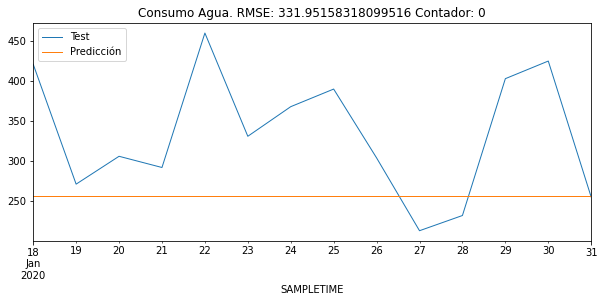

In [10]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()

In [11]:
data_tuples = list(zip(Proyecto.RMSE_Todos,Proyecto.RMSE_Todos_IDs))
resultados=pd.DataFrame(data_tuples,columns=['RMSE_Media','ID'])
resultados.to_csv(path+'RMSE_MEdia_7_dias')
print(resultados)

      RMSE_Media    ID
0     331.951583     0
1     121.979570     1
2      16.743828     2
3     139.420544     3
4     295.503280     4
...          ...   ...
2710    0.904325  2722
2711  135.376394  2742
2712  335.187612  2745
2713    7.299112  2748
2714    0.652450  2749

[2715 rows x 2 columns]


# COHERENCIA DE LOS DATOS

In [12]:
Proyecto.contadores[0].Predicciones

[0,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 256.7142857142859,
 1797.000000000001,
 1797.000000000001]

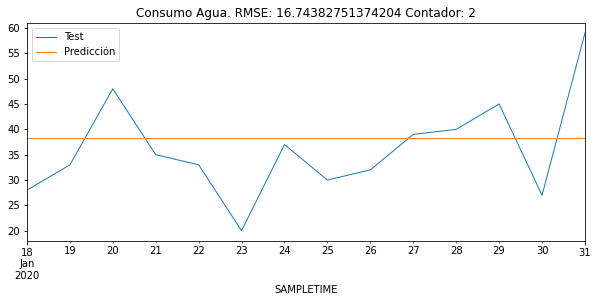

In [13]:
Proyecto.contadores[2].Predicciones
Proyecto.GraficasEstadisticas(contador=2,Test=True)

In [14]:
Proyecto.RMSE_Test_Promedio

556.5867584590495

In [15]:
Proyecto.RMSE_Test_Suma

1511133.0492163196

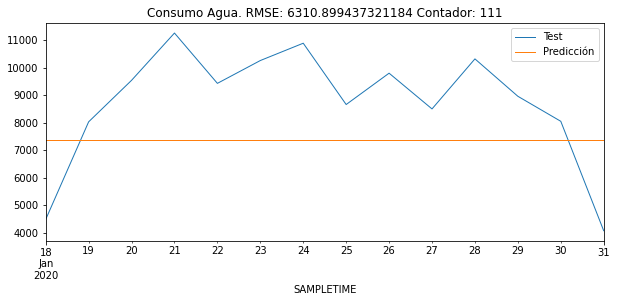

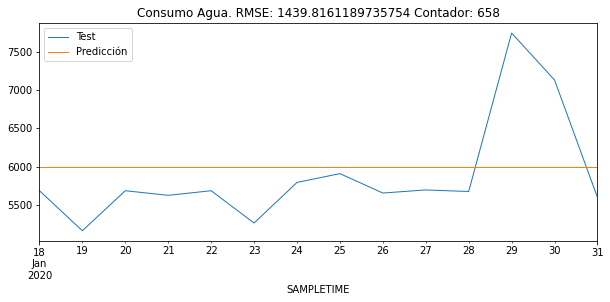

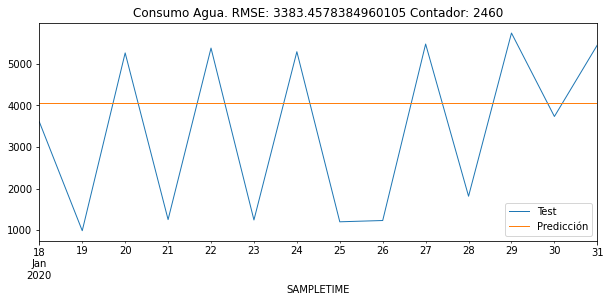

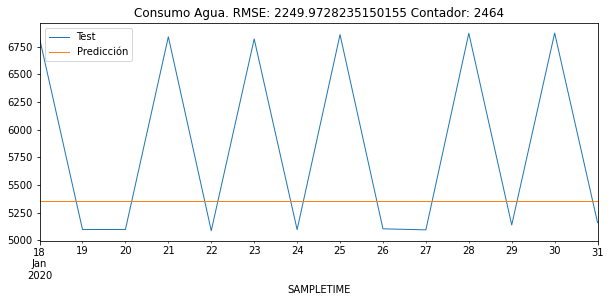

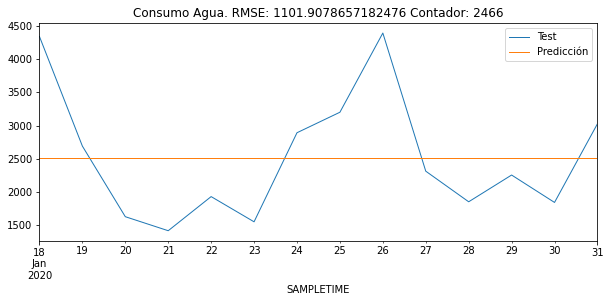

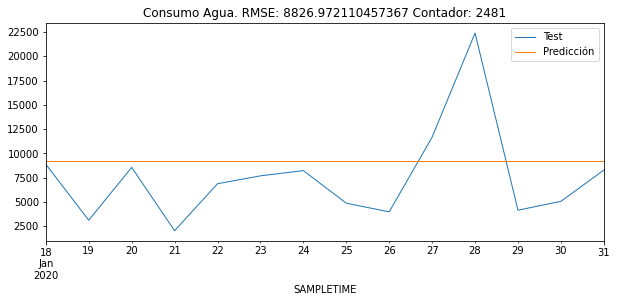

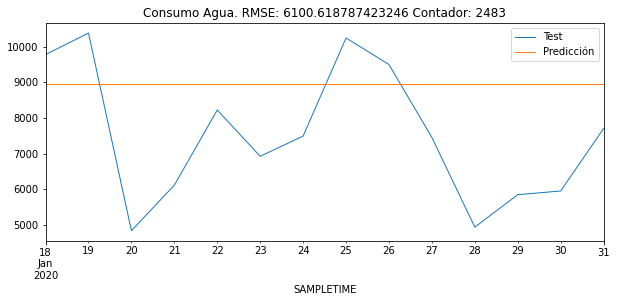

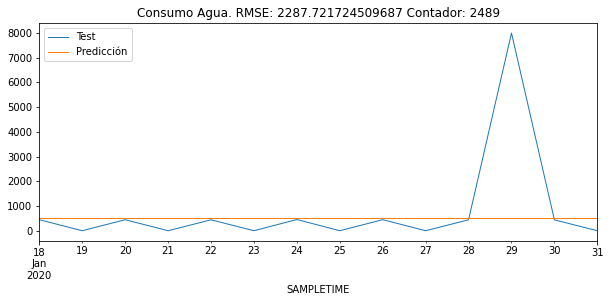

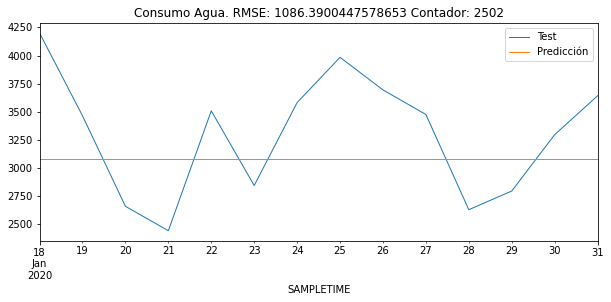

In [16]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)